In [167]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [191]:
L = 5 #system size
M = -0.3 #fermion mass
N=8 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [192]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |2 2 2 2 2>           242  
       1.         |2 2 2 2 1>           241  
       2.         |2 2 2 2 0>           240  
       3.         |2 2 2 1 2>           239  
       4.         |2 2 2 1 1>           238  
       5.         |2 2 2 1 0>           237  
       6.         |2 2 2 0 2>           236  
       7.         |2 2 2 0 1>           235  
       8.         |2 2 2 0 0>           234  
       9.         |2 2 1 2 2>           233  
      10.         |2 2 1 2 1>           232  
      11.         |2 2 1 2 0>           231  
      12.         |2 2 1 1 2>           230  
      13.         |2 2 1 1 1>           229  
      14.         |2 2 1 1 0>           228  
      15.         |2 2 1 0 2>           227  
      16.         |2 2 1 0 1>           226  
      17.         |2 2 1 0 0>           225  
      18.         |2 2 0 2 2>           224  
      19.         |2 2 0 2 1>           223  
      20.  

In [193]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [194]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [195]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [196]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [197]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
b = np.zeros(2*l+1)
for i in range(2*l+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [198]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []
interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])
    quartic_term.append([[(x[4])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1]])
    quintic_term.append([[(x[5])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1]])
    sextic_term.append([[(x[6])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1,i+1]])

    const_term

    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],
        ["+zzzz", quartic_term[i]],
        ["+zzzzz", quintic_term[i]],
        ["+zzzzzz", sextic_term[i]],

    ])

    interaction_m.append([
        ["-", const_term[i]],
        ["-z", linear_term[i]],
        ["-zz", quadratic_term[i]],
        ["-zzz", cubic_term[i]],
        ["-zzzz", quartic_term[i]],
        ["-zzzzz", quintic_term[i]],
        ["-zzzzzz", sextic_term[i]],

    ])

const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

G=0
for i in range(L+1):
    G += 0.15*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term
#print(full_ham_matrix)

In [199]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])
print(eigenvec[:,0])

[-1.84068817 -1.29811607 -1.00113739]
[-7.71838568e-03+2.21048490e-02j -6.45281956e-18+2.74206647e-18j
 -1.97926286e-17+1.33101602e-17j -2.88720740e-02+8.26873470e-02j
  2.44951759e-02-7.01522556e-02j  1.13636828e-17-4.21661922e-20j
  6.15783071e-18+1.51330104e-17j  4.26998199e-19+5.15841665e-18j
 -3.14221372e-18-7.68910945e-18j -1.72943724e-18+2.33978351e-18j
  2.05001494e-18-6.10850495e-18j  2.25230771e-17+2.05220828e-17j
 -5.63088771e-18-3.75130125e-18j -9.49387102e-19+7.78678881e-18j
  2.03826941e-18+6.52688421e-18j  9.04370562e-18-5.07903283e-18j
  6.08399527e-18-2.55956928e-18j  1.31769931e-19+1.22670355e-17j
 -3.18297345e-17+2.97908539e-18j -3.34676054e-17-9.68413219e-18j
  1.00560413e-17-3.15420820e-17j -1.70105161e-17-8.97325927e-18j
 -6.47944101e-18-1.34864866e-17j  8.66431494e-18+1.49517323e-17j
  6.26126911e-18+3.47205547e-18j  3.82015116e-18-1.89628671e-19j
 -8.36846899e-18+1.61930834e-17j -2.88720740e-02+8.26873470e-02j
  4.15225677e-19-6.42659278e-18j  1.04096053e-17-2.4

In [200]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian with the local contstaints
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [201]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-1.84068817 -1.29811607 -0.98569887]
(-0.004347074094741059-0.023006537603081398j)|2 2 2 2 2>
(-0.016261048630497484-0.08606028299257361j)|2 2 2 1 2>
(0.01379593470106473+0.07301386715577261j)|2 2 2 1 1>
(-0.016261048630498404-0.08606028299257351j)|2 1 2 2 2>
(-0.06773770863148018-0.35849633726329283j)|2 1 2 1 2>
(0.05935966136581955+0.31415620059734606j)|2 1 2 1 1>
(0.057483952404404855+0.30422916282142715j)|2 1 1 1 2>
(-0.060444386229250024-0.31989701909172j)|2 1 1 1 1>
(0.028477001984807626+0.15071222682381774j)|2 1 1 0 1>
(0.013795934701065568+0.07301386715577295j)|1 1 2 2 2>
(0.05935966136582137+0.3141562005973462j)|1 1 2 1 2>
(-0.05280335852642894-0.279457498775319j)|1 1 2 1 1>
(-0.060444386229249844-0.31989701909172014j)|1 1 1 1 2>
(0.06510904007641116+0.3445843218156138j)|1 1 1 1 1>
(-0.03299937418926578-0.17464651547624582j)|1 1 1 0 1>
(0.028477001984807463+0.15071222682381677j)|1 0 1 1 2>
(-0.03299937418926696-0.17464651547624452j)|1 0 1 1 1>
(0.02129719832711873+0.112713697

In [202]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [203]:
#cost function of the initial state
expt_value = 0
matvec_h = full_ham_matrix@psi_0
matvec_c = constraint_full_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*(matvec_h[i]+matvec_c[i])
print(np.real(expt_value))

0.0


In [204]:
expt_value = 0
matvec = full_ham_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*matvec[i]
print(expt_value)

0j


In [205]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma/2)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms(k,i,j,phi,theta):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    power_matrix = scipy.sparse.kron(sigma,sparse.identity(2*l+1))+scipy.sparse.kron(sparse.identity(2*l+1),sigma)
    rot_matrix = scipy.sparse.linalg.expm(-1j*power_matrix@power_matrix*theta/4)
    if k == 0:
        tensprod = rot_matrix
        for i in range(L-2):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+2,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_ms_e(i,j,phi,theta):
    ms_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        ms_e = rot_ms(2*k,i,j,phi,theta)@ms_e
    return(ms_e)

def rot_ms_o(i,j,phi,theta):
    ms_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)-1):
        ms_o = rot_ms(2*k+1,i,j,phi,theta)@ms_o
    return(ms_o)

def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_all(i,j,phi,theta):
    sigma_all = sparse.identity(basis.Ns,dtype = complex)
    for k in range(L):
        sigma_all = rot_sigma(k,i,j,phi,theta)@sigma_all
    return(sigma_all)

In [206]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,np.pi/6)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta/4)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    

In [207]:

def sigma_sigma(m,n,theta):
    sigma_sigma = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    temp1 = np.cos(theta/2)
    temp2 = -1j*np.sin(theta/2)
    for i in range(basis.Ns):
        sigma_sigma[i,i] = 1.
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

            
    return sigma_sigma

def id_id(m,theta):
    id_id = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        id_id[i,i] = 1.
        
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4))
            
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4)) 
            
    return id_id


def ms_global_sparse(theta):
    ms_global = sparse.identity(basis.Ns)
    for m in range(L):
        ms_global = id_id(m,theta)@ms_global
        for n in range(m+1,L):
            ms_global = sigma_sigma(m,n,theta)@ms_global
    return ms_global

#print(np.allclose(ms_global_sparse(np.pi/4).toarray(),ms_gate_global(np.pi/4), atol= 1e-3,rtol=1e-3))
#print(np.allclose(ms_global_sparse(np.pi/3).toarray().conj().T@ms_global_sparse(np.pi/3).toarray(),np.identity(basis.Ns), atol= 1e-8,rtol=1e-8))

%time sigma_sigma(0,1,np.pi/3)

CPU times: user 103 ms, sys: 62 µs, total: 103 ms
Wall time: 25.7 ms


<243x243 sparse matrix of type '<class 'numpy.complex128'>'
	with 351 stored elements in List of Lists format>

In [208]:
#import timeit
#print(timeit.timeit('[ms_gate_global(0,2,np.pi)]', globals=globals()))
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
print(np.size(a))


2022-04-07 16:18:32.668119
2022-04-07 16:18:32.671384
59049


In [209]:
def cost_function_sigma(theta):
    psi_var = psi_0
    for i in range(N):
        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(0,1,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var
        
    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

import datetime

print(datetime.datetime.now())
a = cost_function_sigma(np.pi*np.ones(5*N))
print(datetime.datetime.now())

2022-04-07 16:18:32.677840
2022-04-07 16:18:33.056323


In [210]:
opt_params = []
function_values = []
def callback_function(x,fun,context):
    opt_params.append(x)
    function_values.append(fun)


In [211]:
Energy = np.zeros(5)
Fidelity = np.zeros(5)

In [ ]:
import optuna
#for N in range(1,6):
theta = np.zeros(5*N)
#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        theta[5*i+0] = trial.suggest_float("5*"+str(i)+"+0", -4*np.pi, 4*np.pi)
        theta[5*i+1] = trial.suggest_float("5*"+str(i)+"+1", -3*np.pi, 3*np.pi)
        theta[5*i+2] = trial.suggest_float("5*"+str(i)+"+2", -3*np.pi, 3*np.pi)
        theta[5*i+3] = trial.suggest_float("5*"+str(i)+"+3", -3*np.pi, 3*np.pi)
        theta[5*i+4] = trial.suggest_float("5*"+str(i)+"+4", -3*np.pi, 3*np.pi)


        psi_var = ms_gate_global(theta[5*i+0])@psi_var
        psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(1,2,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(1,2,0,theta[5*i+3])@psi_var
        psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,1,2,0,theta[5*i+1])@psi_var
        psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,1,2,0,theta[5*i+1])@psi_var

    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

if __name__ == "__main__":
    sampler = optuna.samplers.CmaEsSampler(n_startup_trials = 100, restart_strategy = 'ipop', inc_popsize = 3.3)
    study = optuna.create_study(sampler=sampler, study_name = "M=0.1, L=5, n_trials=3000, N=".join(str(N)))
    study.optimize(cost_function_sigma, n_trials=7000)


/home/ppopov/anaconda3/lib/python3.8/site-packages/optuna/samplers/_cmaes.py:221: ExperimentalWarning: `restart_strategy` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2022-04-07 16:18:33,241] A new study created in memory with name: 8
[I 2022-04-07 16:18:33,583] Trial 0 finished with value: 5.7707227366833935 and parameters: {'5*0+0': -10.952745081673175, '5*0+1': 3.0958860156096275, '5*0+2': 6.587940355619786, '5*0+3': -4.878506949731056, '5*0+4': -4.941533475187718, '5*1+0': 0.8877083469592773, '5*1+1': 6.9685425362264795, '5*1+2': -2.0361710631449013, '5*1+3': 6.403797497328561, '5*1+4': 2.5880910732083358, '5*2+0': 1.3728884319432773, '5*2+1': -4.176887929206485, '5*2+2': 1.443355820466735, '5*2+3': 6.821429827526792, '5*2+4': -1.2112559241905387, '5*3+0': -3.568292450145302, '5*3+1': -3.4964181625307322, '5*3+2': 0.31240746657530316, '5*3+3': -5.054211807929556, '5*3+4': 3.541661738905269, '5*4+0': -7.336733694554916, '5*4+1': 9.21

[I 2022-04-07 16:18:35,820] Trial 7 finished with value: 5.616275452918496 and parameters: {'5*0+0': 4.03912343237085, '5*0+1': -7.903229655090923, '5*0+2': 9.424608550663972, '5*0+3': -1.2465621810524592, '5*0+4': 5.938201418937039, '5*1+0': -7.414684965582287, '5*1+1': -6.185385998101129, '5*1+2': 6.32368285190495, '5*1+3': -6.511901197153984, '5*1+4': 8.900389024629092, '5*2+0': -7.731003847109044, '5*2+1': -4.865855716441855, '5*2+2': 9.406614341798608, '5*2+3': 7.500965331804885, '5*2+4': 5.838519185892807, '5*3+0': -5.7501343292371905, '5*3+1': 0.059396827205450364, '5*3+2': -5.713137052261499, '5*3+3': -2.308041353780264, '5*3+4': -8.405550264854252, '5*4+0': -3.9255760209489043, '5*4+1': -1.1757299346817067, '5*4+2': 7.535897167105642, '5*4+3': 8.753767650433073, '5*4+4': -3.308211504352598, '5*5+0': -2.445201661756876, '5*5+1': 1.0890246929818002, '5*5+2': 0.623475684079736, '5*5+3': -4.528358354348798, '5*5+4': 6.76318176774431, '5*6+0': 7.461374679655066, '5*6+1': 2.34321365

[I 2022-04-07 16:18:38,061] Trial 14 finished with value: 5.535162369039268 and parameters: {'5*0+0': -4.288936043637442, '5*0+1': 5.57590038092046, '5*0+2': -6.365575883512798, '5*0+3': 6.948875424626735, '5*0+4': -5.908686465958942, '5*1+0': 3.4637088411582404, '5*1+1': -3.2833224972166084, '5*1+2': -5.505800092161204, '5*1+3': -0.6048411363444224, '5*1+4': 5.146686103020654, '5*2+0': -4.614053129414972, '5*2+1': 4.6919866969767625, '5*2+2': -9.143559785713077, '5*2+3': -5.128145321241425, '5*2+4': 3.9458380837763087, '5*3+0': 9.362348040395528, '5*3+1': 7.85126589367939, '5*3+2': 4.76749684864995, '5*3+3': -5.233072072119933, '5*3+4': 4.159817137163914, '5*4+0': 8.34254862976342, '5*4+1': 8.74895113134972, '5*4+2': -1.4187516932150626, '5*4+3': 2.980359158988019, '5*4+4': 4.612093128313916, '5*5+0': 4.815668372151219, '5*5+1': 2.094598934801448, '5*5+2': -5.523244766756674, '5*5+3': -4.487072281137181, '5*5+4': 2.4048097507283064, '5*6+0': 4.248503460148676, '5*6+1': -5.451194494943

[I 2022-04-07 16:18:40,283] Trial 21 finished with value: 4.407689872921039 and parameters: {'5*0+0': 0.37104167826723256, '5*0+1': -4.788465823969004, '5*0+2': -5.452010432222421, '5*0+3': -2.6746687766832586, '5*0+4': 4.587584590873465, '5*1+0': 8.980207047831648, '5*1+1': 6.024864603895789, '5*1+2': -3.800140377742111, '5*1+3': -8.10492306467017, '5*1+4': 2.944884771692122, '5*2+0': -8.270467458662582, '5*2+1': 2.2242915526956555, '5*2+2': 8.215101537620967, '5*2+3': 0.2812591663976427, '5*2+4': -7.4506614801792965, '5*3+0': 0.22840026193308027, '5*3+1': -2.5960678606306917, '5*3+2': -1.8884485635342578, '5*3+3': -8.251670462732255, '5*3+4': -1.0537741248155257, '5*4+0': 10.585500605220613, '5*4+1': -1.3427215385524178, '5*4+2': 1.0361413376595277, '5*4+3': 1.5687764317453254, '5*4+4': 3.853598790842792, '5*5+0': -9.909105622285862, '5*5+1': 3.9504349762810183, '5*5+2': 0.9919199644983756, '5*5+3': -3.0871568008081542, '5*5+4': -3.2479391304105896, '5*6+0': -2.303565761683764, '5*6+

[I 2022-04-07 16:18:42,496] Trial 28 finished with value: 5.281641394654668 and parameters: {'5*0+0': -10.626452787119852, '5*0+1': -2.6478852684162337, '5*0+2': 7.833007601458899, '5*0+3': 3.31058895898596, '5*0+4': -9.215745900910722, '5*1+0': 5.249858409710008, '5*1+1': -8.284351137292935, '5*1+2': 4.62965898321904, '5*1+3': -8.453283353863723, '5*1+4': 4.968996832156797, '5*2+0': -6.571517075101042, '5*2+1': -5.267512135748976, '5*2+2': 4.375670482960279, '5*2+3': 7.837670453209302, '5*2+4': 4.619792798945355, '5*3+0': -9.216643190104902, '5*3+1': -3.366450137578192, '5*3+2': 6.388567265895976, '5*3+3': -7.058530809014755, '5*3+4': 7.1317079056913, '5*4+0': 6.701346618165918, '5*4+1': 0.29970424968980147, '5*4+2': -7.124029775135115, '5*4+3': 6.819359132743976, '5*4+4': -3.129524874393316, '5*5+0': 1.6394840896593248, '5*5+1': -1.773222174421746, '5*5+2': -1.3184076932592408, '5*5+3': 9.405188750919077, '5*5+4': 9.287514215859208, '5*6+0': -10.620182187575839, '5*6+1': 6.9062524543

[I 2022-04-07 16:18:44,691] Trial 35 finished with value: 5.545639509452038 and parameters: {'5*0+0': 10.661563227470701, '5*0+1': 0.2817534101265533, '5*0+2': 4.940006133729245, '5*0+3': 7.59715306106391, '5*0+4': 1.4453463491552405, '5*1+0': -9.616735512614726, '5*1+1': 2.7366283854739883, '5*1+2': -1.365599624351372, '5*1+3': -4.842159180820996, '5*1+4': 3.1015764440942757, '5*2+0': -12.072317820393193, '5*2+1': 1.460823313365621, '5*2+2': 2.068860371176168, '5*2+3': -5.876588885079505, '5*2+4': 1.1703808866491396, '5*3+0': -10.640888319175142, '5*3+1': -6.935172952170547, '5*3+2': 7.987821744225794, '5*3+3': 7.003792643032863, '5*3+4': -4.667037174850923, '5*4+0': 8.810671390580392, '5*4+1': -4.58058859163827, '5*4+2': 8.326515802524838, '5*4+3': 2.1359848909083983, '5*4+4': -4.049876934059816, '5*5+0': -10.316798418786654, '5*5+1': -6.238064117981435, '5*5+2': 5.188149931315824, '5*5+3': 9.326152422954863, '5*5+4': 4.420989886421307, '5*6+0': -11.492935124420942, '5*6+1': 6.180996

[I 2022-04-07 16:18:46,884] Trial 42 finished with value: 6.853381064998703 and parameters: {'5*0+0': -5.190323013585404, '5*0+1': -2.331485329497557, '5*0+2': -2.283921005072469, '5*0+3': -2.2096423850751794, '5*0+4': -5.514589623994512, '5*1+0': 10.252161998806265, '5*1+1': -1.0871545648206968, '5*1+2': -8.150430155918654, '5*1+3': 7.152222380440158, '5*1+4': -6.209923965880757, '5*2+0': -7.169395292158319, '5*2+1': 8.51447930651478, '5*2+2': -9.095085817527606, '5*2+3': -4.767808699492212, '5*2+4': 7.923074623500327, '5*3+0': -0.502820486782106, '5*3+1': -6.575329725539517, '5*3+2': 5.247285984558699, '5*3+3': -8.284346046390903, '5*3+4': 3.3738250164201933, '5*4+0': -8.402684359163288, '5*4+1': 5.875008154265901, '5*4+2': 1.1681768457612627, '5*4+3': -2.636603512327885, '5*4+4': 2.1630376339430963, '5*5+0': 9.368101137551562, '5*5+1': 4.548279329985476, '5*5+2': 2.469798787616641, '5*5+3': -6.980353338455912, '5*5+4': -2.8624950416500567, '5*6+0': -3.000213909712878, '5*6+1': -0.93

[I 2022-04-07 16:18:49,055] Trial 49 finished with value: 6.064243391327249 and parameters: {'5*0+0': -5.120525436478883, '5*0+1': -8.064864935242717, '5*0+2': -3.6045582483382006, '5*0+3': -9.080526405974327, '5*0+4': -1.0454242135379381, '5*1+0': 5.954239958725388, '5*1+1': 6.311181852517759, '5*1+2': -5.925506498362807, '5*1+3': 2.8852315503818193, '5*1+4': 7.454981588998027, '5*2+0': -11.611338874814178, '5*2+1': 0.5653467983453577, '5*2+2': -4.5300430704332015, '5*2+3': -3.324360393776426, '5*2+4': -2.440874136141045, '5*3+0': 1.2921078174429415, '5*3+1': -1.528156410521043, '5*3+2': 9.35967797471173, '5*3+3': -6.0667916673557, '5*3+4': -0.058430423500578144, '5*4+0': 10.399664840922814, '5*4+1': 2.3460685027601116, '5*4+2': -7.092796845844205, '5*4+3': 6.540444234182605, '5*4+4': 1.9576088852140696, '5*5+0': -12.486411321847156, '5*5+1': -0.2722162617367303, '5*5+2': 2.784330053598829, '5*5+3': -4.444560431543503, '5*5+4': 5.996452393343908, '5*6+0': -8.639353579689304, '5*6+1': 

[I 2022-04-07 16:18:51,291] Trial 56 finished with value: 4.347940365409488 and parameters: {'5*0+0': -11.912450279483851, '5*0+1': -5.253239849428337, '5*0+2': -4.278980426132848, '5*0+3': 5.173617106565294, '5*0+4': -8.898641974803688, '5*1+0': 8.96155589358094, '5*1+1': 0.31943118693071426, '5*1+2': -4.844220829996354, '5*1+3': -1.7140212012615335, '5*1+4': 7.686438811317942, '5*2+0': -11.63135506930516, '5*2+1': -7.475579256304068, '5*2+2': 0.9407355684155121, '5*2+3': 4.784346814009593, '5*2+4': -8.9601621505441, '5*3+0': 6.946916418363539, '5*3+1': 1.2848293235277755, '5*3+2': -5.386480616833836, '5*3+3': -6.367395318032612, '5*3+4': -7.021530255257883, '5*4+0': -2.709836632883439, '5*4+1': -1.3415878724827994, '5*4+2': -7.644918464483961, '5*4+3': 1.1189914522674496, '5*4+4': 8.067476458209018, '5*5+0': -10.117811216172116, '5*5+1': 7.963118348903848, '5*5+2': 8.099337429623652, '5*5+3': -5.072201793881946, '5*5+4': 3.9830714319762173, '5*6+0': -1.919732839005082, '5*6+1': -8.44

[I 2022-04-07 16:18:53,477] Trial 63 finished with value: 4.248193808599599 and parameters: {'5*0+0': -9.796952256713409, '5*0+1': -3.974627588276526, '5*0+2': 6.062823557906132, '5*0+3': 8.353396598933418, '5*0+4': -3.8361092438973357, '5*1+0': 9.020832666819103, '5*1+1': 8.617210393930915, '5*1+2': 0.874073410333752, '5*1+3': 3.475800695848436, '5*1+4': -2.7541807536916503, '5*2+0': 4.258688987993693, '5*2+1': 5.284320100132865, '5*2+2': 1.3164422700874976, '5*2+3': -5.4469641144390835, '5*2+4': -0.02857345679637291, '5*3+0': 11.327245110030017, '5*3+1': -3.8929267649622226, '5*3+2': -5.881853601921428, '5*3+3': 7.385779804635511, '5*3+4': -5.015630155751446, '5*4+0': 1.2789168064195415, '5*4+1': 5.888884608883311, '5*4+2': 8.204500006433125, '5*4+3': 0.861147489108717, '5*4+4': 7.123931787031459, '5*5+0': 8.93765801435907, '5*5+1': 2.0794237390017862, '5*5+2': -3.445072318550981, '5*5+3': 2.0576612314195533, '5*5+4': -7.7321299492322515, '5*6+0': 12.033057496057037, '5*6+1': 0.69032

[I 2022-04-07 16:18:55,684] Trial 70 finished with value: 5.1914332227296285 and parameters: {'5*0+0': -6.503031116324684, '5*0+1': 9.005921963462121, '5*0+2': 9.357610436997941, '5*0+3': -6.951721919549444, '5*0+4': -6.175863911079203, '5*1+0': -4.806250235656313, '5*1+1': 1.9650798654988169, '5*1+2': 6.752225811165371, '5*1+3': -6.065288535825459, '5*1+4': 0.13087403722341762, '5*2+0': 4.59411308284367, '5*2+1': -7.969662120855481, '5*2+2': 8.571407179539307, '5*2+3': 2.8415677726540842, '5*2+4': 2.798778218094215, '5*3+0': 5.341758364884402, '5*3+1': 2.261490438837077, '5*3+2': 1.9429290321008015, '5*3+3': 1.3491334261266648, '5*3+4': 0.9600006680848274, '5*4+0': 9.926482038008366, '5*4+1': 9.107924217657125, '5*4+2': -8.836182274341812, '5*4+3': 6.054926459278597, '5*4+4': -0.6070537850527895, '5*5+0': -3.5196580281888714, '5*5+1': -7.025269695705577, '5*5+2': 3.307713569922175, '5*5+3': 2.5650379341454155, '5*5+4': 6.566429966391533, '5*6+0': 10.684518339976236, '5*6+1': 2.0579531

[I 2022-04-07 16:18:57,901] Trial 77 finished with value: 4.983279615768973 and parameters: {'5*0+0': -5.099561006947362, '5*0+1': 5.575385404909554, '5*0+2': -3.947183335891677, '5*0+3': -6.205298864766549, '5*0+4': -4.001363427419931, '5*1+0': 2.523049397702872, '5*1+1': 1.960493700199569, '5*1+2': 1.6838769129384072, '5*1+3': -7.440404284268974, '5*1+4': -5.599236615935698, '5*2+0': -3.5243602043918614, '5*2+1': 5.860649881995098, '5*2+2': -8.996680299370322, '5*2+3': 3.8343369957464635, '5*2+4': -4.320520676544224, '5*3+0': 8.084285899338543, '5*3+1': -7.379742404068866, '5*3+2': -2.564123109344986, '5*3+3': 1.934476638656843, '5*3+4': -7.836802884152735, '5*4+0': -10.247512774104433, '5*4+1': 7.867560319495379, '5*4+2': -2.7059668366978604, '5*4+3': 1.8528931922075795, '5*4+4': -9.255923545158007, '5*5+0': -9.787231487371688, '5*5+1': 6.4291663323398875, '5*5+2': -4.287303570857467, '5*5+3': -9.265982159479952, '5*5+4': -6.712360712655581, '5*6+0': -3.8201872212706895, '5*6+1': 5.

[I 2022-04-07 16:19:00,119] Trial 84 finished with value: 5.3269049333035365 and parameters: {'5*0+0': -10.741935844823136, '5*0+1': 8.712125752028005, '5*0+2': -9.118796568418007, '5*0+3': -6.165517159132623, '5*0+4': -3.0387840310820637, '5*1+0': 6.70510537538382, '5*1+1': 7.96389258229982, '5*1+2': -7.10223591801644, '5*1+3': 9.190017935237826, '5*1+4': -1.4153193354464424, '5*2+0': -3.275847391660667, '5*2+1': 9.098372714825839, '5*2+2': -8.52233071263025, '5*2+3': -4.777311958794471, '5*2+4': 2.410621351003991, '5*3+0': 5.406038945858505, '5*3+1': 7.557232239519642, '5*3+2': -4.441191161235646, '5*3+3': 9.260521152131119, '5*3+4': -3.1511610252759947, '5*4+0': -3.5547721539401262, '5*4+1': 9.259854651703797, '5*4+2': -5.077530495802633, '5*4+3': -8.994972307276823, '5*4+4': 0.9738234984820284, '5*5+0': -10.821055105892105, '5*5+1': -8.903554765917267, '5*5+2': 3.6660279711730848, '5*5+3': 6.988170271223179, '5*5+4': 6.541702619203393, '5*6+0': 7.1899543430482815, '5*6+1': -7.74103

[I 2022-04-07 16:19:02,309] Trial 91 finished with value: 4.886002244588209 and parameters: {'5*0+0': -7.302379785842524, '5*0+1': 0.9011185654588676, '5*0+2': -9.004816019049732, '5*0+3': -4.2092087413927555, '5*0+4': 5.5189563731132, '5*1+0': -7.246486094860674, '5*1+1': -4.6420624274537445, '5*1+2': 6.373107195982177, '5*1+3': -6.334407354774994, '5*1+4': 1.1745472047724892, '5*2+0': 3.1006951198090267, '5*2+1': -2.8146181240246566, '5*2+2': 5.265770228028384, '5*2+3': -5.951117557348142, '5*2+4': 1.9994995740034138, '5*3+0': 2.7748418447026193, '5*3+1': 5.992847946054486, '5*3+2': 9.165489891298915, '5*3+3': 2.2453636295409183, '5*3+4': -8.42300301361206, '5*4+0': 10.221233500909342, '5*4+1': -7.043659823789593, '5*4+2': 9.100464929620784, '5*4+3': -1.2129114347578493, '5*4+4': 4.185023599678171, '5*5+0': 9.217842319842873, '5*5+1': 0.27365975484124405, '5*5+2': -4.68501177731027, '5*5+3': -8.791810186360088, '5*5+4': 1.5300319382153766, '5*6+0': -1.7910391891569244, '5*6+1': -6.80

[I 2022-04-07 16:19:04,551] Trial 98 finished with value: 4.7859977210426035 and parameters: {'5*0+0': -0.035073325731900695, '5*0+1': -5.4364593666292045, '5*0+2': 0.9094760251045226, '5*0+3': 4.612430143241385, '5*0+4': -9.226605209629218, '5*1+0': 7.3461794346884055, '5*1+1': -3.7582162257382192, '5*1+2': -0.44601341959939056, '5*1+3': 6.9463803674154825, '5*1+4': 8.428876228806345, '5*2+0': 7.4093460931070645, '5*2+1': -3.4117995905302685, '5*2+2': 4.148013070070386, '5*2+3': -3.3476390280190564, '5*2+4': -5.0815775845499145, '5*3+0': -3.414940072406969, '5*3+1': 1.3519568084422602, '5*3+2': -6.841481552671011, '5*3+3': 5.317436617690893, '5*3+4': 0.4348034759695789, '5*4+0': 9.538444891919525, '5*4+1': -1.4662928328070883, '5*4+2': 8.097413108100284, '5*4+3': -9.193607337073848, '5*4+4': 4.945112868695844, '5*5+0': 8.269296889177465, '5*5+1': 3.112886744856418, '5*5+2': -5.531782128701391, '5*5+3': 1.6088490357641607, '5*5+4': 5.983580791878849, '5*6+0': 5.999279893200839, '5*6+1'

[I 2022-04-07 16:19:06,621] Trial 105 finished with value: 6.572422145352011 and parameters: {'5*0+0': -2.6525442220164597, '5*0+1': -0.734445936442543, '5*0+2': 1.9262437293214205, '5*0+3': -0.656986751564702, '5*0+4': -1.900511869077772, '5*1+0': 1.9338848988752027, '5*1+1': 0.07574106779600583, '5*1+2': 0.550153517426832, '5*1+3': 0.6592485059917892, '5*1+4': 1.1471265161709197, '5*2+0': 2.4422783673982402, '5*2+1': 0.9060574101201285, '5*2+2': 7.141504507293825, '5*2+3': -1.625029989503943, '5*2+4': -1.438944434960036, '5*3+0': -2.4042035308076697, '5*3+1': -3.495379798108394, '5*3+2': 0.013848020427714939, '5*3+3': -1.6149609433958054, '5*3+4': -2.0771748302870017, '5*4+0': -2.6510613434830903, '5*4+1': -1.3116945033309795, '5*4+2': 3.7159676756796127, '5*4+3': 2.2143375969396453, '5*4+4': 1.8602576931605157, '5*5+0': -0.9133039317546262, '5*5+1': -2.5451620052716297, '5*5+2': 2.310729066514911, '5*5+3': 2.1469008326737202, '5*5+4': 0.10073548918240487, '5*6+0': 1.377974742352799,

[I 2022-04-07 16:19:08,681] Trial 112 finished with value: 6.79446349708709 and parameters: {'5*0+0': 2.9576359374109575, '5*0+1': -1.753722423437194, '5*0+2': 2.3858167618408137, '5*0+3': 0.5687911045986918, '5*0+4': 3.669310613169725, '5*1+0': -0.7432913563237648, '5*1+1': -1.1253501876366356, '5*1+2': -1.3415982164884364, '5*1+3': -0.45566451150543047, '5*1+4': 1.2028999363535209, '5*2+0': 0.5882228267333217, '5*2+1': 1.4408077102745274, '5*2+2': 6.151716117524753, '5*2+3': -0.4874823883459285, '5*2+4': 3.9859952211118026, '5*3+0': 2.766128136024742, '5*3+1': 4.48777190191592, '5*3+2': -0.0804498361710315, '5*3+3': -1.2543684970408893, '5*3+4': -1.0718872118726819, '5*4+0': -5.081112346634231, '5*4+1': -2.529934935813308, '5*4+2': 2.1059392273636695, '5*4+3': 5.442296204425525, '5*4+4': -1.5296195246338908, '5*5+0': -1.7210028128822816, '5*5+1': -0.6602348339339024, '5*5+2': 1.2029879889327066, '5*5+3': 0.07581962666839698, '5*5+4': 4.826633642523095, '5*6+0': -0.6112833001312953, '

[I 2022-04-07 16:19:10,773] Trial 119 finished with value: 7.965738235298482 and parameters: {'5*0+0': 0.5091766658072312, '5*0+1': 6.956387303577855, '5*0+2': -6.180158858161173, '5*0+3': 2.742615915515271, '5*0+4': -0.2099063807296373, '5*1+0': -3.5924032589109958, '5*1+1': -0.04348273353622334, '5*1+2': 0.6778326119066689, '5*1+3': 1.1978037095673177, '5*1+4': 1.466065768074868, '5*2+0': 0.3157713966375173, '5*2+1': 3.016678278229205, '5*2+2': -1.467215868850041, '5*2+3': 4.007762722498379, '5*2+4': 5.476002230788728, '5*3+0': -4.513157438889437, '5*3+1': -5.925244347415749, '5*3+2': -3.03011411454535, '5*3+3': -3.2477464083526995, '5*3+4': 4.063100525818912, '5*4+0': -3.8157433398427925, '5*4+1': 0.03228149374444911, '5*4+2': -2.3137951788355497, '5*4+3': -3.9217150468904416, '5*4+4': 4.005798838114054, '5*5+0': -0.3385628230178157, '5*5+1': -4.702018502186089, '5*5+2': -4.68045213918989, '5*5+3': 3.13059009312666, '5*5+4': 1.3411010494360232, '5*6+0': -1.3460206437137283, '5*6+1':

[I 2022-04-07 16:19:12,923] Trial 126 finished with value: 6.151574743921527 and parameters: {'5*0+0': 1.113785201034885, '5*0+1': 3.716025783840719, '5*0+2': -1.279353718747973, '5*0+3': -2.4070245305503866, '5*0+4': 1.2442571181123712, '5*1+0': -0.5690281004809672, '5*1+1': -4.689718031842239, '5*1+2': -0.18832001705317758, '5*1+3': -1.263376712076762, '5*1+4': -3.3415553399233513, '5*2+0': -3.2997712482941886, '5*2+1': 0.34234691455963895, '5*2+2': -3.157618334656333, '5*2+3': 3.2913006031373784, '5*2+4': 7.693150016931244, '5*3+0': 0.9744492385578547, '5*3+1': 8.605906569907358, '5*3+2': 5.059757705506307, '5*3+3': 0.0023923604790578867, '5*3+4': 0.9255377473993482, '5*4+0': 5.888117694845874, '5*4+1': 2.3296361425453833, '5*4+2': -2.9157559886568136, '5*4+3': 2.373794291694779, '5*4+4': -0.5337838357784783, '5*5+0': -2.8039079804001954, '5*5+1': -3.373905894269722, '5*5+2': -6.56725678089979, '5*5+3': -0.48197922853064346, '5*5+4': 2.4183759980641515, '5*6+0': 7.653246027202748, '

[I 2022-04-07 16:19:15,082] Trial 133 finished with value: 5.677515773926638 and parameters: {'5*0+0': -1.2443290722607763, '5*0+1': -0.7207773888137612, '5*0+2': -2.323345697952878, '5*0+3': -0.5383929408634175, '5*0+4': 2.982830111302344, '5*1+0': 1.6158450442178314, '5*1+1': -0.6630262696005711, '5*1+2': -0.9938855488035201, '5*1+3': 1.7568961059853812, '5*1+4': -2.312097897632593, '5*2+0': -8.317112460332119, '5*2+1': 7.500239643010842, '5*2+2': 1.9944866800882868, '5*2+3': 3.3287241662233225, '5*2+4': 0.5257324118429638, '5*3+0': -1.420453275201458, '5*3+1': 3.6784285580697156, '5*3+2': -2.9389924806540875, '5*3+3': 1.2379547697608322, '5*3+4': 0.6154511023728791, '5*4+0': -1.666261422126594, '5*4+1': -0.009378409696695567, '5*4+2': -8.201843593557408, '5*4+3': -5.053323084741915, '5*4+4': -3.061358492847554, '5*5+0': 6.535413031705382, '5*5+1': -2.9462408073720736, '5*5+2': -2.6240411746675334, '5*5+3': -2.1783110836117245, '5*5+4': -2.2037263101826476, '5*6+0': 2.504750358759503

[I 2022-04-07 16:19:17,236] Trial 140 finished with value: 5.726819319365549 and parameters: {'5*0+0': 2.926970792260735, '5*0+1': 6.869717508454222, '5*0+2': 4.455276346749143, '5*0+3': -5.325113269601726, '5*0+4': 3.672021599675399, '5*1+0': 0.6024942963605344, '5*1+1': -4.965678741321467, '5*1+2': 5.178494421767489, '5*1+3': -7.7369063861478775, '5*1+4': -3.4972085740908274, '5*2+0': 2.5166794980440357, '5*2+1': 8.36545430064566, '5*2+2': 0.08918927359959294, '5*2+3': -0.09212308122374435, '5*2+4': -0.9087246607457753, '5*3+0': 1.1242729865615608, '5*3+1': 2.159955915275712, '5*3+2': 3.5124386285331632, '5*3+3': -0.9010366421082311, '5*3+4': -1.1843837481109374, '5*4+0': 1.56506941361826, '5*4+1': 2.6992554736824066, '5*4+2': -2.9060767316929006, '5*4+3': 0.773459564687565, '5*4+4': -3.169840145919475, '5*5+0': 3.6506389719590366, '5*5+1': -8.03362517666502, '5*5+2': -1.9762543131924701, '5*5+3': 3.9800112518603212, '5*5+4': -1.719060262348164, '5*6+0': -1.9006799612417846, '5*6+1':

[I 2022-04-07 16:19:19,371] Trial 147 finished with value: 3.9281352103816536 and parameters: {'5*0+0': 1.0992791775895523, '5*0+1': 4.743522058660557, '5*0+2': -1.926857683531599, '5*0+3': -5.213931574057323, '5*0+4': -2.35998631122877, '5*1+0': -2.0291832229776583, '5*1+1': -6.944178553354709, '5*1+2': 7.97250438751088, '5*1+3': -7.039112673237396, '5*1+4': -1.3321909619677998, '5*2+0': -1.699401268840838, '5*2+1': 7.695933201626285, '5*2+2': -1.0259465395248073, '5*2+3': -2.4915304104150833, '5*2+4': 0.36296192106931446, '5*3+0': 2.0578748747280766, '5*3+1': 0.11030109335734428, '5*3+2': 0.9998707912056726, '5*3+3': 1.5281017869241342, '5*3+4': -1.7895636979321319, '5*4+0': 1.1053966422989823, '5*4+1': 1.1899217227517005, '5*4+2': -7.01447771256144, '5*4+3': -5.074982138867206, '5*4+4': -3.2838388908680782, '5*5+0': -3.4388117477257683, '5*5+1': -3.636992602275962, '5*5+2': -2.01079318983307, '5*5+3': 3.593368006488592, '5*5+4': 0.10998374842971148, '5*6+0': 6.751074357050649, '5*6+

[I 2022-04-07 16:19:21,443] Trial 154 finished with value: 4.044173416145646 and parameters: {'5*0+0': 1.0513730455652113, '5*0+1': 7.7765507783914565, '5*0+2': -0.35962660482863873, '5*0+3': 3.8849795726218868, '5*0+4': 3.379294660019914, '5*1+0': 2.654398071845363, '5*1+1': -1.7503568257018043, '5*1+2': 5.3891525778993286, '5*1+3': -7.68449297479429, '5*1+4': -1.0668488725535603, '5*2+0': -7.144906790787961, '5*2+1': 5.594676452066141, '5*2+2': 2.3889283757770663, '5*2+3': 5.303653806869041, '5*2+4': 8.417635657492877, '5*3+0': -1.6237300840388416, '5*3+1': 6.503492408408501, '5*3+2': 0.8197420296871107, '5*3+3': 5.274305791217917, '5*3+4': -1.7732873295362253, '5*4+0': -3.2762212422071397, '5*4+1': 3.5524854416431353, '5*4+2': -0.7658425958374038, '5*4+3': 2.3207518433583987, '5*4+4': 1.5198699612499047, '5*5+0': -3.9560800902313424, '5*5+1': -5.411101086375146, '5*5+2': -0.08637218078497821, '5*5+3': -1.4331891614380727, '5*5+4': -1.677181992935593, '5*6+0': -2.2078977424880337, '5

[I 2022-04-07 16:19:23,607] Trial 161 finished with value: 3.168109415060858 and parameters: {'5*0+0': -0.1924076533227932, '5*0+1': 6.951898384548987, '5*0+2': -5.806283696692528, '5*0+3': -4.095716250708943, '5*0+4': -1.275399121787968, '5*1+0': -1.8064033805725952, '5*1+1': -8.144467922502683, '5*1+2': -1.986588153881316, '5*1+3': -4.884448517355376, '5*1+4': -4.221276343968108, '5*2+0': 2.1289554151261982, '5*2+1': 6.4104543628052735, '5*2+2': -0.6074306029562869, '5*2+3': -3.0850144941996938, '5*2+4': 1.7974186931770313, '5*3+0': -1.8747942441238519, '5*3+1': 3.938272266043743, '5*3+2': -3.639753577842579, '5*3+3': -0.08575949188522825, '5*3+4': -4.179768289323637, '5*4+0': 1.0365163355867117, '5*4+1': 1.3542756483798601, '5*4+2': -2.600950096135872, '5*4+3': -1.7422697598404975, '5*4+4': -1.2766346503159482, '5*5+0': 2.1981947211642656, '5*5+1': -4.293125013475993, '5*5+2': 0.5240603553561604, '5*5+3': 6.7318453029316405, '5*5+4': 2.565980646563594, '5*6+0': 1.5862503988793044, '

[I 2022-04-07 16:19:25,706] Trial 168 finished with value: 3.984352558077564 and parameters: {'5*0+0': -0.31241845969439197, '5*0+1': 5.665006877797992, '5*0+2': 3.3796706729430337, '5*0+3': -3.2476307693242727, '5*0+4': -2.097954641510777, '5*1+0': 0.2217478847638179, '5*1+1': -0.6268425855066093, '5*1+2': -1.8093762344578077, '5*1+3': -5.104385378017714, '5*1+4': -5.522747979297777, '5*2+0': -6.990486759191127, '5*2+1': 7.5861623931345195, '5*2+2': 0.5936087325161794, '5*2+3': 0.643627152388318, '5*2+4': -0.7249191610938808, '5*3+0': -4.452927822177154, '5*3+1': -0.24976811424038203, '5*3+2': 2.039184622869641, '5*3+3': 4.393554376136885, '5*3+4': -1.2286253593330367, '5*4+0': 5.792198721837742, '5*4+1': 6.126015164130806, '5*4+2': -5.0706766888869, '5*4+3': 2.6125441147038035, '5*4+4': -5.674711052889739, '5*5+0': -2.095593225092, '5*5+1': -2.3913310672893022, '5*5+2': -5.476601067719574, '5*5+3': 5.7805556184307, '5*5+4': -3.1120672901825053, '5*6+0': -1.9796368662645443, '5*6+1': 

[I 2022-04-07 16:19:27,795] Trial 175 finished with value: 5.860039915944254 and parameters: {'5*0+0': -0.5145939001592373, '5*0+1': 3.230145573712101, '5*0+2': 0.2155934292628694, '5*0+3': -4.997231243072543, '5*0+4': -0.42887994439911925, '5*1+0': -3.5087282149657004, '5*1+1': -8.190713642265887, '5*1+2': -0.4532614310916152, '5*1+3': -5.900873956076483, '5*1+4': -2.397811487147547, '5*2+0': -2.3162136402910107, '5*2+1': 2.8846992521092387, '5*2+2': 3.194719373709874, '5*2+3': -2.8587293176933524, '5*2+4': 4.227976979345194, '5*3+0': -5.436208860527463, '5*3+1': 5.527888973247904, '5*3+2': -1.4800137111561924, '5*3+3': -1.161357073349126, '5*3+4': -2.9685789111707246, '5*4+0': 0.06860154651185724, '5*4+1': 0.28119340515927416, '5*4+2': -3.1476343614313995, '5*4+3': 1.2378556030982255, '5*4+4': -0.03407253252836706, '5*5+0': 0.511118050147982, '5*5+1': -6.967674236102435, '5*5+2': -4.414564071581775, '5*5+3': 5.116935031479956, '5*5+4': 1.5845468778804048, '5*6+0': 3.155760105915422, 

[I 2022-04-07 16:19:29,917] Trial 182 finished with value: 5.35070658624339 and parameters: {'5*0+0': 2.7204195540764666, '5*0+1': 4.46736168934663, '5*0+2': -0.3543012812535364, '5*0+3': -2.2550384817385165, '5*0+4': 1.8599154088870606, '5*1+0': 0.5393635550596532, '5*1+1': 0.27409633172752645, '5*1+2': -1.883826758774406, '5*1+3': -4.827127837238157, '5*1+4': -4.927996359285625, '5*2+0': 0.5446623965961537, '5*2+1': 4.039200522075641, '5*2+2': 3.5162723314677518, '5*2+3': -3.1823056748554794, '5*2+4': 3.415662315519966, '5*3+0': 3.8563335261072114, '5*3+1': 2.0476994661551604, '5*3+2': -1.4462757712501626, '5*3+3': 3.8120468531847305, '5*3+4': 2.8487501138736446, '5*4+0': 2.6679387892229025, '5*4+1': 2.876791576400546, '5*4+2': -0.46362319575954114, '5*4+3': -0.25953806136869917, '5*4+4': -4.726530236515205, '5*5+0': 3.7977568854669936, '5*5+1': -6.768348150005466, '5*5+2': -4.45693104072716, '5*5+3': 1.0466689307525419, '5*5+4': 0.9224523404640997, '5*6+0': 2.1591027281471065, '5*6+

[I 2022-04-07 16:19:32,034] Trial 189 finished with value: 10.021488825686372 and parameters: {'5*0+0': 0.8503233632013194, '5*0+1': 7.747757382562309, '5*0+2': -1.2587837113948748, '5*0+3': -1.9403054273213396, '5*0+4': 0.3837766151850858, '5*1+0': -4.365713800778423, '5*1+1': -6.3517396864956295, '5*1+2': -0.12050555558985739, '5*1+3': -9.086635598566897, '5*1+4': -5.496315188788606, '5*2+0': 1.2523882734426328, '5*2+1': 8.353703440192582, '5*2+2': 0.5679489679742373, '5*2+3': -2.166811851529551, '5*2+4': 4.983395661914311, '5*3+0': -1.907627890549165, '5*3+1': 2.1653594200317965, '5*3+2': 2.831097360555167, '5*3+3': 1.7220291045023652, '5*3+4': 3.5186424108497807, '5*4+0': 0.5474270691013512, '5*4+1': -0.5296517928650886, '5*4+2': -3.9659612344728155, '5*4+3': 4.587243027539236, '5*4+4': -1.2221538208878795, '5*5+0': -2.192905411232746, '5*5+1': -6.458054528059622, '5*5+2': -6.978249016982281, '5*5+3': 2.9095563562419415, '5*5+4': 3.2389425182496443, '5*6+0': -3.7364368878828635, '5

[I 2022-04-07 16:19:34,141] Trial 196 finished with value: 8.498974384760867 and parameters: {'5*0+0': 1.9112510514523873, '5*0+1': 4.485958540792334, '5*0+2': -4.463603280719524, '5*0+3': 0.4506633119538259, '5*0+4': 1.3653413227195061, '5*1+0': -4.349168354174271, '5*1+1': -0.07044682068229924, '5*1+2': 1.44034017290799, '5*1+3': -6.744912986404601, '5*1+4': -1.209556990704301, '5*2+0': -3.71303010537614, '5*2+1': 6.218985965540563, '5*2+2': 1.2852364817067585, '5*2+3': 1.2802347133192615, '5*2+4': 3.9556448408402645, '5*3+0': -2.41090235788924, '5*3+1': 4.846326316792448, '5*3+2': -0.2410733131907823, '5*3+3': 2.5982851649179417, '5*3+4': 4.899198231496563, '5*4+0': 4.463411645477945, '5*4+1': 2.682304101921402, '5*4+2': -1.445801261344885, '5*4+3': -1.9165738350550257, '5*4+4': -2.820319190083047, '5*5+0': -2.4386456294211776, '5*5+1': -1.5386083794260204, '5*5+2': -4.959274197804768, '5*5+3': -0.8298334314222848, '5*5+4': 5.055346457059842, '5*6+0': -3.2581441522729424, '5*6+1': -

[I 2022-04-07 16:19:36,266] Trial 203 finished with value: 6.5279535827505 and parameters: {'5*0+0': 0.7660936035223193, '5*0+1': 8.977372536940562, '5*0+2': -2.1548160123712687, '5*0+3': 3.2517732028029114, '5*0+4': -0.022372753354684805, '5*1+0': -3.1754178955711128, '5*1+1': 0.3724460099366058, '5*1+2': 3.6258846788494647, '5*1+3': -1.912998164633771, '5*1+4': -4.449629313627966, '5*2+0': 0.6371570556522668, '5*2+1': 9.153145891566167, '5*2+2': -0.97718636271077, '5*2+3': 4.106213904504703, '5*2+4': 0.03952207961497223, '5*3+0': -1.5314103130471932, '5*3+1': 2.4495613203482316, '5*3+2': -2.022181642682184, '5*3+3': 0.33259832301852854, '5*3+4': -3.086292110273745, '5*4+0': 2.5762268080046633, '5*4+1': -1.2533005736447649, '5*4+2': -3.7474649645539433, '5*4+3': -4.942093218913363, '5*4+4': -0.7250242695548752, '5*5+0': 2.0798729104553173, '5*5+1': -3.8050929244706353, '5*5+2': -6.280655880652039, '5*5+3': 2.3371535881702292, '5*5+4': -0.6753584681822395, '5*6+0': 0.8963020206826489, 

[I 2022-04-07 16:19:38,413] Trial 210 finished with value: 6.5365694914269445 and parameters: {'5*0+0': 3.674939108561105, '5*0+1': 7.278958950295405, '5*0+2': -2.8897561252214263, '5*0+3': -2.2440686318235255, '5*0+4': 7.374593847854409, '5*1+0': -3.933779021190751, '5*1+1': -0.6825217327514603, '5*1+2': 0.8869779010892098, '5*1+3': -5.774013707126383, '5*1+4': -5.025664021579777, '5*2+0': 1.2636536842710338, '5*2+1': 3.463415227557655, '5*2+2': -0.18345261849087868, '5*2+3': 2.7876792170846043, '5*2+4': 3.0651687847776383, '5*3+0': -2.615777689076543, '5*3+1': 4.733062587840114, '5*3+2': 0.8443811277686297, '5*3+3': 1.8482346840782256, '5*3+4': 2.7247144030787256, '5*4+0': 8.947440093914821, '5*4+1': 1.429749214470233, '5*4+2': 3.6085037059496092, '5*4+3': -8.707764398485846, '5*4+4': 0.7560480380250469, '5*5+0': 0.7413676991706819, '5*5+1': -2.518266228095981, '5*5+2': 0.2577841394362501, '5*5+3': 2.6157447978322046, '5*5+4': 5.138140052011183, '5*6+0': -0.6486420700961056, '5*6+1':

[I 2022-04-07 16:19:40,525] Trial 217 finished with value: 5.376156870347899 and parameters: {'5*0+0': -3.4181439845080357, '5*0+1': 3.303554365583657, '5*0+2': 0.1533544268444262, '5*0+3': -4.582499747598894, '5*0+4': 4.221969613705333, '5*1+0': -0.8607500945441117, '5*1+1': -0.8001812696147345, '5*1+2': 1.1771527065068823, '5*1+3': -5.043932191286094, '5*1+4': -2.953067385356755, '5*2+0': -3.7626074230247815, '5*2+1': 7.948452319922816, '5*2+2': -2.0859206520511493, '5*2+3': 0.48954657908954613, '5*2+4': 7.781429455389883, '5*3+0': 0.2647092901146426, '5*3+1': 4.26118561732989, '5*3+2': 3.473492980858105, '5*3+3': 1.971751032496699, '5*3+4': 1.3412487399049797, '5*4+0': 9.852322967502925, '5*4+1': 1.2585449473470973, '5*4+2': -2.5423319648808183, '5*4+3': -3.1142144394566973, '5*4+4': -7.332638210892573, '5*5+0': 0.2866769157410629, '5*5+1': -0.45436062381585784, '5*5+2': -7.6186200872818794, '5*5+3': 1.0693982135733537, '5*5+4': 1.453705343860091, '5*6+0': -1.6733396492404198, '5*6+

[I 2022-04-07 16:19:42,655] Trial 224 finished with value: 4.8844268280094125 and parameters: {'5*0+0': -1.7220683210387842, '5*0+1': -0.3736619989913379, '5*0+2': -5.494310783697171, '5*0+3': -3.0893856705234746, '5*0+4': 1.685304893027498, '5*1+0': 1.5347218133337337, '5*1+1': -6.188698426452704, '5*1+2': -4.5868409751731125, '5*1+3': -9.003719333472358, '5*1+4': -3.536301312316171, '5*2+0': -4.320879228252264, '5*2+1': 3.6236015983216823, '5*2+2': 5.899039105812643, '5*2+3': -1.4102808083169125, '5*2+4': -2.97535839407042, '5*3+0': -1.4311318741524004, '5*3+1': 2.4381604081649466, '5*3+2': 3.498849951506471, '5*3+3': -1.5291762524502377, '5*3+4': -2.253569622760957, '5*4+0': 7.082531934893526, '5*4+1': -1.5214900920965637, '5*4+2': 0.9386143063418806, '5*4+3': -6.624296170958144, '5*4+4': -3.0165118640493946, '5*5+0': -4.131464203052712, '5*5+1': 2.3149296761140428, '5*5+2': -5.100697050965393, '5*5+3': 2.016896484884053, '5*5+4': -0.4600762566886386, '5*6+0': -2.012452802775112, '5

[I 2022-04-07 16:19:44,747] Trial 231 finished with value: 4.095251142276224 and parameters: {'5*0+0': 3.8939241121779005, '5*0+1': 6.061133991874699, '5*0+2': 0.7600772413480636, '5*0+3': -3.421825060682816, '5*0+4': -2.978562390450182, '5*1+0': 4.599819890135205, '5*1+1': 0.6935487517035271, '5*1+2': -4.660356903393595, '5*1+3': -6.234190245732236, '5*1+4': 1.5020305901558357, '5*2+0': -4.579387911747899, '5*2+1': -3.0606418003797033, '5*2+2': 0.6925213168697963, '5*2+3': -3.844162503503237, '5*2+4': 1.6867675872468737, '5*3+0': -3.278680941741786, '5*3+1': 2.8810819110959054, '5*3+2': -4.156846434556919, '5*3+3': 3.3760288823791247, '5*3+4': 2.1032755894701456, '5*4+0': 7.965038231282392, '5*4+1': -0.5721670051556857, '5*4+2': -3.858869631293078, '5*4+3': 2.4566542512013925, '5*4+4': -6.031781510314, '5*5+0': -1.0027752062310595, '5*5+1': 1.8870199193856951, '5*5+2': -4.7201083419973004, '5*5+3': 7.309556883061635, '5*5+4': -4.682935463432019, '5*6+0': -0.5380084081503951, '5*6+1': 

[I 2022-04-07 16:19:46,843] Trial 238 finished with value: 6.24512726661603 and parameters: {'5*0+0': -0.529885922570765, '5*0+1': 8.882843773901648, '5*0+2': -0.38789310028590257, '5*0+3': -3.7285643969609676, '5*0+4': -3.2534733448333797, '5*1+0': -0.26832933714385554, '5*1+1': -1.606769300123477, '5*1+2': -2.1914547599947767, '5*1+3': -1.4976724734470177, '5*1+4': -4.489255078022018, '5*2+0': -4.437025268706269, '5*2+1': 4.6620411586038655, '5*2+2': 1.35797161894838, '5*2+3': -3.3229736507793506, '5*2+4': -3.537166831951814, '5*3+0': -3.3312943480015664, '5*3+1': 1.675639263880474, '5*3+2': -1.88284037640709, '5*3+3': -3.1392957183698207, '5*3+4': 2.9331465915868273, '5*4+0': 8.933128670526694, '5*4+1': 2.0584282488086973, '5*4+2': -6.885182666206572, '5*4+3': -3.5134593564170467, '5*4+4': -6.51954795477792, '5*5+0': -5.203536604402313, '5*5+1': 5.858857019886714, '5*5+2': -9.363022578821592, '5*5+3': 1.8224086437560332, '5*5+4': -3.496151531305005, '5*6+0': -4.140697593834817, '5*6

[I 2022-04-07 16:19:49,034] Trial 245 finished with value: 5.124464587774403 and parameters: {'5*0+0': 2.3858733982733815, '5*0+1': 4.039938589862389, '5*0+2': 0.9112300976733606, '5*0+3': -4.343942774179715, '5*0+4': -0.05948770555555205, '5*1+0': 3.457030762660821, '5*1+1': 1.4122265207158287, '5*1+2': 0.09466968892298988, '5*1+3': -3.7681983065318416, '5*1+4': 2.9861381396614206, '5*2+0': -1.9168262183899196, '5*2+1': 1.5583438201767819, '5*2+2': 1.8738617624462237, '5*2+3': 3.251976558032907, '5*2+4': 6.3310829983223575, '5*3+0': -0.6543835349589018, '5*3+1': 3.4820370345479077, '5*3+2': -0.8300182159944256, '5*3+3': -1.8041320785840078, '5*3+4': 3.0551349079775765, '5*4+0': 2.5161610344990617, '5*4+1': 0.4293234943547808, '5*4+2': -5.826792227798026, '5*4+3': -2.203440726198806, '5*4+4': -5.328086558759962, '5*5+0': 3.185897984663563, '5*5+1': 2.48015709147628, '5*5+2': -6.536388992020559, '5*5+3': 4.173094325363345, '5*5+4': -2.680764739663529, '5*6+0': -1.7143734186481145, '5*6+

[I 2022-04-07 16:19:51,124] Trial 252 finished with value: 5.521290168689868 and parameters: {'5*0+0': 0.6469325223217933, '5*0+1': 5.340538448811263, '5*0+2': 3.6290855361088235, '5*0+3': -2.2476475692672873, '5*0+4': -1.6237163552959728, '5*1+0': -4.184075414283969, '5*1+1': 1.404667860824883, '5*1+2': -6.079896151371789, '5*1+3': -5.685558170745856, '5*1+4': -4.832927776968161, '5*2+0': -1.9438727039372619, '5*2+1': 2.4137187543941097, '5*2+2': 0.5123258457912034, '5*2+3': -5.421665011971893, '5*2+4': 2.48824827231544, '5*3+0': -4.928373522410071, '5*3+1': 3.903140711659871, '5*3+2': -3.6235992466483644, '5*3+3': -6.837273160835393, '5*3+4': -4.876654408983751, '5*4+0': 5.091863377223176, '5*4+1': 4.444328113115015, '5*4+2': -4.793906694988378, '5*4+3': -1.9594119327271091, '5*4+4': -1.4795237311359208, '5*5+0': -0.6621442409606322, '5*5+1': -0.3182948257281242, '5*5+2': -0.026175779822042777, '5*5+3': 2.018587780255854, '5*5+4': 1.5998924880552479, '5*6+0': -4.303891641417836, '5*6

[I 2022-04-07 16:19:53,246] Trial 259 finished with value: 3.6228726625314596 and parameters: {'5*0+0': -1.369102461537632, '5*0+1': 7.627410351406287, '5*0+2': -0.789198129089407, '5*0+3': -3.3308184817747453, '5*0+4': 1.4967655070071906, '5*1+0': 1.3562827136494213, '5*1+1': 6.590692910476672, '5*1+2': -0.6588703639572815, '5*1+3': -1.818312615550079, '5*1+4': -4.719245807496947, '5*2+0': -1.8439208170383854, '5*2+1': 5.461400772804322, '5*2+2': -1.3982819354567073, '5*2+3': -6.664988588546357, '5*2+4': 3.5052002513971843, '5*3+0': -3.740612024169275, '5*3+1': 6.631532076128654, '5*3+2': -4.382359159019181, '5*3+3': 1.748777167591785, '5*3+4': -0.23818755906163191, '5*4+0': 2.4765161642782987, '5*4+1': 2.5676467948833315, '5*4+2': -3.9005294883141834, '5*4+3': -2.285100757259664, '5*4+4': -1.684713645564386, '5*5+0': -0.5749726079624856, '5*5+1': -1.0189613675090017, '5*5+2': -5.7977862039163135, '5*5+3': -0.374224475644521, '5*5+4': -4.822967414090295, '5*6+0': 2.289694246532627, '5

[I 2022-04-07 16:19:55,424] Trial 266 finished with value: 4.89300735879999 and parameters: {'5*0+0': 3.1350105030033806, '5*0+1': 6.46751005569553, '5*0+2': -0.31580161114237737, '5*0+3': -4.084149154002054, '5*0+4': 4.632181453753237, '5*1+0': -0.6528936719808471, '5*1+1': 6.986344728494536, '5*1+2': -5.058928882837383, '5*1+3': -4.674615132571919, '5*1+4': -7.046416770472258, '5*2+0': -2.9157529764115284, '5*2+1': 3.014501101607469, '5*2+2': -0.2750442490438735, '5*2+3': -4.880751272825348, '5*2+4': 3.72882602655423, '5*3+0': -4.567664494357908, '5*3+1': 5.758109428127375, '5*3+2': -4.9856517994242235, '5*3+3': 1.4846697156924646, '5*3+4': 1.891209782404104, '5*4+0': 2.82877773887195, '5*4+1': -0.7036730046724597, '5*4+2': -2.1208216525447563, '5*4+3': -2.462645005549748, '5*4+4': 0.6854545009814874, '5*5+0': -1.538967083027834, '5*5+1': -1.9584095807545299, '5*5+2': -5.536717446305643, '5*5+3': -2.478879835307497, '5*5+4': 3.9884181499002778, '5*6+0': -1.630322664577743, '5*6+1': -

[I 2022-04-07 16:19:57,551] Trial 273 finished with value: 3.4258315052581514 and parameters: {'5*0+0': 1.9737742217101482, '5*0+1': 9.171909975338412, '5*0+2': 2.880060057540849, '5*0+3': 2.144261044929233, '5*0+4': 3.1415029603885287, '5*1+0': 3.3849955882074148, '5*1+1': 0.28919674798938866, '5*1+2': -7.035974022186085, '5*1+3': -2.1160119946988405, '5*1+4': -3.591499541152581, '5*2+0': -2.817812641923183, '5*2+1': 3.556140352505197, '5*2+2': 1.111017648583133, '5*2+3': -5.887725507429, '5*2+4': 0.8927459618106877, '5*3+0': -2.663659511574795, '5*3+1': 6.162975299801188, '5*3+2': -4.763645626699926, '5*3+3': -0.5751744601429774, '5*3+4': -3.8911699115988077, '5*4+0': 4.703687509904531, '5*4+1': -0.7600736314186256, '5*4+2': -1.9527527563524776, '5*4+3': -1.5207881834989783, '5*4+4': 0.13220680429721998, '5*5+0': -2.1791748959544215, '5*5+1': 0.0037706581277592854, '5*5+2': -7.826341342340465, '5*5+3': 2.8298276134529656, '5*5+4': -1.7416582347501894, '5*6+0': 3.797570904422739, '5*6

[I 2022-04-07 16:19:59,668] Trial 280 finished with value: 7.1942830086378535 and parameters: {'5*0+0': 3.824531821872219, '5*0+1': 6.872895159735409, '5*0+2': 0.9800926161985895, '5*0+3': -1.2332650031008265, '5*0+4': 1.4990605740745528, '5*1+0': -1.8217467824641025, '5*1+1': 5.6319221415256315, '5*1+2': -8.77948895889773, '5*1+3': -4.048568643462313, '5*1+4': -2.495095489958401, '5*2+0': -0.05755678758764582, '5*2+1': -0.3584393129761665, '5*2+2': 1.309638663406576, '5*2+3': -4.751122502793872, '5*2+4': 5.654829426231884, '5*3+0': -3.9695823128370877, '5*3+1': 5.401399285124308, '5*3+2': -5.915595695125889, '5*3+3': -1.596703805192955, '5*3+4': -2.795806483129816, '5*4+0': 2.086615941412973, '5*4+1': -0.1068892658623426, '5*4+2': -2.1095242604450233, '5*4+3': -3.2800579570118717, '5*4+4': -2.09113149252651, '5*5+0': 2.2334747289598793, '5*5+1': -5.1691183535652385, '5*5+2': -3.8030750450689306, '5*5+3': 0.5068327924086227, '5*5+4': 0.7275446497642848, '5*6+0': 3.11089396013932, '5*6+

[I 2022-04-07 16:20:01,754] Trial 287 finished with value: 4.005047150051395 and parameters: {'5*0+0': 3.932029855775225, '5*0+1': 5.012770143092897, '5*0+2': -2.84285580570301, '5*0+3': -3.607349147937119, '5*0+4': 2.2918165448630377, '5*1+0': 2.407028904937341, '5*1+1': 2.024208444374925, '5*1+2': -8.508330933893918, '5*1+3': -2.904848009933822, '5*1+4': -1.7690594783317766, '5*2+0': -0.35863756257122303, '5*2+1': 0.9971378738710355, '5*2+2': 1.8094670903907752, '5*2+3': -2.669381560930102, '5*2+4': 1.9262667110179872, '5*3+0': -2.109793030028574, '5*3+1': 0.7749934466127337, '5*3+2': -3.1848675902728316, '5*3+3': -1.334638649867195, '5*3+4': -3.5082036478607073, '5*4+0': 1.3812782057857103, '5*4+1': 3.3038083666967477, '5*4+2': -0.5530409800748386, '5*4+3': 1.6218212990042136, '5*4+4': -5.340929944977356, '5*5+0': 4.311329832790376, '5*5+1': -0.13003486768884986, '5*5+2': -2.945862801625009, '5*5+3': 3.85964628004088, '5*5+4': -1.2375221388809265, '5*6+0': 2.1456385849890363, '5*6+1

[I 2022-04-07 16:20:04,015] Trial 294 finished with value: 3.2527808436783974 and parameters: {'5*0+0': 0.11079443230611385, '5*0+1': 4.243841968755373, '5*0+2': 3.190747907765261, '5*0+3': 1.9237327245701605, '5*0+4': 0.25917679782379216, '5*1+0': 2.0622123277813604, '5*1+1': 0.525263276020697, '5*1+2': -8.037347867133347, '5*1+3': -2.5042438655472905, '5*1+4': -2.2081165564705554, '5*2+0': 3.291080588886264, '5*2+1': 4.487382294073894, '5*2+2': -0.07196136160903531, '5*2+3': -3.50686446924065, '5*2+4': 4.745919916030468, '5*3+0': -1.755774365829879, '5*3+1': 1.5295936364928258, '5*3+2': -3.7524727189675398, '5*3+3': -1.364312283770441, '5*3+4': -3.1758383454831622, '5*4+0': 5.3815794268485115, '5*4+1': 1.7200589438478777, '5*4+2': -0.8302976849420252, '5*4+3': -4.222571866610476, '5*4+4': -2.2693768082471966, '5*5+0': -0.04711978207827455, '5*5+1': -3.8930485539222612, '5*5+2': -2.9417505521065617, '5*5+3': 2.664120909138004, '5*5+4': -1.704389399038535, '5*6+0': 1.30429889956652, '5

[I 2022-04-07 16:20:06,374] Trial 301 finished with value: 3.7132390138118883 and parameters: {'5*0+0': 0.8072504517121202, '5*0+1': 7.190255184468546, '5*0+2': -0.4332760662737205, '5*0+3': -0.8221673652022482, '5*0+4': 2.0110286450357333, '5*1+0': 3.2245152539101882, '5*1+1': -2.4382836792448783, '5*1+2': -7.70639871188124, '5*1+3': -3.6195292346788452, '5*1+4': 4.221907902735868, '5*2+0': -0.4944696216186957, '5*2+1': 1.6627459977438024, '5*2+2': -2.986904989040997, '5*2+3': -7.1505865293124256, '5*2+4': 3.513061381796567, '5*3+0': -1.1006275924957714, '5*3+1': 1.606694700774002, '5*3+2': -2.1736450530466094, '5*3+3': -1.1797681832561635, '5*3+4': -4.679211756315921, '5*4+0': -1.045183440536463, '5*4+1': 2.637958649397028, '5*4+2': 0.15959614065278993, '5*4+3': -4.7043651806982405, '5*4+4': 2.389842396591219, '5*5+0': 1.0820895370225965, '5*5+1': -3.1701842002224043, '5*5+2': -9.053014563169215, '5*5+3': 3.0347296232158842, '5*5+4': -1.629027812482113, '5*6+0': -1.0652588639541798, 

[I 2022-04-07 16:20:08,724] Trial 308 finished with value: 7.767171986768861 and parameters: {'5*0+0': -2.2654032804682482, '5*0+1': 3.1806233581214967, '5*0+2': 3.1370468394560866, '5*0+3': -2.5959745098683027, '5*0+4': 0.9115258564848032, '5*1+0': -0.4211273626387364, '5*1+1': -2.2442615975841047, '5*1+2': -5.022798911489813, '5*1+3': -1.878841292165749, '5*1+4': 1.6739902011586762, '5*2+0': -0.7396202259806061, '5*2+1': 1.8145906788985782, '5*2+2': -1.8582133010402484, '5*2+3': -4.545370842604468, '5*2+4': 7.628863910622247, '5*3+0': -1.9930875536936061, '5*3+1': 0.7730350026507966, '5*3+2': -2.1723337022462115, '5*3+3': 1.3864463304864016, '5*3+4': -2.6803291931651096, '5*4+0': 2.907039257238798, '5*4+1': 0.5612910288020596, '5*4+2': -1.2067161687210808, '5*4+3': -3.047406260818232, '5*4+4': -2.460798161659752, '5*5+0': 3.8994158073084013, '5*5+1': -5.567912635036887, '5*5+2': -6.869100573653831, '5*5+3': 4.747785897647422, '5*5+4': -0.44814757716779274, '5*6+0': 1.8578344706694128

[I 2022-04-07 16:20:11,075] Trial 315 finished with value: 4.28791888118584 and parameters: {'5*0+0': 1.8748954069212276, '5*0+1': 4.805596249848764, '5*0+2': -2.6256335775945283, '5*0+3': 2.755329568722237, '5*0+4': 0.16438248418141332, '5*1+0': -1.4722156889334552, '5*1+1': -5.709887008730508, '5*1+2': -5.983994377606489, '5*1+3': 1.806510487834216, '5*1+4': 0.5842012237305068, '5*2+0': -4.338499973096885, '5*2+1': 3.6944220196282047, '5*2+2': -1.1068997814296364, '5*2+3': -5.685258404237949, '5*2+4': 6.055123303780216, '5*3+0': 3.0479549458090127, '5*3+1': 5.16526588330425, '5*3+2': -4.0907193933046235, '5*3+3': -0.1491410628880414, '5*3+4': -1.5310688696116623, '5*4+0': 1.2305737079372654, '5*4+1': 1.8093501968009984, '5*4+2': -1.333581330842898, '5*4+3': -4.016871765941493, '5*4+4': -0.015796819496420644, '5*5+0': -0.4286987713967564, '5*5+1': -9.023757215171162, '5*5+2': -6.341945795979021, '5*5+3': 1.068160721772236, '5*5+4': 0.6186185665088579, '5*6+0': 3.0700312738017765, '5*6

[I 2022-04-07 16:20:13,256] Trial 322 finished with value: 5.893662874849536 and parameters: {'5*0+0': 0.4277643478899701, '5*0+1': 5.684293087323772, '5*0+2': 1.0542687528479093, '5*0+3': -3.4217211302417185, '5*0+4': 2.8414544359180236, '5*1+0': 6.250985105746806, '5*1+1': -3.486281936533338, '5*1+2': -2.6383936558179184, '5*1+3': -2.544486403682444, '5*1+4': 0.1669174169224612, '5*2+0': -3.8461665554725664, '5*2+1': 6.104322131261763, '5*2+2': -3.1120106260885287, '5*2+3': -4.9339988894955695, '5*2+4': 6.327546482601742, '5*3+0': -0.5769405050964735, '5*3+1': 0.20788615216905382, '5*3+2': -4.0000449015122586, '5*3+3': -1.4422914089065615, '5*3+4': -3.5112783890719887, '5*4+0': -0.6911746052397731, '5*4+1': 3.45927735880535, '5*4+2': 1.402030569559192, '5*4+3': -1.0490728120589317, '5*4+4': 2.688913525406681, '5*5+0': -0.671124947541029, '5*5+1': -3.2881363729987827, '5*5+2': -3.547263075805175, '5*5+3': 4.289202020769859, '5*5+4': -0.030695807107961992, '5*6+0': 2.2810054852776576, 

[I 2022-04-07 16:20:15,383] Trial 329 finished with value: 5.516005917772258 and parameters: {'5*0+0': 3.110013425419809, '5*0+1': 6.035896988383135, '5*0+2': 0.28223220301577445, '5*0+3': -0.6786703916874255, '5*0+4': -1.0814791235757544, '5*1+0': 1.518805501596158, '5*1+1': -0.5957112590189004, '5*1+2': -3.810113986407779, '5*1+3': -1.7504130750679723, '5*1+4': -2.1532744522628176, '5*2+0': -0.09469816627584193, '5*2+1': -3.752360944091686, '5*2+2': 5.863146376405644, '5*2+3': -5.652088769943049, '5*2+4': 2.319281223171658, '5*3+0': -2.987271962561122, '5*3+1': -0.4763886932635153, '5*3+2': 2.720535490772542, '5*3+3': 0.4363207492909449, '5*3+4': -4.947583801603862, '5*4+0': 0.6122191641075387, '5*4+1': -0.5542885798023328, '5*4+2': 2.8675502239434816, '5*4+3': -6.943095832071446, '5*4+4': -1.6333330701493705, '5*5+0': 0.7499118832779745, '5*5+1': -4.005488454971759, '5*5+2': -8.710324972242196, '5*5+3': 4.0666503516623305, '5*5+4': 2.7574041114127334, '5*6+0': 0.9776640991803577, '5

[I 2022-04-07 16:20:17,515] Trial 336 finished with value: 3.4830167759364317 and parameters: {'5*0+0': -1.1953402127403205, '5*0+1': 7.322264709865977, '5*0+2': -1.1019936712467555, '5*0+3': -0.6636058310551096, '5*0+4': -1.5576831214080231, '5*1+0': -0.7133048115731124, '5*1+1': -2.454947145177028, '5*1+2': -4.128058838822161, '5*1+3': -1.544670441120926, '5*1+4': -1.0600216817591073, '5*2+0': -1.9575711648246208, '5*2+1': -2.090666607800065, '5*2+2': -1.9285857457411895, '5*2+3': -3.6713499226351, '5*2+4': 4.28555515593849, '5*3+0': -3.5782359593331288, '5*3+1': -0.2595350395897724, '5*3+2': -0.5633977770368932, '5*3+3': 1.5190598644256963, '5*3+4': 1.6968655637988141, '5*4+0': 7.428889044936162, '5*4+1': -0.23345552654343094, '5*4+2': -0.5605676406239968, '5*4+3': -2.1170863996992457, '5*4+4': -2.027368764924823, '5*5+0': 5.180255362718901, '5*5+1': -5.219949259092332, '5*5+2': -6.9815207985346674, '5*5+3': 3.6912168030990604, '5*5+4': -2.881425335422667, '5*6+0': 2.663632424314839

[I 2022-04-07 16:20:19,604] Trial 343 finished with value: 4.446598376599541 and parameters: {'5*0+0': -1.0689244736724823, '5*0+1': 3.863747406268168, '5*0+2': 0.7777607823156147, '5*0+3': -2.976304357073982, '5*0+4': 1.7720939557460405, '5*1+0': -2.589644823451891, '5*1+1': 2.046301945889683, '5*1+2': -2.778642717755244, '5*1+3': 0.11507380085542518, '5*1+4': -2.9843232472598595, '5*2+0': -3.637494334457502, '5*2+1': -0.8024677956000823, '5*2+2': 0.05955768866590083, '5*2+3': -8.678872935032807, '5*2+4': 4.964552005765979, '5*3+0': -5.52447419199494, '5*3+1': -2.496625331044926, '5*3+2': -5.946212988026126, '5*3+3': 3.3957356309604405, '5*3+4': -1.6343600083081251, '5*4+0': 4.586755497108275, '5*4+1': 3.358984883365068, '5*4+2': 4.493437750614991, '5*4+3': -3.7346780262692154, '5*4+4': -0.36416048357286934, '5*5+0': 0.05457462844218863, '5*5+1': -3.7578157060138815, '5*5+2': -7.526114667629107, '5*5+3': 7.958797988500351, '5*5+4': -1.7439920944626506, '5*6+0': 2.6294805790917857, '5*

[I 2022-04-07 16:20:21,672] Trial 350 finished with value: 4.883146587055551 and parameters: {'5*0+0': 2.0858883770407477, '5*0+1': 4.635604762816524, '5*0+2': -0.6277650811631146, '5*0+3': 1.7272615214826907, '5*0+4': 0.7652319518061822, '5*1+0': -4.828751104465043, '5*1+1': 2.3662189393045683, '5*1+2': -1.6334581237367618, '5*1+3': 1.8078196017983559, '5*1+4': -2.148408392158017, '5*2+0': -2.4385352748959748, '5*2+1': 5.077039406210011, '5*2+2': 1.5257100274380389, '5*2+3': -3.6443641992643245, '5*2+4': 7.8875274636290005, '5*3+0': 0.5929102808149422, '5*3+1': -2.3390428071786404, '5*3+2': 3.0538873771822317, '5*3+3': -1.9560690295433547, '5*3+4': -2.4041792906006165, '5*4+0': 0.9360377080398927, '5*4+1': 3.5523828040047425, '5*4+2': 0.033849019891643906, '5*4+3': -0.7593441464749711, '5*4+4': -2.4424737544524593, '5*5+0': 2.6880508793222977, '5*5+1': -2.935896876843225, '5*5+2': -5.021498634761682, '5*5+3': 3.5416438575294524, '5*5+4': -1.1066530604269373, '5*6+0': 1.025989922116484

[I 2022-04-07 16:20:23,798] Trial 357 finished with value: 5.495799495441489 and parameters: {'5*0+0': -2.8816388080090145, '5*0+1': 4.583037200168288, '5*0+2': -0.20535551340096525, '5*0+3': -2.285015928781325, '5*0+4': -3.866069106918758, '5*1+0': -0.8306969524727916, '5*1+1': 3.6312252704599857, '5*1+2': -8.660829484211748, '5*1+3': -2.005807551415428, '5*1+4': -3.4815815808300927, '5*2+0': -4.798998185259948, '5*2+1': -1.6136811929131403, '5*2+2': 1.9723805046397431, '5*2+3': -6.701027311460615, '5*2+4': 0.41739886681968397, '5*3+0': -2.1649117785503345, '5*3+1': 1.0814851625287054, '5*3+2': 0.66979614127996, '5*3+3': -2.927510191779281, '5*3+4': 4.66665340835058, '5*4+0': 2.626344668899392, '5*4+1': -1.6150469133972238, '5*4+2': 1.1824070498571295, '5*4+3': -3.0819790420599644, '5*4+4': -2.8262324122126437, '5*5+0': 3.7544243726868185, '5*5+1': -4.3103095709047965, '5*5+2': -5.80227096790656, '5*5+3': 2.49505595877868, '5*5+4': 2.464879110677651, '5*6+0': 2.9814766995557065, '5*6+

[I 2022-04-07 16:20:25,930] Trial 364 finished with value: 5.704648655874136 and parameters: {'5*0+0': -0.9832790987794844, '5*0+1': 5.638289731477678, '5*0+2': 3.042625548252931, '5*0+3': -1.3049039931225326, '5*0+4': -0.8652488970355019, '5*1+0': -3.769915200973947, '5*1+1': -4.446955025944463, '5*1+2': -3.187143341012332, '5*1+3': -0.8856559096042333, '5*1+4': 1.4561678611922049, '5*2+0': -2.138561258171518, '5*2+1': 0.9702193025672363, '5*2+2': 2.7038879531652658, '5*2+3': -8.278693376009489, '5*2+4': 6.258303714791383, '5*3+0': -0.3604733226010213, '5*3+1': -2.868325762489585, '5*3+2': -2.6476915567962243, '5*3+3': 1.55418613464537, '5*3+4': 3.0306627377857653, '5*4+0': -0.439415805981868, '5*4+1': 1.466580141445106, '5*4+2': 2.518259555128627, '5*4+3': -3.0741077558396017, '5*4+4': -1.9677385058369294, '5*5+0': 5.077388366408109, '5*5+1': -7.0126919730701935, '5*5+2': -4.274010907135212, '5*5+3': 2.4143360103986224, '5*5+4': -0.850807029573089, '5*6+0': 1.7268633455441817, '5*6+1

[I 2022-04-07 16:20:28,056] Trial 371 finished with value: 4.286731264572021 and parameters: {'5*0+0': -0.4120994270226409, '5*0+1': 1.3279173999344813, '5*0+2': -2.4235020031420635, '5*0+3': -1.8923728206078976, '5*0+4': -0.05169540398974881, '5*1+0': -4.40220445657004, '5*1+1': -1.8516995014250088, '5*1+2': -3.4884962085567763, '5*1+3': 3.410358993131443, '5*1+4': -0.8776427526492416, '5*2+0': -2.949405465021268, '5*2+1': -0.32370594989645785, '5*2+2': -0.9195348561327501, '5*2+3': -8.23872553390403, '5*2+4': 5.089642677334678, '5*3+0': -4.5702064653894645, '5*3+1': -0.5662785945052964, '5*3+2': 3.3017005660677174, '5*3+3': -4.788841089468805, '5*3+4': 5.5164572526885065, '5*4+0': -2.113989056610163, '5*4+1': 0.1778092358808162, '5*4+2': -0.10974000451786936, '5*4+3': -1.1559442646343525, '5*4+4': 0.5338985695613232, '5*5+0': 3.17954277327966, '5*5+1': -8.526270178353121, '5*5+2': -4.66837268602656, '5*5+3': 1.6273087816699572, '5*5+4': -0.7843838114845534, '5*6+0': 0.385171764572726

[I 2022-04-07 16:20:30,213] Trial 378 finished with value: 5.230375481215124 and parameters: {'5*0+0': -0.9796666562898835, '5*0+1': 4.994341688704105, '5*0+2': -4.040867741546162, '5*0+3': 0.4054733930569465, '5*0+4': 0.12796582744071028, '5*1+0': -1.3359202442963767, '5*1+1': -2.2721129119257286, '5*1+2': -7.600459273688601, '5*1+3': -0.7181871771314952, '5*1+4': -0.5370486270378745, '5*2+0': -5.0886571085997145, '5*2+1': 0.16316530190520484, '5*2+2': 2.2222956641967935, '5*2+3': -3.440513864951355, '5*2+4': 2.838723705144492, '5*3+0': -3.8834880560567977, '5*3+1': 3.275238927892336, '5*3+2': 1.2073789398350838, '5*3+3': -2.448772656207793, '5*3+4': 4.261351822389099, '5*4+0': 2.107391399710139, '5*4+1': -0.40952190889890866, '5*4+2': 3.2713516284348323, '5*4+3': -4.700720164442986, '5*4+4': -0.04110170484149939, '5*5+0': 4.360104460758939, '5*5+1': -6.596413176323841, '5*5+2': -7.671310370850228, '5*5+3': 2.9644219462432284, '5*5+4': -0.16702890814672422, '5*6+0': 4.3581234222816665

[I 2022-04-07 16:20:32,316] Trial 385 finished with value: 4.256903656099465 and parameters: {'5*0+0': -0.3067803447046258, '5*0+1': 3.4949427490695903, '5*0+2': -2.5682137668880496, '5*0+3': 1.2207146772001125, '5*0+4': 1.8150492175293822, '5*1+0': -2.1619338136760633, '5*1+1': -1.9577978864837757, '5*1+2': -3.551752769606858, '5*1+3': -0.8922747667682229, '5*1+4': -1.1711781102234045, '5*2+0': 2.088325768620853, '5*2+1': 4.180097827353917, '5*2+2': -0.3638240447299268, '5*2+3': -8.506079511903536, '5*2+4': 1.9517471475843426, '5*3+0': -1.0315176166262545, '5*3+1': 2.6663784562580815, '5*3+2': 0.41566340774387234, '5*3+3': -0.3639423679747015, '5*3+4': 0.7913707745722443, '5*4+0': -0.4389523384392616, '5*4+1': 3.0320780965968384, '5*4+2': 0.6316803071157691, '5*4+3': -0.7322308334139431, '5*4+4': -0.7998460098010457, '5*5+0': 3.500034862177806, '5*5+1': -6.624507304395031, '5*5+2': -6.6209011309143655, '5*5+3': 3.771956666098115, '5*5+4': -1.2804058339173272, '5*6+0': 4.01988005575638

[I 2022-04-07 16:20:34,423] Trial 392 finished with value: 5.4029443963846 and parameters: {'5*0+0': -1.1561728535484193, '5*0+1': 2.7861958339725597, '5*0+2': 1.7846346903558143, '5*0+3': -4.140497479315405, '5*0+4': 3.229578864487376, '5*1+0': -1.0783232950312938, '5*1+1': -2.8700192025192557, '5*1+2': -5.725335799691091, '5*1+3': 2.999700244441412, '5*1+4': 0.7414765496238371, '5*2+0': 1.2971327619356026, '5*2+1': 1.0159038679544814, '5*2+2': 5.5696888609709925, '5*2+3': -5.391141292015472, '5*2+4': 7.0307815234088284, '5*3+0': -0.015365094041171479, '5*3+1': 0.31089691374014594, '5*3+2': 0.857480421726301, '5*3+3': 1.2727337848774263, '5*3+4': 3.2763934084892394, '5*4+0': -0.17820275998376414, '5*4+1': 1.0138366534553998, '5*4+2': 0.9497565763678699, '5*4+3': -2.9727255523288387, '5*4+4': -1.6281048077689897, '5*5+0': 5.626666150496495, '5*5+1': -5.343411733667698, '5*5+2': -3.2679947246005616, '5*5+3': 6.51146361231975, '5*5+4': 2.5644926093539784, '5*6+0': 2.558679111849769, '5*6

[I 2022-04-07 16:20:36,662] Trial 399 finished with value: 5.642315189271491 and parameters: {'5*0+0': 1.0971522992760343, '5*0+1': 4.360275469101901, '5*0+2': 0.4777140720738903, '5*0+3': 0.1414255681201606, '5*0+4': -0.9474504888963464, '5*1+0': 0.9412198842026768, '5*1+1': -4.761178036134626, '5*1+2': -4.333125231701166, '5*1+3': 1.4630374672012392, '5*1+4': -5.145219524528548, '5*2+0': -0.7274414326859393, '5*2+1': 0.8681770022753609, '5*2+2': 0.5497837765314438, '5*2+3': -6.996420664872063, '5*2+4': 4.553365805957201, '5*3+0': -1.5971481990018754, '5*3+1': 1.2586655305856889, '5*3+2': -1.588255624852881, '5*3+3': 0.6412048419964759, '5*3+4': 5.709321152629241, '5*4+0': 3.3406567642234526, '5*4+1': 1.139394803186449, '5*4+2': 9.224161557835993, '5*4+3': -4.540013469999115, '5*4+4': 0.474737825027606, '5*5+0': 2.3915116157605167, '5*5+1': -7.52319788862484, '5*5+2': -7.4432601493803014, '5*5+3': 6.265751248805495, '5*5+4': 1.916541595958683, '5*6+0': -1.724725256608979, '5*6+1': -2.

[I 2022-04-07 16:20:38,822] Trial 406 finished with value: 4.54798248775988 and parameters: {'5*0+0': 2.05712499465177, '5*0+1': 1.2007700929094687, '5*0+2': -0.7613463360046233, '5*0+3': -0.8992508814795228, '5*0+4': -0.3313897533020511, '5*1+0': 0.6309361107210538, '5*1+1': -2.484545729061769, '5*1+2': -5.744114091288052, '5*1+3': 0.12316762250044877, '5*1+4': -2.2070649608708663, '5*2+0': 2.159739878373551, '5*2+1': -1.1424217278089184, '5*2+2': -1.409302240650566, '5*2+3': -4.010278501100043, '5*2+4': 1.0915923247275185, '5*3+0': -0.21470940679803574, '5*3+1': 1.9774354288561464, '5*3+2': -3.154503472379149, '5*3+3': 4.767749184208468, '5*3+4': 5.420740471008195, '5*4+0': -4.141979369956907, '5*4+1': 0.9437997490764978, '5*4+2': 2.757126970865339, '5*4+3': -4.644703696735865, '5*4+4': -4.732975690313156, '5*5+0': 3.7906794125734753, '5*5+1': -6.853816856164732, '5*5+2': -7.48167662697882, '5*5+3': 3.280416349494177, '5*5+4': 4.8054426536285035, '5*6+0': -0.9567585561753584, '5*6+1'

[I 2022-04-07 16:20:41,066] Trial 413 finished with value: 5.009346577240957 and parameters: {'5*0+0': -0.2898808528045702, '5*0+1': 2.744656450013317, '5*0+2': -1.8803740041354418, '5*0+3': -1.9897003125671646, '5*0+4': 4.359655484190229, '5*1+0': -0.8551469863317005, '5*1+1': -1.3477716043728194, '5*1+2': -3.8645131281550453, '5*1+3': -4.822410747080484, '5*1+4': -2.7138936658413, '5*2+0': -2.733482683366198, '5*2+1': -1.3348376476464578, '5*2+2': 0.15158121703620164, '5*2+3': -6.756090257578693, '5*2+4': 2.6785240275383098, '5*3+0': -1.3862472224058535, '5*3+1': 2.9401324986320367, '5*3+2': -2.9376923485842883, '5*3+3': 2.4779300106672335, '5*3+4': 5.8844386460421765, '5*4+0': -3.9513067507142043, '5*4+1': 3.2675323190188656, '5*4+2': 0.3734923481344894, '5*4+3': -5.124991889493436, '5*4+4': 1.3177502260933731, '5*5+0': 2.6761925298580644, '5*5+1': -4.300170901417669, '5*5+2': -8.122384163564673, '5*5+3': 2.4533738277316615, '5*5+4': 5.201804654415015, '5*6+0': 2.646634808531603, '5

[I 2022-04-07 16:20:43,428] Trial 420 finished with value: 5.622183049331103 and parameters: {'5*0+0': 0.977588835948721, '5*0+1': 6.783119524814936, '5*0+2': 3.066877628415286, '5*0+3': -1.4316978687524649, '5*0+4': 0.6391099672928657, '5*1+0': -2.937310882570827, '5*1+1': -3.636180779649707, '5*1+2': -1.2044687612089726, '5*1+3': -2.298662742662997, '5*1+4': -2.935688841858151, '5*2+0': 0.07262140625759561, '5*2+1': -1.512544340441601, '5*2+2': -0.8377910657141314, '5*2+3': -3.365061358075712, '5*2+4': 1.8177750010655518, '5*3+0': -3.2357723925071724, '5*3+1': 1.8431226651866819, '5*3+2': -5.462235570112314, '5*3+3': -0.32635340796665946, '5*3+4': 5.994409794626808, '5*4+0': -0.40650335352916545, '5*4+1': -2.4617904734696228, '5*4+2': 1.944756811943173, '5*4+3': -2.4638875563828035, '5*4+4': -6.140479460363295, '5*5+0': 5.040971801366319, '5*5+1': -4.856487040002138, '5*5+2': -4.7238102401545685, '5*5+3': 3.3738561847529516, '5*5+4': 5.433578158456357, '5*6+0': -0.7549144692119943, '

[I 2022-04-07 16:20:45,526] Trial 427 finished with value: 5.535042832085693 and parameters: {'5*0+0': 1.822675837576321, '5*0+1': 4.046499701925699, '5*0+2': 3.4045083201382456, '5*0+3': -1.0810817478365193, '5*0+4': 0.28185109201028724, '5*1+0': -1.5857354246212352, '5*1+1': -4.5755370859195565, '5*1+2': -5.020013704225485, '5*1+3': -3.649939196235765, '5*1+4': -3.0894087531267687, '5*2+0': -3.497354301127988, '5*2+1': -1.375176108803729, '5*2+2': 2.3672825701769646, '5*2+3': -7.129585642308143, '5*2+4': 1.8446918756861912, '5*3+0': -3.0712976012097517, '5*3+1': 3.1482854867648955, '5*3+2': -1.6577246303278204, '5*3+3': 2.0218019551263886, '5*3+4': 4.906644063864353, '5*4+0': 1.1972973595807366, '5*4+1': 2.863143203112127, '5*4+2': 3.995297560787516, '5*4+3': -5.477793178761331, '5*4+4': -4.602010592484767, '5*5+0': 2.2355557163643116, '5*5+1': -4.653569929715095, '5*5+2': -8.756782964306701, '5*5+3': 3.002223912218208, '5*5+4': 3.8791773330215378, '5*6+0': -0.7719730260426673, '5*6+

[I 2022-04-07 16:20:47,702] Trial 434 finished with value: 5.267489937176816 and parameters: {'5*0+0': 0.5059591403527922, '5*0+1': 1.2154653044132269, '5*0+2': 3.7518288282649612, '5*0+3': 0.7176038943022842, '5*0+4': 2.8086009857955956, '5*1+0': 1.6775738036480177, '5*1+1': -1.8473954424940053, '5*1+2': -1.6674448855307327, '5*1+3': 2.2697289939432554, '5*1+4': 1.5042689132954474, '5*2+0': -5.818694475721611, '5*2+1': 1.9488420126536288, '5*2+2': -1.4143408597649623, '5*2+3': -6.038997992337777, '5*2+4': 1.4936678595784558, '5*3+0': -0.20078534029994777, '5*3+1': 3.2849543877910867, '5*3+2': -3.3599319718780403, '5*3+3': -2.2129035162943316, '5*3+4': 1.5266915804066254, '5*4+0': -0.45148923250953954, '5*4+1': 1.1400061298795308, '5*4+2': 1.2810460219045297, '5*4+3': -2.1209125809381857, '5*4+4': -1.688787623067389, '5*5+0': 4.297094006539995, '5*5+1': -5.102507678829189, '5*5+2': -2.80413466978065, '5*5+3': 4.291834115959164, '5*5+4': 1.2945334843649394, '5*6+0': 0.10632901409779971,

[I 2022-04-07 16:20:49,813] Trial 441 finished with value: 8.060799255844717 and parameters: {'5*0+0': -5.995432621946634, '5*0+1': -0.7683609109162504, '5*0+2': 0.7034674582313541, '5*0+3': -1.7488468966963644, '5*0+4': 1.08496084280053, '5*1+0': 0.8314646503075938, '5*1+1': -1.142718369150252, '5*1+2': -1.508864976541065, '5*1+3': -2.5308101693134977, '5*1+4': -3.2139137067290733, '5*2+0': -5.040666390455154, '5*2+1': -0.5298542902854226, '5*2+2': 3.1339388199281277, '5*2+3': -1.8880300009742434, '5*2+4': 3.9068734020926246, '5*3+0': -1.4403496503140762, '5*3+1': 3.483924914643568, '5*3+2': -3.7060754570539123, '5*3+3': -5.574898026724875, '5*3+4': 3.8782837682384765, '5*4+0': 0.07177664454983768, '5*4+1': 2.8067609528605795, '5*4+2': -3.038908962247916, '5*4+3': -1.8096889329326975, '5*4+4': -2.154938431746886, '5*5+0': 2.636926681060098, '5*5+1': -6.502836577386764, '5*5+2': -5.561966605894921, '5*5+3': 3.4202260095018824, '5*5+4': 1.1151357560436757, '5*6+0': 2.587791287900777, '5

[I 2022-04-07 16:20:51,949] Trial 448 finished with value: 5.259417282383458 and parameters: {'5*0+0': -2.3068539800207475, '5*0+1': 6.460102398516488, '5*0+2': 2.2868113371338854, '5*0+3': -2.4649695978088477, '5*0+4': 1.194343070642495, '5*1+0': 2.253366821435848, '5*1+1': -3.9143832091068735, '5*1+2': -0.9394877050291829, '5*1+3': 2.146988346457565, '5*1+4': -1.551615353132875, '5*2+0': -2.736609108067295, '5*2+1': -1.5328449502837094, '5*2+2': 2.3224004773510574, '5*2+3': -4.903147960475632, '5*2+4': 1.9791928280619342, '5*3+0': -3.568089070131327, '5*3+1': -1.6295369818209624, '5*3+2': -6.828417003940443, '5*3+3': -0.22404906684983283, '5*3+4': 6.995891127621171, '5*4+0': -4.885101274166857, '5*4+1': 4.002968801353358, '5*4+2': 1.8978992796925331, '5*4+3': -6.674253431651135, '5*4+4': -6.693165798025255, '5*5+0': 1.9733631324550471, '5*5+1': -4.423071609304041, '5*5+2': -5.5317211523665675, '5*5+3': 2.364470537201309, '5*5+4': 0.6922588331655286, '5*6+0': 2.2338502525825157, '5*6+

[I 2022-04-07 16:20:54,034] Trial 455 finished with value: 5.098604431386231 and parameters: {'5*0+0': -1.6887912302981336, '5*0+1': -0.4214682499508031, '5*0+2': 2.153228384410648, '5*0+3': -8.339360102962868, '5*0+4': 3.814803297377759, '5*1+0': 0.34320653684776425, '5*1+1': -2.472175310998181, '5*1+2': -2.5447311735271194, '5*1+3': -2.9618735206242945, '5*1+4': -2.5647051660191713, '5*2+0': -1.4556900653864013, '5*2+1': -1.341499707125094, '5*2+2': 1.0194863750371157, '5*2+3': -5.777150410655671, '5*2+4': 1.4315828340625256, '5*3+0': -0.34203028450031336, '5*3+1': 0.029834100079720538, '5*3+2': -6.949495951999415, '5*3+3': 0.09189129859228512, '5*3+4': 6.833978114645426, '5*4+0': -1.724260427262724, '5*4+1': -2.4868240471958427, '5*4+2': 1.3672171552858592, '5*4+3': -8.417544819316301, '5*4+4': 2.9910909835654333, '5*5+0': 2.367978430148532, '5*5+1': -8.784400942807007, '5*5+2': -6.272294890636297, '5*5+3': 2.847836497106401, '5*5+4': -0.6872888313254504, '5*6+0': 0.6150006474327717

[I 2022-04-07 16:20:56,144] Trial 462 finished with value: 6.118397108047478 and parameters: {'5*0+0': 0.3806996902359569, '5*0+1': 1.9160039508082414, '5*0+2': 2.8934047730097263, '5*0+3': -8.709104563695988, '5*0+4': 0.8229321501753208, '5*1+0': 1.038053366272613, '5*1+1': -2.2260930417480544, '5*1+2': -0.023596597005078573, '5*1+3': 3.602151001974021, '5*1+4': -2.168717881033215, '5*2+0': -4.463217165402169, '5*2+1': -2.5782376140168695, '5*2+2': 2.8824940809627053, '5*2+3': -7.876543114164198, '5*2+4': 4.0249668856175, '5*3+0': -3.9979110565244733, '5*3+1': 0.6034685006342789, '5*3+2': -3.7053300879727415, '5*3+3': 2.001787691228839, '5*3+4': 7.146052294662121, '5*4+0': -4.069833173719951, '5*4+1': 0.6506816657788945, '5*4+2': 4.059355403493468, '5*4+3': -1.545234370418005, '5*4+4': -5.237085403858491, '5*5+0': 1.8127348989332628, '5*5+1': -7.049567102596463, '5*5+2': -4.3371412436930346, '5*5+3': 5.974164349552136, '5*5+4': -2.583275489055061, '5*6+0': 1.5436737855426848, '5*6+1':

[I 2022-04-07 16:20:58,244] Trial 469 finished with value: 4.016617448784192 and parameters: {'5*0+0': -0.6144180040610905, '5*0+1': 7.866834061171678, '5*0+2': -2.0313864206697914, '5*0+3': -3.9860675112527706, '5*0+4': 1.0427714624214892, '5*1+0': 1.332211442434926, '5*1+1': -1.1024248995714352, '5*1+2': 0.46244847809103984, '5*1+3': 5.185500284403603, '5*1+4': -4.03213558176148, '5*2+0': -3.0029947449334617, '5*2+1': 0.9463797847173758, '5*2+2': 0.6237009435410001, '5*2+3': -5.65715543888033, '5*2+4': -2.6200715549958917, '5*3+0': -2.84650868270481, '5*3+1': -0.9988189321641399, '5*3+2': -3.7614167652201904, '5*3+3': 0.2135680242571022, '5*3+4': 5.267537325129933, '5*4+0': 0.6559048242245776, '5*4+1': 2.791993663063093, '5*4+2': -0.6198075602362967, '5*4+3': -3.110298793873765, '5*4+4': -3.9277088133976465, '5*5+0': 4.906770774075385, '5*5+1': -2.5256152039501636, '5*5+2': -5.5999704115344535, '5*5+3': 7.141755448905062, '5*5+4': 1.1019016285724876, '5*6+0': 2.0533856303276394, '5*6

[I 2022-04-07 16:21:00,382] Trial 476 finished with value: 3.483047627256558 and parameters: {'5*0+0': -0.16772150209192815, '5*0+1': 6.657948618305429, '5*0+2': 3.573735205862083, '5*0+3': -1.4062452005058632, '5*0+4': 1.9996092607275477, '5*1+0': 2.6773580892776287, '5*1+1': -0.14619833676391059, '5*1+2': 0.6082048023622592, '5*1+3': 0.1987415921031241, '5*1+4': -2.737357561762331, '5*2+0': -1.6922560895854513, '5*2+1': 2.902996820670105, '5*2+2': 5.257518243792333, '5*2+3': -5.836565915003484, '5*2+4': 1.0409859769579208, '5*3+0': 0.6429903015004635, '5*3+1': 0.8458724698344937, '5*3+2': -4.036688859040966, '5*3+3': -2.2075857372365864, '5*3+4': 3.3335946845313633, '5*4+0': 0.3597281632255374, '5*4+1': 1.5964492274289623, '5*4+2': 1.8736526777491072, '5*4+3': -5.186138267872238, '5*4+4': -0.9973699373822003, '5*5+0': 0.8086899713207316, '5*5+1': -2.358002169567044, '5*5+2': -6.043774863462678, '5*5+3': 1.3928974569378734, '5*5+4': -2.1517705610812388, '5*6+0': -0.26183509317473463, 

[I 2022-04-07 16:21:02,472] Trial 483 finished with value: 3.6480892540504337 and parameters: {'5*0+0': -2.2419248288906766, '5*0+1': 2.404044303567721, '5*0+2': 1.6964511233431165, '5*0+3': -7.098666867130638, '5*0+4': 3.650696211964788, '5*1+0': -0.25099966238834126, '5*1+1': -3.754756468086434, '5*1+2': 0.7143444770891516, '5*1+3': -2.0092497246252736, '5*1+4': -4.444348797020138, '5*2+0': 0.8852085120709263, '5*2+1': 2.4692785734257665, '5*2+2': 2.450941798682743, '5*2+3': -3.3022682931293272, '5*2+4': 0.8367489541668175, '5*3+0': -0.24356887481688586, '5*3+1': 2.7984680631935697, '5*3+2': -1.14967882525118, '5*3+3': 1.8574830721291533, '5*3+4': 6.906535526985113, '5*4+0': -1.5913743930973667, '5*4+1': -0.44905592552528195, '5*4+2': 5.017952523316007, '5*4+3': -6.471839488298926, '5*4+4': -3.38223878285318, '5*5+0': 4.003612805425165, '5*5+1': -8.901412218029998, '5*5+2': -5.729637502188688, '5*5+3': 1.8248442844066908, '5*5+4': 2.738136726681142, '5*6+0': 1.5024610641408271, '5*6+

[I 2022-04-07 16:21:04,558] Trial 490 finished with value: 5.937151602985912 and parameters: {'5*0+0': -1.9886852061874754, '5*0+1': 3.669542313490399, '5*0+2': 2.9808040143908867, '5*0+3': -6.550277681986794, '5*0+4': 2.3377660237074043, '5*1+0': 2.303755528832627, '5*1+1': -3.7301195773151967, '5*1+2': -3.0660380232374065, '5*1+3': 1.0681025141269322, '5*1+4': -3.58163671361308, '5*2+0': -2.2289230531327284, '5*2+1': 0.1139624018384151, '5*2+2': 2.864765621196617, '5*2+3': -3.397689056592121, '5*2+4': -1.5222953037638547, '5*3+0': 2.446339613391838, '5*3+1': 0.2500963834093787, '5*3+2': -2.501691626707672, '5*3+3': 1.182015650868752, '5*3+4': 4.07166358855135, '5*4+0': -4.1853454040807545, '5*4+1': -0.0953717339162683, '5*4+2': 2.8046490401587763, '5*4+3': -2.051743642761697, '5*4+4': -1.077102190905132, '5*5+0': 1.7035888866312558, '5*5+1': -5.667700917770817, '5*5+2': -7.5401174040604, '5*5+3': 5.0632219598370565, '5*5+4': -2.2618766479748507, '5*6+0': 3.628654421982293, '5*6+1': -

[I 2022-04-07 16:21:06,659] Trial 497 finished with value: 5.104833379048974 and parameters: {'5*0+0': -1.5163092711068367, '5*0+1': 5.371872861837642, '5*0+2': 3.4291229359759487, '5*0+3': -5.254524924059551, '5*0+4': 1.1833736678071556, '5*1+0': 3.70699971898134, '5*1+1': -1.4010721423988977, '5*1+2': 0.24722866539458815, '5*1+3': 1.2615187870642353, '5*1+4': -5.532099980008876, '5*2+0': -1.9273609499831537, '5*2+1': 1.6853017668264956, '5*2+2': 3.7580770087340447, '5*2+3': -6.338185384742394, '5*2+4': 1.4777878668586708, '5*3+0': -0.8625442724763677, '5*3+1': 1.9892281023910956, '5*3+2': -4.473638519113242, '5*3+3': 2.2407609377971607, '5*3+4': 2.6273920135446986, '5*4+0': -2.0675327076615715, '5*4+1': 2.9009867700384975, '5*4+2': 2.0440702205033996, '5*4+3': -5.419053074871212, '5*4+4': -3.524164492898788, '5*5+0': 1.4986471524034213, '5*5+1': -5.2097315430174955, '5*5+2': -4.275695893625073, '5*5+3': -0.14500903213885152, '5*5+4': 0.727317946143789, '5*6+0': 1.582497506374918, '5*

[I 2022-04-07 16:21:08,842] Trial 504 finished with value: 3.225075903858972 and parameters: {'5*0+0': 0.28616851031455126, '5*0+1': 6.380531428503126, '5*0+2': 5.058832522484907, '5*0+3': -3.416942631675384, '5*0+4': 3.9129207964159116, '5*1+0': 3.978163785143037, '5*1+1': -3.8264533988638343, '5*1+2': 0.5227364391247865, '5*1+3': -0.3210955182474841, '5*1+4': 0.32143142214095866, '5*2+0': 0.6371628139915895, '5*2+1': 1.795554244212767, '5*2+2': 8.104391084526132, '5*2+3': -3.080624701264857, '5*2+4': 1.1584039408033007, '5*3+0': -2.1522436978824557, '5*3+1': 2.417638468486299, '5*3+2': -1.1716643286926702, '5*3+3': -0.7648656535490558, '5*3+4': 4.214178772414234, '5*4+0': -1.0943341333787702, '5*4+1': -0.35834619776936594, '5*4+2': 0.8043476727495484, '5*4+3': -5.0036501642622175, '5*4+4': -0.4051393408003934, '5*5+0': 2.281921402425415, '5*5+1': -5.731563214743658, '5*5+2': -4.749661779549528, '5*5+3': 3.9845418058975577, '5*5+4': 1.3794738019407333, '5*6+0': -0.07686866989030805, '

[I 2022-04-07 16:21:10,967] Trial 511 finished with value: 7.862617616141044 and parameters: {'5*0+0': -1.6243547637516873, '5*0+1': 7.467702903659115, '5*0+2': 3.8972606245003822, '5*0+3': -5.402512396816481, '5*0+4': 3.6007452998022553, '5*1+0': 3.4052885083788147, '5*1+1': -3.5596416619004616, '5*1+2': 1.9672162732591958, '5*1+3': -0.3729409476727954, '5*1+4': -2.6468595368212235, '5*2+0': -0.6074844245947444, '5*2+1': 2.160288936701278, '5*2+2': 3.9574883383463124, '5*2+3': -3.0996348523998236, '5*2+4': 2.5137068174833628, '5*3+0': 1.4497265306698597, '5*3+1': 3.0665449492835366, '5*3+2': -4.562992990991664, '5*3+3': 0.16014011707387443, '5*3+4': 4.4009413774492865, '5*4+0': 0.49765410795120135, '5*4+1': -0.12161085358613821, '5*4+2': 1.6863088152516463, '5*4+3': -7.134597586076049, '5*4+4': -5.99910026417632, '5*5+0': -1.6580823625250471, '5*5+1': -4.352030595853324, '5*5+2': -7.4464594682615814, '5*5+3': 2.874365065400906, '5*5+4': 0.8001322255304193, '5*6+0': 1.6140497665978182,

[I 2022-04-07 16:21:13,089] Trial 518 finished with value: 5.646322922365465 and parameters: {'5*0+0': -1.5227515923187795, '5*0+1': 5.172771734813759, '5*0+2': 2.6451208263463624, '5*0+3': -2.2713784800491332, '5*0+4': 0.4166841077576928, '5*1+0': 1.6027047104320573, '5*1+1': -3.6588658871911424, '5*1+2': -1.8412673878288996, '5*1+3': -2.6317388800249115, '5*1+4': 0.9747106245407535, '5*2+0': -0.9634194843857167, '5*2+1': 2.4971888116866503, '5*2+2': 0.2449703499005933, '5*2+3': -2.8717322062472013, '5*2+4': 1.2315350452175984, '5*3+0': 2.124682400325265, '5*3+1': 0.6641411446051946, '5*3+2': -2.2992523592857195, '5*3+3': 2.9988600718524667, '5*3+4': 5.01840064712001, '5*4+0': -0.3608884970880656, '5*4+1': -3.9576800082047163, '5*4+2': 3.7491158987700604, '5*4+3': -6.529171100601541, '5*4+4': -1.0911126323432692, '5*5+0': 0.417157259053893, '5*5+1': -7.203660444161729, '5*5+2': -5.177100945138099, '5*5+3': 3.8145861411474122, '5*5+4': 2.611635972867381, '5*6+0': 1.727002766140476, '5*

[I 2022-04-07 16:21:15,218] Trial 525 finished with value: 10.098725398554123 and parameters: {'5*0+0': -0.12475742230935916, '5*0+1': 5.285151521846497, '5*0+2': 3.7372705240117847, '5*0+3': -4.207870262293959, '5*0+4': 4.329661508288788, '5*1+0': 4.210031645917357, '5*1+1': -3.088009560775863, '5*1+2': -4.257989214059694, '5*1+3': 0.26130524874898475, '5*1+4': -1.0637204931918078, '5*2+0': -2.368124132346784, '5*2+1': 0.7210320745153271, '5*2+2': 1.7143467732762723, '5*2+3': -3.2087904215785343, '5*2+4': 5.5180460246329766, '5*3+0': -1.4977430040837925, '5*3+1': 0.04846401145726864, '5*3+2': -3.133958248264535, '5*3+3': -1.0240808725660642, '5*3+4': 3.787816291291175, '5*4+0': 0.731411807985932, '5*4+1': -2.222348699314206, '5*4+2': 2.9100265201009616, '5*4+3': -5.609361202442451, '5*4+4': -5.189491927730925, '5*5+0': 1.645506190196461, '5*5+1': -5.979372815665172, '5*5+2': -4.677646414017669, '5*5+3': 1.1786995060610097, '5*5+4': 2.728920565104692, '5*6+0': -0.7564254310934114, '5*6

[I 2022-04-07 16:21:17,338] Trial 532 finished with value: 3.558182612356397 and parameters: {'5*0+0': -1.5466641742962102, '5*0+1': 7.187534560730715, '5*0+2': 3.3913957272428576, '5*0+3': -3.160050812822019, '5*0+4': 4.451013275756203, '5*1+0': 2.8067058626522, '5*1+1': -1.3661162026052258, '5*1+2': -3.4997678348980172, '5*1+3': 0.24734748958190322, '5*1+4': 0.009686117793395232, '5*2+0': 1.1877569433310704, '5*2+1': 1.9266357099669624, '5*2+2': 2.7395414048771944, '5*2+3': -2.921807555409268, '5*2+4': 2.001442302665726, '5*3+0': -0.9327309688048263, '5*3+1': 1.062554965170814, '5*3+2': -3.614960681595719, '5*3+3': -2.6670119945315474, '5*3+4': 3.621624269378476, '5*4+0': -0.4961505054955003, '5*4+1': 2.4857911610136076, '5*4+2': 5.599944252316371, '5*4+3': -5.524442853302406, '5*4+4': -4.023581525822806, '5*5+0': -0.5499732535234519, '5*5+1': -5.500638263665393, '5*5+2': -7.260283977437291, '5*5+3': 0.4322073262182575, '5*5+4': 4.836145935950865, '5*6+0': 0.1772041028660568, '5*6+1'

[I 2022-04-07 16:21:19,481] Trial 539 finished with value: 6.6627621756901405 and parameters: {'5*0+0': -1.4422577961053005, '5*0+1': 6.7956010298368845, '5*0+2': 4.846889430532974, '5*0+3': -5.258369331274153, '5*0+4': 3.770166509569789, '5*1+0': 1.8106772812249867, '5*1+1': -1.6044822229203632, '5*1+2': -2.417230930790462, '5*1+3': 0.23136385531730697, '5*1+4': 0.010933176820034918, '5*2+0': 2.1008849819736906, '5*2+1': 4.773658194742881, '5*2+2': 3.7733923449179345, '5*2+3': -2.6491247933507562, '5*2+4': 2.839722161089828, '5*3+0': -0.9063036615055056, '5*3+1': -1.7457698793435958, '5*3+2': -1.3851263236347324, '5*3+3': -0.07897965461959856, '5*3+4': 3.339757965440616, '5*4+0': -3.5289285869428397, '5*4+1': -3.2879567383827073, '5*4+2': 3.2056428760689704, '5*4+3': -3.9880170457677018, '5*4+4': -0.908465394110984, '5*5+0': -1.457531446648679, '5*5+1': -4.9984324432247575, '5*5+2': -5.893900529624962, '5*5+3': 1.3855007836661841, '5*5+4': 1.2820510530417275, '5*6+0': -2.8621634454474

[I 2022-04-07 16:21:21,616] Trial 546 finished with value: 7.023306458082797 and parameters: {'5*0+0': -0.28289478702948445, '5*0+1': 7.395115170343686, '5*0+2': 3.3047956711362847, '5*0+3': -3.9998984396245056, '5*0+4': 2.614705098847731, '5*1+0': -1.9515897590686027, '5*1+1': -2.8718360436966766, '5*1+2': -2.5240209591812732, '5*1+3': -2.430116267910567, '5*1+4': 1.1676414978509577, '5*2+0': -0.07753460862374112, '5*2+1': 5.087546036568208, '5*2+2': 3.7212276789404553, '5*2+3': -2.8568626806884234, '5*2+4': 2.8850821618997307, '5*3+0': 1.9173943154101127, '5*3+1': 1.0030994908681716, '5*3+2': -2.6547592731566554, '5*3+3': 1.7729729703949082, '5*3+4': 3.2678207655607983, '5*4+0': -0.32425185262799583, '5*4+1': -4.3883361807604615, '5*4+2': 3.8669937553328695, '5*4+3': -6.9092351628088124, '5*4+4': -2.7350404832750947, '5*5+0': -1.3179295090060736, '5*5+1': -4.908114883571484, '5*5+2': -4.799627148208627, '5*5+3': 2.3383318963252058, '5*5+4': 1.9987808202388186, '5*6+0': 0.824104556984

[I 2022-04-07 16:21:23,854] Trial 553 finished with value: 6.064570584786554 and parameters: {'5*0+0': 0.4048466367717781, '5*0+1': 7.210789279823243, '5*0+2': 5.841165917327074, '5*0+3': -1.5367548485624272, '5*0+4': 3.457917054652465, '5*1+0': 4.275273411709291, '5*1+1': -1.3453285787524547, '5*1+2': -2.6926671105925104, '5*1+3': -0.4989846499857248, '5*1+4': -1.1040604566736096, '5*2+0': -2.18733217265104, '5*2+1': 2.335883637074725, '5*2+2': 3.178088660745252, '5*2+3': -4.063498620902214, '5*2+4': 2.1760426748763835, '5*3+0': 1.9088017624039475, '5*3+1': 2.3522437478839753, '5*3+2': -0.7777021391912833, '5*3+3': -0.9286594518421065, '5*3+4': 1.3929973284896944, '5*4+0': -0.1434355327624275, '5*4+1': -0.4152108624471422, '5*4+2': 7.592492586719294, '5*4+3': -5.28788129885486, '5*4+4': -3.807102814793722, '5*5+0': -4.552810609764374, '5*5+1': -6.188800528914491, '5*5+2': -4.700867982415154, '5*5+3': 3.9851083702709467, '5*5+4': -0.0015837792851605137, '5*6+0': 1.1014718071783305, '5*

[I 2022-04-07 16:21:26,018] Trial 560 finished with value: 5.956703152556599 and parameters: {'5*0+0': 0.20457248515685594, '5*0+1': 6.470172305868159, '5*0+2': 4.658704001951274, '5*0+3': -3.249558939066165, '5*0+4': 6.074121714572376, '5*1+0': 2.3607280736535525, '5*1+1': -3.021622447421488, '5*1+2': -4.312944893761064, '5*1+3': 0.7012564396630345, '5*1+4': -0.6158587279717627, '5*2+0': -0.7299236584872044, '5*2+1': 2.78418025030029, '5*2+2': 2.5142996467880128, '5*2+3': -2.9286796155528236, '5*2+4': 0.5309519040884587, '5*3+0': 0.7008604305280947, '5*3+1': -1.2134147935432922, '5*3+2': -3.8905900659312165, '5*3+3': 2.084104970800102, '5*3+4': 2.140581149818173, '5*4+0': -1.0596767143424124, '5*4+1': 1.6280610170894116, '5*4+2': 2.8945485820322947, '5*4+3': -4.681721243996729, '5*4+4': -3.976531149414399, '5*5+0': -3.234890189093342, '5*5+1': -4.306289764647985, '5*5+2': -4.894712715972577, '5*5+3': 4.438237602936352, '5*5+4': 3.754349130443317, '5*6+0': -0.2127241780154172, '5*6+1':

[I 2022-04-07 16:21:28,137] Trial 567 finished with value: 3.74147664733417 and parameters: {'5*0+0': -2.9234000464044696, '5*0+1': 8.654264449787007, '5*0+2': 4.635190517332683, '5*0+3': -4.080248546823384, '5*0+4': 5.72433676644796, '5*1+0': 3.265143960006972, '5*1+1': 0.12049090155292608, '5*1+2': 0.37681342468455803, '5*1+3': 0.9389778573208558, '5*1+4': -0.8249188493086714, '5*2+0': 1.4983650879478492, '5*2+1': 1.6464403477442504, '5*2+2': 1.7567685535505044, '5*2+3': -0.8326737613674813, '5*2+4': 2.435308272922405, '5*3+0': 0.6281802969862659, '5*3+1': 1.229283457153934, '5*3+2': -0.6569067690126053, '5*3+3': 3.7895663037616956, '5*3+4': 6.145541800135025, '5*4+0': -4.410560732860983, '5*4+1': -3.3079342878026567, '5*4+2': 7.719019984973276, '5*4+3': -4.512289158021616, '5*4+4': -4.41386631489099, '5*5+0': -0.9535916907999532, '5*5+1': -5.190492447040056, '5*5+2': -7.25637484915387, '5*5+3': 0.13620119709734624, '5*5+4': 2.863314176127573, '5*6+0': -2.4042315864285566, '5*6+1': -

[I 2022-04-07 16:21:30,235] Trial 574 finished with value: 4.668920918457697 and parameters: {'5*0+0': -0.37157921761081014, '5*0+1': 4.880073797581156, '5*0+2': 3.6975838213168135, '5*0+3': -3.1582976935945575, '5*0+4': 3.0952291246243524, '5*1+0': 1.9822751064397917, '5*1+1': -1.6440387998179342, '5*1+2': -1.4909580777260916, '5*1+3': -0.43844764522459845, '5*1+4': -2.177639807836271, '5*2+0': 1.5118939574724186, '5*2+1': 3.6483056581156603, '5*2+2': 4.418605612630319, '5*2+3': -1.4918713491780409, '5*2+4': 0.3958229996544871, '5*3+0': 0.6424225927514351, '5*3+1': -1.7766615051011254, '5*3+2': 0.09164958544125601, '5*3+3': 3.0736607928189423, '5*3+4': 4.952728143984548, '5*4+0': -4.09686657852934, '5*4+1': 0.5313229350609301, '5*4+2': 4.448807408037684, '5*4+3': -6.28805704103626, '5*4+4': -2.3388928081198426, '5*5+0': -3.4366422102903664, '5*5+1': -7.663534637082716, '5*5+2': -6.156783227404065, '5*5+3': 1.7049132854719975, '5*5+4': 3.2171430589482863, '5*6+0': -1.811991745617944, '

[I 2022-04-07 16:21:32,388] Trial 581 finished with value: 4.551936806968806 and parameters: {'5*0+0': 2.430059701346933, '5*0+1': 5.611950416112405, '5*0+2': 3.8228724044365023, '5*0+3': -5.041294332645676, '5*0+4': 4.961519956555497, '5*1+0': 1.6908539858063372, '5*1+1': -1.2632836586254135, '5*1+2': -2.470299261466743, '5*1+3': 1.1975440548138474, '5*1+4': -1.8871728696201306, '5*2+0': 1.5266205414931542, '5*2+1': 1.1146279981464404, '5*2+2': 1.8441995926603463, '5*2+3': -3.6962241807047542, '5*2+4': 1.222910850601061, '5*3+0': 1.3768885599572083, '5*3+1': -0.15242494564858972, '5*3+2': -1.2147481562965334, '5*3+3': 3.961840914297933, '5*3+4': 5.265600613470562, '5*4+0': -1.1946494596463013, '5*4+1': -2.692167533529104, '5*4+2': 5.497442321132593, '5*4+3': -4.23190706079829, '5*4+4': -4.120620684966152, '5*5+0': -0.010124969387575788, '5*5+1': -5.974506555027883, '5*5+2': -6.697929530892727, '5*5+3': 3.7591724730311418, '5*5+4': 3.960344531082274, '5*6+0': -5.734686080435562, '5*6+1

[I 2022-04-07 16:21:34,565] Trial 588 finished with value: 7.045227533614279 and parameters: {'5*0+0': 0.8570411031357578, '5*0+1': 8.879861459809181, '5*0+2': 3.8291105028306576, '5*0+3': -6.106212137258169, '5*0+4': 0.7420805385330467, '5*1+0': 2.5685223784099267, '5*1+1': -2.119383509843404, '5*1+2': -1.4431738403727101, '5*1+3': -1.2386702563889989, '5*1+4': 0.4091038428699949, '5*2+0': 1.9392403729597945, '5*2+1': 3.444636316359101, '5*2+2': 3.909787582329079, '5*2+3': -3.4129146251744498, '5*2+4': 0.2134402911777038, '5*3+0': -0.13280291496180163, '5*3+1': 0.6793431871836826, '5*3+2': -0.8685063554398156, '5*3+3': 2.826670871733872, '5*3+4': 4.463853768375009, '5*4+0': -4.2378322966978805, '5*4+1': -0.26459075887410144, '5*4+2': 2.125278511567109, '5*4+3': -2.9761975368582845, '5*4+4': -6.345595015741459, '5*5+0': -1.8568486992034803, '5*5+1': -7.5865911242428865, '5*5+2': -8.84189561093589, '5*5+3': 1.966814586658175, '5*5+4': 3.53941839610675, '5*6+0': -2.035761424816238, '5*6+

[I 2022-04-07 16:21:36,748] Trial 595 finished with value: 5.341525557519723 and parameters: {'5*0+0': 1.7905239847117862, '5*0+1': 7.5735768327777535, '5*0+2': 3.3914718735474225, '5*0+3': -2.3985382830402315, '5*0+4': 5.104609071089187, '5*1+0': -1.6210899026962564, '5*1+1': -0.12262346275027425, '5*1+2': -1.5127568594642984, '5*1+3': -0.5423901673681744, '5*1+4': 0.9410033737875905, '5*2+0': 0.1220731754890767, '5*2+1': 4.396024651938243, '5*2+2': 1.9451916654908514, '5*2+3': -1.6597203793250463, '5*2+4': 2.1949195990097827, '5*3+0': 0.9201764044670125, '5*3+1': -0.9277533763965414, '5*3+2': -2.2829022955017604, '5*3+3': 0.3560979564508924, '5*3+4': 4.689183523333846, '5*4+0': -2.246493597700274, '5*4+1': -0.3567794695539428, '5*4+2': 6.690707030697136, '5*4+3': -0.887854730579702, '5*4+4': -2.215983065637138, '5*5+0': -0.6394090928645199, '5*5+1': -4.56160395229389, '5*5+2': -6.73954547866496, '5*5+3': 4.019855092874742, '5*5+4': 3.508953378455423, '5*6+0': -2.13046300274753, '5*6+

[I 2022-04-07 16:21:38,916] Trial 602 finished with value: 4.365281775854903 and parameters: {'5*0+0': -0.802632734065343, '5*0+1': 5.191999932202817, '5*0+2': 6.187465376118973, '5*0+3': -4.911165284798645, '5*0+4': 1.6570568131992025, '5*1+0': -0.08426064950255996, '5*1+1': -2.5765638868052485, '5*1+2': 0.6164441743782576, '5*1+3': 1.7100526746886995, '5*1+4': 1.3789168721386074, '5*2+0': 1.3757819531684994, '5*2+1': 4.315971934118968, '5*2+2': 0.09692098033441221, '5*2+3': -2.267285247583489, '5*2+4': 0.23844744365452275, '5*3+0': 2.0741441693173233, '5*3+1': 0.22585407852035055, '5*3+2': 2.173130274957738, '5*3+3': 2.637356777856988, '5*3+4': 3.97217063482732, '5*4+0': -5.782987163402112, '5*4+1': -2.559318344046363, '5*4+2': 6.186190186852886, '5*4+3': -5.023618028331706, '5*4+4': -2.7741341936196435, '5*5+0': -2.095627078674675, '5*5+1': -9.373316729789519, '5*5+2': -8.58019356567203, '5*5+3': 2.9508468836409527, '5*5+4': 3.3337580113330114, '5*6+0': -1.9336206949667867, '5*6+1':

[I 2022-04-07 16:21:41,061] Trial 609 finished with value: 4.7095976702094156 and parameters: {'5*0+0': 2.535416827791938, '5*0+1': 4.617969524933784, '5*0+2': 0.016376010654812756, '5*0+3': -6.089991398759434, '5*0+4': 1.1979852615660125, '5*1+0': -0.047586362059843346, '5*1+1': 0.464469059657019, '5*1+2': 0.4212394301062996, '5*1+3': 0.76276203444213, '5*1+4': 2.7528094601180446, '5*2+0': 0.07894217509856433, '5*2+1': 3.107744053292276, '5*2+2': 3.982063982663946, '5*2+3': -0.16347229141565478, '5*2+4': 3.483216990249525, '5*3+0': -0.5604248837449273, '5*3+1': 3.6743416856679323, '5*3+2': 0.8358755021258618, '5*3+3': 2.201982042334037, '5*3+4': 3.105654801336076, '5*4+0': -1.0735848307130365, '5*4+1': -3.7088207487415934, '5*4+2': 6.976678527563128, '5*4+3': -2.8016013045065864, '5*4+4': -1.5597659501743655, '5*5+0': -0.8199841790444936, '5*5+1': -7.188085808914615, '5*5+2': -7.574313016379781, '5*5+3': 4.029482793083277, '5*5+4': 4.046193122153261, '5*6+0': -2.290873235709039, '5*6+

[I 2022-04-07 16:21:43,172] Trial 616 finished with value: 5.911103097921829 and parameters: {'5*0+0': -2.883036029316721, '5*0+1': 7.029095870583946, '5*0+2': 4.286017625728057, '5*0+3': -3.9080172667022435, '5*0+4': 3.728686321976951, '5*1+0': 3.5278290250795665, '5*1+1': 1.5167941069622686, '5*1+2': -2.40391597206252, '5*1+3': -0.13830117750547494, '5*1+4': -1.0204206352270733, '5*2+0': 1.5137087347253464, '5*2+1': 3.567123908832007, '5*2+2': 2.5018717982630836, '5*2+3': -2.5350045779052506, '5*2+4': 3.7296397756711275, '5*3+0': 3.569400997234991, '5*3+1': -2.637328357698979, '5*3+2': 2.305044830705695, '5*3+3': 1.2300623779897917, '5*3+4': 5.278191248648994, '5*4+0': -6.531732749351129, '5*4+1': -4.601351110352229, '5*4+2': 4.278850504150414, '5*4+3': -1.8141911187014617, '5*4+4': 1.3710735611997378, '5*5+0': -0.8486043567902791, '5*5+1': -8.476490875924954, '5*5+2': -8.740949966466895, '5*5+3': 0.7083868214638536, '5*5+4': 4.597932408595564, '5*6+0': -0.05506877333397009, '5*6+1':

[I 2022-04-07 16:21:45,426] Trial 623 finished with value: 5.610666584711215 and parameters: {'5*0+0': 2.122444715451513, '5*0+1': 5.259667419060523, '5*0+2': 6.930381537351572, '5*0+3': -3.05942984594175, '5*0+4': 4.910474636863363, '5*1+0': -1.1751124522164373, '5*1+1': -0.45511288161464253, '5*1+2': 0.4626187646662785, '5*1+3': -1.843442390607889, '5*1+4': 0.1290134376582644, '5*2+0': -3.0686016883086573, '5*2+1': -0.8883226827633337, '5*2+2': 1.9386544019169214, '5*2+3': -0.11596648642250124, '5*2+4': 1.582927341201123, '5*3+0': 2.8742600337239574, '5*3+1': -0.7740611240664599, '5*3+2': 1.6039509967505505, '5*3+3': 0.37322801770172975, '5*3+4': 3.808215390043615, '5*4+0': -6.277710488097009, '5*4+1': -2.9074222959348384, '5*4+2': 6.750255989661799, '5*4+3': -1.4132420491442528, '5*4+4': 0.01614224505829087, '5*5+0': 0.9922821258727038, '5*5+1': -4.843674714706595, '5*5+2': -7.615342163281348, '5*5+3': 0.9480780595054756, '5*5+4': 6.424466019519587, '5*6+0': -2.7062618954354516, '5*

[I 2022-04-07 16:21:47,877] Trial 630 finished with value: 2.791000309657881 and parameters: {'5*0+0': -1.8958040356336547, '5*0+1': 7.771887797627355, '5*0+2': 2.4750036489469154, '5*0+3': -1.999735523029872, '5*0+4': 4.934175187370733, '5*1+0': 0.7399548563953959, '5*1+1': 0.10646272114475441, '5*1+2': -0.5179558199977293, '5*1+3': -0.918991736951492, '5*1+4': -3.2204072512655286, '5*2+0': -0.671641665573182, '5*2+1': 1.2136748355022613, '5*2+2': 1.1125788711579967, '5*2+3': -0.33776556341426944, '5*2+4': 1.9511034635909066, '5*3+0': 1.9549762487355973, '5*3+1': -0.4315233026973928, '5*3+2': 2.9846175681287312, '5*3+3': -0.23590049553221537, '5*3+4': 2.762789905447928, '5*4+0': -3.5527830710384816, '5*4+1': -2.629072988237946, '5*4+2': 5.453255560861293, '5*4+3': 1.3191250500094336, '5*4+4': -1.875956298675705, '5*5+0': -1.8622792710091605, '5*5+1': -7.600893000172886, '5*5+2': -5.155751386688602, '5*5+3': 2.8252778475779263, '5*5+4': 5.307150906081244, '5*6+0': -2.966186484853758, '

[I 2022-04-07 16:21:50,360] Trial 637 finished with value: 4.943330599284443 and parameters: {'5*0+0': -3.0325111746676034, '5*0+1': 5.989026475216248, '5*0+2': 3.642175863668546, '5*0+3': -2.692502218855248, '5*0+4': 5.6275250904244505, '5*1+0': 1.8516375654217665, '5*1+1': -3.044708754452346, '5*1+2': 0.6524162862590651, '5*1+3': 1.4570471847061293, '5*1+4': -2.822518814723138, '5*2+0': -2.4849500865372223, '5*2+1': 1.0028452793813072, '5*2+2': 3.745358606451185, '5*2+3': -0.9079938994566592, '5*2+4': 3.0326427200147643, '5*3+0': -0.07739032498110499, '5*3+1': -1.2679745231046202, '5*3+2': 2.3822602733129323, '5*3+3': 0.5984375433908886, '5*3+4': 2.6001493430156115, '5*4+0': -2.386534663371843, '5*4+1': -3.3540302542048113, '5*4+2': 3.9789187402694295, '5*4+3': -0.6458323182548158, '5*4+4': 0.008152008447645631, '5*5+0': -0.6776322181330252, '5*5+1': -8.467427187424633, '5*5+2': -8.645938547219851, '5*5+3': 3.3791483455243094, '5*5+4': 3.8314059052598237, '5*6+0': -3.6374302532589935

[I 2022-04-07 16:21:52,777] Trial 644 finished with value: 4.484887673951629 and parameters: {'5*0+0': 3.010245795486806, '5*0+1': 7.2067569215455265, '5*0+2': 4.954780137840339, '5*0+3': -1.6287165377275843, '5*0+4': 5.326487779387252, '5*1+0': 3.515301427718488, '5*1+1': -2.023662620602452, '5*1+2': -0.5340434234561486, '5*1+3': -1.222986527054354, '5*1+4': 0.26513505597886455, '5*2+0': 0.592688457832113, '5*2+1': 1.579800559005852, '5*2+2': 2.388340391424677, '5*2+3': -0.638921171609348, '5*2+4': 1.8589749896126602, '5*3+0': 0.2592661494607158, '5*3+1': -0.3925355884342679, '5*3+2': -0.37612460624633126, '5*3+3': -0.43955121146044407, '5*3+4': 1.2422726741971188, '5*4+0': -2.7619394581263004, '5*4+1': -2.2541065688864377, '5*4+2': 3.8536406094259394, '5*4+3': -0.7851528600662931, '5*4+4': -1.4601936587584259, '5*5+0': -1.1691568841180513, '5*5+1': -8.316584950334276, '5*5+2': -4.687927832798509, '5*5+3': 6.60741695436183, '5*5+4': 6.16522756586394, '5*6+0': -2.1892135298416706, '5*6

[I 2022-04-07 16:21:55,160] Trial 651 finished with value: 6.243256213320265 and parameters: {'5*0+0': -0.2328815556095455, '5*0+1': 5.850878170407064, '5*0+2': 4.652979116008862, '5*0+3': -1.706007213603294, '5*0+4': 3.776207792591802, '5*1+0': 0.149168601047438, '5*1+1': 0.4125049473080964, '5*1+2': -1.2084502460043007, '5*1+3': -0.2274546381347311, '5*1+4': -3.937558146940165, '5*2+0': 2.8649188528607805, '5*2+1': -1.6375532773815955, '5*2+2': 1.8040380850371922, '5*2+3': 4.139932911647403, '5*2+4': 0.44688867543199257, '5*3+0': 1.414461795684648, '5*3+1': 0.39961637995451327, '5*3+2': 3.472071291271768, '5*3+3': 2.766729574456911, '5*3+4': 1.9292964692061134, '5*4+0': -4.929630326605773, '5*4+1': -2.9220454891681964, '5*4+2': 5.843356093976908, '5*4+3': 2.665717860423038, '5*4+4': -4.087476735120048, '5*5+0': -1.3829050051511436, '5*5+1': -7.96631214445035, '5*5+2': -5.934122932410399, '5*5+3': 1.3143729118203225, '5*5+4': 5.9908993414628195, '5*6+0': -2.797286002683397, '5*6+1': -

[I 2022-04-07 16:21:57,522] Trial 658 finished with value: 3.3146164055754728 and parameters: {'5*0+0': 1.645643208369518, '5*0+1': 8.214223924103147, '5*0+2': 3.2783296647583597, '5*0+3': 2.8370097551410183, '5*0+4': 3.764242975851279, '5*1+0': 2.689077784022248, '5*1+1': 1.3983890230543958, '5*1+2': -1.8448194353720215, '5*1+3': 1.0842857599974605, '5*1+4': 0.21609078428996586, '5*2+0': -1.9208892432847626, '5*2+1': -2.129331007714233, '5*2+2': 4.7734481890926, '5*2+3': -0.1841731741742897, '5*2+4': 2.011369979876124, '5*3+0': 0.6216503448626343, '5*3+1': 0.2123890874774616, '5*3+2': 3.7623725358907563, '5*3+3': -0.7523485446314336, '5*3+4': 0.8230704460752429, '5*4+0': -5.7486885942002175, '5*4+1': -3.9086637224275247, '5*4+2': 6.091426492724699, '5*4+3': -0.46130047442090405, '5*4+4': 0.3725032512055413, '5*5+0': 0.5305204064895468, '5*5+1': -7.724968469357694, '5*5+2': -2.542430385042708, '5*5+3': 3.722250508961041, '5*5+4': 5.242696487592226, '5*6+0': -2.9968211714332176, '5*6+1'

[I 2022-04-07 16:21:59,837] Trial 665 finished with value: 8.24208281872582 and parameters: {'5*0+0': 1.3390217385857919, '5*0+1': 1.7179960741428095, '5*0+2': 3.583604822967647, '5*0+3': -5.476006013084387, '5*0+4': 1.0966280095235676, '5*1+0': 3.1750412575165474, '5*1+1': 1.690965088166016, '5*1+2': 0.11333144344038915, '5*1+3': 1.333480532781354, '5*1+4': -1.0608426174152195, '5*2+0': -1.8719187233038836, '5*2+1': 1.576411071053094, '5*2+2': 2.46241652856373, '5*2+3': 1.7357169559677068, '5*2+4': 0.48399684977362056, '5*3+0': -0.6260950288985331, '5*3+1': 1.6567718456884775, '5*3+2': 3.3956216359326774, '5*3+3': 2.8721650479851895, '5*3+4': 1.2438743898883933, '5*4+0': -5.208595672140817, '5*4+1': 0.9435433682439305, '5*4+2': 4.4870154496491335, '5*4+3': 0.48072612569735507, '5*4+4': 0.3612209470169976, '5*5+0': -1.6802523548205652, '5*5+1': -5.685495010608613, '5*5+2': -3.550314017581833, '5*5+3': 4.879216303193982, '5*5+4': 5.314404364793107, '5*6+0': -1.9502395111650932, '5*6+1':

[I 2022-04-07 16:22:02,178] Trial 672 finished with value: 4.975203747623622 and parameters: {'5*0+0': -0.616148864744589, '5*0+1': 5.100086162509578, '5*0+2': 3.844046205052144, '5*0+3': -0.33258012031958195, '5*0+4': 5.1410320950443555, '5*1+0': -0.8596652514023839, '5*1+1': 0.42327450942426814, '5*1+2': -2.5437781576024543, '5*1+3': -2.510650779047517, '5*1+4': -0.3136225637695674, '5*2+0': -2.89968072303511, '5*2+1': 1.059271083406202, '5*2+2': 1.23656355410269, '5*2+3': -1.3875031262632853, '5*2+4': -0.7257275678130422, '5*3+0': 3.618089888537689, '5*3+1': 0.427829950216184, '5*3+2': 4.452982608433728, '5*3+3': 0.7088711918645663, '5*3+4': 1.1604924976275681, '5*4+0': -6.040568416343888, '5*4+1': -2.4160750011699466, '5*4+2': 6.50668733633611, '5*4+3': -0.5683404566750504, '5*4+4': 1.6579910724429208, '5*5+0': -0.4653651143305725, '5*5+1': -7.249026349281939, '5*5+2': -2.3830098303543306, '5*5+3': 0.9593419278871589, '5*5+4': 7.34748761608542, '5*6+0': -4.658004963176698, '5*6+1':

[I 2022-04-07 16:22:04,503] Trial 679 finished with value: 7.479165035830348 and parameters: {'5*0+0': 2.759019396978452, '5*0+1': 3.550737318317068, '5*0+2': 9.138266397907682, '5*0+3': -2.4478386157860363, '5*0+4': 3.7237025012700458, '5*1+0': 0.6732449084178822, '5*1+1': 1.338004663131778, '5*1+2': -0.9055868537252315, '5*1+3': -3.37435614807766, '5*1+4': 0.559855029334138, '5*2+0': -2.249989405270008, '5*2+1': 0.3288873255909392, '5*2+2': 1.9114057835826657, '5*2+3': 0.28718632034091685, '5*2+4': 1.1029194415206736, '5*3+0': 2.580049904609719, '5*3+1': -0.9628400058454459, '5*3+2': 4.679423401506191, '5*3+3': 3.7399977850097392, '5*3+4': 0.039232501337746695, '5*4+0': -1.6908169397656907, '5*4+1': -1.5289016411581098, '5*4+2': 5.097172172082175, '5*4+3': 2.0406466180383855, '5*4+4': 0.016094851273327437, '5*5+0': -2.11921522309923, '5*5+1': -8.566446767480173, '5*5+2': -1.8113834117697905, '5*5+3': 5.165443055628983, '5*5+4': 1.910250511220744, '5*6+0': -1.646576287401955, '5*6+1':

[I 2022-04-07 16:22:06,810] Trial 686 finished with value: 11.379221828629683 and parameters: {'5*0+0': 0.21826023023936858, '5*0+1': 6.332560334946494, '5*0+2': 2.9299166368963987, '5*0+3': -2.1369203011172546, '5*0+4': 4.146497586449128, '5*1+0': 0.27733937285635246, '5*1+1': -1.6834850639592978, '5*1+2': -3.4197117720518273, '5*1+3': -1.577149767540338, '5*1+4': 0.07313522701737085, '5*2+0': 0.16052953204372516, '5*2+1': -2.1027809650704894, '5*2+2': 2.2093650772651228, '5*2+3': -1.4594471233669029, '5*2+4': 1.2376963574094864, '5*3+0': 0.44180783609962077, '5*3+1': 2.5970197500390046, '5*3+2': 6.360608097269271, '5*3+3': 0.22704855466157248, '5*3+4': -0.034089793654985545, '5*4+0': -2.425436832559813, '5*4+1': -1.549254759112811, '5*4+2': 1.9105544606185152, '5*4+3': 3.386176527756613, '5*4+4': -0.23127437403649065, '5*5+0': -2.1782572301020022, '5*5+1': -8.156212973079954, '5*5+2': -0.2843105006297548, '5*5+3': 2.846790913646391, '5*5+4': 4.195656510828387, '5*6+0': -1.37877641946

[I 2022-04-07 16:22:09,121] Trial 693 finished with value: 4.1936519492940665 and parameters: {'5*0+0': 0.0041901015193020474, '5*0+1': 4.314137568792947, '5*0+2': 4.344769177079894, '5*0+3': -1.7527465646607059, '5*0+4': 4.505052472802864, '5*1+0': 2.7765531496110056, '5*1+1': -0.9935681465213619, '5*1+2': -1.7648432691864224, '5*1+3': 0.035246410653396065, '5*1+4': -1.2391838154562658, '5*2+0': -1.2045923427273701, '5*2+1': 0.9051645704350214, '5*2+2': 2.4295398107660175, '5*2+3': 1.0080787532493032, '5*2+4': 1.2861349679014422, '5*3+0': 0.31545316712145655, '5*3+1': -0.22625786636554834, '5*3+2': 3.3415718546000877, '5*3+3': 2.6788695250019186, '5*3+4': 0.7410451908504515, '5*4+0': -3.240918861474816, '5*4+1': -4.016203232901988, '5*4+2': 7.042363554383126, '5*4+3': -1.3471164834437674, '5*4+4': 0.8095079403811212, '5*5+0': -3.5144054131127653, '5*5+1': -4.154409245615005, '5*5+2': -3.313453646527293, '5*5+3': 3.0710860447367727, '5*5+4': 3.9730739740515615, '5*6+0': -0.336372359288

[I 2022-04-07 16:22:11,420] Trial 700 finished with value: 3.6889813089738483 and parameters: {'5*0+0': -0.4525203152454465, '5*0+1': 4.552838105619837, '5*0+2': 6.286723986072705, '5*0+3': 0.38808056764682974, '5*0+4': 3.197769607912483, '5*1+0': 3.290056179585095, '5*1+1': -2.4633104734407096, '5*1+2': -4.125697924660736, '5*1+3': -1.8288509754350328, '5*1+4': 1.1397189760202266, '5*2+0': -0.003484319478919695, '5*2+1': 0.22798611874839464, '5*2+2': 0.6039510822810971, '5*2+3': 0.7593750191281923, '5*2+4': 1.4000560354623066, '5*3+0': -1.351175707667356, '5*3+1': 0.694071843067274, '5*3+2': 2.4526611966031115, '5*3+3': 3.77103362678399, '5*3+4': 3.9583721777273873, '5*4+0': -3.465801105429035, '5*4+1': -0.06785038339528726, '5*4+2': 4.059785921182981, '5*4+3': -0.2232749829385975, '5*4+4': -3.946580360778937, '5*5+0': -1.0076998451441275, '5*5+1': -8.223412389306825, '5*5+2': -1.5548860345199298, '5*5+3': 8.348566721553828, '5*5+4': 1.3858695712699558, '5*6+0': -1.0677603032710157, '

[I 2022-04-07 16:22:13,903] Trial 707 finished with value: 3.5164032356597827 and parameters: {'5*0+0': -0.45101785828870095, '5*0+1': 5.351819065556323, '5*0+2': 3.2141616087695914, '5*0+3': -3.567117138381607, '5*0+4': 6.118107477233389, '5*1+0': 4.60163600583933, '5*1+1': -0.931575374942385, '5*1+2': -1.5544182209196493, '5*1+3': -2.506247123111254, '5*1+4': 0.6894800981242653, '5*2+0': -0.3605096330437513, '5*2+1': -0.9276087561891624, '5*2+2': 2.773740459670265, '5*2+3': -4.497042251146073, '5*2+4': -0.4715288791946255, '5*3+0': -0.7219639844250303, '5*3+1': 1.8759362181501906, '5*3+2': 3.5144139934553964, '5*3+3': 0.6110804665088532, '5*3+4': 1.0939261085841383, '5*4+0': -1.877539170360276, '5*4+1': -1.9501830469109769, '5*4+2': 4.39691128314732, '5*4+3': -3.627656116096132, '5*4+4': -2.2090649893469707, '5*5+0': -1.4901234521480453, '5*5+1': -5.037845542145861, '5*5+2': 0.2269594947038036, '5*5+3': 3.987233083560488, '5*5+4': 4.30339889856004, '5*6+0': -3.174955043807132, '5*6+1

[I 2022-04-07 16:22:16,321] Trial 714 finished with value: 6.116978063791642 and parameters: {'5*0+0': 1.9321589489895223, '5*0+1': 8.523576193480617, '5*0+2': 7.126528493211481, '5*0+3': -1.5173796040899203, '5*0+4': 2.6031853496999027, '5*1+0': 3.1192459060800237, '5*1+1': -0.16258334858815204, '5*1+2': -3.1217040295645857, '5*1+3': -0.05355438826510239, '5*1+4': -1.7536709686724659, '5*2+0': 1.6465702770742885, '5*2+1': 2.580332793765839, '5*2+2': 0.49001126474183887, '5*2+3': -0.31589540803810934, '5*2+4': 0.8815856957871466, '5*3+0': 1.960593603332935, '5*3+1': 0.7572048843059898, '5*3+2': 8.691655798894722, '5*3+3': 0.004080784348177824, '5*3+4': -1.4988451109031535, '5*4+0': -5.140762294414257, '5*4+1': -1.749181492278497, '5*4+2': 2.9998125022060727, '5*4+3': 0.7071012969471424, '5*4+4': -2.3851834370121034, '5*5+0': -1.3301388487973749, '5*5+1': -6.505519913878679, '5*5+2': -1.2105812598237824, '5*5+3': 3.755034189618431, '5*5+4': 2.890409790819254, '5*6+0': -0.795365850517216

[I 2022-04-07 16:22:18,885] Trial 721 finished with value: 7.455714452439226 and parameters: {'5*0+0': 0.8626975509603945, '5*0+1': 6.6854186099562956, '5*0+2': 5.811405390510465, '5*0+3': -2.1997620950464896, '5*0+4': 4.923632154739392, '5*1+0': 1.5153125024984824, '5*1+1': -0.0995685318225934, '5*1+2': -3.60382861555875, '5*1+3': -3.3027685575673953, '5*1+4': -2.6558473714897044, '5*2+0': 0.9423279733466328, '5*2+1': -0.2868469495875179, '5*2+2': 2.3977751986224183, '5*2+3': -1.169072997781102, '5*2+4': 0.01035815861153, '5*3+0': 1.02488555984849, '5*3+1': 2.159828735477749, '5*3+2': 1.9231677953408899, '5*3+3': -0.8056281265720693, '5*3+4': 2.3855498673897544, '5*4+0': -3.0337171683206012, '5*4+1': -4.026575140206191, '5*4+2': 3.3917474072788725, '5*4+3': -1.7686789169341857, '5*4+4': -0.7807343185305394, '5*5+0': 1.507880757360854, '5*5+1': -3.8798959494254506, '5*5+2': -1.6851240183012537, '5*5+3': 3.991559608821775, '5*5+4': 2.5747019749796314, '5*6+0': -4.697346908212885, '5*6+1

[I 2022-04-07 16:22:21,273] Trial 728 finished with value: 5.444344752918399 and parameters: {'5*0+0': 1.293394482490129, '5*0+1': 5.318864990466928, '5*0+2': 4.682791457303188, '5*0+3': -0.44651700624968504, '5*0+4': 3.7939726833482315, '5*1+0': 0.6785572704674383, '5*1+1': -1.0122383130998192, '5*1+2': -1.7277587863377613, '5*1+3': -4.001419425051477, '5*1+4': -2.338882182342862, '5*2+0': -1.6817551702859894, '5*2+1': 1.8019157049898857, '5*2+2': 2.1951675361471112, '5*2+3': -1.6675792989357026, '5*2+4': 2.4825697948374037, '5*3+0': 0.12266288744346421, '5*3+1': 0.778530241528063, '5*3+2': 1.9790082691808748, '5*3+3': 0.6996414389877716, '5*3+4': -1.4476985852284494, '5*4+0': -0.7454299182976165, '5*4+1': -2.9945881007230963, '5*4+2': 4.823335375133959, '5*4+3': 0.11257930593592924, '5*4+4': -2.822464084351834, '5*5+0': -3.241852923027285, '5*5+1': -4.512173753777376, '5*5+2': -1.5167854085263035, '5*5+3': 4.936657652938516, '5*5+4': 1.701239911099887, '5*6+0': -1.0175398257945398, '

[I 2022-04-07 16:22:23,605] Trial 735 finished with value: 4.777412656046124 and parameters: {'5*0+0': 0.7998270756557916, '5*0+1': 9.043932355203445, '5*0+2': 3.795335536369972, '5*0+3': -0.5878214680624643, '5*0+4': 2.476168745131346, '5*1+0': 4.088304115666579, '5*1+1': -0.8568676305033192, '5*1+2': -3.78670049028845, '5*1+3': -1.7812055384561414, '5*1+4': 1.3011414843459024, '5*2+0': -0.5620838224602799, '5*2+1': 1.7663312485192295, '5*2+2': 0.6526504830864035, '5*2+3': -0.3372001061697567, '5*2+4': 2.737209368816802, '5*3+0': 1.3894023236716366, '5*3+1': 2.9722022260957424, '5*3+2': 0.8719487101256673, '5*3+3': 1.8225519159059582, '5*3+4': 0.2093680279635537, '5*4+0': -0.3491585695292022, '5*4+1': -3.725740612726115, '5*4+2': 7.257618013679662, '5*4+3': 2.2617640949855855, '5*4+4': -0.7096347805282632, '5*5+0': -0.8907976947655754, '5*5+1': -4.686941700223467, '5*5+2': -0.9675567817486808, '5*5+3': 3.890248330057249, '5*5+4': 1.826520547851564, '5*6+0': -3.075871314064596, '5*6+1'

[I 2022-04-07 16:22:25,918] Trial 742 finished with value: 4.640744378114321 and parameters: {'5*0+0': 2.7202089270225702, '5*0+1': 6.947047988861752, '5*0+2': 5.212270065025422, '5*0+3': -3.1902161900734574, '5*0+4': 1.6345956274639541, '5*1+0': 0.9234650043781284, '5*1+1': -2.5695069945077735, '5*1+2': -4.0637331506795, '5*1+3': -3.3527801052219903, '5*1+4': 0.13478792560245756, '5*2+0': -0.6801985294438586, '5*2+1': 2.4860372587666513, '5*2+2': 0.2516642012968424, '5*2+3': -1.358498257527927, '5*2+4': 0.17700393885110943, '5*3+0': -1.0852271006685803, '5*3+1': 2.9322349444385045, '5*3+2': 2.753582362727742, '5*3+3': 2.5941950874812334, '5*3+4': 1.3837086442971729, '5*4+0': -1.7687408985950939, '5*4+1': -2.4696124048650585, '5*4+2': 7.650346284485455, '5*4+3': -1.168406532565523, '5*4+4': -2.7338667154523115, '5*5+0': -3.5482275305302853, '5*5+1': -1.9429207777367812, '5*5+2': -0.6713676487077223, '5*5+3': 5.388768954337301, '5*5+4': 0.5650829384353899, '5*6+0': -2.407465062457996, '

[I 2022-04-07 16:22:28,427] Trial 749 finished with value: 2.8001729093406285 and parameters: {'5*0+0': 1.5734414187330579, '5*0+1': 6.753190818026686, '5*0+2': 4.072214247757034, '5*0+3': -1.2796270484454173, '5*0+4': 3.4477182393349084, '5*1+0': 1.615119097248762, '5*1+1': -3.668469321237069, '5*1+2': 0.023940335717854255, '5*1+3': -2.7578751772577625, '5*1+4': -0.017106561068339965, '5*2+0': -0.2727950289929741, '5*2+1': 1.2915987575447803, '5*2+2': 3.1160432772946076, '5*2+3': -1.7632018387695303, '5*2+4': 1.9855958702339618, '5*3+0': 1.2655224745442668, '5*3+1': 1.2701356074793382, '5*3+2': -0.18140479031366308, '5*3+3': 1.576621360588864, '5*3+4': 3.6190667545711754, '5*4+0': -1.547193333454831, '5*4+1': -0.5668033748925043, '5*4+2': 6.316434234524605, '5*4+3': -5.020882023678187, '5*4+4': -3.361190677688761, '5*5+0': 0.23030268499600748, '5*5+1': -3.527434679164819, '5*5+2': 0.535590654578096, '5*5+3': 2.81468198803201, '5*5+4': 4.16515006523359, '5*6+0': -1.8393902930336425, '5

[I 2022-04-07 16:22:30,766] Trial 756 finished with value: 4.090228795153076 and parameters: {'5*0+0': 1.8130285052109611, '5*0+1': 6.447191254552335, '5*0+2': 3.5030965392036375, '5*0+3': -1.6394720222313284, '5*0+4': 2.731331340836923, '5*1+0': 3.637466095754924, '5*1+1': -1.7705903064073285, '5*1+2': -2.433019872843153, '5*1+3': -5.2503076978138115, '5*1+4': 0.22396706439294722, '5*2+0': -1.4745083987586565, '5*2+1': -1.1618363592336047, '5*2+2': 2.170966613931978, '5*2+3': -3.0517795627899735, '5*2+4': 3.9427210618777297, '5*3+0': 1.483001814355926, '5*3+1': 0.6008841588195974, '5*3+2': 3.5830799966212936, '5*3+3': 4.004479120969452, '5*3+4': 2.099966093056918, '5*4+0': -1.9517658397721789, '5*4+1': -0.30094055998889746, '5*4+2': 3.5744943367361324, '5*4+3': -1.3113093791225674, '5*4+4': -4.151104143962449, '5*5+0': 0.4129541100039802, '5*5+1': -5.877552918852608, '5*5+2': -1.4638724040128759, '5*5+3': 4.682834474133875, '5*5+4': 4.869664096801435, '5*6+0': -2.2670217349712543, '5*

[I 2022-04-07 16:22:33,116] Trial 763 finished with value: 3.5655368409354065 and parameters: {'5*0+0': 3.5137309563893235, '5*0+1': 6.1527648559127, '5*0+2': 5.502319943370291, '5*0+3': -3.469513530630238, '5*0+4': 2.7073944706004767, '5*1+0': 2.9160591183703772, '5*1+1': -3.3731136448795875, '5*1+2': -3.4373725563211437, '5*1+3': -2.296631360881168, '5*1+4': 0.3038869955130111, '5*2+0': -1.3029150125158788, '5*2+1': 1.740091389286564, '5*2+2': 4.002952829596602, '5*2+3': -2.618306220636106, '5*2+4': 4.111217544813954, '5*3+0': -1.1549513581869628, '5*3+1': 1.8571588448773129, '5*3+2': -0.237030847955491, '5*3+3': 0.6940744843014176, '5*3+4': 2.152333318058947, '5*4+0': -0.392966985963245, '5*4+1': -1.374881017688518, '5*4+2': 6.7013266047971145, '5*4+3': -2.082564786504296, '5*4+4': -1.4951200945687972, '5*5+0': -0.9584095611145763, '5*5+1': -4.722327837625247, '5*5+2': 0.6072349637522763, '5*5+3': 4.359173886459811, '5*5+4': 1.9493444542587177, '5*6+0': -1.443647347656237, '5*6+1': 

[I 2022-04-07 16:22:35,487] Trial 770 finished with value: 2.8696499152376465 and parameters: {'5*0+0': 4.008556018948567, '5*0+1': 5.372550138045857, '5*0+2': 3.5044966187499336, '5*0+3': -4.061928006827111, '5*0+4': 2.9390701004478625, '5*1+0': -0.8609454138363459, '5*1+1': -0.8923117439668242, '5*1+2': -1.219847740900733, '5*1+3': -4.303306230330264, '5*1+4': 0.11021513109450229, '5*2+0': -2.493126622324512, '5*2+1': -0.32557190565234073, '5*2+2': 2.454499472349773, '5*2+3': -4.07562697129778, '5*2+4': 2.4368775586466516, '5*3+0': 0.5439006790186667, '5*3+1': 4.187711570839114, '5*3+2': 3.380098308070881, '5*3+3': 1.9258505617641175, '5*3+4': 0.5959465174534433, '5*4+0': -0.3834171325821877, '5*4+1': -2.4065312946370425, '5*4+2': 5.7622653439204665, '5*4+3': -2.7395669578761446, '5*4+4': -3.90361878192045, '5*5+0': -1.3128377598155816, '5*5+1': -5.477078660549582, '5*5+2': 1.3292186749093815, '5*5+3': 6.090509362173046, '5*5+4': 4.193308598040437, '5*6+0': 0.20503346065746886, '5*6+

[I 2022-04-07 16:22:37,896] Trial 777 finished with value: 3.426565782346379 and parameters: {'5*0+0': 3.804059622757743, '5*0+1': 5.628067794072337, '5*0+2': 3.1257812008205352, '5*0+3': -2.6310708862524614, '5*0+4': 3.5586099826646387, '5*1+0': -0.05028737357349744, '5*1+1': -3.6986707698177828, '5*1+2': -1.231971495356022, '5*1+3': -2.7809471995743964, '5*1+4': -3.3571596648161743, '5*2+0': 1.1068180083011256, '5*2+1': 2.2559918823670992, '5*2+2': 4.2681348335123195, '5*2+3': -1.8225917165868555, '5*2+4': -0.11504959980665186, '5*3+0': 2.0666023059360388, '5*3+1': 1.6504791374766217, '5*3+2': 1.4214474178135705, '5*3+3': 0.4392917123811728, '5*3+4': 1.5225943050000361, '5*4+0': 0.10741026294850203, '5*4+1': -1.894896496854651, '5*4+2': 4.262568809756959, '5*4+3': -4.321961890051233, '5*4+4': -2.591239792201701, '5*5+0': -2.3372199854817985, '5*5+1': -2.803809485023416, '5*5+2': -0.0548596094410293, '5*5+3': 1.030782013248556, '5*5+4': 3.1276818742054378, '5*6+0': -2.6100221483897825

[I 2022-04-07 16:22:40,246] Trial 784 finished with value: 3.4843724742891746 and parameters: {'5*0+0': 2.702453101993405, '5*0+1': 7.423521600023693, '5*0+2': 3.4868243605665037, '5*0+3': -2.859532705775585, '5*0+4': 4.362291663536414, '5*1+0': -2.3723712618498674, '5*1+1': -3.01453405773852, '5*1+2': -1.042539135962122, '5*1+3': -2.368673262000673, '5*1+4': -0.9116458448714728, '5*2+0': 0.1284368847489029, '5*2+1': 0.7034339954067439, '5*2+2': 3.5517511266023436, '5*2+3': -6.358571774629807, '5*2+4': 4.715511973885869, '5*3+0': 2.197236547440119, '5*3+1': 2.497464175748732, '5*3+2': 2.447298276367302, '5*3+3': 1.7024983971449357, '5*3+4': 2.627951196335411, '5*4+0': -0.37990946401013326, '5*4+1': -1.281922234349154, '5*4+2': 6.478496819165076, '5*4+3': -2.3145003490679543, '5*4+4': -3.5089396391439838, '5*5+0': -2.544309041154312, '5*5+1': -3.374348249773351, '5*5+2': 0.707675128017181, '5*5+3': 3.64739620375842, '5*5+4': 4.396806061099719, '5*6+0': -2.5733564139833005, '5*6+1': -4.2

[I 2022-04-07 16:22:42,559] Trial 791 finished with value: 4.2572895454231094 and parameters: {'5*0+0': 1.3358458071649721, '5*0+1': 6.3981652978611985, '5*0+2': 5.860836211163086, '5*0+3': -2.923216503059058, '5*0+4': 2.0567324966471254, '5*1+0': 4.166012667198005, '5*1+1': -1.5768095567370757, '5*1+2': -3.9615382014996268, '5*1+3': -4.6561354191722035, '5*1+4': 2.05965353711322, '5*2+0': 0.06930305165524503, '5*2+1': -0.27806585269478656, '5*2+2': 3.895896235312388, '5*2+3': -3.526014951369416, '5*2+4': 2.0743526586425634, '5*3+0': 1.6296251545414626, '5*3+1': 1.6048506439699068, '5*3+2': 5.385550104203531, '5*3+3': 0.39421817875362475, '5*3+4': 3.690518258478309, '5*4+0': -0.6307861716682814, '5*4+1': -3.6308177969352746, '5*4+2': 3.445356717140041, '5*4+3': -1.0204617482353044, '5*4+4': -0.6514157603720511, '5*5+0': -1.3814426935048796, '5*5+1': -2.6875809362517398, '5*5+2': 3.410773382537183, '5*5+3': 4.390117737130058, '5*5+4': 1.9889036434961476, '5*6+0': -2.759227908089314, '5*

[I 2022-04-07 16:22:44,972] Trial 798 finished with value: 3.0576456046079405 and parameters: {'5*0+0': 0.9958953341392345, '5*0+1': 5.23450431824863, '5*0+2': 4.599249588862932, '5*0+3': -2.4981713409980957, '5*0+4': 2.024485850595479, '5*1+0': 3.6819009297276954, '5*1+1': -2.4949394395908615, '5*1+2': 0.1364128225917538, '5*1+3': -5.081339693243999, '5*1+4': 0.05482379399796117, '5*2+0': -2.3090360607762634, '5*2+1': 2.2669869065082007, '5*2+2': 1.8880531102740588, '5*2+3': -1.4513966273965233, '5*2+4': 3.655175169023602, '5*3+0': 0.550280312362095, '5*3+1': 2.2530981268575214, '5*3+2': 3.428683084378135, '5*3+3': 1.5159301912010819, '5*3+4': 3.825739800622224, '5*4+0': -0.5993288323956052, '5*4+1': -3.322094213096707, '5*4+2': 5.675350853813753, '5*4+3': -1.703542382435453, '5*4+4': 0.13871621399869705, '5*5+0': -1.4712314164710842, '5*5+1': -3.4898652625541446, '5*5+2': 2.407434968923079, '5*5+3': 4.442419350765974, '5*5+4': 4.747447090734615, '5*6+0': 0.14057315207824428, '5*6+1':

[I 2022-04-07 16:22:47,385] Trial 805 finished with value: 3.6637776947971554 and parameters: {'5*0+0': 1.5201855552103845, '5*0+1': 8.543491397546617, '5*0+2': 4.710447856283444, '5*0+3': -5.998561289431063, '5*0+4': 0.7740095978125325, '5*1+0': 5.488879414894136, '5*1+1': -2.681817992350389, '5*1+2': -1.1998582761310295, '5*1+3': -4.133338332118883, '5*1+4': 1.0811684942819235, '5*2+0': -2.4223737595060832, '5*2+1': 0.5123441434180172, '5*2+2': 3.3080383774336957, '5*2+3': -2.3503361593930414, '5*2+4': 3.4564148668385273, '5*3+0': 1.662352541028394, '5*3+1': 3.059901580071346, '5*3+2': 3.305557301146717, '5*3+3': 0.7195975190817037, '5*3+4': 1.940704440240043, '5*4+0': -2.4079822289362673, '5*4+1': -1.750207709309017, '5*4+2': 2.8847872418058857, '5*4+3': -2.3075203002163587, '5*4+4': -2.514893764675013, '5*5+0': -2.2720196853901156, '5*5+1': -7.0697625941575755, '5*5+2': 1.4496062846345177, '5*5+3': 2.5642796481534686, '5*5+4': 3.035140341217999, '5*6+0': -1.582499730553903, '5*6+1'

[I 2022-04-07 16:22:50,136] Trial 812 finished with value: 3.765275654201985 and parameters: {'5*0+0': 1.2614869373412425, '5*0+1': 8.474188467626025, '5*0+2': 3.3882450797268775, '5*0+3': -3.0100419938284584, '5*0+4': 2.545332925240009, '5*1+0': 2.2209375313547834, '5*1+1': -1.1727491707588387, '5*1+2': -0.48631432742524583, '5*1+3': -4.285779282194196, '5*1+4': -1.4798125172994405, '5*2+0': -0.7920488612178946, '5*2+1': -0.320195203235623, '5*2+2': 4.473131687099045, '5*2+3': -1.7484745640641515, '5*2+4': 1.524343423500976, '5*3+0': 1.6053555787304772, '5*3+1': 1.5205633443016275, '5*3+2': 3.916116538021776, '5*3+3': 0.4032267113648105, '5*3+4': 0.7004307998326624, '5*4+0': -2.2711164110063002, '5*4+1': -4.5101638664675185, '5*4+2': 7.052493570554093, '5*4+3': -2.582687420055569, '5*4+4': -0.3667087511138569, '5*5+0': -1.6119177609936335, '5*5+1': -6.030132106996749, '5*5+2': 1.0092670244406892, '5*5+3': 1.810775610090996, '5*5+4': 2.6995276889632978, '5*6+0': -0.0743193938897857, '5

[I 2022-04-07 16:22:52,818] Trial 819 finished with value: 2.8095212852088594 and parameters: {'5*0+0': -0.2746068655942845, '5*0+1': 5.7952950630742714, '5*0+2': 2.5416229491891724, '5*0+3': -4.845085699283734, '5*0+4': -0.4048496364379206, '5*1+0': 0.9099654178550731, '5*1+1': -3.7796925767945426, '5*1+2': -1.3610990051877059, '5*1+3': -4.932950359880262, '5*1+4': -0.9356711657638406, '5*2+0': -0.5550662695702886, '5*2+1': 1.847512374397171, '5*2+2': 5.632091848397081, '5*2+3': -1.0608828447983203, '5*2+4': 3.983254406887364, '5*3+0': 0.4351653492669039, '5*3+1': 4.069285748872749, '5*3+2': 2.1302659589611546, '5*3+3': 2.4338633202144795, '5*3+4': 0.11434896200856137, '5*4+0': 0.8259818940007942, '5*4+1': -3.2734074457813795, '5*4+2': 4.677031698392833, '5*4+3': -0.45467377891803185, '5*4+4': -0.6917233751034289, '5*5+0': -1.6907614756222666, '5*5+1': -4.134343594129902, '5*5+2': 2.1185315933975772, '5*5+3': 3.354166335446532, '5*5+4': 5.052619003972864, '5*6+0': -0.461896184487939, 

[I 2022-04-07 16:22:55,493] Trial 826 finished with value: 3.7510596196283257 and parameters: {'5*0+0': -0.5297064257649162, '5*0+1': 7.166825142048408, '5*0+2': 2.9572191554539375, '5*0+3': -7.315855240589324, '5*0+4': 3.455013475743085, '5*1+0': 4.000898435885334, '5*1+1': -3.8536290122980366, '5*1+2': -0.8425862290755529, '5*1+3': -3.5255930089163274, '5*1+4': -0.6449719646647866, '5*2+0': 0.8647218784810238, '5*2+1': 2.022902060994687, '5*2+2': 5.4052760027162465, '5*2+3': -2.137601449752432, '5*2+4': 2.8637403140622126, '5*3+0': 1.9449781604937224, '5*3+1': 2.5780436413886036, '5*3+2': 3.3127197698482314, '5*3+3': 1.5559866299615535, '5*3+4': -0.11571562825308035, '5*4+0': -1.5708657472792238, '5*4+1': -1.3723644198892635, '5*4+2': 5.639882875134852, '5*4+3': -0.7424438259479653, '5*4+4': -3.3703403870462845, '5*5+0': -0.8435162794555008, '5*5+1': -7.402405573636523, '5*5+2': 0.3759865191041891, '5*5+3': 3.2228746597337756, '5*5+4': 4.2722546355315485, '5*6+0': -2.503024345665172,

[I 2022-04-07 16:22:58,011] Trial 833 finished with value: 6.31349475392201 and parameters: {'5*0+0': -1.3768884407623447, '5*0+1': 7.251669170640646, '5*0+2': 1.884623475750562, '5*0+3': -1.3052733425633338, '5*0+4': 0.6443792034277034, '5*1+0': 4.789700828841443, '5*1+1': -1.6071139632836169, '5*1+2': -2.228487755190036, '5*1+3': -3.358062849194755, '5*1+4': -1.913267732011431, '5*2+0': -2.2339024465967454, '5*2+1': 0.7205973193066941, '5*2+2': 6.057973558442732, '5*2+3': -3.9024837759992557, '5*2+4': 3.345738059963225, '5*3+0': -0.9442313667309703, '5*3+1': 2.063929514463786, '5*3+2': 3.0383905561391593, '5*3+3': -0.6543098726364089, '5*3+4': 1.3022538767033622, '5*4+0': -2.8365047337161577, '5*4+1': -2.778215414240355, '5*4+2': 5.579664881363401, '5*4+3': -1.3131684925285714, '5*4+4': -1.809678166337044, '5*5+0': -4.075426060725933, '5*5+1': -5.59865702167257, '5*5+2': -0.46516391583243005, '5*5+3': 2.9146020709557754, '5*5+4': 2.0156587008422595, '5*6+0': -3.301169601126486, '5*6+

[I 2022-04-07 16:23:00,510] Trial 840 finished with value: 1.9874956212792865 and parameters: {'5*0+0': 2.363376158369628, '5*0+1': 6.292484283441162, '5*0+2': 4.4371235574116, '5*0+3': -0.8272517904119425, '5*0+4': 1.9395685097667652, '5*1+0': 1.589456091735601, '5*1+1': -1.4005359649356919, '5*1+2': -1.5327432228961726, '5*1+3': -3.4837632720249316, '5*1+4': -0.20924169173078244, '5*2+0': -0.945765190998166, '5*2+1': 1.0179828650584537, '5*2+2': 4.448087042656548, '5*2+3': -3.2846569874945994, '5*2+4': 3.6191035525151802, '5*3+0': 1.4304993941916888, '5*3+1': 1.525271908753917, '5*3+2': 0.3431444987933272, '5*3+3': 1.3348194487972895, '5*3+4': 0.5930370908640784, '5*4+0': -1.1850891923375413, '5*4+1': -1.9625479651091322, '5*4+2': 4.771627442692611, '5*4+3': -2.4082397088227414, '5*4+4': -2.3920067994885024, '5*5+0': -3.8804238329025607, '5*5+1': -5.95671382254517, '5*5+2': -0.7747982651803726, '5*5+3': 0.4438432013902931, '5*5+4': 4.607248294051043, '5*6+0': 0.22545858138685926, '5*

[I 2022-04-07 16:23:03,206] Trial 847 finished with value: 3.8239104043873695 and parameters: {'5*0+0': -0.2447561295781383, '5*0+1': 7.014785709505916, '5*0+2': 3.877017404003901, '5*0+3': -1.8905439769841508, '5*0+4': 0.44762033309483007, '5*1+0': 3.7743263192283276, '5*1+1': -3.043522884962525, '5*1+2': -1.6194247674793034, '5*1+3': -2.3235230072898876, '5*1+4': -2.532978413693768, '5*2+0': -1.067589112093133, '5*2+1': 2.634120721175121, '5*2+2': 5.943149173357274, '5*2+3': -3.252100353585902, '5*2+4': 3.525213204367233, '5*3+0': -2.118119997404677, '5*3+1': -1.2426781998534422, '5*3+2': 1.2700010918378577, '5*3+3': 1.3010828746622238, '5*3+4': 0.8168215586937769, '5*4+0': -1.7157075923466414, '5*4+1': -4.320202553597198, '5*4+2': 5.242506391942735, '5*4+3': -4.108037338412536, '5*4+4': -1.775064790228297, '5*5+0': -2.2170413384462964, '5*5+1': -7.072011331063278, '5*5+2': -1.1705206310183451, '5*5+3': 1.2776591952454561, '5*5+4': 2.2787313825571633, '5*6+0': 0.0564133068482664, '5*

[I 2022-04-07 16:23:05,784] Trial 854 finished with value: 4.827345241522173 and parameters: {'5*0+0': 0.3541267517640215, '5*0+1': 5.189691163949259, '5*0+2': 5.803154976030976, '5*0+3': -3.8618137275194915, '5*0+4': 5.16453358580626, '5*1+0': 1.20004081714515, '5*1+1': -0.49589368901013753, '5*1+2': -1.5403952620644765, '5*1+3': -5.122296969559636, '5*1+4': -0.7698352092384272, '5*2+0': 0.7958578280039155, '5*2+1': 1.5964968784507618, '5*2+2': 4.3569161809792964, '5*2+3': -2.8784958388435857, '5*2+4': 4.011250983419522, '5*3+0': 0.9065447086811191, '5*3+1': 3.219023063385915, '5*3+2': 1.988668968472615, '5*3+3': 1.77767282987306, '5*3+4': 1.0572501924096342, '5*4+0': 0.003576410272360442, '5*4+1': -2.98840007437378, '5*4+2': 4.193035535552063, '5*4+3': -2.295100432111847, '5*4+4': -0.9992131081844231, '5*5+0': -3.0406905430135844, '5*5+1': -4.204064411433851, '5*5+2': 0.6592139081923958, '5*5+3': 1.2165637707126424, '5*5+4': 3.4404002529329922, '5*6+0': -3.1028288671230033, '5*6+1': 

[I 2022-04-07 16:23:08,100] Trial 861 finished with value: 2.1176503706504013 and parameters: {'5*0+0': 1.5583241569387596, '5*0+1': 7.409297474268968, '5*0+2': 3.7639271397763623, '5*0+3': -2.695074463688619, '5*0+4': 2.2051308806823644, '5*1+0': 0.8149327436811131, '5*1+1': 0.29297679496752305, '5*1+2': -2.578875371416692, '5*1+3': -2.176363221076395, '5*1+4': -1.2283653016143459, '5*2+0': 0.21366212578551091, '5*2+1': 1.0312151432689372, '5*2+2': 4.635026430516819, '5*2+3': -3.2271216781796825, '5*2+4': 6.264553658434258, '5*3+0': -1.1668796371631314, '5*3+1': 1.510215374689234, '5*3+2': 1.79113768805787, '5*3+3': 2.561760585629426, '5*3+4': 1.6742429500455895, '5*4+0': -2.3858675442360036, '5*4+1': 0.28460146598722513, '5*4+2': 5.886703903642967, '5*4+3': -2.1883842566223044, '5*4+4': -3.9901763334076605, '5*5+0': -2.789770635249381, '5*5+1': -5.525940629006649, '5*5+2': 0.5017371941679857, '5*5+3': 3.410798911704692, '5*5+4': 2.9206347841509572, '5*6+0': -1.3984795458093948, '5*6+

[I 2022-04-07 16:23:10,591] Trial 868 finished with value: 3.667927308386522 and parameters: {'5*0+0': -1.1180069060238438, '5*0+1': 5.889386929163659, '5*0+2': 4.024106012904837, '5*0+3': 0.47526306964209053, '5*0+4': 5.044058722409592, '5*1+0': 4.099879487184898, '5*1+1': -1.6022064926269084, '5*1+2': -2.9070947409619152, '5*1+3': -2.3843083207739078, '5*1+4': -1.76572343984606, '5*2+0': -0.15654604190116506, '5*2+1': 2.0478816413221255, '5*2+2': 2.960264171664663, '5*2+3': -2.3380594686427703, '5*2+4': 4.769755924980052, '5*3+0': -0.08525667669063655, '5*3+1': -0.22883453060911008, '5*3+2': -0.7793338569148793, '5*3+3': 0.26715099680348875, '5*3+4': 2.582761352598471, '5*4+0': -1.0391105495644437, '5*4+1': -1.4209995395747814, '5*4+2': 4.550092888272253, '5*4+3': -2.5427832653099465, '5*4+4': -2.466947064141773, '5*5+0': -3.0274264159427924, '5*5+1': -5.270085142258933, '5*5+2': 1.055765091142216, '5*5+3': 0.8536759780172933, '5*5+4': 4.022229802450296, '5*6+0': 1.4061156824963903, 

[I 2022-04-07 16:23:13,013] Trial 875 finished with value: 5.473479729475214 and parameters: {'5*0+0': 1.0747614540987542, '5*0+1': 7.064138904973092, '5*0+2': 4.725246113366916, '5*0+3': -1.410076690655409, '5*0+4': 2.822820306854249, '5*1+0': 3.427603429977734, '5*1+1': -1.547276102876675, '5*1+2': -3.513288422673492, '5*1+3': -2.8000619385082692, '5*1+4': -1.6073862048003007, '5*2+0': -0.9746873721772058, '5*2+1': 1.7880067344811845, '5*2+2': 3.794989573291158, '5*2+3': -1.6014090694817507, '5*2+4': 3.789668955611229, '5*3+0': -1.2820998062898472, '5*3+1': 0.4836538890176858, '5*3+2': 1.1488648366308267, '5*3+3': 2.0807304127018353, '5*3+4': 1.2620496029138653, '5*4+0': -0.9350547975209685, '5*4+1': 0.09557571086064476, '5*4+2': 5.119886186316308, '5*4+3': -0.8656457897404548, '5*4+4': -4.5918750493815645, '5*5+0': -2.062185850784346, '5*5+1': -5.403624658597983, '5*5+2': -0.33119339496015754, '5*5+3': 2.411943236318739, '5*5+4': 2.743623263095331, '5*6+0': -0.9201178864119879, '5*6

[I 2022-04-07 16:23:15,317] Trial 882 finished with value: 5.853940824391842 and parameters: {'5*0+0': -0.41704190021649096, '5*0+1': 5.126496970170987, '5*0+2': 3.7104860631622714, '5*0+3': -3.9897281328460124, '5*0+4': 2.995116593640936, '5*1+0': 2.371306123024562, '5*1+1': -0.9066922479825039, '5*1+2': -1.5979870412717836, '5*1+3': -3.9456999011640748, '5*1+4': -1.1885347440241336, '5*2+0': -3.1348844817341233, '5*2+1': 2.542918084514727, '5*2+2': 5.44854224449035, '5*2+3': -1.078323545087933, '5*2+4': 6.034203458904634, '5*3+0': -0.6111781445060389, '5*3+1': 1.923825886578622, '5*3+2': 2.7946820456053536, '5*3+3': 0.41867259257758604, '5*3+4': 0.5986658866766099, '5*4+0': 0.731821229224979, '5*4+1': -1.248023572289048, '5*4+2': 6.045311129900157, '5*4+3': -2.0455870031801595, '5*4+4': -1.8743899361179812, '5*5+0': -2.6147503937946093, '5*5+1': -3.963267746278233, '5*5+2': 0.5583785233126997, '5*5+3': 3.125255631222033, '5*5+4': 4.4019341610041, '5*6+0': -0.6935775366325887, '5*6+1'

[I 2022-04-07 16:23:17,650] Trial 889 finished with value: 2.9995917373872727 and parameters: {'5*0+0': 1.2022220612630252, '5*0+1': 4.126647761168445, '5*0+2': 3.807857234074595, '5*0+3': -1.8661163863669046, '5*0+4': 2.6399734593849438, '5*1+0': 2.7458295658233216, '5*1+1': -0.8935374949216612, '5*1+2': -1.8801761480393449, '5*1+3': -2.659757934133097, '5*1+4': -0.09931109472726962, '5*2+0': -2.4328820357729835, '5*2+1': 0.8259496051881716, '5*2+2': 4.766727996549362, '5*2+3': -3.3435499056522224, '5*2+4': 4.430604385665249, '5*3+0': -3.3177104054557196, '5*3+1': 2.13955558750018, '5*3+2': 2.7938380046204667, '5*3+3': 1.750313586832576, '5*3+4': 1.302309042537099, '5*4+0': 0.0505091613002816, '5*4+1': -2.216467344368209, '5*4+2': 6.939532223204374, '5*4+3': -2.138037138030557, '5*4+4': -1.8611467985617154, '5*5+0': -2.539844587150225, '5*5+1': -4.341096712868828, '5*5+2': -2.1630781720977765, '5*5+3': 4.264665220681577, '5*5+4': 3.317014212351054, '5*6+0': -0.6720916580303671, '5*6+1

[I 2022-04-07 16:23:20,065] Trial 896 finished with value: 2.77750534747967 and parameters: {'5*0+0': 0.25911372628558216, '5*0+1': 5.492942324558215, '5*0+2': 4.301173116457188, '5*0+3': -4.502948041531353, '5*0+4': 3.410782228458415, '5*1+0': 2.676197978594091, '5*1+1': -1.7005824553585194, '5*1+2': -2.9994056086219016, '5*1+3': -3.512441433704185, '5*1+4': -1.0713136208967047, '5*2+0': -0.9823556064452299, '5*2+1': 2.5383715497203174, '5*2+2': 5.786684660005098, '5*2+3': -5.181769872254721, '5*2+4': 4.6449012278877015, '5*3+0': -1.1505286646707766, '5*3+1': 1.5891832291578774, '5*3+2': 1.7111490600264496, '5*3+3': 1.7403917834867113, '5*3+4': 1.2315029812660725, '5*4+0': -1.1466266335646944, '5*4+1': -1.5491344148109678, '5*4+2': 5.529249777535411, '5*4+3': -1.0781300406267227, '5*4+4': -0.5659405100080663, '5*5+0': -2.6167167616370652, '5*5+1': -4.14832592434212, '5*5+2': -2.569679975786303, '5*5+3': 1.9077801826967882, '5*5+4': 4.320698170896136, '5*6+0': -1.0618646111019265, '5*6

[I 2022-04-07 16:23:22,779] Trial 903 finished with value: 1.8000621666223393 and parameters: {'5*0+0': 0.3149720530335315, '5*0+1': 5.20480197073603, '5*0+2': 3.5245151797042764, '5*0+3': -2.4067175153714073, '5*0+4': 1.9694152986428641, '5*1+0': 2.9213351106532897, '5*1+1': -1.5589911073253997, '5*1+2': -2.6824025148653696, '5*1+3': -2.24578411248904, '5*1+4': -2.059773204358536, '5*2+0': -2.8901001928919765, '5*2+1': -0.36677861800688083, '5*2+2': 6.1942503398662225, '5*2+3': -4.86668349700204, '5*2+4': 6.694884435876031, '5*3+0': -2.0241281865171015, '5*3+1': -0.9584361315135608, '5*3+2': 0.6798001263414141, '5*3+3': 1.8599385774735544, '5*3+4': 1.347733139941022, '5*4+0': 0.3641002986314862, '5*4+1': 0.4151070598742812, '5*4+2': 3.93586782313269, '5*4+3': -0.12239070261015028, '5*4+4': -2.773106890033367, '5*5+0': -1.8842810447239708, '5*5+1': -4.762165630483522, '5*5+2': -1.01779954100326, '5*5+3': 4.99318080587745, '5*5+4': 3.095360506243559, '5*6+0': -0.45014919277192583, '5*6+

[I 2022-04-07 16:23:25,490] Trial 910 finished with value: 4.464489338323249 and parameters: {'5*0+0': -1.297943198656327, '5*0+1': 5.911559615607175, '5*0+2': 2.314366557613616, '5*0+3': -2.016986259167349, '5*0+4': 3.9668347477227996, '5*1+0': 3.422619104673175, '5*1+1': -1.4300864086523082, '5*1+2': -1.7521435577026203, '5*1+3': -1.1820387200504983, '5*1+4': 0.7996758083558868, '5*2+0': -3.094377338474887, '5*2+1': 1.0840710998988854, '5*2+2': 5.084159207490923, '5*2+3': -5.970981284720727, '5*2+4': 5.346749973801812, '5*3+0': -1.4086039918472593, '5*3+1': 0.03538459688566453, '5*3+2': 1.4301024001919025, '5*3+3': 0.10412666074804822, '5*3+4': 0.5821884279535008, '5*4+0': -0.0540558799447699, '5*4+1': -1.6141791566079582, '5*4+2': 6.249069243099063, '5*4+3': -2.755877895414379, '5*4+4': -2.0943299578997783, '5*5+0': -1.7220381501361572, '5*5+1': -3.878345965144412, '5*5+2': -2.124989211172974, '5*5+3': 3.0234461934541956, '5*5+4': 4.183582152146198, '5*6+0': 0.0976481402991144, '5*6

[I 2022-04-07 16:23:28,204] Trial 917 finished with value: 3.2235837493301145 and parameters: {'5*0+0': -0.6016107186445212, '5*0+1': 4.408740809996665, '5*0+2': 2.837443671566636, '5*0+3': -0.5476833000842247, '5*0+4': 4.925524481277078, '5*1+0': 1.9766165487407377, '5*1+1': -2.6389409868875013, '5*1+2': -1.8228235950973755, '5*1+3': -2.562178814773399, '5*1+4': -1.3699041172243478, '5*2+0': 1.2765425539706312, '5*2+1': 0.7933017683508274, '5*2+2': 6.2064398330400445, '5*2+3': -3.5793885519979405, '5*2+4': 5.412441454717202, '5*3+0': -1.779535674107461, '5*3+1': 1.2253207042305605, '5*3+2': -0.19273026047669395, '5*3+3': 1.280621993737526, '5*3+4': -0.027991827332096708, '5*4+0': 0.11240620907125354, '5*4+1': -1.5884815993651749, '5*4+2': 3.7345419181393407, '5*4+3': -0.55356366605118, '5*4+4': -1.6107999105402868, '5*5+0': -0.629575826174533, '5*5+1': -3.6015787682047318, '5*5+2': -0.7895000382582572, '5*5+3': 4.8817500020823426, '5*5+4': 2.72871570373857, '5*6+0': -0.837561917975247

[I 2022-04-07 16:23:30,900] Trial 924 finished with value: 2.3432029850976295 and parameters: {'5*0+0': 0.8460257404428558, '5*0+1': 4.6539525773791715, '5*0+2': 3.9941486707265548, '5*0+3': -3.27285124767538, '5*0+4': 3.611941124055479, '5*1+0': 3.6849574321222347, '5*1+1': -0.7406196810261689, '5*1+2': -2.4834414918390117, '5*1+3': -3.0582078744506367, '5*1+4': -1.5304086240695765, '5*2+0': 0.5702815086288473, '5*2+1': 3.83488185884482, '5*2+2': 6.208051928250558, '5*2+3': -4.033882995137368, '5*2+4': 6.544151745876328, '5*3+0': -1.5063414046835635, '5*3+1': -1.081669697586139, '5*3+2': 1.5298280299332783, '5*3+3': 1.062852715737406, '5*3+4': 0.7544241364631875, '5*4+0': -0.6377230543325328, '5*4+1': -1.9216719651718246, '5*4+2': 6.092916794470865, '5*4+3': -0.6506716869419752, '5*4+4': -1.4955602392140843, '5*5+0': -2.1034462884509932, '5*5+1': -3.139428440469478, '5*5+2': -2.1928368968033745, '5*5+3': 2.0860333208117288, '5*5+4': 3.817446200753512, '5*6+0': -0.8569377627622352, '5*

[I 2022-04-07 16:23:33,598] Trial 931 finished with value: 2.2310784328099436 and parameters: {'5*0+0': 0.08209098394091482, '5*0+1': 4.9606472049631005, '5*0+2': 3.2732209271358297, '5*0+3': -3.9030195303351167, '5*0+4': 2.495361532801434, '5*1+0': 3.3635002576359447, '5*1+1': -2.1522497629303152, '5*1+2': -3.0903224515265677, '5*1+3': -3.4524370516971032, '5*1+4': -1.2761362230231235, '5*2+0': 0.14560086193377098, '5*2+1': 1.629704613471094, '5*2+2': 4.048976334680828, '5*2+3': -2.412924917117478, '5*2+4': 6.057837907694686, '5*3+0': 0.041388507846284284, '5*3+1': -0.9964852422748395, '5*3+2': 1.8779723515729334, '5*3+3': 1.179180566838792, '5*3+4': 1.0873954662544396, '5*4+0': -1.2877342846065893, '5*4+1': -1.1716900979760365, '5*4+2': 7.030102664551698, '5*4+3': 0.00696579809358322, '5*4+4': -3.6909910105390864, '5*5+0': -0.720869539894626, '5*5+1': -6.362461608102476, '5*5+2': -1.3826706578804984, '5*5+3': 2.951359890312592, '5*5+4': 3.7953700043194267, '5*6+0': -0.471830351058407

[I 2022-04-07 16:23:36,049] Trial 938 finished with value: 1.7198338326840785 and parameters: {'5*0+0': -0.8745592824417077, '5*0+1': 4.94382070436138, '5*0+2': 3.112815346490597, '5*0+3': -2.216557035042844, '5*0+4': 3.4583838625685313, '5*1+0': 4.354377811283607, '5*1+1': -2.320993966932744, '5*1+2': -2.1188456297549974, '5*1+3': -2.671262198654034, '5*1+4': -1.8650718372378607, '5*2+0': -2.496070457091876, '5*2+1': 1.5290937263197395, '5*2+2': 4.199081766156619, '5*2+3': -3.406832648727665, '5*2+4': 4.216434290950704, '5*3+0': 0.27977827298501406, '5*3+1': -0.12661334096841925, '5*3+2': 0.15550197133235866, '5*3+3': 0.06014730310787275, '5*3+4': 1.5454466594551508, '5*4+0': 0.44165358530739185, '5*4+1': -1.3485005100755414, '5*4+2': 7.074660709469566, '5*4+3': -0.9155012723722981, '5*4+4': -1.793178365551964, '5*5+0': -0.3701701960506538, '5*5+1': -5.134569756310707, '5*5+2': -1.7048150434224372, '5*5+3': 3.4629853041108207, '5*5+4': 3.5546326783924598, '5*6+0': -1.6975253978148528,

[I 2022-04-07 16:23:38,390] Trial 945 finished with value: 4.399209214232697 and parameters: {'5*0+0': 0.35672720148069326, '5*0+1': 4.436420682518599, '5*0+2': 4.153236991786034, '5*0+3': -1.290939545441174, '5*0+4': 2.594467388137292, '5*1+0': 4.102390291115419, '5*1+1': -1.992172814716608, '5*1+2': 0.5047453824827848, '5*1+3': -2.4131246793447305, '5*1+4': -2.162023931817713, '5*2+0': -1.1889148573221744, '5*2+1': 1.2535372722947957, '5*2+2': 6.394135564441891, '5*2+3': -3.6095489748053184, '5*2+4': 6.147385358214175, '5*3+0': -0.5375321372355137, '5*3+1': 1.0862844453554799, '5*3+2': 0.5163446956540952, '5*3+3': 0.4024067523132353, '5*3+4': -0.02393437735751114, '5*4+0': -1.5940215298891456, '5*4+1': -1.4979565704764912, '5*4+2': 5.778515143359894, '5*4+3': -2.005680002033503, '5*4+4': -1.1667018679428864, '5*5+0': -3.50780638030656, '5*5+1': -5.348650213113333, '5*5+2': -2.2341746374602804, '5*5+3': 3.662323665257565, '5*5+4': 2.5050319712537763, '5*6+0': -1.633166152805227, '5*6+

[I 2022-04-07 16:23:40,977] Trial 952 finished with value: 1.6480785713018924 and parameters: {'5*0+0': -0.2452917945600081, '5*0+1': 3.7185458615270433, '5*0+2': 2.0894925582674, '5*0+3': -5.484443825346961, '5*0+4': 3.9642520505952614, '5*1+0': 2.191102579278152, '5*1+1': -2.8921473700881295, '5*1+2': -3.1751679913012287, '5*1+3': -2.9139662457910975, '5*1+4': -2.4736298655191105, '5*2+0': -1.0492336669122218, '5*2+1': 1.8425522039580726, '5*2+2': 6.25505572661752, '5*2+3': -4.061746198126087, '5*2+4': 5.3872874416380885, '5*3+0': -0.4255795722431242, '5*3+1': 2.4231305872046995, '5*3+2': 2.961608543160649, '5*3+3': -0.20156306644193256, '5*3+4': 2.657483453173863, '5*4+0': -1.3126574610773314, '5*4+1': -0.5839675390484738, '5*4+2': 5.20750503270923, '5*4+3': -1.6860414481686865, '5*4+4': -3.2146969508359264, '5*5+0': -0.6657534774144498, '5*5+1': -6.150235284801276, '5*5+2': -0.7707114409685338, '5*5+3': 3.587085779952036, '5*5+4': 2.644280602485636, '5*6+0': 0.09843862957398608, '5

[I 2022-04-07 16:23:43,666] Trial 959 finished with value: 3.5653646944022235 and parameters: {'5*0+0': 1.586543821088741, '5*0+1': 6.851541935946169, '5*0+2': 3.8918365265048327, '5*0+3': -2.250047355371229, '5*0+4': 2.742200428469431, '5*1+0': 2.6370979138146216, '5*1+1': -0.8003418105386231, '5*1+2': -1.1212480224033903, '5*1+3': -3.745345694647689, '5*1+4': -0.9334327137833444, '5*2+0': -2.0774685500347205, '5*2+1': 0.6020646095638396, '5*2+2': 5.408488276071453, '5*2+3': -2.14321868962268, '5*2+4': 5.577744844229721, '5*3+0': -0.633287467730111, '5*3+1': 0.7051349915022038, '5*3+2': 3.1407458665534658, '5*3+3': 0.512223036486801, '5*3+4': 1.0257364223528362, '5*4+0': 2.0892376022872727, '5*4+1': -0.5628518428608502, '5*4+2': 4.849464216268632, '5*4+3': -1.1656387972172828, '5*4+4': -2.4330379504711424, '5*5+0': -3.3121057361278106, '5*5+1': -4.134962689108648, '5*5+2': -1.784333015124565, '5*5+3': 5.05484905733811, '5*5+4': 1.1244552339993765, '5*6+0': -1.603119666767059, '5*6+1':

[I 2022-04-07 16:23:46,348] Trial 966 finished with value: 3.3765328833406145 and parameters: {'5*0+0': 0.22329644380295147, '5*0+1': 4.510660027943169, '5*0+2': 4.0403638612506825, '5*0+3': -4.498409682262629, '5*0+4': 5.4715828371421775, '5*1+0': 3.7219932069538975, '5*1+1': -1.4356549429831527, '5*1+2': -1.493464313693196, '5*1+3': -2.0037129532892677, '5*1+4': -2.3068959296844764, '5*2+0': -2.1613149251024018, '5*2+1': 2.7889024290430515, '5*2+2': 4.469073511472103, '5*2+3': -3.7283124011869915, '5*2+4': 5.238231932378567, '5*3+0': 0.33094489800191007, '5*3+1': 0.6356069374160295, '5*3+2': -0.08534418623264417, '5*3+3': -0.8486040151340797, '5*3+4': 1.1913863129165307, '5*4+0': -0.18705581665380855, '5*4+1': -0.9406341533838406, '5*4+2': 7.34867739078628, '5*4+3': -1.634962860181482, '5*4+4': -2.4088790791466645, '5*5+0': -3.20197900425239, '5*5+1': -3.3478785517479572, '5*5+2': -1.0103219615017132, '5*5+3': 2.351314913749689, '5*5+4': 2.3253808334883725, '5*6+0': -2.00232635827109

[I 2022-04-07 16:23:49,092] Trial 973 finished with value: 0.8000767966957064 and parameters: {'5*0+0': 0.6515181212081288, '5*0+1': 6.815072776060579, '5*0+2': 3.305151258663987, '5*0+3': -3.4270937240659967, '5*0+4': 4.576846154710351, '5*1+0': 2.049753646455004, '5*1+1': -2.1513341461234794, '5*1+2': -0.6882352074337985, '5*1+3': -3.0712494498948977, '5*1+4': -0.46191209920843657, '5*2+0': -2.0357359817413623, '5*2+1': 1.3543632120054352, '5*2+2': 7.066612741257196, '5*2+3': -2.056332848086922, '5*2+4': 5.311569787377462, '5*3+0': 0.6348668205495589, '5*3+1': 1.4521769760857044, '5*3+2': -0.7379482508468, '5*3+3': 0.5582938130136594, '5*3+4': 0.7540088461770671, '5*4+0': -0.7611123888701515, '5*4+1': -0.8604208805855251, '5*4+2': 5.56147423683098, '5*4+3': -0.2598918593406361, '5*4+4': -2.184621905730604, '5*5+0': -1.8714645308771511, '5*5+1': -5.431163680119743, '5*5+2': -1.9655935045129214, '5*5+3': 3.1995603902001295, '5*5+4': 3.0038886919011993, '5*6+0': -1.9226239525038187, '5*

[I 2022-04-07 16:23:51,766] Trial 980 finished with value: 1.3491298910872027 and parameters: {'5*0+0': 1.652037472866458, '5*0+1': 5.512406701152072, '5*0+2': 5.0566784549403945, '5*0+3': -4.335845122997911, '5*0+4': 5.536224073876046, '5*1+0': 3.318626993276599, '5*1+1': -2.3965281871886246, '5*1+2': -0.7285732421827448, '5*1+3': -3.302623872093382, '5*1+4': -1.1148719113801764, '5*2+0': -1.655611273597545, '5*2+1': 1.1253255822867014, '5*2+2': 5.856940226691526, '5*2+3': -4.362531660441548, '5*2+4': 4.241475536040074, '5*3+0': -0.03501529401794734, '5*3+1': 1.6479014187282324, '5*3+2': -1.133303566759388, '5*3+3': -0.4614269731548116, '5*3+4': 0.9431245422895002, '5*4+0': -1.234260363808636, '5*4+1': -0.37466799559943986, '5*4+2': 5.0356908036318, '5*4+3': -1.8200603505354382, '5*4+4': -2.656794556553356, '5*5+0': -1.59203495238047, '5*5+1': -3.513544458878245, '5*5+2': -1.6094739504958924, '5*5+3': 1.6640530794420614, '5*5+4': 2.6283466941119857, '5*6+0': 0.3113324904677668, '5*6+1

[I 2022-04-07 16:23:54,486] Trial 987 finished with value: 3.4544967754911795 and parameters: {'5*0+0': 0.4276811899201277, '5*0+1': 6.5138923688345285, '5*0+2': 3.488176240854967, '5*0+3': -2.8046153464398156, '5*0+4': 4.478537914443209, '5*1+0': 1.81804277272741, '5*1+1': -1.9501275042426534, '5*1+2': 0.4667024026127332, '5*1+3': -2.642161215592009, '5*1+4': -1.016064157301737, '5*2+0': -2.130561304044756, '5*2+1': 0.6485375365236191, '5*2+2': 3.9852651932282877, '5*2+3': -3.015452805942556, '5*2+4': 4.865624215981036, '5*3+0': -2.265072842403297, '5*3+1': 0.12344555330927753, '5*3+2': -0.09549474516336398, '5*3+3': -0.17784850582926476, '5*3+4': 1.6267185054711406, '5*4+0': -1.2795691087858163, '5*4+1': 1.0745310476829677, '5*4+2': 4.30132713787734, '5*4+3': -1.965681260927677, '5*4+4': -3.206890248125064, '5*5+0': -1.7529201550654023, '5*5+1': -5.752668780151377, '5*5+2': -2.4782887206950006, '5*5+3': 1.927714036854026, '5*5+4': 3.1409305387785005, '5*6+0': -0.6604006686170644, '5*

[I 2022-04-07 16:23:57,142] Trial 994 finished with value: 3.083800457913707 and parameters: {'5*0+0': 0.365469724066367, '5*0+1': 5.473242861329822, '5*0+2': 2.5837131866980747, '5*0+3': -2.6726887130687307, '5*0+4': 3.8379034664085467, '5*1+0': 2.00939287918895, '5*1+1': 0.8638572687370232, '5*1+2': 0.3175725355732476, '5*1+3': -3.590088149466455, '5*1+4': -0.4992618603939404, '5*2+0': -1.69961210177867, '5*2+1': 1.9320900153687355, '5*2+2': 7.474167812655591, '5*2+3': -3.528426905811085, '5*2+4': 4.241823682694074, '5*3+0': -0.9461035685285035, '5*3+1': 2.431325779598599, '5*3+2': -0.13783542102432905, '5*3+3': 0.9840815039757616, '5*3+4': 1.8317653711892574, '5*4+0': -1.0519219924483934, '5*4+1': -0.18791808711196545, '5*4+2': 5.239455438237155, '5*4+3': -0.5330748077890225, '5*4+4': -2.459956899330669, '5*5+0': -3.1940005850456386, '5*5+1': -3.8830792067573054, '5*5+2': -1.772412818976461, '5*5+3': 3.883373591092343, '5*5+4': 3.9483552026725137, '5*6+0': -1.7610772166579112, '5*6+

[I 2022-04-07 16:23:59,800] Trial 1001 finished with value: 5.761471478528724 and parameters: {'5*0+0': 2.080576585068274, '5*0+1': 6.290413156575358, '5*0+2': 4.886422651579005, '5*0+3': -4.844858821327438, '5*0+4': 4.751305490200935, '5*1+0': 1.7120941435968202, '5*1+1': -1.849610430608381, '5*1+2': 0.7108791306042503, '5*1+3': -1.578021869935654, '5*1+4': -1.10038268166899, '5*2+0': -2.661666984507301, '5*2+1': 2.248966246219078, '5*2+2': 7.2749078770054005, '5*2+3': -2.329494602618915, '5*2+4': 4.120205714956872, '5*3+0': 0.5226498056663593, '5*3+1': 0.670205913641637, '5*3+2': -1.5421731299403751, '5*3+3': 0.7031531992589716, '5*3+4': 1.0962805976556487, '5*4+0': -0.4087911880967731, '5*4+1': -1.8578281370097975, '5*4+2': 6.284826923723396, '5*4+3': -1.424050407652678, '5*4+4': -2.654394955626225, '5*5+0': -1.5414990466589344, '5*5+1': -6.043941905351299, '5*5+2': 0.020415539436036356, '5*5+3': 3.2301624782468004, '5*5+4': 3.4437296242606035, '5*6+0': -1.0639867927053253, '5*6+1':

[I 2022-04-07 16:24:02,504] Trial 1008 finished with value: 5.236811988625844 and parameters: {'5*0+0': 1.902902173164839, '5*0+1': 5.957427363529146, '5*0+2': 5.188696868428702, '5*0+3': -5.550339810974033, '5*0+4': 5.703896438065761, '5*1+0': 1.5039367428246075, '5*1+1': -2.4488094964695124, '5*1+2': -0.016746379309211135, '5*1+3': -3.1013427713328756, '5*1+4': -0.7207084716295515, '5*2+0': -1.4578698959853156, '5*2+1': 2.4659352136568833, '5*2+2': 6.969706331258594, '5*2+3': -3.4782343565784215, '5*2+4': 5.688271767522247, '5*3+0': 0.026679199284188826, '5*3+1': 1.0601656126654113, '5*3+2': -0.8823895508646362, '5*3+3': -0.4730419056958661, '5*3+4': 0.5788107349763106, '5*4+0': -0.013662750098124479, '5*4+1': -1.539419872080932, '5*4+2': 6.050053054715368, '5*4+3': 0.5038344561724801, '5*4+4': -2.984569729887574, '5*5+0': -2.09324788208337, '5*5+1': -4.07654439224013, '5*5+2': -2.710305125431505, '5*5+3': 3.0570811722483797, '5*5+4': 2.8228268888411194, '5*6+0': -1.4218478222809197,

[I 2022-04-07 16:24:05,155] Trial 1015 finished with value: 3.9493791215941596 and parameters: {'5*0+0': 0.09741469098011396, '5*0+1': 5.552161794934435, '5*0+2': 3.175288657426756, '5*0+3': -2.0757731927010954, '5*0+4': 3.997345262181872, '5*1+0': 2.0992052401483337, '5*1+1': -2.3813894719744333, '5*1+2': -1.8067538813161068, '5*1+3': -3.8517458824574247, '5*1+4': -1.6217963990326818, '5*2+0': -2.1971151762841417, '5*2+1': 0.9493473192566582, '5*2+2': 7.322302830193453, '5*2+3': -2.693610819341648, '5*2+4': 4.4321395138705055, '5*3+0': -0.47693912103694824, '5*3+1': 2.6127208549624426, '5*3+2': -0.8895330811345465, '5*3+3': 0.41438276912487165, '5*3+4': 1.3560247110189736, '5*4+0': -0.6299898553145117, '5*4+1': -1.7434470571699743, '5*4+2': 4.502314044138959, '5*4+3': 1.0296062483484272, '5*4+4': -3.236809757652315, '5*5+0': -1.8865905445521838, '5*5+1': -6.222946418076827, '5*5+2': -3.6508102793872688, '5*5+3': 1.0003110937398856, '5*5+4': 3.196807305869309, '5*6+0': 0.18155356825036

[I 2022-04-07 16:24:07,827] Trial 1022 finished with value: 2.0707447731144475 and parameters: {'5*0+0': -0.07937479162895034, '5*0+1': 8.144658464625401, '5*0+2': 3.499483151822879, '5*0+3': -2.6836276106753223, '5*0+4': 4.505453782817522, '5*1+0': 0.64725522758483, '5*1+1': -2.5647139668140855, '5*1+2': -0.5271567381541252, '5*1+3': -2.776204110310734, '5*1+4': 0.33004115487540264, '5*2+0': -2.2359086540650956, '5*2+1': 1.14226818129932, '5*2+2': 7.093833225634935, '5*2+3': -2.3986255200460835, '5*2+4': 3.9067576388238567, '5*3+0': 0.4445991283154962, '5*3+1': 1.2013813632024006, '5*3+2': -0.4772281486956296, '5*3+3': 0.19144295783788234, '5*3+4': -0.2489218517593076, '5*4+0': 1.0754156272970352, '5*4+1': -1.628907048686221, '5*4+2': 5.528419453762196, '5*4+3': -2.1764073336810923, '5*4+4': -4.519125305261961, '5*5+0': -0.8178267664871315, '5*5+1': -5.14280052979718, '5*5+2': -1.8473983229718418, '5*5+3': 1.4106045452681268, '5*5+4': 3.451110740636192, '5*6+0': -2.581049913843057, '5

[I 2022-04-07 16:24:10,525] Trial 1029 finished with value: 0.8560084971841718 and parameters: {'5*0+0': 0.22642961463722627, '5*0+1': 6.788117661360361, '5*0+2': 4.1009984365807215, '5*0+3': -3.787766425492374, '5*0+4': 4.859731621665471, '5*1+0': 3.337772022307459, '5*1+1': -2.225083952010806, '5*1+2': -0.22254510880234257, '5*1+3': -2.840026425382638, '5*1+4': -2.232487909936182, '5*2+0': -1.8879386136315908, '5*2+1': 1.9381285681737999, '5*2+2': 8.126418547786285, '5*2+3': -3.6348443665331533, '5*2+4': 5.20569933869592, '5*3+0': -1.6042027889062709, '5*3+1': 0.919092209314742, '5*3+2': -1.061709502996933, '5*3+3': 1.4206127643178672, '5*3+4': 3.5279757811738603, '5*4+0': -0.8484915481932848, '5*4+1': -0.6955621813111177, '5*4+2': 4.922604265359634, '5*4+3': 0.6134609978788081, '5*4+4': -5.024862321944748, '5*5+0': -0.21941736165307346, '5*5+1': -6.203871256298702, '5*5+2': -2.9674710559309823, '5*5+3': 1.088130834677914, '5*5+4': 2.3561936002050308, '5*6+0': 0.23866452011896966, '5

[I 2022-04-07 16:24:13,454] Trial 1036 finished with value: 1.504183702529902 and parameters: {'5*0+0': 0.982860428598443, '5*0+1': 7.5857825955955525, '5*0+2': 4.0514470788812496, '5*0+3': -4.152436548277445, '5*0+4': 6.260535695940106, '5*1+0': 2.109987195517847, '5*1+1': -2.528289373284451, '5*1+2': -1.1660404810762734, '5*1+3': -3.7045251937048054, '5*1+4': -1.6194942713342497, '5*2+0': -2.907543540878243, '5*2+1': 0.8214434579752434, '5*2+2': 7.614831104909295, '5*2+3': -3.363848344826868, '5*2+4': 5.351479006890339, '5*3+0': -1.8798800911176412, '5*3+1': 1.3924503127838879, '5*3+2': -1.0225956065566488, '5*3+3': 1.4656498300619267, '5*3+4': 0.43009171108400934, '5*4+0': 0.5208209438690292, '5*4+1': -1.9642048328632922, '5*4+2': 5.272082606163329, '5*4+3': -0.8964548076474552, '5*4+4': -3.4355174343711634, '5*5+0': 0.16342395428354584, '5*5+1': -5.5809114057752955, '5*5+2': -0.8191115021997284, '5*5+3': 2.0885409498964007, '5*5+4': 2.3611505976170384, '5*6+0': -2.4263989238835175,

[I 2022-04-07 16:24:16,154] Trial 1043 finished with value: 0.433082230591146 and parameters: {'5*0+0': -0.12253913575069453, '5*0+1': 6.8990207045873575, '5*0+2': 3.5518574848472175, '5*0+3': -3.260610077996818, '5*0+4': 4.012141513830639, '5*1+0': 2.685886522029176, '5*1+1': -1.6531396069006625, '5*1+2': 1.4301680716359517, '5*1+3': -3.8184333756891347, '5*1+4': -1.4460505422186556, '5*2+0': -0.6213808021792622, '5*2+1': 0.30326257444236593, '5*2+2': 7.081963049998124, '5*2+3': -3.614582033359401, '5*2+4': 5.297441433957976, '5*3+0': -0.5195173666974107, '5*3+1': 1.1888357132587541, '5*3+2': -1.5261063612085701, '5*3+3': 0.9362283630286712, '5*3+4': 0.6806940057884308, '5*4+0': -0.9685796411133883, '5*4+1': -2.775787462992837, '5*4+2': 4.595395396715551, '5*4+3': -2.390540972585054, '5*4+4': -3.7962941165263615, '5*5+0': -1.1257926223588348, '5*5+1': -5.266697929017354, '5*5+2': -2.8999389613661246, '5*5+3': 2.433818962022884, '5*5+4': 3.346925470136502, '5*6+0': -1.6590357052382516,

[I 2022-04-07 16:24:18,600] Trial 1050 finished with value: 0.8555908317485409 and parameters: {'5*0+0': 0.21683638313834233, '5*0+1': 7.76017969275891, '5*0+2': 3.7062041979988294, '5*0+3': -3.3816325567068493, '5*0+4': 4.5644389145582975, '5*1+0': 2.796493213996852, '5*1+1': -1.470979105401745, '5*1+2': -0.31127230652214954, '5*1+3': -3.385376099140113, '5*1+4': -0.7090528827918154, '5*2+0': -2.543343720940634, '5*2+1': -0.2524423890710452, '5*2+2': 7.055151222180586, '5*2+3': -3.494602586891268, '5*2+4': 4.168359891640679, '5*3+0': -1.1352249811324124, '5*3+1': 1.8551561387821345, '5*3+2': 0.49171709042044154, '5*3+3': -0.7616550074169464, '5*3+4': 0.6223112515305111, '5*4+0': -0.49360063712640845, '5*4+1': -1.859267377779862, '5*4+2': 5.052549293587706, '5*4+3': -1.3474413542642036, '5*4+4': -2.594370515695484, '5*5+0': 0.3851380907377324, '5*5+1': -5.479872548210288, '5*5+2': -1.7093956248110942, '5*5+3': 2.242760026292098, '5*5+4': 1.707969960385151, '5*6+0': -2.698539997783744, 

[I 2022-04-07 16:24:21,213] Trial 1057 finished with value: 0.5451367968943357 and parameters: {'5*0+0': 0.1832642979970124, '5*0+1': 7.003140705452191, '5*0+2': 4.220277320512886, '5*0+3': -3.4580737554313177, '5*0+4': 4.6251887419717095, '5*1+0': 1.7843820720869685, '5*1+1': -3.602453644775151, '5*1+2': 0.30974132212101557, '5*1+3': -3.178383454984067, '5*1+4': -1.3532030311710495, '5*2+0': -1.0592224269821005, '5*2+1': 1.1198890688442, '5*2+2': 8.187628825253315, '5*2+3': -2.9241721764248725, '5*2+4': 5.228324306932272, '5*3+0': -2.2841540878619466, '5*3+1': 1.188642738019926, '5*3+2': -2.4458664325112514, '5*3+3': 1.4916749333435277, '5*3+4': 0.8807007174112034, '5*4+0': -1.361797905635971, '5*4+1': -1.7259112335786106, '5*4+2': 4.528028589834154, '5*4+3': -2.3708462568127393, '5*4+4': -4.00737427259488, '5*5+0': -0.5542093499699157, '5*5+1': -4.201166709557517, '5*5+2': -2.4059645674756833, '5*5+3': 0.10074170766509383, '5*5+4': 3.49370220169923, '5*6+0': -1.6254999688080582, '5*6

[I 2022-04-07 16:24:23,901] Trial 1064 finished with value: 2.3625209026542366 and parameters: {'5*0+0': 0.9767244630861927, '5*0+1': 8.047354954909133, '5*0+2': 4.207040698308926, '5*0+3': -2.9885935858998987, '5*0+4': 4.388504675027721, '5*1+0': 2.3281764422042297, '5*1+1': -1.8777718997997912, '5*1+2': -2.3256553406025957, '5*1+3': -3.0424293257495054, '5*1+4': -0.8099923886694768, '5*2+0': 0.5272115949966145, '5*2+1': -0.29388156289982503, '5*2+2': 6.996149266202814, '5*2+3': -3.5676390144843078, '5*2+4': 4.095020098870247, '5*3+0': -0.739201014317257, '5*3+1': 1.1382551425314773, '5*3+2': -0.27015796043704654, '5*3+3': 0.8033699728974603, '5*3+4': 0.864139678807436, '5*4+0': -0.3498527524088087, '5*4+1': -1.198668055197174, '5*4+2': 4.21178096438824, '5*4+3': -2.2178766434588466, '5*4+4': -2.6086184604695113, '5*5+0': 0.11478323161463577, '5*5+1': -3.849225083347931, '5*5+2': -1.5619299703704619, '5*5+3': 1.3508202339677298, '5*5+4': 2.1852053622271863, '5*6+0': -2.368188916479102

[I 2022-04-07 16:24:26,568] Trial 1071 finished with value: 1.9805058509366906 and parameters: {'5*0+0': 0.6455587503223918, '5*0+1': 7.189676791112695, '5*0+2': 4.1012547370674515, '5*0+3': -3.046882364928152, '5*0+4': 5.423463136295077, '5*1+0': 2.0413431320444317, '5*1+1': -0.03704332724466708, '5*1+2': -0.6997079721794154, '5*1+3': -3.3519200712293564, '5*1+4': -1.759223795243997, '5*2+0': -2.180524210781376, '5*2+1': 0.8653334909705304, '5*2+2': 8.414376204999648, '5*2+3': -4.149001399283749, '5*2+4': 4.557847632255688, '5*3+0': -1.108848141697955, '5*3+1': 0.7286739283036242, '5*3+2': 0.6295919539571269, '5*3+3': 0.30961011010971484, '5*3+4': 0.8570903573708464, '5*4+0': -1.0935438974595386, '5*4+1': -1.6576927807610593, '5*4+2': 4.031173712358862, '5*4+3': -2.0205240850019157, '5*4+4': -4.853899848877473, '5*5+0': -0.25353877362026445, '5*5+1': -4.07800449220966, '5*5+2': -4.024306968300159, '5*5+3': 1.384670681874622, '5*5+4': 3.3522915662285273, '5*6+0': -1.8471885618993809, '

[I 2022-04-07 16:24:29,276] Trial 1078 finished with value: 3.006872732043357 and parameters: {'5*0+0': -1.489036272980297, '5*0+1': 5.584808591338604, '5*0+2': 4.198820620709412, '5*0+3': -3.7946744059862394, '5*0+4': 3.6956709368296616, '5*1+0': 2.3972593001640727, '5*1+1': -2.247709363144534, '5*1+2': -2.1410273497028305, '5*1+3': -2.991663004446507, '5*1+4': -0.8802237265932801, '5*2+0': -3.405142033880838, '5*2+1': 0.5918252846855475, '5*2+2': 7.2868442125792265, '5*2+3': -3.1693197130017143, '5*2+4': 3.852483747455467, '5*3+0': -1.9298917623994774, '5*3+1': 1.5694726124515115, '5*3+2': -0.1191370797342195, '5*3+3': 0.9151260845065865, '5*3+4': -0.48726440248597924, '5*4+0': 0.3549802640010197, '5*4+1': -2.7133147396348636, '5*4+2': 4.811520099950662, '5*4+3': -0.7894344051992471, '5*4+4': -2.4131877907467603, '5*5+0': -0.24075167325586277, '5*5+1': -4.944857033506226, '5*5+2': -1.3403712042932217, '5*5+3': 2.5866798121288865, '5*5+4': 1.7439629696915582, '5*6+0': -1.5761839597982

[I 2022-04-07 16:24:31,854] Trial 1085 finished with value: 10.141384728945102 and parameters: {'5*0+0': 0.13811582434769226, '5*0+1': 5.376312190061875, '5*0+2': 4.571310378511876, '5*0+3': -3.601716402936385, '5*0+4': 3.8744240550887508, '5*1+0': 2.4414147435634006, '5*1+1': -4.434213739090589, '5*1+2': -1.7174637578672116, '5*1+3': -4.209596832416472, '5*1+4': -3.403061968064585, '5*2+0': -0.6521802663620382, '5*2+1': 2.1325500640023516, '5*2+2': 7.98141736270864, '5*2+3': -3.3974604028807227, '5*2+4': 5.248528289615714, '5*3+0': -1.0075846965878508, '5*3+1': 1.0350167925689249, '5*3+2': -1.2539124390333396, '5*3+3': 1.0438654103940905, '5*3+4': 1.0871688913939082, '5*4+0': 0.3793253702143694, '5*4+1': -2.533819459728765, '5*4+2': 5.757219018450029, '5*4+3': -1.7858078287094694, '5*4+4': -5.005094644132809, '5*5+0': -0.9020993240103623, '5*5+1': -5.220021907422012, '5*5+2': -2.1864257515934233, '5*5+3': 2.3303892842456255, '5*5+4': 1.669904346437487, '5*6+0': -1.151328636395303, '5*

[I 2022-04-07 16:24:34,177] Trial 1092 finished with value: 2.944919145012289 and parameters: {'5*0+0': -1.0021575246123147, '5*0+1': 4.801181322746873, '5*0+2': 5.928259286933168, '5*0+3': -3.3753617621021634, '5*0+4': 3.9945791892359783, '5*1+0': 3.674829953135646, '5*1+1': -3.5847300094663916, '5*1+2': -2.1103967112251816, '5*1+3': -4.070522625071476, '5*1+4': -0.8989438261256819, '5*2+0': -0.896994513976265, '5*2+1': 0.20813006951735502, '5*2+2': 5.705059367418276, '5*2+3': -3.171621766932628, '5*2+4': 4.863518654650676, '5*3+0': -0.6538451835026063, '5*3+1': 0.1512814070901528, '5*3+2': 0.06344771223467793, '5*3+3': 0.7466355030930548, '5*3+4': 2.762555241457778, '5*4+0': 1.5651340695999982, '5*4+1': -0.7902450130644014, '5*4+2': 5.374055512541743, '5*4+3': 0.03751709818797555, '5*4+4': -3.790452697700562, '5*5+0': -1.567796842839384, '5*5+1': -6.226265248250934, '5*5+2': -2.4177010189967, '5*5+3': 1.668166214715823, '5*5+4': 2.550892120222861, '5*6+0': -0.9991292619219742, '5*6+1

[I 2022-04-07 16:24:36,468] Trial 1099 finished with value: 3.6621936125406838 and parameters: {'5*0+0': 0.26068200066904823, '5*0+1': 7.936666168945232, '5*0+2': 4.271886562794081, '5*0+3': -5.640607908375575, '5*0+4': 4.51728566674201, '5*1+0': 2.6133232542222258, '5*1+1': -3.011312292202418, '5*1+2': -0.7062002159870506, '5*1+3': -2.360491082852842, '5*1+4': -1.4911223334313317, '5*2+0': -1.8027539542138222, '5*2+1': 1.845451306659642, '5*2+2': 8.53433594851443, '5*2+3': -2.1763155382770587, '5*2+4': 5.051701551551815, '5*3+0': -0.5840744490196256, '5*3+1': 1.6938495552668722, '5*3+2': -0.9395923025533977, '5*3+3': -0.44546967679173366, '5*3+4': 2.6825294124551844, '5*4+0': 2.1361979375237703, '5*4+1': -1.492331179675353, '5*4+2': 3.8027116917974717, '5*4+3': -1.8553797921544501, '5*4+4': -4.1834099564835014, '5*5+0': -1.4498664167365451, '5*5+1': -4.928253424528179, '5*5+2': -2.8321350126813893, '5*5+3': 1.280394532289452, '5*5+4': 2.5177259214570076, '5*6+0': -1.6949119048329138, 

[I 2022-04-07 16:24:38,811] Trial 1106 finished with value: 1.6531918318002108 and parameters: {'5*0+0': 0.49650070485275777, '5*0+1': 6.331493315898931, '5*0+2': 5.233544260570348, '5*0+3': -2.4151777448776466, '5*0+4': 5.18896104392656, '5*1+0': 2.661805284038705, '5*1+1': -1.9412447745793233, '5*1+2': -0.9851885359800386, '5*1+3': -2.676862136439484, '5*1+4': -2.0312712960089905, '5*2+0': -0.614891923365518, '5*2+1': 1.793088578887052, '5*2+2': 7.818196031605131, '5*2+3': -2.395132420614854, '5*2+4': 5.704723838675134, '5*3+0': -0.5264292974809509, '5*3+1': 0.3974192272135628, '5*3+2': -1.6314281325741036, '5*3+3': 1.1643631936632557, '5*3+4': 1.791599419265633, '5*4+0': 1.5640925425445653, '5*4+1': -2.6016537752957696, '5*4+2': 4.362366503532268, '5*4+3': -1.3431468456983158, '5*4+4': -4.493287982003009, '5*5+0': -1.6256084635156105, '5*5+1': -4.749224087464861, '5*5+2': -2.834179500643568, '5*5+3': 0.8562688006251464, '5*5+4': 2.8137793048961024, '5*6+0': -1.6181696202681117, '5*6

[I 2022-04-07 16:24:41,128] Trial 1113 finished with value: 1.425209388951603 and parameters: {'5*0+0': -0.10598414699818247, '5*0+1': 6.47599865705612, '5*0+2': 4.92396564910153, '5*0+3': -3.1197485309658344, '5*0+4': 4.22167412150124, '5*1+0': 3.2272615117580563, '5*1+1': -2.7860040956639227, '5*1+2': -1.4149532947017671, '5*1+3': -3.6634281637074286, '5*1+4': 0.02137950633032526, '5*2+0': 0.413982622530475, '5*2+1': 1.4042623342045255, '5*2+2': 6.95593336705053, '5*2+3': -2.5655983166346767, '5*2+4': 4.852136113380524, '5*3+0': -0.5094865984441088, '5*3+1': 0.4679816227570412, '5*3+2': -1.6521619717933473, '5*3+3': 2.42814589902047, '5*3+4': 1.448519111312677, '5*4+0': 0.9515291579938092, '5*4+1': -1.4107838086052724, '5*4+2': 3.3144512438072673, '5*4+3': -1.1387607730890266, '5*4+4': -3.7777212380804923, '5*5+0': -0.3958474559908143, '5*5+1': -5.007783708345283, '5*5+2': -2.30404561348853, '5*5+3': 2.3932559801031115, '5*5+4': 3.08751927652519, '5*6+0': -1.2498982017243283, '5*6+1'

[I 2022-04-07 16:24:43,585] Trial 1120 finished with value: 1.9960589046729877 and parameters: {'5*0+0': 0.8137400362640024, '5*0+1': 6.66400951645837, '5*0+2': 5.85327226985839, '5*0+3': -3.6622713702334244, '5*0+4': 5.284362108392244, '5*1+0': 3.078984374239496, '5*1+1': -1.5631793059376335, '5*1+2': -1.3520083107202399, '5*1+3': -4.053054177479207, '5*1+4': -2.5321967380513555, '5*2+0': 0.2753750317578857, '5*2+1': 0.4457665669961919, '5*2+2': 7.202583802574875, '5*2+3': -2.8373737446973504, '5*2+4': 4.24639413516701, '5*3+0': -1.5310391248782214, '5*3+1': 1.704875738076724, '5*3+2': -2.1557015641115798, '5*3+3': 0.01351150614868768, '5*3+4': 1.816346794781985, '5*4+0': -0.239019574990881, '5*4+1': -2.605628588899042, '5*4+2': 2.6061421096357567, '5*4+3': -0.3765951803026737, '5*4+4': -4.287738642031759, '5*5+0': -1.344388365937905, '5*5+1': -5.149729404686339, '5*5+2': -3.672762955447543, '5*5+3': 0.90543642219828, '5*5+4': 4.239810246122626, '5*6+0': -1.5954731718520065, '5*6+1': 

[I 2022-04-07 16:24:46,238] Trial 1127 finished with value: 1.698019197666817 and parameters: {'5*0+0': -0.5274269019940847, '5*0+1': 6.210277076425128, '5*0+2': 6.405695654951911, '5*0+3': -2.3490812823723655, '5*0+4': 4.782010239243769, '5*1+0': 3.306007136212387, '5*1+1': -1.2716242481619722, '5*1+2': -1.9461918414287087, '5*1+3': -4.282727922347605, '5*1+4': -0.9961238817691359, '5*2+0': -0.6307666540144664, '5*2+1': -0.07287597399712209, '5*2+2': 7.08921610808878, '5*2+3': -0.917781248541822, '5*2+4': 5.161566716164758, '5*3+0': -0.9223400390572977, '5*3+1': 1.2640286114746717, '5*3+2': -2.462444445962769, '5*3+3': 0.49938705091522284, '5*3+4': 1.6246413723830426, '5*4+0': 0.692830966080681, '5*4+1': -1.9433035435584614, '5*4+2': 3.011725434272915, '5*4+3': -2.1302923054791867, '5*4+4': -3.883346296392224, '5*5+0': -1.8977615320961967, '5*5+1': -5.926355392088, '5*5+2': -3.512990942655769, '5*5+3': 0.4601237365936418, '5*5+4': 2.7450079866330914, '5*6+0': -1.3685705191684283, '5*6

[I 2022-04-07 16:24:49,067] Trial 1134 finished with value: 3.4781785035504864 and parameters: {'5*0+0': 1.0067230351433296, '5*0+1': 4.761589583783634, '5*0+2': 4.066960738768962, '5*0+3': -3.4508129608873084, '5*0+4': 4.891186297912292, '5*1+0': 2.2362205827790533, '5*1+1': -2.4851783358193336, '5*1+2': -3.0625980649160867, '5*1+3': -3.34678868739051, '5*1+4': -1.0099053614798372, '5*2+0': -1.266181208825702, '5*2+1': 0.37247589192583663, '5*2+2': 6.3560653484726926, '5*2+3': -2.3085545920340778, '5*2+4': 3.4021653694992695, '5*3+0': -0.8070543752939243, '5*3+1': 0.34300314916858327, '5*3+2': -2.6050194762254533, '5*3+3': 2.592591622917162, '5*3+4': 2.773506943294914, '5*4+0': 1.0739135277396945, '5*4+1': -1.8740820005886087, '5*4+2': 3.7335417632991947, '5*4+3': -0.5699949935908388, '5*4+4': -4.592573076811908, '5*5+0': -0.21356779589601826, '5*5+1': -4.507932654841113, '5*5+2': -2.090497802794931, '5*5+3': 1.0091058358253748, '5*5+4': 3.006287209337748, '5*6+0': 0.18554268401598684

[I 2022-04-07 16:24:51,576] Trial 1141 finished with value: 3.87642770789939 and parameters: {'5*0+0': -1.980389576446803, '5*0+1': 7.53710641702503, '5*0+2': 5.377023563774513, '5*0+3': -2.555225963027774, '5*0+4': 4.040549817080441, '5*1+0': 3.445428962524684, '5*1+1': -2.0592582213160004, '5*1+2': -2.6754716828340337, '5*1+3': -4.410871907304687, '5*1+4': -1.8115042727144188, '5*2+0': -1.7146806778440666, '5*2+1': 1.428778190544266, '5*2+2': 7.424022345251937, '5*2+3': -1.3468596014515648, '5*2+4': 4.780226430659916, '5*3+0': -1.5944279419163552, '5*3+1': -0.4981403566975388, '5*3+2': -2.252150152697759, '5*3+3': 1.4838071676493292, '5*3+4': 2.9218735045128224, '5*4+0': 0.9165239164211711, '5*4+1': -1.5972535361477185, '5*4+2': 2.3828035024411767, '5*4+3': -0.5912172683290315, '5*4+4': -4.612621692725605, '5*5+0': -0.9199542472035486, '5*5+1': -5.774496204284673, '5*5+2': -1.937125351981547, '5*5+3': 1.8078380647120205, '5*5+4': 3.2391276684985164, '5*6+0': -0.5523205961733464, '5*6

[I 2022-04-07 16:24:54,116] Trial 1148 finished with value: 0.1994110680757818 and parameters: {'5*0+0': 0.20869199470505245, '5*0+1': 5.868766522557474, '5*0+2': 4.7521393869055855, '5*0+3': -2.0475057150578273, '5*0+4': 4.917076306151518, '5*1+0': 2.825177800065752, '5*1+1': -1.8279152228832958, '5*1+2': -1.839606938055492, '5*1+3': -3.169176014227964, '5*1+4': -0.4752474717019006, '5*2+0': 0.6096679761673641, '5*2+1': 1.1182939434517287, '5*2+2': 7.9058706351064005, '5*2+3': -2.06025414941106, '5*2+4': 3.410012153820373, '5*3+0': 0.6144998527163134, '5*3+1': 1.3151503154492878, '5*3+2': -2.073619173226348, '5*3+3': 1.206647938881997, '5*3+4': 2.0920612873014903, '5*4+0': 2.665415529828949, '5*4+1': -1.8483016411653928, '5*4+2': 3.8927386604266214, '5*4+3': -0.5123406227772295, '5*4+4': -3.375649012093949, '5*5+0': -1.0407750251581913, '5*5+1': -4.633651866689494, '5*5+2': -1.4490022390800201, '5*5+3': 0.5886179138628926, '5*5+4': 3.020290477915546, '5*6+0': -1.214722275487573, '5*6+

[I 2022-04-07 16:24:56,475] Trial 1155 finished with value: 0.8691231578692871 and parameters: {'5*0+0': 0.1808644489484188, '5*0+1': 4.986565252964587, '5*0+2': 5.590994150665352, '5*0+3': -2.3671562715116155, '5*0+4': 4.3580635869723725, '5*1+0': 1.729352207261563, '5*1+1': -2.2665018671484884, '5*1+2': -1.8850847541793043, '5*1+3': -3.6207029393104047, '5*1+4': -2.926414027632167, '5*2+0': -0.10295582545652746, '5*2+1': 1.5889248669084077, '5*2+2': 7.733840656830866, '5*2+3': -2.733214755755396, '5*2+4': 4.531169298048632, '5*3+0': -1.481394188258997, '5*3+1': -0.21515702010501825, '5*3+2': -3.2362301365840294, '5*3+3': 0.20601831284856947, '5*3+4': 1.3375773958303911, '5*4+0': 1.752056616493337, '5*4+1': -2.2024293542904116, '5*4+2': 2.6316961842050235, '5*4+3': -1.0644028155762844, '5*4+4': -3.4224772138078112, '5*5+0': -0.42841767871911896, '5*5+1': -4.90699640704913, '5*5+2': -3.012378335607944, '5*5+3': 1.486256817778119, '5*5+4': 3.1302971158356976, '5*6+0': -0.246735974076145

[I 2022-04-07 16:24:58,774] Trial 1162 finished with value: 1.7595047797312122 and parameters: {'5*0+0': -1.1831684204587978, '5*0+1': 5.994858714302976, '5*0+2': 6.483068296880007, '5*0+3': -1.0196519007516551, '5*0+4': 5.931935318319859, '5*1+0': 1.74167627082532, '5*1+1': -1.2591503376693987, '5*1+2': -1.5548823550741973, '5*1+3': -2.587715733292011, '5*1+4': -3.538875907930212, '5*2+0': -0.6601513457475698, '5*2+1': 1.5155054634431973, '5*2+2': 7.387989937746184, '5*2+3': -1.6996342425374948, '5*2+4': 4.42530714487804, '5*3+0': -1.0885484935772045, '5*3+1': 0.5670352036427395, '5*3+2': -2.322562107883534, '5*3+3': 1.2618756258443504, '5*3+4': 2.554392815170177, '5*4+0': 2.766726528217551, '5*4+1': -1.9230725234675001, '5*4+2': 3.989751427855415, '5*4+3': -1.2121790306055502, '5*4+4': -3.343912420981085, '5*5+0': -0.2850452629416689, '5*5+1': -5.136347888744323, '5*5+2': -2.403104125864153, '5*5+3': -0.33717635477278673, '5*5+4': 4.025577690765197, '5*6+0': -0.38100884916619693, '5*

[I 2022-04-07 16:25:01,109] Trial 1169 finished with value: 0.957975320876177 and parameters: {'5*0+0': -0.26372271680390724, '5*0+1': 4.7337533336215945, '5*0+2': 5.599261617830626, '5*0+3': -2.666584081690768, '5*0+4': 4.9839866896716, '5*1+0': 2.0038135657441343, '5*1+1': -2.2770105820301803, '5*1+2': -0.8163912807668621, '5*1+3': -3.192369995174551, '5*1+4': -1.99952336543067, '5*2+0': -1.1106121348180216, '5*2+1': 1.556880859079822, '5*2+2': 7.893148285477617, '5*2+3': -2.9495828230700094, '5*2+4': 5.338759176403277, '5*3+0': -0.33649953098353336, '5*3+1': 0.3774329468458747, '5*3+2': -2.3689127807899286, '5*3+3': 1.176588526045899, '5*3+4': 2.784512935875786, '5*4+0': 1.341385392085153, '5*4+1': -1.8706104498350449, '5*4+2': 1.6423397274785447, '5*4+3': -0.6647158877093637, '5*4+4': -2.6858237623931, '5*5+0': -0.01870118061972459, '5*5+1': -4.272838844849698, '5*5+2': -1.3753810939049025, '5*5+3': 1.804898014576633, '5*5+4': 3.12669109572268, '5*6+0': -0.1783819732041192, '5*6+1'

[I 2022-04-07 16:25:03,523] Trial 1176 finished with value: 3.048025265657597 and parameters: {'5*0+0': -0.33893208905454225, '5*0+1': 6.452868837954095, '5*0+2': 4.226374500418497, '5*0+3': -3.4062660413064103, '5*0+4': 4.144366347404291, '5*1+0': 2.990781655190315, '5*1+1': -1.0257626529636608, '5*1+2': -2.286350553792216, '5*1+3': -4.502183913703192, '5*1+4': -1.5599565705132106, '5*2+0': -0.190891257384403, '5*2+1': 1.701304676940887, '5*2+2': 7.170940654412153, '5*2+3': -1.5624253393030312, '5*2+4': 5.794563055368324, '5*3+0': -0.2215401962500228, '5*3+1': -1.0580653525795611, '5*3+2': -2.44875470693962, '5*3+3': 0.5074056295004432, '5*3+4': 3.0607786101367536, '5*4+0': 0.16983613875212433, '5*4+1': -2.170344697462594, '5*4+2': 3.855362212771862, '5*4+3': -2.207688258626912, '5*4+4': -1.7539172501603209, '5*5+0': -0.018278033835076757, '5*5+1': -5.241789555355566, '5*5+2': -1.7000139953288222, '5*5+3': 1.8157455047200117, '5*5+4': 2.2256155259847152, '5*6+0': 0.06197408093979939, 

[I 2022-04-07 16:25:06,245] Trial 1183 finished with value: 0.8186579942746725 and parameters: {'5*0+0': -0.3623477530759892, '5*0+1': 5.718245393123633, '5*0+2': 4.65901994174116, '5*0+3': -2.3572194244621065, '5*0+4': 5.6580488906103215, '5*1+0': 1.2595270582665377, '5*1+1': -1.9814958491894097, '5*1+2': -1.0518642103743017, '5*1+3': -4.604947490692082, '5*1+4': -0.8043374564737612, '5*2+0': -1.1645311755544607, '5*2+1': 0.8122025468096388, '5*2+2': 7.265443481284341, '5*2+3': -3.8998408360257493, '5*2+4': 6.0169903580442785, '5*3+0': 0.08577890138504532, '5*3+1': 0.42263678255757303, '5*3+2': -2.2190595862299607, '5*3+3': 1.5472068011431435, '5*3+4': 2.682936914763163, '5*4+0': 2.7234778541025353, '5*4+1': -3.061205814822504, '5*4+2': 4.049697477876284, '5*4+3': -1.3704945752681317, '5*4+4': -3.7130998483554256, '5*5+0': -2.517020438011572, '5*5+1': -5.913973571993692, '5*5+2': -0.6889019689160002, '5*5+3': 2.4736399752946827, '5*5+4': 3.5697943019366596, '5*6+0': -0.773630414507236

[I 2022-04-07 16:25:08,844] Trial 1190 finished with value: 10.797710863107223 and parameters: {'5*0+0': -0.13680631071176672, '5*0+1': 4.981032837858956, '5*0+2': 5.647374705597885, '5*0+3': -4.1154771382177735, '5*0+4': 5.023854740891938, '5*1+0': 1.393476933831934, '5*1+1': -1.881667827388767, '5*1+2': -1.516997830422591, '5*1+3': -4.6415697373192355, '5*1+4': -0.9458039953531645, '5*2+0': -0.6299294025031756, '5*2+1': 1.1471614383867754, '5*2+2': 8.520587807762317, '5*2+3': -2.24705191037865, '5*2+4': 3.8408261502901015, '5*3+0': 0.07608670188807648, '5*3+1': 0.611158022224582, '5*3+2': -2.710075285004089, '5*3+3': 0.3936300802281405, '5*3+4': 3.441393020370493, '5*4+0': 0.8359761988235171, '5*4+1': -1.9911140285997841, '5*4+2': 4.564134747676046, '5*4+3': -2.289561324614011, '5*4+4': -3.0765838843545885, '5*5+0': -1.9229056982374204, '5*5+1': -5.776267490596496, '5*5+2': -1.2950207987562468, '5*5+3': 1.8980718331394186, '5*5+4': 3.908794358742627, '5*6+0': -2.096392468788748, '5*6

[I 2022-04-07 16:25:11,199] Trial 1197 finished with value: 4.019862199412447 and parameters: {'5*0+0': 0.5009374961052683, '5*0+1': 5.74759467952092, '5*0+2': 5.120344837989048, '5*0+3': -2.1516595969376815, '5*0+4': 5.701064936924844, '5*1+0': 2.8191321753945435, '5*1+1': -1.1487517345734573, '5*1+2': -0.21526981547126756, '5*1+3': -5.038119565413521, '5*1+4': -1.829798567292364, '5*2+0': -0.3195548279085342, '5*2+1': 0.46533830955994526, '5*2+2': 8.274630158102319, '5*2+3': -1.6435368585899792, '5*2+4': 4.921355140102034, '5*3+0': -0.06924971593586032, '5*3+1': -1.0160529579253565, '5*3+2': -2.487284631425684, '5*3+3': 0.828196055377903, '5*3+4': 2.793450792182144, '5*4+0': 1.412784265667519, '5*4+1': -1.5965023994751644, '5*4+2': 4.922839521683339, '5*4+3': -0.9014184434826275, '5*4+4': -4.183117440988982, '5*5+0': -0.4149813719133226, '5*5+1': -6.848076461040204, '5*5+2': -2.010288858014182, '5*5+3': 2.6677306215802736, '5*5+4': 4.6419466910295135, '5*6+0': -1.5428839233394847, '5

[I 2022-04-07 16:25:13,629] Trial 1204 finished with value: 1.4348294867870153 and parameters: {'5*0+0': 0.9712782392199311, '5*0+1': 4.90574172571294, '5*0+2': 5.775905504658972, '5*0+3': -1.6050287367101022, '5*0+4': 3.8148408070742788, '5*1+0': 3.1826531914339684, '5*1+1': -3.25295621271412, '5*1+2': -1.2730877261508693, '5*1+3': -4.106138412503238, '5*1+4': -2.006336273225145, '5*2+0': -1.290727200469775, '5*2+1': 2.4417140655136897, '5*2+2': 7.289680714287582, '5*2+3': -2.2010213246316743, '5*2+4': 4.768324152296477, '5*3+0': -0.019486323307317824, '5*3+1': 0.07162270837296819, '5*3+2': -3.52083143019013, '5*3+3': 1.769503861091515, '5*3+4': 3.412428035375534, '5*4+0': 2.8609888998743243, '5*4+1': -2.362432499428435, '5*4+2': 3.561832378681456, '5*4+3': -2.06805435159065, '5*4+4': -4.254843581729044, '5*5+0': 0.0756487122001186, '5*5+1': -6.114559273500538, '5*5+2': -2.21931549352055, '5*5+3': 2.3886710247238927, '5*5+4': 3.393142098471627, '5*6+0': -0.49597730618661895, '5*6+1': 

[I 2022-04-07 16:25:15,995] Trial 1211 finished with value: 2.9672111033773274 and parameters: {'5*0+0': 0.18458019906100986, '5*0+1': 5.523061905609246, '5*0+2': 5.597766082843231, '5*0+3': -3.101364541648194, '5*0+4': 4.997467852043571, '5*1+0': 2.9088803826738516, '5*1+1': -1.3827674079430574, '5*1+2': -1.517545606941727, '5*1+3': -6.1678888668469005, '5*1+4': -1.8856222747117484, '5*2+0': -1.8799147294856218, '5*2+1': 1.6510432277697404, '5*2+2': 6.635649125496929, '5*2+3': -1.711028216091098, '5*2+4': 4.533928455112698, '5*3+0': -0.6248461489121471, '5*3+1': -0.2221596753594532, '5*3+2': -3.0380967045428573, '5*3+3': 0.23884185235533673, '5*3+4': 2.506594118745067, '5*4+0': 1.6072803805547127, '5*4+1': -1.4442909894453904, '5*4+2': 4.506744998430691, '5*4+3': -0.827205567275821, '5*4+4': -2.2972531709405346, '5*5+0': 0.7533344182753875, '5*5+1': -5.880716859541306, '5*5+2': -0.6871579795036727, '5*5+3': 1.3826855611754283, '5*5+4': 5.757516984624706, '5*6+0': -2.8486170855275987, 

[I 2022-04-07 16:25:18,409] Trial 1218 finished with value: 3.573820353906264 and parameters: {'5*0+0': -0.6475075971675841, '5*0+1': 6.198628937666408, '5*0+2': 3.529687794581246, '5*0+3': -2.222618444419966, '5*0+4': 3.22497779092156, '5*1+0': 1.156358808285207, '5*1+1': -1.9052980824179757, '5*1+2': -1.2669513678924882, '5*1+3': -5.400510761880375, '5*1+4': 0.2438091723635778, '5*2+0': -1.5144796777335479, '5*2+1': 2.2457336542003463, '5*2+2': 7.277353980850841, '5*2+3': -2.3565760233832784, '5*2+4': 4.224253683883133, '5*3+0': -0.5289595249689165, '5*3+1': 0.04755573424392601, '5*3+2': -2.559358063317584, '5*3+3': 1.2684426495903125, '5*3+4': 3.0376438904839262, '5*4+0': 3.29886713584556, '5*4+1': -3.277945700124456, '5*4+2': 4.121203206036457, '5*4+3': -1.7486781783158984, '5*4+4': -4.487837363539117, '5*5+0': -0.7644718459528115, '5*5+1': -4.521056012060395, '5*5+2': -3.1360729476646423, '5*5+3': 1.2495512052841162, '5*5+4': 3.672862188956471, '5*6+0': -2.279279903758139, '5*6+1'

[I 2022-04-07 16:25:20,797] Trial 1225 finished with value: 0.2237548526742588 and parameters: {'5*0+0': -0.7357467298189342, '5*0+1': 6.226175093402318, '5*0+2': 6.369639158484414, '5*0+3': -1.8594218313973083, '5*0+4': 5.576502593653533, '5*1+0': 2.411206736020225, '5*1+1': -1.4013782686309872, '5*1+2': -1.6773816583946615, '5*1+3': -4.488222259509826, '5*1+4': -2.496169906132278, '5*2+0': -0.7771190237488224, '5*2+1': 1.2268612450245824, '5*2+2': 6.719170963586096, '5*2+3': -3.303320463899028, '5*2+4': 3.9287313623020177, '5*3+0': -1.5640132263591695, '5*3+1': 0.39080110220451786, '5*3+2': -1.9617105528303072, '5*3+3': 1.4434311881173219, '5*3+4': 2.2569000655797895, '5*4+0': 2.0320652629304408, '5*4+1': -2.2087511455100985, '5*4+2': 4.211287724654277, '5*4+3': -1.0916399271389767, '5*4+4': -3.154792457392907, '5*5+0': -0.17675135153991642, '5*5+1': -6.73521610343766, '5*5+2': -1.3581165687579115, '5*5+3': 2.144269577647202, '5*5+4': 4.9836059580459935, '5*6+0': -0.2822372775851133,

[I 2022-04-07 16:25:23,239] Trial 1232 finished with value: 3.589960406839103 and parameters: {'5*0+0': 0.33946471068066475, '5*0+1': 6.063460492240865, '5*0+2': 4.32431195388545, '5*0+3': -1.9702593169503237, '5*0+4': 4.322626224852674, '5*1+0': 3.218868025150566, '5*1+1': -2.0822021167152434, '5*1+2': 0.20840001229173266, '5*1+3': -5.1988586910311945, '5*1+4': -1.2054321011114593, '5*2+0': -0.4802880932422341, '5*2+1': 2.2028557620565836, '5*2+2': 6.448734711640117, '5*2+3': -1.3686454412099422, '5*2+4': 5.545296079445016, '5*3+0': -0.3226142808885255, '5*3+1': -0.11687433231127861, '5*3+2': -4.600951937786867, '5*3+3': 1.3793514139156076, '5*3+4': 3.1170981924683776, '5*4+0': 1.3890390820979135, '5*4+1': -1.6803871915840536, '5*4+2': 4.064776655050597, '5*4+3': -0.09843240801686748, '5*4+4': -3.388835910511785, '5*5+0': -0.16743037586527082, '5*5+1': -6.300993155642463, '5*5+2': -2.121015977324183, '5*5+3': 1.3500874077589207, '5*5+4': 5.6808028341807155, '5*6+0': -0.768949645111989

[I 2022-04-07 16:25:25,952] Trial 1239 finished with value: 3.1058759699130016 and parameters: {'5*0+0': 0.43930258828321395, '5*0+1': 6.0626543678255, '5*0+2': 5.259727673252102, '5*0+3': -2.5523541775509417, '5*0+4': 4.148552036598942, '5*1+0': 1.754651726185684, '5*1+1': -3.4952262016941456, '5*1+2': -0.8509084524927274, '5*1+3': -5.654960079076832, '5*1+4': -0.6998527635025341, '5*2+0': -1.3333035311415977, '5*2+1': 2.3471100063712425, '5*2+2': 7.171120536385742, '5*2+3': -1.7857928994850356, '5*2+4': 5.267566605347012, '5*3+0': -0.7602742267556938, '5*3+1': 0.5858726620678316, '5*3+2': -3.171460095440772, '5*3+3': 1.2244519991918417, '5*3+4': 2.7521001945706782, '5*4+0': 1.4507768076425689, '5*4+1': -3.2050834654574505, '5*4+2': 3.700480762290992, '5*4+3': -0.9644823131741352, '5*4+4': -4.056430812713964, '5*5+0': -0.2148274275105764, '5*5+1': -5.684186612147915, '5*5+2': -1.0417056107700142, '5*5+3': 2.0019437554242394, '5*5+4': 6.705741608114064, '5*6+0': -2.1517672138309765, '5

[I 2022-04-07 16:25:28,669] Trial 1246 finished with value: 0.14310028594854785 and parameters: {'5*0+0': 0.6107146208539258, '5*0+1': 6.808589396036129, '5*0+2': 4.881161516262024, '5*0+3': -1.4928455858676806, '5*0+4': 5.617370644056972, '5*1+0': 1.1377348216670935, '5*1+1': -1.7807967773864395, '5*1+2': -1.3621710080832052, '5*1+3': -5.426790115678987, '5*1+4': -0.6006080207938416, '5*2+0': 0.0521101483014772, '5*2+1': 1.7016896488887312, '5*2+2': 6.148878324182817, '5*2+3': -2.482882923374728, '5*2+4': 5.0393064529034985, '5*3+0': -0.4847133828583604, '5*3+1': 0.22621856393081172, '5*3+2': -1.9085745112885386, '5*3+3': 1.2235124286785393, '5*3+4': 1.1373116943878836, '5*4+0': 0.9941209088049175, '5*4+1': -2.554902372447217, '5*4+2': 4.604584147137174, '5*4+3': -1.675710214912443, '5*4+4': -4.05454136567559, '5*5+0': -1.8678470698508163, '5*5+1': -6.22407283135467, '5*5+2': -1.0763115865662776, '5*5+3': 2.4404775936886622, '5*5+4': 4.104750829681241, '5*6+0': -1.8491267387526604, '5

[I 2022-04-07 16:25:31,342] Trial 1253 finished with value: 1.4934213239348428 and parameters: {'5*0+0': 0.8437379393316446, '5*0+1': 6.0067277533249195, '5*0+2': 6.00936366538627, '5*0+3': -1.8052462429171046, '5*0+4': 4.678171101619156, '5*1+0': 2.553993183140326, '5*1+1': -1.5375053015416351, '5*1+2': -1.65834940428481, '5*1+3': -5.819739539096674, '5*1+4': -0.9914323856702953, '5*2+0': 0.4168634490234818, '5*2+1': 2.1599304554348677, '5*2+2': 6.965152443173951, '5*2+3': -1.5106879498873917, '5*2+4': 5.1567243681847525, '5*3+0': -0.9982129151867003, '5*3+1': 0.29773830808803803, '5*3+2': -3.220792967619115, '5*3+3': 2.2517239990204896, '5*3+4': 2.890226747508466, '5*4+0': 2.416269725715798, '5*4+1': -2.076044006036172, '5*4+2': 3.701779638190349, '5*4+3': -1.370189303173295, '5*4+4': -3.7609262362408336, '5*5+0': -1.2950906346370585, '5*5+1': -6.2424911547826785, '5*5+2': 0.2664408597282022, '5*5+3': 2.0229839984479163, '5*5+4': 5.28895061232945, '5*6+0': -1.360801699623851, '5*6+1'

[I 2022-04-07 16:25:33,767] Trial 1260 finished with value: 1.1742898830436093 and parameters: {'5*0+0': 0.7757879907713369, '5*0+1': 5.972637849657523, '5*0+2': 5.239493775035575, '5*0+3': -1.0957032470228092, '5*0+4': 3.6734215602821116, '5*1+0': 1.9599122243791116, '5*1+1': -1.8130580141870196, '5*1+2': -1.2747954697691788, '5*1+3': -5.588062179331219, '5*1+4': -2.327308066612226, '5*2+0': -0.014484185024169698, '5*2+1': 2.1925272342063296, '5*2+2': 6.473800496547328, '5*2+3': -1.3298639774693903, '5*2+4': 4.733754271832408, '5*3+0': -0.22237009268856178, '5*3+1': 0.8986476834701353, '5*3+2': -2.1181028683534397, '5*3+3': 1.8856214691754496, '5*3+4': 1.097667214346028, '5*4+0': 0.7710020416184045, '5*4+1': -1.9176325491040753, '5*4+2': 4.512158540292145, '5*4+3': 0.05379661688636328, '5*4+4': -3.6194599906964964, '5*5+0': -0.9364378260709602, '5*5+1': -4.692731669817969, '5*5+2': 0.4659639009437486, '5*5+3': 2.217016069341569, '5*5+4': 4.106675270508021, '5*6+0': -2.0454398314612443

[I 2022-04-07 16:25:36,179] Trial 1267 finished with value: 2.616337638527015 and parameters: {'5*0+0': 0.37296027631444717, '5*0+1': 6.390492764809933, '5*0+2': 6.224933832986458, '5*0+3': -1.3966533375471475, '5*0+4': 4.349902864793547, '5*1+0': 2.41281281689336, '5*1+1': -1.4625459666026903, '5*1+2': -0.905901132016171, '5*1+3': -5.84124200346702, '5*1+4': -0.8360188902030287, '5*2+0': -0.23950925598548473, '5*2+1': 1.5903546433847573, '5*2+2': 6.208063566506674, '5*2+3': -1.048437840265667, '5*2+4': 5.658634645637573, '5*3+0': -0.18093028130599986, '5*3+1': -0.5717849677780988, '5*3+2': -0.9961491755448347, '5*3+3': 1.3303863079005487, '5*3+4': 1.2141914072594027, '5*4+0': 2.1412638172309526, '5*4+1': -1.576492507551732, '5*4+2': 4.543130033120555, '5*4+3': -1.238408552878528, '5*4+4': -4.186019730288306, '5*5+0': -0.3334478217530019, '5*5+1': -4.70081324676219, '5*5+2': -0.8021985063726248, '5*5+3': 2.389477063733121, '5*5+4': 4.581835223438286, '5*6+0': -0.7121099548133776, '5*6+

[I 2022-04-07 16:25:38,520] Trial 1274 finished with value: 2.2998252442818323 and parameters: {'5*0+0': 1.3808534607563752, '5*0+1': 6.275706754557058, '5*0+2': 4.539564013867342, '5*0+3': -0.9061213258737055, '5*0+4': 5.631612524197245, '5*1+0': 2.7315956885211143, '5*1+1': -1.5253569712614077, '5*1+2': -0.7797296541389112, '5*1+3': -6.638053331749955, '5*1+4': -0.48702180992124966, '5*2+0': -0.3936936662191018, '5*2+1': 2.548460724634365, '5*2+2': 7.343083851850036, '5*2+3': -0.17726406060862177, '5*2+4': 5.102027942053109, '5*3+0': 0.5869999668562164, '5*3+1': -0.5362799396955702, '5*3+2': -1.3838599287216966, '5*3+3': 0.9964840574841848, '5*3+4': 1.0655595260012385, '5*4+0': 2.1167284608330257, '5*4+1': -3.283860225769583, '5*4+2': 3.4084087898876145, '5*4+3': -1.1132320236711906, '5*4+4': -4.430004800583827, '5*5+0': -1.6851555093010377, '5*5+1': -4.794912340893391, '5*5+2': -0.8075402265183784, '5*5+3': 2.770491203244732, '5*5+4': 5.210780328310148, '5*6+0': -1.8034689366189074,

[I 2022-04-07 16:25:41,073] Trial 1281 finished with value: 4.369480406347188 and parameters: {'5*0+0': 1.196110115758457, '5*0+1': 6.341846597756508, '5*0+2': 4.463306014154312, '5*0+3': -1.3850159140692504, '5*0+4': 4.903518844782925, '5*1+0': 1.7690659753556557, '5*1+1': -1.0935658524222132, '5*1+2': -0.8246597780435152, '5*1+3': -5.974362052756595, '5*1+4': -1.329674998832458, '5*2+0': -0.766243289567918, '5*2+1': 2.3124193026175264, '5*2+2': 7.169712892279576, '5*2+3': -1.9878081308742916, '5*2+4': 4.817000992822242, '5*3+0': -0.024238748387424014, '5*3+1': -1.1757171590019664, '5*3+2': -1.6414213322730564, '5*3+3': 1.8211163144386786, '5*3+4': 1.9605814089089768, '5*4+0': 0.6463047927127351, '5*4+1': -3.5657829569691675, '5*4+2': 5.389116927477101, '5*4+3': -1.3074619102300777, '5*4+4': -5.9711269464004, '5*5+0': -1.4222662493017062, '5*5+1': -5.19046196105648, '5*5+2': -0.26517841809782833, '5*5+3': 2.334028293988007, '5*5+4': 4.200172681992301, '5*6+0': -1.3726937888109523, '5*

[I 2022-04-07 16:25:43,823] Trial 1288 finished with value: 1.7952495532005601 and parameters: {'5*0+0': 0.45844846262245054, '5*0+1': 7.040842689316745, '5*0+2': 3.763714112015276, '5*0+3': -2.115915079683471, '5*0+4': 5.141260299207771, '5*1+0': 3.4922676452741213, '5*1+1': -0.5355008864832498, '5*1+2': -0.3370167516056448, '5*1+3': -5.575574442477874, '5*1+4': -1.3038030789599249, '5*2+0': -0.08984075139408867, '5*2+1': 1.5763580681789664, '5*2+2': 7.332062710346529, '5*2+3': -1.7554921273111717, '5*2+4': 5.846152771586194, '5*3+0': 0.2569839656060995, '5*3+1': -1.221490078601173, '5*3+2': -0.9456796707055236, '5*3+3': 0.16494451869074056, '5*3+4': 2.6299284120197943, '5*4+0': 2.1871629813621665, '5*4+1': -2.7177517274842256, '5*4+2': 4.57736278335986, '5*4+3': -0.3785644733901913, '5*4+4': -3.863416366794895, '5*5+0': -1.599172910495324, '5*5+1': -4.046947045661308, '5*5+2': -1.3267020313326574, '5*5+3': 2.513505652147937, '5*5+4': 4.420109002295817, '5*6+0': -1.2995921221466782, '

[I 2022-04-07 16:25:46,306] Trial 1295 finished with value: 0.9649448473800395 and parameters: {'5*0+0': 0.6224578764853136, '5*0+1': 6.0789543194847555, '5*0+2': 4.816028877899544, '5*0+3': -1.8523934022839965, '5*0+4': 5.366197106477037, '5*1+0': 2.762889686361112, '5*1+1': 0.026601099393076644, '5*1+2': -0.13172720228838108, '5*1+3': -6.470676086022241, '5*1+4': -0.4494682174671615, '5*2+0': 0.16524679319574775, '5*2+1': 1.875185099645597, '5*2+2': 8.126344683682339, '5*2+3': -1.8111343765029615, '5*2+4': 4.9248137173743665, '5*3+0': -0.020436070655965595, '5*3+1': 0.5528438274735993, '5*3+2': -1.2783255050031364, '5*3+3': 3.463223104538428, '5*3+4': 1.2408975196508796, '5*4+0': 1.1332966145212182, '5*4+1': -2.9327798261291784, '5*4+2': 3.933530509954001, '5*4+3': -0.9692451277511492, '5*4+4': -3.7650137300177944, '5*5+0': -1.0106642889999966, '5*5+1': -5.591185006671676, '5*5+2': 0.6963681906036006, '5*5+3': 2.393001952151766, '5*5+4': 5.201012329051945, '5*6+0': -1.171330344450875

[I 2022-04-07 16:25:48,600] Trial 1302 finished with value: 1.2542885747524162 and parameters: {'5*0+0': 0.8618344431541091, '5*0+1': 5.744108732896886, '5*0+2': 3.7937540346686083, '5*0+3': -1.5702075630292334, '5*0+4': 4.437022011855863, '5*1+0': 3.930185017535183, '5*1+1': -1.2541073324980638, '5*1+2': -1.5716484114628082, '5*1+3': -6.874622274685169, '5*1+4': -0.632578857838688, '5*2+0': 0.11580630096866507, '5*2+1': 2.2022872620466436, '5*2+2': 7.253343771794977, '5*2+3': -2.529152239652862, '5*2+4': 5.521556728311595, '5*3+0': -0.618896501609753, '5*3+1': 0.674605529678424, '5*3+2': -2.5154069266479553, '5*3+3': 3.3460732805492284, '5*3+4': 2.1615200337313496, '5*4+0': 0.15164423134090477, '5*4+1': -2.8335617071465418, '5*4+2': 4.689364126281026, '5*4+3': -2.5441756140059697, '5*4+4': -5.042546278636913, '5*5+0': -0.019670098525851554, '5*5+1': -4.414057543644497, '5*5+2': 0.09529069483866237, '5*5+3': 1.0945941015883498, '5*5+4': 5.382240810003517, '5*6+0': -0.963526063997203, '

[I 2022-04-07 16:25:50,888] Trial 1309 finished with value: 0.8412590387714569 and parameters: {'5*0+0': -0.09285153452225309, '5*0+1': 6.182263210350688, '5*0+2': 4.272972823850404, '5*0+3': -2.4819305670956804, '5*0+4': 5.570957414464999, '5*1+0': 3.123722873793634, '5*1+1': -1.9435830236661498, '5*1+2': -1.2173718437379557, '5*1+3': -5.986892567905867, '5*1+4': -1.0196809028547735, '5*2+0': 0.02359504460941464, '5*2+1': 1.983158500641748, '5*2+2': 6.217634016142343, '5*2+3': -2.821057753813155, '5*2+4': 5.578470147155248, '5*3+0': 0.7776716565363673, '5*3+1': 0.6048854960136044, '5*3+2': -1.3667652348409618, '5*3+3': 1.3964082854739635, '5*3+4': 2.011613627862072, '5*4+0': 1.8424389666570684, '5*4+1': -2.97334859002557, '5*4+2': 4.291165151281476, '5*4+3': 0.4410640489028581, '5*4+4': -5.45639531318228, '5*5+0': -1.919005194763012, '5*5+1': -4.94574378499807, '5*5+2': -0.591636451120607, '5*5+3': 2.387169710628917, '5*5+4': 5.203158098775771, '5*6+0': -1.5632461105887003, '5*6+1': -

[I 2022-04-07 16:25:53,494] Trial 1316 finished with value: 2.2453271543058175 and parameters: {'5*0+0': -0.9224884048258413, '5*0+1': 8.092476626066597, '5*0+2': 4.2971000760890385, '5*0+3': -1.863117804237362, '5*0+4': 3.880936382672169, '5*1+0': 2.452821894967078, '5*1+1': -1.035184208735243, '5*1+2': -1.1007717260643377, '5*1+3': -6.398294437651502, '5*1+4': -0.12726789846694297, '5*2+0': 0.07820555090084776, '5*2+1': 1.3775359678331434, '5*2+2': 6.731790988123052, '5*2+3': -3.513939220707659, '5*2+4': 6.090274547292394, '5*3+0': 1.1909019415566844, '5*3+1': 0.6367741366525296, '5*3+2': -2.800847989726975, '5*3+3': 2.363038937916218, '5*3+4': 2.8282520577202397, '5*4+0': 2.8348362298940177, '5*4+1': -2.605328778242173, '5*4+2': 5.310763965866146, '5*4+3': -2.4183179968600084, '5*4+4': -3.991584126629468, '5*5+0': -1.0779596306423092, '5*5+1': -4.46934785348483, '5*5+2': -1.0752770926165525, '5*5+3': 2.1934446806750696, '5*5+4': 5.8891764545801815, '5*6+0': -0.7731873485183132, '5*6

[I 2022-04-07 16:25:55,852] Trial 1323 finished with value: 1.0454060684537203 and parameters: {'5*0+0': -0.23914604814910947, '5*0+1': 6.742454563431812, '5*0+2': 3.930435375838051, '5*0+3': -1.2870858791989555, '5*0+4': 4.684895349202155, '5*1+0': 2.6910782016460275, '5*1+1': -2.343311092267195, '5*1+2': -1.2158867672276492, '5*1+3': -6.280706778849617, '5*1+4': -1.0337119015073486, '5*2+0': -0.9987577945311465, '5*2+1': 1.341491636169418, '5*2+2': 6.014122997989748, '5*2+3': -2.2183737113815627, '5*2+4': 4.876537820807676, '5*3+0': -0.28436738023764807, '5*3+1': 0.24003424868843626, '5*3+2': -3.5125347984068394, '5*3+3': 1.2389686989213915, '5*3+4': 2.413977855790064, '5*4+0': 0.7679308928093909, '5*4+1': -3.018957088597716, '5*4+2': 4.843229666144465, '5*4+3': -1.1469991652171787, '5*4+4': -4.963044018993377, '5*5+0': -0.7679329852156713, '5*5+1': -5.148449323804335, '5*5+2': -0.5009339624359186, '5*5+3': 2.1496099846798007, '5*5+4': 4.512562136568274, '5*6+0': -0.9947176127956294,

[I 2022-04-07 16:25:58,158] Trial 1330 finished with value: 0.22619743278726562 and parameters: {'5*0+0': -0.27601016068086065, '5*0+1': 6.349295100527119, '5*0+2': 5.135629673130276, '5*0+3': -1.3295780055673, '5*0+4': 4.180546614728232, '5*1+0': 2.1077071356192327, '5*1+1': -2.134458748792323, '5*1+2': -1.2455871372009573, '5*1+3': -7.115074918619812, '5*1+4': -0.20388329394092386, '5*2+0': 0.31558947871529697, '5*2+1': 1.7890845019049388, '5*2+2': 6.421629481943148, '5*2+3': -2.2035028832061117, '5*2+4': 5.940865430577788, '5*3+0': -0.5431935943756008, '5*3+1': -0.48079550549904926, '5*3+2': -2.7972743440769436, '5*3+3': 2.555164576976493, '5*3+4': 2.52366862212538, '5*4+0': 3.7110610449629875, '5*4+1': -2.2386621591868305, '5*4+2': 5.743496637264645, '5*4+3': -1.4809305483289, '5*4+4': -4.122327914484416, '5*5+0': -1.8021013019803152, '5*5+1': -3.5169370672025506, '5*5+2': -0.4413712486482152, '5*5+3': 3.6453325126688774, '5*5+4': 5.673966636379099, '5*6+0': -0.9947671554112818, '5

[I 2022-04-07 16:26:00,478] Trial 1337 finished with value: 1.5410902442845824 and parameters: {'5*0+0': -1.4062569351441985, '5*0+1': 6.74499865215765, '5*0+2': 4.416040578971485, '5*0+3': -1.50970286310131, '5*0+4': 4.968140215781683, '5*1+0': 2.52562871284309, '5*1+1': -1.7971409742180964, '5*1+2': -2.751557606871111, '5*1+3': -6.432923750868359, '5*1+4': -0.7608339859461491, '5*2+0': 1.2663942352308035, '5*2+1': 1.9400198370687378, '5*2+2': 8.086504242262325, '5*2+3': -1.6563830027243278, '5*2+4': 6.460218310255043, '5*3+0': -1.1472255424203426, '5*3+1': 0.47923330104403983, '5*3+2': -2.4506616133420183, '5*3+3': 2.2756107285777825, '5*3+4': 2.845604618360123, '5*4+0': 2.0524334111795763, '5*4+1': -2.058094828836501, '5*4+2': 4.367747752162769, '5*4+3': -0.7417746664358078, '5*4+4': -4.1489760609680975, '5*5+0': -1.3177179388116516, '5*5+1': -4.6995560514574795, '5*5+2': -0.3030882436176763, '5*5+3': 3.1772276240697757, '5*5+4': 5.004485959478956, '5*6+0': -1.6612898693539206, '5*6

[I 2022-04-07 16:26:02,822] Trial 1344 finished with value: 0.24843159824729386 and parameters: {'5*0+0': -0.11100918522237402, '5*0+1': 6.827760268065668, '5*0+2': 3.755011297480415, '5*0+3': -1.5259053013209658, '5*0+4': 4.063332808450944, '5*1+0': 2.6168766852366634, '5*1+1': -0.7084480393661367, '5*1+2': -0.05790953328033566, '5*1+3': -6.2931023982241, '5*1+4': -0.7511679656877462, '5*2+0': 1.8818444954875804, '5*2+1': 1.015059985952715, '5*2+2': 6.172375113859563, '5*2+3': -1.8604334915670557, '5*2+4': 6.399233931541104, '5*3+0': -0.814768080679218, '5*3+1': -0.19380731377027566, '5*3+2': -1.6771894058501289, '5*3+3': 1.8984625201779028, '5*3+4': 2.4344995184157012, '5*4+0': 1.4141444498782683, '5*4+1': -2.5229842309213044, '5*4+2': 4.697558138978374, '5*4+3': -1.2005407499533685, '5*4+4': -4.386586222127416, '5*5+0': -0.6924846823857804, '5*5+1': -4.028903817763255, '5*5+2': -0.8641383828877802, '5*5+3': 3.870537306167451, '5*5+4': 5.086073063826151, '5*6+0': -1.0579150994865305,

[I 2022-04-07 16:26:05,159] Trial 1351 finished with value: 1.6290847598775389 and parameters: {'5*0+0': 0.632647414039314, '5*0+1': 5.406022740369288, '5*0+2': 4.755427913732449, '5*0+3': -1.5905763542263962, '5*0+4': 3.9886917377045488, '5*1+0': 3.3420925694064483, '5*1+1': -1.0573198748513266, '5*1+2': -2.0116250722856868, '5*1+3': -6.300486292681641, '5*1+4': -1.1273914973999353, '5*2+0': 0.7641589306868627, '5*2+1': 2.5360845114602406, '5*2+2': 6.551631852251193, '5*2+3': -1.8587190126042268, '5*2+4': 5.422654040776969, '5*3+0': -0.5263741499754546, '5*3+1': -0.6378089659222048, '5*3+2': -2.7736528122300967, '5*3+3': 1.7431407658356919, '5*3+4': 3.176697522867243, '5*4+0': 2.0412618132287585, '5*4+1': -2.010398083422136, '5*4+2': 5.424145976301674, '5*4+3': -1.4737009296845638, '5*4+4': -4.397365253817239, '5*5+0': -0.7673252121729432, '5*5+1': -4.822407938250491, '5*5+2': -0.09406606011471463, '5*5+3': 3.068078098018826, '5*5+4': 4.1948862878239375, '5*6+0': -1.400152041773837, '

[I 2022-04-07 16:26:07,597] Trial 1358 finished with value: 2.7315174488442664 and parameters: {'5*0+0': -0.865340556075905, '5*0+1': 6.100573600825359, '5*0+2': 4.135548731422337, '5*0+3': -1.5756377800268928, '5*0+4': 3.419267501529195, '5*1+0': 2.987419401503298, '5*1+1': -2.237620036533732, '5*1+2': -1.1261708288064536, '5*1+3': -7.360847033989, '5*1+4': -1.1292176502335827, '5*2+0': 0.9167543150767473, '5*2+1': 1.3395985129827293, '5*2+2': 7.015547938672295, '5*2+3': -2.7570061766587837, '5*2+4': 6.192553167578095, '5*3+0': -0.38549322172444744, '5*3+1': -0.15800025014757546, '5*3+2': -2.7906030836187083, '5*3+3': 2.932037210762548, '5*3+4': 3.0342668422465913, '5*4+0': 0.29912087588640324, '5*4+1': -0.8019733219377128, '5*4+2': 4.829921313636265, '5*4+3': -1.9959602600929482, '5*4+4': -4.74900398631688, '5*5+0': -2.1946630566745986, '5*5+1': -4.0039197865705525, '5*5+2': -0.26999346347644354, '5*5+3': 3.1777624247760743, '5*5+4': 5.792171541478621, '5*6+0': -0.524075840484305, '5

[I 2022-04-07 16:26:10,083] Trial 1365 finished with value: 5.1127770358411375 and parameters: {'5*0+0': -1.0087616130776411, '5*0+1': 5.342381985386311, '5*0+2': 4.0731706467931295, '5*0+3': 0.16142235267339267, '5*0+4': 3.836981347337375, '5*1+0': 1.6716543889908897, '5*1+1': -2.5510843460691217, '5*1+2': -0.8740064080962637, '5*1+3': -6.079684131365721, '5*1+4': -1.225159171340718, '5*2+0': 1.3763241090039768, '5*2+1': 1.3182030558577926, '5*2+2': 7.470563768845508, '5*2+3': -2.5015217396717, '5*2+4': 6.350304614352665, '5*3+0': 0.5166921980935977, '5*3+1': -0.799793116345157, '5*3+2': -2.3454589313699366, '5*3+3': 2.5492402054064396, '5*3+4': 2.6680104497672867, '5*4+0': 2.9682894420677406, '5*4+1': -1.6026359712981537, '5*4+2': 4.952008499887413, '5*4+3': -1.9014468115735197, '5*4+4': -5.328351517505326, '5*5+0': -1.5948398574612006, '5*5+1': -3.57535317517227, '5*5+2': -1.251285735327007, '5*5+3': 3.1516251285169705, '5*5+4': 4.747250815226209, '5*6+0': -0.873162799116503, '5*6+1

[I 2022-04-07 16:26:12,657] Trial 1372 finished with value: 1.205031858165209 and parameters: {'5*0+0': -0.5186645732642046, '5*0+1': 5.167017532466826, '5*0+2': 4.956087603097249, '5*0+3': -1.213561920539438, '5*0+4': 3.332107447165712, '5*1+0': 1.9338243380987352, '5*1+1': -1.1177157665685342, '5*1+2': -0.8716599448603197, '5*1+3': -6.127807996795372, '5*1+4': -0.7807441351048691, '5*2+0': 1.934683772431669, '5*2+1': 1.8295464643939858, '5*2+2': 6.940516431396183, '5*2+3': -1.620769024271328, '5*2+4': 5.470722613732369, '5*3+0': -0.30508196638217583, '5*3+1': -0.6302681892035101, '5*3+2': -2.001861116747111, '5*3+3': 1.8982664525971864, '5*3+4': 2.948375911397646, '5*4+0': 3.013014047905445, '5*4+1': -2.6505855510116474, '5*4+2': 4.310196652908756, '5*4+3': -1.170503685943915, '5*4+4': -5.669197198083051, '5*5+0': -0.7919416223960594, '5*5+1': -2.6574573525135006, '5*5+2': -1.0209577463596853, '5*5+3': 2.934893268464719, '5*5+4': 5.3637166783271635, '5*6+0': -0.8719367041068176, '5*6

[I 2022-04-07 16:26:15,045] Trial 1379 finished with value: 1.86566784174562 and parameters: {'5*0+0': 0.12296409195447408, '5*0+1': 5.376030053815215, '5*0+2': 4.12045982946319, '5*0+3': -2.319537701608169, '5*0+4': 4.53719476886137, '5*1+0': 2.725611943390602, '5*1+1': -2.5269293137742697, '5*1+2': -0.5321560991095216, '5*1+3': -6.051167791977904, '5*1+4': -1.2511756695681546, '5*2+0': 1.3052428863856385, '5*2+1': 1.3846744442849712, '5*2+2': 6.521368067302668, '5*2+3': -1.2096886017510893, '5*2+4': 5.638435071462492, '5*3+0': 0.5456681167517093, '5*3+1': 0.7189888220490346, '5*3+2': -2.093915154593537, '5*3+3': 2.356277839651099, '5*3+4': 4.0186460051613455, '5*4+0': 2.690732507546472, '5*4+1': -2.4749065472214076, '5*4+2': 5.292771167648346, '5*4+3': -1.9705119723695157, '5*4+4': -4.963432178529251, '5*5+0': -1.5833486497430913, '5*5+1': -4.092337472417014, '5*5+2': 0.07811223152655172, '5*5+3': 1.824043735598499, '5*5+4': 4.227029239554101, '5*6+0': 0.08849952615274603, '5*6+1': -

[I 2022-04-07 16:26:17,504] Trial 1386 finished with value: 2.4392386669909976 and parameters: {'5*0+0': 1.1702348391772692, '5*0+1': 5.281603236129705, '5*0+2': 5.375737013398793, '5*0+3': -1.2634371770060295, '5*0+4': 4.917883037531187, '5*1+0': 1.641533158060767, '5*1+1': -0.4952483834147684, '5*1+2': -0.6657824883246979, '5*1+3': -5.803624020871212, '5*1+4': -0.6153690289253876, '5*2+0': 1.0174739462527742, '5*2+1': 2.0792921342055553, '5*2+2': 6.755892858327072, '5*2+3': -1.6263211733925607, '5*2+4': 7.106734326156519, '5*3+0': 0.38204374694426113, '5*3+1': -0.3747126222299375, '5*3+2': -2.9575556350528065, '5*3+3': 2.2046450441895034, '5*3+4': 3.2930083787428144, '5*4+0': 3.240545985921391, '5*4+1': -3.6310897540190226, '5*4+2': 4.2754841222585895, '5*4+3': -1.882069933271846, '5*4+4': -4.085444992507867, '5*5+0': -1.5344933797194735, '5*5+1': -4.7577944997140875, '5*5+2': -0.9741985111635603, '5*5+3': 3.1699079867628517, '5*5+4': 4.652473958398401, '5*6+0': -1.4217949771614213, 

[I 2022-04-07 16:26:20,015] Trial 1393 finished with value: 5.711248431822834 and parameters: {'5*0+0': -1.191928305124265, '5*0+1': 4.88191602690266, '5*0+2': 4.287478391759516, '5*0+3': -0.6972898349971277, '5*0+4': 4.496675328452162, '5*1+0': 1.571697930163578, '5*1+1': -2.00078407853335, '5*1+2': -1.1719926539889294, '5*1+3': -6.213242038617132, '5*1+4': -0.9570119008136015, '5*2+0': 1.9826302422589688, '5*2+1': 1.5082958699315345, '5*2+2': 7.16818657234855, '5*2+3': -1.0101660148910234, '5*2+4': 7.465377478879788, '5*3+0': -0.37739551037176794, '5*3+1': -0.2930756666654075, '5*3+2': -1.3469672966497823, '5*3+3': 2.39442272009366, '5*3+4': 2.858422408591478, '5*4+0': 3.1847886621025294, '5*4+1': -3.2550182922775126, '5*4+2': 4.639253687772936, '5*4+3': -1.5856177171441088, '5*4+4': -5.645346398082633, '5*5+0': -1.8713130741665738, '5*5+1': -2.1441198117268385, '5*5+2': 0.5153736034609643, '5*5+3': 3.1084018740350174, '5*5+4': 4.876574952797675, '5*6+0': 0.29883821545984635, '5*6+1'

[I 2022-04-07 16:26:22,331] Trial 1400 finished with value: 0.5218742464244128 and parameters: {'5*0+0': 0.239208123069046, '5*0+1': 5.948632870859933, '5*0+2': 3.125450624276093, '5*0+3': -1.584044750624171, '5*0+4': 3.8506647739694833, '5*1+0': 2.609299020781979, '5*1+1': -1.361386409050699, '5*1+2': -1.3837033268162298, '5*1+3': -5.404437807465768, '5*1+4': -0.38228301888279137, '5*2+0': 0.4508770293215849, '5*2+1': 1.590219259753696, '5*2+2': 6.719279267672733, '5*2+3': -1.2584071477613383, '5*2+4': 6.648529458092757, '5*3+0': 0.0654684445541322, '5*3+1': -0.9085410941839523, '5*3+2': -1.2455590211520746, '5*3+3': 1.7142649351073618, '5*3+4': 2.6758727688959083, '5*4+0': 2.2555539791148402, '5*4+1': -2.49189754244851, '5*4+2': 5.343458299677554, '5*4+3': -0.746472218431732, '5*4+4': -5.191897230460488, '5*5+0': -0.8511165480102092, '5*5+1': -3.1938909356786525, '5*5+2': -0.0772698560814058, '5*5+3': 1.4987579354393001, '5*5+4': 5.306274381696591, '5*6+0': -1.7680327967335852, '5*6+

[I 2022-04-07 16:26:24,633] Trial 1407 finished with value: 0.35481954147126404 and parameters: {'5*0+0': 0.0732305634784799, '5*0+1': 5.255969850732751, '5*0+2': 4.355193710343597, '5*0+3': -1.7856377907510248, '5*0+4': 4.444578432266849, '5*1+0': 1.221838334054321, '5*1+1': -0.8874135307894833, '5*1+2': -1.0716364310642055, '5*1+3': -7.160470972063426, '5*1+4': 0.7427531606275342, '5*2+0': 1.258756382365412, '5*2+1': 2.1546649624822605, '5*2+2': 6.6725664780730165, '5*2+3': -1.2656947390159792, '5*2+4': 7.515751174546773, '5*3+0': -1.1265055455703774, '5*3+1': -0.023039054617683297, '5*3+2': -2.6069715655889736, '5*3+3': 0.9953545870843563, '5*3+4': 2.185140435891178, '5*4+0': 2.140215260770236, '5*4+1': -2.569627769539308, '5*4+2': 5.036745676831254, '5*4+3': -1.5267517725773256, '5*4+4': -5.1591696508973275, '5*5+0': -1.9077590319079472, '5*5+1': -3.6153129905641266, '5*5+2': -0.7507996828735297, '5*5+3': 3.3442171086743113, '5*5+4': 4.915107109443612, '5*6+0': 0.0354535215106031, 

[I 2022-04-07 16:26:26,977] Trial 1414 finished with value: 0.9520957811644677 and parameters: {'5*0+0': 1.2006657298255252, '5*0+1': 5.843488817445716, '5*0+2': 4.9503578619848705, '5*0+3': 0.5427209400749826, '5*0+4': 4.57354492847066, '5*1+0': 2.495670212529151, '5*1+1': -0.24181967230100554, '5*1+2': -1.1276127656458563, '5*1+3': -6.424746247248225, '5*1+4': -0.2523500092650415, '5*2+0': 0.9142848732197735, '5*2+1': 1.8161992165148073, '5*2+2': 6.641214812129461, '5*2+3': -1.8782230491969267, '5*2+4': 7.566294398690772, '5*3+0': 0.038954776018988724, '5*3+1': -1.3873112377566583, '5*3+2': -1.6111603389672613, '5*3+3': 2.878255439250966, '5*3+4': 2.598940528540685, '5*4+0': 3.676797426327242, '5*4+1': -2.6949605592520522, '5*4+2': 5.066078320039001, '5*4+3': -0.6288408322346635, '5*4+4': -5.312600710244385, '5*5+0': -1.1146791871163644, '5*5+1': -3.66941956422301, '5*5+2': 0.1624946001161821, '5*5+3': 2.8523712254868134, '5*5+4': 4.641523389231688, '5*6+0': -1.2979394524069148, '5*6

[I 2022-04-07 16:26:29,640] Trial 1421 finished with value: 1.378388564067422 and parameters: {'5*0+0': 0.5360961245316047, '5*0+1': 5.473888435294373, '5*0+2': 5.0415948002591096, '5*0+3': -2.3645367358146325, '5*0+4': 4.454645196506432, '5*1+0': 1.9843347900773796, '5*1+1': -1.045818455321588, '5*1+2': -1.4428458893713292, '5*1+3': -7.679009121439639, '5*1+4': -0.9730528575482668, '5*2+0': 0.5639673375174793, '5*2+1': 2.8824403527620506, '5*2+2': 7.765166161534426, '5*2+3': -1.627996763284388, '5*2+4': 7.490102198770408, '5*3+0': -0.3884273325649287, '5*3+1': 0.30145656675044297, '5*3+2': -1.929498396769998, '5*3+3': 1.2964336061218211, '5*3+4': 2.647903284673168, '5*4+0': 3.1316497870204825, '5*4+1': -2.6211607050696344, '5*4+2': 7.121487447804226, '5*4+3': -1.7718676518181558, '5*4+4': -5.976043814423472, '5*5+0': -1.346902394872374, '5*5+1': -3.9746934320626908, '5*5+2': -0.3642440729980454, '5*5+3': 2.310853225571991, '5*5+4': 4.836952900658357, '5*6+0': 0.23040438349341552, '5*6

[I 2022-04-07 16:26:32,345] Trial 1428 finished with value: 1.6315455253732019 and parameters: {'5*0+0': 0.6143377856468839, '5*0+1': 5.901901610751996, '5*0+2': 3.889033728302932, '5*0+3': -1.505523490826759, '5*0+4': 5.318749816123895, '5*1+0': 2.8093400383432394, '5*1+1': -0.9619208198961924, '5*1+2': -1.2230725098425868, '5*1+3': -6.063470037367093, '5*1+4': 1.1227362170338777, '5*2+0': 0.8833296012610153, '5*2+1': 2.3334266198435882, '5*2+2': 7.532362689513148, '5*2+3': -1.6404748253079022, '5*2+4': 6.78547020959092, '5*3+0': 0.03981257750180649, '5*3+1': -1.9722745271960518, '5*3+2': -2.203561656013126, '5*3+3': 0.713651848069183, '5*3+4': 2.508053880966164, '5*4+0': 3.167343892080053, '5*4+1': -2.6154955080722533, '5*4+2': 5.958719522832577, '5*4+3': -1.332531261600105, '5*4+4': -5.857967878644023, '5*5+0': -2.127271415303235, '5*5+1': -3.317387865864137, '5*5+2': -1.2204774909886105, '5*5+3': 1.1327127935328718, '5*5+4': 4.04236937938942, '5*6+0': -1.3115389037578256, '5*6+1': 

[I 2022-04-07 16:26:34,926] Trial 1435 finished with value: 2.606482648634481 and parameters: {'5*0+0': 1.0972949829337628, '5*0+1': 5.301060625826368, '5*0+2': 5.013848907091074, '5*0+3': -1.1195046197203087, '5*0+4': 3.2379604903137222, '5*1+0': 2.524262635830245, '5*1+1': -0.4107538387286485, '5*1+2': 0.15275925934246826, '5*1+3': -6.89317492360126, '5*1+4': -0.06986899905393806, '5*2+0': 1.2509032115346408, '5*2+1': 2.775597095043596, '5*2+2': 7.191617740587416, '5*2+3': -1.760310095985123, '5*2+4': 7.112051626815761, '5*3+0': 0.21000486269800492, '5*3+1': -1.0171980260442788, '5*3+2': -1.6631260893122972, '5*3+3': 1.1668135189310167, '5*3+4': 2.5870494168109595, '5*4+0': 3.31157710676929, '5*4+1': -3.1695199065149047, '5*4+2': 5.5141887559872504, '5*4+3': 0.06051919872926237, '5*4+4': -5.110392815501425, '5*5+0': -1.87309065168851, '5*5+1': -3.7645264401637433, '5*5+2': -0.21938171102196982, '5*5+3': 1.380183116875635, '5*5+4': 4.527091093785243, '5*6+0': -0.8173073006223722, '5*6

[I 2022-04-07 16:26:37,289] Trial 1442 finished with value: 1.801993121559637 and parameters: {'5*0+0': 1.163532848531369, '5*0+1': 4.777316400050163, '5*0+2': 4.200485682781301, '5*0+3': -0.6025768325130854, '5*0+4': 5.079866760582954, '5*1+0': 2.601288319353086, '5*1+1': -0.6732219967892659, '5*1+2': -0.8364871175508098, '5*1+3': -7.356505201738241, '5*1+4': 0.6757628319396312, '5*2+0': 1.2512475530643237, '5*2+1': 2.93182795494935, '5*2+2': 6.585455084280251, '5*2+3': -0.8291463877513346, '5*2+4': 6.077249165117708, '5*3+0': -0.3024134606712187, '5*3+1': -1.610745052324468, '5*3+2': -2.5412403170046787, '5*3+3': 2.278771177668669, '5*3+4': 3.1730038572285015, '5*4+0': 2.812368588528159, '5*4+1': -2.717193944859084, '5*4+2': 5.1153516527571865, '5*4+3': -1.235320467381454, '5*4+4': -5.463923598538184, '5*5+0': -1.1088941148929483, '5*5+1': -4.607144026766482, '5*5+2': 0.5464487933131895, '5*5+3': 1.8168563704672178, '5*5+4': 4.940793326544626, '5*6+0': -1.0221296360065266, '5*6+1': -

[I 2022-04-07 16:26:39,678] Trial 1449 finished with value: 1.1894733762316285 and parameters: {'5*0+0': -0.47874452453004773, '5*0+1': 4.906895645031844, '5*0+2': 4.482180064741726, '5*0+3': -0.948259892795486, '5*0+4': 4.084101702622766, '5*1+0': 3.4592419186704526, '5*1+1': -0.7449992472287288, '5*1+2': -0.8362608611083199, '5*1+3': -6.397630402173047, '5*1+4': -0.36427788341653833, '5*2+0': 1.9639926023682954, '5*2+1': 2.094167177063845, '5*2+2': 6.657978887169882, '5*2+3': -1.134267224029833, '5*2+4': 7.266504497879942, '5*3+0': -0.2562127669683664, '5*3+1': -0.3613392103319871, '5*3+2': -2.478852591353266, '5*3+3': 1.722371086205759, '5*3+4': 2.9011476288632267, '5*4+0': 2.365483754291924, '5*4+1': -3.3801749649744295, '5*4+2': 5.274809493140407, '5*4+3': -0.28406039904573666, '5*4+4': -4.844096209556516, '5*5+0': 0.005574540786976723, '5*5+1': -3.9682600855068837, '5*5+2': 1.2466817327572417, '5*5+3': 3.1039645266967515, '5*5+4': 5.4037465249426, '5*6+0': 0.37422116289419827, '5

[I 2022-04-07 16:26:42,005] Trial 1456 finished with value: 1.431136722428176 and parameters: {'5*0+0': 0.6618712405477111, '5*0+1': 6.076141192522304, '5*0+2': 3.464387843314979, '5*0+3': -1.5483576014582854, '5*0+4': 4.963294428941638, '5*1+0': 3.2102298214094978, '5*1+1': -1.3757148295116772, '5*1+2': -0.6882302775467178, '5*1+3': -8.152792357647947, '5*1+4': 0.6864110684462409, '5*2+0': 0.9027175933664596, '5*2+1': 2.0062123495750295, '5*2+2': 5.671039941284505, '5*2+3': -1.1680071845435123, '5*2+4': 7.047632244556214, '5*3+0': 0.11920327148626472, '5*3+1': -0.9359494662028038, '5*3+2': -1.7987833136174256, '5*3+3': 1.681574722684238, '5*3+4': 2.172656239451084, '5*4+0': 2.014074731418529, '5*4+1': -2.8423972640739006, '5*4+2': 5.43858475298296, '5*4+3': -1.4967558601757482, '5*4+4': -5.473829719090668, '5*5+0': -2.1494322729326236, '5*5+1': -1.7658381296904002, '5*5+2': 0.2800826695817792, '5*5+3': 3.0298043932872534, '5*5+4': 4.991289121876064, '5*6+0': -1.3059849798615009, '5*6+

[I 2022-04-07 16:26:44,335] Trial 1463 finished with value: 1.5316844327588224 and parameters: {'5*0+0': 0.06756914216012361, '5*0+1': 5.143744126787103, '5*0+2': 3.2000067547166453, '5*0+3': -0.516682119923425, '5*0+4': 5.281432618554108, '5*1+0': 2.63791813926753, '5*1+1': -1.307294302947945, '5*1+2': 0.5452325875054419, '5*1+3': -5.988155206827752, '5*1+4': 1.1595844421703578, '5*2+0': 1.4278737091259166, '5*2+1': 1.3238085666285904, '5*2+2': 5.41774239115757, '5*2+3': -1.587938919937876, '5*2+4': 6.9435725882620964, '5*3+0': 1.2095739430922052, '5*3+1': -0.861382249742683, '5*3+2': -2.106515843009707, '5*3+3': 0.7961965190252754, '5*3+4': 1.6145769071264875, '5*4+0': 2.3177747346103517, '5*4+1': -3.817258055168024, '5*4+2': 5.7033836025242834, '5*4+3': -0.60968309568986, '5*4+4': -5.196531731092672, '5*5+0': -1.899453223729327, '5*5+1': -3.5015302690365995, '5*5+2': -0.1082335268437769, '5*5+3': 1.6333904862539548, '5*5+4': 5.304824996489767, '5*6+0': -1.9736203591372612, '5*6+1': 

[I 2022-04-07 16:26:46,712] Trial 1470 finished with value: 1.5316861821336967 and parameters: {'5*0+0': -0.1745007686800718, '5*0+1': 6.780737343134155, '5*0+2': 5.0235513521119755, '5*0+3': -1.1130639122616715, '5*0+4': 4.803775230104418, '5*1+0': 2.4091305638096734, '5*1+1': -0.794059137949342, '5*1+2': 0.5088260220080555, '5*1+3': -7.379583130226687, '5*1+4': 1.022361977164049, '5*2+0': 1.5512068573946178, '5*2+1': 2.1550877254360814, '5*2+2': 5.351731883563623, '5*2+3': -0.7953853682612725, '5*2+4': 7.38414545928357, '5*3+0': 0.3114674422396524, '5*3+1': -1.2560790964553648, '5*3+2': -1.7716585027336436, '5*3+3': 2.1636833541355696, '5*3+4': 2.2823699210008845, '5*4+0': 3.725447569664553, '5*4+1': -2.29699916712098, '5*4+2': 5.2148756350324765, '5*4+3': -1.9319723708655376, '5*4+4': -3.560443328128345, '5*5+0': -2.6733414245145086, '5*5+1': -3.2981664140852924, '5*5+2': 0.7016717017864765, '5*5+3': 1.1449400319558305, '5*5+4': 5.298906013808558, '5*6+0': -0.23057478602089643, '5*6

[I 2022-04-07 16:26:49,017] Trial 1477 finished with value: 0.7550020347621482 and parameters: {'5*0+0': 0.3505232490316833, '5*0+1': 6.348706951467986, '5*0+2': 4.180015385268349, '5*0+3': -1.623190653435469, '5*0+4': 5.866130221000737, '5*1+0': 2.2355774062756377, '5*1+1': -2.448711168794304, '5*1+2': -0.573432929884274, '5*1+3': -7.188039634491128, '5*1+4': -0.6265695700024079, '5*2+0': 0.6677626954853331, '5*2+1': 1.0528402461654554, '5*2+2': 7.157743202938237, '5*2+3': -0.7192665187022739, '5*2+4': 7.213633114724198, '5*3+0': 0.09169774424018168, '5*3+1': -0.9134048818847709, '5*3+2': -2.7835506689830845, '5*3+3': 0.901165624667263, '5*3+4': 2.617950644660029, '5*4+0': 3.8433959011736576, '5*4+1': -3.4943685686006942, '5*4+2': 5.301000580078006, '5*4+3': -1.6601499481176456, '5*4+4': -4.843975467381752, '5*5+0': -0.8380322443757251, '5*5+1': -3.013793328470203, '5*5+2': -0.10722908366357482, '5*5+3': 1.190217090153088, '5*5+4': 4.837718760945623, '5*6+0': -0.13215035344232773, '5*

[I 2022-04-07 16:26:51,383] Trial 1484 finished with value: 0.3368550974918747 and parameters: {'5*0+0': -0.04820080441794067, '5*0+1': 5.2505150203971676, '5*0+2': 2.9479717588652887, '5*0+3': -1.058507822655911, '5*0+4': 5.244029049357235, '5*1+0': 1.877400614409772, '5*1+1': -2.037364141859605, '5*1+2': -0.46989809478049865, '5*1+3': -7.5941067292264535, '5*1+4': 0.03335396505743006, '5*2+0': 0.1987960487591509, '5*2+1': 3.166942549050407, '5*2+2': 7.010324588258016, '5*2+3': -1.8442300183819307, '5*2+4': 7.966548724909073, '5*3+0': 0.21124845652033228, '5*3+1': -0.23759455707488075, '5*3+2': -3.0695915844126995, '5*3+3': 0.5127510479862001, '5*3+4': 3.3809761869206634, '5*4+0': 1.9034707513463214, '5*4+1': -1.4475928308396215, '5*4+2': 5.285850544098815, '5*4+3': -1.5159704625613313, '5*4+4': -5.053108984691764, '5*5+0': -1.5006455486117618, '5*5+1': -2.574325298175533, '5*5+2': 0.6901987303012762, '5*5+3': 1.9003551782702428, '5*5+4': 4.123011180696329, '5*6+0': -0.272828613132939

[I 2022-04-07 16:26:53,690] Trial 1491 finished with value: 1.4099226166271692 and parameters: {'5*0+0': -0.07579021711873335, '5*0+1': 4.867320945717902, '5*0+2': 3.2349845508190773, '5*0+3': -0.5768470411358322, '5*0+4': 4.829709409073776, '5*1+0': 2.5811773507014655, '5*1+1': -2.2140864551437165, '5*1+2': 0.8806769450069407, '5*1+3': -7.578718951335329, '5*1+4': -0.3220589774415183, '5*2+0': 1.3013986086099005, '5*2+1': 2.613486242704996, '5*2+2': 5.634136039247086, '5*2+3': -1.7413511431234925, '5*2+4': 7.659123456822765, '5*3+0': -0.13021262260589267, '5*3+1': -0.7316252072025429, '5*3+2': -4.105785768209955, '5*3+3': 1.6078653641482181, '5*3+4': 2.6390615830808017, '5*4+0': 4.188827485687524, '5*4+1': -2.0814494343042558, '5*4+2': 6.344891793972188, '5*4+3': -1.1943240352641387, '5*4+4': -5.563996779750872, '5*5+0': -0.3208220033303857, '5*5+1': -2.2711439900289716, '5*5+2': -0.1020762393981251, '5*5+3': 1.3386134368057936, '5*5+4': 4.635832583481224, '5*6+0': -1.1018803357223015

[I 2022-04-07 16:26:56,318] Trial 1498 finished with value: 2.5354435841626652 and parameters: {'5*0+0': -0.36133314042117215, '5*0+1': 5.380280901909617, '5*0+2': 3.993700665852631, '5*0+3': -0.5392485837374963, '5*0+4': 4.9869559831276895, '5*1+0': 3.5432131727993434, '5*1+1': -2.4195728818403266, '5*1+2': 0.06623316833395626, '5*1+3': -7.954572226558283, '5*1+4': 0.6228318664557952, '5*2+0': -0.040921148024607557, '5*2+1': 2.3322899281713623, '5*2+2': 7.999168105645666, '5*2+3': -1.0866996855316917, '5*2+4': 6.822696102775662, '5*3+0': -0.20726242222344146, '5*3+1': -0.3218664116211943, '5*3+2': -3.420339985541034, '5*3+3': 1.2899193505255249, '5*3+4': 3.5700200578502024, '5*4+0': 2.473470450240086, '5*4+1': -2.6927955316297814, '5*4+2': 5.5182794310651095, '5*4+3': -0.954900611745255, '5*4+4': -5.118804428885333, '5*5+0': -1.6543824339362407, '5*5+1': -3.587536055735592, '5*5+2': 0.898579603219493, '5*5+3': 3.1819772070051178, '5*5+4': 5.276824862042564, '5*6+0': -0.096022387025146

[I 2022-04-07 16:26:59,056] Trial 1505 finished with value: 1.0280916938576987 and parameters: {'5*0+0': -0.1913742523104427, '5*0+1': 5.824539556789874, '5*0+2': 3.653264756163477, '5*0+3': -0.8526087062385888, '5*0+4': 4.522317868890802, '5*1+0': 2.6715498281350767, '5*1+1': -1.781019750901594, '5*1+2': -0.7994484355906153, '5*1+3': -7.772195901907632, '5*1+4': 0.2048347104954681, '5*2+0': -0.22005356570308715, '5*2+1': 1.5194163624178119, '5*2+2': 7.621844370833314, '5*2+3': -2.6689400825026803, '5*2+4': 7.640442367071585, '5*3+0': 0.060957928602490996, '5*3+1': -0.8511771070830965, '5*3+2': -2.6906719118060183, '5*3+3': 0.40453193094608125, '5*3+4': 2.3521015306486768, '5*4+0': 4.029520639981803, '5*4+1': -1.6269973310892132, '5*4+2': 4.941851835857695, '5*4+3': -1.3152910743901223, '5*4+4': -4.5203915179350425, '5*5+0': -2.2609427006480036, '5*5+1': -3.036635805145693, '5*5+2': -0.19995324226744116, '5*5+3': 2.0094682010607237, '5*5+4': 3.5703810971629193, '5*6+0': -0.218777384602

[I 2022-04-07 16:27:01,662] Trial 1512 finished with value: 0.767759957768951 and parameters: {'5*0+0': 0.01636534035368098, '5*0+1': 5.470182307177396, '5*0+2': 4.366906929746813, '5*0+3': -0.4489132139090791, '5*0+4': 4.593020495797051, '5*1+0': 2.5586831821581364, '5*1+1': -1.6070845529994966, '5*1+2': -0.7187295918110895, '5*1+3': -6.877225352751427, '5*1+4': 0.984775633992279, '5*2+0': -0.04208799985767031, '5*2+1': 1.2745990732717525, '5*2+2': 6.516609725575316, '5*2+3': -0.974208520172551, '5*2+4': 6.537930718384026, '5*3+0': -0.08017192532116284, '5*3+1': -0.24964711164566816, '5*3+2': -3.234092391295299, '5*3+3': 0.3998590591315833, '5*3+4': 3.509839455110382, '5*4+0': 2.9888402713167523, '5*4+1': -1.8140961492872605, '5*4+2': 5.590440287965972, '5*4+3': -1.0451216158123122, '5*4+4': -5.051708945064653, '5*5+0': -2.2898809439388446, '5*5+1': -3.199218549992233, '5*5+2': 0.4694818981456808, '5*5+3': 2.403081313373952, '5*5+4': 4.857956396788117, '5*6+0': -0.24429120056271914, '

[I 2022-04-07 16:27:03,997] Trial 1519 finished with value: 1.0334082510613185 and parameters: {'5*0+0': 0.3108803231150738, '5*0+1': 5.66580237543874, '5*0+2': 4.659980120452038, '5*0+3': -1.2165340014818096, '5*0+4': 4.882960223364929, '5*1+0': 2.5631753419721672, '5*1+1': -0.6993790380274886, '5*1+2': -0.3942319810892033, '5*1+3': -6.622098523786049, '5*1+4': -0.40569089408973225, '5*2+0': 1.8031244656027874, '5*2+1': 2.0044937639970666, '5*2+2': 5.802049221735613, '5*2+3': -1.0507352179324543, '5*2+4': 6.832412881298298, '5*3+0': 0.8127641447242198, '5*3+1': 0.16332257013448376, '5*3+2': -3.14588028318677, '5*3+3': 1.107908255088528, '5*3+4': 3.8395786255862774, '5*4+0': 2.0810549564176806, '5*4+1': -1.8101684943317604, '5*4+2': 5.619360958625965, '5*4+3': -2.008558709599349, '5*4+4': -4.128611800155682, '5*5+0': -2.173004490328493, '5*5+1': -3.164862610437799, '5*5+2': -0.5232853869034767, '5*5+3': 2.6268074494480675, '5*5+4': 5.372371138649977, '5*6+0': -1.1181690963746045, '5*6+

[I 2022-04-07 16:27:06,293] Trial 1526 finished with value: 2.074684413594195 and parameters: {'5*0+0': 1.5128212389315285, '5*0+1': 5.336515635193491, '5*0+2': 3.5424186143097502, '5*0+3': -0.2488048701568376, '5*0+4': 4.86616272758447, '5*1+0': 3.8181218831096104, '5*1+1': -2.215145140105803, '5*1+2': -0.29105783712736716, '5*1+3': -7.2350768695906025, '5*1+4': -0.7388029217712686, '5*2+0': 0.7490787764519837, '5*2+1': 1.779282887537785, '5*2+2': 7.790894166200456, '5*2+3': -0.6394788589914897, '5*2+4': 6.514961132696039, '5*3+0': 0.44161982337722294, '5*3+1': -0.16602070555688925, '5*3+2': -2.6040869019262685, '5*3+3': 0.15261099266634615, '5*3+4': 3.4606983497714574, '5*4+0': 3.5293775873804902, '5*4+1': -2.469577676963484, '5*4+2': 4.5200310978937255, '5*4+3': -0.6764768223775987, '5*4+4': -4.0398569591942115, '5*5+0': -2.164923083377951, '5*5+1': -2.142194713520206, '5*5+2': -0.07014241030394999, '5*5+3': 3.1161455882756117, '5*5+4': 4.56859170229708, '5*6+0': -1.7308830687298649

[I 2022-04-07 16:27:08,785] Trial 1533 finished with value: 2.053557225624422 and parameters: {'5*0+0': 1.1121810986058924, '5*0+1': 6.219184495592789, '5*0+2': 4.321713588455962, '5*0+3': -1.694508119642704, '5*0+4': 6.151241040126006, '5*1+0': 2.4797497494112695, '5*1+1': -1.6629470763592407, '5*1+2': -0.8732006369576256, '5*1+3': -7.05428818921705, '5*1+4': -0.5542342785092267, '5*2+0': 0.5707616621561125, '5*2+1': 1.9552258267887488, '5*2+2': 6.755493926426911, '5*2+3': -2.366826451437308, '5*2+4': 7.120097809580442, '5*3+0': 0.8829846899783524, '5*3+1': -0.02716928121950614, '5*3+2': -2.7150296642783465, '5*3+3': 1.7738392200739224, '5*3+4': 2.371809600887305, '5*4+0': 2.691560576379926, '5*4+1': -3.369554742182567, '5*4+2': 3.9887301049489428, '5*4+3': -2.5302829479062354, '5*4+4': -5.164691689068782, '5*5+0': -2.8857097731600385, '5*5+1': -3.011392710617269, '5*5+2': -0.04225518405141088, '5*5+3': 2.0465697253434354, '5*5+4': 4.2811615427615735, '5*6+0': -1.0133137286663327, '5*

[I 2022-04-07 16:27:11,148] Trial 1540 finished with value: 6.288260533946478 and parameters: {'5*0+0': -0.4480350245064355, '5*0+1': 5.292492055926747, '5*0+2': 2.8614945185316683, '5*0+3': -0.30885407912008717, '5*0+4': 4.014468808885442, '5*1+0': 1.5285535261165148, '5*1+1': -1.2552637194954326, '5*1+2': -0.03297407923059662, '5*1+3': -7.624914978180863, '5*1+4': -1.0768335815229086, '5*2+0': -0.05033373810666153, '5*2+1': 2.0426893928186356, '5*2+2': 6.043577587817316, '5*2+3': -0.709502038130125, '5*2+4': 6.919883143108477, '5*3+0': -0.05258887857624589, '5*3+1': -0.282393648567287, '5*3+2': -2.634439566862131, '5*3+3': 2.2124736534013225, '5*3+4': 2.0355228675228894, '5*4+0': 3.6525448052693275, '5*4+1': -1.781574461972689, '5*4+2': 3.8922671791807915, '5*4+3': -1.2410672957439473, '5*4+4': -4.4987107832397, '5*5+0': -1.2400666654214394, '5*5+1': -3.0371770913329925, '5*5+2': -0.04792375378119905, '5*5+3': 1.937366628657474, '5*5+4': 5.297624910492459, '5*6+0': 0.2949910335514311

[I 2022-04-07 16:27:13,434] Trial 1547 finished with value: 1.0450169411205243 and parameters: {'5*0+0': 0.9840753178770298, '5*0+1': 4.772183309344497, '5*0+2': 2.9961330447654633, '5*0+3': -0.6450721511670454, '5*0+4': 4.475235216547444, '5*1+0': 1.2807206163473064, '5*1+1': -1.674951699569626, '5*1+2': -0.7009908926853413, '5*1+3': -7.089671404328195, '5*1+4': -0.9370741673339167, '5*2+0': 0.1375650768515837, '5*2+1': 1.1442888982005837, '5*2+2': 6.96097946952139, '5*2+3': -1.0677974310852854, '5*2+4': 6.473397234289521, '5*3+0': -0.3154284404065458, '5*3+1': -0.17030146597608675, '5*3+2': -2.2198343257552926, '5*3+3': 1.781606532424701, '5*3+4': 2.657741400358429, '5*4+0': 3.5813733003102284, '5*4+1': -0.6657071071974971, '5*4+2': 3.919585069578448, '5*4+3': -1.1163764550100546, '5*4+4': -4.526717860198325, '5*5+0': -1.7938784591664128, '5*5+1': -1.8140044437039378, '5*5+2': -0.3630252552768366, '5*5+3': 1.7961581297364029, '5*5+4': 5.2614557068181895, '5*6+0': -0.2583536836025932,

[I 2022-04-07 16:27:15,773] Trial 1554 finished with value: 1.0046005357768335 and parameters: {'5*0+0': 0.8143757564334155, '5*0+1': 4.791167142668696, '5*0+2': 3.2396288497337333, '5*0+3': -1.2352270202794795, '5*0+4': 4.534588773424548, '5*1+0': 3.327807901217886, '5*1+1': -1.1392641858004495, '5*1+2': 0.5377469110968555, '5*1+3': -6.6712811026017125, '5*1+4': -0.39072628403001647, '5*2+0': 0.24277729810914644, '5*2+1': 1.2094722477490278, '5*2+2': 7.220270516665159, '5*2+3': -1.2944308904819992, '5*2+4': 7.912156475007944, '5*3+0': 1.3520784819216274, '5*3+1': -0.510334784347203, '5*3+2': -2.8436543023277627, '5*3+3': 0.5110187112471846, '5*3+4': 3.409213820420818, '5*4+0': 3.1150744227827234, '5*4+1': -1.6138426137345137, '5*4+2': 3.604423455565888, '5*4+3': -1.8695725713324012, '5*4+4': -5.18571417440274, '5*5+0': -1.4594772675007952, '5*5+1': -2.717403705809195, '5*5+2': -0.5240094016031225, '5*5+3': 1.282127603722145, '5*5+4': 4.641736891974379, '5*6+0': -0.35661062835109913, '

[I 2022-04-07 16:27:18,174] Trial 1561 finished with value: 0.7639975999833588 and parameters: {'5*0+0': 0.37350976464047947, '5*0+1': 4.585882239904814, '5*0+2': 3.4278232396662127, '5*0+3': -0.06523814717003862, '5*0+4': 4.151390927704429, '5*1+0': 3.4310037500822546, '5*1+1': -1.3298123567444824, '5*1+2': -0.41455824445264366, '5*1+3': -6.991000267281303, '5*1+4': 0.03999854410663989, '5*2+0': 1.0680462238159267, '5*2+1': 1.8824301017943248, '5*2+2': 5.715785652383704, '5*2+3': -2.4988490451997225, '5*2+4': 7.821045217047467, '5*3+0': 0.6510889421677686, '5*3+1': -0.09218520087383442, '5*3+2': -1.8493605009977554, '5*3+3': 1.2456636683131068, '5*3+4': 3.0689977613954658, '5*4+0': 3.055427425714986, '5*4+1': -2.6519013915929266, '5*4+2': 4.9947477943823735, '5*4+3': -1.651201604626247, '5*4+4': -4.378105104638537, '5*5+0': -1.8076486485669647, '5*5+1': -2.6881998433231664, '5*5+2': 0.05204661611928235, '5*5+3': 1.258215799795434, '5*5+4': 3.9405874170239263, '5*6+0': -0.0406054031849

[I 2022-04-07 16:27:20,786] Trial 1568 finished with value: 0.8679753599294094 and parameters: {'5*0+0': 0.08883420646023493, '5*0+1': 5.332747259105759, '5*0+2': 3.5079051792963227, '5*0+3': -0.8787183718597227, '5*0+4': 3.7661979160003325, '5*1+0': 2.62680312528996, '5*1+1': -1.0524450310399238, '5*1+2': 0.7427142028927367, '5*1+3': -6.71991125831393, '5*1+4': -0.42221223668320773, '5*2+0': 1.0940095450205434, '5*2+1': 2.955398242969734, '5*2+2': 6.556908051761266, '5*2+3': -1.1787773840806435, '5*2+4': 7.1033396349168045, '5*3+0': 0.4335465806972024, '5*3+1': -0.32057211330030816, '5*3+2': -1.9784002927696038, '5*3+3': 1.4518644372129206, '5*3+4': 3.777775074803966, '5*4+0': 3.0146508822720404, '5*4+1': -2.6194280758227624, '5*4+2': 5.1884009720127295, '5*4+3': -2.1799724171548513, '5*4+4': -4.432226275723089, '5*5+0': -0.833099658875996, '5*5+1': -2.04305057108917, '5*5+2': -0.07952785691161482, '5*5+3': 0.6918992629500531, '5*5+4': 4.552198180250615, '5*6+0': -1.4695782617268787, 

[I 2022-04-07 16:27:23,149] Trial 1575 finished with value: 0.8143522910805407 and parameters: {'5*0+0': -0.015161367520701456, '5*0+1': 5.360092703140639, '5*0+2': 4.160763180732509, '5*0+3': 0.9952697840028814, '5*0+4': 4.88056436356987, '5*1+0': 2.3212586666132613, '5*1+1': -0.16631623173225907, '5*1+2': 0.38245986738405224, '5*1+3': -5.954214411047566, '5*1+4': -1.16661408472756, '5*2+0': 0.06323386024967925, '5*2+1': 1.9727716182039414, '5*2+2': 6.734562310073352, '5*2+3': -1.840581208572614, '5*2+4': 7.123840169843028, '5*3+0': 0.562396348595824, '5*3+1': -0.16827486812817777, '5*3+2': -2.467099344056482, '5*3+3': 0.11312099424443012, '5*3+4': 2.593834914491526, '5*4+0': 2.400732351395714, '5*4+1': -1.4870583602327452, '5*4+2': 4.565116847568609, '5*4+3': -1.455246996524793, '5*4+4': -4.972938871513589, '5*5+0': -1.5579819254011409, '5*5+1': -2.9873345425340316, '5*5+2': -0.26452131787949096, '5*5+3': 1.275832447279062, '5*5+4': 4.227802716073853, '5*6+0': 0.45762906071264464, '5

[I 2022-04-07 16:27:25,459] Trial 1582 finished with value: 2.0799309160840638 and parameters: {'5*0+0': 0.03535238934988781, '5*0+1': 4.043145550129233, '5*0+2': 3.4614640035605735, '5*0+3': -0.8428996215413627, '5*0+4': 4.011862927727708, '5*1+0': 2.697780778247031, '5*1+1': -1.5476000707242792, '5*1+2': 0.42107366146789826, '5*1+3': -6.054211427590098, '5*1+4': -0.039911248886497996, '5*2+0': 0.6931693469051851, '5*2+1': 2.2855862996265666, '5*2+2': 5.994144492620096, '5*2+3': -1.7992167325899542, '5*2+4': 6.905474638523643, '5*3+0': 1.215475712321094, '5*3+1': -0.24895851668445507, '5*3+2': -0.9559889799611294, '5*3+3': 1.3951352222354223, '5*3+4': 3.113576846976053, '5*4+0': 3.479926060631529, '5*4+1': -2.52378038948144, '5*4+2': 4.284795824555927, '5*4+3': -2.312948468967305, '5*4+4': -4.176740934909567, '5*5+0': -1.269113094589655, '5*5+1': -2.793174360953451, '5*5+2': -0.09506540623610012, '5*5+3': 1.0768182170617482, '5*5+4': 4.3523031035944895, '5*6+0': -0.7086148404698882, '

[I 2022-04-07 16:27:27,907] Trial 1589 finished with value: 2.4526094070324724 and parameters: {'5*0+0': -0.3381241757652469, '5*0+1': 4.994392456866649, '5*0+2': 3.4691719935319716, '5*0+3': -0.30778494761635833, '5*0+4': 5.232554906641234, '5*1+0': 2.4177177909463623, '5*1+1': -2.6284983680440215, '5*1+2': 0.7445420165390337, '5*1+3': -5.875192684906351, '5*1+4': -1.132330528019259, '5*2+0': 0.7163823276369026, '5*2+1': 2.281203298408539, '5*2+2': 6.804396411101973, '5*2+3': -2.1157075499631075, '5*2+4': 7.44408424530374, '5*3+0': 0.10336920769721725, '5*3+1': -0.5758440475048276, '5*3+2': -2.115233067516741, '5*3+3': 0.7881640851138533, '5*3+4': 2.892420105235788, '5*4+0': 3.3964334153563986, '5*4+1': -2.1880400175888797, '5*4+2': 3.693033805525221, '5*4+3': -2.0509445055480007, '5*4+4': -5.0234035360808775, '5*5+0': -1.4852841997168562, '5*5+1': -2.1653918081428754, '5*5+2': -0.18305563724511847, '5*5+3': 0.01994628607955795, '5*5+4': 3.5154434212245316, '5*6+0': 0.1960814075480068

[I 2022-04-07 16:27:30,558] Trial 1596 finished with value: -0.17967585430469835 and parameters: {'5*0+0': -0.6446794084637599, '5*0+1': 5.483328985031427, '5*0+2': 4.450744436198151, '5*0+3': -1.05532013386853, '5*0+4': 3.5592583814700154, '5*1+0': 2.4152115628471673, '5*1+1': -1.0975160145282326, '5*1+2': 0.2242812160449265, '5*1+3': -5.605169866418059, '5*1+4': -0.24784342504260717, '5*2+0': -0.23997140849720106, '5*2+1': 2.408508204856351, '5*2+2': 6.169316523770707, '5*2+3': -1.864502875534825, '5*2+4': 7.042074271086074, '5*3+0': -0.4564765464349134, '5*3+1': -1.1017383714231759, '5*3+2': -2.6699023930007204, '5*3+3': 1.5321032388101354, '5*3+4': 3.3662906460562327, '5*4+0': 3.174268413734798, '5*4+1': -1.837165847408099, '5*4+2': 4.985192491346315, '5*4+3': -1.0462399486537528, '5*4+4': -4.844634675616749, '5*5+0': -0.6672158698395563, '5*5+1': -3.601951618589653, '5*5+2': 0.03682620492106212, '5*5+3': 1.391077182296887, '5*5+4': 3.5420272873844807, '5*6+0': 0.059609196650121585

[I 2022-04-07 16:27:32,930] Trial 1603 finished with value: 1.3138165303103633 and parameters: {'5*0+0': -0.369875539408712, '5*0+1': 5.8789284434631535, '5*0+2': 4.066673446377354, '5*0+3': -1.3137800104225914, '5*0+4': 5.060551924172619, '5*1+0': 2.261038056813075, '5*1+1': -2.3576499227763534, '5*1+2': 1.136855611456081, '5*1+3': -5.840506803341642, '5*1+4': -0.5260389671233126, '5*2+0': 0.22644465252277418, '5*2+1': 2.663955849766225, '5*2+2': 5.668975664657529, '5*2+3': -2.2611196134873195, '5*2+4': 8.109516340286424, '5*3+0': 0.8394999042162075, '5*3+1': -0.15828245061701784, '5*3+2': -2.9967129959095455, '5*3+3': 1.0693061582915147, '5*3+4': 2.874538743956633, '5*4+0': 3.5113326929303406, '5*4+1': -1.4889534096350354, '5*4+2': 4.019451889491755, '5*4+3': -2.1580061582193184, '5*4+4': -4.342951345322466, '5*5+0': -1.5249828759341866, '5*5+1': -4.011460636728962, '5*5+2': -0.2333718690184835, '5*5+3': 1.1955250265965331, '5*5+4': 4.289800477516759, '5*6+0': -0.7029327766782982, '5

[I 2022-04-07 16:27:35,222] Trial 1610 finished with value: 0.03912733232284804 and parameters: {'5*0+0': -0.4712502697505613, '5*0+1': 5.599323892209042, '5*0+2': 4.729394872994279, '5*0+3': -1.0397337216455094, '5*0+4': 3.1137597336489344, '5*1+0': 2.7774885309946007, '5*1+1': -0.9811262093120614, '5*1+2': 0.3774966940849317, '5*1+3': -6.1721199942439435, '5*1+4': 0.04657041004115625, '5*2+0': -0.33832786219169203, '5*2+1': 2.227559733759518, '5*2+2': 5.2825413207683445, '5*2+3': -1.873721430459166, '5*2+4': 7.03734337613338, '5*3+0': -0.5254740783337327, '5*3+1': -1.2676036488688769, '5*3+2': -1.5406933324890442, '5*3+3': 1.6396029031575499, '5*3+4': 2.5052155950768, '5*4+0': 1.7265183389759076, '5*4+1': -2.5198118064493924, '5*4+2': 5.043067272214565, '5*4+3': -1.1575196458471915, '5*4+4': -5.504332682117374, '5*5+0': -0.37045465732109156, '5*5+1': -4.078190499672829, '5*5+2': 0.7497446798276814, '5*5+3': 1.541326296397664, '5*5+4': 4.086985151749511, '5*6+0': -0.45256688733900996,

[I 2022-04-07 16:27:37,697] Trial 1617 finished with value: 0.715529461772101 and parameters: {'5*0+0': 0.39142656924497843, '5*0+1': 5.209426552125673, '5*0+2': 4.026511368952147, '5*0+3': -1.5226001663899522, '5*0+4': 4.415300143066769, '5*1+0': 2.6522095723994625, '5*1+1': -0.8236463412503382, '5*1+2': -0.15970003683472023, '5*1+3': -6.352329980210776, '5*1+4': -0.3982625911839105, '5*2+0': 0.7987658453620796, '5*2+1': 2.6539461385927696, '5*2+2': 5.549404400026197, '5*2+3': -1.6487426501390197, '5*2+4': 7.711584468514243, '5*3+0': -0.27100194005772926, '5*3+1': -0.6279364368544618, '5*3+2': -1.8683277448207791, '5*3+3': 1.0186179531870003, '5*3+4': 2.1222948640887065, '5*4+0': 2.3655621874718764, '5*4+1': -2.038669810972755, '5*4+2': 5.151257025286194, '5*4+3': -1.819316396566003, '5*4+4': -5.744532297295378, '5*5+0': -0.8659775504633896, '5*5+1': -4.1101672499918, '5*5+2': -0.7361491707071225, '5*5+3': 1.3716291479324025, '5*5+4': 3.997629279100061, '5*6+0': -0.18843279745822022, 

[I 2022-04-07 16:27:40,401] Trial 1624 finished with value: 0.6016736819451867 and parameters: {'5*0+0': -0.38508791448507357, '5*0+1': 5.915556524978495, '5*0+2': 3.5542952631726394, '5*0+3': -1.5441866212172481, '5*0+4': 4.222212189417707, '5*1+0': 2.053948559997744, '5*1+1': -1.8746553837152333, '5*1+2': 0.47371183367154374, '5*1+3': -5.818252784319755, '5*1+4': -0.0842019549087425, '5*2+0': -0.26308043224980804, '5*2+1': 2.0694615526382543, '5*2+2': 6.544095574630582, '5*2+3': -1.79806329661092, '5*2+4': 7.001381767721235, '5*3+0': -0.2712361967466982, '5*3+1': -0.5928689387226802, '5*3+2': -2.2704660188164634, '5*3+3': 0.7334189107890244, '5*3+4': 3.1502894707208045, '5*4+0': 2.3457384474247185, '5*4+1': -2.3836223735177673, '5*4+2': 5.044454043620754, '5*4+3': -1.6425552484542383, '5*4+4': -5.078947154936573, '5*5+0': -1.1303439219490934, '5*5+1': -3.2486020584632924, '5*5+2': -0.6472250915550992, '5*5+3': 1.3709697044966351, '5*5+4': 5.432347384790914, '5*6+0': -0.16113426780922

[I 2022-04-07 16:27:43,027] Trial 1631 finished with value: 0.4664936114032968 and parameters: {'5*0+0': -0.3045883510002758, '5*0+1': 4.466518217807723, '5*0+2': 3.92531048512753, '5*0+3': -1.4105898684027338, '5*0+4': 3.7088509836470935, '5*1+0': 1.9435824290885657, '5*1+1': -1.492636785635209, '5*1+2': -0.6395230753512642, '5*1+3': -6.030120978849392, '5*1+4': 1.3574174529019527, '5*2+0': -1.18994964855615, '5*2+1': 2.1387027333507347, '5*2+2': 6.382614735120328, '5*2+3': -2.0399798784318484, '5*2+4': 8.295323412795263, '5*3+0': -0.8804435797783841, '5*3+1': -1.1605920978072815, '5*3+2': -1.9838872906667184, '5*3+3': 2.3711540478660824, '5*3+4': 1.8907220382981706, '5*4+0': 2.547041352470501, '5*4+1': -2.7194416052248673, '5*4+2': 4.689107458032737, '5*4+3': -0.7089196968541367, '5*4+4': -4.595884398322652, '5*5+0': -0.6900625345667422, '5*5+1': -4.180260374479935, '5*5+2': 0.20524642662801396, '5*5+3': 0.834650613571424, '5*5+4': 4.101919767443273, '5*6+0': -0.3417577772995408, '5*

[I 2022-04-07 16:27:45,397] Trial 1638 finished with value: 0.9878716656717355 and parameters: {'5*0+0': -1.3219278931688794, '5*0+1': 4.693360205213227, '5*0+2': 3.6359176076093287, '5*0+3': -1.551150250035401, '5*0+4': 4.219363852289439, '5*1+0': 2.903093930384532, '5*1+1': -1.8522888091741871, '5*1+2': -1.3968345359894696, '5*1+3': -6.339919709163718, '5*1+4': -0.7499902811107643, '5*2+0': -0.23488734748609985, '5*2+1': 2.6001634061047225, '5*2+2': 6.5778388762622075, '5*2+3': -2.7566136210849006, '5*2+4': 6.823876706008245, '5*3+0': -0.1690789497212053, '5*3+1': -1.8036730630007893, '5*3+2': -1.4469491027618526, '5*3+3': 1.4921928287584438, '5*3+4': 2.9232849796312643, '5*4+0': 2.1923154993558907, '5*4+1': -1.3122485717571017, '5*4+2': 4.429022216001155, '5*4+3': -1.1463766568334626, '5*4+4': -5.47206305150468, '5*5+0': -0.7643393692073253, '5*5+1': -3.5952375463484803, '5*5+2': 0.8378304013362969, '5*5+3': 1.3612473877310869, '5*5+4': 4.796347041142883, '5*6+0': -0.394286637219256

[I 2022-04-07 16:27:47,709] Trial 1645 finished with value: 0.6212614904891227 and parameters: {'5*0+0': -0.6389205577863221, '5*0+1': 5.85400889945711, '5*0+2': 4.140633350380479, '5*0+3': -1.591799469729534, '5*0+4': 3.5434873614715907, '5*1+0': 2.7108088261894143, '5*1+1': -2.0707933989821603, '5*1+2': -0.3412522035632284, '5*1+3': -7.01539784169706, '5*1+4': 0.1855152361281886, '5*2+0': -0.630790231876853, '5*2+1': 2.8981499719788535, '5*2+2': 6.685033594731206, '5*2+3': -1.911341305117687, '5*2+4': 6.379946791151582, '5*3+0': -0.001763494949788759, '5*3+1': -1.4387122242106494, '5*3+2': -1.2711744707521784, '5*3+3': 2.383742672374274, '5*3+4': 2.1965873533909224, '5*4+0': 2.046024628176411, '5*4+1': -1.387159031350928, '5*4+2': 4.103424930748198, '5*4+3': -0.5454806396515222, '5*4+4': -5.200321466960903, '5*5+0': -0.32649994372739977, '5*5+1': -4.235504078577037, '5*5+2': 0.6319220636716174, '5*5+3': 0.499212458710692, '5*5+4': 5.028917010373048, '5*6+0': -1.2210397819992709, '5*6

[I 2022-04-07 16:27:50,020] Trial 1652 finished with value: 2.1056823938723057 and parameters: {'5*0+0': -0.9147759709310437, '5*0+1': 5.52451607650325, '5*0+2': 3.753133597861763, '5*0+3': -1.4303725401082164, '5*0+4': 3.5692586607910086, '5*1+0': 2.779857430660283, '5*1+1': -3.1143257742392927, '5*1+2': -0.7770782343164058, '5*1+3': -5.705946095904394, '5*1+4': 1.1465063297389422, '5*2+0': -0.9436001440024732, '5*2+1': 1.3768669506507139, '5*2+2': 6.263690743157118, '5*2+3': -2.618233542165852, '5*2+4': 7.190025333854468, '5*3+0': -0.017288277669264163, '5*3+1': -0.9265303168825277, '5*3+2': -1.9192943791315595, '5*3+3': 1.643407916720538, '5*3+4': 2.5021482101854167, '5*4+0': 2.2922504975142712, '5*4+1': -1.6042716632975313, '5*4+2': 4.2720452953321555, '5*4+3': -0.7577206938639754, '5*4+4': -5.288589044111635, '5*5+0': -0.48352792102284353, '5*5+1': -4.573833877100804, '5*5+2': 0.3490767267476054, '5*5+3': 1.315056676204477, '5*5+4': 4.059552431370853, '5*6+0': -0.919534737627693, 

[I 2022-04-07 16:27:52,461] Trial 1659 finished with value: 1.5202707539005105 and parameters: {'5*0+0': -0.9058302669511581, '5*0+1': 5.919150397793398, '5*0+2': 3.509998005834216, '5*0+3': -1.1761974994318267, '5*0+4': 3.510811500058391, '5*1+0': 1.7643606838758916, '5*1+1': -2.314069157109912, '5*1+2': 0.16794284950511573, '5*1+3': -6.095435933386436, '5*1+4': 0.43291194025595603, '5*2+0': -1.4431613971529171, '5*2+1': 2.747498584378355, '5*2+2': 6.315250081951504, '5*2+3': -1.6624466932352506, '5*2+4': 6.732551081503027, '5*3+0': 0.5492588111294288, '5*3+1': -0.9005365174273288, '5*3+2': -0.7377541033499945, '5*3+3': 1.5504624135960907, '5*3+4': 1.9458042474456545, '5*4+0': 1.3833966217561409, '5*4+1': -1.0939656644067726, '5*4+2': 3.71661385622501, '5*4+3': -0.10368903847195676, '5*4+4': -4.509754849507643, '5*5+0': -0.3887931901182542, '5*5+1': -3.721898570067202, '5*5+2': 1.0636017861653049, '5*5+3': 1.460008651852219, '5*5+4': 4.75435613504918, '5*6+0': -0.6506617192134638, '5*

[I 2022-04-07 16:27:55,148] Trial 1666 finished with value: 0.6667607051131414 and parameters: {'5*0+0': 0.5397775570147811, '5*0+1': 5.76572335663282, '5*0+2': 3.2435807774000462, '5*0+3': -0.8729619385648687, '5*0+4': 3.9859052466890024, '5*1+0': 2.0135344919380405, '5*1+1': -1.5326506955088939, '5*1+2': -0.5723638682551145, '5*1+3': -5.974090046191725, '5*1+4': 0.22601616719233641, '5*2+0': -0.2510323774185077, '5*2+1': 1.8376016423864634, '5*2+2': 6.834765764144691, '5*2+3': -2.3903572148544203, '5*2+4': 7.693072882961332, '5*3+0': -0.012904293879382078, '5*3+1': -2.0896667105008793, '5*3+2': -1.4283743297101137, '5*3+3': 1.4907978286115293, '5*3+4': 1.9535610158801244, '5*4+0': 2.1565236711397637, '5*4+1': -1.3657919910004739, '5*4+2': 4.1227512593078535, '5*4+3': -0.9574299638269679, '5*4+4': -5.253630304709603, '5*5+0': -0.9353087556035209, '5*5+1': -3.879596977331122, '5*5+2': -0.41710691802722716, '5*5+3': 0.6033102789412934, '5*5+4': 4.8142898784028105, '5*6+0': -0.4660528798

[I 2022-04-07 16:27:57,847] Trial 1673 finished with value: -0.3814917670608447 and parameters: {'5*0+0': -0.09027632897291668, '5*0+1': 5.237422844789966, '5*0+2': 3.9532807682957305, '5*0+3': -0.1978858561712129, '5*0+4': 3.599273491130496, '5*1+0': 2.4701509585719483, '5*1+1': -1.6769498677180317, '5*1+2': -0.41505287624819814, '5*1+3': -6.472621889953178, '5*1+4': -0.3911859790716282, '5*2+0': -1.789598814041417, '5*2+1': 2.6418381013436343, '5*2+2': 5.902691528813142, '5*2+3': -2.125750144389145, '5*2+4': 7.382521181650633, '5*3+0': 0.3966719437961676, '5*3+1': -1.5192751396926987, '5*3+2': -1.1336793358653743, '5*3+3': 1.3543205076995932, '5*3+4': 2.1343958748472653, '5*4+0': 2.632317095738481, '5*4+1': -1.3460092393480707, '5*4+2': 3.5789615180431786, '5*4+3': -0.63363072292043, '5*4+4': -4.037612370664661, '5*5+0': -1.213118514709875, '5*5+1': -3.688350075075147, '5*5+2': -0.7551195537405053, '5*5+3': 0.4988382245439204, '5*5+4': 4.233266015444394, '5*6+0': -0.6732631961310512,

[I 2022-04-07 16:28:00,529] Trial 1680 finished with value: 0.8804390857027908 and parameters: {'5*0+0': 0.7180373680769604, '5*0+1': 5.14552298196279, '5*0+2': 3.3643380149606132, '5*0+3': -0.7809253588931578, '5*0+4': 4.171987069741551, '5*1+0': 3.143984701004426, '5*1+1': -2.1476132169992987, '5*1+2': -0.20842371156895315, '5*1+3': -5.840477325401878, '5*1+4': 0.3033470390318995, '5*2+0': -0.6912760427041615, '5*2+1': 2.654077580938083, '5*2+2': 6.566981253238715, '5*2+3': -2.5771947975501663, '5*2+4': 7.353067868516513, '5*3+0': 0.6457725541693866, '5*3+1': -1.668076665626956, '5*3+2': 0.027929648554156916, '5*3+3': 2.0769213680275325, '5*3+4': 1.158561541133374, '5*4+0': 2.4307166519959744, '5*4+1': -2.23174740492673, '5*4+2': 4.6404475385360495, '5*4+3': -1.053148319469324, '5*4+4': -3.9218441768502643, '5*5+0': -1.0501278999354915, '5*5+1': -4.198546727168205, '5*5+2': -1.1177371632835484, '5*5+3': 0.39254965042072393, '5*5+4': 4.342347560305784, '5*6+0': -0.8181593843814045, '5

[I 2022-04-07 16:28:03,219] Trial 1687 finished with value: 0.2856863822350452 and parameters: {'5*0+0': 0.8214273583992395, '5*0+1': 5.471534663443005, '5*0+2': 3.3705618630811314, '5*0+3': -0.7223115191998429, '5*0+4': 2.975132216978896, '5*1+0': 1.6986496772113295, '5*1+1': -2.1882091742327474, '5*1+2': 0.3928511397878271, '5*1+3': -6.193786572662758, '5*1+4': 0.19629812954263073, '5*2+0': -1.5142077993536833, '5*2+1': 2.0973884155928157, '5*2+2': 6.517266320683118, '5*2+3': -2.389754884831537, '5*2+4': 7.701459751334701, '5*3+0': -0.5107430127433601, '5*3+1': -2.0750650956792893, '5*3+2': -2.2567177834190284, '5*3+3': 1.8546731840816781, '5*3+4': 2.3369881450552317, '5*4+0': 3.1916375603918805, '5*4+1': -0.6535152220990037, '5*4+2': 3.357337280708948, '5*4+3': -0.4616752570643233, '5*4+4': -4.087309645334851, '5*5+0': -0.8048298633947202, '5*5+1': -4.519513840002424, '5*5+2': -0.6376567824885245, '5*5+3': 0.5792359818528184, '5*5+4': 4.595975188312444, '5*6+0': -1.3649832669025408,

[I 2022-04-07 16:28:05,897] Trial 1694 finished with value: 0.2889316294432337 and parameters: {'5*0+0': -0.5641868796457779, '5*0+1': 5.5415196420220365, '5*0+2': 3.0509449963484165, '5*0+3': -0.4404883526682988, '5*0+4': 3.3316284943939216, '5*1+0': 2.324298868087696, '5*1+1': -1.434082380890426, '5*1+2': 0.12231754819429669, '5*1+3': -5.669278144752461, '5*1+4': -0.1698108128151295, '5*2+0': -0.11610625001532116, '5*2+1': 3.0880909222157347, '5*2+2': 6.460918419736856, '5*2+3': -1.442593909327659, '5*2+4': 7.242981953801984, '5*3+0': 0.3868985453447731, '5*3+1': -1.999119004530183, '5*3+2': -1.790132805542889, '5*3+3': 1.303115452349605, '5*3+4': 1.9031213820008013, '5*4+0': 2.3496915902756648, '5*4+1': -1.4068533611069927, '5*4+2': 4.517952514124943, '5*4+3': -0.9829028047324475, '5*4+4': -4.439484953450902, '5*5+0': -1.688796233951739, '5*5+1': -4.406140230967019, '5*5+2': -0.9546639560426251, '5*5+3': 0.4201463060623628, '5*5+4': 4.611993114821908, '5*6+0': -1.8451122061279066, '

[I 2022-04-07 16:28:08,570] Trial 1701 finished with value: 0.018144029556170727 and parameters: {'5*0+0': -0.11261690113257411, '5*0+1': 5.128500991546191, '5*0+2': 4.091585394169778, '5*0+3': -0.7083250551727378, '5*0+4': 3.3692044812462396, '5*1+0': 2.589096832257851, '5*1+1': -1.3096173044996142, '5*1+2': 0.9711881503748208, '5*1+3': -5.849726812754268, '5*1+4': -0.4167851222300033, '5*2+0': -1.2005045926935423, '5*2+1': 2.6888654580284332, '5*2+2': 6.178205473901474, '5*2+3': -2.1559346994940114, '5*2+4': 7.267888695840872, '5*3+0': 0.17777676921661653, '5*3+1': -1.8678111993666464, '5*3+2': -0.8965936946210463, '5*3+3': 2.1420954370981606, '5*3+4': 1.8450288019130847, '5*4+0': 1.766707673672723, '5*4+1': -0.8206881344301907, '5*4+2': 3.350164953548266, '5*4+3': -0.9362510653946614, '5*4+4': -4.575678802162413, '5*5+0': -1.5788455658086575, '5*5+1': -4.017533660985419, '5*5+2': -0.5079467138479183, '5*5+3': 0.8318566666562858, '5*5+4': 5.099010775905776, '5*6+0': -1.56786859436216

[I 2022-04-07 16:28:11,282] Trial 1708 finished with value: 1.130583938284536 and parameters: {'5*0+0': 0.4070847710276714, '5*0+1': 5.688089045142236, '5*0+2': 3.903379430796382, '5*0+3': -0.48107831364836223, '5*0+4': 3.4302249007031187, '5*1+0': 2.5581883277743125, '5*1+1': -1.2334762297275632, '5*1+2': 0.039002764105965815, '5*1+3': -5.755301937252246, '5*1+4': -1.078503995754409, '5*2+0': -0.29490852350304464, '5*2+1': 1.9260563643703286, '5*2+2': 7.737799099816472, '5*2+3': -2.03379273295404, '5*2+4': 7.381702475094838, '5*3+0': 0.06336775270798367, '5*3+1': -1.2007058175574217, '5*3+2': -0.9770010420888809, '5*3+3': 1.776026010991987, '5*3+4': 2.4619203112145764, '5*4+0': 0.7007528148969531, '5*4+1': -1.0900748666891231, '5*4+2': 3.8403579891482647, '5*4+3': -1.4140844202042173, '5*4+4': -4.450247365087492, '5*5+0': -1.5413659291860333, '5*5+1': -4.41811865158289, '5*5+2': -0.5419446325033764, '5*5+3': 0.566390809793406, '5*5+4': 4.72601718604559, '5*6+0': -1.041121965081999, '5

[I 2022-04-07 16:28:14,246] Trial 1715 finished with value: 0.2752800369564351 and parameters: {'5*0+0': -0.35332884018092575, '5*0+1': 4.813971233254873, '5*0+2': 4.016649706671168, '5*0+3': -1.5248740296952659, '5*0+4': 3.6018634550794233, '5*1+0': 2.623203942671787, '5*1+1': -1.4070766995627788, '5*1+2': -0.04261621438613125, '5*1+3': -5.0137086406164775, '5*1+4': -0.3292270469545403, '5*2+0': -0.25135328068924134, '5*2+1': 1.8777354537502384, '5*2+2': 5.971834532499251, '5*2+3': -1.90834073487136, '5*2+4': 7.2490609213296, '5*3+0': 0.36392276193232825, '5*3+1': -1.8343061265737157, '5*3+2': -1.0167641982296227, '5*3+3': 0.9230844761367619, '5*3+4': 1.9326155020601856, '5*4+0': 2.68050486196673, '5*4+1': -1.0152693874109726, '5*4+2': 3.92674775598963, '5*4+3': -1.3234194499457739, '5*4+4': -5.571150938328999, '5*5+0': -1.7105363950193742, '5*5+1': -4.700463464088081, '5*5+2': -0.12359597226356128, '5*5+3': 0.9298453688777214, '5*5+4': 4.265184885646274, '5*6+0': -0.7709937087324119,

[I 2022-04-07 16:28:16,944] Trial 1722 finished with value: 0.178379461528196 and parameters: {'5*0+0': 0.315523090332841, '5*0+1': 4.987872588384277, '5*0+2': 3.6273077122867337, '5*0+3': -1.447984154909129, '5*0+4': 2.781548254839108, '5*1+0': 2.4410762300742803, '5*1+1': -0.9908208462184995, '5*1+2': -0.4828132171110526, '5*1+3': -6.841809362042224, '5*1+4': 0.1307206165828365, '5*2+0': -1.4222630088438164, '5*2+1': 2.504148421293304, '5*2+2': 6.24288637281659, '5*2+3': -1.9061549604381598, '5*2+4': 6.655479662913478, '5*3+0': 0.6879835991906932, '5*3+1': -1.4895180537209436, '5*3+2': -1.023969210491481, '5*3+3': 1.0221325559483918, '5*3+4': 2.561567470645911, '5*4+0': 2.0824846474926053, '5*4+1': -0.037533106572461394, '5*4+2': 4.422208013656454, '5*4+3': -1.4844470007838164, '5*4+4': -4.575286653606244, '5*5+0': -1.3880400342286268, '5*5+1': -4.124287322117882, '5*5+2': -0.7892955884263961, '5*5+3': -0.1394553990264985, '5*5+4': 3.499781469925913, '5*6+0': -1.5013437691525573, '5*

[I 2022-04-07 16:28:19,331] Trial 1729 finished with value: 0.34870504642684735 and parameters: {'5*0+0': 0.6057182136684505, '5*0+1': 5.457816501999591, '5*0+2': 4.254026367070801, '5*0+3': -0.6457055047678701, '5*0+4': 1.5696893017772764, '5*1+0': 2.0032104531161976, '5*1+1': -1.7502458705474844, '5*1+2': 0.010675287939940784, '5*1+3': -6.056789000658452, '5*1+4': -0.34886518948537665, '5*2+0': -0.35877746043677045, '5*2+1': 1.4336982274997, '5*2+2': 6.803715803522569, '5*2+3': -2.1451163090782432, '5*2+4': 6.8069174551507885, '5*3+0': 0.9150784319216176, '5*3+1': -1.787246253536033, '5*3+2': -1.1652532664295494, '5*3+3': 1.3952541689146039, '5*3+4': 3.100403876591788, '5*4+0': 2.0116460690388305, '5*4+1': -1.3466925186352963, '5*4+2': 3.955073229509118, '5*4+3': -1.2592030910730887, '5*4+4': -4.9537611224468785, '5*5+0': -0.7903226086779305, '5*5+1': -3.536724312137979, '5*5+2': -0.48235070203533575, '5*5+3': -0.28837305527805945, '5*5+4': 3.883592020210281, '5*6+0': -1.688320077418

[I 2022-04-07 16:28:21,659] Trial 1736 finished with value: 0.21020566419686829 and parameters: {'5*0+0': -0.22781327957365996, '5*0+1': 5.240643200797767, '5*0+2': 2.868129808545879, '5*0+3': -1.3562981900020252, '5*0+4': 2.923722116022364, '5*1+0': 1.200363075264395, '5*1+1': -0.935326059825668, '5*1+2': 1.2411646159050225, '5*1+3': -5.520626699436069, '5*1+4': 0.32627380944809103, '5*2+0': -0.3589915780935079, '5*2+1': 2.5584493117008456, '5*2+2': 5.928368295130782, '5*2+3': -2.4514636063271467, '5*2+4': 7.811828024625347, '5*3+0': 0.12583386901090843, '5*3+1': -1.8238504775240174, '5*3+2': -1.2770213008118718, '5*3+3': 1.4530760440623878, '5*3+4': 2.9906975647457594, '5*4+0': 2.464831434837072, '5*4+1': -0.5742134879102029, '5*4+2': 4.239829415271872, '5*4+3': -1.2248547864157437, '5*4+4': -4.812441118322072, '5*5+0': -1.594925612441362, '5*5+1': -3.7601049629736614, '5*5+2': -0.28588857049376065, '5*5+3': 0.39250180521261935, '5*5+4': 3.212022915949671, '5*6+0': -1.249642710652100

[I 2022-04-07 16:28:24,089] Trial 1743 finished with value: -0.25199521915824097 and parameters: {'5*0+0': -0.4438063723235016, '5*0+1': 4.999179465352963, '5*0+2': 3.2720355449036584, '5*0+3': -1.3803955024293253, '5*0+4': 3.2599648797112035, '5*1+0': 2.0006916258534577, '5*1+1': -1.7538261202907643, '5*1+2': 1.095150749357282, '5*1+3': -5.985263292184276, '5*1+4': -0.07318932798474667, '5*2+0': -0.8239120050236222, '5*2+1': 1.84592059379988, '5*2+2': 6.0541386528740055, '5*2+3': -2.751989645668602, '5*2+4': 7.5859756114232635, '5*3+0': 0.1420706068970572, '5*3+1': -1.963161053908551, '5*3+2': -1.189619191365169, '5*3+3': 1.3620517643953545, '5*3+4': 2.4670701152269228, '5*4+0': 1.829820317494358, '5*4+1': -1.4426585509228163, '5*4+2': 3.1510368885121283, '5*4+3': -1.3738625187220517, '5*4+4': -4.649465677981151, '5*5+0': -1.5995324388582732, '5*5+1': -4.231075096595247, '5*5+2': -0.8571673338030109, '5*5+3': 0.7549603506920997, '5*5+4': 3.9960166323236006, '5*6+0': -0.212472738639265

[I 2022-04-07 16:28:26,769] Trial 1750 finished with value: -0.1852274755876222 and parameters: {'5*0+0': -0.11006124986213806, '5*0+1': 5.688673375048465, '5*0+2': 3.753168532702689, '5*0+3': -1.6441478052227396, '5*0+4': 3.720139173731482, '5*1+0': 0.8751604504652867, '5*1+1': -2.6180067832497453, '5*1+2': 0.06893945639254861, '5*1+3': -5.849201802623003, '5*1+4': -0.3292335841659456, '5*2+0': -1.3772234554372078, '5*2+1': 2.047499969370026, '5*2+2': 6.0354749078362815, '5*2+3': -2.6884452374056482, '5*2+4': 7.055090969989495, '5*3+0': -0.29743036858032007, '5*3+1': -1.895868891672431, '5*3+2': -0.6533226107936655, '5*3+3': 1.5656422099053244, '5*3+4': 1.7957812535976294, '5*4+0': 2.085012607477369, '5*4+1': -0.2662583194659359, '5*4+2': 3.289560942381005, '5*4+3': -2.2289611329214285, '5*4+4': -4.457310653073008, '5*5+0': -1.091989343629064, '5*5+1': -4.189648048028428, '5*5+2': -0.6517351025754556, '5*5+3': 1.1175158188927508, '5*5+4': 2.7948184456971763, '5*6+0': -0.53291720810586

[I 2022-04-07 16:28:29,434] Trial 1757 finished with value: 0.9619592212048178 and parameters: {'5*0+0': -0.24416951789129032, '5*0+1': 4.580120720151847, '5*0+2': 3.4850825165411323, '5*0+3': -1.948692775156985, '5*0+4': 3.504070585034792, '5*1+0': 1.1528752552850978, '5*1+1': -2.0307378587716203, '5*1+2': 1.148078307436382, '5*1+3': -5.473213108179469, '5*1+4': -0.5907843336665014, '5*2+0': -1.4144711838035966, '5*2+1': 1.803878343410178, '5*2+2': 6.489818493489745, '5*2+3': -1.630165692374938, '5*2+4': 6.189334190133846, '5*3+0': -0.21896421794560555, '5*3+1': -1.6957948604151165, '5*3+2': -0.3489342942968916, '5*3+3': 0.5419898775672, '5*3+4': 2.586561286224327, '5*4+0': 1.8982626785788195, '5*4+1': -0.6416221813711707, '5*4+2': 3.3088859283766703, '5*4+3': -1.2763375720310273, '5*4+4': -4.904410791691435, '5*5+0': -0.6783396029020284, '5*5+1': -4.094844400431039, '5*5+2': -1.9245335483518446, '5*5+3': 1.2734469003556073, '5*5+4': 3.6030880053950587, '5*6+0': -0.4350250380158453, '

[I 2022-04-07 16:28:32,112] Trial 1764 finished with value: 0.291011304254734 and parameters: {'5*0+0': -0.09992641294944729, '5*0+1': 5.484606968521662, '5*0+2': 3.813062517185056, '5*0+3': -1.718140365578894, '5*0+4': 3.0984703591865417, '5*1+0': 1.3703200296673717, '5*1+1': -1.706741990242425, '5*1+2': 0.20333900648152148, '5*1+3': -6.318900638208989, '5*1+4': -0.07118140015341554, '5*2+0': -1.0606245802897827, '5*2+1': 2.2034261789180816, '5*2+2': 6.215639694317478, '5*2+3': -3.01095210716087, '5*2+4': 6.996535023520158, '5*3+0': 0.2875632652399138, '5*3+1': -1.5877760073465037, '5*3+2': -0.4734560430763929, '5*3+3': 1.0919053049018523, '5*3+4': 2.571576823696091, '5*4+0': 2.6206557189292337, '5*4+1': -0.8411005561910787, '5*4+2': 3.8802809831577685, '5*4+3': -0.5471073111167599, '5*4+4': -5.071586108489027, '5*5+0': -1.1180160449741179, '5*5+1': -3.543600451989099, '5*5+2': -0.6253148721455063, '5*5+3': 0.04613786515060625, '5*5+4': 3.9304833950056404, '5*6+0': -1.1733684847712504

[I 2022-04-07 16:28:34,788] Trial 1771 finished with value: -0.31874060470129345 and parameters: {'5*0+0': 0.49783088928162816, '5*0+1': 6.091880005457393, '5*0+2': 3.7875700408387942, '5*0+3': -1.1116259047877037, '5*0+4': 3.9050569922848726, '5*1+0': 1.9729679301034346, '5*1+1': -2.051132826392266, '5*1+2': 0.7728426724533218, '5*1+3': -5.2699371506853705, '5*1+4': -0.25497748476477433, '5*2+0': -1.3409394165138622, '5*2+1': 2.5441482428466546, '5*2+2': 6.569703462264599, '5*2+3': -2.0670804221289374, '5*2+4': 7.259113451203692, '5*3+0': 0.3897013188213201, '5*3+1': -1.2972010301342665, '5*3+2': -1.4550396610335126, '5*3+3': 1.2943651299356227, '5*3+4': 2.599408923055535, '5*4+0': 1.9323021025700475, '5*4+1': -0.2878346906755508, '5*4+2': 2.7854429245711496, '5*4+3': -1.5989724765208961, '5*4+4': -5.044282648892842, '5*5+0': -0.45396074844643475, '5*5+1': -4.6403517850829825, '5*5+2': -1.2724355176793982, '5*5+3': 0.5310590513059097, '5*5+4': 4.4004975478187465, '5*6+0': -1.041182347

[I 2022-04-07 16:28:37,492] Trial 1778 finished with value: -0.07264710448245727 and parameters: {'5*0+0': 0.29128558480810596, '5*0+1': 5.251106548337142, '5*0+2': 3.1020649735090537, '5*0+3': -0.7230481156156906, '5*0+4': 2.9846843815991626, '5*1+0': 1.3794826370683917, '5*1+1': -2.117768370387967, '5*1+2': 0.6257062176408313, '5*1+3': -6.222435797361421, '5*1+4': 0.5368811381578614, '5*2+0': -0.7913136219146726, '5*2+1': 2.0340023510952516, '5*2+2': 6.4032140118132155, '5*2+3': -2.053032947901104, '5*2+4': 6.255541005259495, '5*3+0': 0.046140481181695475, '5*3+1': -1.8976476127975557, '5*3+2': -1.025435251819253, '5*3+3': 1.0059619696596065, '5*3+4': 1.9072740875415295, '5*4+0': 2.910679393933, '5*4+1': -0.40129168608889754, '5*4+2': 3.6787945454130715, '5*4+3': -1.156850833978121, '5*4+4': -4.212420734460974, '5*5+0': -1.5975129817573022, '5*5+1': -2.9503686039442476, '5*5+2': -0.9731085195317918, '5*5+3': 0.5116148637073032, '5*5+4': 2.8255299739873716, '5*6+0': -0.502079569733306

[I 2022-04-07 16:28:40,161] Trial 1785 finished with value: 0.23185535133748714 and parameters: {'5*0+0': 0.19370740017505605, '5*0+1': 5.463584128086553, '5*0+2': 4.253858291281942, '5*0+3': -2.056826419846473, '5*0+4': 3.007920938364843, '5*1+0': 1.8912711301021197, '5*1+1': -2.903716759460333, '5*1+2': -0.18700609145055308, '5*1+3': -5.669159615804347, '5*1+4': 0.18586693159186857, '5*2+0': -1.8957441549137855, '5*2+1': 1.920986680769845, '5*2+2': 5.907025802822159, '5*2+3': -2.0172518460417637, '5*2+4': 6.823422595303481, '5*3+0': -0.2791528969529071, '5*3+1': -1.5804087233014292, '5*3+2': -0.597924991642953, '5*3+3': 1.0006595990706593, '5*3+4': 3.3343882036397328, '5*4+0': 3.157011947822811, '5*4+1': 0.7893762985126291, '5*4+2': 3.9642648724141845, '5*4+3': -1.547859548919257, '5*4+4': -5.1674558482668065, '5*5+0': -0.7244730760162434, '5*5+1': -4.469064246865058, '5*5+2': -0.34767654871562115, '5*5+3': 0.7645930119328853, '5*5+4': 3.609322969116471, '5*6+0': -1.425343389933389, 

[I 2022-04-07 16:28:42,796] Trial 1792 finished with value: 0.5756625193060991 and parameters: {'5*0+0': 0.30260601821553507, '5*0+1': 5.982925759549241, '5*0+2': 4.293462031924749, '5*0+3': -1.8195679410449213, '5*0+4': 3.607733799129139, '5*1+0': 1.7760711469979584, '5*1+1': -2.3189929311747863, '5*1+2': 0.21938985503289132, '5*1+3': -5.68319080096489, '5*1+4': 0.3196313551057571, '5*2+0': -1.1391985691326219, '5*2+1': 2.0831032421462528, '5*2+2': 6.320558893320912, '5*2+3': -1.2393795451921252, '5*2+4': 6.762246370598353, '5*3+0': 0.14698823420869783, '5*3+1': -1.8817221374048023, '5*3+2': -1.1838548679063008, '5*3+3': 1.318052550878977, '5*3+4': 2.2270353399349503, '5*4+0': 2.282727985399989, '5*4+1': -0.031549212021269535, '5*4+2': 2.1385716971661104, '5*4+3': -1.8433947099287242, '5*4+4': -4.903334364428018, '5*5+0': -0.9042644251861163, '5*5+1': -3.97028542539923, '5*5+2': -1.1049616084332148, '5*5+3': 0.48959233405091185, '5*5+4': 3.239725439870366, '5*6+0': -1.7966904909182762

[I 2022-04-07 16:28:45,430] Trial 1799 finished with value: -0.17845685673769282 and parameters: {'5*0+0': 0.3084235900062993, '5*0+1': 5.766025836231539, '5*0+2': 3.813772689947745, '5*0+3': -1.6815851004807216, '5*0+4': 2.6282612621885892, '5*1+0': 2.538407737803466, '5*1+1': -2.5091324802528434, '5*1+2': 0.6574162826786432, '5*1+3': -4.9814600016706585, '5*1+4': 0.3846967937587966, '5*2+0': -0.7377002801720454, '5*2+1': 1.6846469732092924, '5*2+2': 5.912430624900222, '5*2+3': -1.36557892628282, '5*2+4': 6.718409324528756, '5*3+0': 0.7170788074340779, '5*3+1': -1.770485038246481, '5*3+2': -0.3728310704113401, '5*3+3': 1.1831072237129052, '5*3+4': 2.6668643481983434, '5*4+0': 2.0232209342322776, '5*4+1': -0.5491529311244288, '5*4+2': 3.20346712996407, '5*4+3': -1.571460528655987, '5*4+4': -4.566714297763351, '5*5+0': -0.9264152475142408, '5*5+1': -3.9331545036835083, '5*5+2': -0.5930798723410453, '5*5+3': 0.6696941256250093, '5*5+4': 3.36423666298083, '5*6+0': -0.21711944020520363, '5

[I 2022-04-07 16:28:47,891] Trial 1806 finished with value: 0.6013394676167978 and parameters: {'5*0+0': 0.20117695583958456, '5*0+1': 6.093465580433981, '5*0+2': 4.1970089018956145, '5*0+3': -1.2078494561176791, '5*0+4': 3.378589045884966, '5*1+0': 1.7216431391977125, '5*1+1': -2.5823450541453665, '5*1+2': 0.23531507710491545, '5*1+3': -4.71129467720801, '5*1+4': -0.2683660981445024, '5*2+0': -1.960592668263606, '5*2+1': 1.6895063360420775, '5*2+2': 6.335451900538758, '5*2+3': -0.7390074243770826, '5*2+4': 5.827280174058628, '5*3+0': 0.8973168293944648, '5*3+1': -2.0526263637989697, '5*3+2': -1.2307862071424827, '5*3+3': 1.7923176010649058, '5*3+4': 3.07362046274664, '5*4+0': 1.8037667347779849, '5*4+1': -0.45879285233964584, '5*4+2': 2.4930823012575307, '5*4+3': -1.1047235021364024, '5*4+4': -3.6252296335227685, '5*5+0': -0.7855476403112558, '5*5+1': -3.4475998544654276, '5*5+2': -0.9608826683239151, '5*5+3': 0.08126742492878947, '5*5+4': 3.463909166539717, '5*6+0': -0.78525712879559

[I 2022-04-07 16:28:50,176] Trial 1813 finished with value: 0.04239391161230066 and parameters: {'5*0+0': 0.34374996099575533, '5*0+1': 5.9195015849166825, '5*0+2': 4.651324772399681, '5*0+3': -1.7810074691037447, '5*0+4': 2.515794366109034, '5*1+0': 1.648535059599106, '5*1+1': -2.9827175637570913, '5*1+2': -0.651549605861818, '5*1+3': -4.973161649885903, '5*1+4': 0.5696534196669936, '5*2+0': -1.550884018434944, '5*2+1': 1.545742666303731, '5*2+2': 5.607625400700514, '5*2+3': -1.0882434120257365, '5*2+4': 6.289742848524449, '5*3+0': 0.5630368173076236, '5*3+1': -1.7997951392930833, '5*3+2': -0.6627166022309859, '5*3+3': 1.6398009329210925, '5*3+4': 2.290981761021095, '5*4+0': 1.4158185079625611, '5*4+1': 0.32146801190573515, '5*4+2': 2.9637135196422966, '5*4+3': -1.215008420236853, '5*4+4': -4.418647565466048, '5*5+0': -1.5615592492010257, '5*5+1': -4.152101234600138, '5*5+2': -0.5200896161336472, '5*5+3': 0.8560946722230057, '5*5+4': 3.229938453146596, '5*6+0': -0.5547495239149762, '5

[I 2022-04-07 16:28:52,453] Trial 1820 finished with value: 0.17834691821499557 and parameters: {'5*0+0': 0.7383795589393205, '5*0+1': 5.531476307475363, '5*0+2': 4.882735477991151, '5*0+3': -1.6999560799184545, '5*0+4': 3.628779460497005, '5*1+0': 2.15726394710956, '5*1+1': -1.659350242007915, '5*1+2': -0.11433824170530474, '5*1+3': -4.840794315667981, '5*1+4': 0.8065340127910126, '5*2+0': -1.3325001182024656, '5*2+1': 2.1224430367406617, '5*2+2': 5.262882883474303, '5*2+3': -2.1767612475707416, '5*2+4': 6.357482598561877, '5*3+0': -0.2556103591266371, '5*3+1': -1.5799686741608812, '5*3+2': 0.14757507916317714, '5*3+3': 1.9720005825423588, '5*3+4': 2.739233650597621, '5*4+0': 2.0768800511539283, '5*4+1': 0.1016271771164636, '5*4+2': 3.2346302638298643, '5*4+3': -1.4159811694838211, '5*4+4': -3.8562975790871907, '5*5+0': -1.6430315344244235, '5*5+1': -4.275076288074428, '5*5+2': -0.07689661105750945, '5*5+3': 0.25724724428501217, '5*5+4': 3.9354710392642196, '5*6+0': -1.451107875608036

[I 2022-04-07 16:28:55,078] Trial 1827 finished with value: 0.7399445504801914 and parameters: {'5*0+0': 0.6975413448752873, '5*0+1': 5.116518469554766, '5*0+2': 4.5446293111224305, '5*0+3': -1.7948736605057172, '5*0+4': 3.39433283646484, '5*1+0': 1.966958181653392, '5*1+1': -2.149781181132826, '5*1+2': 0.009477602153641976, '5*1+3': -5.340494901993422, '5*1+4': -0.20026458122071222, '5*2+0': -2.024495668690713, '5*2+1': 1.5793456639021517, '5*2+2': 5.473039485226677, '5*2+3': -1.4112907496732414, '5*2+4': 7.242487009523621, '5*3+0': -0.6778780471562067, '5*3+1': -2.3111166546780453, '5*3+2': -0.9971963920410322, '5*3+3': 1.249809825622366, '5*3+4': 2.1763345368002924, '5*4+0': 2.109515470460088, '5*4+1': 0.27427960053146383, '5*4+2': 3.4463587329172167, '5*4+3': -0.8905341368261581, '5*4+4': -4.78956337567188, '5*5+0': -2.0685074538588846, '5*5+1': -4.081478738888555, '5*5+2': -0.25201612771407933, '5*5+3': -0.18105704848764598, '5*5+4': 3.0969706318945223, '5*6+0': -0.346988130692718

[I 2022-04-07 16:28:57,673] Trial 1834 finished with value: 0.3083902606088192 and parameters: {'5*0+0': -0.1260597844422522, '5*0+1': 6.452011641845685, '5*0+2': 3.5187589127686554, '5*0+3': -1.4369494252405908, '5*0+4': 2.9421294579668733, '5*1+0': 1.9890060342548392, '5*1+1': -2.0989358714456268, '5*1+2': 0.10936916174407266, '5*1+3': -5.745399428039073, '5*1+4': -0.33995949189696006, '5*2+0': -1.5932199770671087, '5*2+1': 1.1006835426180879, '5*2+2': 6.152581823343842, '5*2+3': -2.1363956395207286, '5*2+4': 6.409171478266331, '5*3+0': 1.0870239653728857, '5*3+1': -2.0521401573227736, '5*3+2': -1.5182974485401688, '5*3+3': 1.178657558752863, '5*3+4': 2.7682963887653846, '5*4+0': 2.874375811706996, '5*4+1': -0.07455482034557719, '5*4+2': 3.373486202692542, '5*4+3': -1.5868277406748987, '5*4+4': -4.066224277823144, '5*5+0': -0.635366863661081, '5*5+1': -3.5204279568015044, '5*5+2': -1.070137360067754, '5*5+3': -0.20261924507471263, '5*5+4': 2.9915879613427774, '5*6+0': -0.334041376632

[I 2022-04-07 16:29:00,001] Trial 1841 finished with value: -0.38047634493360105 and parameters: {'5*0+0': 0.6390808839823541, '5*0+1': 6.209177409209725, '5*0+2': 4.361378916213042, '5*0+3': -1.5337112970557825, '5*0+4': 3.291339400955451, '5*1+0': 2.4220620760115588, '5*1+1': -1.7763038458021105, '5*1+2': -0.36114252848654127, '5*1+3': -4.728042251759106, '5*1+4': 0.2900517265787676, '5*2+0': -1.9605602616742281, '5*2+1': 1.8718804093515022, '5*2+2': 5.223570728609936, '5*2+3': -2.022294135765455, '5*2+4': 7.0166685225068575, '5*3+0': 0.41977651819840717, '5*3+1': -2.242905089866425, '5*3+2': -0.37006225038655294, '5*3+3': 0.7933136509843711, '5*3+4': 2.9127644879001533, '5*4+0': 1.823660500169429, '5*4+1': 0.0756480715209918, '5*4+2': 3.5865255104374567, '5*4+3': -0.8173470459171732, '5*4+4': -4.222989567170122, '5*5+0': -1.3733560093241333, '5*5+1': -4.344044290132004, '5*5+2': -1.632288984489027, '5*5+3': -0.22209875839492352, '5*5+4': 2.4376121423602135, '5*6+0': -0.7743107950815

[I 2022-04-07 16:29:02,362] Trial 1848 finished with value: -0.5198184209134075 and parameters: {'5*0+0': 0.3222640166857881, '5*0+1': 5.31438603156027, '5*0+2': 3.9083103462418056, '5*0+3': -1.8895472289426785, '5*0+4': 3.7874364994022134, '5*1+0': 1.4221240180913737, '5*1+1': -0.7756311902528121, '5*1+2': -0.29118134664605544, '5*1+3': -4.754153737338, '5*1+4': 0.5613985775756893, '5*2+0': -2.1079031361396274, '5*2+1': 1.2167158475411122, '5*2+2': 6.619410046590806, '5*2+3': -2.303159460187694, '5*2+4': 7.470202307837045, '5*3+0': -0.10563764826767597, '5*3+1': -1.3970732572621956, '5*3+2': -0.6192900891051336, '5*3+3': 0.5108620089985323, '5*3+4': 2.4873032086685476, '5*4+0': 1.6771136987470219, '5*4+1': 0.3145700096011154, '5*4+2': 3.9790092367949557, '5*4+3': -0.9805092567621536, '5*4+4': -4.666592030338821, '5*5+0': -1.775700883763331, '5*5+1': -3.8495709578667543, '5*5+2': -1.1631334989295723, '5*5+3': 0.41491735492287035, '5*5+4': 2.604422322740666, '5*6+0': -0.1322640264381268

[I 2022-04-07 16:29:04,668] Trial 1855 finished with value: -0.3905575544639064 and parameters: {'5*0+0': 0.5992874331141096, '5*0+1': 5.7620025508049775, '5*0+2': 4.513807194325785, '5*0+3': -1.6071884765447937, '5*0+4': 3.3322217053669414, '5*1+0': 2.1396687367694764, '5*1+1': -1.6205859095331685, '5*1+2': -0.026852873643670394, '5*1+3': -5.144681998347774, '5*1+4': 0.8784084915477959, '5*2+0': -1.7824384108338567, '5*2+1': 1.2506668526200806, '5*2+2': 5.901819337972839, '5*2+3': -1.6720389741284134, '5*2+4': 7.439387199961141, '5*3+0': 0.38614224996951263, '5*3+1': -1.9802395948285572, '5*3+2': -1.257090636127331, '5*3+3': 0.7132250611641892, '5*3+4': 2.740888302363539, '5*4+0': 1.814890199272658, '5*4+1': -0.07105802077464804, '5*4+2': 3.4161208461840404, '5*4+3': -0.8497136378608253, '5*4+4': -4.634010058486269, '5*5+0': -2.0714800622520344, '5*5+1': -4.10046247737935, '5*5+2': -1.2961625212372705, '5*5+3': 0.39488233713574467, '5*5+4': 3.289612581109057, '5*6+0': -0.6988634645160

[I 2022-04-07 16:29:06,949] Trial 1862 finished with value: -0.26533005998326076 and parameters: {'5*0+0': 1.0659367627429335, '5*0+1': 5.371744562346604, '5*0+2': 4.293178449015209, '5*0+3': -1.8727635341662243, '5*0+4': 3.544951371620997, '5*1+0': 2.343219746634387, '5*1+1': -2.384377077498579, '5*1+2': 0.3817838486454599, '5*1+3': -4.740321456975098, '5*1+4': 0.21671054519309965, '5*2+0': -1.4357779899019938, '5*2+1': 1.4954653723443423, '5*2+2': 5.879806574365693, '5*2+3': -1.6996160469919708, '5*2+4': 7.076879560361133, '5*3+0': 0.8370456101809034, '5*3+1': -1.9367924653267172, '5*3+2': -0.7408848946309465, '5*3+3': 0.592047886093824, '5*3+4': 3.0606364535949293, '5*4+0': 2.020362499829725, '5*4+1': 0.09269011642162908, '5*4+2': 3.4095826883992935, '5*4+3': -0.5500763465574585, '5*4+4': -4.433778384641767, '5*5+0': -0.8150155221184527, '5*5+1': -3.8320590830908356, '5*5+2': -0.6401215783574772, '5*5+3': 0.2154761566465144, '5*5+4': 2.4677048719930883, '5*6+0': -0.6721865086260542,

[I 2022-04-07 16:29:09,292] Trial 1869 finished with value: -0.6619668099049681 and parameters: {'5*0+0': 0.7111278482322034, '5*0+1': 5.7785621846277735, '5*0+2': 4.248359091632438, '5*0+3': -1.6690059362712055, '5*0+4': 2.5646881306376965, '5*1+0': 2.291097055127478, '5*1+1': -1.435980670207382, '5*1+2': -0.06839052937391589, '5*1+3': -4.2040458219148595, '5*1+4': 0.6752968496934021, '5*2+0': -1.4617142000224337, '5*2+1': 1.1742007843696878, '5*2+2': 5.671928853440514, '5*2+3': -1.3027140020628951, '5*2+4': 7.069224298713022, '5*3+0': 0.44601053548051345, '5*3+1': -1.6595339677993792, '5*3+2': -0.06633466433680446, '5*3+3': 1.3894280111310366, '5*3+4': 2.24676505214626, '5*4+0': 0.5881379502333894, '5*4+1': -0.14269767515523313, '5*4+2': 3.119435206328326, '5*4+3': -0.33969093447897836, '5*4+4': -4.2076448333546335, '5*5+0': -1.3170129376655808, '5*5+1': -3.938558447143988, '5*5+2': -1.0776133078610157, '5*5+3': -0.2008508858435144, '5*5+4': 3.0394699786269714, '5*6+0': -1.0204822603

[I 2022-04-07 16:29:11,943] Trial 1876 finished with value: -0.014127444229294017 and parameters: {'5*0+0': 1.0076576548120098, '5*0+1': 5.478239665024732, '5*0+2': 4.645235063794957, '5*0+3': -1.507108616072961, '5*0+4': 3.398920780119218, '5*1+0': 1.9381282110152127, '5*1+1': -1.896495898651003, '5*1+2': -0.25924303513190794, '5*1+3': -5.11750831500577, '5*1+4': 0.20764716183624465, '5*2+0': -1.7188340374162645, '5*2+1': 0.9792255507784224, '5*2+2': 6.648506294479175, '5*2+3': -0.596999859291719, '5*2+4': 7.838069871812099, '5*3+0': 0.7163957283441273, '5*3+1': -2.3759262403426105, '5*3+2': -1.2694092886534158, '5*3+3': 0.8650987149632977, '5*3+4': 2.3874947243266824, '5*4+0': 1.7706917490401517, '5*4+1': 0.03701470498235465, '5*4+2': 3.1790516148537225, '5*4+3': -0.8713330054397617, '5*4+4': -4.0655000300255715, '5*5+0': -2.1166932161635064, '5*5+1': -3.6537372791551284, '5*5+2': -0.9690915956817922, '5*5+3': 0.4757701064748697, '5*5+4': 2.6088985659653914, '5*6+0': -1.0630985910484

[I 2022-04-07 16:29:14,494] Trial 1883 finished with value: 0.9200063487413811 and parameters: {'5*0+0': 0.49482507881852583, '5*0+1': 6.129939077710491, '5*0+2': 4.3451933968565895, '5*0+3': -1.138142541843885, '5*0+4': 2.1863948586627986, '5*1+0': 1.750523680664174, '5*1+1': -1.4164516334154964, '5*1+2': -0.1784563810422323, '5*1+3': -5.875378934908865, '5*1+4': 0.6796043847675555, '5*2+0': -0.9290594534535153, '5*2+1': 0.17971818510331516, '5*2+2': 5.95765402841536, '5*2+3': -1.805230898119899, '5*2+4': 7.61774536585205, '5*3+0': 0.1586507553294661, '5*3+1': -2.0308562174760896, '5*3+2': -0.321078457083041, '5*3+3': 0.5727420303909858, '5*3+4': 2.1703411215506505, '5*4+0': 1.7275519868355953, '5*4+1': -0.2304391553347585, '5*4+2': 3.788618167231062, '5*4+3': -0.5933912524119375, '5*4+4': -4.415365537323762, '5*5+0': -1.4004136857461593, '5*5+1': -3.905274767343528, '5*5+2': -0.04139498409936104, '5*5+3': 0.37456483527134193, '5*5+4': 2.000254316008766, '5*6+0': -1.6169536172841812, 

[I 2022-04-07 16:29:16,830] Trial 1890 finished with value: -0.24787918495572336 and parameters: {'5*0+0': 0.5753754972236556, '5*0+1': 6.233236015681122, '5*0+2': 4.462232158440614, '5*0+3': -1.756238715841804, '5*0+4': 3.9574847660848294, '5*1+0': 1.542544612810541, '5*1+1': -1.9181091603567393, '5*1+2': 0.20532277884121194, '5*1+3': -5.134563793362195, '5*1+4': 0.8380391962875272, '5*2+0': -1.7903162009306883, '5*2+1': 1.2942685164137964, '5*2+2': 5.9166545591041535, '5*2+3': -1.5925267481058092, '5*2+4': 7.397428894073197, '5*3+0': 0.36878169685710316, '5*3+1': -1.6259046732633635, '5*3+2': -0.5666367885521396, '5*3+3': 0.18617637482090632, '5*3+4': 1.6057756808658366, '5*4+0': 2.5182479733748986, '5*4+1': -0.5748052517764513, '5*4+2': 3.097437376489593, '5*4+3': -0.4370433108555855, '5*4+4': -4.265001081421012, '5*5+0': -2.25262767816335, '5*5+1': -4.167507404249137, '5*5+2': -1.3823676705356234, '5*5+3': 0.3510804655771593, '5*5+4': 2.2491254322661405, '5*6+0': -0.821221793056247

[I 2022-04-07 16:29:19,166] Trial 1897 finished with value: 0.46789735213277456 and parameters: {'5*0+0': -0.13756830100960504, '5*0+1': 5.835091254938894, '5*0+2': 4.120302251212366, '5*0+3': -2.0412721150726205, '5*0+4': 3.7780909838727474, '5*1+0': 2.3300138170609888, '5*1+1': -2.1308577527423367, '5*1+2': 0.17967626773607998, '5*1+3': -5.550326453937956, '5*1+4': 0.9359355671634029, '5*2+0': -0.5147611115898839, '5*2+1': 1.57687995421116, '5*2+2': 6.1993966507519085, '5*2+3': -0.7767804275777223, '5*2+4': 6.756394089528222, '5*3+0': 0.5985877213296376, '5*3+1': -1.2925034952220906, '5*3+2': -1.531221894616558, '5*3+3': 1.492513664318705, '5*3+4': 2.6046391984995054, '5*4+0': 1.6302950558830667, '5*4+1': -0.2771374204081803, '5*4+2': 3.3280868133606782, '5*4+3': -1.6223769230747398, '5*4+4': -4.9858176749261425, '5*5+0': -1.4978319783525316, '5*5+1': -3.6808678260711547, '5*5+2': -1.3175960525300356, '5*5+3': -0.3632927231519826, '5*5+4': 2.7303384526466905, '5*6+0': 0.0471685888176

[I 2022-04-07 16:29:21,772] Trial 1904 finished with value: 1.8954898791191555 and parameters: {'5*0+0': 0.3866191850895382, '5*0+1': 5.087197445299746, '5*0+2': 5.13807304965078, '5*0+3': -1.5353477897176693, '5*0+4': 3.5940100736527762, '5*1+0': 1.7819950172648027, '5*1+1': -1.0167018242615415, '5*1+2': -0.23775431467658442, '5*1+3': -5.6442749604300415, '5*1+4': 0.1541811218656458, '5*2+0': -0.8513921374204663, '5*2+1': 1.7951300644274666, '5*2+2': 6.107004703015339, '5*2+3': -1.5212427046847, '5*2+4': 6.995172755265068, '5*3+0': -0.2509764992939949, '5*3+1': -1.7569483751322623, '5*3+2': 0.65051204597868, '5*3+3': 0.27363173400386215, '5*3+4': 2.3212954468428406, '5*4+0': 2.4846449774447237, '5*4+1': 0.29897247847999286, '5*4+2': 4.018288384952477, '5*4+3': -0.13618266304648913, '5*4+4': -4.353904485784231, '5*5+0': -2.1124317605276217, '5*5+1': -4.480010448193044, '5*5+2': -1.6476551961479544, '5*5+3': 0.546491103607464, '5*5+4': 2.9558892241532897, '5*6+0': -0.7121950238681074, '

[I 2022-04-07 16:29:24,079] Trial 1911 finished with value: -0.3683364455404678 and parameters: {'5*0+0': 0.8336679565591819, '5*0+1': 5.306068424797019, '5*0+2': 5.153459876899726, '5*0+3': -1.5341344794575953, '5*0+4': 3.3294321339892297, '5*1+0': 0.27231374596163427, '5*1+1': -0.7322223026769856, '5*1+2': 0.20634314566976825, '5*1+3': -5.415497356034849, '5*1+4': 0.8707012625705693, '5*2+0': -0.26461552174308955, '5*2+1': 1.0467748830311752, '5*2+2': 5.357811308730051, '5*2+3': -1.1380720207089587, '5*2+4': 7.9768638087184875, '5*3+0': 0.8942152944636499, '5*3+1': -1.6809389765057574, '5*3+2': -0.636224784856155, '5*3+3': 1.3578169303588359, '5*3+4': 2.0306977603433056, '5*4+0': 2.521678981151463, '5*4+1': 0.3622721022926665, '5*4+2': 2.6343459742285598, '5*4+3': -0.7364928580742367, '5*4+4': -4.02615693163063, '5*5+0': -1.4718256412148216, '5*5+1': -3.5421759077188573, '5*5+2': -2.4666228877337946, '5*5+3': 0.3154658645693486, '5*5+4': 2.5798262701092503, '5*6+0': -0.24535601210763

[I 2022-04-07 16:29:26,370] Trial 1918 finished with value: -0.7324433108516769 and parameters: {'5*0+0': 0.9708632398923532, '5*0+1': 5.155530021805386, '5*0+2': 4.016589664959197, '5*0+3': -1.41600721993612, '5*0+4': 3.491321944033776, '5*1+0': 1.5923455761760257, '5*1+1': -0.4716482985815713, '5*1+2': 0.06731026801224024, '5*1+3': -5.60493667586561, '5*1+4': 1.0318997950634625, '5*2+0': 0.40193158591219924, '5*2+1': 1.3830832502162695, '5*2+2': 6.119284281652936, '5*2+3': -1.0410093812702659, '5*2+4': 7.996602503720044, '5*3+0': 1.0798156363639935, '5*3+1': -1.9035446453193712, '5*3+2': 0.10419782192685445, '5*3+3': 0.4716250522846714, '5*3+4': 1.915642345773432, '5*4+0': 0.6519788132606408, '5*4+1': -0.9662006028258839, '5*4+2': 3.2655614980416483, '5*4+3': -0.323484058824528, '5*4+4': -4.244447104842883, '5*5+0': -1.2829550171279935, '5*5+1': -3.081265934337135, '5*5+2': -1.807610031303764, '5*5+3': 1.0481230213905723, '5*5+4': 2.994747734218971, '5*6+0': -1.1189346791376655, '5*6

[I 2022-04-07 16:29:28,633] Trial 1925 finished with value: -0.35585731934070114 and parameters: {'5*0+0': 0.3791964344794105, '5*0+1': 5.397570596526222, '5*0+2': 4.286465270425486, '5*0+3': -1.842102076141432, '5*0+4': 3.635769089663663, '5*1+0': 1.6821785166999237, '5*1+1': -0.9945638459128139, '5*1+2': 0.022571435301171935, '5*1+3': -5.554153976311769, '5*1+4': 0.9391304340263007, '5*2+0': -0.3015672221263901, '5*2+1': 2.268350774864213, '5*2+2': 6.40636247218902, '5*2+3': -1.9441607770560783, '5*2+4': 8.23149495438367, '5*3+0': 0.8444743710128002, '5*3+1': -1.5690397431972947, '5*3+2': -0.5482179107005805, '5*3+3': -0.3332050690704179, '5*3+4': 2.4753915290246686, '5*4+0': 1.3853942890925057, '5*4+1': 0.5846839400935219, '5*4+2': 2.791138647188922, '5*4+3': -0.6215029680117496, '5*4+4': -5.114536361437626, '5*5+0': -1.5929100217164678, '5*5+1': -3.798525999864638, '5*5+2': -1.373338234753241, '5*5+3': 0.9647029698257403, '5*5+4': 3.0464786295852244, '5*6+0': -1.8654259522198133, '

[I 2022-04-07 16:29:30,896] Trial 1932 finished with value: -0.1080510243302217 and parameters: {'5*0+0': 1.161250833550024, '5*0+1': 5.264448568501947, '5*0+2': 3.0434383204646, '5*0+3': -1.4276550495040672, '5*0+4': 3.491308403865247, '5*1+0': 1.5052190141739068, '5*1+1': -0.39936414937252995, '5*1+2': -0.14328043189606599, '5*1+3': -5.926081758010477, '5*1+4': 1.3626806381517915, '5*2+0': -0.03543497400973861, '5*2+1': 0.8610776432961935, '5*2+2': 5.625029983713707, '5*2+3': -1.509653084024099, '5*2+4': 7.9647016672937605, '5*3+0': 1.0928065599491492, '5*3+1': -1.9941311492145315, '5*3+2': 0.11302540377464321, '5*3+3': 0.7139132821109937, '5*3+4': 2.3525889845079515, '5*4+0': 1.3718202269436746, '5*4+1': -1.3065112479328453, '5*4+2': 3.378934752736255, '5*4+3': -0.4741930738806867, '5*4+4': -3.4454474327352864, '5*5+0': -1.0191713004159664, '5*5+1': -3.6153421803489363, '5*5+2': -1.9502809644186645, '5*5+3': 0.3486299949644778, '5*5+4': 2.965667782130884, '5*6+0': -0.380787600393890

[I 2022-04-07 16:29:33,330] Trial 1939 finished with value: -0.24055722170485366 and parameters: {'5*0+0': 0.6352811040079677, '5*0+1': 5.824032606997035, '5*0+2': 4.037936276439405, '5*0+3': -1.1317874423250969, '5*0+4': 3.7267553418929746, '5*1+0': 0.5738070599033932, '5*1+1': -1.0471393316082405, '5*1+2': 0.2542749927327567, '5*1+3': -5.175311599768167, '5*1+4': 0.6609236578167739, '5*2+0': -0.8095632670285186, '5*2+1': 0.26117570371655463, '5*2+2': 6.741279694403642, '5*2+3': -0.7476380817592587, '5*2+4': 7.231910116116328, '5*3+0': 0.25381960688274374, '5*3+1': -1.523125803503534, '5*3+2': -0.6784363930751282, '5*3+3': 0.672265943442136, '5*3+4': 3.134467948895396, '5*4+0': 1.1164288133848181, '5*4+1': -0.566419807148288, '5*4+2': 3.369054453175574, '5*4+3': -0.9463871989159622, '5*4+4': -3.721863248912979, '5*5+0': -0.5784178205097361, '5*5+1': -3.46488388658358, '5*5+2': -2.240890413354553, '5*5+3': 0.40821455495289144, '5*5+4': 3.0452741938703927, '5*6+0': -0.3184468039325, '5*

[I 2022-04-07 16:29:36,009] Trial 1946 finished with value: 0.2338657898689002 and parameters: {'5*0+0': -0.11770566578030783, '5*0+1': 4.622236771311415, '5*0+2': 5.174228460808731, '5*0+3': -1.4552685535906889, '5*0+4': 3.638885521400717, '5*1+0': 1.5351296142475808, '5*1+1': -0.7679188838715134, '5*1+2': 0.08372720723044849, '5*1+3': -5.596537551751116, '5*1+4': 1.94766621852331, '5*2+0': 0.652991724339801, '5*2+1': 0.6826972453180482, '5*2+2': 5.957233042994104, '5*2+3': -0.691859960321761, '5*2+4': 7.389484127651526, '5*3+0': 0.33862883244076153, '5*3+1': -1.4102574151708263, '5*3+2': -0.20247546681216178, '5*3+3': 0.6423581673340406, '5*3+4': 2.636315212718997, '5*4+0': 1.6319675288052626, '5*4+1': -0.12555596769943733, '5*4+2': 3.621492289101564, '5*4+3': -0.38328598286004484, '5*4+4': -4.432278361491619, '5*5+0': -1.0349258477257604, '5*5+1': -4.420341734329552, '5*5+2': -2.2163213652311424, '5*5+3': 0.11441684912412531, '5*5+4': 2.691868508742889, '5*6+0': -1.0280383887103857,

[I 2022-04-07 16:29:38,672] Trial 1953 finished with value: -0.5362149701408376 and parameters: {'5*0+0': 0.5453233678319654, '5*0+1': 5.0431324309378525, '5*0+2': 4.73647139837486, '5*0+3': -1.1537793697613854, '5*0+4': 3.2446984312079663, '5*1+0': 1.2594853318561094, '5*1+1': -1.4212267253205835, '5*1+2': 0.5615333190935878, '5*1+3': -5.61826542077551, '5*1+4': 1.311534357574793, '5*2+0': -0.05465744208290288, '5*2+1': 1.400610139691201, '5*2+2': 6.201662857041702, '5*2+3': -0.9851827978051768, '5*2+4': 7.825520549121522, '5*3+0': 0.24966313383489447, '5*3+1': -1.3555529460884623, '5*3+2': -1.4517061695366111, '5*3+3': 0.17356230655728616, '5*3+4': 2.220885840580366, '5*4+0': 1.6619588680754616, '5*4+1': -0.2781873595151809, '5*4+2': 3.8318096558501145, '5*4+3': -0.5019236764069347, '5*4+4': -3.766816366930062, '5*5+0': -1.8026082327341904, '5*5+1': -3.8004081721119354, '5*5+2': -2.3959713153600424, '5*5+3': 0.5896030320729366, '5*5+4': 3.3549329249830953, '5*6+0': -0.052875584377325

[I 2022-04-07 16:29:41,383] Trial 1960 finished with value: -0.30165375702285907 and parameters: {'5*0+0': 0.3120548583276554, '5*0+1': 4.930912289495934, '5*0+2': 4.488510269404671, '5*0+3': -1.3281048430141946, '5*0+4': 3.821553078963195, '5*1+0': 1.0711341471976366, '5*1+1': -2.0496313291349404, '5*1+2': 0.20726271018990094, '5*1+3': -5.385408120047186, '5*1+4': 1.59325532266494, '5*2+0': 0.3349096825503193, '5*2+1': 1.3665842824057872, '5*2+2': 6.061672849640833, '5*2+3': -1.0783120182954213, '5*2+4': 7.540356836854218, '5*3+0': 0.5447161158191967, '5*3+1': -2.2390474094650825, '5*3+2': -0.5694424933332358, '5*3+3': 0.5132160666696053, '5*3+4': 2.5154675572444702, '5*4+0': 1.9013297187634532, '5*4+1': -1.004654499857032, '5*4+2': 3.8023374744541085, '5*4+3': -0.8115531319061653, '5*4+4': -3.7564790714421754, '5*5+0': -1.3445286193638175, '5*5+1': -3.6600182726018358, '5*5+2': -1.120760034411187, '5*5+3': 0.8642643458134971, '5*5+4': 3.081857744335221, '5*6+0': -0.22460831826093386,

[I 2022-04-07 16:29:44,007] Trial 1967 finished with value: 0.12282071993398608 and parameters: {'5*0+0': 0.5209098460539174, '5*0+1': 4.901711279154964, '5*0+2': 4.616121921381239, '5*0+3': -1.1613830759923132, '5*0+4': 4.5206456123179235, '5*1+0': 1.221587888926078, '5*1+1': -1.5233834009827327, '5*1+2': 0.9644889314522347, '5*1+3': -5.3799635793454215, '5*1+4': 1.8295155733559412, '5*2+0': 0.10782742891705327, '5*2+1': 1.554259794699633, '5*2+2': 6.637106919696755, '5*2+3': -0.5454608734547263, '5*2+4': 8.29480048388338, '5*3+0': -0.054927073788294645, '5*3+1': -1.816656151020517, '5*3+2': -0.77674885750455, '5*3+3': 0.4793010871359857, '5*3+4': 2.3743271238801, '5*4+0': 1.6460733345289473, '5*4+1': 0.040543806932322846, '5*4+2': 3.43499930604091, '5*4+3': 0.25416488475444843, '5*4+4': -3.419576524737511, '5*5+0': -1.5175243876753837, '5*5+1': -3.4655039362447866, '5*5+2': -1.1062112165837457, '5*5+3': 0.9296392231704445, '5*5+4': 2.9611592337567676, '5*6+0': -0.14487107196498744, '

[I 2022-04-07 16:29:46,665] Trial 1974 finished with value: 0.3920960265112912 and parameters: {'5*0+0': 0.5919415893947076, '5*0+1': 4.962910225560109, '5*0+2': 4.172390041868388, '5*0+3': -1.0824132362594059, '5*0+4': 4.27975141862693, '5*1+0': 1.403188952772293, '5*1+1': -1.1938018894498152, '5*1+2': -0.2377478952205943, '5*1+3': -6.569582951358674, '5*1+4': 1.8336690712879375, '5*2+0': 0.17648586337695604, '5*2+1': 0.8477881583420201, '5*2+2': 6.4861350021285995, '5*2+3': -0.7980152954600064, '5*2+4': 7.974731673894458, '5*3+0': 0.37670712390060407, '5*3+1': -1.7792351677603553, '5*3+2': -1.50356734470976, '5*3+3': 1.060256753616769, '5*3+4': 2.952517217648043, '5*4+0': 2.483281382288791, '5*4+1': -0.011801363593709091, '5*4+2': 3.3346288821677224, '5*4+3': -0.8224550894516227, '5*4+4': -3.187938604443337, '5*5+0': -1.9396452527681594, '5*5+1': -3.765828547101948, '5*5+2': -1.984372586608059, '5*5+3': 0.6411717851133663, '5*5+4': 2.5736082491036196, '5*6+0': -0.049448887226132665, 

[I 2022-04-07 16:29:49,364] Trial 1981 finished with value: 0.6242463409751264 and parameters: {'5*0+0': -0.2261330841911191, '5*0+1': 5.653114208678888, '5*0+2': 3.5186626140986594, '5*0+3': -0.7201217623887689, '5*0+4': 4.2922588071451235, '5*1+0': 1.393389539981993, '5*1+1': -1.4748246249270884, '5*1+2': -0.00400397706776956, '5*1+3': -6.179389414049646, '5*1+4': 1.6271097831876191, '5*2+0': 0.07909779598085168, '5*2+1': 0.7404996907166357, '5*2+2': 5.98353614023568, '5*2+3': -1.1552880564741452, '5*2+4': 7.976411968942203, '5*3+0': 0.17928928135277727, '5*3+1': -1.9856810347885148, '5*3+2': -1.1026206619679375, '5*3+3': 1.6148114305247303, '5*3+4': 2.4761300469874516, '5*4+0': 1.9475747753811037, '5*4+1': -0.13683092295853544, '5*4+2': 3.798361940309886, '5*4+3': -0.6496212280244325, '5*4+4': -3.93430215164376, '5*5+0': -1.9240646450956342, '5*5+1': -3.227170109791739, '5*5+2': -1.7018989469783663, '5*5+3': 1.507506998655763, '5*5+4': 2.972643065052023, '5*6+0': -0.3543391065004247

[I 2022-04-07 16:29:52,021] Trial 1988 finished with value: 0.5239750955503215 and parameters: {'5*0+0': -0.0026218353261384664, '5*0+1': 5.2244556116912255, '5*0+2': 4.677991459120209, '5*0+3': -0.8804248599599671, '5*0+4': 4.805947682080671, '5*1+0': 0.13450257617550465, '5*1+1': -1.5809699061378515, '5*1+2': -0.044737123846678606, '5*1+3': -6.382236378243277, '5*1+4': 0.8764539517144224, '5*2+0': 0.839324127595502, '5*2+1': 1.0373020643006552, '5*2+2': 6.360824992336265, '5*2+3': -1.4605842565098386, '5*2+4': 8.017023301767793, '5*3+0': 0.5668987519778674, '5*3+1': -1.3960101219495034, '5*3+2': -1.2158865409939235, '5*3+3': 0.5408291639205581, '5*3+4': 3.0342766409357482, '5*4+0': 2.068641404578117, '5*4+1': -0.7154598814431059, '5*4+2': 4.536773301507542, '5*4+3': -0.8794925978959935, '5*4+4': -3.477153772691737, '5*5+0': -1.4539417440319409, '5*5+1': -3.298858127815427, '5*5+2': -1.491578017440144, '5*5+3': 1.7610397837156713, '5*5+4': 1.9942583492652788, '5*6+0': -0.7186791725946

[I 2022-04-07 16:29:54,695] Trial 1995 finished with value: 0.30914080547421896 and parameters: {'5*0+0': 0.6853965169693312, '5*0+1': 5.350460509572648, '5*0+2': 3.9952650901461664, '5*0+3': -0.9077673125976913, '5*0+4': 4.515820015912065, '5*1+0': 0.3583154497753362, '5*1+1': -1.7482395320895303, '5*1+2': 0.41617945249113886, '5*1+3': -5.602180547369805, '5*1+4': 1.90450656728052, '5*2+0': 0.2061939604614057, '5*2+1': 1.967126311046405, '5*2+2': 5.7944570942932625, '5*2+3': -1.3663162789870762, '5*2+4': 7.490859488058303, '5*3+0': -0.4199473430284747, '5*3+1': -2.3529052880243886, '5*3+2': -1.6398628216282396, '5*3+3': 1.8369814180847852, '5*3+4': 2.1034248590309064, '5*4+0': 1.7364558904827039, '5*4+1': -1.0891452619363227, '5*4+2': 4.231785606889066, '5*4+3': -0.6737047967567245, '5*4+4': -3.84428908266211, '5*5+0': -0.9010355646151257, '5*5+1': -3.89967052405148, '5*5+2': -1.9405469654988696, '5*5+3': 2.0179617830116743, '5*5+4': 2.1108710616294672, '5*6+0': 0.09571247551367285, '

[I 2022-04-07 16:29:57,350] Trial 2002 finished with value: -0.161127582896734 and parameters: {'5*0+0': 0.706811821993238, '5*0+1': 5.1060211775748465, '5*0+2': 3.3356110421365845, '5*0+3': -1.6546500824603547, '5*0+4': 4.718001834933728, '5*1+0': 0.2869835848995729, '5*1+1': -0.7680116970399136, '5*1+2': 0.059825885052859795, '5*1+3': -5.304923310274559, '5*1+4': 1.7851067631695539, '5*2+0': -0.3068635134577851, '5*2+1': 1.130146628336671, '5*2+2': 5.324035305850677, '5*2+3': -1.1796147587768266, '5*2+4': 7.818159447042123, '5*3+0': 0.971035965067087, '5*3+1': -1.6716351911200984, '5*3+2': -0.9994373021630193, '5*3+3': 1.719350371535048, '5*3+4': 1.8349758944305212, '5*4+0': 1.8594011230880072, '5*4+1': -0.46752037233949356, '5*4+2': 4.5285196816038065, '5*4+3': -0.5486220036397664, '5*4+4': -3.1000172644373625, '5*5+0': -1.473794369298189, '5*5+1': -4.260247705859388, '5*5+2': -1.0300298251488447, '5*5+3': 1.517668644566013, '5*5+4': 2.4401454044500164, '5*6+0': -0.16370141650583747

[I 2022-04-07 16:29:59,706] Trial 2009 finished with value: 0.5922194678738577 and parameters: {'5*0+0': 0.9403709271483655, '5*0+1': 4.469831363792203, '5*0+2': 4.0072001896932194, '5*0+3': -1.7624718403291468, '5*0+4': 3.9651169992539286, '5*1+0': 0.6976640961984433, '5*1+1': -1.463660551121008, '5*1+2': 0.6332186834430251, '5*1+3': -5.688605112525383, '5*1+4': 1.4220479981885163, '5*2+0': -0.5658974734404562, '5*2+1': 1.0532371982031838, '5*2+2': 6.144933076888005, '5*2+3': -1.6269435865167867, '5*2+4': 8.23385109852734, '5*3+0': 0.9476668432388666, '5*3+1': -1.656945720272632, '5*3+2': -1.5420993375676422, '5*3+3': 2.0948813535505413, '5*3+4': 3.139005464418008, '5*4+0': 0.3482619061352046, '5*4+1': -0.747297724418832, '5*4+2': 3.1713607402952757, '5*4+3': -0.18498042699543016, '5*4+4': -3.1303328836256044, '5*5+0': -1.8042322455856825, '5*5+1': -4.679291084380357, '5*5+2': -2.982935968863715, '5*5+3': 1.3780874639996492, '5*5+4': 3.315229632801525, '5*6+0': -0.6355809217487189, '5

[I 2022-04-07 16:30:02,100] Trial 2016 finished with value: 0.5849280333353449 and parameters: {'5*0+0': 0.2315184846516961, '5*0+1': 3.829004962956746, '5*0+2': 3.774262267031525, '5*0+3': -1.6681733916289343, '5*0+4': 4.169209731113274, '5*1+0': 1.103515788994558, '5*1+1': -1.5957009730367822, '5*1+2': 0.5601544191590111, '5*1+3': -6.037640198723284, '5*1+4': 2.317245099334948, '5*2+0': -0.45821192522271814, '5*2+1': 0.8274467379556402, '5*2+2': 6.23394841473193, '5*2+3': -1.4182814214358628, '5*2+4': 7.824288224397342, '5*3+0': 1.0146183188788405, '5*3+1': -2.438680206347759, '5*3+2': -1.830363989768736, '5*3+3': 1.1069062572586512, '5*3+4': 3.5030163863846475, '5*4+0': 1.4698063811187003, '5*4+1': -0.9879648111985634, '5*4+2': 4.1354143165400705, '5*4+3': -0.5657829270624581, '5*4+4': -3.693525264863024, '5*5+0': -1.6016509357435895, '5*5+1': -3.741160577707837, '5*5+2': -1.843332176991202, '5*5+3': 1.7296454442848637, '5*5+4': 3.0969555381931917, '5*6+0': -0.7571395613950711, '5*6

[I 2022-04-07 16:30:04,427] Trial 2023 finished with value: 0.24649648927619905 and parameters: {'5*0+0': 0.25385137388739665, '5*0+1': 4.609676628461634, '5*0+2': 4.048051205393797, '5*0+3': -1.694019858280888, '5*0+4': 3.430149012135854, '5*1+0': 0.983269307372589, '5*1+1': -2.2774297568657276, '5*1+2': 0.0746958777091104, '5*1+3': -5.958310903557159, '5*1+4': 1.4825228386868505, '5*2+0': 0.05086323678392367, '5*2+1': 1.6173265553428466, '5*2+2': 6.458787387680397, '5*2+3': -1.0761350957459634, '5*2+4': 7.413444211324547, '5*3+0': -0.08884843946238807, '5*3+1': -2.1357223437073096, '5*3+2': -0.8017429664773579, '5*3+3': 1.3009531066468272, '5*3+4': 1.6264599423239892, '5*4+0': 2.598821377144731, '5*4+1': -0.9557463106206916, '5*4+2': 4.141571284096627, '5*4+3': -0.5481116953040834, '5*4+4': -3.472116705811714, '5*5+0': -0.4551993333572063, '5*5+1': -4.004960883699221, '5*5+2': -0.4232882541931533, '5*5+3': 0.6331613298354127, '5*5+4': 3.5827928665032998, '5*6+0': -0.4027513538810038,

[I 2022-04-07 16:30:06,926] Trial 2030 finished with value: 0.13992904350204569 and parameters: {'5*0+0': 0.40309659406404524, '5*0+1': 5.2294610246406945, '5*0+2': 3.4612416226929876, '5*0+3': -1.7338109540859157, '5*0+4': 3.7049464569274155, '5*1+0': 0.863563711270752, '5*1+1': -2.142418724710535, '5*1+2': -0.5614097536235522, '5*1+3': -6.038065538435709, '5*1+4': 2.3125181035635105, '5*2+0': -0.652708367200693, '5*2+1': 1.5877480992749617, '5*2+2': 7.103182908071081, '5*2+3': -1.526727529781701, '5*2+4': 7.3007859971883855, '5*3+0': 1.2753874786648298, '5*3+1': -2.9458543049341794, '5*3+2': -0.6993544941568526, '5*3+3': 1.140293067799219, '5*3+4': 2.08009124863821, '5*4+0': 2.0608708361208548, '5*4+1': -0.5667985922459308, '5*4+2': 3.5163063421031167, '5*4+3': -0.5738103127495648, '5*4+4': -4.04930527874224, '5*5+0': -0.6154517540888567, '5*5+1': -4.483388434779611, '5*5+2': -1.483300254297438, '5*5+3': 0.8794080851192321, '5*5+4': 3.0766151056169417, '5*6+0': -0.41860296006020764, 

[I 2022-04-07 16:30:09,614] Trial 2037 finished with value: -0.6775908130581276 and parameters: {'5*0+0': 0.2440459319736491, '5*0+1': 4.567552144623996, '5*0+2': 3.8256845877006125, '5*0+3': -1.3075496448734303, '5*0+4': 3.9421173602513835, '5*1+0': 0.6584226267908545, '5*1+1': -2.300936151067311, '5*1+2': 0.4228374353488895, '5*1+3': -5.9564065601885945, '5*1+4': 1.3707545666119014, '5*2+0': 0.7241066628332277, '5*2+1': 2.023674036486449, '5*2+2': 6.264293110833008, '5*2+3': -0.7910321153979518, '5*2+4': 7.689877791980456, '5*3+0': 1.1570824545996596, '5*3+1': -1.4860068633025438, '5*3+2': -0.8900097593080496, '5*3+3': 1.6159568281521097, '5*3+4': 1.582883753864086, '5*4+0': 1.5838035835263655, '5*4+1': -1.0806900929136014, '5*4+2': 4.105811673126579, '5*4+3': -0.6347296314651399, '5*4+4': -3.5565361497486334, '5*5+0': -0.7487020140694833, '5*5+1': -3.938754694186138, '5*5+2': -1.0599618702705187, '5*5+3': 1.4391851539818488, '5*5+4': 3.602566950493969, '5*6+0': -0.07108515036453128,

[I 2022-04-07 16:30:12,438] Trial 2044 finished with value: 0.3102226311674867 and parameters: {'5*0+0': 0.38531613802767545, '5*0+1': 4.506439151901391, '5*0+2': 3.9847867424273242, '5*0+3': -1.1917370136173397, '5*0+4': 4.315618035771343, '5*1+0': 0.44788905596018114, '5*1+1': -2.4265968061539103, '5*1+2': 0.2909616262646806, '5*1+3': -6.420553596151241, '5*1+4': 1.7629478650948835, '5*2+0': 0.05325716872782782, '5*2+1': 0.9031970810634606, '5*2+2': 6.266305164128777, '5*2+3': -1.1880996350695994, '5*2+4': 7.410241914597975, '5*3+0': 0.10880957698087612, '5*3+1': -1.790499086371429, '5*3+2': -0.6846158030614214, '5*3+3': 1.2178189651861688, '5*3+4': 1.7991526120532664, '5*4+0': 1.5946651646078163, '5*4+1': -0.708339861988722, '5*4+2': 3.8909889017018147, '5*4+3': -0.5781744818906833, '5*4+4': -4.439642007569177, '5*5+0': -0.7508349004985936, '5*5+1': -5.432361913326322, '5*5+2': -1.2644756953957799, '5*5+3': 0.8653620293296702, '5*5+4': 2.9004601004255957, '5*6+0': -0.792797448950675

[I 2022-04-07 16:30:15,147] Trial 2051 finished with value: 0.3415547256030746 and parameters: {'5*0+0': 0.8000991232371579, '5*0+1': 4.499967494696247, '5*0+2': 4.280193163147209, '5*0+3': -1.5973136914722559, '5*0+4': 3.3491527630431186, '5*1+0': 0.8270039681290774, '5*1+1': -1.343417673464638, '5*1+2': -0.5379277047691149, '5*1+3': -5.897331658289893, '5*1+4': 1.3918800076039546, '5*2+0': -0.48859338323907164, '5*2+1': 1.043670481322502, '5*2+2': 5.012215250687828, '5*2+3': -0.07523640888313499, '5*2+4': 7.0846274724062175, '5*3+0': 0.5346226082288026, '5*3+1': -1.4900085605652476, '5*3+2': -1.1775660076028551, '5*3+3': 1.5992151812963604, '5*3+4': 1.6643728170797214, '5*4+0': 1.593818266805267, '5*4+1': -0.690726336462702, '5*4+2': 4.185651570987433, '5*4+3': -0.24822209672004464, '5*4+4': -3.4805764248135778, '5*5+0': -1.357286122879185, '5*5+1': -4.671284213670848, '5*5+2': -1.0135750631885427, '5*5+3': 1.6797720335913988, '5*5+4': 2.83223320682701, '5*6+0': -0.4836155223031619, 

[I 2022-04-07 16:30:17,440] Trial 2058 finished with value: 0.16478555938245734 and parameters: {'5*0+0': 0.4296340252488042, '5*0+1': 5.657274122498917, '5*0+2': 4.405624400323514, '5*0+3': -1.1295846825985616, '5*0+4': 3.2969466912641026, '5*1+0': 0.515370957284377, '5*1+1': -1.8030923660541005, '5*1+2': -0.6983258188943424, '5*1+3': -7.057016886635514, '5*1+4': 1.042747604724772, '5*2+0': -0.004133175194205738, '5*2+1': 0.9921402002380386, '5*2+2': 6.480088549114299, '5*2+3': -0.047838825022422427, '5*2+4': 8.101567622383651, '5*3+0': 0.31906163477513844, '5*3+1': -2.598505844661017, '5*3+2': -1.1611905284897424, '5*3+3': 1.5972382116285417, '5*3+4': 1.672693390539084, '5*4+0': 2.17734742786162, '5*4+1': -0.5815957730353342, '5*4+2': 4.3746969030110625, '5*4+3': 0.21203785051177193, '5*4+4': -3.8206508541426527, '5*5+0': -1.8505065179408073, '5*5+1': -4.64672779101527, '5*5+2': -1.0053832754379468, '5*5+3': 1.7798217582401517, '5*5+4': 4.18114366196233, '5*6+0': -1.4091518364239204,

[I 2022-04-07 16:30:19,902] Trial 2065 finished with value: 1.3615959815442378 and parameters: {'5*0+0': 0.8470216547693374, '5*0+1': 4.383153463252374, '5*0+2': 3.057656620288592, '5*0+3': -0.7774339408325168, '5*0+4': 4.2069370633500345, '5*1+0': 1.124529778920791, '5*1+1': -1.909171497995982, '5*1+2': -0.158643327538334, '5*1+3': -7.231599537534389, '5*1+4': 0.8349773635604146, '5*2+0': 0.07451371165330078, '5*2+1': 2.021977236459137, '5*2+2': 6.1006165654827, '5*2+3': -1.2945374638174418, '5*2+4': 7.595114413991934, '5*3+0': 0.41122744560419117, '5*3+1': -1.6827636483212325, '5*3+2': -0.799390791961932, '5*3+3': 1.2371968620707223, '5*3+4': 1.7297673875479485, '5*4+0': 1.899669711249972, '5*4+1': -0.9586282820698937, '5*4+2': 3.9743271235540436, '5*4+3': -0.4237906339481805, '5*4+4': -4.085338765548962, '5*5+0': -0.16926028659025788, '5*5+1': -4.276732057760861, '5*5+2': -1.949613525418707, '5*5+3': 1.6497885941338541, '5*5+4': 3.170101150652757, '5*6+0': -0.4298333782567937, '5*6+

[I 2022-04-07 16:30:22,585] Trial 2072 finished with value: -0.36110473029007883 and parameters: {'5*0+0': 0.4943121530893613, '5*0+1': 4.788685825699821, '5*0+2': 4.494799529393673, '5*0+3': -1.7825367466609998, '5*0+4': 3.8278524567198344, '5*1+0': 0.41645469011640024, '5*1+1': -2.9436151236338937, '5*1+2': -0.3115137509724124, '5*1+3': -6.357071856558338, '5*1+4': 0.4606212497625536, '5*2+0': -0.7777314991126831, '5*2+1': 1.8063141474756093, '5*2+2': 6.100792464340649, '5*2+3': -1.9032897378182032, '5*2+4': 7.589276191653098, '5*3+0': 0.4485342980329021, '5*3+1': -2.036135486390309, '5*3+2': -0.3839195438545282, '5*3+3': 0.9619775281277733, '5*3+4': 1.871624383050567, '5*4+0': 2.006492872420844, '5*4+1': -0.20863122612851925, '5*4+2': 3.2154046126129963, '5*4+3': -1.0609027188351685, '5*4+4': -3.210369754381485, '5*5+0': -0.091249558095294, '5*5+1': -4.957177374130728, '5*5+2': -2.142244568123372, '5*5+3': 0.49132236794738104, '5*5+4': 3.573597541084217, '5*6+0': -0.295119129131927,

[I 2022-04-07 16:30:25,292] Trial 2079 finished with value: 1.0173863092088775 and parameters: {'5*0+0': 1.2946253915811867, '5*0+1': 4.48419749006159, '5*0+2': 4.139964793907615, '5*0+3': -1.2022148043873935, '5*0+4': 3.343196648009125, '5*1+0': 0.7351968162037479, '5*1+1': -1.7619954097786459, '5*1+2': -0.09517442564077244, '5*1+3': -6.327156135514833, '5*1+4': 1.2334976717535515, '5*2+0': 0.6605596483037262, '5*2+1': 1.5305031356879844, '5*2+2': 6.144854508135137, '5*2+3': -1.0723564634238867, '5*2+4': 7.353158143038016, '5*3+0': 1.5650089638045692, '5*3+1': -2.155971519917093, '5*3+2': -0.44169847884059177, '5*3+3': 1.4050358304353519, '5*3+4': 2.226681855879411, '5*4+0': 2.3767463088758762, '5*4+1': -0.7271345613312534, '5*4+2': 3.799602668460076, '5*4+3': -1.5450300598028126, '5*4+4': -4.102973942854986, '5*5+0': -0.3387498409933097, '5*5+1': -4.555963956375086, '5*5+2': -1.4135657291308212, '5*5+3': 1.3655618632564188, '5*5+4': 3.2582384914448044, '5*6+0': 0.2679067284287387, '5

[I 2022-04-07 16:30:27,993] Trial 2086 finished with value: 0.19313478266589837 and parameters: {'5*0+0': 0.4465418451182272, '5*0+1': 4.105007366733188, '5*0+2': 3.814688665176705, '5*0+3': -1.173384198618318, '5*0+4': 3.652850232378562, '5*1+0': 0.8236882363277884, '5*1+1': -2.6755851195994493, '5*1+2': -1.1386943173221646, '5*1+3': -6.383393856051709, '5*1+4': 1.5291873378033018, '5*2+0': 0.4881104046250447, '5*2+1': 1.2841397206857654, '5*2+2': 6.102713944056338, '5*2+3': -1.344770047614796, '5*2+4': 7.65208499064033, '5*3+0': 0.9398125867041816, '5*3+1': -2.177933276144311, '5*3+2': -1.1047704053784504, '5*3+3': 1.4440775967487436, '5*3+4': 1.9394366816525102, '5*4+0': 2.359843481722068, '5*4+1': -1.3905762192745197, '5*4+2': 4.392643726990696, '5*4+3': -0.9429752566711109, '5*4+4': -4.095721089266975, '5*5+0': -0.3162589411902097, '5*5+1': -4.788863020734065, '5*5+2': -1.752613203155283, '5*5+3': 1.0783605070796727, '5*5+4': 3.7534472161676677, '5*6+0': 0.5781440688961017, '5*6+1

[I 2022-04-07 16:30:30,712] Trial 2093 finished with value: 0.2034712632770507 and parameters: {'5*0+0': 0.11382664546909169, '5*0+1': 4.428759081974046, '5*0+2': 4.701579411992336, '5*0+3': -0.9019158372142017, '5*0+4': 3.7328857632739108, '5*1+0': 0.8519260207194063, '5*1+1': -3.047796541566413, '5*1+2': -0.7766386069043553, '5*1+3': -6.766135756105601, '5*1+4': 1.3639155708798931, '5*2+0': -0.5549537225031742, '5*2+1': 1.3501651993100159, '5*2+2': 5.530204003510085, '5*2+3': -0.9199775641571518, '5*2+4': 8.06572340043176, '5*3+0': 0.590851193501779, '5*3+1': -2.3823794105746448, '5*3+2': -1.13225916636453, '5*3+3': 1.4080484581074613, '5*3+4': 2.422882692499544, '5*4+0': 3.1004077451983028, '5*4+1': -1.094234881737005, '5*4+2': 4.163666495914697, '5*4+3': -0.8552307023598071, '5*4+4': -3.8009977356217965, '5*5+0': -0.09340604783742218, '5*5+1': -4.739165889524206, '5*5+2': -1.640113739016962, '5*5+3': 0.9110462593448304, '5*5+4': 3.453078741050814, '5*6+0': -0.5710459348313806, '5*6

[I 2022-04-07 16:30:33,329] Trial 2100 finished with value: -0.8268221574091466 and parameters: {'5*0+0': 0.9411881717188149, '5*0+1': 5.654425022295369, '5*0+2': 3.6948942964088434, '5*0+3': -1.3942246182588065, '5*0+4': 3.608932022836728, '5*1+0': 0.778586600908657, '5*1+1': -2.4202655301583915, '5*1+2': -0.8452974639912673, '5*1+3': -6.062810929544944, '5*1+4': 0.9484831795174538, '5*2+0': -0.34223011769201345, '5*2+1': 1.2706536056704156, '5*2+2': 5.901323420612027, '5*2+3': 0.18471147902739016, '5*2+4': 7.353751508693681, '5*3+0': 1.2613088293508876, '5*3+1': -2.1835932364964177, '5*3+2': -0.5817686333491372, '5*3+3': 1.0711512762296778, '5*3+4': 2.2647071715638285, '5*4+0': 1.961268674758273, '5*4+1': -0.9123302297633852, '5*4+2': 3.462895930195431, '5*4+3': 0.5941973381949155, '5*4+4': -2.9940822385035384, '5*5+0': -0.6499659677646616, '5*5+1': -5.373848471928836, '5*5+2': -2.230050470937656, '5*5+3': 0.8442645555831398, '5*5+4': 3.34700973563195, '5*6+0': -0.5515786549956694, '

[I 2022-04-07 16:30:35,667] Trial 2107 finished with value: -0.19922631621215486 and parameters: {'5*0+0': 0.34656555030237113, '5*0+1': 4.824143423034191, '5*0+2': 3.014485567887407, '5*0+3': -0.8857185622955928, '5*0+4': 3.218711264282927, '5*1+0': 0.3971680239465275, '5*1+1': -2.6922958923923526, '5*1+2': -0.9424975858535527, '5*1+3': -6.487033029461406, '5*1+4': 0.7047742427041607, '5*2+0': -0.15280051572994205, '5*2+1': 1.0619497211053213, '5*2+2': 6.534601523565631, '5*2+3': 0.07049617673977537, '5*2+4': 8.675672114085446, '5*3+0': 1.08143090225327, '5*3+1': -2.343819134362352, '5*3+2': -1.7356802334415635, '5*3+3': 0.8829376966764799, '5*3+4': 1.8160215535172393, '5*4+0': 2.496189681506365, '5*4+1': -0.7059911829170626, '5*4+2': 3.7398882253987895, '5*4+3': -0.4927760806009369, '5*4+4': -3.081797898546114, '5*5+0': -0.4259384886292615, '5*5+1': -5.2623212457483355, '5*5+2': -2.360647828517253, '5*5+3': 0.606168000514995, '5*5+4': 3.73423151155955, '5*6+0': -0.9391302339814525, '

[I 2022-04-07 16:30:38,022] Trial 2114 finished with value: 0.0937819960060024 and parameters: {'5*0+0': -0.10372819756077067, '5*0+1': 4.720891183953561, '5*0+2': 3.488059920226216, '5*0+3': -1.4753824659692516, '5*0+4': 3.831313077795283, '5*1+0': 0.5790784079403934, '5*1+1': -2.875520734143223, '5*1+2': -0.7995629581419155, '5*1+3': -5.686806443708262, '5*1+4': 0.6338039919026492, '5*2+0': -0.5935769207364551, '5*2+1': 1.7218347406253214, '5*2+2': 6.178129809849769, '5*2+3': -0.6321669189014971, '5*2+4': 7.287853090760616, '5*3+0': 0.9228899465850093, '5*3+1': -2.922668736385544, '5*3+2': -1.4094701969032983, '5*3+3': 1.0725473951817468, '5*3+4': 2.4650771357804566, '5*4+0': 1.8624802126105255, '5*4+1': -1.0243830978627453, '5*4+2': 3.8176214256054597, '5*4+3': 0.5899370354641689, '5*4+4': -2.9225181303099483, '5*5+0': -0.7257770160221839, '5*5+1': -4.842229741995358, '5*5+2': -2.5193788574961067, '5*5+3': 0.7360735523233619, '5*5+4': 2.5298916766803767, '5*6+0': -0.2560488894010690

[I 2022-04-07 16:30:40,305] Trial 2121 finished with value: 0.006602750594998319 and parameters: {'5*0+0': 0.5384868951970513, '5*0+1': 5.06520814543686, '5*0+2': 3.147530697285324, '5*0+3': -0.6950550886701, '5*0+4': 3.238928370815711, '5*1+0': 0.3534056440605545, '5*1+1': -2.106767872966462, '5*1+2': -1.1045269031102611, '5*1+3': -6.350363844169702, '5*1+4': 0.24991624676395785, '5*2+0': -0.18596825100992675, '5*2+1': 0.8371302768845784, '5*2+2': 6.334462394854523, '5*2+3': -0.14682765416304183, '5*2+4': 7.266303933712633, '5*3+0': -0.1282485358175547, '5*3+1': -2.625854504482715, '5*3+2': -0.848495382968645, '5*3+3': 1.2060001859573228, '5*3+4': 2.9036930319525314, '5*4+0': 1.8429405157758851, '5*4+1': -0.41604613688450504, '5*4+2': 3.26801651323235, '5*4+3': -0.3596508806010491, '5*4+4': -3.3147433577241316, '5*5+0': -0.24795262007593377, '5*5+1': -5.270464503415409, '5*5+2': -2.2241842482221643, '5*5+3': 0.0980824161899908, '5*5+4': 3.2745336939051928, '5*6+0': -0.4551082082264728

[I 2022-04-07 16:30:42,682] Trial 2128 finished with value: -0.10459283388527674 and parameters: {'5*0+0': 0.015935192073077364, '5*0+1': 5.203956642848924, '5*0+2': 3.9278151190467328, '5*0+3': -1.4001362884415953, '5*0+4': 3.141424183484298, '5*1+0': 0.627544955443148, '5*1+1': -2.7638040455753656, '5*1+2': -0.39720983971989465, '5*1+3': -6.433079938279396, '5*1+4': 0.8098857248299124, '5*2+0': -0.28545381617625654, '5*2+1': 1.5191801667788756, '5*2+2': 5.219491578704351, '5*2+3': -0.3112357061348714, '5*2+4': 7.603922301360338, '5*3+0': 1.52839802459471, '5*3+1': -2.453054991171822, '5*3+2': -1.0623739176847193, '5*3+3': 1.3893294041738211, '5*3+4': 2.171338490760799, '5*4+0': 1.6121795761337236, '5*4+1': -0.22786428442218437, '5*4+2': 2.7148490889591774, '5*4+3': 0.11422201051200803, '5*4+4': -3.378440327441421, '5*5+0': -0.5395187630304596, '5*5+1': -5.330328455268938, '5*5+2': -1.8695830430737086, '5*5+3': -0.03323604391357732, '5*5+4': 4.050217051144218, '5*6+0': -0.931803969541

[I 2022-04-07 16:30:45,073] Trial 2135 finished with value: -0.6684026528532114 and parameters: {'5*0+0': 0.6154462703355914, '5*0+1': 5.216398883677135, '5*0+2': 3.912940291468755, '5*0+3': -1.091726191029429, '5*0+4': 2.9564063817952153, '5*1+0': 0.612130434366905, '5*1+1': -2.5677800493531744, '5*1+2': -0.45935261156253243, '5*1+3': -5.925778324888405, '5*1+4': 1.5401161044029583, '5*2+0': 0.4981725148105067, '5*2+1': 1.0491461275108793, '5*2+2': 5.980911112393208, '5*2+3': -0.6905718112600189, '5*2+4': 7.533106897310247, '5*3+0': 0.7147887001826305, '5*3+1': -2.0880421051623816, '5*3+2': -0.9930977372394956, '5*3+3': 1.3412032928688598, '5*3+4': 2.063730975114033, '5*4+0': 1.3675081011784382, '5*4+1': -1.2814977133567087, '5*4+2': 3.491851190463965, '5*4+3': -0.19944534643290207, '5*4+4': -2.907763813816474, '5*5+0': -0.5558379247803489, '5*5+1': -4.830807266189853, '5*5+2': -2.5604163538261373, '5*5+3': 0.7216836473021775, '5*5+4': 3.3320130347091306, '5*6+0': -0.9892565306170915,

[I 2022-04-07 16:30:47,404] Trial 2142 finished with value: 0.3486296648937956 and parameters: {'5*0+0': 0.546089836811041, '5*0+1': 4.907628001161194, '5*0+2': 3.536404037007008, '5*0+3': -0.9914509445967518, '5*0+4': 3.5137839651549734, '5*1+0': 0.24248238496798713, '5*1+1': -1.8308040488972175, '5*1+2': 0.2432278107742124, '5*1+3': -4.969854772760184, '5*1+4': 1.1542683419429753, '5*2+0': -0.5024663020692115, '5*2+1': 1.427736981738592, '5*2+2': 6.033444602790376, '5*2+3': -0.2679837720247421, '5*2+4': 7.525662961974909, '5*3+0': 1.584395332038968, '5*3+1': -2.2649730131722303, '5*3+2': -0.16242027071279175, '5*3+3': 1.122424400965924, '5*3+4': 2.0884831957143435, '5*4+0': 1.7866637422428178, '5*4+1': -0.2275874085913585, '5*4+2': 3.241036344969143, '5*4+3': 0.7209024486774034, '5*4+4': -3.5400093283056604, '5*5+0': -1.471952452664468, '5*5+1': -4.546939557773181, '5*5+2': -2.44336781395469, '5*5+3': 0.8970821477251888, '5*5+4': 3.0956842651901884, '5*6+0': -0.46674451438590947, '5*

[I 2022-04-07 16:30:50,066] Trial 2149 finished with value: -0.30623653114682126 and parameters: {'5*0+0': 0.9322209363710323, '5*0+1': 5.602774427521343, '5*0+2': 3.783987303778587, '5*0+3': -0.7679739783631658, '5*0+4': 2.669764930857279, '5*1+0': 0.6809225654503954, '5*1+1': -3.2182300053247928, '5*1+2': -0.6088008736721818, '5*1+3': -5.87399093419625, '5*1+4': 1.6630548431151237, '5*2+0': 0.10093368553528625, '5*2+1': 0.9141084210614975, '5*2+2': 5.913161685741903, '5*2+3': -0.16289443196633144, '5*2+4': 7.874783145696588, '5*3+0': 0.982540792438912, '5*3+1': -2.2169336223026455, '5*3+2': -1.3949010596274483, '5*3+3': 0.8688072608260837, '5*3+4': 1.8658538037126597, '5*4+0': 2.0172724323677755, '5*4+1': -0.8004769837877491, '5*4+2': 2.8984832951120554, '5*4+3': 0.3549987826986678, '5*4+4': -2.9381996690913446, '5*5+0': -0.8097141711860325, '5*5+1': -4.775898728565116, '5*5+2': -2.6544176059521867, '5*5+3': 0.8646963813502739, '5*5+4': 3.7182820115600075, '5*6+0': -0.476889170148851

[I 2022-04-07 16:30:52,699] Trial 2156 finished with value: -0.22343548519571835 and parameters: {'5*0+0': 1.235687874778411, '5*0+1': 5.580590341880996, '5*0+2': 3.7161790206730716, '5*0+3': -1.6930696876039117, '5*0+4': 3.4365342890739, '5*1+0': 1.0761417808904041, '5*1+1': -3.3738374173235064, '5*1+2': -0.59798295084976, '5*1+3': -5.069052286536684, '5*1+4': 0.5768257300574686, '5*2+0': -0.2297485269872079, '5*2+1': 1.4810466094523704, '5*2+2': 6.791131091978926, '5*2+3': -0.7729699532179275, '5*2+4': 8.33719035360111, '5*3+0': 0.7108345866114636, '5*3+1': -2.4148550500564068, '5*3+2': -1.351081786872566, '5*3+3': 1.3932774062992024, '5*3+4': 3.3021371697554214, '5*4+0': 2.2590717616934795, '5*4+1': -1.022168564409744, '5*4+2': 3.302081573378686, '5*4+3': -0.46758963190511155, '5*4+4': -3.112340065240522, '5*5+0': -0.38806404331053085, '5*5+1': -5.453694184497866, '5*5+2': -2.1399248006501805, '5*5+3': 0.8348754961062499, '5*5+4': 3.292154672578708, '5*6+0': -0.19591844760017818, '5

[I 2022-04-07 16:30:55,000] Trial 2163 finished with value: 0.1317283732383975 and parameters: {'5*0+0': 0.37283068698138433, '5*0+1': 5.623124635257519, '5*0+2': 3.8354513803687382, '5*0+3': -1.3276290846337644, '5*0+4': 3.240330907765647, '5*1+0': 1.215356517368948, '5*1+1': -2.393948493200571, '5*1+2': -0.19444934892700916, '5*1+3': -5.4721663110655125, '5*1+4': 0.7849309911354353, '5*2+0': -0.6277088779907289, '5*2+1': 1.3667021176723535, '5*2+2': 7.263900432782244, '5*2+3': 0.10334731593227708, '5*2+4': 7.6899429367433925, '5*3+0': 1.292065392973065, '5*3+1': -1.919567980605654, '5*3+2': -0.599091975493075, '5*3+3': 1.1726721191875877, '5*3+4': 2.1121912964940077, '5*4+0': 0.8287293236837925, '5*4+1': -1.1338168238758395, '5*4+2': 2.847160166579544, '5*4+3': -0.11561966874206286, '5*4+4': -2.1152422832486604, '5*5+0': -0.2953493738444948, '5*5+1': -5.311411170971448, '5*5+2': -2.308025305433973, '5*5+3': 1.659503935991494, '5*5+4': 2.9913366686244993, '5*6+0': -0.35267249516436827

[I 2022-04-07 16:30:57,364] Trial 2170 finished with value: -0.19847703303765546 and parameters: {'5*0+0': 0.9527931689196477, '5*0+1': 4.6833504102375425, '5*0+2': 3.6999589144620875, '5*0+3': -1.0344400331757384, '5*0+4': 3.714880566747352, '5*1+0': 1.0372497646473247, '5*1+1': -1.5978375633639677, '5*1+2': -0.5583559308611548, '5*1+3': -5.773543262854698, '5*1+4': 1.4022613185772246, '5*2+0': 0.37596553611979766, '5*2+1': 1.1295413942074486, '5*2+2': 6.219237924295554, '5*2+3': -0.6699366097483815, '5*2+4': 7.980216351765846, '5*3+0': 0.44873724363961, '5*3+1': -2.2756437430462633, '5*3+2': -0.7392447518673427, '5*3+3': 0.9891704329746861, '5*3+4': 1.9259682747527194, '5*4+0': 1.8763408946009092, '5*4+1': -0.9813454573759472, '5*4+2': 2.9542931327678015, '5*4+3': -0.40992592361759084, '5*4+4': -2.195182236076806, '5*5+0': -1.2467057311822987, '5*5+1': -5.381101636831719, '5*5+2': -2.8485729230051158, '5*5+3': 1.7536696907785134, '5*5+4': 2.836935867919484, '5*6+0': -0.77367247920201

[I 2022-04-07 16:30:59,670] Trial 2177 finished with value: -0.456112055074658 and parameters: {'5*0+0': 1.220374432826734, '5*0+1': 5.054495074643055, '5*0+2': 3.7901735786449793, '5*0+3': -1.848486490121589, '5*0+4': 3.192278748904243, '5*1+0': 0.9101603321572433, '5*1+1': -2.3323002250510516, '5*1+2': -0.3399856229664109, '5*1+3': -5.746287312343413, '5*1+4': 1.2299078645658206, '5*2+0': -0.5078464459922756, '5*2+1': 0.8738794964989395, '5*2+2': 6.574422066245839, '5*2+3': -0.3312076390467943, '5*2+4': 6.8171675669355825, '5*3+0': 1.4935306214360917, '5*3+1': -2.1859744521003828, '5*3+2': -1.3189899326516696, '5*3+3': 1.5314713796671524, '5*3+4': 2.017281285572747, '5*4+0': 1.3847442423484209, '5*4+1': -1.3146666238262823, '5*4+2': 3.0417569297533067, '5*4+3': -0.33934516044396673, '5*4+4': -3.612802445983085, '5*5+0': -1.0504246792947645, '5*5+1': -4.398628129953614, '5*5+2': -2.8722776196272486, '5*5+3': 1.4057050382765057, '5*5+4': 2.9005845109166524, '5*6+0': -0.682946540447557,

[I 2022-04-07 16:31:01,952] Trial 2184 finished with value: -0.47309849466870485 and parameters: {'5*0+0': 1.4908472196275466, '5*0+1': 4.794580869442318, '5*0+2': 3.883736006786795, '5*0+3': -1.4187789332158793, '5*0+4': 3.219472263137836, '5*1+0': 0.03568640042324123, '5*1+1': -2.891097503208302, '5*1+2': -1.1117893591883654, '5*1+3': -5.038465780723875, '5*1+4': 1.488237790826163, '5*2+0': 0.02297798383970795, '5*2+1': 1.5421865830405144, '5*2+2': 6.443705968464725, '5*2+3': -1.4292690189626787, '5*2+4': 7.946818009096956, '5*3+0': 0.512189797786526, '5*3+1': -2.3565499200610227, '5*3+2': -1.0386727804463571, '5*3+3': 0.8223201149827284, '5*3+4': 1.954442713241202, '5*4+0': 0.7670144032616635, '5*4+1': -0.6772836448711655, '5*4+2': 3.1371375404646864, '5*4+3': -0.30249558044864466, '5*4+4': -3.0104870224831357, '5*5+0': -1.1010451734561106, '5*5+1': -5.289011379055825, '5*5+2': -2.8531072184972217, '5*5+3': 1.0792715286372585, '5*5+4': 3.192032342701007, '5*6+0': -0.7278979541374434

[I 2022-04-07 16:31:04,318] Trial 2191 finished with value: -0.4283708575839659 and parameters: {'5*0+0': 0.5480749908308132, '5*0+1': 4.962411336457428, '5*0+2': 3.4713902766540916, '5*0+3': -1.5005558446422915, '5*0+4': 3.1795732856658168, '5*1+0': 1.192125902788694, '5*1+1': -2.749664283424127, '5*1+2': -0.958028087494771, '5*1+3': -5.94991398250272, '5*1+4': 0.7189543169080267, '5*2+0': 0.27681892663567725, '5*2+1': 0.9352594088897201, '5*2+2': 6.341720430596345, '5*2+3': -0.8502465806333902, '5*2+4': 7.386712495069875, '5*3+0': 0.9007624758251763, '5*3+1': -2.066909459117948, '5*3+2': -1.0677755743920119, '5*3+3': 1.5858939431412167, '5*3+4': 2.7442543932931307, '5*4+0': 0.7340554759592202, '5*4+1': -0.15751466222552346, '5*4+2': 3.267711331987516, '5*4+3': -0.8006522750368108, '5*4+4': -2.889132374869114, '5*5+0': -1.3560014993080651, '5*5+1': -5.262958458512593, '5*5+2': -2.4225648886276567, '5*5+3': 1.8334165624846137, '5*5+4': 3.1187493504604094, '5*6+0': -0.15330552074174575,

[I 2022-04-07 16:31:06,618] Trial 2198 finished with value: -0.27019406893996606 and parameters: {'5*0+0': 0.12339069508925571, '5*0+1': 4.542627280518804, '5*0+2': 3.5830337793337694, '5*0+3': -1.370266781135414, '5*0+4': 3.834721284811621, '5*1+0': 0.2922158260205508, '5*1+1': -2.4963082005897994, '5*1+2': -0.84420373421159, '5*1+3': -5.3409233674587595, '5*1+4': 1.7907280429853374, '5*2+0': -0.4391236331269298, '5*2+1': 0.9772997994467976, '5*2+2': 6.953875511705222, '5*2+3': -0.6929272781695472, '5*2+4': 7.237001023797605, '5*3+0': 0.5364458990747638, '5*3+1': -1.1911780588475696, '5*3+2': -0.4045669051701355, '5*3+3': 1.430648421774609, '5*3+4': 1.9831753655078195, '5*4+0': 1.1656583939619616, '5*4+1': -0.8598730797324765, '5*4+2': 3.0398847021534143, '5*4+3': 0.0065194115603219305, '5*4+4': -2.835747717853629, '5*5+0': -1.2537059646591224, '5*5+1': -5.056460918089003, '5*5+2': -2.9306293311257168, '5*5+3': 0.9013784673036469, '5*5+4': 2.9422878659626917, '5*6+0': -0.6960073090219

[I 2022-04-07 16:31:08,976] Trial 2205 finished with value: -0.5741170005406441 and parameters: {'5*0+0': 1.0667420978349327, '5*0+1': 4.1925508238537965, '5*0+2': 3.7573905203522284, '5*0+3': -2.069939476079538, '5*0+4': 3.8436608765491744, '5*1+0': 0.8833294151337381, '5*1+1': -2.1866051508386803, '5*1+2': -0.8669764822438107, '5*1+3': -5.841431611275547, '5*1+4': 1.2332151156554596, '5*2+0': -0.2635186857926031, '5*2+1': 1.7365399051634522, '5*2+2': 6.733715621177542, '5*2+3': -0.03232716799894053, '5*2+4': 7.24348551531047, '5*3+0': 1.0849973816762335, '5*3+1': -2.6426110432955014, '5*3+2': -1.0098081407864015, '5*3+3': 1.5490617384826177, '5*3+4': 2.256639277641198, '5*4+0': 1.6268030720093247, '5*4+1': -1.0987785784415638, '5*4+2': 2.973999223578546, '5*4+3': -0.730996123238316, '5*4+4': -3.307499989019073, '5*5+0': -0.7601323741473152, '5*5+1': -5.030589861633062, '5*5+2': -2.686818835231538, '5*5+3': 1.331181645694, '5*5+4': 2.9459659114996186, '5*6+0': -0.28756487682959053, '5

[I 2022-04-07 16:31:11,276] Trial 2212 finished with value: -0.5442719875648574 and parameters: {'5*0+0': 0.38877981966791975, '5*0+1': 4.885417198454838, '5*0+2': 3.244072627782525, '5*0+3': -2.106116403910872, '5*0+4': 2.8551213298206006, '5*1+0': 0.2896685446350709, '5*1+1': -2.598488392770963, '5*1+2': -0.7936214764789798, '5*1+3': -5.525420638612362, '5*1+4': 1.4901120290141838, '5*2+0': -0.5717711450319085, '5*2+1': 1.2087101158983857, '5*2+2': 6.838803872603241, '5*2+3': -0.30655275941776283, '5*2+4': 7.370609218359052, '5*3+0': 0.611592633840608, '5*3+1': -2.0252835044652038, '5*3+2': -0.6138976945205759, '5*3+3': 1.553170725946219, '5*3+4': 1.904635866584363, '5*4+0': 1.193865136126056, '5*4+1': -0.8062473278759476, '5*4+2': 3.2355470485865467, '5*4+3': 0.36507140318095, '5*4+4': -3.1065988139499905, '5*5+0': -0.7602979424210246, '5*5+1': -4.769057902246168, '5*5+2': -3.2552544836632578, '5*5+3': 1.260929602487659, '5*5+4': 2.7516275326577775, '5*6+0': -1.1253947903984052, '5*

[I 2022-04-07 16:31:13,827] Trial 2219 finished with value: 0.38618830431044504 and parameters: {'5*0+0': 1.0253338710737432, '5*0+1': 4.836645946916173, '5*0+2': 3.2553580706582017, '5*0+3': -1.8080940023652972, '5*0+4': 4.0414026518801585, '5*1+0': 0.33729597697202157, '5*1+1': -2.6521415511239606, '5*1+2': -0.6098984912923374, '5*1+3': -5.598609481406816, '5*1+4': 1.6308621674049844, '5*2+0': -0.12077379574856405, '5*2+1': 1.0569903383096535, '5*2+2': 6.531037311198268, '5*2+3': -0.03246673725481103, '5*2+4': 7.47598407084211, '5*3+0': 0.5619520868740067, '5*3+1': -1.890889530426267, '5*3+2': -0.8508273753841915, '5*3+3': 1.3080090747342232, '5*3+4': 2.661400745428911, '5*4+0': 1.9019506147614909, '5*4+1': -0.5311653485121257, '5*4+2': 3.8323964063754405, '5*4+3': 0.5123520262432132, '5*4+4': -2.8148399545825797, '5*5+0': -0.5512835662179809, '5*5+1': -3.7112835716267485, '5*5+2': -2.857073634983049, '5*5+3': 0.9941743572631774, '5*5+4': 2.2594989190748844, '5*6+0': -0.8174319972575

[I 2022-04-07 16:31:16,126] Trial 2226 finished with value: -0.2616446681043445 and parameters: {'5*0+0': 0.7757229968533408, '5*0+1': 4.587694695816831, '5*0+2': 3.7869652281644046, '5*0+3': -1.341194380313591, '5*0+4': 3.9942424006476287, '5*1+0': -0.05873493157028309, '5*1+1': -2.1182918676509277, '5*1+2': -0.9727343249489141, '5*1+3': -6.199505343107014, '5*1+4': 2.1643499217966236, '5*2+0': 0.17830716461161397, '5*2+1': 1.4743580648964365, '5*2+2': 6.703560677056861, '5*2+3': -0.49108369422304693, '5*2+4': 7.636318149747085, '5*3+0': 1.2119318408845776, '5*3+1': -2.9238479370726234, '5*3+2': -0.5001483287318129, '5*3+3': 1.5899377842239244, '5*3+4': 1.6596083353747404, '5*4+0': 0.8030001326444203, '5*4+1': -0.41343194346063267, '5*4+2': 3.725261301457482, '5*4+3': -0.08437244721910085, '5*4+4': -3.4318841805837295, '5*5+0': -0.8844168560272132, '5*5+1': -4.332085900475387, '5*5+2': -2.367285743954243, '5*5+3': 1.6205860656931264, '5*5+4': 2.5973075944531034, '5*6+0': 0.43984414268

[I 2022-04-07 16:31:18,429] Trial 2233 finished with value: 0.8453665196984741 and parameters: {'5*0+0': 0.7311291965684126, '5*0+1': 4.299798731203727, '5*0+2': 2.9202264561818847, '5*0+3': -2.446056450621804, '5*0+4': 3.97144598530507, '5*1+0': 0.4368005907440545, '5*1+1': -2.6506695562415192, '5*1+2': -0.8277557178594838, '5*1+3': -5.354671266495192, '5*1+4': 0.7248160705073814, '5*2+0': -0.03405222481954634, '5*2+1': 1.9798976691630865, '5*2+2': 6.651771382177264, '5*2+3': -0.4539255580159357, '5*2+4': 7.225167880255182, '5*3+0': 0.91404414306494, '5*3+1': -2.131315967380745, '5*3+2': -0.9697775534071967, '5*3+3': 1.8344304992462788, '5*3+4': 2.014575810222058, '5*4+0': 0.7732418525545766, '5*4+1': 0.2632517676672349, '5*4+2': 3.339400346206731, '5*4+3': -0.12763078468438765, '5*4+4': -2.8098014122076065, '5*5+0': -0.7024802854902321, '5*5+1': -5.304033823768572, '5*5+2': -2.74388075906122, '5*5+3': 1.301209400232395, '5*5+4': 2.5772163865406608, '5*6+0': 0.06467136181160227, '5*6+

[I 2022-04-07 16:31:20,718] Trial 2240 finished with value: -0.03281525768599322 and parameters: {'5*0+0': 1.2043467127064684, '5*0+1': 4.9077500670167336, '5*0+2': 2.773025311206211, '5*0+3': -1.7796523943396891, '5*0+4': 3.7202785524220157, '5*1+0': 0.5159408528697094, '5*1+1': -2.6434667642272225, '5*1+2': -0.9733668108732292, '5*1+3': -5.329547280664135, '5*1+4': 0.7140850896067539, '5*2+0': -0.22040780908698704, '5*2+1': 1.5512504915275462, '5*2+2': 6.441789965660098, '5*2+3': 0.03569044388225964, '5*2+4': 6.902961365041867, '5*3+0': 0.620876920529116, '5*3+1': -2.7413934846079457, '5*3+2': -0.5576458085656805, '5*3+3': 2.022842290324368, '5*3+4': 2.408535167150794, '5*4+0': -0.1105224908277489, '5*4+1': -0.38087288321894786, '5*4+2': 3.740733260218087, '5*4+3': -0.039049720522851106, '5*4+4': -2.8863930157180238, '5*5+0': -1.2483811614109033, '5*5+1': -5.732003574828411, '5*5+2': -2.560455541418587, '5*5+3': 0.32133940627630087, '5*5+4': 3.2087679263506175, '5*6+0': -0.5674810069

[I 2022-04-07 16:31:23,271] Trial 2247 finished with value: -0.4420996111403992 and parameters: {'5*0+0': 1.4889471547204136, '5*0+1': 4.291052844910184, '5*0+2': 3.697573709934085, '5*0+3': -2.1658312355334868, '5*0+4': 4.21404003052657, '5*1+0': 0.6761756714160457, '5*1+1': -3.043371784994262, '5*1+2': -1.1437649302175166, '5*1+3': -5.603410188646274, '5*1+4': 1.6096675889307004, '5*2+0': -0.35488775474235906, '5*2+1': 1.5927321656888909, '5*2+2': 6.558658849638886, '5*2+3': 0.2682067941468421, '5*2+4': 6.772575772392215, '5*3+0': 0.3656628619069313, '5*3+1': -2.465498436672571, '5*3+2': -1.324820536159864, '5*3+3': 2.273526428443291, '5*3+4': 2.1933238186242576, '5*4+0': 0.8819002601597516, '5*4+1': -0.8658515946559141, '5*4+2': 3.9063638675198087, '5*4+3': -0.02351780346755398, '5*4+4': -3.0981601902916203, '5*5+0': -1.0367965195494473, '5*5+1': -5.081397239847526, '5*5+2': -3.040070868111798, '5*5+3': 1.8453834976879664, '5*5+4': 2.838552733087479, '5*6+0': 0.06066237940051139, '5

[I 2022-04-07 16:31:25,993] Trial 2254 finished with value: -0.06572253814706452 and parameters: {'5*0+0': 0.9755813063816896, '5*0+1': 4.542032665818497, '5*0+2': 2.920210184516516, '5*0+3': -2.0472867380981987, '5*0+4': 4.257893820553399, '5*1+0': 1.213757836464485, '5*1+1': -3.1520955929584984, '5*1+2': -1.0187894127530237, '5*1+3': -6.0636879936701655, '5*1+4': 1.4523572685834143, '5*2+0': -0.7349276339178674, '5*2+1': 1.609655036040472, '5*2+2': 7.057926964890992, '5*2+3': -0.3452074015162878, '5*2+4': 7.226344394037295, '5*3+0': 0.11099621304299911, '5*3+1': -1.9558711308682901, '5*3+2': -1.2812363534865026, '5*3+3': 2.2636527121230907, '5*3+4': 1.6595543845225618, '5*4+0': 1.3007855758909073, '5*4+1': -1.5194395840078063, '5*4+2': 3.5162661646175044, '5*4+3': 0.43951379107530514, '5*4+4': -2.6438765612846127, '5*5+0': -0.9465155143127618, '5*5+1': -5.351232022670683, '5*5+2': -3.0670790315964798, '5*5+3': 2.0597955279183116, '5*5+4': 2.36356881386794, '5*6+0': -0.410177279354835

[I 2022-04-07 16:31:28,513] Trial 2261 finished with value: -0.7605411551183365 and parameters: {'5*0+0': 1.3632294088830026, '5*0+1': 3.712121633823871, '5*0+2': 4.345673272709724, '5*0+3': -1.8768988311351824, '5*0+4': 3.753512790637897, '5*1+0': 0.7922283659011965, '5*1+1': -2.6406460595781343, '5*1+2': -0.8305727947940773, '5*1+3': -5.23084027681587, '5*1+4': 1.409328580589227, '5*2+0': -0.3332965039252185, '5*2+1': 1.4951727696172141, '5*2+2': 7.020764577346614, '5*2+3': -0.49689222738724265, '5*2+4': 7.31073656743757, '5*3+0': 0.29304128304789645, '5*3+1': -2.1014635264770347, '5*3+2': -1.7513417109885483, '5*3+3': 1.600832076269985, '5*3+4': 2.043600906545266, '5*4+0': 1.762403445576665, '5*4+1': -1.1412152125641912, '5*4+2': 3.2566219039903044, '5*4+3': 0.3741985055466339, '5*4+4': -3.1669607930466057, '5*5+0': -1.475178777363426, '5*5+1': -4.451029390657066, '5*5+2': -2.7120047824795233, '5*5+3': 2.14818387951361, '5*5+4': 3.1812972959821146, '5*6+0': -0.2539546651354528, '5*6

[I 2022-04-07 16:31:30,888] Trial 2268 finished with value: 0.2490221918238602 and parameters: {'5*0+0': 1.1990569740703416, '5*0+1': 4.716700203227276, '5*0+2': 3.494989564999112, '5*0+3': -1.9856636005130313, '5*0+4': 4.309910167722557, '5*1+0': -0.12498535162854829, '5*1+1': -2.321870083360018, '5*1+2': -1.6181704388532698, '5*1+3': -4.987567639422922, '5*1+4': 1.625501128502317, '5*2+0': -0.16488593008470487, '5*2+1': 1.3039528423574922, '5*2+2': 7.385844464937737, '5*2+3': -0.674944943997624, '5*2+4': 7.3210801814773685, '5*3+0': 1.1273983623581167, '5*3+1': -2.3121479557135034, '5*3+2': -1.1862188762917931, '5*3+3': 2.2233854838219402, '5*3+4': 1.925796483005505, '5*4+0': 1.6776806063329772, '5*4+1': -1.406587952030653, '5*4+2': 2.9435070424425556, '5*4+3': -0.01688808286215228, '5*4+4': -2.896931053420387, '5*5+0': -0.9582873897514472, '5*5+1': -5.669591802268588, '5*5+2': -2.882619043701844, '5*5+3': 1.5189608767221443, '5*5+4': 2.841611726874071, '5*6+0': -0.2773060585034224, 

[I 2022-04-07 16:31:33,583] Trial 2275 finished with value: 0.5560638414250318 and parameters: {'5*0+0': 0.5871110288715946, '5*0+1': 4.496503264807829, '5*0+2': 4.194313078364132, '5*0+3': -1.9115899023154568, '5*0+4': 4.448142373670931, '5*1+0': 0.6485381545919875, '5*1+1': -3.1219305829333344, '5*1+2': -1.5760981857356335, '5*1+3': -5.496339391940632, '5*1+4': 1.4445903939661604, '5*2+0': -0.4839704122714222, '5*2+1': 1.747619517752353, '5*2+2': 6.9276599290044905, '5*2+3': -0.7009875122934099, '5*2+4': 7.4702783438600795, '5*3+0': 0.4596342308189543, '5*3+1': -2.1890391840566052, '5*3+2': -0.9499200866702666, '5*3+3': 1.9049626461335363, '5*3+4': 1.9725818372471768, '5*4+0': 1.4711178337599495, '5*4+1': -1.1239783299870036, '5*4+2': 3.34522009965474, '5*4+3': 1.2523526283400976, '5*4+4': -2.504174849621415, '5*5+0': -1.1158584550744886, '5*5+1': -6.091264523627106, '5*5+2': -3.385891670786043, '5*5+3': 1.620111997390596, '5*5+4': 2.494960671222189, '5*6+0': -0.12841819557181866, '5

[I 2022-04-07 16:31:36,589] Trial 2282 finished with value: -0.25011011578786213 and parameters: {'5*0+0': 0.187489187300675, '5*0+1': 4.7627614881036004, '5*0+2': 3.3730327125129937, '5*0+3': -1.4152623295526725, '5*0+4': 4.643806235334804, '5*1+0': 0.2030379945762108, '5*1+1': -3.5427179562323157, '5*1+2': -0.6034999495706144, '5*1+3': -5.495445470579289, '5*1+4': 1.9991562527260747, '5*2+0': -0.7709579392554123, '5*2+1': 1.6611034397376323, '5*2+2': 6.7314290355603665, '5*2+3': -0.8853758779851657, '5*2+4': 7.369939795788637, '5*3+0': 0.8755694593718729, '5*3+1': -2.3969273758509204, '5*3+2': -1.584072367881, '5*3+3': 0.883696198833526, '5*3+4': 2.169224546225754, '5*4+0': 1.7588570596383901, '5*4+1': -1.4385761173265, '5*4+2': 3.0546242079923975, '5*4+3': 0.2729807297902286, '5*4+4': -2.799981402772186, '5*5+0': -0.6950620310693261, '5*5+1': -4.719787022104, '5*5+2': -2.228295575040714, '5*5+3': 1.9544697676740042, '5*5+4': 3.3670593289117132, '5*6+0': -0.2536606729030938, '5*6+1':

[I 2022-04-07 16:31:39,614] Trial 2289 finished with value: -0.12840291000247211 and parameters: {'5*0+0': 1.1769879286621405, '5*0+1': 4.726049366477472, '5*0+2': 3.489193257210743, '5*0+3': -1.5606425981902166, '5*0+4': 4.516274513169775, '5*1+0': 0.30973145060090035, '5*1+1': -2.587387462519469, '5*1+2': -1.0037463106075908, '5*1+3': -5.8157966241765084, '5*1+4': 0.5723426195660197, '5*2+0': -0.48871646341653385, '5*2+1': 1.0825971850805738, '5*2+2': 6.893484919023078, '5*2+3': -0.6394016537423434, '5*2+4': 7.371331381494576, '5*3+0': 0.3254666641077622, '5*3+1': -2.768202066349028, '5*3+2': -0.6044413155926095, '5*3+3': 1.5079165962422154, '5*3+4': 1.921012268838386, '5*4+0': 1.0826611384860763, '5*4+1': -1.0516820760406786, '5*4+2': 2.9145719043035028, '5*4+3': -0.182576266245726, '5*4+4': -3.0631220122521734, '5*5+0': -0.6366547301086264, '5*5+1': -5.445848198855308, '5*5+2': -2.2772333378932736, '5*5+3': 1.9685734877836325, '5*5+4': 3.358822812327643, '5*6+0': -0.694005545869862

[I 2022-04-07 16:31:42,241] Trial 2296 finished with value: -0.38096238432971385 and parameters: {'5*0+0': 0.4202362510718599, '5*0+1': 4.949678530069177, '5*0+2': 2.514564457750188, '5*0+3': -1.9960989581916402, '5*0+4': 4.153268318827265, '5*1+0': 0.8319036140072252, '5*1+1': -3.199895128567281, '5*1+2': -0.2990134362305752, '5*1+3': -6.05137802138968, '5*1+4': 1.2362923145943958, '5*2+0': 0.4173231225550823, '5*2+1': 1.4719881839349138, '5*2+2': 6.580498002727453, '5*2+3': -0.9704122926414684, '5*2+4': 7.34818010688654, '5*3+0': 0.13710192557983986, '5*3+1': -1.5469833260897965, '5*3+2': -1.6822879116175213, '5*3+3': 2.1973706232066195, '5*3+4': 2.0642856503703815, '5*4+0': 1.603480765265158, '5*4+1': -1.058268202857031, '5*4+2': 3.6070811526922273, '5*4+3': -0.03751812844994887, '5*4+4': -2.823583699587026, '5*5+0': -1.1134568309973374, '5*5+1': -5.577436592102175, '5*5+2': -2.352535988018249, '5*5+3': 1.6976890066173875, '5*5+4': 3.147410205563737, '5*6+0': 0.14853363964559346, '5

[I 2022-04-07 16:31:44,788] Trial 2303 finished with value: -0.337641837867539 and parameters: {'5*0+0': 1.1244733380898182, '5*0+1': 5.45636135228229, '5*0+2': 3.816084531358492, '5*0+3': -1.4896487545831212, '5*0+4': 3.8293477633348325, '5*1+0': 0.9240789530133404, '5*1+1': -3.1267565230113523, '5*1+2': -1.3726672505080524, '5*1+3': -5.8508185720362995, '5*1+4': 1.6085529399704084, '5*2+0': 0.47587046493520935, '5*2+1': 1.7778928059499843, '5*2+2': 7.137655165614221, '5*2+3': -0.6216678686540219, '5*2+4': 7.22595283472339, '5*3+0': 0.13554087847595697, '5*3+1': -1.452193988764018, '5*3+2': -1.4802216201880243, '5*3+3': 2.0976878046666094, '5*3+4': 2.025584254879126, '5*4+0': 1.1917966006093312, '5*4+1': -0.6977623668797767, '5*4+2': 3.6421280050202784, '5*4+3': 0.14398217265752336, '5*4+4': -3.0104013960838802, '5*5+0': -0.9162870582565129, '5*5+1': -5.019938523372749, '5*5+2': -1.9944779302442608, '5*5+3': 2.1461280668939384, '5*5+4': 3.3647003324384714, '5*6+0': -0.3369460566044091

[I 2022-04-07 16:31:47,251] Trial 2310 finished with value: -0.6661451024993422 and parameters: {'5*0+0': 1.2579941244915773, '5*0+1': 5.206304555792089, '5*0+2': 3.4326778795736277, '5*0+3': -2.2843642859873006, '5*0+4': 3.857883903523593, '5*1+0': 1.125034193046576, '5*1+1': -2.9356767783552726, '5*1+2': -0.6704198897128317, '5*1+3': -5.403002485874097, '5*1+4': 0.9017146548270744, '5*2+0': 0.09011538603477667, '5*2+1': 1.8303461732314859, '5*2+2': 6.783495095146858, '5*2+3': -0.7869939023928592, '5*2+4': 7.418496857466384, '5*3+0': 0.9013945948541051, '5*3+1': -2.1427763595136904, '5*3+2': -1.7183000856237791, '5*3+3': 1.7402095856665116, '5*3+4': 1.8658430590332404, '5*4+0': 1.5907192767782559, '5*4+1': -0.7566071197926443, '5*4+2': 3.533103110845982, '5*4+3': 0.48793425168665383, '5*4+4': -2.73882350416487, '5*5+0': -0.4132597308066899, '5*5+1': -5.061918837774078, '5*5+2': -2.329082920737957, '5*5+3': 2.2192121600269226, '5*5+4': 3.152858719341132, '5*6+0': -0.007411180452214339,

[I 2022-04-07 16:31:49,866] Trial 2317 finished with value: -0.8757290849216507 and parameters: {'5*0+0': 0.849905386770232, '5*0+1': 4.153695236603524, '5*0+2': 3.5090807209771113, '5*0+3': -1.2332534116608618, '5*0+4': 4.274599955000535, '5*1+0': 0.49352502029584244, '5*1+1': -1.8673108637235654, '5*1+2': -0.6629609534400199, '5*1+3': -5.455726171998191, '5*1+4': 1.1973599074798362, '5*2+0': 0.5225714792513958, '5*2+1': 2.0860700279346465, '5*2+2': 7.2371003910643275, '5*2+3': -0.5944619539651181, '5*2+4': 7.346691579921803, '5*3+0': 1.0114556659823093, '5*3+1': -2.119402261328494, '5*3+2': -1.4712160926373359, '5*3+3': 2.2109680714836393, '5*3+4': 2.2418869228548965, '5*4+0': 1.0486243545508427, '5*4+1': -0.9900075974196939, '5*4+2': 3.504655694467261, '5*4+3': 0.2823587738147152, '5*4+4': -2.7093296484533926, '5*5+0': -0.4285533061373519, '5*5+1': -5.355894045203413, '5*5+2': -2.234076495538871, '5*5+3': 1.4851803441685822, '5*5+4': 3.19284610771264, '5*6+0': -0.633429409445837, '5

[I 2022-04-07 16:31:52,461] Trial 2324 finished with value: -0.4677928360358379 and parameters: {'5*0+0': 1.3785756667514324, '5*0+1': 5.150538747394037, '5*0+2': 2.6502907550953605, '5*0+3': -1.7374805653411136, '5*0+4': 4.590802363212236, '5*1+0': 0.8644157516321177, '5*1+1': -2.6146994468600657, '5*1+2': -0.8086627941014447, '5*1+3': -5.976309838821537, '5*1+4': 1.4817023003396899, '5*2+0': -0.1693150526073715, '5*2+1': 1.6771306773944918, '5*2+2': 6.615948550380522, '5*2+3': -0.7400930880263636, '5*2+4': 7.490411464630742, '5*3+0': 1.1853715207204143, '5*3+1': -1.8762863390100393, '5*3+2': -1.277754648378454, '5*3+3': 1.4711692953981834, '5*3+4': 2.459847259676395, '5*4+0': 1.7049370604386926, '5*4+1': -0.9945364184248866, '5*4+2': 3.815033938134845, '5*4+3': 0.12064693518381148, '5*4+4': -2.98328945543485, '5*5+0': -1.2266131991471005, '5*5+1': -5.819135934081859, '5*5+2': -1.846833092095126, '5*5+3': 1.9420229303085093, '5*5+4': 3.461951315093838, '5*6+0': -0.06324134254782782, '

[I 2022-04-07 16:31:54,948] Trial 2331 finished with value: -0.7813867646241632 and parameters: {'5*0+0': 0.659679583241944, '5*0+1': 4.844203609393304, '5*0+2': 3.6012942852085197, '5*0+3': -1.9913413330692424, '5*0+4': 4.8931549750479055, '5*1+0': 0.6085115120211644, '5*1+1': -1.7649755191669214, '5*1+2': -0.996390143525621, '5*1+3': -5.344406834500015, '5*1+4': 1.1369630177925096, '5*2+0': -0.18897502661041682, '5*2+1': 1.2946116757196033, '5*2+2': 6.84660939764598, '5*2+3': -0.24947856301791455, '5*2+4': 7.066900850201222, '5*3+0': 1.0731514649291412, '5*3+1': -1.9496179445241508, '5*3+2': -1.1250293965412683, '5*3+3': 1.227227551501453, '5*3+4': 2.181670973134778, '5*4+0': 1.2939946052191509, '5*4+1': -1.2029383793866224, '5*4+2': 4.05026555298296, '5*4+3': 0.884666809655945, '5*4+4': -2.821681687478035, '5*5+0': -1.2146254299822425, '5*5+1': -5.276733840181422, '5*5+2': -2.4228795029889976, '5*5+3': 1.6343788432312039, '5*5+4': 2.7832540797911935, '5*6+0': 0.08635185777268228, '5

[I 2022-04-07 16:31:57,430] Trial 2338 finished with value: -0.6644916361675528 and parameters: {'5*0+0': 0.54146231096345, '5*0+1': 4.9563893696413555, '5*0+2': 3.623849166185851, '5*0+3': -1.773513733807576, '5*0+4': 4.1897528863794085, '5*1+0': 0.4177054111278966, '5*1+1': -2.6271929516862826, '5*1+2': -0.6529122665880668, '5*1+3': -5.126703228399192, '5*1+4': 1.093712644809487, '5*2+0': 0.10368013712508875, '5*2+1': 1.8110845492775294, '5*2+2': 7.276655738378306, '5*2+3': -0.3291487383848728, '5*2+4': 7.642523244887025, '5*3+0': 0.43114470823813245, '5*3+1': -2.273399870514479, '5*3+2': -1.3206355875714066, '5*3+3': 1.946538054661797, '5*3+4': 2.436984865359195, '5*4+0': 1.4022632450353745, '5*4+1': -1.0875206088757257, '5*4+2': 3.6272667726741887, '5*4+3': 0.4372773255778497, '5*4+4': -2.62932687260365, '5*5+0': -0.9415568234602651, '5*5+1': -5.106196213941886, '5*5+2': -2.5085796963206395, '5*5+3': 2.335754842807724, '5*5+4': 3.5262440078320214, '5*6+0': 0.31269354015627726, '5*6

[I 2022-04-07 16:31:59,581] Trial 2345 finished with value: -0.2425729462359903 and parameters: {'5*0+0': 0.42706591504754315, '5*0+1': 4.781272052309735, '5*0+2': 3.363134036708299, '5*0+3': -1.2041497032369621, '5*0+4': 4.1575112032750345, '5*1+0': 0.8235870354576635, '5*1+1': -2.231798687574948, '5*1+2': -1.1580095927442207, '5*1+3': -5.472821085625562, '5*1+4': 1.0556404432560473, '5*2+0': 0.680910099373631, '5*2+1': 2.2925566286564014, '5*2+2': 6.942656616628243, '5*2+3': -0.41926377533870773, '5*2+4': 7.934105307010615, '5*3+0': 0.8490122920597718, '5*3+1': -2.1344705019904975, '5*3+2': -1.7379502488299998, '5*3+3': 1.8588733198415017, '5*3+4': 2.5866555292181665, '5*4+0': 1.6678622885383012, '5*4+1': -0.9020401047021128, '5*4+2': 3.935703917936271, '5*4+3': 0.3292635039813441, '5*4+4': -2.9745451847089632, '5*5+0': -0.36288007729915706, '5*5+1': -4.857828223989427, '5*5+2': -1.633834663122438, '5*5+3': 1.4934000966445757, '5*5+4': 3.4823449823299883, '5*6+0': 0.16870943260621987

[I 2022-04-07 16:32:01,637] Trial 2352 finished with value: -0.870066709902568 and parameters: {'5*0+0': 0.6307574754787378, '5*0+1': 4.677025589708437, '5*0+2': 3.517302981245736, '5*0+3': -1.7169542415387244, '5*0+4': 4.575260749791892, '5*1+0': 0.7985406236441677, '5*1+1': -2.9089372441401085, '5*1+2': -1.2395773691346477, '5*1+3': -5.263541241832518, '5*1+4': 1.195580508336672, '5*2+0': 0.10068206952378085, '5*2+1': 1.2455324624844069, '5*2+2': 7.2957043899962555, '5*2+3': -0.7302049892089995, '5*2+4': 7.747172564403417, '5*3+0': 0.36092159889629943, '5*3+1': -2.3165215816510374, '5*3+2': -1.6961589778220196, '5*3+3': 1.7128886569092585, '5*3+4': 2.266877836777887, '5*4+0': 1.272369886215399, '5*4+1': -1.1222313959751564, '5*4+2': 3.6197841775793256, '5*4+3': 0.3424666607453146, '5*4+4': -2.5436165633302252, '5*5+0': -0.44446379056711843, '5*5+1': -4.925776670050139, '5*5+2': -3.025908333091313, '5*5+3': 2.3271022983243532, '5*5+4': 3.377445325149644, '5*6+0': -0.3147954474019213, 

[I 2022-04-07 16:32:03,803] Trial 2359 finished with value: -0.87271551901339 and parameters: {'5*0+0': 0.4765816790637638, '5*0+1': 4.605238084573447, '5*0+2': 3.4517335088449417, '5*0+3': -2.1337698522671946, '5*0+4': 4.704891366836904, '5*1+0': 1.0007390675752124, '5*1+1': -2.263464637909316, '5*1+2': -0.91967145061416, '5*1+3': -5.00419851705683, '5*1+4': 1.6152392387715437, '5*2+0': -0.28211981241963197, '5*2+1': 2.4754014191771, '5*2+2': 6.915628718666386, '5*2+3': -0.2770777648066635, '5*2+4': 7.116785640717698, '5*3+0': 0.48662327237953296, '5*3+1': -2.3832814829657316, '5*3+2': -1.44456424648097, '5*3+3': 1.3934375626997995, '5*3+4': 2.1111106812722378, '5*4+0': 1.0486014557934762, '5*4+1': -0.6558213939377835, '5*4+2': 4.0639700189797, '5*4+3': 0.13723879927579216, '5*4+4': -2.9437509217402034, '5*5+0': -0.49771770162645124, '5*5+1': -5.289286004477205, '5*5+2': -2.681214242174306, '5*5+3': 2.258382605131809, '5*5+4': 3.170139660889418, '5*6+0': -0.2347233168501195, '5*6+1': 

[I 2022-04-07 16:32:05,865] Trial 2366 finished with value: -0.6778434073247916 and parameters: {'5*0+0': 0.7956544647572886, '5*0+1': 4.670505724498222, '5*0+2': 3.396255539432432, '5*0+3': -2.1356265649304635, '5*0+4': 4.27148599972863, '5*1+0': 0.5459190830930296, '5*1+1': -2.257109357826172, '5*1+2': -0.9182054844055679, '5*1+3': -5.238204140332013, '5*1+4': 1.7461646921979062, '5*2+0': -0.16475758012377756, '5*2+1': 2.0051137535575903, '5*2+2': 7.015492800424517, '5*2+3': -0.6949713847535489, '5*2+4': 7.432159338702393, '5*3+0': 0.7167002999343737, '5*3+1': -2.6760703598431874, '5*3+2': -1.4998461249149253, '5*3+3': 1.89933497279973, '5*3+4': 1.684706841753183, '5*4+0': 1.3210014360695088, '5*4+1': -0.9449435182538372, '5*4+2': 3.7851438411022973, '5*4+3': 0.5412862520470125, '5*4+4': -2.4689412615163033, '5*5+0': -1.0324243839905791, '5*5+1': -5.006826213407383, '5*5+2': -3.3006314214885664, '5*5+3': 2.076525995549779, '5*5+4': 3.174686291534812, '5*6+0': 0.5190553936660012, '5*6

[I 2022-04-07 16:32:07,946] Trial 2373 finished with value: -0.9216912815825927 and parameters: {'5*0+0': 0.6295509283992228, '5*0+1': 5.120755103243505, '5*0+2': 3.114351268703076, '5*0+3': -2.5401940393568, '5*0+4': 4.452257187490259, '5*1+0': 0.6953761139402027, '5*1+1': -2.7985421115172975, '5*1+2': -1.001729864805021, '5*1+3': -5.062478718039777, '5*1+4': 1.3263777167532007, '5*2+0': -0.05391141588916529, '5*2+1': 1.599816137693344, '5*2+2': 6.939199548493042, '5*2+3': -0.6678501488503777, '5*2+4': 7.231495548135113, '5*3+0': 0.3125848904343191, '5*3+1': -1.9737584493969564, '5*3+2': -1.751236544653933, '5*3+3': 1.7492024077632409, '5*3+4': 1.944059901827911, '5*4+0': 1.5081802813570357, '5*4+1': -0.5753295831411851, '5*4+2': 4.1601345994479395, '5*4+3': -0.2139970738688755, '5*4+4': -3.3778583175174157, '5*5+0': -0.27999153375099733, '5*5+1': -5.34736077608354, '5*5+2': -2.4055218778957554, '5*5+3': 2.2867038137315587, '5*5+4': 3.2523877253180697, '5*6+0': -0.20256614997576639, '

[I 2022-04-07 16:32:10,003] Trial 2380 finished with value: -0.7163408888879872 and parameters: {'5*0+0': 0.5765506065706824, '5*0+1': 5.168935613603952, '5*0+2': 2.8382448338277415, '5*0+3': -1.9587730572920554, '5*0+4': 4.108262853569089, '5*1+0': 0.9892111600859068, '5*1+1': -2.7051973485889467, '5*1+2': -0.8025897592782854, '5*1+3': -4.919059878138939, '5*1+4': 1.507877825543578, '5*2+0': -0.06233637995087331, '5*2+1': 1.9029234893500813, '5*2+2': 7.117734425102211, '5*2+3': -0.5621118693463195, '5*2+4': 7.174849317971639, '5*3+0': 0.9956687863454714, '5*3+1': -2.4203475103846492, '5*3+2': -1.2934984476704354, '5*3+3': 1.6918456577174268, '5*3+4': 1.6824861050126465, '5*4+0': 0.9962861937791865, '5*4+1': -0.7946531291113839, '5*4+2': 4.060892870760579, '5*4+3': 0.4787100566592142, '5*4+4': -3.278860266975817, '5*5+0': -0.5966741676315814, '5*5+1': -5.203519957092791, '5*5+2': -2.969031888894829, '5*5+3': 2.400358957670992, '5*5+4': 3.804648731918501, '5*6+0': -0.037013624793328814,

[I 2022-04-07 16:32:12,125] Trial 2387 finished with value: -0.8255139158155304 and parameters: {'5*0+0': 0.7230536987073992, '5*0+1': 5.354996783147488, '5*0+2': 3.217743963690182, '5*0+3': -1.8818924686165002, '5*0+4': 4.650929623129928, '5*1+0': 1.0790481183510539, '5*1+1': -2.366896618421457, '5*1+2': -0.9049700901253869, '5*1+3': -5.0722964078912005, '5*1+4': 1.4809345667621348, '5*2+0': 0.07858708003705273, '5*2+1': 1.9026571889341588, '5*2+2': 7.332352343172227, '5*2+3': -0.3405846406590443, '5*2+4': 7.8120755516043845, '5*3+0': 0.6854284767226667, '5*3+1': -2.1342419880160506, '5*3+2': -2.2637595517724725, '5*3+3': 1.9219787352998625, '5*3+4': 1.7225566278000413, '5*4+0': 1.713231958603786, '5*4+1': -0.5653337095611759, '5*4+2': 4.339381581871918, '5*4+3': 0.3077927013033779, '5*4+4': -3.1934503684501823, '5*5+0': -0.5631140268427188, '5*5+1': -5.502026444001177, '5*5+2': -2.9780588488173723, '5*5+3': 2.2366912240723695, '5*5+4': 3.3913627582981904, '5*6+0': -0.6462004239085961

[I 2022-04-07 16:32:14,217] Trial 2394 finished with value: -0.2930531053538785 and parameters: {'5*0+0': 0.6999672795813751, '5*0+1': 4.866317531942189, '5*0+2': 3.57810115861262, '5*0+3': -2.2948385207473283, '5*0+4': 4.608433115126948, '5*1+0': 1.5760127423269013, '5*1+1': -2.125527433627159, '5*1+2': -1.0029855692370446, '5*1+3': -4.659771656344523, '5*1+4': 1.3658977277502329, '5*2+0': -0.5342395554698811, '5*2+1': 2.167529178924598, '5*2+2': 6.684502289949348, '5*2+3': -0.16109224786321008, '5*2+4': 7.545037621048198, '5*3+0': 1.036940163949795, '5*3+1': -2.6776737434491005, '5*3+2': -1.1277093299602274, '5*3+3': 1.7963636657751492, '5*3+4': 1.7513142864829692, '5*4+0': 1.2582498455326891, '5*4+1': -0.8263320085310988, '5*4+2': 3.7203439696015637, '5*4+3': 0.41016485347007514, '5*4+4': -3.3748010517728253, '5*5+0': -0.7173550549215175, '5*5+1': -5.268442642062397, '5*5+2': -3.270405820091364, '5*5+3': 1.914991395649557, '5*5+4': 3.766447355868809, '5*6+0': -0.05528844728917995, '

[I 2022-04-07 16:32:16,303] Trial 2401 finished with value: -0.5969096239967104 and parameters: {'5*0+0': 0.1022988603271145, '5*0+1': 4.6815856172092385, '5*0+2': 3.216654471324848, '5*0+3': -2.524093991412137, '5*0+4': 4.143026787766435, '5*1+0': 0.6582813866119882, '5*1+1': -2.0988380886119655, '5*1+2': -0.6320679174680814, '5*1+3': -5.471403564397302, '5*1+4': 1.5318843613207933, '5*2+0': 0.1716818011149588, '5*2+1': 1.9157228508905944, '5*2+2': 7.3213800854142, '5*2+3': -0.2093675200144791, '5*2+4': 7.448941648075265, '5*3+0': 0.40245210242542084, '5*3+1': -2.0786857973392525, '5*3+2': -1.5146295757366266, '5*3+3': 1.3718634954649955, '5*3+4': 1.9199640317418543, '5*4+0': 1.8714180616372604, '5*4+1': -0.7287111746405488, '5*4+2': 3.969462515832225, '5*4+3': 0.6678763186510104, '5*4+4': -2.808684854490933, '5*5+0': -0.9189907386115467, '5*5+1': -4.469499704076016, '5*5+2': -2.5770240467424212, '5*5+3': 1.6473241388957756, '5*5+4': 3.158577172670861, '5*6+0': -0.3798008596499823, '5

[I 2022-04-07 16:32:18,363] Trial 2408 finished with value: -0.6490021536400414 and parameters: {'5*0+0': 0.8148720296458458, '5*0+1': 4.632028986411894, '5*0+2': 3.176961276197679, '5*0+3': -2.243203018104457, '5*0+4': 4.537982695551568, '5*1+0': 0.5131358580751808, '5*1+1': -2.531894080496862, '5*1+2': -1.2041611315827687, '5*1+3': -5.2909680692307015, '5*1+4': 1.7394781326484607, '5*2+0': 0.11237132814768064, '5*2+1': 1.6731775988906863, '5*2+2': 7.293274624082792, '5*2+3': -0.09461492285910617, '5*2+4': 6.952717125435074, '5*3+0': 0.7598267214580334, '5*3+1': -2.337515250155338, '5*3+2': -2.057365796416692, '5*3+3': 2.0916102771256275, '5*3+4': 2.324665211407239, '5*4+0': 1.4336527644709256, '5*4+1': -0.15816446941233636, '5*4+2': 4.0408937114850545, '5*4+3': 0.36772062491536295, '5*4+4': -2.7629996862683757, '5*5+0': -0.5663547875537422, '5*5+1': -5.455257092512035, '5*5+2': -2.52644658918601, '5*5+3': 1.8962173592269387, '5*5+4': 3.433037217387761, '5*6+0': 0.26588995725121317, '

[I 2022-04-07 16:32:20,457] Trial 2415 finished with value: -0.8403843672871176 and parameters: {'5*0+0': 0.9658874461286076, '5*0+1': 5.260584694855297, '5*0+2': 3.0683955045662183, '5*0+3': -2.5562721424663293, '5*0+4': 4.267584264574771, '5*1+0': 0.770297543914544, '5*1+1': -3.013552658074432, '5*1+2': -1.1245228742116287, '5*1+3': -5.2077464721840245, '5*1+4': 1.421121365025668, '5*2+0': -0.33225878692623456, '5*2+1': 1.2837813576185335, '5*2+2': 6.600405365337934, '5*2+3': -0.849624220802195, '5*2+4': 6.7781929026069845, '5*3+0': 0.37633452219814373, '5*3+1': -1.6972128092778007, '5*3+2': -1.2859911840654685, '5*3+3': 1.795743112588832, '5*3+4': 2.4261639052416775, '5*4+0': 1.0108880730304919, '5*4+1': -0.5321565176230433, '5*4+2': 3.8495148064725093, '5*4+3': 0.24754094965416445, '5*4+4': -3.1307840120563264, '5*5+0': -0.42218412670314565, '5*5+1': -5.4233645776042785, '5*5+2': -2.0357555975194446, '5*5+3': 1.3996100972568057, '5*5+4': 3.6226136089390817, '5*6+0': -0.396068177502

[I 2022-04-07 16:32:22,515] Trial 2422 finished with value: -0.8423097918339738 and parameters: {'5*0+0': 0.7955037796924597, '5*0+1': 4.736201859049371, '5*0+2': 3.677918808560607, '5*0+3': -2.678066148919111, '5*0+4': 4.677109905496326, '5*1+0': 0.6744612109255536, '5*1+1': -2.6216897080843444, '5*1+2': -1.4740534717408218, '5*1+3': -4.863297146287062, '5*1+4': 1.8526802314457542, '5*2+0': -0.3672288659672675, '5*2+1': 1.7994942842122021, '5*2+2': 6.79170248285201, '5*2+3': -0.19293381482688793, '5*2+4': 7.226623954853846, '5*3+0': 0.14552213334059017, '5*3+1': -1.8633923239305674, '5*3+2': -0.7773346691070196, '5*3+3': 1.6401830538413953, '5*3+4': 1.916707284381118, '5*4+0': 1.7392411201829372, '5*4+1': -0.43367827116535834, '5*4+2': 3.4316203508264707, '5*4+3': 0.2517681466945634, '5*4+4': -3.473644680617009, '5*5+0': -0.27884747993397585, '5*5+1': -5.581518444440126, '5*5+2': -2.7811214057095808, '5*5+3': 1.626813719574435, '5*5+4': 3.6273485264473146, '5*6+0': -0.1746366766990436

[I 2022-04-07 16:32:24,570] Trial 2429 finished with value: -0.9725321199168501 and parameters: {'5*0+0': 0.3671880529188682, '5*0+1': 5.075859054690972, '5*0+2': 3.8926299466491554, '5*0+3': -2.3871329440169733, '5*0+4': 4.5598942008639485, '5*1+0': 0.660039096875657, '5*1+1': -2.7583074312979035, '5*1+2': -0.8634814597770795, '5*1+3': -5.4457496153649725, '5*1+4': 1.5309854159261576, '5*2+0': -0.13096033019421885, '5*2+1': 1.8657204834625827, '5*2+2': 6.8099278093823665, '5*2+3': -0.6628889114000076, '5*2+4': 7.287099201248806, '5*3+0': 0.3075376318522888, '5*3+1': -1.6374395445610253, '5*3+2': -1.6944573329474328, '5*3+3': 2.063129574249969, '5*3+4': 2.3159699718083364, '5*4+0': 1.7530866031049137, '5*4+1': -0.30795250567489235, '5*4+2': 3.770472862893151, '5*4+3': -0.3579468510703192, '5*4+4': -3.1904199059747738, '5*5+0': -0.7724634794878917, '5*5+1': -5.31084873695797, '5*5+2': -2.6134371191114716, '5*5+3': 1.5603363028100143, '5*5+4': 3.5050914308308467, '5*6+0': -0.515970574582

[I 2022-04-07 16:32:26,724] Trial 2436 finished with value: -0.79319302869549 and parameters: {'5*0+0': 0.4891231086337875, '5*0+1': 5.463267622871605, '5*0+2': 3.345441428049583, '5*0+3': -2.5680775109496112, '5*0+4': 4.701580191189246, '5*1+0': 0.692201570662096, '5*1+1': -2.603879097775131, '5*1+2': -0.7857018876670754, '5*1+3': -4.945134441827829, '5*1+4': 1.6475799550479984, '5*2+0': -0.16716805132586904, '5*2+1': 1.9389939618789387, '5*2+2': 7.369961517004536, '5*2+3': -0.3972345640470866, '5*2+4': 7.006391996424435, '5*3+0': 0.7618391214003192, '5*3+1': -1.6493030245844091, '5*3+2': -1.5522378784936322, '5*3+3': 1.829979122899839, '5*3+4': 2.3610391063846237, '5*4+0': 1.085393762221744, '5*4+1': -0.527921962703261, '5*4+2': 3.83464675336155, '5*4+3': -0.3168305786639378, '5*4+4': -3.12055850577522, '5*5+0': -0.5107908166097705, '5*5+1': -5.243266581519044, '5*5+2': -2.6139757429965322, '5*5+3': 1.7067817373475855, '5*5+4': 3.165671163700512, '5*6+0': -0.0792165698679273, '5*6+1'

[I 2022-04-07 16:32:29,029] Trial 2443 finished with value: -0.48442195699120116 and parameters: {'5*0+0': 0.44319992354051624, '5*0+1': 5.341389414977771, '5*0+2': 3.6856491065003762, '5*0+3': -2.798973682595862, '5*0+4': 3.9161950184976497, '5*1+0': 0.7378523777122926, '5*1+1': -2.53221228272484, '5*1+2': -0.9912091469772645, '5*1+3': -5.173207046965692, '5*1+4': 1.8196810432338784, '5*2+0': -0.3634663819477796, '5*2+1': 1.9298355914080516, '5*2+2': 6.719237373859688, '5*2+3': -0.3793425576044954, '5*2+4': 6.725991589552046, '5*3+0': 1.06606423860755, '5*3+1': -1.6939965940844137, '5*3+2': -1.5797895234711783, '5*3+3': 1.92063203419494, '5*3+4': 2.488253258660506, '5*4+0': 1.4937020001862102, '5*4+1': -0.20769987189940137, '5*4+2': 3.3638971893717, '5*4+3': 0.3633593513928876, '5*4+4': -2.8531216737589653, '5*5+0': -0.4419370640141069, '5*5+1': -5.5348506134476425, '5*5+2': -2.5367666748096225, '5*5+3': 1.0991673061850444, '5*5+4': 3.444576018246368, '5*6+0': -0.4749180622852778, '5*

[I 2022-04-07 16:32:31,305] Trial 2450 finished with value: -0.9177873456162359 and parameters: {'5*0+0': 0.07895774527606814, '5*0+1': 5.010790582709675, '5*0+2': 3.5366052528965453, '5*0+3': -2.204317645869468, '5*0+4': 4.0495245014345755, '5*1+0': 1.0218380221347378, '5*1+1': -2.447035316649467, '5*1+2': -0.8283028649756078, '5*1+3': -5.554773192611629, '5*1+4': 1.699305715393862, '5*2+0': -0.5461559130560671, '5*2+1': 2.058738033261878, '5*2+2': 7.253162601300168, '5*2+3': -0.9681044696959705, '5*2+4': 7.078027556459887, '5*3+0': 0.6135153446556978, '5*3+1': -1.6374261144652018, '5*3+2': -1.2520569196683125, '5*3+3': 1.8252781937750928, '5*3+4': 2.3604488010155538, '5*4+0': 1.097424939327109, '5*4+1': -0.315534116294081, '5*4+2': 3.73796545613373, '5*4+3': 0.0272653056029395, '5*4+4': -3.5423654167601533, '5*5+0': -0.3458999443442789, '5*5+1': -5.637710120241486, '5*5+2': -2.4440505149064893, '5*5+3': 1.459406534855031, '5*5+4': 3.643957112929454, '5*6+0': -0.5788020350174671, '5*6

[I 2022-04-07 16:32:33,623] Trial 2457 finished with value: -0.7956233414901372 and parameters: {'5*0+0': 0.3849473934943446, '5*0+1': 5.176796382475413, '5*0+2': 4.096863433056545, '5*0+3': -2.4449672964378326, '5*0+4': 3.791520432364706, '5*1+0': 1.366397069707201, '5*1+1': -2.5381780198298873, '5*1+2': -0.8564556519545665, '5*1+3': -5.425504378886892, '5*1+4': 1.8119731647055204, '5*2+0': -0.4881712928883267, '5*2+1': 1.3338039645136108, '5*2+2': 6.681346597522823, '5*2+3': -0.5508887391237153, '5*2+4': 7.026566105099623, '5*3+0': -0.03779227298042942, '5*3+1': -1.7797881176618524, '5*3+2': -1.0157343957601372, '5*3+3': 1.4539811410466905, '5*3+4': 2.1454918074735856, '5*4+0': 1.4463602755987348, '5*4+1': -0.2648976038204015, '5*4+2': 3.5310239955072054, '5*4+3': 0.12074298300015983, '5*4+4': -3.3393624453758246, '5*5+0': -1.1410370997266261, '5*5+1': -5.371991667589107, '5*5+2': -2.898972306157273, '5*5+3': 1.3092806570903979, '5*5+4': 3.2753171650226176, '5*6+0': -0.70077573909885

[I 2022-04-07 16:32:35,981] Trial 2464 finished with value: -0.767744487413484 and parameters: {'5*0+0': 0.5575195173868015, '5*0+1': 5.440144619267235, '5*0+2': 3.7624288405225244, '5*0+3': -2.2836457307581055, '5*0+4': 3.9092665297001905, '5*1+0': 0.42189385361512344, '5*1+1': -2.5347215317712264, '5*1+2': -1.1421003060753643, '5*1+3': -5.598541895323619, '5*1+4': 1.9124322727132128, '5*2+0': -0.4209292634066474, '5*2+1': 1.445158795635605, '5*2+2': 6.8477029747363725, '5*2+3': -0.5124388514315871, '5*2+4': 7.514133403147809, '5*3+0': 0.489585212590647, '5*3+1': -1.8273118756213398, '5*3+2': -1.8713531360236213, '5*3+3': 1.8732518712233797, '5*3+4': 2.5362054167514585, '5*4+0': 1.5143047046981934, '5*4+1': -0.2940352289956483, '5*4+2': 3.585446032882457, '5*4+3': 0.3379295387618394, '5*4+4': -2.934910561350617, '5*5+0': -0.7229775052960221, '5*5+1': -5.416491047758418, '5*5+2': -2.76440084497474, '5*5+3': 1.3197049034754513, '5*5+4': 3.044068708540536, '5*6+0': -1.042493561771498, '5

[I 2022-04-07 16:32:38,596] Trial 2471 finished with value: -0.7565563190111319 and parameters: {'5*0+0': 0.2235349783574083, '5*0+1': 5.308664266494283, '5*0+2': 4.012748469268174, '5*0+3': -2.540615941599309, '5*0+4': 4.52106153257491, '5*1+0': 1.1474535278050089, '5*1+1': -2.728817467626755, '5*1+2': -0.9391302653202849, '5*1+3': -5.5906842305259445, '5*1+4': 2.2211735416415994, '5*2+0': 0.05042839857190984, '5*2+1': 1.7026455559208757, '5*2+2': 7.200164360228681, '5*2+3': -0.3630547350394545, '5*2+4': 6.962010550049342, '5*3+0': 0.1366374540029041, '5*3+1': -1.995397822748516, '5*3+2': -1.3229182748214119, '5*3+3': 1.8104974224729757, '5*3+4': 2.761078583034842, '5*4+0': 1.3585775160266462, '5*4+1': -0.5831889805213866, '5*4+2': 3.3617853823957917, '5*4+3': 0.014509389754985391, '5*4+4': -3.1258963701644116, '5*5+0': -0.5083827468813988, '5*5+1': -5.450678448372391, '5*5+2': -2.933250175692553, '5*5+3': 1.57359417782486, '5*5+4': 3.303470680707217, '5*6+0': -0.4464588356565212, '5*

[I 2022-04-07 16:32:40,810] Trial 2478 finished with value: -0.997081758842413 and parameters: {'5*0+0': 0.7358341656474292, '5*0+1': 5.5273758656357215, '5*0+2': 4.106238405014043, '5*0+3': -1.9288292301788499, '5*0+4': 4.089832129629593, '5*1+0': 1.0807085593618757, '5*1+1': -2.8327139733876296, '5*1+2': -1.1341254466475787, '5*1+3': -5.642573711726255, '5*1+4': 2.449781223705037, '5*2+0': -0.1827236894846453, '5*2+1': 1.751210028972538, '5*2+2': 6.561499231836237, '5*2+3': 0.04805389350924688, '5*2+4': 7.277590557786164, '5*3+0': 0.6115744453677686, '5*3+1': -2.087685160070402, '5*3+2': -1.9302180081121962, '5*3+3': 1.8519593555694296, '5*3+4': 2.6154432853020557, '5*4+0': 1.0428310983364142, '5*4+1': -0.5257106781673158, '5*4+2': 3.951734815272831, '5*4+3': -0.059570863578785216, '5*4+4': -3.2024642572469357, '5*5+0': -0.402892544289704, '5*5+1': -5.133820573917936, '5*5+2': -2.6934243492743333, '5*5+3': 1.1676309155439648, '5*5+4': 2.9471057554373834, '5*6+0': -0.8474504651123929,

[I 2022-04-07 16:32:43,093] Trial 2485 finished with value: -0.8366317501299203 and parameters: {'5*0+0': 0.27079682029344293, '5*0+1': 5.693092136653916, '5*0+2': 4.004753661556188, '5*0+3': -1.6630031492274582, '5*0+4': 4.217587283912192, '5*1+0': 0.976028980621373, '5*1+1': -2.507824141330235, '5*1+2': -1.2034527589400315, '5*1+3': -5.2418678337789, '5*1+4': 2.3221547633308632, '5*2+0': -0.31858018578915437, '5*2+1': 1.9582506509317363, '5*2+2': 7.247782671495662, '5*2+3': -0.7859517827535005, '5*2+4': 7.414100017136332, '5*3+0': 0.22361839443217812, '5*3+1': -2.1055872036935055, '5*3+2': -1.613281985734431, '5*3+3': 1.9380336341041424, '5*3+4': 2.225841931102761, '5*4+0': 0.9025257791604708, '5*4+1': -0.11150332978411312, '5*4+2': 3.0829089547577007, '5*4+3': 0.4060656883885107, '5*4+4': -3.3126912325205633, '5*5+0': -0.8880639977639008, '5*5+1': -5.038076377377914, '5*5+2': -2.6426347122620397, '5*5+3': 1.638802084891919, '5*5+4': 3.254307550614433, '5*6+0': -0.4175251527673658, '

[I 2022-04-07 16:32:45,377] Trial 2492 finished with value: -1.0186363929367646 and parameters: {'5*0+0': 0.5815224825620162, '5*0+1': 5.414745589026017, '5*0+2': 4.032251519901998, '5*0+3': -1.9901735400380196, '5*0+4': 3.976587224313737, '5*1+0': 1.452634951889951, '5*1+1': -3.083657819361291, '5*1+2': -0.7308905674211713, '5*1+3': -5.440763393775252, '5*1+4': 2.711745156625664, '5*2+0': -0.040603025650047114, '5*2+1': 2.0688940358192607, '5*2+2': 7.248760102439056, '5*2+3': -0.07471297471234079, '5*2+4': 6.814888920787826, '5*3+0': 0.23890343199390698, '5*3+1': -2.2763991191002018, '5*3+2': -1.6306755072808523, '5*3+3': 2.4351162429504596, '5*3+4': 2.6865318048437787, '5*4+0': 1.2476334651075325, '5*4+1': -0.43693845569669615, '5*4+2': 2.6632493007853597, '5*4+3': 0.12171733266942136, '5*4+4': -2.978456553389932, '5*5+0': -0.717749148202995, '5*5+1': -5.3248507238989315, '5*5+2': -2.73591135830801, '5*5+3': 1.2479884553531313, '5*5+4': 3.366994049334559, '5*6+0': -0.5270759725152724

[I 2022-04-07 16:32:47,626] Trial 2499 finished with value: -0.674774898155134 and parameters: {'5*0+0': 0.712489054269374, '5*0+1': 5.499108146480998, '5*0+2': 3.833777722572712, '5*0+3': -2.719359139040697, '5*0+4': 4.755802316509623, '5*1+0': 1.2993919772545002, '5*1+1': -2.5487753464998213, '5*1+2': -0.8719810165421424, '5*1+3': -5.663801736167191, '5*1+4': 1.7905644571082182, '5*2+0': -0.20435129237431637, '5*2+1': 2.2734234301486556, '5*2+2': 7.04640260972275, '5*2+3': -0.460203431883935, '5*2+4': 7.28759708351017, '5*3+0': 0.46790086787121343, '5*3+1': -1.4704251105270014, '5*3+2': -1.3810369854422582, '5*3+3': 1.4999552413023656, '5*3+4': 2.5201155751846973, '5*4+0': 1.153544832683378, '5*4+1': -1.2874010302297814, '5*4+2': 3.5172878676382284, '5*4+3': -0.3821204788698241, '5*4+4': -3.6284651073971226, '5*5+0': -1.0849025002063408, '5*5+1': -5.411196032260749, '5*5+2': -2.4734859514617655, '5*5+3': 0.9897411900302832, '5*5+4': 2.945874938249151, '5*6+0': -0.6403119445918768, '5

[I 2022-04-07 16:32:49,887] Trial 2506 finished with value: -0.8636138522550386 and parameters: {'5*0+0': 0.5990663576163697, '5*0+1': 5.093655810218316, '5*0+2': 4.115245812445664, '5*0+3': -1.7679209667526843, '5*0+4': 4.166949235596521, '5*1+0': 1.2346405499823563, '5*1+1': -2.702904290320273, '5*1+2': -1.2148338637211242, '5*1+3': -5.620681586722669, '5*1+4': 1.9887203113602658, '5*2+0': 0.23891579964428275, '5*2+1': 2.188623599754889, '5*2+2': 7.080859346689333, '5*2+3': -0.5250555348413177, '5*2+4': 7.12402214659526, '5*3+0': 0.5884349005414296, '5*3+1': -1.969587548733132, '5*3+2': -1.7157159664627282, '5*3+3': 1.9981924012827919, '5*3+4': 2.5717235754253474, '5*4+0': 0.5244340870102115, '5*4+1': -0.9230056194808859, '5*4+2': 3.323614156151451, '5*4+3': -0.4085553093368144, '5*4+4': -2.9303899684002754, '5*5+0': -0.97197651929744, '5*5+1': -5.232341080997649, '5*5+2': -2.640691681901525, '5*5+3': 1.4077798791062703, '5*5+4': 3.3849654577822177, '5*6+0': -0.3901396831484345, '5*6

[I 2022-04-07 16:32:52,203] Trial 2513 finished with value: -0.7546524606470765 and parameters: {'5*0+0': 0.6127062898445844, '5*0+1': 4.890098868652084, '5*0+2': 3.9155584420034404, '5*0+3': -2.129342303612035, '5*0+4': 3.7729764014632057, '5*1+0': 0.852019312190507, '5*1+1': -2.9858297813038113, '5*1+2': -0.8522381875693475, '5*1+3': -5.485484371867556, '5*1+4': 2.0199080214127854, '5*2+0': -0.4872871746846722, '5*2+1': 2.5006805371454544, '5*2+2': 7.193421558344425, '5*2+3': -0.8911853152090954, '5*2+4': 7.058365658634089, '5*3+0': -0.2095904805567489, '5*3+1': -2.132592085766211, '5*3+2': -1.70159291163969, '5*3+3': 2.0355758384082163, '5*3+4': 2.251956714365166, '5*4+0': 1.044882122932112, '5*4+1': -0.2154382842036993, '5*4+2': 2.9087834072812084, '5*4+3': -0.03831503487736522, '5*4+4': -3.0759118597909247, '5*5+0': -0.27975511455815627, '5*5+1': -5.444450038482857, '5*5+2': -2.402305282153357, '5*5+3': 1.3782510980158582, '5*5+4': 2.9624288766392777, '5*6+0': -0.3482208734574094,

[I 2022-04-07 16:32:54,666] Trial 2520 finished with value: -0.6843447437754187 and parameters: {'5*0+0': 0.7781775331078984, '5*0+1': 6.039154486653488, '5*0+2': 3.9715033355718785, '5*0+3': -1.7861167759120298, '5*0+4': 3.943706982855258, '5*1+0': 0.6698285241949334, '5*1+1': -2.948578864766598, '5*1+2': -0.9119936739579712, '5*1+3': -5.439040603940198, '5*1+4': 2.217549616116255, '5*2+0': -0.019437775706761376, '5*2+1': 1.9303681237151809, '5*2+2': 6.297628904883927, '5*2+3': 0.11384294574517828, '5*2+4': 7.17988147869782, '5*3+0': 0.5698582635625167, '5*3+1': -1.7933354614343109, '5*3+2': -1.1553154410500965, '5*3+3': 1.8063420999346345, '5*3+4': 3.0802799115121577, '5*4+0': 1.099861587851745, '5*4+1': -0.13602131270370502, '5*4+2': 2.9939749458630374, '5*4+3': -0.5379857019225893, '5*4+4': -3.257462911092578, '5*5+0': -0.984210043715712, '5*5+1': -5.043878054692501, '5*5+2': -2.8454782616224095, '5*5+3': 1.634039024049608, '5*5+4': 2.7636563903551394, '5*6+0': -0.7555049873317359,

[I 2022-04-07 16:32:56,979] Trial 2527 finished with value: -0.59735547235063 and parameters: {'5*0+0': 0.7700010667671529, '5*0+1': 6.077545362838667, '5*0+2': 4.236321250376749, '5*0+3': -2.065074636595214, '5*0+4': 4.254763468142193, '5*1+0': 0.959582565578176, '5*1+1': -2.9361858085877057, '5*1+2': -1.2990890851098005, '5*1+3': -5.476659296251176, '5*1+4': 2.2277922932430654, '5*2+0': -0.2274322549618396, '5*2+1': 2.5442049965795728, '5*2+2': 6.719362097855839, '5*2+3': -0.3149793125044013, '5*2+4': 6.9771460336477835, '5*3+0': -0.03450359313451612, '5*3+1': -1.8925831263267123, '5*3+2': -1.0667764437298977, '5*3+3': 1.594331946814365, '5*3+4': 2.6161081212083923, '5*4+0': 0.8898147656738038, '5*4+1': 0.11826060494980875, '5*4+2': 2.9558866573040814, '5*4+3': -0.8312473089517156, '5*4+4': -2.451128019296911, '5*5+0': -0.8214878940376548, '5*5+1': -5.327316986659832, '5*5+2': -3.0330630824674096, '5*5+3': 1.5690231345964283, '5*5+4': 2.6097488954148735, '5*6+0': -0.5818962439361922,

[I 2022-04-07 16:32:59,218] Trial 2534 finished with value: -0.7211749032141287 and parameters: {'5*0+0': 0.10240525247920529, '5*0+1': 5.651241258026263, '5*0+2': 5.017646160580599, '5*0+3': -1.902845099525717, '5*0+4': 4.481620815429565, '5*1+0': 1.4091520974694007, '5*1+1': -3.1385379109887177, '5*1+2': -1.6004573442919852, '5*1+3': -5.957063589603973, '5*1+4': 1.8061487023387606, '5*2+0': -0.22745921138104092, '5*2+1': 1.62185152328306, '5*2+2': 7.131231842427508, '5*2+3': -0.36731707697801824, '5*2+4': 8.073974619695674, '5*3+0': 0.43427417361686727, '5*3+1': -1.2890351142225305, '5*3+2': -1.4121458551707908, '5*3+3': 1.7833959554993866, '5*3+4': 2.5335532924988895, '5*4+0': 1.330947788693547, '5*4+1': -0.4160609147168882, '5*4+2': 3.203519911557717, '5*4+3': -0.17850491394105983, '5*4+4': -2.947658182054023, '5*5+0': -1.0655967919034697, '5*5+1': -5.2827126487051075, '5*5+2': -2.6855492823100002, '5*5+3': 0.6746575211210053, '5*5+4': 2.907565615745093, '5*6+0': -0.605353171012853

[I 2022-04-07 16:33:01,745] Trial 2541 finished with value: -0.7887166101895721 and parameters: {'5*0+0': 0.2643736768425351, '5*0+1': 5.1640796414673975, '5*0+2': 4.571357023656519, '5*0+3': -1.6682198862365345, '5*0+4': 4.401476420774454, '5*1+0': 1.0164671881811793, '5*1+1': -2.7264858074120033, '5*1+2': -1.1623107842130853, '5*1+3': -5.358281655933306, '5*1+4': 2.1150042776378104, '5*2+0': -0.06007242534270514, '5*2+1': 2.243862865673801, '5*2+2': 6.995814009030903, '5*2+3': -0.7998150484689165, '5*2+4': 7.318538306529856, '5*3+0': 0.6207112027408527, '5*3+1': -1.855411116202624, '5*3+2': -1.9549882140864203, '5*3+3': 1.5210153622363887, '5*3+4': 2.91859965667329, '5*4+0': 0.9778066176971735, '5*4+1': -0.41354779948969533, '5*4+2': 3.3676677054930737, '5*4+3': -0.18252118152686594, '5*4+4': -2.771317246182949, '5*5+0': -0.5622106858569502, '5*5+1': -5.037753399852508, '5*5+2': -2.9238028855677687, '5*5+3': 1.6898982579054098, '5*5+4': 2.5706594125436935, '5*6+0': -1.167845596064036

[I 2022-04-07 16:33:04,103] Trial 2548 finished with value: -0.9942067236137265 and parameters: {'5*0+0': 0.309626000548166, '5*0+1': 6.003294785689568, '5*0+2': 4.568487668732431, '5*0+3': -2.29134335002774, '5*0+4': 3.730820999661372, '5*1+0': 1.1647379437247432, '5*1+1': -3.2643594900429576, '5*1+2': -1.071749096539346, '5*1+3': -5.322161152977507, '5*1+4': 2.4913704128090166, '5*2+0': -0.11635557149974626, '5*2+1': 1.9498903185128824, '5*2+2': 6.442420771322921, '5*2+3': -0.651855130179495, '5*2+4': 8.023388689916784, '5*3+0': 0.33898599790596723, '5*3+1': -1.4573722659808064, '5*3+2': -1.1001038274104968, '5*3+3': 2.234351440814054, '5*3+4': 2.4154639158417868, '5*4+0': 1.3106833249340575, '5*4+1': 0.35393165357164497, '5*4+2': 2.7611903176606054, '5*4+3': -0.48680976434615897, '5*4+4': -3.523908116776239, '5*5+0': -0.7333055918795138, '5*5+1': -5.33906373418773, '5*5+2': -2.3513907659386573, '5*5+3': 0.6096617488262976, '5*5+4': 3.3415996588873353, '5*6+0': -0.707636957337885, '5

[I 2022-04-07 16:33:06,292] Trial 2555 finished with value: -0.7097502436446671 and parameters: {'5*0+0': 0.41739788508897, '5*0+1': 5.629974932201809, '5*0+2': 4.0640052860762745, '5*0+3': -1.9023614276551468, '5*0+4': 4.448008344958986, '5*1+0': 1.3448126178269861, '5*1+1': -3.166784525618569, '5*1+2': -1.2369826075521655, '5*1+3': -5.975027196270868, '5*1+4': 2.3614577020265295, '5*2+0': 0.2600680248178516, '5*2+1': 2.138517601539826, '5*2+2': 7.154270766258271, '5*2+3': 0.17162120607603837, '5*2+4': 8.026018747651511, '5*3+0': 0.4539851323435351, '5*3+1': -1.9361166916119024, '5*3+2': -1.232995475935308, '5*3+3': 2.132025617950346, '5*3+4': 2.618403085239352, '5*4+0': 1.1373967425105693, '5*4+1': 0.3013018385636383, '5*4+2': 2.865424445642068, '5*4+3': 0.00437608092627878, '5*4+4': -2.817449287989737, '5*5+0': -1.2012489737560048, '5*5+1': -5.100291586595809, '5*5+2': -2.7958843578501424, '5*5+3': 0.7503229325665339, '5*5+4': 3.215666218473735, '5*6+0': -0.604204668769012, '5*6+1':

[I 2022-04-07 16:33:08,588] Trial 2562 finished with value: -0.7041153758904964 and parameters: {'5*0+0': 0.5284591203136405, '5*0+1': 5.872380216323519, '5*0+2': 4.611010823311287, '5*0+3': -2.4785327449412455, '5*0+4': 3.8619646916879162, '5*1+0': 1.2300696560669193, '5*1+1': -3.332460409834312, '5*1+2': -1.4012264366148748, '5*1+3': -5.582214826847721, '5*1+4': 2.3490248927511557, '5*2+0': -0.7249390739162292, '5*2+1': 2.307816264748463, '5*2+2': 6.490503189227001, '5*2+3': -0.191782527557795, '5*2+4': 7.4399734360865315, '5*3+0': 1.1676938954999652, '5*3+1': -1.7159277569350158, '5*3+2': -2.0245077622963787, '5*3+3': 1.753619396127186, '5*3+4': 2.473484264809447, '5*4+0': 0.5979635498311762, '5*4+1': -0.12091458322945012, '5*4+2': 2.924564209133906, '5*4+3': -0.4920645519681406, '5*4+4': -3.2235831563959976, '5*5+0': -0.4271799982614667, '5*5+1': -5.286956354597954, '5*5+2': -2.62011558233722, '5*5+3': 1.1833364487927711, '5*5+4': 3.043142598704883, '5*6+0': -0.42873836647041697, '

[I 2022-04-07 16:33:10,832] Trial 2569 finished with value: -0.7025262796669413 and parameters: {'5*0+0': -0.11831238670231681, '5*0+1': 5.891835275798145, '5*0+2': 4.566598707050636, '5*0+3': -2.2007384540483153, '5*0+4': 4.092502663454209, '5*1+0': 1.0671470269924668, '5*1+1': -3.0384118917065748, '5*1+2': -1.2000586987918211, '5*1+3': -5.727775701620475, '5*1+4': 2.5674670839100555, '5*2+0': -0.35626322911588554, '5*2+1': 1.9575104995327843, '5*2+2': 6.855817007388413, '5*2+3': -0.7174675468939582, '5*2+4': 8.139628077561882, '5*3+0': 0.3044968457112884, '5*3+1': -2.409146385713375, '5*3+2': -1.3450188150354905, '5*3+3': 2.6233613192522327, '5*3+4': 2.5741898820136946, '5*4+0': 1.25689592811, '5*4+1': -0.3897338344803376, '5*4+2': 3.2762815349223087, '5*4+3': -0.30983784993940156, '5*4+4': -3.1168879625844412, '5*5+0': -0.9630226675150766, '5*5+1': -4.862721108882804, '5*5+2': -2.7515674885340684, '5*5+3': 0.9585196006042325, '5*5+4': 3.0433660375108387, '5*6+0': -0.3155569409238462

[I 2022-04-07 16:33:13,093] Trial 2576 finished with value: -0.7344852093015036 and parameters: {'5*0+0': -0.0882012360301701, '5*0+1': 5.494222201784117, '5*0+2': 4.3864127014883785, '5*0+3': -1.7495075119774646, '5*0+4': 4.109149812300438, '5*1+0': 1.280187392954087, '5*1+1': -2.8190634440598616, '5*1+2': -0.931167927499386, '5*1+3': -5.594072101178916, '5*1+4': 1.811562379921329, '5*2+0': -0.758461303934875, '5*2+1': 2.2694701483691837, '5*2+2': 6.305858258687339, '5*2+3': -1.0005095115187057, '5*2+4': 7.8520084737496765, '5*3+0': 0.2880920207173454, '5*3+1': -1.8104512445827234, '5*3+2': -1.3010910348152092, '5*3+3': 1.9001564295040774, '5*3+4': 1.8906702048126762, '5*4+0': 1.2031758153826606, '5*4+1': -0.35194915495599466, '5*4+2': 3.5521881693760755, '5*4+3': -0.7753082192599368, '5*4+4': -3.22932898036062, '5*5+0': -0.4665533987739836, '5*5+1': -5.185648043853656, '5*5+2': -2.6185102834097704, '5*5+3': 0.7094835500821183, '5*5+4': 3.2259346007572973, '5*6+0': -1.0220229674453902

[I 2022-04-07 16:33:15,329] Trial 2583 finished with value: -0.5660980866036749 and parameters: {'5*0+0': 0.16907201281777456, '5*0+1': 5.467649577025937, '5*0+2': 4.939322556293085, '5*0+3': -2.13106611276847, '5*0+4': 3.809283235808235, '5*1+0': 1.1958243819692158, '5*1+1': -3.0524103413589643, '5*1+2': -1.2126753507501962, '5*1+3': -6.106479116776331, '5*1+4': 2.833952450470357, '5*2+0': -0.4594210535057993, '5*2+1': 2.191187738090072, '5*2+2': 6.166928664009892, '5*2+3': 0.17828225813835497, '5*2+4': 7.76167182810333, '5*3+0': 0.6216120136114832, '5*3+1': -1.2798298326943347, '5*3+2': -0.8186162912681354, '5*3+3': 1.8974426494661718, '5*3+4': 2.2176850245194126, '5*4+0': 1.2682867032832217, '5*4+1': -0.30783930044261, '5*4+2': 3.553193245117085, '5*4+3': -0.5905945637826296, '5*4+4': -3.4056197094748066, '5*5+0': -0.8133883786479836, '5*5+1': -5.370843747878151, '5*5+2': -2.6148081985382654, '5*5+3': 0.89375976097112, '5*5+4': 3.22149545802581, '5*6+0': -0.5153219814559944, '5*6+1'

[I 2022-04-07 16:33:17,579] Trial 2590 finished with value: -0.4874130881327834 and parameters: {'5*0+0': 0.2897509340698458, '5*0+1': 5.637577234858388, '5*0+2': 4.502783922882154, '5*0+3': -2.135431736422143, '5*0+4': 4.279764916833863, '5*1+0': 1.2988057489050524, '5*1+1': -2.864209823408058, '5*1+2': -1.0916507447087167, '5*1+3': -5.711110457592048, '5*1+4': 2.1277234422280578, '5*2+0': -0.8511029923732543, '5*2+1': 1.93712705999778, '5*2+2': 6.609999195477096, '5*2+3': -0.5713390272855875, '5*2+4': 7.657142084152688, '5*3+0': 0.09019605948185822, '5*3+1': -2.0797826118838767, '5*3+2': -1.8677345573506363, '5*3+3': 2.1768600099586837, '5*3+4': 2.7501044360214237, '5*4+0': 1.6206688635305717, '5*4+1': -0.6630433102352941, '5*4+2': 3.4555265858803463, '5*4+3': 0.1233009890680623, '5*4+4': -3.7683165652219595, '5*5+0': -1.0091121933450222, '5*5+1': -4.908049533729563, '5*5+2': -2.9171380685264445, '5*5+3': 1.176129577601171, '5*5+4': 2.897662962075394, '5*6+0': -0.9831919813688558, '5

[I 2022-04-07 16:33:19,854] Trial 2597 finished with value: -0.6058957068656453 and parameters: {'5*0+0': 0.18612799185916473, '5*0+1': 5.308346940795637, '5*0+2': 4.9086039896731135, '5*0+3': -2.1825203416630896, '5*0+4': 4.01837251251324, '5*1+0': 1.7391875760197832, '5*1+1': -2.9875306217418935, '5*1+2': -1.2007245425998534, '5*1+3': -5.479729752419943, '5*1+4': 2.013636264389477, '5*2+0': -0.4582275496202101, '5*2+1': 1.8125955669245193, '5*2+2': 6.499554031284626, '5*2+3': -0.5896184492794265, '5*2+4': 7.683330450070661, '5*3+0': 0.004859587482377414, '5*3+1': -1.6962062617790148, '5*3+2': -1.0710333451942162, '5*3+3': 1.8962191115195075, '5*3+4': 2.157648841359885, '5*4+0': 0.8682304135103107, '5*4+1': -0.31028119628389644, '5*4+2': 3.1395706431712633, '5*4+3': -0.3809951616291848, '5*4+4': -4.164504994496196, '5*5+0': -0.6425313778580082, '5*5+1': -5.20826565839376, '5*5+2': -2.6832923678597775, '5*5+3': 1.2345718076130592, '5*5+4': 3.09962341335305, '5*6+0': -0.5104299847002158

[I 2022-04-07 16:33:22,136] Trial 2604 finished with value: -0.9316124445469398 and parameters: {'5*0+0': 0.1127820715157212, '5*0+1': 5.6521113105968475, '5*0+2': 4.682071120014917, '5*0+3': -2.4748805096070527, '5*0+4': 4.443437336385405, '5*1+0': 1.5543265825758374, '5*1+1': -3.2593621692928756, '5*1+2': -1.4416426872402195, '5*1+3': -5.675803897993679, '5*1+4': 2.1361311505661598, '5*2+0': -0.46195310894881836, '5*2+1': 2.4130723781346712, '5*2+2': 6.821669456703475, '5*2+3': -0.9116070437427646, '5*2+4': 8.265468111479501, '5*3+0': 0.5102548429690739, '5*3+1': -0.9416434099106525, '5*3+2': -1.7443370121345638, '5*3+3': 1.7993747911710583, '5*3+4': 2.4025857527161865, '5*4+0': 0.9263784598779459, '5*4+1': 0.00026151407916380487, '5*4+2': 3.473456147022943, '5*4+3': -0.6632741869975594, '5*4+4': -3.4946241674345764, '5*5+0': -0.48839986311454275, '5*5+1': -5.215053126944033, '5*5+2': -2.8095013483424442, '5*5+3': 1.2018887175855975, '5*5+4': 3.2074062482062837, '5*6+0': -0.440888033

[I 2022-04-07 16:33:24,415] Trial 2611 finished with value: -0.751890579284189 and parameters: {'5*0+0': 0.5009476743253004, '5*0+1': 5.776149988271353, '5*0+2': 4.223908526407899, '5*0+3': -2.0164164623703025, '5*0+4': 3.8255856927522776, '5*1+0': 1.3017904343724076, '5*1+1': -2.9971421525693334, '5*1+2': -1.3412268086869226, '5*1+3': -5.1447595990251855, '5*1+4': 1.9135026779883628, '5*2+0': -0.8042743638808663, '5*2+1': 1.8004542392239273, '5*2+2': 6.3012926132289016, '5*2+3': -0.7633592303510244, '5*2+4': 8.083554329183933, '5*3+0': 0.6851035523428255, '5*3+1': -1.163838082059724, '5*3+2': -1.4456302501501899, '5*3+3': 1.8470189814619924, '5*3+4': 2.5129124313990956, '5*4+0': 0.9866872059330904, '5*4+1': -0.3350024185166687, '5*4+2': 3.427868973902998, '5*4+3': -0.3925046678874906, '5*4+4': -3.498197485662013, '5*5+0': -0.21386004363343375, '5*5+1': -5.055532705148297, '5*5+2': -2.8873164431850484, '5*5+3': 1.3929196625411029, '5*5+4': 2.920860210956789, '5*6+0': -0.664305820221894

[I 2022-04-07 16:33:26,998] Trial 2618 finished with value: -0.11339352395265712 and parameters: {'5*0+0': 0.4403604699935028, '5*0+1': 5.658971237712094, '5*0+2': 4.3710491322991984, '5*0+3': -2.112692837004575, '5*0+4': 3.9664286388895347, '5*1+0': 1.4235082681489286, '5*1+1': -2.9522474988155887, '5*1+2': -1.360411504625011, '5*1+3': -5.715713310327177, '5*1+4': 2.1439055623514847, '5*2+0': -0.761508497615893, '5*2+1': 1.868787439993707, '5*2+2': 6.250360302023974, '5*2+3': -0.9192966935033039, '5*2+4': 7.497376110530458, '5*3+0': 0.46507544294708425, '5*3+1': -1.489718838247455, '5*3+2': -1.264020699266171, '5*3+3': 2.65617363136733, '5*3+4': 2.1649093647650255, '5*4+0': 1.0227637723963943, '5*4+1': -0.45021423632174423, '5*4+2': 3.0695343051130832, '5*4+3': -0.6767105711018239, '5*4+4': -3.529582343224411, '5*5+0': -0.47676020102793726, '5*5+1': -5.225885558983884, '5*5+2': -2.783712318953942, '5*5+3': 1.64077743924038, '5*5+4': 3.124612987533773, '5*6+0': -1.019514974676537, '5*6

[I 2022-04-07 16:33:29,491] Trial 2625 finished with value: -0.5615374038735748 and parameters: {'5*0+0': 0.47551452848259657, '5*0+1': 6.176181603413695, '5*0+2': 5.176146817977845, '5*0+3': -2.0482372136414733, '5*0+4': 3.976810213621528, '5*1+0': 1.550168967656056, '5*1+1': -2.369856993056934, '5*1+2': -1.6204520079846472, '5*1+3': -5.540978140760848, '5*1+4': 2.120655217967404, '5*2+0': -0.4830150024985064, '5*2+1': 2.3675110181246635, '5*2+2': 6.529006022562486, '5*2+3': -0.6642824511838173, '5*2+4': 7.677224648441362, '5*3+0': 1.1321974294981718, '5*3+1': -2.0057590559596052, '5*3+2': -1.4141474336492097, '5*3+3': 2.4687843329484593, '5*3+4': 2.912652501804006, '5*4+0': 1.3898318092115307, '5*4+1': -0.6733055024665551, '5*4+2': 2.7040862384640114, '5*4+3': -0.21229937895072998, '5*4+4': -4.300731801079612, '5*5+0': -0.3586732950579314, '5*5+1': -4.676589173489676, '5*5+2': -1.8436821860627846, '5*5+3': 0.745344808491311, '5*5+4': 3.41114906236174, '5*6+0': -0.22122690123603655, '

[I 2022-04-07 16:33:31,847] Trial 2632 finished with value: -0.6084696074724367 and parameters: {'5*0+0': 0.5920672658519058, '5*0+1': 5.867874383235985, '5*0+2': 4.529291769499204, '5*0+3': -2.3720215776700146, '5*0+4': 4.033397606050118, '5*1+0': 1.0928821462132643, '5*1+1': -2.9628978964535913, '5*1+2': -1.2818972733728569, '5*1+3': -5.191806794703408, '5*1+4': 2.676290199626126, '5*2+0': -0.5838493159646934, '5*2+1': 1.907069637789968, '5*2+2': 6.324800681370026, '5*2+3': -0.5812538012435791, '5*2+4': 7.8906292637994575, '5*3+0': 0.56096789973342, '5*3+1': -2.105687269019379, '5*3+2': -1.424658286838621, '5*3+3': 2.399461534814794, '5*3+4': 3.1096313418272348, '5*4+0': 1.373129476636968, '5*4+1': -0.18305265910229201, '5*4+2': 3.3969947607757196, '5*4+3': -0.43509931117295203, '5*4+4': -3.4114253467141995, '5*5+0': -0.7549748816084019, '5*5+1': -4.675350530986316, '5*5+2': -2.432418807475373, '5*5+3': 0.9402384617536339, '5*5+4': 3.1390020701656605, '5*6+0': -0.7651395446933922, '5

[I 2022-04-07 16:33:34,105] Trial 2639 finished with value: -0.9872991349978669 and parameters: {'5*0+0': 0.21649662764918048, '5*0+1': 6.124472013082973, '5*0+2': 4.575042519872512, '5*0+3': -2.081647742306488, '5*0+4': 4.018690161151488, '5*1+0': 1.400652699332272, '5*1+1': -2.793940255069774, '5*1+2': -1.5424814249232972, '5*1+3': -5.203178426284391, '5*1+4': 2.0166044478691107, '5*2+0': -0.7505700255866065, '5*2+1': 1.8668410848438906, '5*2+2': 6.603397802822878, '5*2+3': -0.6072806721851425, '5*2+4': 7.818107929088742, '5*3+0': 0.4027841106554181, '5*3+1': -1.5183514039994639, '5*3+2': -1.434523391040171, '5*3+3': 2.238816990645487, '5*3+4': 3.2138386872199156, '5*4+0': 0.9487828910136469, '5*4+1': -0.46365154228276606, '5*4+2': 3.7392073864353668, '5*4+3': -0.4650715540299704, '5*4+4': -3.514809820068165, '5*5+0': -0.04064919300606651, '5*5+1': -5.2213771448814565, '5*5+2': -2.4557345869654057, '5*5+3': 1.144447972918934, '5*5+4': 2.7886205705592317, '5*6+0': -0.5777405215548952,

[I 2022-04-07 16:33:36,365] Trial 2646 finished with value: -0.9596500960936025 and parameters: {'5*0+0': 0.2001675592939849, '5*0+1': 5.629154569059696, '5*0+2': 4.525121325386867, '5*0+3': -2.768437241921168, '5*0+4': 4.0710241178988, '5*1+0': 1.083851893189975, '5*1+1': -2.8307854947300557, '5*1+2': -1.5043308054904512, '5*1+3': -5.165281451761922, '5*1+4': 2.072021740377582, '5*2+0': -1.0485019130056885, '5*2+1': 2.188560935665827, '5*2+2': 6.596627810759062, '5*2+3': -1.0881257940411049, '5*2+4': 7.488353703554562, '5*3+0': 0.8563035937359775, '5*3+1': -1.772151456234942, '5*3+2': -0.8989845078567711, '5*3+3': 2.1878680317263925, '5*3+4': 2.8557450053775106, '5*4+0': 0.687968653593996, '5*4+1': -0.49430028612837584, '5*4+2': 3.535652749047987, '5*4+3': -0.7070472570804335, '5*4+4': -3.8422819901573373, '5*5+0': -0.6366181963861394, '5*5+1': -4.670565820341048, '5*5+2': -2.378105636631133, '5*5+3': 0.3644025724957678, '5*5+4': 2.694574220432309, '5*6+0': -0.64185136563066, '5*6+1':

[I 2022-04-07 16:33:38,849] Trial 2653 finished with value: -0.9488546770390816 and parameters: {'5*0+0': 0.061729556932522134, '5*0+1': 5.793750293522473, '5*0+2': 4.675567238985125, '5*0+3': -2.4079156600122587, '5*0+4': 4.253159539896266, '5*1+0': 1.4124610067154506, '5*1+1': -2.8096772882062333, '5*1+2': -1.4350477615228057, '5*1+3': -5.77411278138866, '5*1+4': 2.229580440700762, '5*2+0': -0.9521362702606443, '5*2+1': 2.291308578728919, '5*2+2': 6.470592946331245, '5*2+3': -0.8418132009835528, '5*2+4': 7.883917958664789, '5*3+0': 0.40158913213573644, '5*3+1': -1.553453781117619, '5*3+2': -0.9379012478701725, '5*3+3': 2.6106646203155224, '5*3+4': 2.4745854248510106, '5*4+0': 1.2912417107247127, '5*4+1': -0.4162725083901886, '5*4+2': 3.404540919044394, '5*4+3': -0.9116415533605685, '5*4+4': -3.621252671218742, '5*5+0': -0.1455578611438524, '5*5+1': -4.911056719535109, '5*5+2': -2.582823038078105, '5*5+3': 0.635791325672521, '5*5+4': 2.87890567004799, '5*6+0': -0.41011194905746245, '5

[I 2022-04-07 16:33:41,217] Trial 2660 finished with value: -0.7251833571259994 and parameters: {'5*0+0': 0.3085005602669545, '5*0+1': 5.737178041744616, '5*0+2': 4.4984542595426635, '5*0+3': -2.1863003115175497, '5*0+4': 4.347027895458172, '5*1+0': 1.4106123480075226, '5*1+1': -3.1020108321630775, '5*1+2': -1.4847885914949845, '5*1+3': -5.535334827176211, '5*1+4': 2.0215580457899818, '5*2+0': -1.039929789772904, '5*2+1': 2.196951053828554, '5*2+2': 6.761281833974815, '5*2+3': -0.38130661906211155, '5*2+4': 7.984829721649423, '5*3+0': 0.7211027122534966, '5*3+1': -2.0518681616532546, '5*3+2': -1.1768438968707833, '5*3+3': 1.8864389602042517, '5*3+4': 3.044902845139135, '5*4+0': 1.2068674923497729, '5*4+1': -0.4984675108270161, '5*4+2': 3.3914138521514636, '5*4+3': -0.7601001182744657, '5*4+4': -3.598707475784679, '5*5+0': 0.14768115276419158, '5*5+1': -4.538123262630787, '5*5+2': -2.4254997798702043, '5*5+3': 1.2471329404826907, '5*5+4': 3.028714017716654, '5*6+0': -0.9077277678360796,

[I 2022-04-07 16:33:43,516] Trial 2667 finished with value: -0.9158161984509515 and parameters: {'5*0+0': 0.011696116906546414, '5*0+1': 5.683368189843169, '5*0+2': 4.900507962826975, '5*0+3': -2.315751818414884, '5*0+4': 4.346434989075866, '5*1+0': 0.879781195272223, '5*1+1': -3.330698120670719, '5*1+2': -1.8963153282414602, '5*1+3': -5.260940374762833, '5*1+4': 1.9870911337167845, '5*2+0': -1.218903262139035, '5*2+1': 1.6191570048191835, '5*2+2': 6.180999104876286, '5*2+3': -1.326173767859653, '5*2+4': 7.716749029441766, '5*3+0': 0.36365481245700115, '5*3+1': -1.6941803897526793, '5*3+2': -1.40693898993863, '5*3+3': 2.3613031888383835, '5*3+4': 2.762433328620025, '5*4+0': 1.081757839728414, '5*4+1': -0.3880737163074577, '5*4+2': 3.6250804190670856, '5*4+3': -0.4633443682941913, '5*4+4': -3.484540488085674, '5*5+0': -0.568910239520151, '5*5+1': -5.703343901235953, '5*5+2': -2.788331385172279, '5*5+3': 0.5474901738434557, '5*5+4': 2.724311108331622, '5*6+0': -0.535743642263226, '5*6+1'

[I 2022-04-07 16:33:45,754] Trial 2674 finished with value: -0.8463287136382561 and parameters: {'5*0+0': 0.04016778423495742, '5*0+1': 5.726659943048124, '5*0+2': 4.714869600473775, '5*0+3': -2.6708450234476904, '5*0+4': 3.925232689414915, '5*1+0': 1.439079981371323, '5*1+1': -3.2150762854293964, '5*1+2': -1.7717231335155035, '5*1+3': -5.533556249081096, '5*1+4': 2.6830619193124483, '5*2+0': -1.3920257355796402, '5*2+1': 2.3374638854008962, '5*2+2': 6.465875833692695, '5*2+3': -0.9286359824407026, '5*2+4': 7.757309186863692, '5*3+0': 0.5339348503310115, '5*3+1': -1.4265149751974182, '5*3+2': -1.0361730803598175, '5*3+3': 2.0160404944462185, '5*3+4': 2.7661016790942154, '5*4+0': 1.309482639109693, '5*4+1': -0.8178964754229692, '5*4+2': 3.1913709031943607, '5*4+3': -0.5554186528915406, '5*4+4': -3.627583970981811, '5*5+0': -0.7237267224632171, '5*5+1': -5.019454764501862, '5*5+2': -2.5286540075767285, '5*5+3': 0.9775834534775503, '5*5+4': 2.8615740547887882, '5*6+0': -0.2866407159483711

[I 2022-04-07 16:33:48,123] Trial 2681 finished with value: -0.8520894494780155 and parameters: {'5*0+0': -0.2577557563784716, '5*0+1': 5.7046617553935075, '5*0+2': 4.3472452145678115, '5*0+3': -2.3280734086645696, '5*0+4': 4.369405191695499, '5*1+0': 0.9013925049107113, '5*1+1': -2.8089532209862735, '5*1+2': -1.7867656780235115, '5*1+3': -5.525487393365717, '5*1+4': 2.0133551947387835, '5*2+0': -0.38442939094786455, '5*2+1': 2.3153946771734155, '5*2+2': 6.810836883427303, '5*2+3': -0.8551291365020637, '5*2+4': 8.002785565262371, '5*3+0': 0.5046856944680742, '5*3+1': -1.8540095612420546, '5*3+2': -1.3586241487552524, '5*3+3': 2.5142278908520708, '5*3+4': 2.770897385859138, '5*4+0': 1.208418516663549, '5*4+1': -0.007653915869600625, '5*4+2': 3.6770429047771245, '5*4+3': -0.5814327895306429, '5*4+4': -3.2385681832858886, '5*5+0': -0.46694345977978413, '5*5+1': -5.102983597971172, '5*5+2': -2.4557285913590237, '5*5+3': 0.668851065987793, '5*5+4': 2.717791331853542, '5*6+0': -0.17236864833

[I 2022-04-07 16:33:50,680] Trial 2688 finished with value: -0.9695449634733847 and parameters: {'5*0+0': -0.04241364241931908, '5*0+1': 5.704245139843887, '5*0+2': 4.754972402660783, '5*0+3': -2.3512264300038654, '5*0+4': 4.659999381872014, '5*1+0': 1.056196693586395, '5*1+1': -2.5836292783083326, '5*1+2': -1.518455890649115, '5*1+3': -5.062848943293598, '5*1+4': 2.1808157059776447, '5*2+0': -0.5222837560214119, '5*2+1': 2.0516639479963747, '5*2+2': 6.701516620999245, '5*2+3': -0.4612769748414594, '5*2+4': 7.575911030687736, '5*3+0': 0.35287774303420316, '5*3+1': -1.2104450312878814, '5*3+2': -0.9296985645216458, '5*3+3': 2.2739383182762314, '5*3+4': 2.6649480983646576, '5*4+0': 1.4625559675914754, '5*4+1': -0.6348284016925227, '5*4+2': 3.5003110279341096, '5*4+3': -0.42590794715125824, '5*4+4': -3.0862951227570194, '5*5+0': -0.5627302306536813, '5*5+1': -4.492747526032429, '5*5+2': -2.4775182789184913, '5*5+3': 0.7497072242523234, '5*5+4': 2.4508151914194753, '5*6+0': -0.053443997946

[I 2022-04-07 16:33:53,185] Trial 2695 finished with value: -0.6558380404975478 and parameters: {'5*0+0': 0.20911226709383773, '5*0+1': 5.990893811497731, '5*0+2': 4.905296590852352, '5*0+3': -2.426180432999798, '5*0+4': 4.598334441539609, '5*1+0': 1.1368499109279318, '5*1+1': -2.7924483276953094, '5*1+2': -1.3324071949552474, '5*1+3': -5.351405216961137, '5*1+4': 2.21693936737284, '5*2+0': -1.1470152914316456, '5*2+1': 2.1463640730649165, '5*2+2': 6.566988637987006, '5*2+3': -0.592502074314609, '5*2+4': 7.53363161761067, '5*3+0': 0.6037858329014731, '5*3+1': -1.5036253605805374, '5*3+2': -0.8597961710415218, '5*3+3': 2.76722344287133, '5*3+4': 2.6827064839998043, '5*4+0': 1.2393504877645363, '5*4+1': -0.524508066144333, '5*4+2': 3.22806502123161, '5*4+3': -0.6883999007594443, '5*4+4': -3.2756007914460343, '5*5+0': -0.3258140548531633, '5*5+1': -4.822442771560066, '5*5+2': -3.027980848079928, '5*5+3': 0.5269172353551637, '5*5+4': 2.6283988446353903, '5*6+0': 0.0657560125396599, '5*6+1'

[I 2022-04-07 16:33:55,742] Trial 2702 finished with value: -0.9418709371875924 and parameters: {'5*0+0': 0.23878914051996192, '5*0+1': 5.843324865635912, '5*0+2': 4.721789730977823, '5*0+3': -2.0607523688026, '5*0+4': 4.647756459198308, '5*1+0': 0.9061506629230253, '5*1+1': -3.043976502233946, '5*1+2': -1.5141700167867054, '5*1+3': -6.089430573907714, '5*1+4': 2.124712324761848, '5*2+0': -0.8748733758325942, '5*2+1': 2.0503064267939686, '5*2+2': 6.678225694507706, '5*2+3': -0.8760363654003424, '5*2+4': 7.675317481220931, '5*3+0': 0.06538938358995011, '5*3+1': -1.6288145699146033, '5*3+2': -1.6289178021949557, '5*3+3': 2.4954130651492585, '5*3+4': 2.8178874365723865, '5*4+0': 1.5834614956932527, '5*4+1': -0.5069697979777523, '5*4+2': 3.5814276392855566, '5*4+3': -0.6722826248984732, '5*4+4': -3.1923362815978353, '5*5+0': -0.490048958706659, '5*5+1': -4.812225498791726, '5*5+2': -2.49144397333651, '5*5+3': 0.822796671464989, '5*5+4': 2.150568954397184, '5*6+0': -0.10540624915761244, '5*

[I 2022-04-07 16:33:58,237] Trial 2709 finished with value: -0.9638910128801067 and parameters: {'5*0+0': 0.2616782940663029, '5*0+1': 5.787079285476402, '5*0+2': 4.7837129663510485, '5*0+3': -2.3342451994964186, '5*0+4': 4.329968933801857, '5*1+0': 0.9426073786932754, '5*1+1': -2.886794248006434, '5*1+2': -1.7763792120085171, '5*1+3': -5.765772663640368, '5*1+4': 1.958575383392143, '5*2+0': -0.8630596506688343, '5*2+1': 1.6640021226494008, '5*2+2': 6.873253527313333, '5*2+3': -0.6716066543168819, '5*2+4': 7.958343770720255, '5*3+0': 0.8356269033038422, '5*3+1': -1.2682912786749934, '5*3+2': -1.0290366909557453, '5*3+3': 2.554084437941247, '5*3+4': 3.2148931397704765, '5*4+0': 1.1670655140264736, '5*4+1': -0.2556670010953906, '5*4+2': 3.3669431102164467, '5*4+3': -0.36820388307126767, '5*4+4': -3.0891996401067536, '5*5+0': -0.48040633893424906, '5*5+1': -4.636073263121877, '5*5+2': -2.458237390531364, '5*5+3': 0.2056382313158589, '5*5+4': 2.343233961979946, '5*6+0': -0.1374616601391002

[I 2022-04-07 16:34:00,747] Trial 2716 finished with value: -0.9381664873870466 and parameters: {'5*0+0': 0.28963669020204375, '5*0+1': 5.901630085664944, '5*0+2': 4.7201091196218385, '5*0+3': -2.3814838835160494, '5*0+4': 4.191697725714732, '5*1+0': 0.6718203525764623, '5*1+1': -3.0106294943565026, '5*1+2': -1.5651093217372778, '5*1+3': -5.508778457129975, '5*1+4': 2.1047598854184404, '5*2+0': -0.7328765726946024, '5*2+1': 1.7782537368993374, '5*2+2': 6.485753739447622, '5*2+3': -0.6934411906133117, '5*2+4': 7.540567131993576, '5*3+0': 0.6755090947020648, '5*3+1': -1.5485493966135433, '5*3+2': -1.2483154255169393, '5*3+3': 2.4687549388399788, '5*3+4': 2.9750097208422, '5*4+0': 1.117254719725336, '5*4+1': -0.2566085377745826, '5*4+2': 3.722412046924301, '5*4+3': -0.7092712293511579, '5*4+4': -2.827699481523421, '5*5+0': -0.8999436711466673, '5*5+1': -5.16824538729999, '5*5+2': -2.5321876703121227, '5*5+3': 0.42086832736262625, '5*5+4': 2.4095312038132324, '5*6+0': -0.1607918101483875, 

[I 2022-04-07 16:34:03,106] Trial 2723 finished with value: -0.8639880685682788 and parameters: {'5*0+0': 0.13735576362777493, '5*0+1': 5.6611288131285615, '5*0+2': 4.706842374503565, '5*0+3': -2.0712476905461967, '5*0+4': 4.473600287263755, '5*1+0': 0.6332562966218869, '5*1+1': -2.3494095410853664, '5*1+2': -1.5551685127306025, '5*1+3': -5.774381811763349, '5*1+4': 2.1385403381372003, '5*2+0': -0.26644124437303496, '5*2+1': 1.761894470225318, '5*2+2': 6.883835352322086, '5*2+3': -0.7654428355044016, '5*2+4': 8.132974137395298, '5*3+0': 0.5690396447971215, '5*3+1': -1.6292358934840065, '5*3+2': -1.5913220264041208, '5*3+3': 2.439543587164744, '5*3+4': 2.9175364855651984, '5*4+0': 1.84011714252007, '5*4+1': 0.04599146269515986, '5*4+2': 3.2591952570728058, '5*4+3': -0.11260397908334396, '5*4+4': -3.260184932455741, '5*5+0': -0.6854361123709506, '5*5+1': -4.6967536345658205, '5*5+2': -2.457608159930273, '5*5+3': 0.6646391690232013, '5*5+4': 2.544465828951861, '5*6+0': -0.2419967966425971

[I 2022-04-07 16:34:05,365] Trial 2730 finished with value: -0.9310920435075418 and parameters: {'5*0+0': -0.13386113528906696, '5*0+1': 5.765860935748212, '5*0+2': 4.748697812818718, '5*0+3': -2.3692073809569996, '5*0+4': 4.036630673867697, '5*1+0': 1.2322643712696124, '5*1+1': -2.6734731539501846, '5*1+2': -1.8493038070186214, '5*1+3': -5.877945437839576, '5*1+4': 1.8032707725310897, '5*2+0': -1.3636294755902094, '5*2+1': 1.7985599344534517, '5*2+2': 6.516376748846978, '5*2+3': -0.8299199128764473, '5*2+4': 7.604156636003681, '5*3+0': 0.575212649945243, '5*3+1': -1.7970321036018966, '5*3+2': -1.4152950956710297, '5*3+3': 2.3762743683334047, '5*3+4': 2.982367931398862, '5*4+0': 1.231815691251346, '5*4+1': -0.07472119310342937, '5*4+2': 3.498112624135084, '5*4+3': -0.39688702020253575, '5*4+4': -2.7673945490335163, '5*5+0': -0.4654721404627423, '5*5+1': -4.95027128260099, '5*5+2': -2.327268294951353, '5*5+3': 0.36176894194198767, '5*5+4': 2.2393688275444465, '5*6+0': -0.163496200262810

[I 2022-04-07 16:34:07,666] Trial 2737 finished with value: -0.9165928095993827 and parameters: {'5*0+0': -0.13144382828694337, '5*0+1': 5.613669813629172, '5*0+2': 4.922866915523895, '5*0+3': -1.9955047484865671, '5*0+4': 3.8006226570131014, '5*1+0': 0.8130442852908268, '5*1+1': -2.8777399563430617, '5*1+2': -1.7144677602890463, '5*1+3': -5.31345497546803, '5*1+4': 2.3356539501524214, '5*2+0': -0.895880083020148, '5*2+1': 2.0575324218501607, '5*2+2': 6.3749676643512485, '5*2+3': -0.8058566850842097, '5*2+4': 7.606487162608481, '5*3+0': 0.8126586904447435, '5*3+1': -1.5821306719030497, '5*3+2': -0.6562588805756528, '5*3+3': 2.5033213304533573, '5*3+4': 3.138130385784165, '5*4+0': 0.83620348431223, '5*4+1': -0.24321544699825787, '5*4+2': 3.6274760059947346, '5*4+3': -0.4479316665488443, '5*4+4': -3.1469043851776792, '5*5+0': -0.5536580021382327, '5*5+1': -5.051556311138602, '5*5+2': -3.0468464651211877, '5*5+3': 0.47569940328423377, '5*5+4': 2.6799489833614603, '5*6+0': -0.1011353763979

[I 2022-04-07 16:34:10,145] Trial 2744 finished with value: -0.6997868361852988 and parameters: {'5*0+0': 0.455924324107568, '5*0+1': 5.445843164296197, '5*0+2': 4.367309237891232, '5*0+3': -2.3671007802669024, '5*0+4': 3.904588306656399, '5*1+0': 0.7739114396674406, '5*1+1': -3.06229314364182, '5*1+2': -1.554696499630118, '5*1+3': -5.287862560394526, '5*1+4': 2.0630846298407097, '5*2+0': -0.7754122738790217, '5*2+1': 1.9019659444468524, '5*2+2': 6.587991189591584, '5*2+3': -0.5969860635310476, '5*2+4': 7.480740045802733, '5*3+0': 0.5810658399600596, '5*3+1': -1.128440532271273, '5*3+2': -1.3641342628296724, '5*3+3': 2.150544081073627, '5*3+4': 2.7026259168635223, '5*4+0': 1.0881479489255776, '5*4+1': -0.16171821682886844, '5*4+2': 3.549973770487604, '5*4+3': -0.15664818791645854, '5*4+4': -2.6256940848333645, '5*5+0': -0.4028410046668093, '5*5+1': -5.147267622843958, '5*5+2': -2.531927268472657, '5*5+3': 0.16679010852246423, '5*5+4': 2.4464846621195, '5*6+0': -0.3288686962726947, '5*6

[I 2022-04-07 16:34:12,956] Trial 2751 finished with value: -1.0122302654188589 and parameters: {'5*0+0': -0.0021986804057397835, '5*0+1': 5.5552696383211275, '5*0+2': 4.859249926985064, '5*0+3': -2.296455608666017, '5*0+4': 3.8578948586053747, '5*1+0': 0.8290260791640899, '5*1+1': -2.5159662017605426, '5*1+2': -1.681329500613194, '5*1+3': -5.486714831424856, '5*1+4': 2.1219536162724584, '5*2+0': -0.9802577910725525, '5*2+1': 2.0098775388751915, '5*2+2': 6.7154826111598425, '5*2+3': -0.3834535265718876, '5*2+4': 7.53511312519363, '5*3+0': 0.4279493690177766, '5*3+1': -1.350431145241107, '5*3+2': -0.8641777005135529, '5*3+3': 2.728308532844262, '5*3+4': 3.090963163226694, '5*4+0': 0.9808993026629939, '5*4+1': 0.02112141788103597, '5*4+2': 3.309003650734501, '5*4+3': -0.3514214551156777, '5*4+4': -3.4573641198656464, '5*5+0': -0.4922252184234214, '5*5+1': -5.316273352212663, '5*5+2': -2.3697308944364255, '5*5+3': 0.41846880251902363, '5*5+4': 2.452039505364696, '5*6+0': 0.042664561967015

[I 2022-04-07 16:34:15,474] Trial 2758 finished with value: -0.871812636541782 and parameters: {'5*0+0': 0.5359857750722965, '5*0+1': 6.012782774842495, '5*0+2': 4.552774409252148, '5*0+3': -2.17564913841302, '5*0+4': 4.504765442331067, '5*1+0': 0.8535837760282189, '5*1+1': -2.764056945457566, '5*1+2': -1.7306244299640663, '5*1+3': -5.424106046718198, '5*1+4': 1.7197852720288327, '5*2+0': -0.39192570291613865, '5*2+1': 1.659608519339711, '5*2+2': 7.137538596040161, '5*2+3': -0.9191700239383727, '5*2+4': 8.148495742809592, '5*3+0': 0.18303934546802603, '5*3+1': -1.4982427636312379, '5*3+2': -1.5150395249214572, '5*3+3': 2.715662947973199, '5*3+4': 3.3295157848993773, '5*4+0': 0.9486269027244699, '5*4+1': -0.5836035923967814, '5*4+2': 3.7345243754352655, '5*4+3': -0.47753655683064844, '5*4+4': -3.155742807042566, '5*5+0': -0.5037427961805641, '5*5+1': -5.069114047691974, '5*5+2': -2.8016016580332894, '5*5+3': 0.22983993987004014, '5*5+4': 2.6408127473047545, '5*6+0': -0.6699044071232199,

[I 2022-04-07 16:34:18,003] Trial 2765 finished with value: -0.8546589114212721 and parameters: {'5*0+0': 0.3072803099935928, '5*0+1': 5.649619716654897, '5*0+2': 4.79045242355623, '5*0+3': -2.401493704126462, '5*0+4': 4.070605989912976, '5*1+0': 1.2546865941339607, '5*1+1': -2.629059238183475, '5*1+2': -1.7183189454900785, '5*1+3': -6.009098583730575, '5*1+4': 1.99681802386102, '5*2+0': -0.5709554132826719, '5*2+1': 1.9190590585099034, '5*2+2': 6.71038014710975, '5*2+3': -0.8347621645062604, '5*2+4': 7.876795655110185, '5*3+0': 0.6487054068509611, '5*3+1': -1.2350841030293986, '5*3+2': -0.684652814001087, '5*3+3': 2.655473753808678, '5*3+4': 3.134913582397875, '5*4+0': 1.097214515308191, '5*4+1': -0.29558711690963413, '5*4+2': 3.636902856975973, '5*4+3': -0.5039963766554127, '5*4+4': -3.1675693433348795, '5*5+0': -0.9669089230375725, '5*5+1': -5.016424042372999, '5*5+2': -2.5403572127337917, '5*5+3': 0.462796442650035, '5*5+4': 2.6006102919957597, '5*6+0': -0.33951389018182854, '5*6+1

[I 2022-04-07 16:34:20,561] Trial 2772 finished with value: -0.8562448788710766 and parameters: {'5*0+0': 0.42951784920728264, '5*0+1': 5.728906556985794, '5*0+2': 4.5223087024517135, '5*0+3': -2.0026262972744657, '5*0+4': 4.353547436383734, '5*1+0': 0.6525813802662961, '5*1+1': -2.1051761469232018, '5*1+2': -1.511615964645456, '5*1+3': -5.618435713870236, '5*1+4': 1.9079931223239273, '5*2+0': -0.6107751024052017, '5*2+1': 1.9441225167648888, '5*2+2': 6.657954446136716, '5*2+3': -0.9236771445342081, '5*2+4': 7.6877701142317445, '5*3+0': 0.2032179804962084, '5*3+1': -1.0627254343391037, '5*3+2': -0.7986422190858962, '5*3+3': 2.477417401464537, '5*3+4': 2.853469480122382, '5*4+0': 1.3751046705394283, '5*4+1': -0.1886464083750074, '5*4+2': 3.4375290324019745, '5*4+3': -0.38264180358748084, '5*4+4': -2.961253027019237, '5*5+0': -0.3862885305188052, '5*5+1': -4.664605061683961, '5*5+2': -2.504382309419376, '5*5+3': 0.30935762951685497, '5*5+4': 2.4012465821529103, '5*6+0': -0.02617294562621

[I 2022-04-07 16:34:23,116] Trial 2779 finished with value: -0.9410377944793458 and parameters: {'5*0+0': 0.10209304399898554, '5*0+1': 5.8192814394677415, '5*0+2': 4.388575969464544, '5*0+3': -1.8990448087901521, '5*0+4': 4.116354662714774, '5*1+0': 0.7393647415416643, '5*1+1': -2.654193651698966, '5*1+2': -1.5282343446380486, '5*1+3': -5.616149099351332, '5*1+4': 2.069813549271471, '5*2+0': -0.5221202813625071, '5*2+1': 1.8189954976908347, '5*2+2': 6.686517508270319, '5*2+3': -1.1077536351676052, '5*2+4': 7.582150303869533, '5*3+0': 0.3965463271307771, '5*3+1': -1.549307821801137, '5*3+2': -1.2301633119306266, '5*3+3': 2.5419364117680194, '5*3+4': 3.1057141698000423, '5*4+0': 1.0484978508915774, '5*4+1': -0.3686345372820619, '5*4+2': 3.422897668893298, '5*4+3': 0.050548279874176455, '5*4+4': -3.0787519412753253, '5*5+0': -0.665466176214132, '5*5+1': -4.7580971906473355, '5*5+2': -2.699718654171612, '5*5+3': 0.6568913358791483, '5*5+4': 2.289901929615534, '5*6+0': -0.4155400546299183,

[I 2022-04-07 16:34:25,593] Trial 2786 finished with value: -0.954720748227552 and parameters: {'5*0+0': 0.4152490771663713, '5*0+1': 5.217967027463987, '5*0+2': 4.608111569712199, '5*0+3': -1.7250572852881598, '5*0+4': 3.9275927813825597, '5*1+0': 0.5118240797989891, '5*1+1': -2.2974679671392653, '5*1+2': -1.663877006735568, '5*1+3': -5.528424478592502, '5*1+4': 2.177115019505246, '5*2+0': -0.7306776064587494, '5*2+1': 2.2558017532698873, '5*2+2': 6.929354583429915, '5*2+3': -0.8656823994873669, '5*2+4': 7.771096412072647, '5*3+0': 0.40507451295640895, '5*3+1': -1.7108198261930492, '5*3+2': -0.8891732360606105, '5*3+3': 2.3929047306835147, '5*3+4': 2.8017577022086075, '5*4+0': 1.1070157293622769, '5*4+1': -0.1983724326074613, '5*4+2': 3.2392806064229984, '5*4+3': 0.1438779496880126, '5*4+4': -3.0143437249335845, '5*5+0': -0.5908880041475889, '5*5+1': -4.472317390787115, '5*5+2': -2.068808578866955, '5*5+3': 0.47709171211936696, '5*5+4': 2.606143584920166, '5*6+0': -0.06108523396892694

[I 2022-04-07 16:34:28,082] Trial 2793 finished with value: -0.9957592992515752 and parameters: {'5*0+0': 0.0616591935549915, '5*0+1': 5.473272653965073, '5*0+2': 4.5566720698314755, '5*0+3': -2.0911864587977624, '5*0+4': 3.9353563781272287, '5*1+0': 0.8443642608991091, '5*1+1': -2.344237186233568, '5*1+2': -1.3688035686074986, '5*1+3': -5.79417026271677, '5*1+4': 1.898710205764974, '5*2+0': -0.3890185253549974, '5*2+1': 1.9265669976208297, '5*2+2': 6.473270476334334, '5*2+3': -0.8031358211020663, '5*2+4': 7.673245650524052, '5*3+0': 0.14718960503724382, '5*3+1': -1.4051589113690421, '5*3+2': -1.1988635895139799, '5*3+3': 2.7446538747757097, '5*3+4': 3.160635716627972, '5*4+0': 1.0866769376324772, '5*4+1': -0.2881691346763136, '5*4+2': 3.3686430377029764, '5*4+3': -0.3068884571927529, '5*4+4': -3.022847829757024, '5*5+0': -0.7236063301548842, '5*5+1': -4.84099929906416, '5*5+2': -2.2787169371923652, '5*5+3': 0.8450355825461126, '5*5+4': 2.6851504433245763, '5*6+0': -0.07911368351945625

[I 2022-04-07 16:34:30,581] Trial 2800 finished with value: -0.9033710176094765 and parameters: {'5*0+0': 0.3953491952433712, '5*0+1': 5.499578739526002, '5*0+2': 4.715797975689336, '5*0+3': -2.1217956821684503, '5*0+4': 4.208365288407868, '5*1+0': 0.6236156797747826, '5*1+1': -2.4891010640873668, '5*1+2': -1.5677897736510293, '5*1+3': -5.234391968267056, '5*1+4': 1.804877621298743, '5*2+0': -0.7062639218322158, '5*2+1': 1.8831336639760616, '5*2+2': 6.6305884152315135, '5*2+3': -0.7410607585316039, '5*2+4': 7.574753394695077, '5*3+0': 0.18104618273391504, '5*3+1': -1.0167084370937705, '5*3+2': -1.0582019653607646, '5*3+3': 2.592246609611039, '5*3+4': 3.108974223795646, '5*4+0': 0.6935837181191113, '5*4+1': -0.3021155000698058, '5*4+2': 3.4132457628672364, '5*4+3': -0.2152603926422732, '5*4+4': -2.8442228654936765, '5*5+0': -0.8742544152876739, '5*5+1': -5.054096556973379, '5*5+2': -2.3149115410773846, '5*5+3': 0.9165636051245492, '5*5+4': 2.6606021646558946, '5*6+0': -0.232104745277649

[I 2022-04-07 16:34:33,063] Trial 2807 finished with value: -0.9937115087522824 and parameters: {'5*0+0': 0.03450058672014658, '5*0+1': 5.841835984376148, '5*0+2': 4.8945422663801335, '5*0+3': -1.9582764049852766, '5*0+4': 4.462882854940105, '5*1+0': 0.2721235905014111, '5*1+1': -2.5993206909022257, '5*1+2': -1.3690948751778111, '5*1+3': -5.304748320236696, '5*1+4': 1.8660929872075904, '5*2+0': -0.7552656915407472, '5*2+1': 2.0290326409773285, '5*2+2': 6.745987186454661, '5*2+3': -0.6359277906118173, '5*2+4': 7.583545097766046, '5*3+0': 0.36582263396053216, '5*3+1': -1.6458349846363634, '5*3+2': -1.2490503348575692, '5*3+3': 2.502697433099448, '5*3+4': 2.987860519243733, '5*4+0': 1.0217305328188941, '5*4+1': -0.048326579932964825, '5*4+2': 3.479541213766155, '5*4+3': -0.2958055913722707, '5*4+4': -2.7426905234477372, '5*5+0': -0.41134272065847166, '5*5+1': -4.751001762394035, '5*5+2': -2.0576875427368453, '5*5+3': 0.7996347165452077, '5*5+4': 2.3588298284529072, '5*6+0': -0.10825156299

[I 2022-04-07 16:34:35,288] Trial 2814 finished with value: -0.9926769843616771 and parameters: {'5*0+0': 0.7618810503503961, '5*0+1': 5.353624959633501, '5*0+2': 4.742106188493992, '5*0+3': -1.9479439680468917, '5*0+4': 4.021939560730094, '5*1+0': 0.7357623287755285, '5*1+1': -2.6080195274981754, '5*1+2': -1.5521386706608478, '5*1+3': -5.69306046548083, '5*1+4': 1.826451832644109, '5*2+0': -0.06974404569756842, '5*2+1': 1.7155129742131812, '5*2+2': 6.437587068049352, '5*2+3': -0.8023595905017242, '5*2+4': 7.0759545475113885, '5*3+0': 0.3647596605968166, '5*3+1': -1.4390722795881845, '5*3+2': -1.1981044950214115, '5*3+3': 2.68790309842494, '5*3+4': 2.993204959502392, '5*4+0': 1.3418124998031677, '5*4+1': -0.7461982290758651, '5*4+2': 3.6311814299955008, '5*4+3': -0.0694259353715404, '5*4+4': -2.9373847329910685, '5*5+0': -0.19762031712021666, '5*5+1': -4.600206029316673, '5*5+2': -2.3720795485532054, '5*5+3': 0.5413710294886773, '5*5+4': 2.9498747439603212, '5*6+0': -0.0242974859768870

[I 2022-04-07 16:34:37,516] Trial 2821 finished with value: -0.9725360293503225 and parameters: {'5*0+0': 0.10885693978962904, '5*0+1': 5.676645637615206, '5*0+2': 4.767724925536835, '5*0+3': -1.981971764003994, '5*0+4': 4.348235479464953, '5*1+0': 0.9547694897702933, '5*1+1': -2.3603623666511857, '5*1+2': -1.5701326372609685, '5*1+3': -5.763711617500874, '5*1+4': 1.7058343612993765, '5*2+0': -0.16409717035267626, '5*2+1': 1.8061894102152032, '5*2+2': 6.751215651649811, '5*2+3': -0.5668832285845465, '5*2+4': 7.957497336782919, '5*3+0': 0.27109791936665495, '5*3+1': -1.1667713368135135, '5*3+2': -1.1399856803963593, '5*3+3': 2.796503622480925, '5*3+4': 3.0867495041149047, '5*4+0': 1.2488490426371548, '5*4+1': -0.31409187717030246, '5*4+2': 3.3721575427325168, '5*4+3': -0.10187847879545606, '5*4+4': -3.185588709973065, '5*5+0': -0.3195836613199702, '5*5+1': -4.716773048219962, '5*5+2': -2.4017764789425433, '5*5+3': 0.6615774160971932, '5*5+4': 2.7060180472889943, '5*6+0': -0.206536829058

[I 2022-04-07 16:34:39,778] Trial 2828 finished with value: -1.0321002737968896 and parameters: {'5*0+0': 0.35762260491348974, '5*0+1': 5.54949544357599, '5*0+2': 4.876813100539874, '5*0+3': -2.0273788348024873, '5*0+4': 4.240577537198262, '5*1+0': 0.4916681668507437, '5*1+1': -2.430680730867407, '5*1+2': -1.548177637842931, '5*1+3': -5.507371790423555, '5*1+4': 2.1549168306995763, '5*2+0': -0.6492610437917703, '5*2+1': 1.9643822974847867, '5*2+2': 6.699130331564862, '5*2+3': -0.5988094853517923, '5*2+4': 7.335538789414567, '5*3+0': 0.21114606797094113, '5*3+1': -1.5015395326208167, '5*3+2': -1.0404478048102355, '5*3+3': 2.3397993035448716, '5*3+4': 2.9068145455969208, '5*4+0': 1.2978846236410864, '5*4+1': -0.2082895096553246, '5*4+2': 3.5122474354263438, '5*4+3': 0.1945333195279495, '5*4+4': -3.2999305119774314, '5*5+0': -0.3203333540018737, '5*5+1': -4.608849598347116, '5*5+2': -2.38174097429479, '5*5+3': 0.6646368979294459, '5*5+4': 2.6628258764722137, '5*6+0': -0.19450986544840337,

[I 2022-04-07 16:34:42,056] Trial 2835 finished with value: -0.8276942888668861 and parameters: {'5*0+0': -0.07313787488453569, '5*0+1': 5.525966286634454, '5*0+2': 4.854054068120053, '5*0+3': -2.0559907877833754, '5*0+4': 4.057285090172298, '5*1+0': 1.0363003906602337, '5*1+1': -2.6510978926664945, '5*1+2': -1.88212629096656, '5*1+3': -5.470052977615772, '5*1+4': 2.2828658254851097, '5*2+0': 0.1421769739334126, '5*2+1': 2.158776219502876, '5*2+2': 6.5663575834435814, '5*2+3': -0.5597893739207537, '5*2+4': 7.683865909745416, '5*3+0': -0.006222116596712901, '5*3+1': -1.3779461269486246, '5*3+2': -1.0188209458848863, '5*3+3': 2.628637089844155, '5*3+4': 3.0493912593850676, '5*4+0': 0.8934255654830314, '5*4+1': -0.31128280436915157, '5*4+2': 4.05836539477656, '5*4+3': 0.2810459128669793, '5*4+4': -2.9415317541025616, '5*5+0': -0.5323616595644436, '5*5+1': -4.6320441020411, '5*5+2': -2.138787408686199, '5*5+3': 0.8690760916151783, '5*5+4': 2.615219577718431, '5*6+0': -0.320149382343946, '5

[I 2022-04-07 16:34:44,554] Trial 2842 finished with value: -0.9022975194130526 and parameters: {'5*0+0': 0.09822976616427442, '5*0+1': 5.5430527648099375, '5*0+2': 4.929911835300831, '5*0+3': -1.9328016924054303, '5*0+4': 4.632417613726955, '5*1+0': 0.6047739699788025, '5*1+1': -2.3545113775403994, '5*1+2': -1.332613062551682, '5*1+3': -5.668606164814671, '5*1+4': 1.8170879873847983, '5*2+0': -0.42717163874039954, '5*2+1': 1.9654016822571603, '5*2+2': 6.627713115198126, '5*2+3': -0.7863175639202694, '5*2+4': 7.811196373513371, '5*3+0': -0.4045324714571581, '5*3+1': -1.4156815210657756, '5*3+2': -1.1706192362472447, '5*3+3': 2.5269328367060298, '5*3+4': 3.0110403676370883, '5*4+0': 0.9684168885340172, '5*4+1': -0.1964902682611071, '5*4+2': 3.5407824306194935, '5*4+3': -0.40152282738165357, '5*4+4': -3.07310643499047, '5*5+0': -0.3896882216323688, '5*5+1': -4.574664433111833, '5*5+2': -2.154501079923035, '5*5+3': 0.8751649552255935, '5*5+4': 2.5576742635203145, '5*6+0': -0.4118937953498

[I 2022-04-07 16:34:47,060] Trial 2849 finished with value: -1.0632662494275429 and parameters: {'5*0+0': 0.0565521109306279, '5*0+1': 5.536847205902012, '5*0+2': 4.790874250619119, '5*0+3': -2.2378765979058355, '5*0+4': 4.4367191533109605, '5*1+0': 0.9547783046500282, '5*1+1': -2.309263612605673, '5*1+2': -1.4410495094641966, '5*1+3': -5.740136069278109, '5*1+4': 1.9563947607675067, '5*2+0': -0.5095875638130836, '5*2+1': 1.791865336070091, '5*2+2': 6.432081287860354, '5*2+3': -0.9586602063322078, '5*2+4': 7.675478070528641, '5*3+0': -0.07501873739181665, '5*3+1': -1.1605031086283022, '5*3+2': -0.9101403261391232, '5*3+3': 2.518375626216515, '5*3+4': 2.917030297787249, '5*4+0': 0.7429896376477749, '5*4+1': -0.5013074378191547, '5*4+2': 3.605782216438623, '5*4+3': -0.34515486886594327, '5*4+4': -2.938827538035852, '5*5+0': -0.1975290175516302, '5*5+1': -4.805820606563284, '5*5+2': -2.5255888792933257, '5*5+3': 0.7291782637926039, '5*5+4': 2.9014668988786165, '5*6+0': -0.1439597554851152

[I 2022-04-07 16:34:49,407] Trial 2856 finished with value: -1.0837888875003419 and parameters: {'5*0+0': 0.1632774600366546, '5*0+1': 5.597763347628567, '5*0+2': 4.649109113146722, '5*0+3': -2.382803044996816, '5*0+4': 4.509848693714675, '5*1+0': 0.9233798822320584, '5*1+1': -2.5074703738921795, '5*1+2': -1.4596451103372263, '5*1+3': -5.681105006830759, '5*1+4': 1.8500067446166277, '5*2+0': -0.4422831859293136, '5*2+1': 2.14845807627852, '5*2+2': 6.868771265042341, '5*2+3': -0.919001738576363, '5*2+4': 7.547128597009523, '5*3+0': 0.18255728300512103, '5*3+1': -1.1694576571156117, '5*3+2': -1.312996494038458, '5*3+3': 2.753381128915179, '5*3+4': 2.983514188510443, '5*4+0': 1.1858128674229693, '5*4+1': -0.5071354626671987, '5*4+2': 3.8551117176874725, '5*4+3': -0.3312371410859978, '5*4+4': -3.300591070721525, '5*5+0': -0.35566471487601803, '5*5+1': -4.211470781436668, '5*5+2': -2.096988349007212, '5*5+3': 0.9368052821001266, '5*5+4': 2.709879395332773, '5*6+0': -0.05563793982930225, '5*

[I 2022-04-07 16:34:51,646] Trial 2863 finished with value: -1.016770628802709 and parameters: {'5*0+0': -0.0793331917136621, '5*0+1': 5.385112742116395, '5*0+2': 4.568165094583339, '5*0+3': -2.4065916060431074, '5*0+4': 4.306186987638943, '5*1+0': 0.7716686901066545, '5*1+1': -2.2358142313180167, '5*1+2': -1.1574604120102174, '5*1+3': -5.766902493867517, '5*1+4': 1.8057160489633781, '5*2+0': -0.6602550443300778, '5*2+1': 2.2896867376863637, '5*2+2': 6.549975153582995, '5*2+3': -0.6776209587017967, '5*2+4': 7.304781213710975, '5*3+0': 0.15070835635962362, '5*3+1': -1.3110597044192014, '5*3+2': -0.9383794271916556, '5*3+3': 2.6616678379925633, '5*3+4': 3.127164998104366, '5*4+0': 0.7355853127281593, '5*4+1': -0.6103598290824566, '5*4+2': 3.5788104743790683, '5*4+3': -0.16821486265836447, '5*4+4': -3.2851247129876207, '5*5+0': -0.06278921167097065, '5*5+1': -4.315847841985132, '5*5+2': -2.341054662194276, '5*5+3': 1.0251814837301405, '5*5+4': 2.75664392807915, '5*6+0': -0.266775308696677

[I 2022-04-07 16:34:53,918] Trial 2870 finished with value: -1.0642627370362052 and parameters: {'5*0+0': 0.07824287656325335, '5*0+1': 5.702284968867113, '5*0+2': 4.4271170339779555, '5*0+3': -2.22660008432139, '5*0+4': 4.641260759064851, '5*1+0': 0.9499982827472564, '5*1+1': -2.5572387106391057, '5*1+2': -1.7292345579810018, '5*1+3': -5.968441624250614, '5*1+4': 1.9081545659870092, '5*2+0': -0.42215380159305493, '5*2+1': 2.1102515760068474, '5*2+2': 6.617527627445742, '5*2+3': -0.8764196432474454, '5*2+4': 7.704870360470984, '5*3+0': 0.3926544769939536, '5*3+1': -0.9459803904984927, '5*3+2': -1.3080201556825024, '5*3+3': 2.78973087790315, '5*3+4': 3.038966201619975, '5*4+0': 1.079042119678533, '5*4+1': -0.2415279375401364, '5*4+2': 3.8494435854423643, '5*4+3': -0.5021168611026701, '5*4+4': -3.2176878581944544, '5*5+0': -0.25722287263785376, '5*5+1': -4.8945246745323585, '5*5+2': -2.3416269630877418, '5*5+3': 0.7957276886767841, '5*5+4': 2.5119130750974725, '5*6+0': -0.152021635780480

[I 2022-04-07 16:34:56,159] Trial 2877 finished with value: -0.8427959956476111 and parameters: {'5*0+0': 0.39313320676178076, '5*0+1': 5.789467235638785, '5*0+2': 4.708741899326666, '5*0+3': -2.284630297499143, '5*0+4': 4.490818194732989, '5*1+0': 0.7147983070863295, '5*1+1': -2.340779939503024, '5*1+2': -1.5259377367773492, '5*1+3': -5.330814430480781, '5*1+4': 2.0686067019511256, '5*2+0': -0.43529175403235804, '5*2+1': 2.376781797950294, '5*2+2': 6.664469090518266, '5*2+3': -0.8823602819537495, '5*2+4': 7.432898425742788, '5*3+0': 0.03906952788670218, '5*3+1': -1.5131878052693648, '5*3+2': -1.4692990382706674, '5*3+3': 2.2340634440788922, '5*3+4': 2.6609737192214977, '5*4+0': 0.9946638908112264, '5*4+1': -0.24179672974661076, '5*4+2': 3.481575391680108, '5*4+3': -0.08446325246640982, '5*4+4': -3.260379680343955, '5*5+0': -0.3475395578852952, '5*5+1': -4.7646294057233884, '5*5+2': -2.2891298226682477, '5*5+3': 1.2818662410113908, '5*5+4': 2.758393270945093, '5*6+0': 0.144769494278043

[I 2022-04-07 16:34:58,459] Trial 2884 finished with value: -0.889958424113142 and parameters: {'5*0+0': 0.2272746803341445, '5*0+1': 5.554191027985656, '5*0+2': 4.654637164594668, '5*0+3': -2.4298241447668323, '5*0+4': 4.5175995118318095, '5*1+0': 1.2230772694703356, '5*1+1': -2.4647564021331467, '5*1+2': -1.5216401169110276, '5*1+3': -5.8737065775052475, '5*1+4': 2.225330750212162, '5*2+0': -0.12331898554059384, '5*2+1': 2.19211845461087, '5*2+2': 6.731757972898285, '5*2+3': -0.5123498564287662, '5*2+4': 7.954810634571654, '5*3+0': 0.27506653363569067, '5*3+1': -1.1503681358048, '5*3+2': -1.1624509310328277, '5*3+3': 2.7173370888993875, '5*3+4': 2.924175317878196, '5*4+0': 0.7308028272795393, '5*4+1': -0.2905546339097738, '5*4+2': 3.5695226834883877, '5*4+3': -0.1960954541302204, '5*4+4': -3.1870015524118216, '5*5+0': 0.026744187759443205, '5*5+1': -4.46342511518643, '5*5+2': -2.4606433120653244, '5*5+3': 0.9300070473185692, '5*5+4': 2.591481136765504, '5*6+0': -0.04708239421964017, 

[I 2022-04-07 16:35:00,850] Trial 2891 finished with value: -0.8821284011499684 and parameters: {'5*0+0': 0.4692810550365015, '5*0+1': 5.278435594111023, '5*0+2': 4.713005776213575, '5*0+3': -2.2101369969734916, '5*0+4': 4.334898630514647, '5*1+0': 0.9502749256441198, '5*1+1': -2.3279195721794768, '5*1+2': -1.39498986481512, '5*1+3': -6.16000421764622, '5*1+4': 1.8468702815082627, '5*2+0': -0.2569028529312, '5*2+1': 2.2997492299851747, '5*2+2': 7.05084307312758, '5*2+3': -0.6016514094293559, '5*2+4': 7.817672699155774, '5*3+0': 0.1925901529485452, '5*3+1': -1.2595266432403105, '5*3+2': -1.4871003939692111, '5*3+3': 2.656334587661598, '5*3+4': 2.9023552352375703, '5*4+0': 1.361091172549119, '5*4+1': -0.6114608470266378, '5*4+2': 3.828879689550849, '5*4+3': -0.49936453026690786, '5*4+4': -3.3184214332968534, '5*5+0': -0.2583507362285738, '5*5+1': -4.578806153288849, '5*5+2': -2.5072833731285646, '5*5+3': 1.0830252988321427, '5*5+4': 3.1613630800235906, '5*6+0': -0.201239560272837, '5*6+1

[I 2022-04-07 16:35:03,335] Trial 2898 finished with value: -0.8319574113924857 and parameters: {'5*0+0': -0.1869731547208195, '5*0+1': 5.558719009223984, '5*0+2': 4.699956104354717, '5*0+3': -2.2379720787261586, '5*0+4': 4.634321249249371, '5*1+0': 0.8218297730657214, '5*1+1': -2.289928205924565, '5*1+2': -1.3582429142627834, '5*1+3': -5.50508352250141, '5*1+4': 2.0394399545955464, '5*2+0': -0.6474812900878009, '5*2+1': 2.0727241459386554, '5*2+2': 6.595577969997067, '5*2+3': -0.5888993384479966, '5*2+4': 7.5227637173050494, '5*3+0': 0.25094234201058657, '5*3+1': -1.1893787422843138, '5*3+2': -0.9345039760686673, '5*3+3': 2.7472997749766033, '5*3+4': 2.7916349628634722, '5*4+0': 1.129448579134932, '5*4+1': -0.30732662830749796, '5*4+2': 3.9242952486977907, '5*4+3': -0.21808962360004713, '5*4+4': -2.8180760320733422, '5*5+0': -0.43639552722351604, '5*5+1': -4.429132758153919, '5*5+2': -1.8182503100956249, '5*5+3': 0.7870206030178255, '5*5+4': 2.6573022898982197, '5*6+0': -0.32626585202

[I 2022-04-07 16:35:05,863] Trial 2905 finished with value: -0.9608561165542603 and parameters: {'5*0+0': 0.018417648075125276, '5*0+1': 5.400501511154162, '5*0+2': 4.595641072121611, '5*0+3': -2.1223231175571686, '5*0+4': 4.407672336117903, '5*1+0': 0.8370879976938341, '5*1+1': -2.587266873830331, '5*1+2': -1.647405765606084, '5*1+3': -5.5872806168644535, '5*1+4': 2.133788622905033, '5*2+0': -0.6158597258502548, '5*2+1': 2.136894897961365, '5*2+2': 6.708200603673085, '5*2+3': -0.8249282875721443, '5*2+4': 7.430299897833796, '5*3+0': 0.3537324517710662, '5*3+1': -1.0678422307406883, '5*3+2': -0.8946386958980055, '5*3+3': 2.6499607716038938, '5*3+4': 2.8611129463779204, '5*4+0': 1.2984683095737015, '5*4+1': -0.4298584559415032, '5*4+2': 3.9987504825397298, '5*4+3': -0.2800058977150839, '5*4+4': -2.9897943885495804, '5*5+0': -0.22362600949906072, '5*5+1': -4.831288357530409, '5*5+2': -2.4804177923231983, '5*5+3': 1.1035551336897789, '5*5+4': 2.745596894118831, '5*6+0': 0.0653851128605353

[I 2022-04-07 16:35:08,415] Trial 2912 finished with value: -0.9130249186371131 and parameters: {'5*0+0': -0.08866614027079367, '5*0+1': 5.713603028424002, '5*0+2': 4.6200860669907335, '5*0+3': -2.558254196384393, '5*0+4': 4.754910557643016, '5*1+0': 0.9937542930130169, '5*1+1': -2.6858922308458295, '5*1+2': -1.8184263786996988, '5*1+3': -5.535316326316515, '5*1+4': 2.123523479639707, '5*2+0': -1.194043730454617, '5*2+1': 2.019427681186236, '5*2+2': 6.673913101173882, '5*2+3': -0.6315328187674266, '5*2+4': 7.4858084844089765, '5*3+0': 0.18481564012522803, '5*3+1': -1.3542252643080954, '5*3+2': -1.0857298539092057, '5*3+3': 2.767313744095857, '5*3+4': 2.887971979908213, '5*4+0': 0.8926562006449527, '5*4+1': -0.46589453371684675, '5*4+2': 3.782874604818014, '5*4+3': -0.5017742127712417, '5*4+4': -2.8364157305990947, '5*5+0': -0.4460063805331158, '5*5+1': -4.8140850518010225, '5*5+2': -2.5142410814926723, '5*5+3': 0.9684402293640225, '5*5+4': 2.8126879586960682, '5*6+0': -0.20607649807981

[I 2022-04-07 16:35:10,738] Trial 2919 finished with value: -1.0632553048117135 and parameters: {'5*0+0': 0.17017647792584503, '5*0+1': 5.313376833473002, '5*0+2': 4.484048117774193, '5*0+3': -1.9644098759158324, '5*0+4': 4.60157288792956, '5*1+0': 0.8670647293255598, '5*1+1': -2.8557129093507605, '5*1+2': -1.6038968406804575, '5*1+3': -5.974035236208028, '5*1+4': 2.2514223847323245, '5*2+0': -0.5527208597136058, '5*2+1': 2.2483302598714276, '5*2+2': 6.796426806971501, '5*2+3': -0.7548382518216169, '5*2+4': 7.739781180127498, '5*3+0': 0.01777149527851757, '5*3+1': -1.3562365992933916, '5*3+2': -1.0407233811352303, '5*3+3': 2.5056049892579146, '5*3+4': 2.8979667909186055, '5*4+0': 1.3480617430775532, '5*4+1': -0.5252047428825334, '5*4+2': 3.78877752145846, '5*4+3': -0.2781230486964303, '5*4+4': -3.134056194079857, '5*5+0': -0.019869210163184714, '5*5+1': -4.52065855871117, '5*5+2': -2.5189238038506416, '5*5+3': 0.8563647979726128, '5*5+4': 2.8832875046232824, '5*6+0': -0.400505475301252

[I 2022-04-07 16:35:13,201] Trial 2926 finished with value: -0.9944304555613892 and parameters: {'5*0+0': 0.35583556865865906, '5*0+1': 5.173835293878505, '5*0+2': 4.666196531421255, '5*0+3': -2.2490558137014784, '5*0+4': 4.771814565492808, '5*1+0': 1.0247947057815714, '5*1+1': -2.8732383941960213, '5*1+2': -1.83554196592226, '5*1+3': -5.772788106839441, '5*1+4': 2.008067677117689, '5*2+0': -0.8057931345018207, '5*2+1': 2.361655996883357, '5*2+2': 6.671860891657941, '5*2+3': -0.997847918073754, '5*2+4': 7.66662432531332, '5*3+0': -0.09113424746036128, '5*3+1': -1.3285561693688108, '5*3+2': -0.9966458839058636, '5*3+3': 2.556044230511588, '5*3+4': 3.042068911393273, '5*4+0': 1.5334141383054993, '5*4+1': -0.45104970333640804, '5*4+2': 3.810553508272955, '5*4+3': -0.3966288712616193, '5*4+4': -2.940816937215536, '5*5+0': -0.06738966479148631, '5*5+1': -4.850561404240989, '5*5+2': -2.506644225536051, '5*5+3': 1.1586219916065272, '5*5+4': 2.8898728796773967, '5*6+0': -0.1364743346316821, '5

[I 2022-04-07 16:35:15,733] Trial 2933 finished with value: -0.9614763971837116 and parameters: {'5*0+0': 0.1520592104909126, '5*0+1': 5.236278846071747, '5*0+2': 4.283443742787242, '5*0+3': -2.100930112595073, '5*0+4': 4.465597008705428, '5*1+0': 1.1362279640665598, '5*1+1': -2.6943051660193085, '5*1+2': -1.590555687570424, '5*1+3': -5.978422803795743, '5*1+4': 1.9673949362926586, '5*2+0': -0.44643004315209345, '5*2+1': 2.116317749187354, '5*2+2': 7.053098046383911, '5*2+3': -0.6939875893692632, '5*2+4': 7.678718604978238, '5*3+0': 0.026134999375763204, '5*3+1': -1.048775638654487, '5*3+2': -0.8137624080353649, '5*3+3': 2.509090324392427, '5*3+4': 2.6503381213459685, '5*4+0': 1.263835289300134, '5*4+1': -0.5602521353848642, '5*4+2': 3.655617614450861, '5*4+3': -0.4334669924732242, '5*4+4': -3.1360369206252323, '5*5+0': 0.009048213132082955, '5*5+1': -4.655065566728659, '5*5+2': -2.3449257298625064, '5*5+3': 1.2071060393642334, '5*5+4': 2.972469007305036, '5*6+0': -0.3630100551855021, 

[I 2022-04-07 16:35:18,234] Trial 2940 finished with value: -0.9954398004828416 and parameters: {'5*0+0': 0.1831689572653296, '5*0+1': 5.36598377878946, '5*0+2': 4.527873622004592, '5*0+3': -1.9122137604335436, '5*0+4': 4.39813389475096, '5*1+0': 0.8443916794675114, '5*1+1': -2.8055939177357585, '5*1+2': -1.7056194349596518, '5*1+3': -5.796799370025009, '5*1+4': 2.2567349821770577, '5*2+0': -0.3701046204693023, '5*2+1': 2.072917422380768, '5*2+2': 6.974447451461832, '5*2+3': -0.6990954495069464, '5*2+4': 8.06306487096554, '5*3+0': 0.1030539263682739, '5*3+1': -1.500675871781266, '5*3+2': -0.8530142040541158, '5*3+3': 2.7098564712163946, '5*3+4': 2.9085090735317958, '5*4+0': 1.0593256151158736, '5*4+1': -0.05322373164901767, '5*4+2': 3.717967581117364, '5*4+3': 0.10892591076284303, '5*4+4': -3.1163061959064096, '5*5+0': -0.06629453465791363, '5*5+1': -4.6077975201732855, '5*5+2': -2.541143122897943, '5*5+3': 0.821354371960186, '5*5+4': 2.4112660451392056, '5*6+0': 0.00871137162389471, '

[I 2022-04-07 16:35:20,631] Trial 2947 finished with value: -1.0082787717916162 and parameters: {'5*0+0': 0.30251769790327115, '5*0+1': 5.131071830248351, '5*0+2': 5.023529068536857, '5*0+3': -1.7773032864030993, '5*0+4': 4.283005705754173, '5*1+0': 0.7376856702130565, '5*1+1': -2.8798764408810174, '5*1+2': -1.9135502866005487, '5*1+3': -5.884667463039251, '5*1+4': 2.384729131786515, '5*2+0': -0.37863066741272133, '5*2+1': 2.0155206205881586, '5*2+2': 6.580659506358193, '5*2+3': -0.8696683230602962, '5*2+4': 7.795304205586743, '5*3+0': 0.06309567739928423, '5*3+1': -1.3613268891053902, '5*3+2': -0.776191683884548, '5*3+3': 2.888071898581404, '5*3+4': 3.1392103237730433, '5*4+0': 0.9599487684471794, '5*4+1': -0.4570751819161682, '5*4+2': 3.6954296781462337, '5*4+3': -0.21795065733773228, '5*4+4': -3.179795735735364, '5*5+0': -0.332753083272751, '5*5+1': -4.388584548578816, '5*5+2': -2.478135882346905, '5*5+3': 0.9181169385612618, '5*5+4': 2.8858560106430566, '5*6+0': -0.3907061279334480

[I 2022-04-07 16:35:22,956] Trial 2954 finished with value: -1.0397842585204338 and parameters: {'5*0+0': 0.03197061747145727, '5*0+1': 5.536991155095438, '5*0+2': 4.325983771237564, '5*0+3': -2.0966037282449546, '5*0+4': 4.573175053592872, '5*1+0': 0.953936586243176, '5*1+1': -2.438656513403541, '5*1+2': -1.4604630644433638, '5*1+3': -5.645151136846357, '5*1+4': 2.0952633457092595, '5*2+0': -0.5299653071968394, '5*2+1': 2.0097130949403157, '5*2+2': 6.610507617808689, '5*2+3': -0.6380360834241173, '5*2+4': 7.8966578223557455, '5*3+0': 0.19776815968023442, '5*3+1': -1.3555820810245254, '5*3+2': -0.9531789320695103, '5*3+3': 2.4381975802618574, '5*3+4': 2.7239250636191223, '5*4+0': 1.2910798579560803, '5*4+1': -0.3161434241038079, '5*4+2': 3.9041943083452195, '5*4+3': -0.2818640269999093, '5*4+4': -3.2148721394261965, '5*5+0': -0.3180352796102737, '5*5+1': -4.723450081171586, '5*5+2': -2.4625193080884005, '5*5+3': 0.9143406962498105, '5*5+4': 3.082305760036995, '5*6+0': -0.16185367385514

[I 2022-04-07 16:35:25,372] Trial 2961 finished with value: -0.7845858324663277 and parameters: {'5*0+0': 0.03894225314772201, '5*0+1': 5.5137152278858395, '5*0+2': 4.644272089932371, '5*0+3': -1.8526796278042994, '5*0+4': 4.1884277983730955, '5*1+0': 1.255990174716171, '5*1+1': -2.7567364799523193, '5*1+2': -1.3910448661857915, '5*1+3': -5.9891412042825065, '5*1+4': 2.0883557985422603, '5*2+0': -0.6130717215055337, '5*2+1': 1.953232465571771, '5*2+2': 6.788151349704456, '5*2+3': -0.8377878963630755, '5*2+4': 7.5393161713907615, '5*3+0': 0.014155975276334616, '5*3+1': -1.129417873836416, '5*3+2': -0.8185721531030129, '5*3+3': 2.86112534523282, '5*3+4': 3.0713949554946827, '5*4+0': 1.5239209799546152, '5*4+1': -0.32661238917771906, '5*4+2': 3.689606803183209, '5*4+3': -0.4671754087109292, '5*4+4': -3.230528231090671, '5*5+0': -0.34533646499594367, '5*5+1': -4.40558740733977, '5*5+2': -2.1695919307514444, '5*5+3': 0.9861484567616843, '5*5+4': 2.9126614228187666, '5*6+0': 0.06374514405476

[I 2022-04-07 16:35:27,844] Trial 2968 finished with value: -1.0718448419765385 and parameters: {'5*0+0': 0.47340945667297263, '5*0+1': 5.384798622182342, '5*0+2': 4.539271864059889, '5*0+3': -2.2126042705224798, '5*0+4': 4.509700713662712, '5*1+0': 0.8913954713686294, '5*1+1': -2.7607359206467557, '5*1+2': -1.2661135370979242, '5*1+3': -5.737510716303219, '5*1+4': 2.114288909060747, '5*2+0': -0.7319244804282072, '5*2+1': 2.145851184352606, '5*2+2': 6.509304064590049, '5*2+3': -0.9755276998394435, '5*2+4': 7.883591496071597, '5*3+0': 0.013226327734870116, '5*3+1': -1.2641649759745983, '5*3+2': -0.9450798046201614, '5*3+3': 2.4453566818140877, '5*3+4': 2.6583154937215903, '5*4+0': 0.9836744501164781, '5*4+1': -0.6492543847351782, '5*4+2': 3.6864512078870177, '5*4+3': -0.8630270419070123, '5*4+4': -2.9732285341818687, '5*5+0': -0.4107588230128959, '5*5+1': -4.861165900538077, '5*5+2': -2.4549627267934646, '5*5+3': 1.23165055843875, '5*5+4': 2.880756296221644, '5*6+0': -0.0436499807818170

[I 2022-04-07 16:35:30,317] Trial 2975 finished with value: -1.0420093391430902 and parameters: {'5*0+0': 0.240009713594087, '5*0+1': 5.292361151776571, '5*0+2': 4.579175484599915, '5*0+3': -2.2449721983157738, '5*0+4': 4.226911888836255, '5*1+0': 1.001823354616691, '5*1+1': -2.8168212345950465, '5*1+2': -1.3939814426299733, '5*1+3': -5.605985234977199, '5*1+4': 2.202368262408047, '5*2+0': -0.6888995788589078, '5*2+1': 2.0348615797242156, '5*2+2': 6.760056236311872, '5*2+3': -0.6323403736617847, '5*2+4': 7.916343453886668, '5*3+0': -0.08063307299405253, '5*3+1': -1.2463368664707766, '5*3+2': -0.8333052305421336, '5*3+3': 2.588324855433012, '5*3+4': 2.734437536260021, '5*4+0': 1.0058653619438434, '5*4+1': -0.1712096353673653, '5*4+2': 3.4509700160446206, '5*4+3': -0.6251303109388265, '5*4+4': -3.186213366869431, '5*5+0': -0.41211683513044317, '5*5+1': -4.586020148485891, '5*5+2': -2.392050242714054, '5*5+3': 0.6210711183435442, '5*5+4': 2.984615306368495, '5*6+0': -0.18242880887104868, 

[I 2022-04-07 16:35:32,538] Trial 2982 finished with value: -0.9710735303449564 and parameters: {'5*0+0': 0.16197867906419122, '5*0+1': 5.347900906170955, '5*0+2': 4.480049311095817, '5*0+3': -2.050456991606402, '5*0+4': 4.673623234530025, '5*1+0': 0.9534975712966575, '5*1+1': -2.5685132963130783, '5*1+2': -1.1631127983295764, '5*1+3': -5.699005286124362, '5*1+4': 1.9487370687287122, '5*2+0': -0.49226273361081985, '5*2+1': 1.9750044011265397, '5*2+2': 6.814265792519764, '5*2+3': -0.3917773276388803, '5*2+4': 7.911216316398643, '5*3+0': 0.007317831143277692, '5*3+1': -1.3878590041932783, '5*3+2': -0.9064974588621862, '5*3+3': 2.4186458438323695, '5*3+4': 2.9779555505065796, '5*4+0': 1.0679642387221298, '5*4+1': -0.5033188506067938, '5*4+2': 3.6848033872527695, '5*4+3': -0.6087090725146908, '5*4+4': -3.263045201484253, '5*5+0': -0.5161011711807565, '5*5+1': -4.525093374794129, '5*5+2': -2.1706645963568167, '5*5+3': 0.8402266054673688, '5*5+4': 2.745223758291481, '5*6+0': -0.3140800358683

[I 2022-04-07 16:35:34,977] Trial 2989 finished with value: -1.0782438220403114 and parameters: {'5*0+0': 0.3520365884145263, '5*0+1': 5.393543193639817, '5*0+2': 4.665752583891591, '5*0+3': -2.1735462603084237, '5*0+4': 4.412952398229527, '5*1+0': 0.8519516399949189, '5*1+1': -2.7089674633516374, '5*1+2': -1.8391072595558842, '5*1+3': -5.732472305256783, '5*1+4': 2.191390223042492, '5*2+0': -0.37177813618567906, '5*2+1': 1.9656653969058753, '5*2+2': 6.926090805559292, '5*2+3': -0.6440707343759409, '5*2+4': 7.755034224112067, '5*3+0': -0.13288579427079417, '5*3+1': -1.220736930603024, '5*3+2': -0.9145653504736114, '5*3+3': 2.766555655036081, '5*3+4': 2.9078205182206, '5*4+0': 0.9661634302891665, '5*4+1': -0.3302792322462881, '5*4+2': 3.5182424195596065, '5*4+3': -0.6272845076202573, '5*4+4': -3.121540029881253, '5*5+0': -0.5153477576868182, '5*5+1': -4.6297402990139025, '5*5+2': -2.5387629722161726, '5*5+3': 0.9953651320873507, '5*5+4': 3.0597538013278984, '5*6+0': -0.3610237872990769,

[I 2022-04-07 16:35:37,479] Trial 2996 finished with value: -0.976543738133093 and parameters: {'5*0+0': 0.22914031641466784, '5*0+1': 5.470815928101443, '5*0+2': 4.641323997708178, '5*0+3': -2.4902458984259335, '5*0+4': 4.582815920538423, '5*1+0': 0.983934819031341, '5*1+1': -2.9250726758452843, '5*1+2': -1.1878117952088867, '5*1+3': -5.750840313342712, '5*1+4': 2.2311296567849688, '5*2+0': -0.3731388767719483, '5*2+1': 2.074490696998989, '5*2+2': 6.803110288224082, '5*2+3': -0.9414397146110429, '5*2+4': 7.920777188721672, '5*3+0': -0.08338197970170724, '5*3+1': -1.1024708665371192, '5*3+2': -1.1942015017452052, '5*3+3': 2.6613249546234305, '5*3+4': 2.829137816972004, '5*4+0': 1.0498356528269315, '5*4+1': -0.42728976722541573, '5*4+2': 3.617272071924529, '5*4+3': -0.5943985787989143, '5*4+4': -2.8060554121197994, '5*5+0': -0.4925907864784323, '5*5+1': -4.546566308043234, '5*5+2': -2.2178715758174867, '5*5+3': 1.1030336373180694, '5*5+4': 2.6328561061432323, '5*6+0': -0.083462367412000

[I 2022-04-07 16:35:40,048] Trial 3003 finished with value: -1.1057044010894832 and parameters: {'5*0+0': 0.238666052857344, '5*0+1': 5.243261021438144, '5*0+2': 4.6686541227492135, '5*0+3': -2.3987109876837103, '5*0+4': 4.522519931179562, '5*1+0': 0.6604019130682518, '5*1+1': -2.9100625312803117, '5*1+2': -1.5592308160955497, '5*1+3': -5.660148308619798, '5*1+4': 2.0615424585265654, '5*2+0': -0.387401164827279, '5*2+1': 1.6818639404668194, '5*2+2': 6.756696209448532, '5*2+3': -0.5833840539432857, '5*2+4': 7.684114495970032, '5*3+0': 0.07991088623774315, '5*3+1': -1.4290881731771758, '5*3+2': -0.9932868567585893, '5*3+3': 2.738733495581407, '5*3+4': 2.825721395083266, '5*4+0': 1.1754085238236682, '5*4+1': -0.3279886246244339, '5*4+2': 3.2378523827010808, '5*4+3': -0.46386050916415644, '5*4+4': -2.998296938417151, '5*5+0': -0.44451620261351693, '5*5+1': -4.5307614889862835, '5*5+2': -2.5370250674343593, '5*5+3': 0.8462640451131127, '5*5+4': 2.690110822704187, '5*6+0': -0.124670233722453

[I 2022-04-07 16:35:42,570] Trial 3010 finished with value: -1.0293337915354337 and parameters: {'5*0+0': 0.3492315418845406, '5*0+1': 5.322236671373064, '5*0+2': 4.292986217770222, '5*0+3': -2.2441263879082385, '5*0+4': 4.499433512614204, '5*1+0': 0.46739539475402775, '5*1+1': -2.819972655786129, '5*1+2': -1.4388021295527718, '5*1+3': -5.760091551353273, '5*1+4': 2.068587259321273, '5*2+0': -0.47531556760061217, '5*2+1': 1.9903682044025262, '5*2+2': 7.1560173019095386, '5*2+3': -0.6377225329190567, '5*2+4': 7.751775249951264, '5*3+0': 0.045905382394324235, '5*3+1': -1.402737021554137, '5*3+2': -1.0962851716630146, '5*3+3': 2.5680648483925355, '5*3+4': 2.958009171736609, '5*4+0': 1.2380044669458932, '5*4+1': -0.35262207240422594, '5*4+2': 3.4716322673778026, '5*4+3': -0.7712096110055331, '5*4+4': -2.9382587808849885, '5*5+0': -0.5809967137037224, '5*5+1': -4.266271366778235, '5*5+2': -2.5445869784320934, '5*5+3': 1.1195407612888226, '5*5+4': 2.589614709174594, '5*6+0': -0.1080816050012

[I 2022-04-07 16:35:44,805] Trial 3017 finished with value: -1.1055608497535483 and parameters: {'5*0+0': 0.3420550938872294, '5*0+1': 5.398224003328309, '5*0+2': 4.669916109872268, '5*0+3': -2.326884226355667, '5*0+4': 4.670974553227118, '5*1+0': 0.7837711016690178, '5*1+1': -3.083852301403399, '5*1+2': -1.4603010109884775, '5*1+3': -5.572602227173121, '5*1+4': 2.0394060892189514, '5*2+0': -0.4000473986777271, '5*2+1': 1.9132223420784495, '5*2+2': 7.040427000991769, '5*2+3': -0.6781729635050728, '5*2+4': 7.806005823667747, '5*3+0': -0.11701907257956212, '5*3+1': -1.2881881914357978, '5*3+2': -1.1737136950932712, '5*3+3': 2.718065117616916, '5*3+4': 2.777589154720443, '5*4+0': 1.0594822476587353, '5*4+1': -0.4536145270691131, '5*4+2': 3.4047929606236313, '5*4+3': -0.718238561001392, '5*4+4': -3.0944851004067604, '5*5+0': -0.1077026529929789, '5*5+1': -4.671225682461695, '5*5+2': -2.398096314904752, '5*5+3': 1.0459038950488788, '5*5+4': 2.8280703918027412, '5*6+0': -0.16156417038038312,

[I 2022-04-07 16:35:47,051] Trial 3024 finished with value: -1.112125189635965 and parameters: {'5*0+0': 0.1810844867669103, '5*0+1': 5.349295936284474, '5*0+2': 4.4839162497492735, '5*0+3': -2.1342768952866114, '5*0+4': 4.4100088426596695, '5*1+0': 0.7716994953624506, '5*1+1': -3.05375881988631, '5*1+2': -1.442040791227794, '5*1+3': -5.895977398904908, '5*1+4': 2.1909143940694937, '5*2+0': -0.19756884008269318, '5*2+1': 1.9343792256881243, '5*2+2': 6.922901921663505, '5*2+3': -1.0427993461451746, '5*2+4': 7.906992974359843, '5*3+0': 0.2102287594020703, '5*3+1': -1.1855780602826946, '5*3+2': -1.165335204149338, '5*3+3': 2.5169992587260106, '5*3+4': 2.7014913166381262, '5*4+0': 1.1142865229045207, '5*4+1': -0.391908345219495, '5*4+2': 3.5439805093146473, '5*4+3': -0.7746537117109971, '5*4+4': -3.21621884657571, '5*5+0': -0.37364709099896687, '5*5+1': -4.651845201775806, '5*5+2': -2.2594618338509704, '5*5+3': 0.9413690518685538, '5*5+4': 2.9601644519948103, '5*6+0': -0.19543264397569599,

[I 2022-04-07 16:35:49,568] Trial 3031 finished with value: -1.024548982109814 and parameters: {'5*0+0': 0.2680460353760169, '5*0+1': 5.2198193836279785, '5*0+2': 4.7197534391497316, '5*0+3': -1.986792012243235, '5*0+4': 4.599511159483394, '5*1+0': 0.8521100947264454, '5*1+1': -3.177290577663738, '5*1+2': -1.4441219678850334, '5*1+3': -5.763536934617518, '5*1+4': 2.177757057669842, '5*2+0': -0.5345517546984876, '5*2+1': 2.1060429303553563, '5*2+2': 6.611155661317611, '5*2+3': -0.9530783048493039, '5*2+4': 8.127681373103249, '5*3+0': -0.03243988487278984, '5*3+1': -1.543595746239953, '5*3+2': -1.0456627951596564, '5*3+3': 2.5458442797968774, '5*3+4': 2.709106198564758, '5*4+0': 1.2758444093439107, '5*4+1': -0.4964791982962197, '5*4+2': 3.647491396587427, '5*4+3': -0.5045641869776385, '5*4+4': -3.1858189400004027, '5*5+0': -0.3501102008897737, '5*5+1': -4.771802529280927, '5*5+2': -2.5459107687926377, '5*5+3': 0.7435462649189387, '5*5+4': 3.007077093748104, '5*6+0': 0.01910219584070505, 

[I 2022-04-07 16:35:52,085] Trial 3038 finished with value: -0.9842353472372907 and parameters: {'5*0+0': 0.17411317363886292, '5*0+1': 5.229322885487912, '5*0+2': 4.457313118187624, '5*0+3': -2.161705753325553, '5*0+4': 4.505050800056538, '5*1+0': 0.8881521969131212, '5*1+1': -2.9563159972189395, '5*1+2': -1.4791851786866699, '5*1+3': -6.009973796810995, '5*1+4': 2.0955536294264205, '5*2+0': -0.18969470813882017, '5*2+1': 2.213048535909201, '5*2+2': 7.090178158676504, '5*2+3': -0.921683317987633, '5*2+4': 8.07113156187288, '5*3+0': 0.13745029437044426, '5*3+1': -1.1041987126859685, '5*3+2': -1.2395519244804059, '5*3+3': 2.9048000526310562, '5*3+4': 3.147551419923901, '5*4+0': 1.2185256244771818, '5*4+1': -0.5541090224824107, '5*4+2': 3.6122023589403085, '5*4+3': -0.8003263816491641, '5*4+4': -3.2102305293291504, '5*5+0': -0.271833002685143, '5*5+1': -4.583148272362727, '5*5+2': -2.426834987702471, '5*5+3': 1.2491479651633652, '5*5+4': 2.8820935842386635, '5*6+0': -0.06263701407998888,

[I 2022-04-07 16:35:54,603] Trial 3045 finished with value: -1.0427532767413277 and parameters: {'5*0+0': 0.10290886087899266, '5*0+1': 5.363494936618637, '5*0+2': 4.758861426906306, '5*0+3': -2.2538534015426386, '5*0+4': 4.547282011853019, '5*1+0': 0.5969730688147082, '5*1+1': -2.9760872904124267, '5*1+2': -1.3624813331364505, '5*1+3': -5.852160760141305, '5*1+4': 1.8945887944587019, '5*2+0': -0.2713570892338102, '5*2+1': 2.096575253437407, '5*2+2': 6.672460810850864, '5*2+3': -0.8976997914722276, '5*2+4': 7.5709301716515744, '5*3+0': -0.10545803840864218, '5*3+1': -1.3254641251943782, '5*3+2': -1.0259989231037376, '5*3+3': 2.666789973219354, '5*3+4': 2.8761261939423597, '5*4+0': 1.3615460938338204, '5*4+1': -0.5132925761199965, '5*4+2': 3.5679261244277396, '5*4+3': -0.6497597024562302, '5*4+4': -3.1636832924875127, '5*5+0': -0.1597932713164131, '5*5+1': -4.432340118063565, '5*5+2': -2.382563086303799, '5*5+3': 0.6533872730809185, '5*5+4': 2.794042736242353, '5*6+0': -0.08750779339857

[I 2022-04-07 16:35:57,079] Trial 3052 finished with value: -1.092624560802847 and parameters: {'5*0+0': 0.07234257526977318, '5*0+1': 5.146543181450827, '5*0+2': 4.71356482053148, '5*0+3': -2.1937942184248604, '5*0+4': 4.8116061957199605, '5*1+0': 0.618863839843347, '5*1+1': -3.001671994934067, '5*1+2': -1.4795346330244288, '5*1+3': -5.62968765818708, '5*1+4': 2.2774981638323006, '5*2+0': -0.24855051576200884, '5*2+1': 2.279619515805356, '5*2+2': 6.7788616974692895, '5*2+3': -0.9368322557590875, '5*2+4': 7.79783592576287, '5*3+0': 0.051013203767474216, '5*3+1': -1.145369445663579, '5*3+2': -1.0808833521582955, '5*3+3': 2.7699168691881355, '5*3+4': 2.8175920367697582, '5*4+0': 1.0422405318956551, '5*4+1': -0.6939970369797439, '5*4+2': 3.70841646153931, '5*4+3': -0.6841188304735359, '5*4+4': -3.2191628673338393, '5*5+0': -0.16471699996754796, '5*5+1': -4.098743994306336, '5*5+2': -2.1529738484015737, '5*5+3': 0.9004544207010108, '5*5+4': 2.9070733915188685, '5*6+0': -0.30988120346720854

[I 2022-04-07 16:35:59,336] Trial 3059 finished with value: -1.0919042411775046 and parameters: {'5*0+0': 0.26796770230014216, '5*0+1': 5.061104319604328, '5*0+2': 4.601862926040109, '5*0+3': -2.0913720708816834, '5*0+4': 5.0284437051824495, '5*1+0': 0.6091500745578036, '5*1+1': -3.0530677964915274, '5*1+2': -1.1726391649273569, '5*1+3': -5.604734801250142, '5*1+4': 2.197737673618642, '5*2+0': -0.7069057521042831, '5*2+1': 2.343922255878313, '5*2+2': 7.044191709180757, '5*2+3': -1.0023294837533592, '5*2+4': 7.821255792413639, '5*3+0': 0.1351695538608318, '5*3+1': -1.1302097332967156, '5*3+2': -1.4691599229850316, '5*3+3': 2.8186312243382385, '5*3+4': 2.667866873382438, '5*4+0': 1.290474576006523, '5*4+1': -0.7942351652553032, '5*4+2': 3.4165667841407528, '5*4+3': -0.9540912027342414, '5*4+4': -3.0018741919008627, '5*5+0': -0.2801389104664, '5*5+1': -4.288274002937639, '5*5+2': -2.456930129864344, '5*5+3': 1.0430942447683922, '5*5+4': 2.6826674781256443, '5*6+0': 0.14556102917360614, '5

[I 2022-04-07 16:36:02,006] Trial 3066 finished with value: -1.091998065922443 and parameters: {'5*0+0': 0.4024427093288617, '5*0+1': 5.014473698271762, '5*0+2': 4.578315285792672, '5*0+3': -2.2025426544655025, '5*0+4': 4.74903349096214, '5*1+0': 0.47516136784732094, '5*1+1': -3.096234258795269, '5*1+2': -1.2336105601266731, '5*1+3': -5.825208285606365, '5*1+4': 2.4084799198523905, '5*2+0': -0.4925642720815373, '5*2+1': 2.2657346573593062, '5*2+2': 6.952433100852685, '5*2+3': -0.9649208833505215, '5*2+4': 7.880274342887108, '5*3+0': -0.052574138870083297, '5*3+1': -1.139929423078612, '5*3+2': -1.077932709673721, '5*3+3': 2.5850583774666585, '5*3+4': 2.7135285054902436, '5*4+0': 1.205034305364391, '5*4+1': -0.7621491602120354, '5*4+2': 3.384585566603303, '5*4+3': -0.7161477631867026, '5*4+4': -2.92283626948823, '5*5+0': -0.34441046999197245, '5*5+1': -4.248744017136958, '5*5+2': -2.348910540432999, '5*5+3': 1.086985941385818, '5*5+4': 2.978080232819952, '5*6+0': -0.057757409832724704, '

[I 2022-04-07 16:36:04,655] Trial 3073 finished with value: -1.0557928315413756 and parameters: {'5*0+0': 0.28903699076762895, '5*0+1': 4.894391028372805, '5*0+2': 4.638077487211081, '5*0+3': -2.0647709869007715, '5*0+4': 4.598882697187958, '5*1+0': 0.7421143694912822, '5*1+1': -2.8675709797080366, '5*1+2': -1.0889600599722207, '5*1+3': -5.840582704045882, '5*1+4': 2.1795529615013827, '5*2+0': -0.4034303678974639, '5*2+1': 2.3026305632284965, '5*2+2': 6.803479654106432, '5*2+3': -1.1655336227743338, '5*2+4': 7.695247412920841, '5*3+0': 0.07404339506024393, '5*3+1': -1.274771171627829, '5*3+2': -1.1939045621720967, '5*3+3': 2.518146022664428, '5*3+4': 2.7503529646721505, '5*4+0': 1.1550659338681966, '5*4+1': -0.463202208530772, '5*4+2': 3.49559878899523, '5*4+3': -0.7956169368889199, '5*4+4': -2.8995711699657285, '5*5+0': -0.34180776346604774, '5*5+1': -4.139890333895886, '5*5+2': -2.4268027269879338, '5*5+3': 0.7703630201492521, '5*5+4': 2.731887022456533, '5*6+0': -0.19402756286422013

[I 2022-04-07 16:36:07,340] Trial 3080 finished with value: -1.0405982949603887 and parameters: {'5*0+0': 0.24912423588702137, '5*0+1': 5.158068615891062, '5*0+2': 4.716812045641179, '5*0+3': -2.0670922783208936, '5*0+4': 4.962623026633195, '5*1+0': 0.8492735503728857, '5*1+1': -3.00633249307894, '5*1+2': -1.3372001152191886, '5*1+3': -6.10527028075107, '5*1+4': 1.9963800130734044, '5*2+0': -0.2533483314910048, '5*2+1': 2.321213486366565, '5*2+2': 7.0348674034308125, '5*2+3': -1.0875352758551413, '5*2+4': 7.984419624698174, '5*3+0': 0.11727971460059934, '5*3+1': -1.1739962476222228, '5*3+2': -1.2620398596969595, '5*3+3': 2.58145174133052, '5*3+4': 2.6569838175446323, '5*4+0': 1.2537444253160048, '5*4+1': -0.5270406083442222, '5*4+2': 3.6737384571993865, '5*4+3': -0.7129483242373943, '5*4+4': -2.919122876877367, '5*5+0': -0.13052401878715242, '5*5+1': -4.105795366425733, '5*5+2': -2.057589573921761, '5*5+3': 0.9186608652923897, '5*5+4': 2.969013929503916, '5*6+0': -0.1341207594936305, '

[I 2022-04-07 16:36:09,859] Trial 3087 finished with value: -1.1212707582921493 and parameters: {'5*0+0': 0.42058101999080505, '5*0+1': 5.227333432471007, '5*0+2': 4.652001785538404, '5*0+3': -2.2332348387790644, '5*0+4': 4.755654043681814, '5*1+0': 0.6630302805989997, '5*1+1': -2.8750062066046818, '5*1+2': -1.3271334902584693, '5*1+3': -6.04388350871028, '5*1+4': 2.0332701541447835, '5*2+0': -0.36383867599089986, '5*2+1': 2.342789068918172, '5*2+2': 6.717100635239149, '5*2+3': -0.8989678853734868, '5*2+4': 7.7759429109495795, '5*3+0': -0.14314735285890318, '5*3+1': -0.9416104549170815, '5*3+2': -1.1597570859488684, '5*3+3': 2.6773119554845244, '5*3+4': 2.647670672191897, '5*4+0': 1.2143475636806171, '5*4+1': -0.6606370351063812, '5*4+2': 3.622776014367864, '5*4+3': -0.688350735129732, '5*4+4': -3.0890060551029648, '5*5+0': -0.2998378095473291, '5*5+1': -4.1800711907742105, '5*5+2': -2.2098741215993405, '5*5+3': 0.8647343163482862, '5*5+4': 2.6451730317231545, '5*6+0': -0.4539772747695

[I 2022-04-07 16:36:12,437] Trial 3094 finished with value: -1.1138576148497148 and parameters: {'5*0+0': 0.3488538312483576, '5*0+1': 5.2602798005533, '5*0+2': 5.002296632549692, '5*0+3': -2.091435612086379, '5*0+4': 4.7292690741225565, '5*1+0': 0.5978355823413978, '5*1+1': -3.036947629815128, '5*1+2': -1.5165641433254653, '5*1+3': -6.206658805021227, '5*1+4': 2.0443017876881995, '5*2+0': -0.43919461781363434, '5*2+1': 2.4209484323884998, '5*2+2': 6.663005452077267, '5*2+3': -0.7886765795520178, '5*2+4': 7.738019186490371, '5*3+0': -0.19358825391596274, '5*3+1': -1.15586200412878, '5*3+2': -1.1208543591662299, '5*3+3': 2.618437890155008, '5*3+4': 2.8752895020144087, '5*4+0': 1.3851186928130588, '5*4+1': -0.55970015537235, '5*4+2': 3.7074974645699124, '5*4+3': -0.6862393158205952, '5*4+4': -3.0266605160647355, '5*5+0': -0.2474633975363227, '5*5+1': -4.283215315765581, '5*5+2': -2.318098812054818, '5*5+3': 1.0928173070795903, '5*5+4': 2.8956664191283057, '5*6+0': -0.24250205115592707, '

[I 2022-04-07 16:36:15,054] Trial 3101 finished with value: -1.0476305389396443 and parameters: {'5*0+0': 0.17383923092086417, '5*0+1': 5.120495916252581, '5*0+2': 4.851603403182944, '5*0+3': -2.290246757955934, '5*0+4': 4.774108113653439, '5*1+0': 0.7664150101547699, '5*1+1': -2.806204549037834, '5*1+2': -1.4508548447660452, '5*1+3': -6.013687118272906, '5*1+4': 2.0571483462835958, '5*2+0': -0.36840660458146407, '5*2+1': 2.494643300744883, '5*2+2': 6.8957600538594646, '5*2+3': -0.8537817093993241, '5*2+4': 7.780100461367542, '5*3+0': -0.39937751138998634, '5*3+1': -1.168855038162482, '5*3+2': -1.1683866380916856, '5*3+3': 2.749656135587404, '5*3+4': 2.8636531663018, '5*4+0': 1.2275631544917185, '5*4+1': -0.6967807175493392, '5*4+2': 3.7319600887464457, '5*4+3': -0.8731994964066975, '5*4+4': -3.1894133377872427, '5*5+0': -0.1503822935974851, '5*5+1': -3.9343103029676363, '5*5+2': -2.150698183758484, '5*5+3': 1.0680127212864552, '5*5+4': 2.812507715708023, '5*6+0': -0.33268130233058624,

[I 2022-04-07 16:36:17,409] Trial 3108 finished with value: -1.1538833991456496 and parameters: {'5*0+0': 0.49565147832023587, '5*0+1': 5.219690336212308, '5*0+2': 4.561170538059837, '5*0+3': -2.1037377810039435, '5*0+4': 4.884676666156488, '5*1+0': 0.6995932669924125, '5*1+1': -2.8912462875140688, '5*1+2': -1.384837719163904, '5*1+3': -5.994327235238029, '5*1+4': 1.9804668113441843, '5*2+0': -0.521008501979595, '5*2+1': 2.2122562323151116, '5*2+2': 6.870963279108275, '5*2+3': -0.9442961864180351, '5*2+4': 7.687506134331327, '5*3+0': -0.14746504228688628, '5*3+1': -0.8839247356381567, '5*3+2': -1.1714181348681063, '5*3+3': 2.4941575133469818, '5*3+4': 2.8298700171073348, '5*4+0': 1.2071628946453066, '5*4+1': -0.8169600412448216, '5*4+2': 3.575632797985646, '5*4+3': -0.5877785812238556, '5*4+4': -2.7504575835205585, '5*5+0': -0.30394466168572265, '5*5+1': -4.400487660704601, '5*5+2': -2.3243562963064335, '5*5+3': 1.205158137896579, '5*5+4': 2.7677865348319233, '5*6+0': -0.30331696766792

[I 2022-04-07 16:36:19,685] Trial 3115 finished with value: -1.101684503177596 and parameters: {'5*0+0': 0.4095472822965922, '5*0+1': 5.15504484207698, '5*0+2': 4.629616279102307, '5*0+3': -2.0166457524917734, '5*0+4': 5.138567436399839, '5*1+0': 0.5165720768217162, '5*1+1': -2.7708197341739607, '5*1+2': -1.3321853536463293, '5*1+3': -6.193267293168081, '5*1+4': 2.1925260978272405, '5*2+0': -0.21349393184166224, '5*2+1': 2.3701578367691734, '5*2+2': 7.089471156470111, '5*2+3': -0.6763519763501925, '5*2+4': 7.981462656575498, '5*3+0': -0.20247723877216423, '5*3+1': -1.0704229783621095, '5*3+2': -0.9981751965441706, '5*3+3': 2.6377512299900925, '5*3+4': 2.853989248981102, '5*4+0': 1.2020404559043594, '5*4+1': -1.0144808008975326, '5*4+2': 3.5373570259730003, '5*4+3': -0.723283706462528, '5*4+4': -3.0896025337614463, '5*5+0': -0.44265458067935826, '5*5+1': -4.091023882830906, '5*5+2': -2.3987030250325367, '5*5+3': 0.9230122898592266, '5*5+4': 2.67854610197952, '5*6+0': -0.4315278643009815

[I 2022-04-07 16:36:22,250] Trial 3122 finished with value: -1.149791065443493 and parameters: {'5*0+0': 0.2501793046916507, '5*0+1': 5.110128438759463, '5*0+2': 4.679333168695255, '5*0+3': -2.014186958677288, '5*0+4': 5.082739039440901, '5*1+0': 0.689868017323393, '5*1+1': -2.759869133429812, '5*1+2': -1.3454619580084815, '5*1+3': -5.990314265467941, '5*1+4': 1.9299369462955074, '5*2+0': -0.28116445906536275, '5*2+1': 2.368448907683985, '5*2+2': 6.899227259865677, '5*2+3': -1.0575217534205383, '5*2+4': 7.854094177594864, '5*3+0': -0.17873300518001906, '5*3+1': -0.8979298750367323, '5*3+2': -0.9852503041264347, '5*3+3': 2.808191069467583, '5*3+4': 2.6817852933736814, '5*4+0': 1.2782189980646446, '5*4+1': -1.0484939485365614, '5*4+2': 3.45727113890018, '5*4+3': -0.6858332671310793, '5*4+4': -2.86915758326464, '5*5+0': -0.39669584687740533, '5*5+1': -4.227331733115172, '5*5+2': -2.2104438813299074, '5*5+3': 0.7631078136407825, '5*5+4': 2.9005093196086404, '5*6+0': -0.31050998331927626, '

[I 2022-04-07 16:36:24,753] Trial 3129 finished with value: -1.1172204628386595 and parameters: {'5*0+0': 0.329590903198423, '5*0+1': 5.383581630549726, '5*0+2': 4.648705149484169, '5*0+3': -2.1513979659646885, '5*0+4': 5.208811043666372, '5*1+0': 0.7434905693921754, '5*1+1': -3.0008728340712163, '5*1+2': -1.1758866518823723, '5*1+3': -6.159148805141184, '5*1+4': 1.9702139919763706, '5*2+0': -0.42997037564324925, '5*2+1': 2.3944734486593657, '5*2+2': 6.769595801260591, '5*2+3': -0.5776651026042052, '5*2+4': 7.978872131651114, '5*3+0': -0.022017899491438717, '5*3+1': -1.0908724915217334, '5*3+2': -1.015371906922283, '5*3+3': 2.6971456356302026, '5*3+4': 2.8708143681747096, '5*4+0': 1.181720288009712, '5*4+1': -0.8175321303102189, '5*4+2': 3.697269815829413, '5*4+3': -0.3962167293888906, '5*4+4': -3.100465069574672, '5*5+0': -0.37513868032057973, '5*5+1': -4.111233865498519, '5*5+2': -2.143856582151176, '5*5+3': 0.886792787854822, '5*5+4': 2.693231407586849, '5*6+0': -0.13200624878809394

[I 2022-04-07 16:36:27,255] Trial 3136 finished with value: -1.0922968061510216 and parameters: {'5*0+0': 0.3564173906750227, '5*0+1': 5.301069641479963, '5*0+2': 4.7433393625044005, '5*0+3': -2.2538637702419893, '5*0+4': 5.186249633466926, '5*1+0': 0.8158099823299679, '5*1+1': -2.899780476260109, '5*1+2': -1.4363135447811834, '5*1+3': -5.899062509965961, '5*1+4': 2.0153022242443543, '5*2+0': -0.1992467348549045, '5*2+1': 2.2524494395047867, '5*2+2': 6.8740303430903635, '5*2+3': -0.9561661366570068, '5*2+4': 7.7460366619653955, '5*3+0': -0.2392811917962302, '5*3+1': -1.0680949077969666, '5*3+2': -1.1692974502074365, '5*3+3': 2.7287006289635483, '5*3+4': 2.947291326623994, '5*4+0': 1.1950646119656019, '5*4+1': -1.043421100587018, '5*4+2': 3.6636931362052114, '5*4+3': -0.6037962605682873, '5*4+4': -3.0316467700570904, '5*5+0': -0.3897112775200132, '5*5+1': -4.1963264477196045, '5*5+2': -2.241161713760737, '5*5+3': 0.9155298890358903, '5*5+4': 2.7871741476495377, '5*6+0': -0.2546499826535

[I 2022-04-07 16:36:29,760] Trial 3143 finished with value: -1.117664055624999 and parameters: {'5*0+0': 0.12148174183743207, '5*0+1': 5.277223496905717, '5*0+2': 4.559857890883368, '5*0+3': -2.1499655234144632, '5*0+4': 5.201629905873262, '5*1+0': 0.8727862968998898, '5*1+1': -2.872235987075337, '5*1+2': -1.3389913969498617, '5*1+3': -5.709792443276011, '5*1+4': 1.791715381507912, '5*2+0': -0.4741808806866603, '5*2+1': 2.2515260786979185, '5*2+2': 7.005837537435541, '5*2+3': -1.0005269259063194, '5*2+4': 7.728435829407373, '5*3+0': -0.10249067761846362, '5*3+1': -0.9587752307038099, '5*3+2': -1.1278437390885316, '5*3+3': 2.6188649317221255, '5*3+4': 2.635966390392738, '5*4+0': 1.06880242035964, '5*4+1': -0.862938375880771, '5*4+2': 3.6369634753278337, '5*4+3': -0.47343276459550143, '5*4+4': -2.9497273042401644, '5*5+0': -0.3446697970866402, '5*5+1': -4.495509590004249, '5*5+2': -2.2117986388317803, '5*5+3': 1.1500018319530387, '5*5+4': 2.7284779030647583, '5*6+0': -0.2794186951778376,

[I 2022-04-07 16:36:32,268] Trial 3150 finished with value: -1.119445629771679 and parameters: {'5*0+0': 0.19979785544640521, '5*0+1': 5.08388767595064, '5*0+2': 4.580834552096313, '5*0+3': -2.0735766849598316, '5*0+4': 5.000428321033464, '5*1+0': 0.6281827806384701, '5*1+1': -2.509483230745996, '5*1+2': -1.2117443322443042, '5*1+3': -6.060423861120831, '5*1+4': 2.0299387745897577, '5*2+0': -0.43480756991064845, '5*2+1': 2.287508953101945, '5*2+2': 6.660124570283833, '5*2+3': -0.8862216155631691, '5*2+4': 7.727729888901174, '5*3+0': -0.21469812302418853, '5*3+1': -1.0511417605329474, '5*3+2': -1.0148542774720877, '5*3+3': 2.772378937485529, '5*3+4': 2.6457914009117984, '5*4+0': 1.1592998156292744, '5*4+1': -0.8984167511457548, '5*4+2': 3.55774789676509, '5*4+3': -0.7408513631867575, '5*4+4': -2.874695762621451, '5*5+0': -0.21488096939064766, '5*5+1': -4.250933098989556, '5*5+2': -2.1903835947860673, '5*5+3': 0.920282642472903, '5*5+4': 2.57783387863041, '5*6+0': -0.35679261916494825, '

[I 2022-04-07 16:36:34,779] Trial 3157 finished with value: -1.1167264601779454 and parameters: {'5*0+0': 0.34777818588765796, '5*0+1': 5.294162897212972, '5*0+2': 4.6860288660055085, '5*0+3': -2.1679977917390927, '5*0+4': 4.922439071820271, '5*1+0': 0.8669800652475355, '5*1+1': -2.7236924457883513, '5*1+2': -1.2308456413202247, '5*1+3': -5.948949087230569, '5*1+4': 1.9732347855234296, '5*2+0': -0.2444327453398371, '5*2+1': 2.2600666042764703, '5*2+2': 6.86390092841141, '5*2+3': -0.8063105645408574, '5*2+4': 7.694880262949393, '5*3+0': -0.2049639294276267, '5*3+1': -1.0271822668336565, '5*3+2': -1.02829016300864, '5*3+3': 2.5852472091004093, '5*3+4': 2.844485036159024, '5*4+0': 1.2625320086415603, '5*4+1': -1.0932216419084477, '5*4+2': 3.435547112922151, '5*4+3': -0.5768827194376358, '5*4+4': -2.7894327894916366, '5*5+0': -0.21296722295403878, '5*5+1': -4.30811878688308, '5*5+2': -2.3208178650228497, '5*5+3': 0.8534294374634647, '5*5+4': 2.8382013923580467, '5*6+0': -0.3935522755751103

[I 2022-04-07 16:36:37,234] Trial 3164 finished with value: -1.064446529797913 and parameters: {'5*0+0': 0.1870058770732962, '5*0+1': 5.280328896214332, '5*0+2': 4.658304120248767, '5*0+3': -2.1758325638017926, '5*0+4': 5.027378065573962, '5*1+0': 0.7271812168452167, '5*1+1': -2.932519225797123, '5*1+2': -1.5292224705496251, '5*1+3': -5.960025583025136, '5*1+4': 2.080320538055029, '5*2+0': -0.3280167501224234, '5*2+1': 2.3252192827692975, '5*2+2': 7.143715809035065, '5*2+3': -0.616800091439825, '5*2+4': 7.79285654996001, '5*3+0': -0.36952995870347466, '5*3+1': -0.8577541182455786, '5*3+2': -1.0095088243421646, '5*3+3': 2.749608985418996, '5*3+4': 2.9585919278916815, '5*4+0': 1.1400618381701917, '5*4+1': -0.816845490020805, '5*4+2': 3.4777506309827864, '5*4+3': -0.6979023064040994, '5*4+4': -2.7427432926373605, '5*5+0': -0.22111299318225483, '5*5+1': -4.207486809345803, '5*5+2': -2.437378844655159, '5*5+3': 0.9452685489458482, '5*5+4': 2.9242091634207257, '5*6+0': -0.19308055491406848, 

[I 2022-04-07 16:36:39,474] Trial 3171 finished with value: -1.1272269370487271 and parameters: {'5*0+0': 0.12478113607115966, '5*0+1': 5.09377290813863, '5*0+2': 4.5258050837788595, '5*0+3': -2.1556378022908262, '5*0+4': 4.854341459457189, '5*1+0': 0.6406348451643687, '5*1+1': -2.6987468808473243, '5*1+2': -1.3689253261832524, '5*1+3': -6.019472575849544, '5*1+4': 2.096422649548316, '5*2+0': -0.4910037491853732, '5*2+1': 2.338199152270594, '5*2+2': 6.914022418803705, '5*2+3': -0.6644261667006848, '5*2+4': 7.921963179317739, '5*3+0': -0.00807029512130128, '5*3+1': -0.842840406057036, '5*3+2': -1.2403451361956717, '5*3+3': 2.858556097888899, '5*3+4': 2.7437395690035813, '5*4+0': 1.1804631481358026, '5*4+1': -1.0232835466842731, '5*4+2': 3.4906937919299956, '5*4+3': -0.6429887532894873, '5*4+4': -2.8529864500949, '5*5+0': -0.24879840745274667, '5*5+1': -4.255095278170547, '5*5+2': -2.3227895440066932, '5*5+3': 0.9344008180764465, '5*5+4': 2.683361288408417, '5*6+0': -0.2355910679747645, 

[I 2022-04-07 16:36:41,965] Trial 3178 finished with value: -1.1055504997420542 and parameters: {'5*0+0': 0.19524192127231027, '5*0+1': 5.255276589003461, '5*0+2': 4.542507883602809, '5*0+3': -2.1288740699890614, '5*0+4': 4.5897021034230825, '5*1+0': 0.5022400820994952, '5*1+1': -2.5570147599104796, '5*1+2': -1.2918735026757324, '5*1+3': -6.10645554397093, '5*1+4': 1.9818991127198409, '5*2+0': -0.37774977957407324, '5*2+1': 2.373026394115226, '5*2+2': 6.825132842781812, '5*2+3': -0.6078113002512927, '5*2+4': 7.5512446804939595, '5*3+0': 0.04385305498245577, '5*3+1': -0.7557032144486057, '5*3+2': -1.0693720649573732, '5*3+3': 3.0017464912936003, '5*3+4': 3.0091554533476748, '5*4+0': 1.063034708207697, '5*4+1': -1.1507919891171896, '5*4+2': 3.458422580089862, '5*4+3': -0.5490692856956256, '5*4+4': -2.835228801784576, '5*5+0': -0.08058035563007351, '5*5+1': -4.0794881638991995, '5*5+2': -2.0651038961178223, '5*5+3': 0.6362849115725318, '5*5+4': 2.7870437074118644, '5*6+0': -0.273744357805

[I 2022-04-07 16:36:44,387] Trial 3185 finished with value: -1.1495046124141535 and parameters: {'5*0+0': 0.16887396032604243, '5*0+1': 5.232195647823679, '5*0+2': 4.60173715738782, '5*0+3': -2.109199888307784, '5*0+4': 4.878369380585948, '5*1+0': 0.640593320174986, '5*1+1': -2.824826616582833, '5*1+2': -1.256770439724222, '5*1+3': -6.0136420141252085, '5*1+4': 2.0614385747465893, '5*2+0': -0.3754146090808042, '5*2+1': 2.3688479151065787, '5*2+2': 6.848843160217287, '5*2+3': -0.7165052533059235, '5*2+4': 7.839268957515034, '5*3+0': -0.15869073402185135, '5*3+1': -0.7460516761000646, '5*3+2': -0.9476828548955796, '5*3+3': 2.8604158629389493, '5*3+4': 2.8802114588118375, '5*4+0': 0.9911539552781996, '5*4+1': -0.9316298961165851, '5*4+2': 3.278472305566355, '5*4+3': -0.5523012104151176, '5*4+4': -3.064150571653526, '5*5+0': -0.08364308617761188, '5*5+1': -4.459515722032178, '5*5+2': -2.4535284834317865, '5*5+3': 0.7258759127024428, '5*5+4': 3.0124433137358095, '5*6+0': -0.3591926663211211

[I 2022-04-07 16:36:46,642] Trial 3192 finished with value: -1.1356359831323646 and parameters: {'5*0+0': 0.21743221614099112, '5*0+1': 5.266874050565545, '5*0+2': 4.690295134152238, '5*0+3': -2.108719730952032, '5*0+4': 5.141373178302309, '5*1+0': 0.33222585119953374, '5*1+1': -2.7615148336288593, '5*1+2': -1.2576629318930037, '5*1+3': -6.1300786564136835, '5*1+4': 2.2381105605245057, '5*2+0': -0.48313233552419815, '5*2+1': 2.4398158018820797, '5*2+2': 6.914986864415667, '5*2+3': -0.7574761657403154, '5*2+4': 7.501377857909188, '5*3+0': -0.2570640524194132, '5*3+1': -0.7053160428853986, '5*3+2': -0.9413197214021215, '5*3+3': 2.6890708384068187, '5*3+4': 3.0123053595936327, '5*4+0': 0.8978457141654468, '5*4+1': -1.194302206417938, '5*4+2': 3.098253182808981, '5*4+3': -0.5506137253518051, '5*4+4': -2.8081151185102398, '5*5+0': -0.22515439914994717, '5*5+1': -4.315889832034715, '5*5+2': -2.18956747152162, '5*5+3': 0.8471107973648558, '5*5+4': 2.6743321871446866, '5*6+0': -0.0964816750779

[I 2022-04-07 16:36:48,882] Trial 3199 finished with value: -1.0492347650706075 and parameters: {'5*0+0': 0.14227310970554677, '5*0+1': 5.068860583449929, '5*0+2': 4.72708381817491, '5*0+3': -2.160735765483945, '5*0+4': 4.914886379929891, '5*1+0': 0.5934171930436454, '5*1+1': -2.7552556606619123, '5*1+2': -1.1187246602551666, '5*1+3': -5.908929546563381, '5*1+4': 2.1059773569707043, '5*2+0': -0.4706991697653397, '5*2+1': 2.468660759735417, '5*2+2': 6.943259696803445, '5*2+3': -0.7010842456598082, '5*2+4': 7.709973376994381, '5*3+0': 0.08644390861950876, '5*3+1': -0.7064543601010004, '5*3+2': -0.9343262176655563, '5*3+3': 2.8324606743137095, '5*3+4': 2.609617228609909, '5*4+0': 1.1905890465336688, '5*4+1': -1.042725830279115, '5*4+2': 3.4269346875510833, '5*4+3': -0.51397504108153, '5*4+4': -2.9577577678945284, '5*5+0': -0.3132569287271593, '5*5+1': -4.285109601404043, '5*5+2': -2.0841771510291, '5*5+3': 1.0774801963893896, '5*5+4': 2.9650655644690525, '5*6+0': -0.3988399114645441, '5*6

[I 2022-04-07 16:36:51,280] Trial 3206 finished with value: -1.1159776058992317 and parameters: {'5*0+0': 0.21147621033590203, '5*0+1': 5.1585927618197465, '5*0+2': 4.519552653843659, '5*0+3': -2.0694613571770657, '5*0+4': 4.912815553765862, '5*1+0': 0.5146122313153035, '5*1+1': -2.661439424952336, '5*1+2': -1.181197024700922, '5*1+3': -6.163748171773755, '5*1+4': 2.1311232334414787, '5*2+0': -0.3589173353331327, '5*2+1': 2.4343237512486793, '5*2+2': 6.6946399563974355, '5*2+3': -0.6225364159188089, '5*2+4': 7.522329345795644, '5*3+0': -0.14152070046582796, '5*3+1': -0.8088333409076388, '5*3+2': -0.7866328493839502, '5*3+3': 2.8558090498432716, '5*3+4': 2.7313570087856727, '5*4+0': 1.004925870538396, '5*4+1': -1.2271993953910596, '5*4+2': 3.410110128076498, '5*4+3': -0.6752484348996048, '5*4+4': -2.8802188622310636, '5*5+0': -0.07209842453120935, '5*5+1': -4.307848339312966, '5*5+2': -2.2315020128242193, '5*5+3': 0.798613841850664, '5*5+4': 2.895212770638958, '5*6+0': -0.12989998404112

[I 2022-04-07 16:36:53,780] Trial 3213 finished with value: -1.1233939722363047 and parameters: {'5*0+0': 0.17752261195406185, '5*0+1': 5.023976409835217, '5*0+2': 4.6766760407263455, '5*0+3': -2.119878982358901, '5*0+4': 4.953677133839284, '5*1+0': 0.4362967829645539, '5*1+1': -2.7793560863262283, '5*1+2': -0.9971952137341562, '5*1+3': -5.901714333948722, '5*1+4': 2.1211501983798287, '5*2+0': -0.7180208934938535, '5*2+1': 2.3789868138783965, '5*2+2': 6.6750847823150705, '5*2+3': -0.8775826842986297, '5*2+4': 7.6911357831474785, '5*3+0': -0.08932753256030453, '5*3+1': -0.9402045766263276, '5*3+2': -0.8471884958974865, '5*3+3': 2.987073976371555, '5*3+4': 2.898078245391994, '5*4+0': 1.0258784771156566, '5*4+1': -0.9411574239147917, '5*4+2': 3.385504612019164, '5*4+3': -0.6425073710893555, '5*4+4': -2.908218001109509, '5*5+0': -0.020617225338439377, '5*5+1': -4.0125775514177935, '5*5+2': -2.194096767995793, '5*5+3': 1.1038839624523138, '5*5+4': 2.8191709067919657, '5*6+0': -0.41334322752

[I 2022-04-07 16:36:56,079] Trial 3220 finished with value: -1.0700871778271708 and parameters: {'5*0+0': 0.0665876495328111, '5*0+1': 5.050182563204781, '5*0+2': 4.738801650993611, '5*0+3': -2.2263334185861376, '5*0+4': 5.003744187534048, '5*1+0': 0.5429548798337279, '5*1+1': -2.916351607081671, '5*1+2': -0.992275252312838, '5*1+3': -6.159665061922601, '5*1+4': 2.2058512372053665, '5*2+0': -0.42357449741674547, '5*2+1': 2.4248705976478093, '5*2+2': 6.725726320734213, '5*2+3': -0.8646868866935112, '5*2+4': 7.710782907480222, '5*3+0': -0.3116289901041145, '5*3+1': -0.44118751529565237, '5*3+2': -0.9719515278642831, '5*3+3': 2.9768322561776177, '5*3+4': 2.9176661775706263, '5*4+0': 1.0704765612148868, '5*4+1': -1.2736759532893447, '5*4+2': 3.348108747880167, '5*4+3': -0.7374441996681567, '5*4+4': -2.755841346625181, '5*5+0': 0.009786146925084727, '5*5+1': -4.085171171860995, '5*5+2': -2.2008748283333057, '5*5+3': 0.7514258604873102, '5*5+4': 2.9330778798363606, '5*6+0': -0.34639554357728

[I 2022-04-07 16:36:58,321] Trial 3227 finished with value: -1.150208699425783 and parameters: {'5*0+0': 0.27039172202002465, '5*0+1': 5.187374233766677, '5*0+2': 4.271516912086224, '5*0+3': -2.2534447640511104, '5*0+4': 4.775147061527218, '5*1+0': 0.4701769956708554, '5*1+1': -2.69850495204631, '5*1+2': -0.9876290613411021, '5*1+3': -5.991858951498691, '5*1+4': 2.261272274751455, '5*2+0': -0.3348379656577436, '5*2+1': 2.264129302832843, '5*2+2': 6.786295597340391, '5*2+3': -0.44230261179691716, '5*2+4': 7.592876662430605, '5*3+0': -0.13444326312223634, '5*3+1': -0.7232552601392366, '5*3+2': -1.1986407811090032, '5*3+3': 3.153257031050281, '5*3+4': 2.9027588752226476, '5*4+0': 1.3630940061411077, '5*4+1': -1.2913616355835704, '5*4+2': 3.5042876375493424, '5*4+3': -0.4919388701404117, '5*4+4': -2.9171744279822946, '5*5+0': -0.11667931432102485, '5*5+1': -4.450358373865762, '5*5+2': -2.2953221714934333, '5*5+3': 0.8895847875890476, '5*5+4': 2.8907352805918136, '5*6+0': -0.229241723443307

[I 2022-04-07 16:37:00,638] Trial 3234 finished with value: -1.0738985338494162 and parameters: {'5*0+0': 0.0196769292095601, '5*0+1': 5.131165001110196, '5*0+2': 4.705653145063368, '5*0+3': -2.1722425528565052, '5*0+4': 4.949009736922316, '5*1+0': 0.6332741349148168, '5*1+1': -2.781964110618617, '5*1+2': -1.276413850723571, '5*1+3': -6.180533560840335, '5*1+4': 1.7942370955853173, '5*2+0': -0.4614810032878079, '5*2+1': 2.414061045255637, '5*2+2': 6.502039852162719, '5*2+3': -0.8910935155145037, '5*2+4': 7.6919974706955605, '5*3+0': -0.09627789457039497, '5*3+1': -0.690814017214264, '5*3+2': -1.0126453154393205, '5*3+3': 2.8740876060472065, '5*3+4': 2.987690348163329, '5*4+0': 0.9102104293461574, '5*4+1': -1.0527828335798717, '5*4+2': 3.477940048594708, '5*4+3': -0.6687046480837775, '5*4+4': -3.180221416279655, '5*5+0': -0.024325336454468993, '5*5+1': -4.338871844111547, '5*5+2': -2.076622985884841, '5*5+3': 0.9881897075710907, '5*5+4': 2.8631398418482505, '5*6+0': -0.12630134562235615

[I 2022-04-07 16:37:03,146] Trial 3241 finished with value: -1.192828047598685 and parameters: {'5*0+0': 0.2977891705810031, '5*0+1': 5.071379800376598, '5*0+2': 4.467301595714492, '5*0+3': -1.9118634642726708, '5*0+4': 4.979896442547302, '5*1+0': 0.5292785053018239, '5*1+1': -2.7466327019482217, '5*1+2': -0.9971010871889612, '5*1+3': -6.148099194823068, '5*1+4': 2.1557585439019666, '5*2+0': -0.17603385303601, '5*2+1': 2.0889258748718547, '5*2+2': 6.763217864883687, '5*2+3': -0.604258798682504, '5*2+4': 7.579281940031375, '5*3+0': -0.19209048593569167, '5*3+1': -0.713179462764063, '5*3+2': -1.238928558245662, '5*3+3': 3.13108035677975, '5*3+4': 2.8145243700204157, '5*4+0': 1.1692065520238328, '5*4+1': -1.4475654852597515, '5*4+2': 3.526721205700305, '5*4+3': -0.4664257420106164, '5*4+4': -2.946257266331052, '5*5+0': -0.16633306044637242, '5*5+1': -4.292328165078668, '5*5+2': -2.037377592379694, '5*5+3': 0.9308786580851313, '5*5+4': 2.865000500191918, '5*6+0': -0.3114313994571359, '5*6+

[I 2022-04-07 16:37:05,668] Trial 3248 finished with value: -1.0690215958087563 and parameters: {'5*0+0': 0.11954900067049382, '5*0+1': 5.271129232951419, '5*0+2': 4.506863319222066, '5*0+3': -2.202259985318272, '5*0+4': 4.875206384939097, '5*1+0': 0.7650484103660614, '5*1+1': -2.8159505008074466, '5*1+2': -1.0693873445536797, '5*1+3': -6.030743775902346, '5*1+4': 1.9199431940261373, '5*2+0': -0.6056482968189825, '5*2+1': 2.126492020522049, '5*2+2': 6.5694584415013795, '5*2+3': -0.9388907168085115, '5*2+4': 7.3837131138190735, '5*3+0': -0.07040313268388558, '5*3+1': -0.6870560329237748, '5*3+2': -1.260960966507198, '5*3+3': 2.9652635210513663, '5*3+4': 2.5742551781256724, '5*4+0': 1.081509512930591, '5*4+1': -1.4058232817554357, '5*4+2': 3.466927076726527, '5*4+3': -0.449001746479438, '5*4+4': -3.1427329329824887, '5*5+0': -0.1576081118698041, '5*5+1': -4.285029064294579, '5*5+2': -2.1917014908155372, '5*5+3': 0.7723990247006245, '5*5+4': 2.8236502975029163, '5*6+0': -0.228695994885473

[I 2022-04-07 16:37:08,178] Trial 3255 finished with value: -1.167552730791064 and parameters: {'5*0+0': 0.4146711763142623, '5*0+1': 5.145807649709374, '5*0+2': 4.618939904099963, '5*0+3': -2.1078616373651236, '5*0+4': 5.178008550087834, '5*1+0': 0.5569702813640147, '5*1+1': -3.1053800073802322, '5*1+2': -1.0418056337470984, '5*1+3': -6.145697933423607, '5*1+4': 2.3354391348997945, '5*2+0': -0.06054178606845603, '5*2+1': 2.056220713247211, '5*2+2': 6.649790251473251, '5*2+3': -0.672234054764096, '5*2+4': 7.58041921094348, '5*3+0': -0.12138859976881547, '5*3+1': -0.7223437684795209, '5*3+2': -1.1667389092216391, '5*3+3': 3.0938661065857556, '5*3+4': 2.867434714913651, '5*4+0': 1.152357939611366, '5*4+1': -1.4952514949527456, '5*4+2': 3.3613572416939936, '5*4+3': -0.632325118068771, '5*4+4': -2.92177556306875, '5*5+0': -0.13084181109594148, '5*5+1': -4.118944216622016, '5*5+2': -2.1754083782900864, '5*5+3': 0.8824102673366244, '5*5+4': 2.8872770308401328, '5*6+0': -0.11490422254685068, 

[I 2022-04-07 16:37:10,510] Trial 3262 finished with value: -1.147266809243922 and parameters: {'5*0+0': 0.26239837835659263, '5*0+1': 5.211894575146956, '5*0+2': 4.395007541996668, '5*0+3': -2.275432468999996, '5*0+4': 4.815741796977099, '5*1+0': 0.5812530784486996, '5*1+1': -2.97438434000215, '5*1+2': -0.9418736368332993, '5*1+3': -6.256456919433524, '5*1+4': 2.1540580016640605, '5*2+0': -0.19752937292938497, '5*2+1': 2.2444549038368398, '5*2+2': 6.650031707377451, '5*2+3': -0.6387613698352455, '5*2+4': 7.479502438367185, '5*3+0': -0.04558141746795662, '5*3+1': -0.768444348172131, '5*3+2': -1.1896739075656964, '5*3+3': 3.1178317521971035, '5*3+4': 2.806094537727399, '5*4+0': 1.398393505546145, '5*4+1': -1.3668279244429264, '5*4+2': 3.47144131706173, '5*4+3': -0.40336386566727656, '5*4+4': -2.6142946059737984, '5*5+0': -0.2654336157034968, '5*5+1': -4.12413684504429, '5*5+2': -2.0124849744628355, '5*5+3': 0.9817646379196729, '5*5+4': 2.8865227797301585, '5*6+0': -0.3355409233986441, '

[I 2022-04-07 16:37:12,737] Trial 3269 finished with value: -1.1112987284500173 and parameters: {'5*0+0': 0.2342533999690462, '5*0+1': 5.0358841811361525, '5*0+2': 4.537275115909122, '5*0+3': -2.0134036185716098, '5*0+4': 4.9536411307014045, '5*1+0': 0.5159142269418105, '5*1+1': -2.8099993900765297, '5*1+2': -0.9260731514465123, '5*1+3': -6.081075457323751, '5*1+4': 2.2896953690443884, '5*2+0': -0.3671465815335326, '5*2+1': 2.1206328964426495, '5*2+2': 6.552525262756709, '5*2+3': -0.8327395901784383, '5*2+4': 7.753557615285087, '5*3+0': -0.22062369385207944, '5*3+1': -0.6609083966928289, '5*3+2': -1.272194369585998, '5*3+3': 3.20770117331768, '5*3+4': 2.6716198034588734, '5*4+0': 1.1799754046087, '5*4+1': -1.3236336179439185, '5*4+2': 3.6101363930295456, '5*4+3': -0.46788744801455673, '5*4+4': -2.7863285317406037, '5*5+0': -0.10894813959053337, '5*5+1': -3.9483852264764123, '5*5+2': -2.024183955642753, '5*5+3': 0.9384194069110712, '5*5+4': 2.804537393868436, '5*6+0': -0.484771256472972

[I 2022-04-07 16:37:15,212] Trial 3276 finished with value: -1.1878607420017129 and parameters: {'5*0+0': 0.4007755575234897, '5*0+1': 5.010274118760833, '5*0+2': 4.3957661106192045, '5*0+3': -2.1223745801306957, '5*0+4': 5.120958452959401, '5*1+0': 0.57531847714317, '5*1+1': -2.902907324325019, '5*1+2': -0.747663319627969, '5*1+3': -6.1835447410819055, '5*1+4': 2.064807163688849, '5*2+0': -0.16640401111597666, '5*2+1': 2.2728322290585035, '5*2+2': 6.734812163244981, '5*2+3': -0.6397741129796624, '5*2+4': 7.539567098983912, '5*3+0': -0.28858404902848495, '5*3+1': -0.7303728896015725, '5*3+2': -1.1881684924204408, '5*3+3': 2.945145765115853, '5*3+4': 2.8174657084918615, '5*4+0': 1.2635921755789483, '5*4+1': -1.5368318233981693, '5*4+2': 3.375685492284128, '5*4+3': -0.5101828922553443, '5*4+4': -2.808355857098624, '5*5+0': -0.015277595210453937, '5*5+1': -4.013253693282563, '5*5+2': -1.9816497571119485, '5*5+3': 1.0294054974951212, '5*5+4': 2.7144685300062226, '5*6+0': -0.333278507666220

[I 2022-04-07 16:37:17,417] Trial 3283 finished with value: -1.1407178335306287 and parameters: {'5*0+0': 0.20744888495737523, '5*0+1': 4.880371486062592, '5*0+2': 4.565577630253213, '5*0+3': -2.140316789067265, '5*0+4': 5.0793357764306615, '5*1+0': 0.7789635851917409, '5*1+1': -2.9134092610792286, '5*1+2': -0.9196422755331988, '5*1+3': -6.255785352868381, '5*1+4': 1.9049141347448528, '5*2+0': -0.2507789686544333, '5*2+1': 2.046442884227883, '5*2+2': 6.782274852793216, '5*2+3': -0.6629421200553242, '5*2+4': 7.635974171520516, '5*3+0': -0.3482800959491814, '5*3+1': -0.7234255111094458, '5*3+2': -1.4176274378822398, '5*3+3': 2.849209406825013, '5*3+4': 2.717478358355167, '5*4+0': 1.5096932681265534, '5*4+1': -1.408077266090969, '5*4+2': 3.368549149807093, '5*4+3': -0.7246064404238025, '5*4+4': -3.011451745253357, '5*5+0': -0.18940890247322628, '5*5+1': -4.104497448282423, '5*5+2': -2.1725836265142457, '5*5+3': 1.1637143557664058, '5*5+4': 2.857377755785411, '5*6+0': -0.27357674644856456,

[I 2022-04-07 16:37:19,703] Trial 3290 finished with value: -1.1314928137474933 and parameters: {'5*0+0': 0.3086526944782602, '5*0+1': 5.309749198395825, '5*0+2': 4.6069240983265285, '5*0+3': -1.9196051798142053, '5*0+4': 4.92917661882518, '5*1+0': 0.6497983083608946, '5*1+1': -3.149832936899733, '5*1+2': -1.0212025953158683, '5*1+3': -6.163439597583042, '5*1+4': 2.3303173267405524, '5*2+0': -0.20743208263503654, '5*2+1': 2.2696333417224333, '5*2+2': 6.667172206501127, '5*2+3': -0.4667437916561184, '5*2+4': 7.516925651473745, '5*3+0': 0.015171718345417251, '5*3+1': -0.7356590888899186, '5*3+2': -1.1214728192983503, '5*3+3': 2.7645905592836866, '5*3+4': 2.7890393804408418, '5*4+0': 1.1441803694829493, '5*4+1': -1.5648419841309962, '5*4+2': 3.5166554518492013, '5*4+3': -0.4788527511438275, '5*4+4': -3.1397370568011915, '5*5+0': -0.2688269942717554, '5*5+1': -4.256327727409324, '5*5+2': -2.2780759249043765, '5*5+3': 1.1137665702953992, '5*5+4': 2.6040424565437985, '5*6+0': -0.161736954563

[I 2022-04-07 16:37:22,153] Trial 3297 finished with value: -1.0735880724874074 and parameters: {'5*0+0': 0.5728062601623448, '5*0+1': 5.118150094680573, '5*0+2': 4.438181633214502, '5*0+3': -2.104057900355068, '5*0+4': 5.1643408755501214, '5*1+0': 0.8187599104529013, '5*1+1': -2.842482131270363, '5*1+2': -1.0479835074942945, '5*1+3': -6.261064258480937, '5*1+4': 2.296810080410749, '5*2+0': -0.24815284625514478, '5*2+1': 2.322104012664644, '5*2+2': 6.525535515137658, '5*2+3': -0.3657995736212678, '5*2+4': 7.606812102232412, '5*3+0': -0.022566927411463544, '5*3+1': -0.8951371795597153, '5*3+2': -0.9962626410939578, '5*3+3': 2.8565094213758533, '5*3+4': 3.036036122043633, '5*4+0': 1.3027854277959128, '5*4+1': -1.4677209061367626, '5*4+2': 3.3079918341223102, '5*4+3': -0.6892481788084911, '5*4+4': -3.2018645024854115, '5*5+0': -0.11458388433498629, '5*5+1': -3.9889253280178636, '5*5+2': -1.8226250580894796, '5*5+3': 0.9971024448793183, '5*5+4': 2.544466011130661, '5*6+0': -0.2793565488313

[I 2022-04-07 16:37:24,388] Trial 3304 finished with value: -1.041582454047527 and parameters: {'5*0+0': 0.44253064815626186, '5*0+1': 4.861835505777031, '5*0+2': 4.461454918471814, '5*0+3': -2.144649453769542, '5*0+4': 5.2375624846869355, '5*1+0': 0.4752927091922673, '5*1+1': -2.860114273225971, '5*1+2': -1.2375781803050474, '5*1+3': -6.320052248023517, '5*1+4': 2.0517589078606897, '5*2+0': 0.09499334111872113, '5*2+1': 2.3090511954821316, '5*2+2': 6.731222878532713, '5*2+3': -0.4357032342328038, '5*2+4': 7.615041498449481, '5*3+0': -0.18972913705280664, '5*3+1': -0.5393478923429533, '5*3+2': -0.9202524261957312, '5*3+3': 3.1285864563643577, '5*3+4': 3.0621393254418328, '5*4+0': 1.516224512858057, '5*4+1': -1.2242746439637973, '5*4+2': 3.4345840978640063, '5*4+3': -0.48819645040233983, '5*4+4': -2.9923333404083503, '5*5+0': -0.21150212057315573, '5*5+1': -3.740039313688703, '5*5+2': -1.9050082630291525, '5*5+3': 0.9174711210562847, '5*5+4': 2.675921645520098, '5*6+0': -0.3919696418661

[I 2022-04-07 16:37:26,611] Trial 3311 finished with value: -1.1244371227453407 and parameters: {'5*0+0': 0.3393874799458659, '5*0+1': 5.02781948553163, '5*0+2': 4.622475362969002, '5*0+3': -2.1902136287902034, '5*0+4': 4.945009362643696, '5*1+0': 0.7916628926796854, '5*1+1': -2.856926099098377, '5*1+2': -0.8680679528041264, '5*1+3': -6.256951902810813, '5*1+4': 2.166817019072925, '5*2+0': -0.32712082644470986, '5*2+1': 2.1318505617319023, '5*2+2': 6.573307601431731, '5*2+3': -0.5797754174672574, '5*2+4': 7.599736097823991, '5*3+0': -0.19487198351610222, '5*3+1': -0.5414741852260903, '5*3+2': -0.958009255174472, '5*3+3': 2.7798491732738353, '5*3+4': 2.857105653601948, '5*4+0': 1.0826848804982776, '5*4+1': -1.3720992801142886, '5*4+2': 3.398347056741843, '5*4+3': -0.36632843607605425, '5*4+4': -3.1259980380222654, '5*5+0': -0.0910466505043682, '5*5+1': -4.198791532993119, '5*5+2': -2.0223554344152834, '5*5+3': 1.1966525515464501, '5*5+4': 2.7059729874521996, '5*6+0': -0.5569638331515637

[I 2022-04-07 16:37:28,833] Trial 3318 finished with value: -1.1513776266744256 and parameters: {'5*0+0': 0.2575985535908709, '5*0+1': 5.010810484304124, '5*0+2': 4.21368455807623, '5*0+3': -2.1189005475834444, '5*0+4': 5.187124837154354, '5*1+0': 0.38872679719677317, '5*1+1': -2.8787623638949373, '5*1+2': -0.879769037591615, '5*1+3': -6.399475870104663, '5*1+4': 2.43060035547448, '5*2+0': -0.011795260060515234, '5*2+1': 2.0954084930976236, '5*2+2': 6.5022693771616975, '5*2+3': -0.41219351461025, '5*2+4': 7.652964485148518, '5*3+0': -0.3593958449184633, '5*3+1': -0.44275133041827686, '5*3+2': -0.9458494615146568, '5*3+3': 3.022437636788411, '5*3+4': 3.022788004714511, '5*4+0': 1.2292160675385688, '5*4+1': -1.7713049698296959, '5*4+2': 3.665142657071764, '5*4+3': -0.4484767579921957, '5*4+4': -3.0906488116522297, '5*5+0': -0.1402679385273108, '5*5+1': -4.2031388856308896, '5*5+2': -1.862224713664333, '5*5+3': 1.1610430761992205, '5*5+4': 2.8806970513284087, '5*6+0': -0.2610777281840348,

[I 2022-04-07 16:37:31,078] Trial 3325 finished with value: -1.0976872086222484 and parameters: {'5*0+0': 0.4264555116747879, '5*0+1': 4.719785945122743, '5*0+2': 4.573647416421914, '5*0+3': -2.311991763214531, '5*0+4': 5.121847019995802, '5*1+0': 0.5910583999852154, '5*1+1': -2.781866060521213, '5*1+2': -0.8920620922115593, '5*1+3': -6.441354121295576, '5*1+4': 2.014995667681228, '5*2+0': 0.005510149271970299, '5*2+1': 1.9092615262752652, '5*2+2': 6.385755208358817, '5*2+3': -0.37482624540394976, '5*2+4': 7.521869634426269, '5*3+0': -0.5150043853541003, '5*3+1': -0.5297446100211111, '5*3+2': -1.0391964345860574, '5*3+3': 2.9500493382606163, '5*3+4': 2.974698518649736, '5*4+0': 1.4798785359592372, '5*4+1': -1.5084192709329738, '5*4+2': 3.4362670464656837, '5*4+3': -0.6441343976091474, '5*4+4': -3.0190137135954265, '5*5+0': -0.05580399102431231, '5*5+1': -3.904589313656993, '5*5+2': -1.8691351050012759, '5*5+3': 1.0346414691672559, '5*5+4': 2.6613957445044103, '5*6+0': -0.45040516800140

[I 2022-04-07 16:37:33,309] Trial 3332 finished with value: -1.0969373665431617 and parameters: {'5*0+0': 0.5200912632463938, '5*0+1': 5.194327570742807, '5*0+2': 4.292592117044752, '5*0+3': -2.0351166583879157, '5*0+4': 5.20133818322298, '5*1+0': 0.6214104082255969, '5*1+1': -2.79143806360808, '5*1+2': -0.9830298216828428, '5*1+3': -6.360299603961273, '5*1+4': 2.1772508557464016, '5*2+0': -0.034319895198923665, '5*2+1': 1.855861962103236, '5*2+2': 6.598698072037401, '5*2+3': -0.05512561990201437, '5*2+4': 7.7138325785919815, '5*3+0': -0.26136753720648503, '5*3+1': -0.8929838398900736, '5*3+2': -0.8116053415567036, '5*3+3': 2.866987814040206, '5*3+4': 2.8465830663174554, '5*4+0': 1.4757819040567695, '5*4+1': -1.5162103533541282, '5*4+2': 3.456540418975199, '5*4+3': -0.6949636882649823, '5*4+4': -3.3203465056967834, '5*5+0': -0.14593018176614017, '5*5+1': -3.8474627535075396, '5*5+2': -1.937787781233327, '5*5+3': 1.1430723490009855, '5*5+4': 2.7437049916682894, '5*6+0': -0.6170615525511

[I 2022-04-07 16:37:35,557] Trial 3339 finished with value: -1.137583428250296 and parameters: {'5*0+0': 0.42984863514762706, '5*0+1': 5.107999930657658, '5*0+2': 4.358103951274256, '5*0+3': -2.058564606677854, '5*0+4': 5.333300721373494, '5*1+0': 0.704804720597742, '5*1+1': -3.1654763229955103, '5*1+2': -0.9786830296391802, '5*1+3': -6.370966951970092, '5*1+4': 2.4183141890223485, '5*2+0': -0.22348209531174998, '5*2+1': 1.7417988656444456, '5*2+2': 6.5167699349680435, '5*2+3': -0.3625179782930974, '5*2+4': 7.53851365505838, '5*3+0': -0.25315540604427966, '5*3+1': -0.7211290147709775, '5*3+2': -0.9041669874667198, '5*3+3': 3.183734902406595, '5*3+4': 3.0243816154329957, '5*4+0': 1.2613868795475085, '5*4+1': -1.6360056642812522, '5*4+2': 3.3125499195482027, '5*4+3': -0.47502279424237065, '5*4+4': -3.188421175813086, '5*5+0': -0.00213557154647373, '5*5+1': -3.9219238390239854, '5*5+2': -2.0067852201232546, '5*5+3': 1.18433807843139, '5*5+4': 2.7802903321775587, '5*6+0': -0.52722078708038

[I 2022-04-07 16:37:38,000] Trial 3346 finished with value: -1.2073251332969481 and parameters: {'5*0+0': 0.5541268798945965, '5*0+1': 4.879917023938359, '5*0+2': 4.159419872011907, '5*0+3': -2.1399908966099, '5*0+4': 4.821944383864453, '5*1+0': 0.3888051397966831, '5*1+1': -3.0296071524543886, '5*1+2': -1.113133257822785, '5*1+3': -6.286782918622061, '5*1+4': 1.9037185278604032, '5*2+0': 0.056493172789228635, '5*2+1': 1.7774656728734648, '5*2+2': 6.821534503430746, '5*2+3': -0.34664352306913443, '5*2+4': 7.43723244686775, '5*3+0': -0.08995931126633873, '5*3+1': -1.02062380460029, '5*3+2': -0.9539441440445604, '5*3+3': 2.9985294938217377, '5*3+4': 2.888235561827099, '5*4+0': 1.6104072038002792, '5*4+1': -1.4189690375238668, '5*4+2': 3.6233641007915747, '5*4+3': -0.601998733510821, '5*4+4': -2.8610847622156292, '5*5+0': -0.30289417202878127, '5*5+1': -4.043248992096124, '5*5+2': -2.0239005024837002, '5*5+3': 1.0082999687410168, '5*5+4': 2.8474657500351066, '5*6+0': -0.3802712400681368, 

[I 2022-04-07 16:37:40,570] Trial 3353 finished with value: -1.1537092077321454 and parameters: {'5*0+0': 0.5485687280341032, '5*0+1': 4.9669801097125585, '5*0+2': 4.3858898185140145, '5*0+3': -2.1003880863208564, '5*0+4': 4.962742846077095, '5*1+0': 0.65493243981481, '5*1+1': -3.247679817251147, '5*1+2': -1.0699839274399021, '5*1+3': -6.309093031468565, '5*1+4': 2.186584508405757, '5*2+0': 0.06028928370725828, '5*2+1': 1.5658747630831933, '5*2+2': 6.4188307459800615, '5*2+3': -0.27970528170837694, '5*2+4': 7.660665367728364, '5*3+0': -0.21187478699398257, '5*3+1': -0.8365073082630339, '5*3+2': -0.8364617013490643, '5*3+3': 3.4138939157570833, '5*3+4': 2.8350294489430645, '5*4+0': 1.3575334747159715, '5*4+1': -1.7160712806908904, '5*4+2': 3.4701130595717693, '5*4+3': -0.4933189518373864, '5*4+4': -2.8621881774349087, '5*5+0': -0.10068487152144201, '5*5+1': -3.905850081069855, '5*5+2': -2.0026999713330595, '5*5+3': 1.0353871309892182, '5*5+4': 2.8387106929040455, '5*6+0': -0.63001007486

[I 2022-04-07 16:37:43,078] Trial 3360 finished with value: -1.1571871632120005 and parameters: {'5*0+0': 0.4064783465556979, '5*0+1': 5.184528896319239, '5*0+2': 4.282610853501314, '5*0+3': -2.11176727070841, '5*0+4': 5.030180161020681, '5*1+0': 0.35417188803117916, '5*1+1': -3.0194395246339485, '5*1+2': -1.1342838569900058, '5*1+3': -6.247779531220379, '5*1+4': 2.056964419542378, '5*2+0': 0.007979726531549658, '5*2+1': 1.8018252152437677, '5*2+2': 6.867839867663783, '5*2+3': -0.4174252144866394, '5*2+4': 7.47228288595549, '5*3+0': -0.18737992127008074, '5*3+1': -0.9583014249386826, '5*3+2': -1.1878628862967633, '5*3+3': 2.958487789870376, '5*3+4': 2.844073214970884, '5*4+0': 1.5702941136359283, '5*4+1': -1.45855782810805, '5*4+2': 3.688768564012604, '5*4+3': -0.40000358260161745, '5*4+4': -2.9691401925673575, '5*5+0': -0.05894513891899253, '5*5+1': -4.017644868433349, '5*5+2': -2.135701722012451, '5*5+3': 0.6822705761225161, '5*5+4': 2.7538466605202223, '5*6+0': -0.348858270925395, '

[I 2022-04-07 16:37:45,631] Trial 3367 finished with value: -1.188410015921146 and parameters: {'5*0+0': 0.4283116529175932, '5*0+1': 5.067097497391538, '5*0+2': 4.27205330854736, '5*0+3': -2.118859925531457, '5*0+4': 5.247034885520556, '5*1+0': 0.17399148755137062, '5*1+1': -3.2183264326624705, '5*1+2': -1.1270410564183644, '5*1+3': -6.548986079412611, '5*1+4': 2.112080445434252, '5*2+0': -0.1654873227502868, '5*2+1': 1.8780431405135047, '5*2+2': 6.675133561897728, '5*2+3': -0.13872100362618014, '5*2+4': 7.479757918006315, '5*3+0': -0.37709195152678476, '5*3+1': -0.7725930037417796, '5*3+2': -1.0342164810117582, '5*3+3': 3.21402852094933, '5*3+4': 3.0486910515512182, '5*4+0': 1.7059691303948499, '5*4+1': -1.6074412224190706, '5*4+2': 3.8216441168706323, '5*4+3': -0.5004804404469904, '5*4+4': -3.0662410776550764, '5*5+0': -0.11178278180325982, '5*5+1': -3.851218228326425, '5*5+2': -1.8812500493757582, '5*5+3': 1.1468132375450844, '5*5+4': 2.994375738565735, '5*6+0': -0.5049397266034159

[I 2022-04-07 16:37:48,155] Trial 3374 finished with value: -1.1242236201867157 and parameters: {'5*0+0': 0.5569562670586792, '5*0+1': 5.122362557576231, '5*0+2': 4.228892970149104, '5*0+3': -2.0241890619732317, '5*0+4': 4.951522552100584, '5*1+0': 0.6915073420074669, '5*1+1': -3.001611079825698, '5*1+2': -1.2373585270845873, '5*1+3': -6.6154711560132, '5*1+4': 2.035172530696504, '5*2+0': -0.10328470798202853, '5*2+1': 1.8544417811139915, '5*2+2': 6.905107228591526, '5*2+3': -0.4261176310697994, '5*2+4': 7.540743717641975, '5*3+0': -0.11239067427383698, '5*3+1': -0.5850495383203965, '5*3+2': -1.2099714831971617, '5*3+3': 3.119168298877234, '5*3+4': 3.2517485438365794, '5*4+0': 1.5573058409378018, '5*4+1': -1.4491144375518976, '5*4+2': 3.5838761479591934, '5*4+3': -0.5525266871583615, '5*4+4': -3.13159262527771, '5*5+0': -0.31224564618988926, '5*5+1': -4.076489143413011, '5*5+2': -1.9767469038946401, '5*5+3': 1.03635091326224, '5*5+4': 2.812775004116219, '5*6+0': -0.6192701261754181, '5

[I 2022-04-07 16:37:50,620] Trial 3381 finished with value: -1.1929777328062476 and parameters: {'5*0+0': 0.38059708870609255, '5*0+1': 5.173340819831808, '5*0+2': 4.246979565533638, '5*0+3': -1.9943026822200878, '5*0+4': 4.97092916789626, '5*1+0': 0.30506329845664365, '5*1+1': -3.101267759932389, '5*1+2': -1.2290627765192577, '5*1+3': -6.482553475237448, '5*1+4': 2.24775689164866, '5*2+0': -0.1421003521900625, '5*2+1': 1.8170813802212247, '5*2+2': 6.845543679557815, '5*2+3': -0.22704946045577384, '5*2+4': 7.550720424226852, '5*3+0': -0.16889286729306097, '5*3+1': -0.8259877205649616, '5*3+2': -0.8859507850230303, '5*3+3': 3.046671501578877, '5*3+4': 2.9188289809655505, '5*4+0': 1.5558753700931214, '5*4+1': -1.5513495398045425, '5*4+2': 3.418715212873502, '5*4+3': -0.45554745517521433, '5*4+4': -3.2097165754831662, '5*5+0': 0.03386902098223213, '5*5+1': -4.062103802525708, '5*5+2': -2.2479485693585257, '5*5+3': 1.0026903349937681, '5*5+4': 2.7551860017436853, '5*6+0': -0.53535580401122

[I 2022-04-07 16:37:53,109] Trial 3388 finished with value: -1.1084305636435334 and parameters: {'5*0+0': 0.5353430336951905, '5*0+1': 5.210599963336008, '5*0+2': 4.04255509135707, '5*0+3': -2.0602863324919545, '5*0+4': 4.913948132049464, '5*1+0': 0.35508940183731863, '5*1+1': -3.1356064104032377, '5*1+2': -0.9103854464149275, '5*1+3': -6.652431879474677, '5*1+4': 2.2373419237639687, '5*2+0': -0.047864059618060034, '5*2+1': 1.6709361541280898, '5*2+2': 6.9028957081448485, '5*2+3': -0.16584092895120833, '5*2+4': 7.636062631576386, '5*3+0': -0.20009884213907003, '5*3+1': -0.6762595367009209, '5*3+2': -0.8907366224516523, '5*3+3': 3.359230177582897, '5*3+4': 2.8701416125015835, '5*4+0': 1.5928502940330584, '5*4+1': -1.7069846255290921, '5*4+2': 3.4734445650589625, '5*4+3': -0.302481143937951, '5*4+4': -3.270553394198826, '5*5+0': -0.16191282655561015, '5*5+1': -3.928475525793218, '5*5+2': -1.8765989858237848, '5*5+3': 1.0097828004787024, '5*5+4': 2.739083539660169, '5*6+0': -0.48504678959

[I 2022-04-07 16:37:55,584] Trial 3395 finished with value: -1.0790265562100336 and parameters: {'5*0+0': 0.2374530773163558, '5*0+1': 5.348074291162427, '5*0+2': 4.1072640912333815, '5*0+3': -2.141906477883351, '5*0+4': 5.164260601935907, '5*1+0': 0.293817789643778, '5*1+1': -3.0066871516573745, '5*1+2': -0.860154484048024, '5*1+3': -6.45968264786383, '5*1+4': 2.269082249531514, '5*2+0': 0.02902372990493536, '5*2+1': 1.7489139787631343, '5*2+2': 6.742123523762607, '5*2+3': -0.16358307786026105, '5*2+4': 7.59172109571002, '5*3+0': -0.14352415540370578, '5*3+1': -0.769374986396844, '5*3+2': -1.1614878824298807, '5*3+3': 3.078047424164469, '5*3+4': 2.9388059058300815, '5*4+0': 1.4171446144824658, '5*4+1': -1.766864325629397, '5*4+2': 3.528789943894248, '5*4+3': -0.34704808692041, '5*4+4': -3.207366097537274, '5*5+0': 0.08864862062825282, '5*5+1': -3.8550417565874415, '5*5+2': -1.9434129307951469, '5*5+3': 1.0829749727553306, '5*5+4': 2.7734470139917713, '5*6+0': -0.5976170254752292, '5*6

[I 2022-04-07 16:37:58,073] Trial 3402 finished with value: -1.164507824390449 and parameters: {'5*0+0': 0.5344264178507081, '5*0+1': 5.017545818977594, '5*0+2': 4.224772252927681, '5*0+3': -2.286655983850045, '5*0+4': 4.98736351861087, '5*1+0': 0.31126069891306196, '5*1+1': -3.1852169955299434, '5*1+2': -1.10609577361899, '5*1+3': -6.520895246278934, '5*1+4': 2.118957501563169, '5*2+0': -0.120251496132422, '5*2+1': 1.9046998256753787, '5*2+2': 6.874965350294364, '5*2+3': -0.44920904786233573, '5*2+4': 7.16258960452468, '5*3+0': -0.33451045322425643, '5*3+1': -0.7500680320163693, '5*3+2': -0.8397349142415658, '5*3+3': 3.2764140325845363, '5*3+4': 2.9818431719829017, '5*4+0': 1.6991856049002905, '5*4+1': -1.8474358672199072, '5*4+2': 3.4531807599025583, '5*4+3': -0.6639252004223067, '5*4+4': -3.0616531793421333, '5*5+0': -0.17203300529778925, '5*5+1': -3.979989295327162, '5*5+2': -1.8470641522963938, '5*5+3': 0.8135839502949596, '5*5+4': 2.8065008846838992, '5*6+0': -0.39564424381876523

[I 2022-04-07 16:38:00,557] Trial 3409 finished with value: -1.204149263132771 and parameters: {'5*0+0': 0.38961777206777926, '5*0+1': 4.915699985495449, '5*0+2': 4.197965886856309, '5*0+3': -1.88669001372504, '5*0+4': 5.071776384527705, '5*1+0': 0.465659721770377, '5*1+1': -3.1345009759671667, '5*1+2': -1.1968385104322752, '5*1+3': -6.600004537948842, '5*1+4': 2.3438160537781756, '5*2+0': 0.1454956480979601, '5*2+1': 2.0001347325838057, '5*2+2': 6.7910971834528295, '5*2+3': -0.4145722728917429, '5*2+4': 7.3436529180425465, '5*3+0': -0.2691651743632956, '5*3+1': -0.8540177300577525, '5*3+2': -1.0809951790795174, '5*3+3': 3.0565653045416554, '5*3+4': 2.6296008499556582, '5*4+0': 1.766427468247131, '5*4+1': -1.7645864021466464, '5*4+2': 3.626129329326041, '5*4+3': -0.7621538604039577, '5*4+4': -2.9799027734202412, '5*5+0': -0.2699077658819615, '5*5+1': -4.365567950699885, '5*5+2': -1.9443879306983438, '5*5+3': 1.1121584825131603, '5*5+4': 2.737913439398426, '5*6+0': -0.36392699731218703,

[I 2022-04-07 16:38:03,032] Trial 3416 finished with value: -1.1883365991759798 and parameters: {'5*0+0': 0.22652434268128133, '5*0+1': 4.89120307897027, '5*0+2': 4.171286323211282, '5*0+3': -2.076099962885017, '5*0+4': 4.69504498448954, '5*1+0': 0.285009443115482, '5*1+1': -2.957075430627808, '5*1+2': -0.9400152197418091, '5*1+3': -6.550107407774524, '5*1+4': 1.9310995666841906, '5*2+0': 0.25742840101580416, '5*2+1': 1.8176184842491867, '5*2+2': 6.658791001242903, '5*2+3': -0.43917763750029626, '5*2+4': 7.431972176974726, '5*3+0': -0.2592844488678196, '5*3+1': -0.7073454754208219, '5*3+2': -1.0763237205280813, '5*3+3': 3.010770966017287, '5*3+4': 2.6172839356704625, '5*4+0': 1.777376070914055, '5*4+1': -1.87435648562258, '5*4+2': 3.719510546948464, '5*4+3': -0.8985053346701461, '5*4+4': -3.0553793453570997, '5*5+0': -0.25397762849523486, '5*5+1': -4.043307887814664, '5*5+2': -1.9202419991721371, '5*5+3': 1.0411572045177173, '5*5+4': 3.0359837895785025, '5*6+0': -0.3728800074695524, '5

[I 2022-04-07 16:38:05,509] Trial 3423 finished with value: -1.1302227972730545 and parameters: {'5*0+0': 0.43992084521884856, '5*0+1': 5.156165474281263, '5*0+2': 4.326818366940613, '5*0+3': -1.9124251911357046, '5*0+4': 4.777468770972959, '5*1+0': 0.305286036053653, '5*1+1': -3.0923937069849066, '5*1+2': -1.0790028595020997, '5*1+3': -6.518811542179732, '5*1+4': 2.3042806957153266, '5*2+0': 0.17100883736375397, '5*2+1': 1.6884451635487883, '5*2+2': 6.850016226654105, '5*2+3': -0.3227175466050858, '5*2+4': 7.379686189019834, '5*3+0': -0.20998167681083668, '5*3+1': -0.8498400376626805, '5*3+2': -0.9717803312719, '5*3+3': 3.2284199964559046, '5*3+4': 2.7595069694903294, '5*4+0': 1.7129295589568196, '5*4+1': -1.615328188565192, '5*4+2': 3.463581835678436, '5*4+3': -0.5549147538103026, '5*4+4': -2.7671845759752274, '5*5+0': -0.17527724624171814, '5*5+1': -4.226186836587507, '5*5+2': -2.008717599950416, '5*5+3': 1.1788042824235556, '5*5+4': 2.7316714882314987, '5*6+0': -0.24971064588273856

[I 2022-04-07 16:38:08,024] Trial 3430 finished with value: -1.094194335992304 and parameters: {'5*0+0': 0.46432626201083305, '5*0+1': 5.092651085004174, '5*0+2': 4.32469457794365, '5*0+3': -2.0285809908477934, '5*0+4': 5.1668270956830735, '5*1+0': 0.21580672454284494, '5*1+1': -3.0681238435487583, '5*1+2': -1.1110762937220282, '5*1+3': -6.5487324521292996, '5*1+4': 2.041838861751314, '5*2+0': 0.21844999274444726, '5*2+1': 1.9376317501796414, '5*2+2': 7.153934374749894, '5*2+3': -0.6685471967189044, '5*2+4': 7.247305605099758, '5*3+0': -0.24633655408538666, '5*3+1': -0.5878465273007962, '5*3+2': -1.0631997334593433, '5*3+3': 3.330118345326027, '5*3+4': 2.850674131547134, '5*4+0': 1.6203416299526205, '5*4+1': -1.6923614861762502, '5*4+2': 3.621547231616967, '5*4+3': -1.04225070752195, '5*4+4': -3.295563085701699, '5*5+0': -0.13910531956795402, '5*5+1': -3.9431778574560963, '5*5+2': -1.7739389764620896, '5*5+3': 0.9570570805021337, '5*5+4': 2.9483047682324792, '5*6+0': -0.241462826347664

[I 2022-04-07 16:38:10,295] Trial 3437 finished with value: -1.0753744688183182 and parameters: {'5*0+0': 0.22456379063971083, '5*0+1': 5.12646820739437, '5*0+2': 4.47561404847796, '5*0+3': -2.182393012500055, '5*0+4': 4.724117952704385, '5*1+0': 0.445600329337982, '5*1+1': -3.0780322086768725, '5*1+2': -1.3253959002632343, '5*1+3': -6.223461503965953, '5*1+4': 2.0173213767213847, '5*2+0': -0.1587551958777568, '5*2+1': 1.891838900964266, '5*2+2': 6.758825387093088, '5*2+3': -0.6550531441961724, '5*2+4': 7.434218545179681, '5*3+0': -0.11426339086980966, '5*3+1': -0.7842382856178581, '5*3+2': -0.9844577630904268, '5*3+3': 2.859835292829265, '5*3+4': 2.7605740341858165, '5*4+0': 1.747579590802226, '5*4+1': -1.4626586574897558, '5*4+2': 3.6820419069762336, '5*4+3': -0.9857440697533429, '5*4+4': -3.26391276378452, '5*5+0': -0.09580516239273655, '5*5+1': -4.489095942780297, '5*5+2': -1.9330702419471724, '5*5+3': 0.8571714839581098, '5*5+4': 2.593257956824017, '5*6+0': -0.22583971364742422, '

[I 2022-04-07 16:38:12,717] Trial 3444 finished with value: -1.064603284703832 and parameters: {'5*0+0': 0.6224588595450413, '5*0+1': 5.113300618721114, '5*0+2': 4.235575121928867, '5*0+3': -2.0104328725353917, '5*0+4': 5.0150866902733675, '5*1+0': 0.20573306263249289, '5*1+1': -3.0181433493605705, '5*1+2': -1.1369332002407342, '5*1+3': -6.729664117658521, '5*1+4': 1.841422464591844, '5*2+0': 0.18024072660287516, '5*2+1': 1.9163948574771825, '5*2+2': 6.8868045555681165, '5*2+3': -0.2936150226165316, '5*2+4': 7.1912238974799, '5*3+0': -0.356569070578929, '5*3+1': -0.6144785003630201, '5*3+2': -1.194752171623399, '5*3+3': 2.978796227027222, '5*3+4': 2.7019665415001577, '5*4+0': 1.6125287708113452, '5*4+1': -1.8539939197456072, '5*4+2': 3.712222242714695, '5*4+3': -0.6363480446147375, '5*4+4': -3.238875711967995, '5*5+0': 0.03743380542862207, '5*5+1': -4.091335441290646, '5*5+2': -1.9524342994412884, '5*5+3': 0.9991389566002912, '5*5+4': 2.8867061992217535, '5*6+0': -0.48144724481843265, 

[I 2022-04-07 16:38:15,006] Trial 3451 finished with value: -1.2001492094362327 and parameters: {'5*0+0': 0.38331077947492787, '5*0+1': 5.177668300389925, '5*0+2': 4.506402705634342, '5*0+3': -2.4120133193704687, '5*0+4': 5.1477731244559815, '5*1+0': 0.34953781468515993, '5*1+1': -3.1951517469668245, '5*1+2': -1.3438681186253238, '5*1+3': -6.705657687523319, '5*1+4': 2.1066320273589025, '5*2+0': -0.01742353039100064, '5*2+1': 1.9693121004834033, '5*2+2': 6.813285789479807, '5*2+3': -0.33873560078498044, '5*2+4': 7.113322867504404, '5*3+0': -0.14587016581913487, '5*3+1': -0.7495880419790988, '5*3+2': -1.239343680849915, '5*3+3': 3.041800427209101, '5*3+4': 2.960535521287475, '5*4+0': 1.9288851287202382, '5*4+1': -1.7535133439585795, '5*4+2': 3.675102378603271, '5*4+3': -0.7058490432140934, '5*4+4': -2.9568943566562558, '5*5+0': -0.31949551945220767, '5*5+1': -3.898774876668471, '5*5+2': -1.9960947530099744, '5*5+3': 1.1122107246493835, '5*5+4': 2.628806562548941, '5*6+0': -0.16039012912

[I 2022-04-07 16:38:17,447] Trial 3458 finished with value: -1.0130227325309222 and parameters: {'5*0+0': 0.7323596434779838, '5*0+1': 4.935694391474235, '5*0+2': 4.175201700583325, '5*0+3': -2.0493099919407385, '5*0+4': 5.09038819518518, '5*1+0': 0.34925120108516416, '5*1+1': -3.081368445870284, '5*1+2': -1.1252347290932225, '5*1+3': -6.569138178016889, '5*1+4': 1.6925874852723228, '5*2+0': 0.32773432326568824, '5*2+1': 2.0513066282103614, '5*2+2': 6.712088107943113, '5*2+3': -0.5648392349846255, '5*2+4': 7.339233821281625, '5*3+0': 0.21855247260595337, '5*3+1': -0.754676691548773, '5*3+2': -1.0084796073468105, '5*3+3': 3.1615311045764, '5*3+4': 2.7215537106109204, '5*4+0': 1.6954231193035518, '5*4+1': -1.5485328724513747, '5*4+2': 3.3905788265648966, '5*4+3': -1.110036716656206, '5*4+4': -3.1197774862875454, '5*5+0': -0.4057971194037657, '5*5+1': -3.9289493991781836, '5*5+2': -1.9914743602799265, '5*5+3': 1.0879792746883574, '5*5+4': 2.8260130274675594, '5*6+0': -0.371968068899775, '

[I 2022-04-07 16:38:19,987] Trial 3465 finished with value: -1.1413578016564179 and parameters: {'5*0+0': 0.5622240400257652, '5*0+1': 4.782940541341507, '5*0+2': 4.102571195260685, '5*0+3': -2.4050024499262816, '5*0+4': 5.215261196498271, '5*1+0': 0.006990244278872876, '5*1+1': -2.98322905637606, '5*1+2': -1.1599222976947152, '5*1+3': -6.48791726970389, '5*1+4': 2.081957772242474, '5*2+0': -0.03500452323448387, '5*2+1': 1.7171351867758429, '5*2+2': 6.906594842833199, '5*2+3': -0.3221817426122408, '5*2+4': 7.197753407413901, '5*3+0': -0.11432919629158783, '5*3+1': -0.6423779847342529, '5*3+2': -1.156481143812369, '5*3+3': 2.933875558425036, '5*3+4': 2.9025429187733254, '5*4+0': 1.592163158360987, '5*4+1': -1.8176376518551713, '5*4+2': 3.5063628793779276, '5*4+3': -0.4824770021554937, '5*4+4': -3.010575694787754, '5*5+0': -0.3343658265153511, '5*5+1': -4.188833438899383, '5*5+2': -2.2325487542215416, '5*5+3': 1.0552469538859737, '5*5+4': 2.4421315167936246, '5*6+0': -0.6012167958745018,

[I 2022-04-07 16:38:22,298] Trial 3472 finished with value: -1.07955600299135 and parameters: {'5*0+0': 0.556187086957582, '5*0+1': 4.922002568933085, '5*0+2': 3.9552645998641003, '5*0+3': -2.2818487649858814, '5*0+4': 4.799279964128511, '5*1+0': 0.24517771300067195, '5*1+1': -3.0565474039770595, '5*1+2': -1.3134181957453448, '5*1+3': -6.506950058091379, '5*1+4': 1.920206479894334, '5*2+0': 0.27504368764081555, '5*2+1': 1.9035014106990007, '5*2+2': 6.7037481228734865, '5*2+3': -0.3482160812916427, '5*2+4': 7.195970578736193, '5*3+0': 0.07409500761783269, '5*3+1': -0.7483949514531744, '5*3+2': -1.0254540332093995, '5*3+3': 3.06586822945996, '5*3+4': 2.604085231219155, '5*4+0': 1.707580797520117, '5*4+1': -1.8256299432504615, '5*4+2': 3.5619824753769, '5*4+3': -0.7308634428282041, '5*4+4': -2.915411393301354, '5*5+0': -0.2467551894343663, '5*5+1': -4.119067504397712, '5*5+2': -2.0812790402971793, '5*5+3': 1.1434111740423762, '5*5+4': 2.5476093233815673, '5*6+0': -0.06729202226582995, '5*

[I 2022-04-07 16:38:24,523] Trial 3479 finished with value: -1.1858311847287526 and parameters: {'5*0+0': 0.3731187881356872, '5*0+1': 4.830150468331809, '5*0+2': 3.979493017377283, '5*0+3': -2.4493430982767763, '5*0+4': 5.133721081210469, '5*1+0': -0.048823396431725785, '5*1+1': -3.104250379754132, '5*1+2': -1.166897723271091, '5*1+3': -6.407016792572343, '5*1+4': 1.9372817796234958, '5*2+0': 0.04485125638724938, '5*2+1': 1.6993467359948617, '5*2+2': 7.076235294093565, '5*2+3': -0.26812744339039557, '5*2+4': 7.186276304333331, '5*3+0': -0.2663217694031737, '5*3+1': -0.7426293164994251, '5*3+2': -0.9159862412453086, '5*3+3': 2.9949366679840628, '5*3+4': 2.7192527268997444, '5*4+0': 1.9876121669831859, '5*4+1': -1.781814305935086, '5*4+2': 3.3829580679736346, '5*4+3': -0.9120601556148383, '5*4+4': -3.050766462524969, '5*5+0': -0.08027106412723775, '5*5+1': -4.111077921329581, '5*5+2': -2.1706497762769565, '5*5+3': 1.0301459851048163, '5*5+4': 2.5343114570140064, '5*6+0': -0.143301439385

[I 2022-04-07 16:38:26,746] Trial 3486 finished with value: -1.2016213160184221 and parameters: {'5*0+0': 0.4359514634638694, '5*0+1': 4.7903528529632595, '5*0+2': 3.9571120682188137, '5*0+3': -2.319717022209252, '5*0+4': 5.061842574034459, '5*1+0': 0.3301326093174862, '5*1+1': -2.693044554164589, '5*1+2': -1.0977200688728208, '5*1+3': -6.408643837434393, '5*1+4': 1.8442184965767623, '5*2+0': 0.19412019649639806, '5*2+1': 1.97420894112554, '5*2+2': 7.129907618328229, '5*2+3': -0.5979991515837465, '5*2+4': 7.291195126172383, '5*3+0': -0.1590667515825327, '5*3+1': -0.8274383072565519, '5*3+2': -0.9335235669759825, '5*3+3': 2.9778617176741142, '5*3+4': 2.6249568742327893, '5*4+0': 1.6507740132274975, '5*4+1': -1.4899762611288196, '5*4+2': 3.69783086664443, '5*4+3': -0.7472662854710191, '5*4+4': -3.015953388279237, '5*5+0': -0.49550692303512106, '5*5+1': -4.276351547017408, '5*5+2': -2.4194969497235768, '5*5+3': 1.1094322949554807, '5*5+4': 2.8439207147508845, '5*6+0': -0.3494770032131811,

[I 2022-04-07 16:38:29,025] Trial 3493 finished with value: -1.184770606785875 and parameters: {'5*0+0': 0.3227527899218049, '5*0+1': 4.926127619199955, '5*0+2': 4.135276288029018, '5*0+3': -2.2940472829674063, '5*0+4': 5.175273762918288, '5*1+0': 0.2943405288426314, '5*1+1': -3.0521983621367603, '5*1+2': -1.0250615292035445, '5*1+3': -6.408541731593742, '5*1+4': 2.03007949842102, '5*2+0': 0.2008999463711199, '5*2+1': 1.6558915442233455, '5*2+2': 7.161695997206186, '5*2+3': -0.6403485251543309, '5*2+4': 7.039425590293779, '5*3+0': -0.22263645648640917, '5*3+1': -0.6479378196739052, '5*3+2': -1.2569654392843777, '5*3+3': 3.225983099169685, '5*3+4': 2.744715376667038, '5*4+0': 1.6696878187651853, '5*4+1': -1.6111482681057774, '5*4+2': 3.6078720985347346, '5*4+3': -0.7488261879024932, '5*4+4': -2.9737138149735283, '5*5+0': -0.3408691837424259, '5*5+1': -4.126745748765096, '5*5+2': -2.2479666219168455, '5*5+3': 0.927964080997318, '5*5+4': 2.6889700381133728, '5*6+0': -0.5700182394962028, '

[I 2022-04-07 16:38:31,282] Trial 3500 finished with value: -1.1882411567995332 and parameters: {'5*0+0': 0.5768666808935176, '5*0+1': 4.789316303856362, '5*0+2': 4.025422589265922, '5*0+3': -2.4532811556022383, '5*0+4': 5.1810156544725885, '5*1+0': 0.272260339260544, '5*1+1': -2.791594241477392, '5*1+2': -1.0639227695456002, '5*1+3': -6.59517254438275, '5*1+4': 1.7213441904672326, '5*2+0': 0.09121313250043403, '5*2+1': 2.004809430358807, '5*2+2': 6.872974320512437, '5*2+3': -0.4206169262482161, '5*2+4': 7.27024271054022, '5*3+0': -0.38187097541874715, '5*3+1': -0.709864889985649, '5*3+2': -0.9389917463402564, '5*3+3': 3.0049656187078977, '5*3+4': 2.4972810409636503, '5*4+0': 1.8246972023298267, '5*4+1': -2.0150825655281066, '5*4+2': 3.5870222430138563, '5*4+3': -0.9115547710072048, '5*4+4': -2.872820386593076, '5*5+0': -0.1751762749912662, '5*5+1': -4.0846829877408295, '5*5+2': -2.3416852035076494, '5*5+3': 1.0912884631204158, '5*5+4': 2.49320659217565, '5*6+0': -0.31882863065377176, 

[I 2022-04-07 16:38:33,791] Trial 3507 finished with value: -1.2389808364883854 and parameters: {'5*0+0': 0.3099755707341195, '5*0+1': 4.926839672729723, '5*0+2': 4.022547821527833, '5*0+3': -2.688294521599669, '5*0+4': 5.188473292480926, '5*1+0': 0.030042251324665273, '5*1+1': -2.9668637742382353, '5*1+2': -1.048137384352311, '5*1+3': -6.268793129920721, '5*1+4': 1.7459028889927188, '5*2+0': 0.09092601396470656, '5*2+1': 1.7020777618545493, '5*2+2': 6.750872400472884, '5*2+3': -0.5586671525040969, '5*2+4': 7.000158798880721, '5*3+0': -0.3098695216535654, '5*3+1': -0.6985337660122727, '5*3+2': -0.9374251252110772, '5*3+3': 3.303948680890745, '5*3+4': 2.482758955829827, '5*4+0': 1.596370706992875, '5*4+1': -1.8579552464276667, '5*4+2': 3.465570396966374, '5*4+3': -0.7525215840486299, '5*4+4': -2.9405014779226515, '5*5+0': -0.19186578625766942, '5*5+1': -4.081241486750762, '5*5+2': -2.227985533531475, '5*5+3': 1.0369024230997534, '5*5+4': 2.3082641754066517, '5*6+0': -0.1847610808477457,

[I 2022-04-07 16:38:36,138] Trial 3514 finished with value: -1.202998451446769 and parameters: {'5*0+0': 0.47408823470949935, '5*0+1': 4.977132352055281, '5*0+2': 4.261440878206114, '5*0+3': -2.3374536907075534, '5*0+4': 5.401064242091106, '5*1+0': 0.1486447011547407, '5*1+1': -2.7305626576624187, '5*1+2': -0.9705974281300748, '5*1+3': -6.504316082560887, '5*1+4': 1.8042541962990408, '5*2+0': 0.027828507803798308, '5*2+1': 1.997011557539351, '5*2+2': 7.021764051476988, '5*2+3': -0.40538943897171154, '5*2+4': 7.355922471812897, '5*3+0': -0.47166942362224273, '5*3+1': -0.514289898644526, '5*3+2': -1.2466295483467538, '5*3+3': 3.08761306568438, '5*3+4': 2.587008709833569, '5*4+0': 1.8167302595194321, '5*4+1': -2.1578717884668532, '5*4+2': 3.4557653181619186, '5*4+3': -0.9315844991431591, '5*4+4': -2.703027078172023, '5*5+0': -0.16069615902040263, '5*5+1': -4.030580759025318, '5*5+2': -2.130921594033175, '5*5+3': 1.0747827016709912, '5*5+4': 2.533608353265322, '5*6+0': -0.3549392532235901,

[I 2022-04-07 16:38:38,432] Trial 3521 finished with value: -1.0376288232323165 and parameters: {'5*0+0': 0.5693520556615159, '5*0+1': 4.714441031455744, '5*0+2': 3.9614154400199904, '5*0+3': -2.2658893224456005, '5*0+4': 5.299294243945664, '5*1+0': 0.10150255127751569, '5*1+1': -3.087518510623985, '5*1+2': -0.8320771421086608, '5*1+3': -6.140273982899544, '5*1+4': 2.0486106041897747, '5*2+0': 0.334175726752731, '5*2+1': 1.9156059163658365, '5*2+2': 6.840485243887283, '5*2+3': -0.7460147288630499, '5*2+4': 7.103224631510372, '5*3+0': -0.2359468785204068, '5*3+1': -0.720937990934561, '5*3+2': -1.040365378981977, '5*3+3': 3.4124288270385033, '5*3+4': 2.5852765599770002, '5*4+0': 1.6297712937557134, '5*4+1': -2.068728600027526, '5*4+2': 3.243376556231117, '5*4+3': -0.6303165090017598, '5*4+4': -3.088854777903014, '5*5+0': -0.11648025501208006, '5*5+1': -4.014099184871702, '5*5+2': -2.1664484152581966, '5*5+3': 1.154916887721213, '5*5+4': 2.4290124712641377, '5*6+0': -0.18058547795708538, 

[I 2022-04-07 16:38:40,666] Trial 3528 finished with value: -1.1957658556984474 and parameters: {'5*0+0': 0.5432815145992199, '5*0+1': 4.9203952827732325, '5*0+2': 3.9737086492582057, '5*0+3': -2.295260769178455, '5*0+4': 4.8961947458650545, '5*1+0': 0.024404562159091564, '5*1+1': -2.721541689859693, '5*1+2': -0.8761268855015589, '5*1+3': -6.173521984676359, '5*1+4': 1.5641737036886847, '5*2+0': 0.08743685303438223, '5*2+1': 1.8008688254504777, '5*2+2': 6.947046287571376, '5*2+3': -0.5646435610953691, '5*2+4': 7.22175481528657, '5*3+0': -0.13279689135601053, '5*3+1': -0.9007452499930008, '5*3+2': -1.1221964726314013, '5*3+3': 3.1439360529136158, '5*3+4': 2.881653301295165, '5*4+0': 1.6551969171988574, '5*4+1': -1.8166258357738345, '5*4+2': 3.652269918498453, '5*4+3': -0.7704694423946638, '5*4+4': -2.8682861269362516, '5*5+0': 0.04153651235393818, '5*5+1': -4.044455764041302, '5*5+2': -2.148311866238626, '5*5+3': 1.0926523138427509, '5*5+4': 2.4144394395513533, '5*6+0': -0.3150676326320

[I 2022-04-07 16:38:43,098] Trial 3535 finished with value: -1.1759510946953926 and parameters: {'5*0+0': 0.6616782715659407, '5*0+1': 4.978372855550318, '5*0+2': 3.7424818698844042, '5*0+3': -2.659227184650753, '5*0+4': 5.277098452686691, '5*1+0': 0.26554392269864335, '5*1+1': -3.0700750554365253, '5*1+2': -0.7740327547129833, '5*1+3': -6.560126723709736, '5*1+4': 1.7672386430238138, '5*2+0': 0.3100865807518591, '5*2+1': 1.8568361974367804, '5*2+2': 6.772401751518701, '5*2+3': -0.34027257371571284, '5*2+4': 7.175487715537579, '5*3+0': -0.5731091431251472, '5*3+1': -0.7784080653566164, '5*3+2': -1.062395794509183, '5*3+3': 3.2359042130056523, '5*3+4': 2.7479796530006793, '5*4+0': 1.6379361561154242, '5*4+1': -1.8508059518511737, '5*4+2': 3.898468843019302, '5*4+3': -0.8861922202176091, '5*4+4': -3.1668217543270143, '5*5+0': -0.11256538922919754, '5*5+1': -3.9165248812007314, '5*5+2': -1.9748286287899948, '5*5+3': 1.5587736998638284, '5*5+4': 2.4120665961343555, '5*6+0': -0.310472123089

[I 2022-04-07 16:38:45,377] Trial 3542 finished with value: -1.1379226405486242 and parameters: {'5*0+0': 0.44584969588254536, '5*0+1': 5.082173627763956, '5*0+2': 4.10733186620716, '5*0+3': -2.468204563721701, '5*0+4': 5.113067587033156, '5*1+0': 0.25454333356349407, '5*1+1': -3.1898559736618464, '5*1+2': -0.933732243162763, '5*1+3': -6.304491937648117, '5*1+4': 1.5366882101631423, '5*2+0': 0.14310280994955338, '5*2+1': 1.9740644688885405, '5*2+2': 6.783011043896149, '5*2+3': -0.2553047121640608, '5*2+4': 7.32995100461292, '5*3+0': -0.4341156817908093, '5*3+1': -0.8234845608767505, '5*3+2': -1.1611006394991663, '5*3+3': 2.978777071545156, '5*3+4': 2.6551843841963105, '5*4+0': 1.5644924864544252, '5*4+1': -1.787710408273746, '5*4+2': 3.752457288612729, '5*4+3': -0.8013902017534391, '5*4+4': -2.9329272068229977, '5*5+0': 0.04351451770796262, '5*5+1': -4.141005808753968, '5*5+2': -2.171152203131018, '5*5+3': 1.4980128408541415, '5*5+4': 2.3284635260062525, '5*6+0': -0.37243759928306364, 

[I 2022-04-07 16:38:47,718] Trial 3549 finished with value: -1.0221581394097017 and parameters: {'5*0+0': 0.5558590755989007, '5*0+1': 4.850176101619524, '5*0+2': 3.777998656274283, '5*0+3': -2.5150304440248306, '5*0+4': 5.10382922264141, '5*1+0': 0.14192555593681327, '5*1+1': -2.865014371201945, '5*1+2': -0.7232462753622213, '5*1+3': -6.395574255638916, '5*1+4': 1.6520695734264814, '5*2+0': 0.3863351455958496, '5*2+1': 1.8837453720115787, '5*2+2': 6.659350612864013, '5*2+3': -0.3168243829028813, '5*2+4': 7.26944978823598, '5*3+0': -0.46506370848333667, '5*3+1': -0.6144191183918105, '5*3+2': -1.1251740991924222, '5*3+3': 3.619184762045761, '5*3+4': 2.625396846797512, '5*4+0': 1.8251900990972223, '5*4+1': -1.6460728222166456, '5*4+2': 3.717014756179339, '5*4+3': -0.8541842987355458, '5*4+4': -2.9296503478172267, '5*5+0': -0.06830824049500969, '5*5+1': -3.975880266486931, '5*5+2': -2.3191002766485123, '5*5+3': 1.30254348424489, '5*5+4': 2.4688207604532857, '5*6+0': -0.37469078368017256, 

[I 2022-04-07 16:38:50,187] Trial 3556 finished with value: -1.0272839727778977 and parameters: {'5*0+0': 0.4465051717294737, '5*0+1': 5.019348792935843, '5*0+2': 3.6555852829813764, '5*0+3': -2.5153422776740504, '5*0+4': 5.298357948715192, '5*1+0': 0.10875890953051875, '5*1+1': -2.777460596100992, '5*1+2': -0.8903436462199271, '5*1+3': -6.612403333749974, '5*1+4': 1.806057186152691, '5*2+0': 0.7682319375251232, '5*2+1': 1.9686735113389946, '5*2+2': 6.578660702446624, '5*2+3': -0.5668244654678403, '5*2+4': 7.065104729183018, '5*3+0': -0.23839533752552067, '5*3+1': -0.5310943993207959, '5*3+2': -0.9408662631543868, '5*3+3': 3.408599970965354, '5*3+4': 2.715200510050779, '5*4+0': 1.6796788316751103, '5*4+1': -2.0548319542084506, '5*4+2': 3.5837547576091544, '5*4+3': -0.9152714207632647, '5*4+4': -2.7909711391046144, '5*5+0': -0.03272526735656201, '5*5+1': -4.21389387416207, '5*5+2': -2.0422451770142964, '5*5+3': 1.0048144610579497, '5*5+4': 2.4458644348198497, '5*6+0': -0.291262045918763

[I 2022-04-07 16:38:52,811] Trial 3563 finished with value: -1.0334534793394605 and parameters: {'5*0+0': 0.4143698878088623, '5*0+1': 4.939194897916207, '5*0+2': 3.583141366028551, '5*0+3': -2.809625569723578, '5*0+4': 5.400996532257212, '5*1+0': 0.2079886955073525, '5*1+1': -2.995999257510305, '5*1+2': -0.7487140519515434, '5*1+3': -6.319062647045478, '5*1+4': 1.6796398472681902, '5*2+0': 0.25626706922563214, '5*2+1': 1.7753770323845488, '5*2+2': 6.723720670815837, '5*2+3': -0.4098899715320679, '5*2+4': 6.889033956862276, '5*3+0': -0.06226514342402742, '5*3+1': -0.6803569964418231, '5*3+2': -0.7283545080205563, '5*3+3': 3.2070216686805613, '5*3+4': 2.5751280125169, '5*4+0': 1.7178765554653885, '5*4+1': -1.7873200061894712, '5*4+2': 3.79228224065183, '5*4+3': -0.6795204157054587, '5*4+4': -3.015059059225486, '5*5+0': 0.135630773766434, '5*5+1': -4.36338601378278, '5*5+2': -2.147777571446541, '5*5+3': 1.6982160648993325, '5*5+4': 2.6281888814415835, '5*6+0': -0.3779720646505376, '5*6+1

[I 2022-04-07 16:38:55,558] Trial 3570 finished with value: -1.1542138555285149 and parameters: {'5*0+0': 0.475035603766415, '5*0+1': 5.132049343156872, '5*0+2': 3.849850326949536, '5*0+3': -2.7372025878339135, '5*0+4': 5.032745538775803, '5*1+0': 0.13844751032273417, '5*1+1': -2.8424164179465707, '5*1+2': -0.8652912630704888, '5*1+3': -6.16671952540745, '5*1+4': 1.7236834237044365, '5*2+0': 0.18723070570604988, '5*2+1': 1.923414645038078, '5*2+2': 6.700598071523807, '5*2+3': -0.5637305884676159, '5*2+4': 6.89670893922889, '5*3+0': -0.4402273133014605, '5*3+1': -0.8202836788275961, '5*3+2': -1.132059725201814, '5*3+3': 3.255848579787362, '5*3+4': 2.4751603067362047, '5*4+0': 1.8900317532946171, '5*4+1': -1.9054087358946061, '5*4+2': 4.1141378577040015, '5*4+3': -0.8091799042049376, '5*4+4': -2.640485690615783, '5*5+0': 0.14352837749118313, '5*5+1': -4.11857085112687, '5*5+2': -2.293132882178954, '5*5+3': 1.4274978086630383, '5*5+4': 2.7291121156637512, '5*6+0': -0.38974096162015215, '5

[I 2022-04-07 16:38:58,311] Trial 3577 finished with value: -1.1594431477064138 and parameters: {'5*0+0': 0.8160456096982752, '5*0+1': 5.157206889544193, '5*0+2': 3.7910758511036646, '5*0+3': -2.760388452580321, '5*0+4': 5.168652432966476, '5*1+0': 0.0012410909298350356, '5*1+1': -3.004328603736966, '5*1+2': -0.9847769468045435, '5*1+3': -6.580672775493414, '5*1+4': 1.3405053098449629, '5*2+0': 0.2903033568810241, '5*2+1': 2.1060585005159305, '5*2+2': 6.801140540480357, '5*2+3': -0.6984410487801777, '5*2+4': 7.205006046104332, '5*3+0': -0.1128932751576315, '5*3+1': -0.6672428479360037, '5*3+2': -0.9935283947571911, '5*3+3': 3.279145588730051, '5*3+4': 2.625949929710544, '5*4+0': 1.6457203827185667, '5*4+1': -2.091398013463846, '5*4+2': 3.7603001339529842, '5*4+3': -0.7062422518904626, '5*4+4': -2.4776648577109195, '5*5+0': -0.007536538965319833, '5*5+1': -4.198761989765136, '5*5+2': -2.496424860154305, '5*5+3': 1.1682295157733849, '5*5+4': 2.301610551446592, '5*6+0': -0.222015411073262

[I 2022-04-07 16:39:01,117] Trial 3584 finished with value: -1.1632892354828424 and parameters: {'5*0+0': 0.7289625645664822, '5*0+1': 5.1082177602008265, '5*0+2': 4.1031473123726405, '5*0+3': -2.509652487485514, '5*0+4': 4.996104637570788, '5*1+0': 0.15723495139471477, '5*1+1': -2.788879070255953, '5*1+2': -1.049741577801865, '5*1+3': -6.603946081210416, '5*1+4': 1.7374674895664732, '5*2+0': 0.10723708776253535, '5*2+1': 1.6555610451295169, '5*2+2': 6.695680165154049, '5*2+3': -0.20739600535360891, '5*2+4': 6.980711749973612, '5*3+0': -0.33439529921321587, '5*3+1': -0.6426408009930583, '5*3+2': -0.981280677518663, '5*3+3': 3.269183904536188, '5*3+4': 2.897021986557368, '5*4+0': 1.590049352972693, '5*4+1': -1.7401765157276055, '5*4+2': 3.818724342104396, '5*4+3': -0.4632815747086974, '5*4+4': -2.6941388109556086, '5*5+0': 0.228107074773823, '5*5+1': -4.076415229303448, '5*5+2': -2.5726430086046275, '5*5+3': 1.3046567363457817, '5*5+4': 2.4075326934851877, '5*6+0': -0.3287350837038917, 

[I 2022-04-07 16:39:03,906] Trial 3591 finished with value: -1.1122147636179172 and parameters: {'5*0+0': 0.8465187356443953, '5*0+1': 5.0928432608434795, '5*0+2': 3.5978302730696754, '5*0+3': -2.4659907590437387, '5*0+4': 5.062218757800504, '5*1+0': 0.12535654634497775, '5*1+1': -2.9695684146132666, '5*1+2': -0.9114736169083633, '5*1+3': -6.408127309558657, '5*1+4': 1.7269898037723563, '5*2+0': 0.18948631651479955, '5*2+1': 1.800249557814591, '5*2+2': 6.716063738521207, '5*2+3': -0.2590428332069709, '5*2+4': 7.213994520580488, '5*3+0': -0.3110968856414316, '5*3+1': -0.42494859939914187, '5*3+2': -1.1633455573708953, '5*3+3': 3.2566319478262433, '5*3+4': 2.5707426887772824, '5*4+0': 1.7851967619305946, '5*4+1': -2.2220100347369725, '5*4+2': 3.958296092185117, '5*4+3': -0.4776921926428796, '5*4+4': -2.479867832781407, '5*5+0': -0.013111151215992347, '5*5+1': -3.978267772195573, '5*5+2': -2.5531189670609646, '5*5+3': 1.2026890445696716, '5*5+4': 2.4549870911006026, '5*6+0': -0.4461132256

[I 2022-04-07 16:39:06,460] Trial 3598 finished with value: -1.1344175893504644 and parameters: {'5*0+0': 0.7843620078552193, '5*0+1': 4.9820779645796245, '5*0+2': 4.101092598536864, '5*0+3': -2.493000615638838, '5*0+4': 5.180543530794546, '5*1+0': -0.33338756627121524, '5*1+1': -2.8516941639499853, '5*1+2': -0.44904561816239835, '5*1+3': -6.701365824149508, '5*1+4': 1.711568305619678, '5*2+0': 0.3683719063122606, '5*2+1': 1.8468005489440604, '5*2+2': 6.606382439992745, '5*2+3': -0.43823324059648827, '5*2+4': 6.891670847195901, '5*3+0': -0.11938418862907389, '5*3+1': -0.3317440288031338, '5*3+2': -1.3055249994965152, '5*3+3': 3.4132531339724688, '5*3+4': 2.503871522054655, '5*4+0': 1.6699461050482198, '5*4+1': -1.9847417032622507, '5*4+2': 3.965723370073439, '5*4+3': -0.7797366762927769, '5*4+4': -2.5062672490469753, '5*5+0': -0.19489896774340362, '5*5+1': -3.970874082120538, '5*5+2': -2.372696578697106, '5*5+3': 1.4776921345667748, '5*5+4': 2.450311000890149, '5*6+0': -0.2632655958472

[I 2022-04-07 16:39:08,901] Trial 3605 finished with value: -1.1213841371418938 and parameters: {'5*0+0': 0.751238041207096, '5*0+1': 5.049634409404368, '5*0+2': 3.9218688302278033, '5*0+3': -2.5186765301011316, '5*0+4': 5.002503333300256, '5*1+0': 0.04902702231210562, '5*1+1': -3.124199217018078, '5*1+2': -0.5554280304415102, '5*1+3': -6.149307750890714, '5*1+4': 1.5706746427153344, '5*2+0': 0.01957662330039972, '5*2+1': 1.7048724830999287, '5*2+2': 6.673734268738165, '5*2+3': -0.37876805321861173, '5*2+4': 6.742346911973401, '5*3+0': 0.1323108958169243, '5*3+1': -0.7149657178418596, '5*3+2': -1.16220348686155, '5*3+3': 3.015492689918128, '5*3+4': 2.7617258347604072, '5*4+0': 1.6501609186378126, '5*4+1': -1.777650065668869, '5*4+2': 3.800515217842273, '5*4+3': -0.60607872170152, '5*4+4': -2.6025430909959435, '5*5+0': -0.14629276988183446, '5*5+1': -4.234907991290104, '5*5+2': -2.543122719633434, '5*5+3': 1.3833778731042599, '5*5+4': 2.293917874716401, '5*6+0': -0.13338839010609832, '5

[I 2022-04-07 16:39:11,121] Trial 3612 finished with value: -1.0955023519669147 and parameters: {'5*0+0': 0.5626102045323934, '5*0+1': 5.055149149364461, '5*0+2': 4.043570307306265, '5*0+3': -2.570607978893692, '5*0+4': 4.920002475897624, '5*1+0': -0.01710018954756362, '5*1+1': -3.0790509347689476, '5*1+2': -0.8106641403196738, '5*1+3': -6.405457936254056, '5*1+4': 1.7289254528055575, '5*2+0': 0.22442586730126723, '5*2+1': 1.5711952588637759, '5*2+2': 6.6449317251648115, '5*2+3': -0.14917420460199735, '5*2+4': 6.880300702136294, '5*3+0': -0.259579829854993, '5*3+1': -0.593131332433538, '5*3+2': -1.1340862064954174, '5*3+3': 3.1450731638277705, '5*3+4': 2.8040728213448167, '5*4+0': 1.6266750352613872, '5*4+1': -2.141487941606015, '5*4+2': 4.081375526097945, '5*4+3': -0.49473834945255535, '5*4+4': -2.5034831050214073, '5*5+0': 0.04265653768191302, '5*5+1': -4.128407052603238, '5*5+2': -2.5089122760482394, '5*5+3': 1.3669793093031362, '5*5+4': 2.358325956769219, '5*6+0': -0.34255053840819

[I 2022-04-07 16:39:13,377] Trial 3619 finished with value: -1.1050002533148902 and parameters: {'5*0+0': 0.30875922235524556, '5*0+1': 4.968265196600125, '5*0+2': 4.042122728335427, '5*0+3': -2.5326758035446875, '5*0+4': 4.909138335070284, '5*1+0': 0.014034856903006765, '5*1+1': -2.7441330431025874, '5*1+2': -1.106480240616698, '5*1+3': -6.434527102898581, '5*1+4': 1.8308244575671735, '5*2+0': 0.09184567874538867, '5*2+1': 1.2289610304127085, '5*2+2': 6.780619684521771, '5*2+3': -0.33667717891354776, '5*2+4': 6.960920058967523, '5*3+0': -0.3040374910319861, '5*3+1': -0.5401458530557307, '5*3+2': -1.003817909866893, '5*3+3': 2.9404842345873337, '5*3+4': 2.5856787695343466, '5*4+0': 1.5324684354084397, '5*4+1': -1.9597378758800332, '5*4+2': 3.7573428641568634, '5*4+3': -0.6307314211140412, '5*4+4': -2.4566110332012774, '5*5+0': 0.23894350055210808, '5*5+1': -4.335735017338647, '5*5+2': -2.7600394813872047, '5*5+3': 1.2666368465518316, '5*5+4': 2.3485281021284945, '5*6+0': -0.20962297474

[I 2022-04-07 16:39:15,844] Trial 3626 finished with value: -1.0921863556232463 and parameters: {'5*0+0': 0.6956831402858404, '5*0+1': 4.891179895118035, '5*0+2': 3.881153953153002, '5*0+3': -2.5009516320859855, '5*0+4': 5.393251703128897, '5*1+0': 0.22385710609941012, '5*1+1': -2.6096297190408366, '5*1+2': -0.9439921616809895, '5*1+3': -6.436897690249072, '5*1+4': 1.9633316316687108, '5*2+0': 0.1774171255190785, '5*2+1': 1.6770482365581982, '5*2+2': 6.766173748924919, '5*2+3': -0.1515474959623791, '5*2+4': 7.081591908997048, '5*3+0': -0.1492088705513366, '5*3+1': -0.74074528093044, '5*3+2': -1.1954349635871435, '5*3+3': 3.2608378329790435, '5*3+4': 2.723364966460168, '5*4+0': 1.738843201292988, '5*4+1': -1.9535395091987489, '5*4+2': 3.649676874934979, '5*4+3': -0.6701474905308917, '5*4+4': -2.824708048736995, '5*5+0': 0.14731883429336845, '5*5+1': -4.413925389088996, '5*5+2': -2.368982659441957, '5*5+3': 1.1364051431934674, '5*5+4': 2.206601934664406, '5*6+0': -0.22579692442861737, '5

[I 2022-04-07 16:39:18,356] Trial 3633 finished with value: -1.0762210668259802 and parameters: {'5*0+0': 0.5637269680172863, '5*0+1': 4.836033026974236, '5*0+2': 3.8786000718888265, '5*0+3': -2.365101348059447, '5*0+4': 5.106136985531537, '5*1+0': -0.12217569392418749, '5*1+1': -2.774589168995832, '5*1+2': -1.1041484585422134, '5*1+3': -6.439860126929173, '5*1+4': 2.0162560714806, '5*2+0': 0.43426911799398493, '5*2+1': 1.8501751823688426, '5*2+2': 6.491596111545629, '5*2+3': -0.34626329689294993, '5*2+4': 6.621486387441901, '5*3+0': 0.16601167508584294, '5*3+1': -0.6082842855593412, '5*3+2': -0.9212808299144251, '5*3+3': 2.885291678651744, '5*3+4': 2.553709339501528, '5*4+0': 1.2828443269766447, '5*4+1': -1.9301514176187478, '5*4+2': 3.912600542441697, '5*4+3': -0.7671411589095727, '5*4+4': -2.789022327621354, '5*5+0': 0.06266470249019372, '5*5+1': -4.1945146308961965, '5*5+2': -2.4418930778664603, '5*5+3': 1.3112226889626597, '5*5+4': 2.441526403349423, '5*6+0': -0.5081849182729972, 

[I 2022-04-07 16:39:20,926] Trial 3640 finished with value: -1.1440998939769356 and parameters: {'5*0+0': 0.49424692218035715, '5*0+1': 5.07327911252504, '5*0+2': 3.940791740135276, '5*0+3': -2.570904129509987, '5*0+4': 5.4367407345199465, '5*1+0': 0.0015113803052828612, '5*1+1': -2.902063555544005, '5*1+2': -0.9774586660771672, '5*1+3': -6.387803777283575, '5*1+4': 1.8310421176736074, '5*2+0': -0.04481589904700112, '5*2+1': 1.6043552265684182, '5*2+2': 6.934646573822697, '5*2+3': -0.2127646874633652, '5*2+4': 6.982160154220184, '5*3+0': -0.47848552851912163, '5*3+1': -0.42366649172408766, '5*3+2': -1.367904872521032, '5*3+3': 3.0371922180454467, '5*3+4': 2.440226483320642, '5*4+0': 1.5501353603740964, '5*4+1': -2.056678295819022, '5*4+2': 3.5769201719629975, '5*4+3': -0.9088209223000611, '5*4+4': -2.77907466910114, '5*5+0': 0.30643975526876766, '5*5+1': -4.35666164617506, '5*5+2': -2.6095015930200445, '5*5+3': 1.3414969327441346, '5*5+4': 2.3841950062931505, '5*6+0': -0.16179952992549

[I 2022-04-07 16:39:23,409] Trial 3647 finished with value: -1.2305238621266716 and parameters: {'5*0+0': 0.38770484617498013, '5*0+1': 4.894931678649353, '5*0+2': 4.052268504383511, '5*0+3': -2.483290369011111, '5*0+4': 5.058235897864297, '5*1+0': 0.23777551629588217, '5*1+1': -3.0548593763251937, '5*1+2': -1.1476162754439354, '5*1+3': -6.373905104351136, '5*1+4': 1.8157876901989107, '5*2+0': 0.037785289323536767, '5*2+1': 1.9638577490221631, '5*2+2': 6.65970454640943, '5*2+3': -0.24232446631322813, '5*2+4': 7.115784125266879, '5*3+0': -0.21546472756051605, '5*3+1': -0.4943792036555479, '5*3+2': -0.9823636281462133, '5*3+3': 3.270222791673291, '5*3+4': 2.707021256612179, '5*4+0': 1.7254929094292375, '5*4+1': -1.8858675327301955, '5*4+2': 3.5190131439080936, '5*4+3': -0.9503856378792066, '5*4+4': -2.9050890618655987, '5*5+0': -0.0945491474709214, '5*5+1': -4.143163406084619, '5*5+2': -2.3349233721686202, '5*5+3': 1.2112826799520748, '5*5+4': 2.482427349488708, '5*6+0': -0.2949190767013

[I 2022-04-07 16:39:25,890] Trial 3654 finished with value: -1.1674187597674595 and parameters: {'5*0+0': 0.5528608623338027, '5*0+1': 5.100455421312011, '5*0+2': 3.9821032643964602, '5*0+3': -2.540880597984703, '5*0+4': 5.022610785414129, '5*1+0': 0.12687954764801737, '5*1+1': -2.8586879816696933, '5*1+2': -1.312302151053118, '5*1+3': -6.6358139561042835, '5*1+4': 1.7559631931694426, '5*2+0': 0.08382299512977791, '5*2+1': 1.651919145888381, '5*2+2': 6.780921022165751, '5*2+3': -0.040493420568716354, '5*2+4': 7.281869340371752, '5*3+0': -0.3263654648236072, '5*3+1': -0.735905769393158, '5*3+2': -0.9182992260094118, '5*3+3': 2.9111787488221084, '5*3+4': 2.7004487979824745, '5*4+0': 1.2716122993220704, '5*4+1': -1.7417605856652478, '5*4+2': 3.6437516625644792, '5*4+3': -0.5968794105881436, '5*4+4': -3.028030880977121, '5*5+0': 0.07631790059550574, '5*5+1': -4.327198835522404, '5*5+2': -2.5642374862573636, '5*5+3': 1.2028537284038148, '5*5+4': 2.1647004615657797, '5*6+0': -0.2628167745377

[I 2022-04-07 16:39:28,437] Trial 3661 finished with value: -1.1848864641977144 and parameters: {'5*0+0': 0.7090858645887443, '5*0+1': 4.827629493266697, '5*0+2': 3.950663325144694, '5*0+3': -2.8057252199266904, '5*0+4': 5.110173953463522, '5*1+0': 0.27452142511266076, '5*1+1': -2.9578555246903457, '5*1+2': -1.2024569792401132, '5*1+3': -6.261696754712222, '5*1+4': 1.5423319039491001, '5*2+0': 0.02844476683230708, '5*2+1': 2.080627740773772, '5*2+2': 6.473143422272039, '5*2+3': -0.2057346179115552, '5*2+4': 7.097775763720257, '5*3+0': -0.29855925302559616, '5*3+1': -0.4963266239688396, '5*3+2': -0.8496966205178847, '5*3+3': 3.0374011222121142, '5*3+4': 2.5438147885907383, '5*4+0': 1.2986233993049925, '5*4+1': -1.895724915658816, '5*4+2': 3.5171072093651095, '5*4+3': -0.6511237816237132, '5*4+4': -2.9559625113559638, '5*5+0': 0.14096823264810482, '5*5+1': -4.401591932394922, '5*5+2': -2.44982924452749, '5*5+3': 1.1076686714575503, '5*5+4': 2.322328759584279, '5*6+0': -0.2723479400051857

[I 2022-04-07 16:39:30,961] Trial 3668 finished with value: -1.1360280667556633 and parameters: {'5*0+0': 0.35925933380916636, '5*0+1': 5.26230358042419, '5*0+2': 4.258426451979386, '5*0+3': -2.843139539658637, '5*0+4': 5.0977305157740584, '5*1+0': 0.3297037347212708, '5*1+1': -3.1231398756379747, '5*1+2': -1.0653540375305284, '5*1+3': -6.561903269531966, '5*1+4': 1.5942316680228863, '5*2+0': 0.06404717510860973, '5*2+1': 1.732144613333942, '5*2+2': 6.790931375633288, '5*2+3': -0.22362158350386163, '5*2+4': 6.896691660707023, '5*3+0': -0.23575796774683025, '5*3+1': -0.24072002452910957, '5*3+2': -1.084091761145013, '5*3+3': 2.9832863587867187, '5*3+4': 2.629710147445553, '5*4+0': 1.6477789962380802, '5*4+1': -1.5943792742499556, '5*4+2': 3.411219878582766, '5*4+3': -0.8475323348847568, '5*4+4': -2.9623697590166147, '5*5+0': 0.2510464134655216, '5*5+1': -4.193230253840207, '5*5+2': -2.4152190747065134, '5*5+3': 0.9683584702021694, '5*5+4': 2.1403226259178125, '5*6+0': -0.110992213578351

[I 2022-04-07 16:39:33,543] Trial 3675 finished with value: -1.1719089152306212 and parameters: {'5*0+0': 0.597747956755981, '5*0+1': 5.299234935694448, '5*0+2': 4.260787893166596, '5*0+3': -2.6715084167294227, '5*0+4': 5.329183304854257, '5*1+0': 0.2990804553263311, '5*1+1': -3.3624218340850662, '5*1+2': -0.9751434337024465, '5*1+3': -6.193567100445595, '5*1+4': 1.4247487931581224, '5*2+0': -0.08915711395394768, '5*2+1': 1.6101865864649434, '5*2+2': 6.388755726902089, '5*2+3': -0.04423060027165904, '5*2+4': 7.252691292597927, '5*3+0': -0.6353029795502318, '5*3+1': -0.242052695173615, '5*3+2': -1.0056666212268985, '5*3+3': 3.1743832781003163, '5*3+4': 2.41886952796501, '5*4+0': 1.608252637936687, '5*4+1': -1.800204254343995, '5*4+2': 3.598113130750568, '5*4+3': -0.9200231853492694, '5*4+4': -2.8252109692307137, '5*5+0': -0.09995963396342657, '5*5+1': -4.358106550413349, '5*5+2': -2.287604957878084, '5*5+3': 1.255354580305646, '5*5+4': 2.459799651571844, '5*6+0': -0.29017023748099957, '

[I 2022-04-07 16:39:36,016] Trial 3682 finished with value: -1.2134243502947735 and parameters: {'5*0+0': 0.4236759520961194, '5*0+1': 4.903504149660616, '5*0+2': 4.099398532510418, '5*0+3': -2.702748285524839, '5*0+4': 5.4095252575024295, '5*1+0': -0.05474325834993743, '5*1+1': -3.001893364485435, '5*1+2': -1.1020658434958215, '5*1+3': -6.473554370876992, '5*1+4': 1.7059416526550442, '5*2+0': 0.3076458464842515, '5*2+1': 1.4627911248540868, '5*2+2': 6.620580522766759, '5*2+3': -0.05743988429476732, '5*2+4': 7.2218387949416245, '5*3+0': -0.2880091953747397, '5*3+1': -0.38741373518706623, '5*3+2': -0.9473473824877164, '5*3+3': 3.1509692106176184, '5*3+4': 2.693815050046029, '5*4+0': 1.4634423541322805, '5*4+1': -1.8402003844132295, '5*4+2': 3.590714901957981, '5*4+3': -0.868856569788608, '5*4+4': -2.9709665803644234, '5*5+0': -0.19841971382209628, '5*5+1': -4.168515206975967, '5*5+2': -2.471819360557701, '5*5+3': 1.1023917265861305, '5*5+4': 2.0918633199598555, '5*6+0': -0.2509199994741

[I 2022-04-07 16:39:38,511] Trial 3689 finished with value: -1.1404830192577713 and parameters: {'5*0+0': 0.4472293103588788, '5*0+1': 5.2289685180702, '5*0+2': 4.012977964859287, '5*0+3': -2.772031480777333, '5*0+4': 5.252749279773372, '5*1+0': 0.054766519343189775, '5*1+1': -2.9759799891578966, '5*1+2': -1.084016015135841, '5*1+3': -6.387427224719338, '5*1+4': 1.8195072058861064, '5*2+0': -0.030606872125433462, '5*2+1': 1.4678508753749848, '5*2+2': 6.803894812132059, '5*2+3': -0.17392643676428954, '5*2+4': 7.248373233324622, '5*3+0': -0.4040716001254674, '5*3+1': -0.6771468083434026, '5*3+2': -1.0592147571063828, '5*3+3': 3.184932316882442, '5*3+4': 2.689955241178568, '5*4+0': 1.4598123593352172, '5*4+1': -1.5928109633244028, '5*4+2': 3.9461295009208635, '5*4+3': -0.7708658712594442, '5*4+4': -2.948017508007175, '5*5+0': 0.20546401204130452, '5*5+1': -4.174178559015017, '5*5+2': -2.4653846618264335, '5*5+3': 1.1308925334853124, '5*5+4': 2.1185099339979847, '5*6+0': 0.0020514180378115

[I 2022-04-07 16:39:40,976] Trial 3696 finished with value: -1.163458668760104 and parameters: {'5*0+0': 0.5098031104544504, '5*0+1': 5.377624911367148, '5*0+2': 4.205158703140507, '5*0+3': -2.662695669334142, '5*0+4': 5.392578638194741, '5*1+0': -0.01312836501405075, '5*1+1': -2.9530785758247506, '5*1+2': -0.8506575108796597, '5*1+3': -6.233743472519617, '5*1+4': 1.6630933030554844, '5*2+0': 0.1517064793529167, '5*2+1': 1.8136270644693822, '5*2+2': 6.534533304321007, '5*2+3': -0.4595214036611772, '5*2+4': 7.443396662462, '5*3+0': -0.4373195084740592, '5*3+1': -0.3912210654752283, '5*3+2': -1.0751638556657925, '5*3+3': 3.0994397158610516, '5*3+4': 2.526565973956857, '5*4+0': 1.6064938122371877, '5*4+1': -1.4104449641078691, '5*4+2': 3.900139990451675, '5*4+3': -0.6783553943830606, '5*4+4': -3.039679109240554, '5*5+0': -0.08032726058387775, '5*5+1': -4.126691889592037, '5*5+2': -2.3432959693184494, '5*5+3': 1.2991646798709806, '5*5+4': 2.1933979289097336, '5*6+0': -0.39835300458348455, 

[I 2022-04-07 16:39:43,213] Trial 3703 finished with value: -1.1509203216114656 and parameters: {'5*0+0': 0.5734836646491226, '5*0+1': 5.3634380003052655, '5*0+2': 3.907210016102752, '5*0+3': -2.86376875706806, '5*0+4': 5.352316419584981, '5*1+0': 0.06572478335671808, '5*1+1': -3.274303668235978, '5*1+2': -0.8694980533007735, '5*1+3': -6.595316705869977, '5*1+4': 1.7553512354188259, '5*2+0': 0.3634731203790712, '5*2+1': 1.7883689878771114, '5*2+2': 6.781624866891216, '5*2+3': -0.3457734324075765, '5*2+4': 7.149754799895927, '5*3+0': -0.3022005198854355, '5*3+1': -0.6531691326953859, '5*3+2': -1.2157094804307949, '5*3+3': 3.2041662206566857, '5*3+4': 2.5065513065772738, '5*4+0': 1.6526542561002886, '5*4+1': -1.7849321282433548, '5*4+2': 3.929365309496971, '5*4+3': -0.8619735912629686, '5*4+4': -3.161063335866272, '5*5+0': -0.3157004702900659, '5*5+1': -4.4101320769594174, '5*5+2': -2.501375552087316, '5*5+3': 1.2309300704954123, '5*5+4': 2.3841328173216465, '5*6+0': -0.21304820874277816

[I 2022-04-07 16:39:45,489] Trial 3710 finished with value: -1.2003533253628822 and parameters: {'5*0+0': 0.76796016759477, '5*0+1': 5.2818283717291346, '5*0+2': 3.833489489071639, '5*0+3': -2.7627407853159553, '5*0+4': 5.407261932185564, '5*1+0': 0.1189328053559433, '5*1+1': -3.166529168642081, '5*1+2': -1.0416936514952313, '5*1+3': -6.564465898825761, '5*1+4': 1.9597101858772215, '5*2+0': 0.1792209737374394, '5*2+1': 1.7570429463278496, '5*2+2': 6.5683524861798155, '5*2+3': -0.12731720879041447, '5*2+4': 7.133886764354428, '5*3+0': -0.23394436463579113, '5*3+1': -0.5333717031174436, '5*3+2': -0.9878636767306319, '5*3+3': 3.1418139678608434, '5*3+4': 2.452474606607652, '5*4+0': 1.6996219653141553, '5*4+1': -1.89972243801805, '5*4+2': 3.755592449907476, '5*4+3': -0.8026988812925078, '5*4+4': -2.9205570039633364, '5*5+0': -0.0815918222026385, '5*5+1': -4.186035337738991, '5*5+2': -2.3688101703137185, '5*5+3': 1.4389866755008598, '5*5+4': 2.2911789499686392, '5*6+0': -0.26549684841316235

[I 2022-04-07 16:39:47,852] Trial 3717 finished with value: -1.2233753083928038 and parameters: {'5*0+0': 0.47870057136935473, '5*0+1': 5.253802019120519, '5*0+2': 3.974922395801877, '5*0+3': -2.776341272585025, '5*0+4': 5.3161095269427365, '5*1+0': 0.16894487716974937, '5*1+1': -3.149327880067342, '5*1+2': -1.080460758293911, '5*1+3': -6.513471777735939, '5*1+4': 1.920750341817075, '5*2+0': 0.2554110912124792, '5*2+1': 1.583311423277757, '5*2+2': 6.3476553715604105, '5*2+3': -0.04794808034792378, '5*2+4': 7.104225502507228, '5*3+0': -0.05111398439461701, '5*3+1': -0.4497102721707891, '5*3+2': -1.1047322125790648, '5*3+3': 3.0199648049829357, '5*3+4': 2.462157480077549, '5*4+0': 1.5140917501959672, '5*4+1': -1.9449379190309317, '5*4+2': 3.8381594669499095, '5*4+3': -0.836370125601626, '5*4+4': -3.1312219526213627, '5*5+0': 0.03471381865672628, '5*5+1': -4.188952637099484, '5*5+2': -2.34992909906236, '5*5+3': 1.135234023929059, '5*5+4': 2.134056594905275, '5*6+0': -0.30971746159663777, 

[I 2022-04-07 16:39:50,053] Trial 3724 finished with value: -1.1915291785764286 and parameters: {'5*0+0': 0.40271021314246086, '5*0+1': 5.407947862617362, '5*0+2': 3.8493158951894486, '5*0+3': -2.6354699695021684, '5*0+4': 5.407270714909754, '5*1+0': 0.34510153307492486, '5*1+1': -3.2961441821676427, '5*1+2': -0.8244312882692044, '5*1+3': -6.661377576157273, '5*1+4': 1.514333659483287, '5*2+0': 0.17001593649145968, '5*2+1': 1.8088636550393364, '5*2+2': 6.625705418891391, '5*2+3': -0.23390668739840373, '5*2+4': 7.271155022319154, '5*3+0': -0.3569786297237123, '5*3+1': -0.31390464456389483, '5*3+2': -0.9973589204953172, '5*3+3': 3.03722875027412, '5*3+4': 2.4566354372208576, '5*4+0': 1.3265820228288692, '5*4+1': -2.0300843201140366, '5*4+2': 3.670267739301939, '5*4+3': -0.9937960264905071, '5*4+4': -2.9987308293368895, '5*5+0': -0.046120596067503204, '5*5+1': -4.2707673402317115, '5*5+2': -2.5508565380259904, '5*5+3': 1.0516230107269713, '5*5+4': 2.4246575865839164, '5*6+0': -0.201021922

[I 2022-04-07 16:39:52,266] Trial 3731 finished with value: -1.2166060202485423 and parameters: {'5*0+0': 0.5496240280370265, '5*0+1': 5.048364090468495, '5*0+2': 4.000533023277014, '5*0+3': -2.6851729737928784, '5*0+4': 5.351378925934136, '5*1+0': 0.16186720696482704, '5*1+1': -3.1420509023038155, '5*1+2': -0.9036512106829684, '5*1+3': -6.599886858028514, '5*1+4': 1.6398554185430474, '5*2+0': 0.11689445896324473, '5*2+1': 1.752270618938896, '5*2+2': 6.636187169993981, '5*2+3': -0.11948255647229744, '5*2+4': 7.067991867088829, '5*3+0': -0.13857880128906824, '5*3+1': -0.5925041924605081, '5*3+2': -1.1056762630411936, '5*3+3': 2.9839059894627677, '5*3+4': 2.522401109513084, '5*4+0': 1.4829523014053836, '5*4+1': -1.8625255063490993, '5*4+2': 3.746135150387812, '5*4+3': -0.8555157058844509, '5*4+4': -2.967784461951609, '5*5+0': 0.039766233188034614, '5*5+1': -4.093693713610148, '5*5+2': -2.283966896436348, '5*5+3': 1.1913211520141378, '5*5+4': 2.3006557984073663, '5*6+0': -0.13365442815800

[I 2022-04-07 16:39:54,521] Trial 3738 finished with value: -1.201980921020032 and parameters: {'5*0+0': 0.5647732793431953, '5*0+1': 5.221488076337829, '5*0+2': 4.0998572390509205, '5*0+3': -2.778292617290418, '5*0+4': 5.21437154959535, '5*1+0': 0.14778137956387583, '5*1+1': -3.2664983235259863, '5*1+2': -0.9554345537282299, '5*1+3': -6.5072633135867415, '5*1+4': 1.9215543757280515, '5*2+0': 0.24866367119570015, '5*2+1': 1.7587830405096951, '5*2+2': 6.497163532771375, '5*2+3': -0.030826715427233004, '5*2+4': 7.117801602362128, '5*3+0': -0.09486393276458699, '5*3+1': -0.6217554447752311, '5*3+2': -1.1123809955677293, '5*3+3': 3.0204196790909768, '5*3+4': 2.6606496694049047, '5*4+0': 1.5249723165237872, '5*4+1': -1.7526335325547986, '5*4+2': 3.7692013528329733, '5*4+3': -1.0162788422571813, '5*4+4': -3.2296374091220144, '5*5+0': -0.1951089037536018, '5*5+1': -4.367232278403129, '5*5+2': -2.366255788836517, '5*5+3': 1.4612029831867428, '5*5+4': 2.35333954723515, '5*6+0': -0.1140097266938

[I 2022-04-07 16:39:56,984] Trial 3745 finished with value: -1.21813515919562 and parameters: {'5*0+0': 0.5554844558187847, '5*0+1': 5.16994083403594, '5*0+2': 4.218465444780848, '5*0+3': -2.6210125620237226, '5*0+4': 5.299722722622944, '5*1+0': 0.16940469749460718, '5*1+1': -3.1289584858637225, '5*1+2': -1.1847887443719027, '5*1+3': -6.339834416566232, '5*1+4': 1.875445868001665, '5*2+0': 0.014999781480546912, '5*2+1': 1.575212318354502, '5*2+2': 6.51949515376146, '5*2+3': -0.08626688669469992, '5*2+4': 7.073924245797264, '5*3+0': -0.16222118541613142, '5*3+1': -0.6362956598283173, '5*3+2': -0.9972355445445426, '5*3+3': 3.2819161245101824, '5*3+4': 2.7502597576385055, '5*4+0': 1.5287678143403116, '5*4+1': -1.7312858109240632, '5*4+2': 3.626039242943395, '5*4+3': -0.8502297629771547, '5*4+4': -3.0274421715020345, '5*5+0': -0.1771174948965885, '5*5+1': -4.096543343677648, '5*5+2': -2.417468214968283, '5*5+3': 1.151092358787532, '5*5+4': 2.3021165631315235, '5*6+0': -0.1546732313648993, 

[I 2022-04-07 16:39:59,505] Trial 3752 finished with value: -1.2242387528824668 and parameters: {'5*0+0': 0.6782797248960941, '5*0+1': 5.342291139729993, '5*0+2': 3.7627112563003915, '5*0+3': -2.5030302640962225, '5*0+4': 5.515817067928743, '5*1+0': -0.025423326329810286, '5*1+1': -3.083363337989368, '5*1+2': -0.8887013171638344, '5*1+3': -6.757876187353138, '5*1+4': 1.887848222034113, '5*2+0': 0.23247921380649933, '5*2+1': 1.6785344687411028, '5*2+2': 6.6782249130807285, '5*2+3': -0.26347932708990757, '5*2+4': 7.039794645401871, '5*3+0': -0.13734849185792167, '5*3+1': -0.48032210631449657, '5*3+2': -1.0679266961959637, '5*3+3': 3.1169400523355226, '5*3+4': 2.6193819913407275, '5*4+0': 1.7377388681262773, '5*4+1': -1.8868764579483024, '5*4+2': 3.9771263089477484, '5*4+3': -0.888660581859425, '5*4+4': -2.873189150968408, '5*5+0': -0.19977847945049362, '5*5+1': -4.078313793834171, '5*5+2': -2.4043881512211605, '5*5+3': 1.320101166829343, '5*5+4': 2.403140740424043, '5*6+0': -0.3980723726

[I 2022-04-07 16:40:02,004] Trial 3759 finished with value: -1.2180021605576203 and parameters: {'5*0+0': 0.5251555291976552, '5*0+1': 5.2386238536157625, '5*0+2': 3.9519512805231645, '5*0+3': -2.4165236705459483, '5*0+4': 5.265248957840721, '5*1+0': 0.30273112232455124, '5*1+1': -3.0724139252171065, '5*1+2': -1.109995532655739, '5*1+3': -6.5713921160523, '5*1+4': 1.9483163985996745, '5*2+0': 0.05535145298462399, '5*2+1': 1.7371888214630096, '5*2+2': 6.588437161638751, '5*2+3': -0.16175168862889658, '5*2+4': 7.034029328057141, '5*3+0': -0.12282561464039801, '5*3+1': -0.5835123939808103, '5*3+2': -0.854871737982261, '5*3+3': 3.1407320307816127, '5*3+4': 2.790562130904814, '5*4+0': 1.4152506070030206, '5*4+1': -1.8233868783633522, '5*4+2': 3.7114147091751604, '5*4+3': -0.6993224241844099, '5*4+4': -3.101807926827909, '5*5+0': -0.13468891039269845, '5*5+1': -4.262391737436428, '5*5+2': -2.4908816166882306, '5*5+3': 1.503255337902122, '5*5+4': 2.4964879362871204, '5*6+0': -0.17562889866057

[I 2022-04-07 16:40:04,330] Trial 3766 finished with value: -1.2162540522476468 and parameters: {'5*0+0': 0.38252594785817595, '5*0+1': 5.4665692492943565, '5*0+2': 4.1253359418730025, '5*0+3': -2.548305737132297, '5*0+4': 5.277758540518181, '5*1+0': 0.2866370547142292, '5*1+1': -2.9803918079630614, '5*1+2': -0.8454171363914688, '5*1+3': -6.642155817843794, '5*1+4': 1.5948488454460368, '5*2+0': 0.20099241189923467, '5*2+1': 1.5649036993358352, '5*2+2': 6.510986559672805, '5*2+3': -0.06569568077312203, '5*2+4': 6.8613711589410595, '5*3+0': -0.00502692085848136, '5*3+1': -0.43261482581178334, '5*3+2': -1.0782057213982492, '5*3+3': 3.132473292322003, '5*3+4': 2.653167682664529, '5*4+0': 1.4886104165359348, '5*4+1': -1.710903782852242, '5*4+2': 3.770282140656318, '5*4+3': -0.93787492194174, '5*4+4': -3.196815746049253, '5*5+0': -0.10088043865849851, '5*5+1': -4.149923591689708, '5*5+2': -2.3902516868379178, '5*5+3': 1.1032251691033677, '5*5+4': 2.381241810345788, '5*6+0': -0.10847926378208

[I 2022-04-07 16:40:06,706] Trial 3773 finished with value: -1.1727949319225157 and parameters: {'5*0+0': 0.5708146756818984, '5*0+1': 5.1363821712306255, '5*0+2': 3.8481535986969764, '5*0+3': -2.5402452908007636, '5*0+4': 5.281821230340881, '5*1+0': -0.026458375353168306, '5*1+1': -3.1021933330588194, '5*1+2': -1.0680543242850065, '5*1+3': -6.535924507253864, '5*1+4': 1.8579376838891817, '5*2+0': 0.053593810654473883, '5*2+1': 1.4897873003835476, '5*2+2': 6.410652020337466, '5*2+3': -0.06565615299106278, '5*2+4': 6.872499078308581, '5*3+0': 0.11654421730704634, '5*3+1': -0.4984112975142145, '5*3+2': -1.083932378517619, '5*3+3': 3.1106357641693125, '5*3+4': 2.6032056478443257, '5*4+0': 1.6468085745429777, '5*4+1': -1.9994019934260194, '5*4+2': 3.7221140530273926, '5*4+3': -0.7859794153508413, '5*4+4': -3.0462602361997395, '5*5+0': -0.005267450042260327, '5*5+1': -4.342545565783691, '5*5+2': -2.4555921642059397, '5*5+3': 1.0943017290238415, '5*5+4': 2.286995552625754, '5*6+0': -0.175224

[I 2022-04-07 16:40:09,208] Trial 3780 finished with value: -1.22292918260803 and parameters: {'5*0+0': 0.4687620207679754, '5*0+1': 5.504004107704509, '5*0+2': 4.200754224653205, '5*0+3': -2.6841564918155765, '5*0+4': 5.285945136669318, '5*1+0': 0.19030211242224065, '5*1+1': -3.1985271181357375, '5*1+2': -1.126782728924725, '5*1+3': -6.393930693477806, '5*1+4': 1.89047701240294, '5*2+0': -0.21346549901874523, '5*2+1': 1.7064014945042558, '5*2+2': 6.486591315549275, '5*2+3': -0.14863697880810395, '5*2+4': 6.915917641873555, '5*3+0': -0.09495841437979087, '5*3+1': -0.3016340644014592, '5*3+2': -0.9530641279537823, '5*3+3': 3.1770865401692774, '5*3+4': 2.6374159460271835, '5*4+0': 1.3080403912470064, '5*4+1': -1.722434785311778, '5*4+2': 3.758337133430641, '5*4+3': -0.7852365064705367, '5*4+4': -3.0267831649943187, '5*5+0': -0.1807585731427847, '5*5+1': -4.212750776779114, '5*5+2': -2.3046460874662142, '5*5+3': 1.1488186341863447, '5*5+4': 2.2407970202823555, '5*6+0': -0.2287226484571279

[I 2022-04-07 16:40:11,706] Trial 3787 finished with value: -1.2246585074003895 and parameters: {'5*0+0': 0.4577665131698128, '5*0+1': 5.281790059725143, '5*0+2': 4.211691569955496, '5*0+3': -2.65725811521146, '5*0+4': 5.201933661432077, '5*1+0': 0.13905282005936803, '5*1+1': -3.2438703711858925, '5*1+2': -1.0215450370170769, '5*1+3': -6.492117016480306, '5*1+4': 1.8585907518340188, '5*2+0': 0.09048884093335818, '5*2+1': 1.6217807950142704, '5*2+2': 6.3634945568036105, '5*2+3': -0.37077980007883704, '5*2+4': 6.86956892844442, '5*3+0': -0.11550620036095915, '5*3+1': -0.4143376412440176, '5*3+2': -1.1994471688640997, '5*3+3': 3.178788873897483, '5*3+4': 2.5928756621860676, '5*4+0': 1.4248282594773143, '5*4+1': -1.8744916453196772, '5*4+2': 3.7133211174649627, '5*4+3': -1.021031818011054, '5*4+4': -2.949032631813308, '5*5+0': -0.17460213469693697, '5*5+1': -4.328320610539183, '5*5+2': -2.4570721110448015, '5*5+3': 1.3039446071695744, '5*5+4': 2.258922871625561, '5*6+0': -0.178395628205461

[I 2022-04-07 16:40:14,466] Trial 3794 finished with value: -1.2209906403880997 and parameters: {'5*0+0': 0.4515951548116831, '5*0+1': 5.375983934648942, '5*0+2': 4.125183188484807, '5*0+3': -2.657511415236427, '5*0+4': 5.407944825848735, '5*1+0': 0.16300669452405733, '5*1+1': -3.0744407867428665, '5*1+2': -1.031536389184451, '5*1+3': -6.739580401065967, '5*1+4': 1.7524995059351167, '5*2+0': 0.3020768312218722, '5*2+1': 1.5842147167621303, '5*2+2': 6.444022522731712, '5*2+3': -0.10004206358173126, '5*2+4': 6.732097249102405, '5*3+0': -0.0712442165479916, '5*3+1': -0.23665147271760179, '5*3+2': -1.0132165726378548, '5*3+3': 3.117320675616766, '5*3+4': 2.5080001257525737, '5*4+0': 1.4869076518607254, '5*4+1': -1.9061686264641602, '5*4+2': 3.8464808331209053, '5*4+3': -0.9614859123483932, '5*4+4': -3.050380068000917, '5*5+0': -0.16902795350919592, '5*5+1': -4.15687127838727, '5*5+2': -2.3790154939569774, '5*5+3': 1.2411730137953854, '5*5+4': 2.3872302664649325, '5*6+0': -0.228277606104922

[I 2022-04-07 16:40:16,989] Trial 3801 finished with value: -1.2152439074656591 and parameters: {'5*0+0': 0.5926588021841619, '5*0+1': 5.279406891391814, '5*0+2': 4.322886760839404, '5*0+3': -2.742093998687211, '5*0+4': 5.243613914903769, '5*1+0': 0.13532739699218044, '5*1+1': -3.093189225051126, '5*1+2': -1.1079142520946434, '5*1+3': -6.340537201281862, '5*1+4': 1.9363284477099616, '5*2+0': 0.08980621598165449, '5*2+1': 1.507450832780017, '5*2+2': 6.579626114341436, '5*2+3': -0.3483873351437452, '5*2+4': 6.91796791522892, '5*3+0': -0.1780631120689884, '5*3+1': -0.43622558404436135, '5*3+2': -1.2875600435435715, '5*3+3': 3.0299434285765217, '5*3+4': 2.670766752507032, '5*4+0': 1.4162925279953855, '5*4+1': -1.8003200549287617, '5*4+2': 3.619375273230572, '5*4+3': -0.8526591955906087, '5*4+4': -2.979430166529679, '5*5+0': -0.27294277846812726, '5*5+1': -4.355454300573668, '5*5+2': -2.5021249956280434, '5*5+3': 1.297589121943856, '5*5+4': 2.1557252619183482, '5*6+0': -0.1461365809863249, 

[I 2022-04-07 16:40:19,537] Trial 3808 finished with value: -1.2048438431950879 and parameters: {'5*0+0': 0.3773464338865978, '5*0+1': 5.521516914249861, '5*0+2': 4.2032596882975835, '5*0+3': -2.6619759432783527, '5*0+4': 5.3184627377743325, '5*1+0': 0.14713121729580703, '5*1+1': -3.0712586104692594, '5*1+2': -0.9752313587232524, '5*1+3': -6.564300186109839, '5*1+4': 1.8539162630507882, '5*2+0': 0.16781443380626754, '5*2+1': 1.6722767907314289, '5*2+2': 6.4426525984733125, '5*2+3': -0.23802669832924903, '5*2+4': 6.979267268618025, '5*3+0': -0.15421323921877, '5*3+1': -0.05639867653000197, '5*3+2': -1.1454840703726281, '5*3+3': 3.0400519304464972, '5*3+4': 2.641471522074816, '5*4+0': 1.5748110103604875, '5*4+1': -1.7253683376228612, '5*4+2': 3.8495363265654525, '5*4+3': -1.1407307884042859, '5*4+4': -3.116530922353252, '5*5+0': -0.15042822123186045, '5*5+1': -4.442137782716607, '5*5+2': -2.4250957615751334, '5*5+3': 1.3008202380128377, '5*5+4': 2.094534567640583, '5*6+0': -0.27889588894

[I 2022-04-07 16:40:22,050] Trial 3815 finished with value: -1.2066810000915136 and parameters: {'5*0+0': 0.4652536793679836, '5*0+1': 5.256962333962374, '5*0+2': 4.155251677815597, '5*0+3': -2.6415730928675596, '5*0+4': 5.04040824879461, '5*1+0': 0.1406431282299322, '5*1+1': -3.079904175171922, '5*1+2': -0.807864264551045, '5*1+3': -6.476478498806663, '5*1+4': 1.9080018641833334, '5*2+0': -0.0788727449538349, '5*2+1': 1.770303359144235, '5*2+2': 6.41157883657798, '5*2+3': -0.37615586964067504, '5*2+4': 6.98678240473515, '5*3+0': -0.020194444042823376, '5*3+1': -0.4155288406916908, '5*3+2': -1.1611394989274788, '5*3+3': 3.113237177031942, '5*3+4': 2.6848724583903203, '5*4+0': 1.4223932696384383, '5*4+1': -1.7402283415960256, '5*4+2': 3.936967800835861, '5*4+3': -1.0005507545012904, '5*4+4': -3.014650543719146, '5*5+0': -0.06482024025156308, '5*5+1': -4.194592534244836, '5*5+2': -2.3600731190170703, '5*5+3': 1.1310877379137234, '5*5+4': 2.3096790709948096, '5*6+0': -0.03408398855310782,

[I 2022-04-07 16:40:24,545] Trial 3822 finished with value: -1.2033608405518101 and parameters: {'5*0+0': 0.34236702099486516, '5*0+1': 5.481571280782806, '5*0+2': 4.114549686267488, '5*0+3': -2.6658408174864388, '5*0+4': 5.414678846366736, '5*1+0': 0.37975440938457294, '5*1+1': -3.235714506521537, '5*1+2': -1.2586854572690256, '5*1+3': -6.651708333925157, '5*1+4': 1.96825147194639, '5*2+0': 0.19300964516113273, '5*2+1': 1.5444890925900405, '5*2+2': 6.632664618082986, '5*2+3': -0.003768285930183468, '5*2+4': 7.061814771765129, '5*3+0': -0.024313324063391782, '5*3+1': -0.46746478930345653, '5*3+2': -0.9278777089248083, '5*3+3': 2.908960632022242, '5*3+4': 2.604196390757233, '5*4+0': 1.4984608771587118, '5*4+1': -1.799993086627995, '5*4+2': 3.713053843964491, '5*4+3': -0.9309832115004573, '5*4+4': -3.169242666826577, '5*5+0': -0.19769031671282944, '5*5+1': -4.2781274444239425, '5*5+2': -2.1557153179365613, '5*5+3': 1.3275542054953988, '5*5+4': 2.275826359852919, '5*6+0': -0.2793227718637

[I 2022-04-07 16:40:27,210] Trial 3829 finished with value: -1.2017451214155446 and parameters: {'5*0+0': 0.6853818375406218, '5*0+1': 5.284311976587628, '5*0+2': 4.162611200296764, '5*0+3': -2.4738004958104556, '5*0+4': 5.2757948562433326, '5*1+0': 0.10609553022803207, '5*1+1': -3.192133434806667, '5*1+2': -1.233596809289915, '5*1+3': -6.6148533416761115, '5*1+4': 1.7842489024357102, '5*2+0': -0.0862688616555652, '5*2+1': 1.4620672467847124, '5*2+2': 6.465134286086777, '5*2+3': -0.1472348135723517, '5*2+4': 6.853707473774021, '5*3+0': 0.09732702509592313, '5*3+1': -0.35768389674663265, '5*3+2': -0.9188485114543392, '5*3+3': 2.992898292208529, '5*3+4': 2.471731741030301, '5*4+0': 1.6566157082018673, '5*4+1': -1.9042937377964624, '5*4+2': 3.6487046056491677, '5*4+3': -0.8848469326080034, '5*4+4': -3.0230496754152574, '5*5+0': -0.14902200428425258, '5*5+1': -4.166582788432424, '5*5+2': -2.3920254073483864, '5*5+3': 1.3140015006408696, '5*5+4': 2.301275722470505, '5*6+0': -0.2495068579344

[I 2022-04-07 16:40:29,522] Trial 3836 finished with value: -1.209804530218162 and parameters: {'5*0+0': 0.43453073921557694, '5*0+1': 5.365958979514483, '5*0+2': 4.214430508166811, '5*0+3': -2.7086291235638695, '5*0+4': 5.233974928464734, '5*1+0': 0.1280580034422253, '5*1+1': -3.152941102872164, '5*1+2': -1.0933441266679802, '5*1+3': -6.640307207236693, '5*1+4': 1.8318168002662756, '5*2+0': 0.03664079365071628, '5*2+1': 1.5482150513989292, '5*2+2': 6.3701445347988335, '5*2+3': -0.010624953276088367, '5*2+4': 6.988163175676586, '5*3+0': -0.12148236871600246, '5*3+1': -0.35021229796935094, '5*3+2': -1.0249033627791175, '5*3+3': 2.985085845555185, '5*3+4': 2.6210112053531964, '5*4+0': 1.396253304969181, '5*4+1': -1.8017024511826598, '5*4+2': 3.72466452251749, '5*4+3': -0.9414821187375328, '5*4+4': -3.0851988359217537, '5*5+0': -0.11856588563389966, '5*5+1': -4.33923957493621, '5*5+2': -2.5405150387345627, '5*5+3': 1.1892841497562836, '5*5+4': 2.1895706097998957, '5*6+0': -0.3377264236256

[I 2022-04-07 16:40:31,726] Trial 3843 finished with value: -1.209236322338118 and parameters: {'5*0+0': 0.3570793282211816, '5*0+1': 5.169525615163701, '5*0+2': 4.317409796550867, '5*0+3': -2.538385929915478, '5*0+4': 5.3426403175831085, '5*1+0': 0.2560586442518062, '5*1+1': -3.102435525712071, '5*1+2': -1.0279328958052085, '5*1+3': -6.604439698074688, '5*1+4': 1.9193529694805738, '5*2+0': -0.04730987250332504, '5*2+1': 1.6616844047716457, '5*2+2': 6.363400183873928, '5*2+3': -0.2116562089673497, '5*2+4': 6.881750508605025, '5*3+0': -0.025564090578457113, '5*3+1': -0.5209794175401499, '5*3+2': -1.054321077140358, '5*3+3': 3.0100384283509234, '5*3+4': 2.626271141410573, '5*4+0': 1.4541083661756093, '5*4+1': -1.8442202749700858, '5*4+2': 3.8572648837717063, '5*4+3': -0.8812546596135957, '5*4+4': -2.9833949988844615, '5*5+0': -0.09607220246285966, '5*5+1': -4.2982987789643525, '5*5+2': -2.424643004718628, '5*5+3': 1.382524601385303, '5*5+4': 2.3193929376808833, '5*6+0': -0.10839039579771

[I 2022-04-07 16:40:33,963] Trial 3850 finished with value: -1.1821276649318408 and parameters: {'5*0+0': 0.5811215614298815, '5*0+1': 5.331644220157755, '5*0+2': 4.067704778644394, '5*0+3': -2.937005306751292, '5*0+4': 5.468976972883548, '5*1+0': 0.07708283184072201, '5*1+1': -3.3919089902299144, '5*1+2': -1.092598004584488, '5*1+3': -6.5859230687795245, '5*1+4': 2.1019694640402116, '5*2+0': -0.01714592527144309, '5*2+1': 1.5329634486080437, '5*2+2': 6.425280511459457, '5*2+3': -0.12344572240567211, '5*2+4': 6.956843355775484, '5*3+0': -0.10400219593275435, '5*3+1': -0.3508161165443633, '5*3+2': -1.0018849754888706, '5*3+3': 2.9678178972567015, '5*3+4': 2.4415030660753323, '5*4+0': 1.5611371994833791, '5*4+1': -1.6478835780572851, '5*4+2': 3.9232139466355616, '5*4+3': -0.8949196456645704, '5*4+4': -3.2545797108252, '5*5+0': -0.3082996526001242, '5*5+1': -4.283671332116541, '5*5+2': -2.3587057113767234, '5*5+3': 1.3597750548444778, '5*5+4': 2.2001993293710718, '5*6+0': -0.2819672888320

[I 2022-04-07 16:40:36,413] Trial 3857 finished with value: -1.1979689187504503 and parameters: {'5*0+0': 0.510380572411571, '5*0+1': 5.389553711871318, '5*0+2': 4.150465154526997, '5*0+3': -2.739559138515397, '5*0+4': 5.1707625672311375, '5*1+0': 0.0862756653078127, '5*1+1': -3.2795518927177563, '5*1+2': -0.9031240407495342, '5*1+3': -6.542947297004706, '5*1+4': 2.070242823718389, '5*2+0': 0.06639449197791061, '5*2+1': 1.573540313900179, '5*2+2': 6.3085372057079345, '5*2+3': -0.035120862227442, '5*2+4': 6.768826618924638, '5*3+0': -0.03597616323654298, '5*3+1': -0.4039084387315414, '5*3+2': -1.1474374767103752, '5*3+3': 3.1605807356245554, '5*3+4': 2.367072759692034, '5*4+0': 1.4847969373132148, '5*4+1': -1.7758178078166111, '5*4+2': 3.8433980097935843, '5*4+3': -0.8430902775559155, '5*4+4': -3.1044862961281354, '5*5+0': -0.3178467991059756, '5*5+1': -4.1933167359675565, '5*5+2': -2.3656474950432025, '5*5+3': 1.154118455710024, '5*5+4': 2.3297821579750826, '5*6+0': -0.3093840890834988

[I 2022-04-07 16:40:38,809] Trial 3864 finished with value: -1.1797336259770625 and parameters: {'5*0+0': 0.4950122409476646, '5*0+1': 5.243921221237017, '5*0+2': 3.962341280226288, '5*0+3': -2.6314510096668706, '5*0+4': 5.1899366028365534, '5*1+0': 0.2502816995120759, '5*1+1': -3.40815020616003, '5*1+2': -1.0708235026696196, '5*1+3': -6.774226391584222, '5*1+4': 1.8627715138476475, '5*2+0': 0.071914553191618, '5*2+1': 1.6592319347586801, '5*2+2': 6.516194057376545, '5*2+3': -0.12715320026642726, '5*2+4': 7.0636677636374365, '5*3+0': -0.009954491779072872, '5*3+1': -0.2648795376304004, '5*3+2': -1.0200923067882932, '5*3+3': 2.716975074103319, '5*3+4': 2.4154921988764517, '5*4+0': 1.5072305874634015, '5*4+1': -1.571184726846589, '5*4+2': 3.6593562596476334, '5*4+3': -0.7600698983355737, '5*4+4': -3.0766419992203793, '5*5+0': -0.34025549454776055, '5*5+1': -4.394431806172035, '5*5+2': -2.3851408598315356, '5*5+3': 1.331793022037079, '5*5+4': 2.2759850913634203, '5*6+0': -0.41472901709249

[I 2022-04-07 16:40:41,038] Trial 3871 finished with value: -1.1564647274756987 and parameters: {'5*0+0': 0.4048310221031045, '5*0+1': 5.319624945840278, '5*0+2': 4.066454981359059, '5*0+3': -2.501497060777696, '5*0+4': 5.309649816333673, '5*1+0': 0.25279557778715234, '5*1+1': -3.223846127517561, '5*1+2': -1.097274016522142, '5*1+3': -6.76120760433998, '5*1+4': 1.9441494058824287, '5*2+0': 0.19219529751871084, '5*2+1': 1.4921609984553013, '5*2+2': 6.594048619629707, '5*2+3': -0.2435746114774902, '5*2+4': 6.843315272339857, '5*3+0': -0.11572802134936136, '5*3+1': -0.5472861492578174, '5*3+2': -1.05520090864967, '5*3+3': 2.9904405126935614, '5*3+4': 2.527930668851366, '5*4+0': 1.4721943386086527, '5*4+1': -1.765319557950525, '5*4+2': 3.9291391501716117, '5*4+3': -0.7847690003264651, '5*4+4': -3.2110269530976114, '5*5+0': -0.481212169808113, '5*5+1': -4.380909546195976, '5*5+2': -2.3399160154422574, '5*5+3': 1.2387715685931444, '5*5+4': 2.301823786331635, '5*6+0': -0.1702928846656493, '5*

[I 2022-04-07 16:40:43,332] Trial 3878 finished with value: -1.2362646861338251 and parameters: {'5*0+0': 0.4864448308028231, '5*0+1': 5.339579913934046, '5*0+2': 4.020171727923093, '5*0+3': -2.663704948945858, '5*0+4': 5.381182426465378, '5*1+0': 0.33880444641111246, '5*1+1': -3.2672135675804452, '5*1+2': -1.0933424750786296, '5*1+3': -6.54471642903011, '5*1+4': 1.8762378905449353, '5*2+0': 0.18597968497167994, '5*2+1': 1.6733667250933526, '5*2+2': 6.548463973587346, '5*2+3': -0.06472534283601457, '5*2+4': 6.840339260034904, '5*3+0': -0.0003536466887551805, '5*3+1': -0.4995097095641905, '5*3+2': -0.9313199985302083, '5*3+3': 2.7407606415411023, '5*3+4': 2.4545427367843113, '5*4+0': 1.561708737628204, '5*4+1': -1.60234921126215, '5*4+2': 3.7923281454274895, '5*4+3': -0.6393661169099492, '5*4+4': -2.941300034071876, '5*5+0': -0.3507990699667277, '5*5+1': -4.371573598044145, '5*5+2': -2.407709861070269, '5*5+3': 1.4442545587759752, '5*5+4': 2.1897819363468436, '5*6+0': -0.202638842705912

[I 2022-04-07 16:40:45,746] Trial 3885 finished with value: -1.2193801609362245 and parameters: {'5*0+0': 0.5671765145682226, '5*0+1': 5.3166584691527286, '5*0+2': 3.9657450682669753, '5*0+3': -2.6734929713292575, '5*0+4': 5.538035125224688, '5*1+0': 0.3896764949798508, '5*1+1': -3.160279573165514, '5*1+2': -1.0142166554095153, '5*1+3': -6.641093759449773, '5*1+4': 1.963009163035287, '5*2+0': 0.23915956294577445, '5*2+1': 1.5733086263805374, '5*2+2': 6.447494901974561, '5*2+3': -0.015044108099543346, '5*2+4': 6.844820222725719, '5*3+0': -0.05630356075243745, '5*3+1': -0.4034550097666706, '5*3+2': -0.899687034937315, '5*3+3': 2.8395826383878147, '5*3+4': 2.5754753971091033, '5*4+0': 1.4173547933751558, '5*4+1': -1.7385093330818233, '5*4+2': 3.8182781343594203, '5*4+3': -0.676933235339224, '5*4+4': -3.0840153269780157, '5*5+0': -0.2215631485944967, '5*5+1': -4.2495460385111885, '5*5+2': -2.493364908023737, '5*5+3': 1.3971854773701466, '5*5+4': 2.3564642269167044, '5*6+0': -0.134749272296

[I 2022-04-07 16:40:48,360] Trial 3892 finished with value: -1.2276466519095897 and parameters: {'5*0+0': 0.6055530443880287, '5*0+1': 5.315661834709735, '5*0+2': 4.0310689830297965, '5*0+3': -2.741081225317094, '5*0+4': 5.287290670489626, '5*1+0': 0.27913494883097273, '5*1+1': -3.1843147052978225, '5*1+2': -1.232462216559147, '5*1+3': -6.54234035480097, '5*1+4': 1.9381780276186316, '5*2+0': 0.24371119812047687, '5*2+1': 1.6144695662872308, '5*2+2': 6.437989764255771, '5*2+3': -0.019639591608382245, '5*2+4': 6.641249465393042, '5*3+0': -0.003786352876477189, '5*3+1': -0.5459491442441943, '5*3+2': -0.6873340812019884, '5*3+3': 2.955518886512756, '5*3+4': 2.5745121950791883, '5*4+0': 1.4708158863029808, '5*4+1': -1.5272266778118342, '5*4+2': 3.764132332300561, '5*4+3': -0.8263394908433678, '5*4+4': -3.1043884737790566, '5*5+0': -0.3430894299293128, '5*5+1': -4.181382330901067, '5*5+2': -2.4151493328388343, '5*5+3': 1.2183691678842712, '5*5+4': 2.318650280846786, '5*6+0': -0.2357080673122

[I 2022-04-07 16:40:50,740] Trial 3899 finished with value: -1.1902599573274386 and parameters: {'5*0+0': 0.4881045404604716, '5*0+1': 5.367325990177157, '5*0+2': 4.175269437489774, '5*0+3': -2.784779122448295, '5*0+4': 5.437128581470173, '5*1+0': 0.38866882245501344, '5*1+1': -3.160576811085891, '5*1+2': -1.175156399614309, '5*1+3': -6.394976162244355, '5*1+4': 1.8598803342170214, '5*2+0': 0.10916518717856466, '5*2+1': 1.6473095731601812, '5*2+2': 6.4678770351657615, '5*2+3': -0.12324092908005324, '5*2+4': 6.907767096512327, '5*3+0': 0.08019466340155422, '5*3+1': -0.6474225350000579, '5*3+2': -0.9143608679308263, '5*3+3': 2.952657108128621, '5*3+4': 2.429518771761173, '5*4+0': 1.4830621022672952, '5*4+1': -1.7251547461194447, '5*4+2': 3.6914434990355716, '5*4+3': -0.6654236765099795, '5*4+4': -3.115033557355698, '5*5+0': -0.27901714328374644, '5*5+1': -4.217741116981965, '5*5+2': -2.4377356272269903, '5*5+3': 1.3883826313342733, '5*5+4': 2.3524756168185332, '5*6+0': -0.275639568970869

[I 2022-04-07 16:40:53,001] Trial 3906 finished with value: -1.1615594404330072 and parameters: {'5*0+0': 0.5466072597403723, '5*0+1': 5.32566158377726, '5*0+2': 3.9935736313537356, '5*0+3': -2.5587066528611135, '5*0+4': 5.409419114041547, '5*1+0': 0.32043097766193973, '5*1+1': -3.1724392392538348, '5*1+2': -1.1092414437976452, '5*1+3': -6.6696166715560325, '5*1+4': 1.9966217200462126, '5*2+0': 0.15042760500262173, '5*2+1': 1.5680428605278653, '5*2+2': 6.402209172812321, '5*2+3': -0.12282208490564615, '5*2+4': 6.822393452832853, '5*3+0': 0.08027879362192776, '5*3+1': -0.5086272418062054, '5*3+2': -0.7730884701007362, '5*3+3': 2.7730659950851564, '5*3+4': 2.4896521046571785, '5*4+0': 1.496705473088884, '5*4+1': -1.744430801154456, '5*4+2': 3.560638943662415, '5*4+3': -0.6802388374307278, '5*4+4': -2.9660259684714987, '5*5+0': -0.42971329249261436, '5*5+1': -4.195061018534832, '5*5+2': -2.3089896626434405, '5*5+3': 1.4020198329025049, '5*5+4': 2.390596358700054, '5*6+0': -0.2925297297996

[I 2022-04-07 16:40:55,231] Trial 3913 finished with value: -1.2300383165574513 and parameters: {'5*0+0': 0.5279176675274642, '5*0+1': 5.267013268679272, '5*0+2': 4.079867883521237, '5*0+3': -2.725927421489382, '5*0+4': 5.359550924369952, '5*1+0': 0.19574758773772005, '5*1+1': -3.135466951103165, '5*1+2': -1.0860814453924603, '5*1+3': -6.452551025552479, '5*1+4': 1.7784542894271338, '5*2+0': 0.2768931330542331, '5*2+1': 1.6436496108772278, '5*2+2': 6.298973605974031, '5*2+3': -0.10562372712514759, '5*2+4': 6.863048806817276, '5*3+0': -0.04361911433424785, '5*3+1': -0.65880293053595, '5*3+2': -0.8320331263381232, '5*3+3': 3.062563529485013, '5*3+4': 2.540547147549951, '5*4+0': 1.4546770571908951, '5*4+1': -1.7609784224518212, '5*4+2': 3.7006250086247854, '5*4+3': -0.7192980684717128, '5*4+4': -3.1224358702656154, '5*5+0': -0.1543357355823367, '5*5+1': -4.251582443689875, '5*5+2': -2.289076201732814, '5*5+3': 1.1733950546432539, '5*5+4': 2.4382618289676965, '5*6+0': -0.18046721089735757,

[I 2022-04-07 16:40:57,453] Trial 3920 finished with value: -1.2275771907403326 and parameters: {'5*0+0': 0.45603746926535016, '5*0+1': 5.404870082003064, '5*0+2': 4.000499496131999, '5*0+3': -2.8795233272196827, '5*0+4': 5.484382753623356, '5*1+0': 0.1868959779650004, '5*1+1': -3.181570508481086, '5*1+2': -0.9886906719128236, '5*1+3': -6.573841528726235, '5*1+4': 1.8024922064011932, '5*2+0': 0.10681510739734634, '5*2+1': 1.6161969860876768, '5*2+2': 6.3826042979156785, '5*2+3': -0.10156112619787276, '5*2+4': 6.8006153011194215, '5*3+0': -0.07628816793177483, '5*3+1': -0.5780560713083941, '5*3+2': -0.8405899605910204, '5*3+3': 2.972238608276076, '5*3+4': 2.5690830462239402, '5*4+0': 1.6690668633762242, '5*4+1': -1.7033774449147487, '5*4+2': 3.8492667207757, '5*4+3': -0.6582162085557022, '5*4+4': -3.229053327424075, '5*5+0': -0.18721345256546773, '5*5+1': -4.113198075175503, '5*5+2': -2.2810529369345756, '5*5+3': 1.3682855609519824, '5*5+4': 2.47380557707816, '5*6+0': -0.337462316269710

[I 2022-04-07 16:40:59,938] Trial 3927 finished with value: -1.22914856806488 and parameters: {'5*0+0': 0.6012454067860831, '5*0+1': 5.270837208178211, '5*0+2': 4.157685542363212, '5*0+3': -2.6931263062224127, '5*0+4': 5.496735565532087, '5*1+0': 0.29810500219671865, '5*1+1': -3.219946772106009, '5*1+2': -1.2964561765690166, '5*1+3': -6.305252835001722, '5*1+4': 1.8795493502105851, '5*2+0': 0.11351614117166545, '5*2+1': 1.613249657345597, '5*2+2': 6.504304283148391, '5*2+3': -0.1779986262620928, '5*2+4': 6.741526514653173, '5*3+0': -0.15610785006220987, '5*3+1': -0.4994262533548975, '5*3+2': -0.6918032144624808, '5*3+3': 3.050140731546511, '5*3+4': 2.5213648647250895, '5*4+0': 1.5301296147442376, '5*4+1': -1.7375111192157353, '5*4+2': 3.7873801559473854, '5*4+3': -0.6385687733120128, '5*4+4': -2.9601205910197095, '5*5+0': -0.1507015532490085, '5*5+1': -4.126135808627656, '5*5+2': -2.275347290297704, '5*5+3': 1.24325030267509, '5*5+4': 2.3402899370385377, '5*6+0': -0.22231781119718466, 

[I 2022-04-07 16:41:02,510] Trial 3934 finished with value: -1.2130981799564837 and parameters: {'5*0+0': 0.4496659425428704, '5*0+1': 5.393425139011475, '5*0+2': 4.176465180015345, '5*0+3': -2.873222697810818, '5*0+4': 5.481227576982728, '5*1+0': 0.16638841815839348, '5*1+1': -3.3165387886900577, '5*1+2': -1.0912007337152756, '5*1+3': -6.388947227433648, '5*1+4': 1.8296981156296146, '5*2+0': 0.4967854019053969, '5*2+1': 1.4448402057278569, '5*2+2': 6.596641619495632, '5*2+3': -0.16816435467847085, '5*2+4': 6.920464489382598, '5*3+0': -0.13091301053527968, '5*3+1': -0.4440412479290779, '5*3+2': -0.8862324521554462, '5*3+3': 3.2110579995572928, '5*3+4': 2.4919445355925602, '5*4+0': 1.532006177131233, '5*4+1': -1.6992821157853186, '5*4+2': 3.7700880718129413, '5*4+3': -0.7831703539262153, '5*4+4': -3.114290377296764, '5*5+0': -0.06598159355829362, '5*5+1': -4.030778716797723, '5*5+2': -2.27855080200891, '5*5+3': 1.2266094933606224, '5*5+4': 2.4557320466593255, '5*6+0': -0.139282488058014

[I 2022-04-07 16:41:05,057] Trial 3941 finished with value: -1.2093305285173452 and parameters: {'5*0+0': 0.41810944961779173, '5*0+1': 5.260029747651748, '5*0+2': 4.003379110008446, '5*0+3': -2.8104988087519858, '5*0+4': 5.268769215239837, '5*1+0': 0.2847554845130583, '5*1+1': -3.1765828196518355, '5*1+2': -1.0052791290708598, '5*1+3': -6.40116292358456, '5*1+4': 1.8479575446192202, '5*2+0': 0.17715779616153263, '5*2+1': 1.4650678182969779, '5*2+2': 6.304583792022279, '5*2+3': -0.06539436311279886, '5*2+4': 6.899742354136491, '5*3+0': -0.13441278838247342, '5*3+1': -0.47617307465188036, '5*3+2': -0.7279234617429906, '5*3+3': 3.1537622200385584, '5*3+4': 2.6936464340182176, '5*4+0': 1.5810092641378808, '5*4+1': -1.7527670300337321, '5*4+2': 3.677473399239508, '5*4+3': -0.6210983366908067, '5*4+4': -3.2347923954999445, '5*5+0': -0.12018239014077811, '5*5+1': -3.9435463616386572, '5*5+2': -2.3325705313374323, '5*5+3': 1.179147603871302, '5*5+4': 2.4818448531940915, '5*6+0': -0.2969698631

[I 2022-04-07 16:41:07,544] Trial 3948 finished with value: -1.2060579995271181 and parameters: {'5*0+0': 0.5176682059341206, '5*0+1': 5.295685757729514, '5*0+2': 4.025443597099637, '5*0+3': -2.813847135446275, '5*0+4': 5.368274026358333, '5*1+0': 0.09026473036047013, '5*1+1': -3.3422479072182996, '5*1+2': -1.0470537846572932, '5*1+3': -6.476553845467358, '5*1+4': 1.9101252474133747, '5*2+0': 0.20357552719583608, '5*2+1': 1.515434812256104, '5*2+2': 6.384642545545227, '5*2+3': -0.05836117778327943, '5*2+4': 6.778823255380947, '5*3+0': -0.10856188667451755, '5*3+1': -0.5048983325689772, '5*3+2': -0.6702467270099669, '5*3+3': 3.183741263949745, '5*3+4': 2.576804200330198, '5*4+0': 1.5977563478058399, '5*4+1': -1.8021472616776326, '5*4+2': 3.7580719312577426, '5*4+3': -0.7973794033370845, '5*4+4': -3.005341150488185, '5*5+0': -0.16653467654463386, '5*5+1': -4.058343212983889, '5*5+2': -2.0973140933091035, '5*5+3': 1.306046799289969, '5*5+4': 2.4318920646654565, '5*6+0': -0.372278025006036

[I 2022-04-07 16:41:10,045] Trial 3955 finished with value: -1.1665706057533969 and parameters: {'5*0+0': 0.5100338777294109, '5*0+1': 5.342626029673046, '5*0+2': 4.025935534505308, '5*0+3': -2.678331182344648, '5*0+4': 5.465552499300397, '5*1+0': 0.3329049688418756, '5*1+1': -3.2003136330045474, '5*1+2': -1.1780112477637297, '5*1+3': -6.358988915218815, '5*1+4': 2.0099800074284606, '5*2+0': 0.12333348063660629, '5*2+1': 1.5096560473603289, '5*2+2': 6.53385739274903, '5*2+3': -0.14346856095170957, '5*2+4': 6.755442222820116, '5*3+0': -0.06828051143096542, '5*3+1': -0.6940886311306429, '5*3+2': -0.7712063887170386, '5*3+3': 3.085609442040452, '5*3+4': 2.5795036512611795, '5*4+0': 1.5780556640683387, '5*4+1': -1.8055024170701144, '5*4+2': 3.8660056512022054, '5*4+3': -0.5712382610559944, '5*4+4': -3.302976729507499, '5*5+0': -0.23061472456662663, '5*5+1': -4.223444152262133, '5*5+2': -2.1320214267627113, '5*5+3': 1.3446118733450032, '5*5+4': 2.7613354796113865, '5*6+0': -0.44058412055120

[I 2022-04-07 16:41:12,365] Trial 3962 finished with value: -1.216681132332352 and parameters: {'5*0+0': 0.3337456669721133, '5*0+1': 5.306174067356311, '5*0+2': 3.88534578303602, '5*0+3': -2.633404411963285, '5*0+4': 5.452853336108355, '5*1+0': 0.23134621429992797, '5*1+1': -3.102501551585945, '5*1+2': -1.0315046935167584, '5*1+3': -6.332229271872149, '5*1+4': 1.7759291392858993, '5*2+0': 0.19350655210084186, '5*2+1': 1.598703064669423, '5*2+2': 6.473532118325278, '5*2+3': -0.1590534632113104, '5*2+4': 6.92831446047978, '5*3+0': -0.08758906565557797, '5*3+1': -0.6521885468286966, '5*3+2': -0.6647631697920953, '5*3+3': 3.128972322842857, '5*3+4': 2.6227462388682072, '5*4+0': 1.5046501446435625, '5*4+1': -1.7917515549758005, '5*4+2': 3.7393210564843247, '5*4+3': -0.5621390130297871, '5*4+4': -3.272502132656243, '5*5+0': -0.19548887084989436, '5*5+1': -4.149402428460977, '5*5+2': -2.100377491550382, '5*5+3': 1.2490861327748157, '5*5+4': 2.56423435986294, '5*6+0': -0.3483532314918992, '5*

[I 2022-04-07 16:41:14,586] Trial 3969 finished with value: -1.1906519829908604 and parameters: {'5*0+0': 0.3651798885531303, '5*0+1': 5.28492139004661, '5*0+2': 4.063952864940747, '5*0+3': -2.7510956165653426, '5*0+4': 5.475245577212212, '5*1+0': 0.2527859349852787, '5*1+1': -3.322972199661874, '5*1+2': -1.017944004996009, '5*1+3': -6.390221141304922, '5*1+4': 1.9798641662534555, '5*2+0': 0.18663321281828188, '5*2+1': 1.5071924961863266, '5*2+2': 6.373793466478758, '5*2+3': -0.22400623643884293, '5*2+4': 6.888642117227874, '5*3+0': -0.07730425330970864, '5*3+1': -0.599413839049549, '5*3+2': -0.7499435512654578, '5*3+3': 3.3660392062261213, '5*3+4': 2.7365724147696295, '5*4+0': 1.4419865969779309, '5*4+1': -1.73077917327073, '5*4+2': 3.7831784319985444, '5*4+3': -0.6417523589094314, '5*4+4': -3.1617041230981413, '5*5+0': -0.19525765310249843, '5*5+1': -4.173632585972664, '5*5+2': -2.2445657238328054, '5*5+3': 1.2737652831790818, '5*5+4': 2.3649680155829094, '5*6+0': -0.3380981140764156

[I 2022-04-07 16:41:16,820] Trial 3976 finished with value: -1.1826204410552732 and parameters: {'5*0+0': 0.5611652115574902, '5*0+1': 5.372265536402557, '5*0+2': 4.010163353656866, '5*0+3': -2.7964125498530157, '5*0+4': 5.569081033402108, '5*1+0': 0.2968620446277643, '5*1+1': -3.3120341802372963, '5*1+2': -1.2244088340671633, '5*1+3': -6.492996596307037, '5*1+4': 1.9403815774397335, '5*2+0': 0.14938730410120954, '5*2+1': 1.4758228405913734, '5*2+2': 6.206368584277937, '5*2+3': 0.022723065033674827, '5*2+4': 6.82315363971805, '5*3+0': -0.04688120152643033, '5*3+1': -0.5355988588137393, '5*3+2': -0.6590920327649124, '5*3+3': 3.1511884554358143, '5*3+4': 2.630016595546861, '5*4+0': 1.5040931317266568, '5*4+1': -1.742076898512978, '5*4+2': 3.7287169434123477, '5*4+3': -0.6813472587269218, '5*4+4': -3.0230370268179607, '5*5+0': -0.3528741073713472, '5*5+1': -4.229794076862232, '5*5+2': -2.1377421016921287, '5*5+3': 1.256756909629714, '5*5+4': 2.4441090513053814, '5*6+0': -0.413406220547991

[I 2022-04-07 16:41:19,175] Trial 3983 finished with value: -1.2047529457013173 and parameters: {'5*0+0': 0.4848004365824425, '5*0+1': 5.311060560140699, '5*0+2': 3.9611697565130872, '5*0+3': -2.7850327516081523, '5*0+4': 5.653423551050123, '5*1+0': 0.10155207060494809, '5*1+1': -3.3536758254311425, '5*1+2': -1.1752949927666685, '5*1+3': -6.513463112909569, '5*1+4': 1.856533636086777, '5*2+0': 0.39700636331024, '5*2+1': 1.5036023286620754, '5*2+2': 6.336301554030575, '5*2+3': -0.037167569867966446, '5*2+4': 6.6632179392259605, '5*3+0': -0.13923633646115496, '5*3+1': -0.5338240868606293, '5*3+2': -0.7762980747132985, '5*3+3': 3.1617901334272425, '5*3+4': 2.774642850868234, '5*4+0': 1.7241107676851841, '5*4+1': -1.9236168727179996, '5*4+2': 3.964356803363364, '5*4+3': -0.5095745914792339, '5*4+4': -3.129012612518492, '5*5+0': -0.2518720968910827, '5*5+1': -4.125191118009125, '5*5+2': -2.2435788327555466, '5*5+3': 1.1455777826112472, '5*5+4': 2.556528707805787, '5*6+0': -0.187091631887777

[I 2022-04-07 16:41:21,673] Trial 3990 finished with value: -1.2345080019834702 and parameters: {'5*0+0': 0.5295365860573495, '5*0+1': 5.3721948601454255, '5*0+2': 4.015187274051411, '5*0+3': -2.718281021444735, '5*0+4': 5.435431699892594, '5*1+0': 0.22803514220998625, '5*1+1': -3.3386872651156603, '5*1+2': -1.0507354673910776, '5*1+3': -6.610026228452076, '5*1+4': 1.9454903674571213, '5*2+0': 0.36030635868788685, '5*2+1': 1.4066519892587979, '5*2+2': 6.411381785653935, '5*2+3': -0.20862438627125626, '5*2+4': 6.661962779653555, '5*3+0': -0.23257175394724916, '5*3+1': -0.4537205532434832, '5*3+2': -0.7283239436646513, '5*3+3': 3.220542916880751, '5*3+4': 2.6175584311280735, '5*4+0': 1.7066540464780142, '5*4+1': -1.705925829740719, '5*4+2': 3.5758575994205666, '5*4+3': -0.5516231858085756, '5*4+4': -3.193535365312129, '5*5+0': -0.06371144797277019, '5*5+1': -4.116143111784614, '5*5+2': -2.1383342191756713, '5*5+3': 1.2520589068246435, '5*5+4': 2.5045898172545358, '5*6+0': -0.234075187476

[I 2022-04-07 16:41:24,231] Trial 3997 finished with value: -1.210567580077903 and parameters: {'5*0+0': 0.5923633678575155, '5*0+1': 5.403281348714358, '5*0+2': 4.021439975900913, '5*0+3': -2.811037097243478, '5*0+4': 5.571966194314876, '5*1+0': 0.3754387287194526, '5*1+1': -3.366550365195317, '5*1+2': -1.1480846006098004, '5*1+3': -6.5065002866449095, '5*1+4': 1.911113939842944, '5*2+0': 0.27158167155718443, '5*2+1': 1.442710026124041, '5*2+2': 6.346326426570089, '5*2+3': 0.02837727659020181, '5*2+4': 6.72120461746239, '5*3+0': -0.13244498044484032, '5*3+1': -0.5138442449970064, '5*3+2': -0.7335154247928967, '5*3+3': 3.2344105869568494, '5*3+4': 2.7117013952969358, '5*4+0': 1.5109848539745625, '5*4+1': -1.9036914790689154, '5*4+2': 3.6601223715072395, '5*4+3': -0.612232592149513, '5*4+4': -3.101810333244705, '5*5+0': -0.23917212880864053, '5*5+1': -4.057031735848312, '5*5+2': -2.155212346302722, '5*5+3': 1.2426602998493714, '5*5+4': 2.504058521080924, '5*6+0': -0.3733168514841669, '5

[I 2022-04-07 16:41:26,880] Trial 4004 finished with value: -1.2414592637812336 and parameters: {'5*0+0': 0.5437425475950207, '5*0+1': 5.510542292100447, '5*0+2': 4.0308162699078265, '5*0+3': -2.735952641170945, '5*0+4': 5.2812704434174975, '5*1+0': 0.22290379377242994, '5*1+1': -3.2054753889429906, '5*1+2': -1.00913636219561, '5*1+3': -6.533744066965376, '5*1+4': 1.9470118445758355, '5*2+0': 0.14642905809564083, '5*2+1': 1.3885067660570123, '5*2+2': 6.299369730522939, '5*2+3': -0.1836325249085108, '5*2+4': 6.765192984243134, '5*3+0': -0.16618995860370817, '5*3+1': -0.46389756048375974, '5*3+2': -0.8173123322444955, '5*3+3': 3.284478135593543, '5*3+4': 2.469679101737803, '5*4+0': 1.5614714797890596, '5*4+1': -1.7633337889826188, '5*4+2': 3.8615281376828623, '5*4+3': -0.8202781298437742, '5*4+4': -3.1295407679515304, '5*5+0': -0.044968512247524794, '5*5+1': -4.051227223622493, '5*5+2': -2.3022289472727864, '5*5+3': 1.0147035382213436, '5*5+4': 2.5999308875434894, '5*6+0': -0.23593634274

[I 2022-04-07 16:41:29,220] Trial 4011 finished with value: -1.2036454427195542 and parameters: {'5*0+0': 0.6073914455996938, '5*0+1': 5.279447368793299, '5*0+2': 4.037644912319786, '5*0+3': -2.8232568899857142, '5*0+4': 5.585838537150079, '5*1+0': 0.11860396995652131, '5*1+1': -3.334719996914588, '5*1+2': -1.1222414063394204, '5*1+3': -6.520805106392456, '5*1+4': 2.1157067408319508, '5*2+0': 0.20858739863196932, '5*2+1': 1.3870332542872919, '5*2+2': 6.4524818825198516, '5*2+3': -0.23159542730691618, '5*2+4': 6.759821746998519, '5*3+0': -0.05296666071036983, '5*3+1': -0.5581279001759858, '5*3+2': -0.7198029221951686, '5*3+3': 3.230156877873355, '5*3+4': 2.757279037375674, '5*4+0': 1.5340457636220652, '5*4+1': -1.941863432742336, '5*4+2': 3.841497822276826, '5*4+3': -0.6286459098893317, '5*4+4': -3.2719509866793146, '5*5+0': -0.1283272110736933, '5*5+1': -3.8858907277409, '5*5+2': -2.13409708964921, '5*5+3': 1.1511030834669667, '5*5+4': 2.426880067529605, '5*6+0': -0.23373428377341102, 

[I 2022-04-07 16:41:31,508] Trial 4018 finished with value: -1.2552346291707912 and parameters: {'5*0+0': 0.5058520720683587, '5*0+1': 5.502896310210877, '5*0+2': 4.104113702057213, '5*0+3': -2.8307293636875737, '5*0+4': 5.338738022778601, '5*1+0': 0.17139178937585237, '5*1+1': -3.348043574095252, '5*1+2': -1.1995288017327137, '5*1+3': -6.5430915863578765, '5*1+4': 1.9154111096894773, '5*2+0': 0.43705803220666745, '5*2+1': 1.222678089854618, '5*2+2': 6.34646489080549, '5*2+3': -0.09191932580833123, '5*2+4': 6.741130277277788, '5*3+0': -0.21246995686413472, '5*3+1': -0.6245966883122356, '5*3+2': -0.7382566669243074, '5*3+3': 3.069422833443671, '5*3+4': 2.5934486702140997, '5*4+0': 1.6151850584040748, '5*4+1': -1.7250594334921674, '5*4+2': 3.6812416748743093, '5*4+3': -0.6094315952468575, '5*4+4': -3.343884045292257, '5*5+0': -0.16563408285377373, '5*5+1': -4.086196952991903, '5*5+2': -2.2389099739302356, '5*5+3': 1.1285323171290689, '5*5+4': 2.512072934824856, '5*6+0': -0.14472897379990

[I 2022-04-07 16:41:33,965] Trial 4025 finished with value: -1.2354146531863381 and parameters: {'5*0+0': 0.496547514806018, '5*0+1': 5.347328989598152, '5*0+2': 4.097244333251514, '5*0+3': -2.6939072695714534, '5*0+4': 5.486788492518909, '5*1+0': 0.1373021646179296, '5*1+1': -3.206803714700257, '5*1+2': -1.2755669963784688, '5*1+3': -6.58193533923099, '5*1+4': 2.050053133403545, '5*2+0': 0.3027912975035022, '5*2+1': 1.5695659057867972, '5*2+2': 6.3807446401929715, '5*2+3': -0.05508058495475607, '5*2+4': 6.756926949730543, '5*3+0': -0.2788934592579039, '5*3+1': -0.5084427531432687, '5*3+2': -0.7155983664696777, '5*3+3': 3.2242293165642097, '5*3+4': 2.709999644191758, '5*4+0': 1.5884112913316701, '5*4+1': -1.706395671179088, '5*4+2': 3.963129788800977, '5*4+3': -0.6340201448057577, '5*4+4': -3.1267130209664726, '5*5+0': -0.14350747436736916, '5*5+1': -3.9292461017752003, '5*5+2': -2.250236867917856, '5*5+3': 1.0739877882473992, '5*5+4': 2.567495496389585, '5*6+0': -0.1672608624209599, '

[I 2022-04-07 16:41:36,293] Trial 4032 finished with value: -1.228601924914299 and parameters: {'5*0+0': 0.4035599180732304, '5*0+1': 5.484156356252738, '5*0+2': 4.102264171169191, '5*0+3': -2.706571581504538, '5*0+4': 5.328938870118561, '5*1+0': 0.20525186165600584, '5*1+1': -3.202425488023218, '5*1+2': -1.2724016128756634, '5*1+3': -6.645589727695934, '5*1+4': 1.9027998477344479, '5*2+0': 0.19167842686934078, '5*2+1': 1.3815289170621725, '5*2+2': 6.419920361405199, '5*2+3': -0.1293629501829912, '5*2+4': 6.662876770556924, '5*3+0': -0.1213826425903323, '5*3+1': -0.4791535913879966, '5*3+2': -0.7634577336672557, '5*3+3': 3.115762903511688, '5*3+4': 2.550578118849293, '5*4+0': 1.7779933865245507, '5*4+1': -1.7435124490140734, '5*4+2': 3.7455137789632627, '5*4+3': -0.5172338889802535, '5*4+4': -3.1279688986016705, '5*5+0': -0.14098731717270874, '5*5+1': -3.9930225971680406, '5*5+2': -2.425240168416063, '5*5+3': 1.160777012298446, '5*5+4': 2.485767391055401, '5*6+0': -0.281594498126633, '

[I 2022-04-07 16:41:38,590] Trial 4039 finished with value: -1.2595890219974542 and parameters: {'5*0+0': 0.5330511448329708, '5*0+1': 5.446419290464315, '5*0+2': 4.246621251815392, '5*0+3': -2.7505058205592214, '5*0+4': 5.260297046373173, '5*1+0': 0.19587842997319008, '5*1+1': -3.4338439396108957, '5*1+2': -1.1296072184806374, '5*1+3': -6.675470373625986, '5*1+4': 1.9723672563499954, '5*2+0': 0.30436997413686595, '5*2+1': 1.3295898620205073, '5*2+2': 6.394412552760348, '5*2+3': -0.04011439980153039, '5*2+4': 6.715186954563833, '5*3+0': -0.10737721467524873, '5*3+1': -0.4540356918844069, '5*3+2': -0.8519808271838977, '5*3+3': 3.2003165582176307, '5*3+4': 2.571855754380617, '5*4+0': 1.5826875471079374, '5*4+1': -1.8438842589456659, '5*4+2': 3.6269022428587125, '5*4+3': -0.6726561453603984, '5*4+4': -3.303139388950919, '5*5+0': -0.30536196765032536, '5*5+1': -4.102415353531334, '5*5+2': -2.464993663913207, '5*5+3': 0.9523552700110298, '5*5+4': 2.5755094197271364, '5*6+0': -0.295592418013

[I 2022-04-07 16:41:40,840] Trial 4046 finished with value: -1.2342397961409173 and parameters: {'5*0+0': 0.5432760988786609, '5*0+1': 5.406454033266422, '5*0+2': 4.07482775422389, '5*0+3': -2.6993244819679405, '5*0+4': 5.235820645881666, '5*1+0': 0.013649601919870552, '5*1+1': -3.3379030966058165, '5*1+2': -1.1090923223529188, '5*1+3': -6.7135727949489405, '5*1+4': 2.0724615548769165, '5*2+0': 0.2725498873229528, '5*2+1': 1.454156890735262, '5*2+2': 6.272378301795927, '5*2+3': -0.006336302284658803, '5*2+4': 6.852921472518566, '5*3+0': -0.09648432765610007, '5*3+1': -0.48307659120820123, '5*3+2': -0.6258065755513115, '5*3+3': 3.2285348569495986, '5*3+4': 2.5112611947981702, '5*4+0': 1.6202130822112488, '5*4+1': -1.7315689914269525, '5*4+2': 3.7286653043525564, '5*4+3': -0.5733649946005802, '5*4+4': -3.2439255206549045, '5*5+0': -0.144425581266583, '5*5+1': -3.9341134204654375, '5*5+2': -2.3741588343837443, '5*5+3': 1.0246214880433073, '5*5+4': 2.5326817951585188, '5*6+0': -0.256283980

[I 2022-04-07 16:41:43,178] Trial 4053 finished with value: -1.2366011616289398 and parameters: {'5*0+0': 0.4047045183913154, '5*0+1': 5.4363944175751975, '5*0+2': 4.226852809659232, '5*0+3': -2.6851636126315337, '5*0+4': 5.226709407738863, '5*1+0': 0.25487875488568407, '5*1+1': -3.3869459006221074, '5*1+2': -1.178870108542773, '5*1+3': -6.554510430984148, '5*1+4': 2.0104958230031116, '5*2+0': 0.22087564828488748, '5*2+1': 1.4521502415298548, '5*2+2': 6.4280741081717485, '5*2+3': -0.024740508368814723, '5*2+4': 6.724722812371425, '5*3+0': -0.07567843421515692, '5*3+1': -0.5232816872046661, '5*3+2': -0.9111911035785412, '5*3+3': 3.0953821570907145, '5*3+4': 2.6539493875189994, '5*4+0': 1.630307118494828, '5*4+1': -1.7199154089910198, '5*4+2': 3.681793316806802, '5*4+3': -0.6068791169109934, '5*4+4': -3.111284222341761, '5*5+0': -0.17766611421072007, '5*5+1': -3.9967420099795024, '5*5+2': -2.501662794033934, '5*5+3': 1.055465640319333, '5*5+4': 2.550645256268828, '5*6+0': -0.257710462976

[I 2022-04-07 16:41:45,414] Trial 4060 finished with value: -1.2199541705884511 and parameters: {'5*0+0': 0.5191132908064724, '5*0+1': 5.263760214490464, '5*0+2': 4.13933687657974, '5*0+3': -2.647480034203419, '5*0+4': 5.34176585025169, '5*1+0': 0.002685857992134333, '5*1+1': -3.3195698093003725, '5*1+2': -1.1654505031842772, '5*1+3': -6.69597961615751, '5*1+4': 1.9089803852179228, '5*2+0': 0.3110060437873527, '5*2+1': 1.3388335256587578, '5*2+2': 6.52684201302354, '5*2+3': -0.08105344547007566, '5*2+4': 6.732903669467225, '5*3+0': -0.008912242583384189, '5*3+1': -0.5125595192629343, '5*3+2': -0.9408960838192497, '5*3+3': 3.27416127857916, '5*3+4': 2.486554124752583, '5*4+0': 1.7258939910528233, '5*4+1': -1.8886895652016005, '5*4+2': 3.81851691833307, '5*4+3': -0.6403530535536847, '5*4+4': -3.359859573682026, '5*5+0': -0.2665864816391733, '5*5+1': -4.100522835755333, '5*5+2': -2.3009984976224764, '5*5+3': 1.0011474510441452, '5*5+4': 2.492840867225065, '5*6+0': -0.265976431075337, '5*6

[I 2022-04-07 16:41:47,666] Trial 4067 finished with value: -1.2527568772642534 and parameters: {'5*0+0': 0.5577151536277921, '5*0+1': 5.615341124239664, '5*0+2': 4.069958116814379, '5*0+3': -2.8143603174864187, '5*0+4': 5.356545864648333, '5*1+0': 0.24638353045845912, '5*1+1': -3.3003822611535854, '5*1+2': -1.180115633326416, '5*1+3': -6.727134033373742, '5*1+4': 1.9135803479285296, '5*2+0': 0.39023402201953117, '5*2+1': 1.3274589786616793, '5*2+2': 6.458894513999893, '5*2+3': -0.025619886092251378, '5*2+4': 6.612337655765921, '5*3+0': -0.12400282646624045, '5*3+1': -0.39162863484421245, '5*3+2': -0.8640506071902258, '5*3+3': 3.16963929242712, '5*3+4': 2.4520190855827493, '5*4+0': 1.6235819659830684, '5*4+1': -1.8339949825150783, '5*4+2': 3.786569551869001, '5*4+3': -0.5046421919516619, '5*4+4': -3.316025469480248, '5*5+0': -0.1019191947913411, '5*5+1': -3.9854944742599314, '5*5+2': -2.2560814137130403, '5*5+3': 0.9953689057649673, '5*5+4': 2.545279448811189, '5*6+0': -0.2993587513010

[I 2022-04-07 16:41:49,870] Trial 4074 finished with value: -1.243886179942864 and parameters: {'5*0+0': 0.46177648973299557, '5*0+1': 5.51053532036601, '5*0+2': 4.129080490048116, '5*0+3': -2.7269923818972654, '5*0+4': 5.260133542917565, '5*1+0': 0.11247202919088613, '5*1+1': -3.322057342721549, '5*1+2': -1.1799328972382819, '5*1+3': -6.595631657633403, '5*1+4': 1.9761303539062949, '5*2+0': 0.2995262323856758, '5*2+1': 1.5232103417219092, '5*2+2': 6.351902148853488, '5*2+3': 0.020779105915703866, '5*2+4': 6.774561804581545, '5*3+0': -0.1534782340742361, '5*3+1': -0.4299545668265367, '5*3+2': -0.7824117638498218, '5*3+3': 3.322532727132425, '5*3+4': 2.658374010590471, '5*4+0': 1.673928209256824, '5*4+1': -1.7122746797406603, '5*4+2': 3.796918164522027, '5*4+3': -0.5395634822596659, '5*4+4': -3.2736735596679303, '5*5+0': -0.06709804788631703, '5*5+1': -4.2145869359427595, '5*5+2': -2.3630730389910437, '5*5+3': 1.213081893242076, '5*5+4': 2.655628339222566, '5*6+0': -0.2614580891716908, 

[I 2022-04-07 16:41:52,130] Trial 4081 finished with value: -1.246015417392573 and parameters: {'5*0+0': 0.48796588946039854, '5*0+1': 5.535327083605011, '5*0+2': 4.195440872197944, '5*0+3': -2.769402783290272, '5*0+4': 5.205193054197373, '5*1+0': 0.13482633353452883, '5*1+1': -3.3364378986430485, '5*1+2': -0.9870229825418801, '5*1+3': -6.73152246698461, '5*1+4': 1.9934906038627527, '5*2+0': 0.261550622202466, '5*2+1': 1.429320777385823, '5*2+2': 6.2220216125682475, '5*2+3': -0.08732675375220572, '5*2+4': 6.79761666465039, '5*3+0': -0.08856605420534391, '5*3+1': -0.5527195659995691, '5*3+2': -0.9031522815496632, '5*3+3': 3.164086196498814, '5*3+4': 2.6448742218286196, '5*4+0': 1.78805701295397, '5*4+1': -1.8370469664938227, '5*4+2': 3.7025665323876344, '5*4+3': -0.6053444940721525, '5*4+4': -3.247800074666275, '5*5+0': -0.11961948656090197, '5*5+1': -3.938398751638667, '5*5+2': -2.339821109104242, '5*5+3': 1.0240882424636624, '5*5+4': 2.5467566227802534, '5*6+0': -0.2605701317485872, '

[I 2022-04-07 16:41:54,559] Trial 4088 finished with value: -1.2686393001505891 and parameters: {'5*0+0': 0.5101505896159177, '5*0+1': 5.304460255587145, '5*0+2': 4.213158909850609, '5*0+3': -2.7921931379720357, '5*0+4': 5.224858478333105, '5*1+0': 0.04616736947380834, '5*1+1': -3.2408086558104245, '5*1+2': -1.0484468588411326, '5*1+3': -6.676199318551983, '5*1+4': 1.977723184786449, '5*2+0': 0.3416176835001731, '5*2+1': 1.2526313935789775, '5*2+2': 6.383745440563627, '5*2+3': 0.010011121726772123, '5*2+4': 6.8108278023929465, '5*3+0': -0.04646626086907975, '5*3+1': -0.4563949545500345, '5*3+2': -0.9772673171492431, '5*3+3': 3.2941992183233086, '5*3+4': 2.607631758578632, '5*4+0': 1.7586215252731867, '5*4+1': -1.7998695033364018, '5*4+2': 3.7012363962030213, '5*4+3': -0.5801478926336147, '5*4+4': -3.193961212645141, '5*5+0': -0.1831014486908044, '5*5+1': -3.9511094574909804, '5*5+2': -2.3845356857331006, '5*5+3': 1.0052385315253007, '5*5+4': 2.574288062412195, '5*6+0': -0.3234445610413

[I 2022-04-07 16:41:56,934] Trial 4095 finished with value: -1.2385392183671757 and parameters: {'5*0+0': 0.38086377974232377, '5*0+1': 5.551465949463382, '5*0+2': 4.306094173358844, '5*0+3': -2.941823078923175, '5*0+4': 5.11098342897334, '5*1+0': 0.16313989771436788, '5*1+1': -3.297125716103972, '5*1+2': -1.0043440776929315, '5*1+3': -6.603367440302047, '5*1+4': 1.9017172808513534, '5*2+0': 0.13925426053292186, '5*2+1': 1.2419945749032537, '5*2+2': 6.298354968083319, '5*2+3': 0.029204918509930775, '5*2+4': 6.800954925485637, '5*3+0': 0.015360612919378097, '5*3+1': -0.5766578018504668, '5*3+2': -1.0285336757692478, '5*3+3': 3.165903678482928, '5*3+4': 2.4838887507490903, '5*4+0': 1.8402009936497423, '5*4+1': -1.7401632043947612, '5*4+2': 3.6134505737800784, '5*4+3': -0.556600268307159, '5*4+4': -3.3257112270187736, '5*5+0': -0.16296319885426597, '5*5+1': -4.039566495835771, '5*5+2': -2.446683419288634, '5*5+3': 0.7871474165408847, '5*5+4': 2.5166342516127314, '5*6+0': -0.25236984607241

[I 2022-04-07 16:41:59,153] Trial 4102 finished with value: -1.1866101832749365 and parameters: {'5*0+0': 0.4411788638005972, '5*0+1': 5.600636949713987, '5*0+2': 4.312138120078122, '5*0+3': -2.834574435083849, '5*0+4': 5.2276796238650425, '5*1+0': 0.15056607942611835, '5*1+1': -3.191157179136999, '5*1+2': -1.0099708941899854, '5*1+3': -6.585996255206043, '5*1+4': 1.9461255128546129, '5*2+0': 0.4630192967576119, '5*2+1': 1.263654597159051, '5*2+2': 6.312740098664058, '5*2+3': 0.08331320948917562, '5*2+4': 6.762831319320103, '5*3+0': -0.11682983048054685, '5*3+1': -0.5414204856788206, '5*3+2': -0.9894424952954496, '5*3+3': 3.298386735216096, '5*3+4': 2.3496234919475363, '5*4+0': 1.643140169271308, '5*4+1': -1.7630824350284784, '5*4+2': 3.6261921208184282, '5*4+3': -0.5030373951909027, '5*4+4': -3.396947178566835, '5*5+0': -0.16608093537986152, '5*5+1': -3.9875634336502026, '5*5+2': -2.41348856518972, '5*5+3': 1.0613378843234584, '5*5+4': 2.692490329713212, '5*6+0': -0.2834923797960235, 

[I 2022-04-07 16:42:01,415] Trial 4109 finished with value: -1.2465248509808362 and parameters: {'5*0+0': 0.37881235982658257, '5*0+1': 5.360662099521664, '5*0+2': 4.24845343084871, '5*0+3': -2.7524528392375656, '5*0+4': 5.197567008694662, '5*1+0': 0.06627840760189649, '5*1+1': -3.341732541097339, '5*1+2': -1.0368873951898205, '5*1+3': -6.710663647682203, '5*1+4': 2.0636934063239827, '5*2+0': 0.21376648464639245, '5*2+1': 1.129485368309976, '5*2+2': 6.438179332787128, '5*2+3': 0.1332881907179965, '5*2+4': 6.825980044949585, '5*3+0': -0.08570240519877005, '5*3+1': -0.5188200999667484, '5*3+2': -0.941947629806331, '5*3+3': 3.2572564037238596, '5*3+4': 2.534308363860815, '5*4+0': 1.8605757043392184, '5*4+1': -1.9077618716981553, '5*4+2': 3.593583957009741, '5*4+3': -0.6244781628446058, '5*4+4': -3.387800998101073, '5*5+0': -0.22840118017049732, '5*5+1': -3.94159413560301, '5*5+2': -2.412527386311477, '5*5+3': 0.9616162086878209, '5*5+4': 2.4962356945932824, '5*6+0': -0.2745996696670363, '

[I 2022-04-07 16:42:03,773] Trial 4116 finished with value: -1.253088744357389 and parameters: {'5*0+0': 0.4107225171941008, '5*0+1': 5.2502733441980425, '5*0+2': 4.129393014015044, '5*0+3': -2.7566250957451293, '5*0+4': 5.143154787542519, '5*1+0': -0.04062975807635594, '5*1+1': -3.2682103123945354, '5*1+2': -1.0328736584451814, '5*1+3': -6.739490948375766, '5*1+4': 2.095670266808033, '5*2+0': 0.3920220071656441, '5*2+1': 1.333675681826133, '5*2+2': 6.470908994402946, '5*2+3': 0.10842447610044022, '5*2+4': 6.835156380650514, '5*3+0': -0.1558432773691109, '5*3+1': -0.5854291814701331, '5*3+2': -0.9321146423943585, '5*3+3': 3.1273912856389825, '5*3+4': 2.429510435223314, '5*4+0': 1.8194153004253335, '5*4+1': -1.7996225377044857, '5*4+2': 3.5798434709727807, '5*4+3': -0.5095026950437496, '5*4+4': -3.2452291243428624, '5*5+0': -0.08344011361794319, '5*5+1': -3.8908307170929493, '5*5+2': -2.4179296130363257, '5*5+3': 0.9315716486954997, '5*5+4': 2.5399082833403694, '5*6+0': -0.3041351725891

[I 2022-04-07 16:42:05,975] Trial 4123 finished with value: -1.2212170489929608 and parameters: {'5*0+0': 0.5917856086971413, '5*0+1': 5.419287965512701, '5*0+2': 4.1818757427146185, '5*0+3': -2.8523477866366127, '5*0+4': 5.188904171641972, '5*1+0': -0.06540864056087291, '5*1+1': -3.4320016019800557, '5*1+2': -1.1954591796628093, '5*1+3': -6.983210250145969, '5*1+4': 2.0261802887753486, '5*2+0': 0.3764849251157423, '5*2+1': 1.13058201566761, '5*2+2': 6.263739877002455, '5*2+3': 0.10886730220368564, '5*2+4': 6.955309661358952, '5*3+0': -0.17202574712054103, '5*3+1': -0.3932774254738142, '5*3+2': -0.8922436829664987, '5*3+3': 3.2105278693423567, '5*3+4': 2.4758215326177737, '5*4+0': 1.8084157867084965, '5*4+1': -1.784016826018646, '5*4+2': 3.6937841337075525, '5*4+3': -0.5334760866263395, '5*4+4': -3.303671875522195, '5*5+0': -0.20230149853980245, '5*5+1': -3.9558727288099336, '5*5+2': -2.393544538636995, '5*5+3': 0.9778577182695029, '5*5+4': 2.5043049640381017, '5*6+0': -0.4329518918095

[I 2022-04-07 16:42:08,229] Trial 4130 finished with value: -1.2435975957732297 and parameters: {'5*0+0': 0.4163484394033076, '5*0+1': 5.345595612876359, '5*0+2': 4.1485424490735685, '5*0+3': -2.799287504436873, '5*0+4': 5.074504119608638, '5*1+0': 0.11218271769997087, '5*1+1': -3.31306965161426, '5*1+2': -1.118204205692773, '5*1+3': -6.767524441101642, '5*1+4': 2.1389060672834637, '5*2+0': 0.24371514130064253, '5*2+1': 1.26646293285236, '5*2+2': 6.198420203497773, '5*2+3': 0.032452736126825726, '5*2+4': 7.02716930890652, '5*3+0': -0.0647736793434326, '5*3+1': -0.44030606432876823, '5*3+2': -0.6651305550915969, '5*3+3': 3.1629582113107615, '5*3+4': 2.3988859004762646, '5*4+0': 1.767530777973597, '5*4+1': -1.7761287702755142, '5*4+2': 3.5774250259325675, '5*4+3': -0.6068647178178953, '5*4+4': -3.218436948661634, '5*5+0': -0.127245421319119, '5*5+1': -3.9487749942455435, '5*5+2': -2.5598606796704018, '5*5+3': 0.9775113240686316, '5*5+4': 2.4791652452730015, '5*6+0': -0.30268707731093797,

[I 2022-04-07 16:42:10,458] Trial 4137 finished with value: -1.2513797197859877 and parameters: {'5*0+0': 0.464341000327193, '5*0+1': 5.365270517347178, '5*0+2': 4.144203893922034, '5*0+3': -2.7654694288270267, '5*0+4': 5.053991767607496, '5*1+0': 0.06463698073834379, '5*1+1': -3.1601179761844636, '5*1+2': -1.261955943267093, '5*1+3': -6.809915277053453, '5*1+4': 2.029108656978835, '5*2+0': 0.3627799757638972, '5*2+1': 1.2552968208964501, '5*2+2': 6.223784016094218, '5*2+3': 0.18481606402764886, '5*2+4': 6.914379324620395, '5*3+0': -0.18015530580508177, '5*3+1': -0.6195681822506558, '5*3+2': -0.7092973240855487, '5*3+3': 3.196794728436648, '5*3+4': 2.4449990923541822, '5*4+0': 1.677920514119144, '5*4+1': -1.6918626799810557, '5*4+2': 3.7251128155481688, '5*4+3': -0.5750184711945436, '5*4+4': -3.2204795095254806, '5*5+0': -0.09558565572567472, '5*5+1': -4.220790954821581, '5*5+2': -2.4012387845396908, '5*5+3': 0.9706481660960926, '5*5+4': 2.7151979825610955, '5*6+0': -0.2548644558453515

[I 2022-04-07 16:42:12,950] Trial 4144 finished with value: -1.2257718087798248 and parameters: {'5*0+0': 0.5686855841315245, '5*0+1': 5.332380853337128, '5*0+2': 4.173467610670339, '5*0+3': -2.9311372275163676, '5*0+4': 5.115108700608464, '5*1+0': 0.015057661291888616, '5*1+1': -3.3412290480974414, '5*1+2': -1.0838537772501535, '5*1+3': -6.809028903429442, '5*1+4': 1.9359256517234933, '5*2+0': 0.49907538440646515, '5*2+1': 1.2390261497871795, '5*2+2': 6.556342113257945, '5*2+3': 0.16075286326231392, '5*2+4': 6.747611869000654, '5*3+0': -0.0979293191784595, '5*3+1': -0.5305793806774611, '5*3+2': -0.7844536351872771, '5*3+3': 3.2287224792336056, '5*3+4': 2.4765447907858302, '5*4+0': 1.8212091590745072, '5*4+1': -1.8350823411547659, '5*4+2': 3.719726355901857, '5*4+3': -0.5884292146204781, '5*4+4': -3.206359147852511, '5*5+0': -0.016266131642668408, '5*5+1': -3.810262719568132, '5*5+2': -2.434959157817529, '5*5+3': 1.0375302092356264, '5*5+4': 2.47601678889033, '5*6+0': -0.38615408866174

[I 2022-04-07 16:42:15,641] Trial 4151 finished with value: -1.2151660767958603 and parameters: {'5*0+0': 0.3147522963924825, '5*0+1': 5.278600565000223, '5*0+2': 4.320058052001729, '5*0+3': -2.675244835088239, '5*0+4': 4.967910361591193, '5*1+0': 0.02773209175765437, '5*1+1': -3.218264937421894, '5*1+2': -1.2335720550918152, '5*1+3': -6.86136050429321, '5*1+4': 2.1036165395067434, '5*2+0': 0.38499538835688907, '5*2+1': 1.2120524725976634, '5*2+2': 6.319332164713019, '5*2+3': -0.056265447551098864, '5*2+4': 7.215589286040881, '5*3+0': -0.15878579830315534, '5*3+1': -0.5690893218895825, '5*3+2': -0.8296400798421912, '5*3+3': 3.3045188597415063, '5*3+4': 2.4835133108228526, '5*4+0': 1.7761950940148656, '5*4+1': -1.8551094593009292, '5*4+2': 3.78733959110744, '5*4+3': -0.5692745644334589, '5*4+4': -3.161987008773415, '5*5+0': -0.053727865095699656, '5*5+1': -3.9593550465290606, '5*5+2': -2.3632388351193008, '5*5+3': 0.9182517692436718, '5*5+4': 2.3617140060419315, '5*6+0': -0.155328758945

[I 2022-04-07 16:42:18,060] Trial 4158 finished with value: -1.22637734262577 and parameters: {'5*0+0': 0.33858481206026014, '5*0+1': 5.306357819630695, '5*0+2': 4.251205704681217, '5*0+3': -2.726395603055263, '5*0+4': 5.012954765129084, '5*1+0': 0.03692409181016836, '5*1+1': -3.324792711012062, '5*1+2': -1.1366434402235348, '5*1+3': -6.8025739996422345, '5*1+4': 2.100448487663409, '5*2+0': 0.21975332550439272, '5*2+1': 1.3783531658031376, '5*2+2': 6.349062456719563, '5*2+3': 0.03658060611321434, '5*2+4': 6.9983430436215395, '5*3+0': -0.1816947265047303, '5*3+1': -0.5375972142265253, '5*3+2': -0.8201553118823206, '5*3+3': 3.3199426418408935, '5*3+4': 2.5303460725909517, '5*4+0': 1.9005737436457262, '5*4+1': -1.7592110689542293, '5*4+2': 3.5409286630171826, '5*4+3': -0.5082893441661351, '5*4+4': -3.128676216276248, '5*5+0': -0.05067053033209781, '5*5+1': -4.08707892654917, '5*5+2': -2.2848378864958105, '5*5+3': 0.8773594645896373, '5*5+4': 2.499815799930504, '5*6+0': -0.2332924924055233

[I 2022-04-07 16:42:20,385] Trial 4165 finished with value: -1.258906276452385 and parameters: {'5*0+0': 0.5259920251089052, '5*0+1': 5.386068497510977, '5*0+2': 4.328431464745301, '5*0+3': -2.7622299420107836, '5*0+4': 5.152470423116306, '5*1+0': 0.025178329809143845, '5*1+1': -3.4049045800098097, '5*1+2': -1.177337394953186, '5*1+3': -7.021630512537661, '5*1+4': 2.1458435526197546, '5*2+0': 0.3704351770527168, '5*2+1': 0.9949799391984276, '5*2+2': 6.31639917155696, '5*2+3': 0.15445903115696738, '5*2+4': 6.928740649609864, '5*3+0': -0.13264398874456432, '5*3+1': -0.5019421281770327, '5*3+2': -0.8340585475416853, '5*3+3': 3.258978995711471, '5*3+4': 2.339684456947998, '5*4+0': 1.9662360911183758, '5*4+1': -1.808994052447079, '5*4+2': 3.6474746260419137, '5*4+3': -0.7019507550186086, '5*4+4': -3.166223477338062, '5*5+0': -0.19697284748577615, '5*5+1': -4.038594706517123, '5*5+2': -2.3913060408599986, '5*5+3': 0.9018649334423169, '5*5+4': 2.5954144004938957, '5*6+0': -0.37433337371710157

[I 2022-04-07 16:42:22,619] Trial 4172 finished with value: -1.2509596737248274 and parameters: {'5*0+0': 0.44831298209396453, '5*0+1': 5.344688217544361, '5*0+2': 4.133982403620857, '5*0+3': -2.7260710662890832, '5*0+4': 5.0352495720806, '5*1+0': 0.0009161203050263161, '5*1+1': -3.4359013373197804, '5*1+2': -1.1755097797422234, '5*1+3': -6.981239890679597, '5*1+4': 2.0462829311216884, '5*2+0': 0.35024796066807373, '5*2+1': 1.2647530084707381, '5*2+2': 6.3539638970133305, '5*2+3': 0.08228107531099786, '5*2+4': 6.850004151090251, '5*3+0': -0.17525303389472927, '5*3+1': -0.5149732760299099, '5*3+2': -0.7783637270735816, '5*3+3': 3.2623793927617974, '5*3+4': 2.4191080028813046, '5*4+0': 1.7909631917576805, '5*4+1': -1.8995371903821976, '5*4+2': 3.6559294425105544, '5*4+3': -0.570849839130215, '5*4+4': -3.0012064851952163, '5*5+0': -0.08518091022675703, '5*5+1': -4.004368727084553, '5*5+2': -2.4900271068802167, '5*5+3': 0.8728669892741816, '5*5+4': 2.394153852450006, '5*6+0': -0.3722856670

[I 2022-04-07 16:42:24,938] Trial 4179 finished with value: -1.1729936390027271 and parameters: {'5*0+0': 0.5390866947704562, '5*0+1': 5.36906979410682, '5*0+2': 4.248434103794195, '5*0+3': -2.7495913831684153, '5*0+4': 5.123032238101713, '5*1+0': -0.19614249905463896, '5*1+1': -3.4293020276931507, '5*1+2': -1.249531083421497, '5*1+3': -6.934057620673236, '5*1+4': 1.9583838440484969, '5*2+0': 0.4328405862638436, '5*2+1': 1.1598060195843816, '5*2+2': 6.238776770033631, '5*2+3': 0.10013333285162869, '5*2+4': 6.991332985338408, '5*3+0': -0.26463769185884733, '5*3+1': -0.5741037051245836, '5*3+2': -0.7593823749761514, '5*3+3': 3.341535230391889, '5*3+4': 2.4728574190660737, '5*4+0': 1.6603434447222134, '5*4+1': -2.0080494070644983, '5*4+2': 3.542506060945298, '5*4+3': -0.6551819433494439, '5*4+4': -3.0468776369828547, '5*5+0': -0.08734536103752517, '5*5+1': -3.681803288803641, '5*5+2': -2.367895987009871, '5*5+3': 0.7822691330625896, '5*5+4': 2.5949660726350094, '5*6+0': -0.241531168768232

[I 2022-04-07 16:42:27,440] Trial 4186 finished with value: -1.234877465619722 and parameters: {'5*0+0': 0.4737498626580157, '5*0+1': 5.386548984520263, '5*0+2': 4.195390648264324, '5*0+3': -2.7961084650812507, '5*0+4': 5.325141195023392, '5*1+0': -0.04408008806422105, '5*1+1': -3.458066919223664, '5*1+2': -1.1328400615796117, '5*1+3': -7.011426795037805, '5*1+4': 2.0275114259436444, '5*2+0': 0.41695617750991215, '5*2+1': 1.2613609418527425, '5*2+2': 6.3947011248972885, '5*2+3': 0.04646578914140251, '5*2+4': 6.851472049341445, '5*3+0': -0.13293656344227092, '5*3+1': -0.46396673262826466, '5*3+2': -0.6953190423949032, '5*3+3': 3.257447891105817, '5*3+4': 2.473853018140107, '5*4+0': 1.9407539304633434, '5*4+1': -2.061608769696393, '5*4+2': 3.676483795046622, '5*4+3': -0.5810490659727675, '5*4+4': -3.2190788918999167, '5*5+0': -0.1379626817829322, '5*5+1': -3.9814542762139267, '5*5+2': -2.3998674630589933, '5*5+3': 1.0116442164639037, '5*5+4': 2.4030299161134163, '5*6+0': -0.2826634362549

[I 2022-04-07 16:42:29,826] Trial 4193 finished with value: -1.2337897796557222 and parameters: {'5*0+0': 0.4557883548039171, '5*0+1': 5.364637399335976, '5*0+2': 4.371611218776596, '5*0+3': -2.613800553961163, '5*0+4': 5.132273656493973, '5*1+0': 0.07226158305389695, '5*1+1': -3.355020293515138, '5*1+2': -1.13512384522233, '5*1+3': -6.929723513337547, '5*1+4': 2.098693015995124, '5*2+0': 0.21940210870031868, '5*2+1': 0.9610657732981213, '5*2+2': 6.3226345469557454, '5*2+3': 0.15374134505505066, '5*2+4': 6.840484827461868, '5*3+0': -0.23454364488466978, '5*3+1': -0.45962759987906454, '5*3+2': -0.9188701713540456, '5*3+3': 3.29442972238304, '5*3+4': 2.5068105117329167, '5*4+0': 1.799705605108554, '5*4+1': -1.878085448086844, '5*4+2': 3.5939524781109338, '5*4+3': -0.7275705580983586, '5*4+4': -2.9955141727295356, '5*5+0': -0.12069623771551827, '5*5+1': -3.9438973147228804, '5*5+2': -2.3756836643435317, '5*5+3': 1.0714556559494166, '5*5+4': 2.498258478041582, '5*6+0': -0.29694898453220964

[I 2022-04-07 16:42:32,053] Trial 4200 finished with value: -1.2345082276004955 and parameters: {'5*0+0': 0.48381983701402076, '5*0+1': 5.373061292728372, '5*0+2': 4.210429875918186, '5*0+3': -2.9042690533270488, '5*0+4': 5.059927198656718, '5*1+0': 0.0932665997219356, '5*1+1': -3.3233552282876166, '5*1+2': -1.3479608731237789, '5*1+3': -6.921415784232762, '5*1+4': 2.0935892651623567, '5*2+0': 0.4239010070239786, '5*2+1': 1.009656504133281, '5*2+2': 6.248742357087674, '5*2+3': 0.2037184226185462, '5*2+4': 6.923832429007269, '5*3+0': -0.20806368110397522, '5*3+1': -0.518143356942839, '5*3+2': -0.6176268352944542, '5*3+3': 3.369004991559423, '5*3+4': 2.501268388825615, '5*4+0': 1.6251109922699174, '5*4+1': -1.7324010825715108, '5*4+2': 3.5965116280437717, '5*4+3': -0.5875774128651841, '5*4+4': -3.1260284340068023, '5*5+0': -0.24026047184080793, '5*5+1': -4.19882220777738, '5*5+2': -2.2587612232560996, '5*5+3': 0.9928363620689501, '5*5+4': 2.445021633669061, '5*6+0': -0.39908102853728755,

[I 2022-04-07 16:42:34,347] Trial 4207 finished with value: -1.2158213157198814 and parameters: {'5*0+0': 0.4731733716380761, '5*0+1': 5.359301300109056, '5*0+2': 4.300015416401588, '5*0+3': -2.7471061505427765, '5*0+4': 5.170616989971875, '5*1+0': -0.016380072314982824, '5*1+1': -3.364676005514297, '5*1+2': -1.3125875123660613, '5*1+3': -6.987815580137325, '5*1+4': 2.0549671402148197, '5*2+0': 0.4053291413646264, '5*2+1': 1.2165757222786706, '5*2+2': 6.398930284232261, '5*2+3': 0.2870349188236294, '5*2+4': 6.98114086596146, '5*3+0': 0.01761220220025775, '5*3+1': -0.5792320129619792, '5*3+2': -0.9282906951349019, '5*3+3': 3.313946096600243, '5*3+4': 2.2032321977085303, '5*4+0': 1.7843304481706335, '5*4+1': -1.9561974271008613, '5*4+2': 3.6262617246653126, '5*4+3': -0.5351857038625677, '5*4+4': -3.049267087741325, '5*5+0': -0.2869725344389267, '5*5+1': -4.06504119472144, '5*5+2': -2.3749833993267297, '5*5+3': 0.9636871249313128, '5*5+4': 2.426293642174608, '5*6+0': -0.39263382388422724,

[I 2022-04-07 16:42:36,557] Trial 4214 finished with value: -1.2373484692028165 and parameters: {'5*0+0': 0.44790166730632885, '5*0+1': 5.3717360785247985, '5*0+2': 4.20515394196669, '5*0+3': -2.749014125199003, '5*0+4': 4.987439564733259, '5*1+0': 0.08736568368927938, '5*1+1': -3.5320956490307394, '5*1+2': -1.3183958540769813, '5*1+3': -7.073916447488968, '5*1+4': 2.0065363617296983, '5*2+0': 0.27846197793645017, '5*2+1': 1.1266774866272014, '5*2+2': 6.386430855756673, '5*2+3': 0.16341906483517282, '5*2+4': 6.999443924434895, '5*3+0': -0.11899601864511927, '5*3+1': -0.6151788197599454, '5*3+2': -0.7316718273797953, '5*3+3': 3.10137431923892, '5*3+4': 2.222651253054695, '5*4+0': 1.8680864829548787, '5*4+1': -1.7749069306783554, '5*4+2': 3.6221183634345775, '5*4+3': -0.5657355268937183, '5*4+4': -3.299428974150907, '5*5+0': -0.34276254353944713, '5*5+1': -4.086050381082846, '5*5+2': -2.350518631288235, '5*5+3': 0.8210616850085384, '5*5+4': 2.5453093970429252, '5*6+0': -0.310833090551916

[I 2022-04-07 16:42:38,871] Trial 4221 finished with value: -1.24174609149989 and parameters: {'5*0+0': 0.5385475519573174, '5*0+1': 5.3324394746036266, '5*0+2': 4.267454610650176, '5*0+3': -2.727593757759344, '5*0+4': 5.1243732803727715, '5*1+0': 0.0400710841661552, '5*1+1': -3.2100559619985027, '5*1+2': -1.2152648309949352, '5*1+3': -6.704746096951146, '5*1+4': 1.944646971847492, '5*2+0': 0.35225349806447626, '5*2+1': 1.3341579434183697, '5*2+2': 6.412094579264009, '5*2+3': 0.021778737798139297, '5*2+4': 7.039772172367132, '5*3+0': -0.11032839003659223, '5*3+1': -0.6127945090872478, '5*3+2': -0.8595861266040293, '5*3+3': 2.9726821160525225, '5*3+4': 2.3223183298533336, '5*4+0': 1.7221261979483005, '5*4+1': -1.759681656593798, '5*4+2': 3.6849646225727377, '5*4+3': -0.5072927478882803, '5*4+4': -3.0269295172674098, '5*5+0': -0.4051273728257455, '5*5+1': -4.118859734516051, '5*5+2': -2.52040894034133, '5*5+3': 0.9296943783111371, '5*5+4': 2.3334975729535685, '5*6+0': -0.3508154436998854

[I 2022-04-07 16:42:41,164] Trial 4228 finished with value: -1.212602604599478 and parameters: {'5*0+0': 0.5115040277317039, '5*0+1': 5.407432319196371, '5*0+2': 4.343274709517847, '5*0+3': -2.8167856600595855, '5*0+4': 5.123402592283433, '5*1+0': -0.01856026845557393, '5*1+1': -3.2753152506418126, '5*1+2': -1.284949811364892, '5*1+3': -6.8904631410273, '5*1+4': 2.0509173109763825, '5*2+0': 0.5008420036405602, '5*2+1': 1.0320241365433276, '5*2+2': 6.359480329843542, '5*2+3': 0.2699248446066475, '5*2+4': 7.034779626545568, '5*3+0': -0.20828186525090578, '5*3+1': -0.43606261230088067, '5*3+2': -0.8294839193499625, '5*3+3': 3.230038652094831, '5*3+4': 2.3604323559440434, '5*4+0': 1.6900801353466273, '5*4+1': -1.7021944673247702, '5*4+2': 3.563340217821117, '5*4+3': -0.549753277230708, '5*4+4': -3.201801867304303, '5*5+0': -0.4514271170375507, '5*5+1': -4.147213034862331, '5*5+2': -2.5092125893507347, '5*5+3': 0.8213412560053952, '5*5+4': 2.419443119732661, '5*6+0': -0.2949386434970499, '5

[I 2022-04-07 16:42:43,419] Trial 4235 finished with value: -1.2568228363312408 and parameters: {'5*0+0': 0.644802078225582, '5*0+1': 5.2920658043883755, '5*0+2': 4.211325521320724, '5*0+3': -2.6663731831278357, '5*0+4': 5.018640652131141, '5*1+0': -0.10529664765650304, '5*1+1': -3.366007223663078, '5*1+2': -1.2714012170858895, '5*1+3': -7.012386917457082, '5*1+4': 1.904254923909118, '5*2+0': 0.6044584530204207, '5*2+1': 1.2671832219667867, '5*2+2': 6.41668087223073, '5*2+3': 0.1099180573615707, '5*2+4': 6.942460279302451, '5*3+0': -0.11644566499370645, '5*3+1': -0.5161907784163644, '5*3+2': -0.8504343506608412, '5*3+3': 3.1433843135749933, '5*3+4': 2.3122541133659062, '5*4+0': 1.8231803181380086, '5*4+1': -1.8203533873759437, '5*4+2': 3.630080097006509, '5*4+3': -0.5220936282340443, '5*4+4': -3.2286076986129344, '5*5+0': -0.3122635567722518, '5*5+1': -4.144011054150368, '5*5+2': -2.440547718661939, '5*5+3': 0.8248260446195237, '5*5+4': 2.5310054418195542, '5*6+0': -0.19288604471093487

[I 2022-04-07 16:42:45,715] Trial 4242 finished with value: -1.23200186092701 and parameters: {'5*0+0': 0.6845723223290391, '5*0+1': 5.144923486034912, '5*0+2': 4.219986658989039, '5*0+3': -2.6323968351876954, '5*0+4': 5.030766914936732, '5*1+0': 0.05874670998131746, '5*1+1': -3.2970248890531186, '5*1+2': -1.3854152496956278, '5*1+3': -6.921998333977311, '5*1+4': 2.016674497365366, '5*2+0': 0.3971711621034165, '5*2+1': 1.2227802308457456, '5*2+2': 6.479274971293621, '5*2+3': 0.17610356110088743, '5*2+4': 6.908218768982107, '5*3+0': -0.01505314281340596, '5*3+1': -0.4889899624761302, '5*3+2': -0.7448172205864163, '5*3+3': 3.1116331207711982, '5*3+4': 2.265272465907741, '5*4+0': 1.6700442749648263, '5*4+1': -1.861718445358026, '5*4+2': 3.6343844855752447, '5*4+3': -0.5861121526147741, '5*4+4': -3.2822318724581936, '5*5+0': -0.3538683161049742, '5*5+1': -4.08380103583941, '5*5+2': -2.4127002962285635, '5*5+3': 0.7040129589643827, '5*5+4': 2.6095811073052975, '5*6+0': -0.08298321899646238,

[I 2022-04-07 16:42:48,201] Trial 4249 finished with value: -1.200084343653822 and parameters: {'5*0+0': 0.4336792367395319, '5*0+1': 5.5456352779668965, '5*0+2': 4.377039723924321, '5*0+3': -2.7901125736451613, '5*0+4': 5.117735918469531, '5*1+0': -0.02797758267773036, '5*1+1': -3.278258519712134, '5*1+2': -1.2969454045757227, '5*1+3': -7.062138473159267, '5*1+4': 2.0802658555080886, '5*2+0': 0.2704709563481198, '5*2+1': 1.225119100564467, '5*2+2': 6.319878213173031, '5*2+3': 0.04651411318723353, '5*2+4': 6.961479200702272, '5*3+0': -0.11840075367023956, '5*3+1': -0.4410336830285987, '5*3+2': -0.8100625056349202, '5*3+3': 3.1221671355310265, '5*3+4': 2.073663602242389, '5*4+0': 1.6399702231309907, '5*4+1': -1.8853203602782251, '5*4+2': 3.4971303148809367, '5*4+3': -0.7559244925090958, '5*4+4': -3.3509290383929695, '5*5+0': -0.36569636079639434, '5*5+1': -4.203946915230231, '5*5+2': -2.3721872419669507, '5*5+3': 0.8219385521503211, '5*5+4': 2.436143519124723, '5*6+0': -0.23491925118767

[I 2022-04-07 16:42:50,526] Trial 4256 finished with value: -1.2529899176780952 and parameters: {'5*0+0': 0.73180129855681, '5*0+1': 5.360725539249329, '5*0+2': 4.29754835873058, '5*0+3': -2.770662712225217, '5*0+4': 5.037493303559364, '5*1+0': 0.03333083000401269, '5*1+1': -3.662547927664974, '5*1+2': -1.2840709307245222, '5*1+3': -7.031906726355869, '5*1+4': 1.8262162867579637, '5*2+0': 0.30591811008989106, '5*2+1': 1.351923987830808, '5*2+2': 6.269565900886352, '5*2+3': 0.07555504679779454, '5*2+4': 6.991772976433137, '5*3+0': -0.19363503221747852, '5*3+1': -0.4654413226112635, '5*3+2': -0.6261893365701692, '5*3+3': 3.2609915617847793, '5*3+4': 2.2131737043008464, '5*4+0': 1.7191832570669443, '5*4+1': -1.7798368374580869, '5*4+2': 3.470552846666555, '5*4+3': -0.7174882091089759, '5*4+4': -3.143521257481708, '5*5+0': -0.2799519191297444, '5*5+1': -4.164443985860415, '5*5+2': -2.4792942448312822, '5*5+3': 0.7198574651225158, '5*5+4': 2.42204794463581, '5*6+0': -0.2688298576424145, '5*

[I 2022-04-07 16:42:52,772] Trial 4263 finished with value: -1.2441760032558695 and parameters: {'5*0+0': 0.52222339161503, '5*0+1': 5.3223211943354185, '5*0+2': 4.33133240614286, '5*0+3': -2.727371214132661, '5*0+4': 5.125117023028932, '5*1+0': 0.07170814612169883, '5*1+1': -3.494225098781451, '5*1+2': -1.334405060056922, '5*1+3': -6.841385356460044, '5*1+4': 1.9667934863530234, '5*2+0': 0.4534481431712841, '5*2+1': 1.2931050027910311, '5*2+2': 6.387673895934874, '5*2+3': 0.05383932570463398, '5*2+4': 7.032537318105283, '5*3+0': -0.08569907909869179, '5*3+1': -0.5515736563682883, '5*3+2': -0.766297177984869, '5*3+3': 3.250510352666249, '5*3+4': 2.2374622595440257, '5*4+0': 1.7316955234071902, '5*4+1': -1.7445467130140866, '5*4+2': 3.530076876210203, '5*4+3': -0.6792444822904189, '5*4+4': -3.0960341604201007, '5*5+0': -0.1087032696329232, '5*5+1': -4.127542916306763, '5*5+2': -2.339420567289758, '5*5+3': 0.8926738430127175, '5*5+4': 2.34910753054344, '5*6+0': -0.20181814894296052, '5*6

[I 2022-04-07 16:42:55,040] Trial 4270 finished with value: -1.194831373987434 and parameters: {'5*0+0': 0.5796690448730365, '5*0+1': 5.382962239738834, '5*0+2': 4.316814168122627, '5*0+3': -2.7582309726389296, '5*0+4': 5.128822959992737, '5*1+0': 0.08615729056162139, '5*1+1': -3.6267618969234485, '5*1+2': -1.5305122394367396, '5*1+3': -7.007461115864321, '5*1+4': 2.0068430811152855, '5*2+0': 0.4550066248449043, '5*2+1': 1.148315805038109, '5*2+2': 6.355263020436885, '5*2+3': 0.03955617662046225, '5*2+4': 6.982821229206315, '5*3+0': -0.19582373708239856, '5*3+1': -0.49245787197087765, '5*3+2': -0.7503435221698121, '5*3+3': 3.29050576037516, '5*3+4': 2.1549705688045937, '5*4+0': 1.710752970674963, '5*4+1': -1.6281383882125946, '5*4+2': 3.564967626465892, '5*4+3': -0.6314596669141631, '5*4+4': -3.2526327910431365, '5*5+0': -0.41055390733907104, '5*5+1': -4.1357042222814195, '5*5+2': -2.373992796948146, '5*5+3': 0.9395582471290189, '5*5+4': 2.545089460870704, '5*6+0': -0.23463741384006234

[I 2022-04-07 16:42:57,447] Trial 4277 finished with value: -1.2294247477231144 and parameters: {'5*0+0': 0.5416222277753879, '5*0+1': 5.34214227769174, '5*0+2': 4.209910793298726, '5*0+3': -2.6193344373393477, '5*0+4': 5.354469776292578, '5*1+0': 0.14374216101632004, '5*1+1': -3.3346444591197426, '5*1+2': -1.2346028428542983, '5*1+3': -6.9849350415858105, '5*1+4': 2.0598793570970395, '5*2+0': 0.5118327987724336, '5*2+1': 1.119985090327997, '5*2+2': 6.427443728277895, '5*2+3': -0.06112797070875853, '5*2+4': 6.9064144022564316, '5*3+0': -0.2266857030747127, '5*3+1': -0.3869716883190719, '5*3+2': -0.9057826255626347, '5*3+3': 3.0182609875538473, '5*3+4': 2.3120501353259373, '5*4+0': 1.6501345482163006, '5*4+1': -1.896190041440925, '5*4+2': 3.6407606575913563, '5*4+3': -0.5230640803080036, '5*4+4': -3.2754243205124287, '5*5+0': -0.42380241582901707, '5*5+1': -4.064058715058594, '5*5+2': -2.4206391566491376, '5*5+3': 0.9835793921326618, '5*5+4': 2.3985964862341196, '5*6+0': -0.254737053608

[I 2022-04-07 16:42:59,811] Trial 4284 finished with value: -1.2487496264892803 and parameters: {'5*0+0': 0.48171031438161016, '5*0+1': 5.595346321343619, '5*0+2': 4.265510479325274, '5*0+3': -2.609599218293391, '5*0+4': 5.3067179210692395, '5*1+0': 0.05192165135182131, '5*1+1': -3.2573862403265412, '5*1+2': -1.3345848823476965, '5*1+3': -7.131960863154232, '5*1+4': 1.9078335021497057, '5*2+0': 0.2803422724815308, '5*2+1': 1.167718876501034, '5*2+2': 6.443058024833916, '5*2+3': 0.034512755850820025, '5*2+4': 6.976442107250071, '5*3+0': -0.13703295771143603, '5*3+1': -0.3877746414808873, '5*3+2': -0.6717855678644395, '5*3+3': 3.221593559583344, '5*3+4': 2.2603591077760243, '5*4+0': 1.7357746161015473, '5*4+1': -1.8461235509136589, '5*4+2': 3.534255519192935, '5*4+3': -0.4866431104679765, '5*4+4': -3.071665655746248, '5*5+0': -0.31338018286797964, '5*5+1': -3.961849969747125, '5*5+2': -2.459067219214014, '5*5+3': 0.751143334522645, '5*5+4': 2.4620579098299635, '5*6+0': -0.206653591312544

[I 2022-04-07 16:43:02,109] Trial 4291 finished with value: -1.221621943380496 and parameters: {'5*0+0': 0.5245632601545424, '5*0+1': 5.497692227077947, '5*0+2': 4.293268756410264, '5*0+3': -2.5268659530456272, '5*0+4': 5.439929797543875, '5*1+0': 0.06652041719457172, '5*1+1': -3.3477309519111635, '5*1+2': -1.3784389388483125, '5*1+3': -7.166770899076235, '5*1+4': 2.1883608033031945, '5*2+0': 0.357197637062952, '5*2+1': 1.2802572359451445, '5*2+2': 6.436225948237567, '5*2+3': 0.0985613380659461, '5*2+4': 6.831069816536446, '5*3+0': -0.18527394485253665, '5*3+1': -0.41286066352358464, '5*3+2': -0.5626178318812167, '5*3+3': 3.180739224609933, '5*3+4': 2.292582289710119, '5*4+0': 1.8390324327842025, '5*4+1': -1.9687763918110281, '5*4+2': 3.332966355027281, '5*4+3': -0.47481685549753294, '5*4+4': -3.066678273864858, '5*5+0': -0.26095914433852374, '5*5+1': -3.8284684860585445, '5*5+2': -2.4232328802052447, '5*5+3': 1.0419969795017352, '5*5+4': 2.5518323147110675, '5*6+0': -0.190341829284146

[I 2022-04-07 16:43:04,323] Trial 4298 finished with value: -1.2497971764014637 and parameters: {'5*0+0': 0.502220938473663, '5*0+1': 5.521627753672845, '5*0+2': 4.375178809220934, '5*0+3': -2.5627767389094736, '5*0+4': 5.14662897089997, '5*1+0': -0.08016862429447219, '5*1+1': -3.519321746627056, '5*1+2': -1.4101784947425606, '5*1+3': -7.22688495346262, '5*1+4': 2.0163114004245193, '5*2+0': 0.3264298951147463, '5*2+1': 1.148385555541628, '5*2+2': 6.316506705085253, '5*2+3': 0.13869139279822879, '5*2+4': 7.11374116971237, '5*3+0': -0.08427404103455138, '5*3+1': -0.3022979444525032, '5*3+2': -0.5014716446690619, '5*3+3': 3.236682618331423, '5*3+4': 2.339107865823578, '5*4+0': 1.5703962392884099, '5*4+1': -1.7361029806831332, '5*4+2': 3.5080430830617826, '5*4+3': -0.7225665877408324, '5*4+4': -3.1393676285079866, '5*5+0': -0.3107906370656834, '5*5+1': -4.218344224286801, '5*5+2': -2.4729957158213267, '5*5+3': 0.7674179339723326, '5*5+4': 2.478618399066382, '5*6+0': -0.17336414940676032, '

[I 2022-04-07 16:43:06,545] Trial 4305 finished with value: -1.2599890069362547 and parameters: {'5*0+0': 0.5348201110614955, '5*0+1': 5.5067717488331205, '5*0+2': 4.3447753434533, '5*0+3': -2.7737576401219632, '5*0+4': 5.239005099261856, '5*1+0': -0.07054801773190675, '5*1+1': -3.5767939224681173, '5*1+2': -1.2127729155883806, '5*1+3': -7.309881201519687, '5*1+4': 2.110241692275683, '5*2+0': 0.3303758344017477, '5*2+1': 1.1098071020423141, '5*2+2': 6.350834214780696, '5*2+3': -0.012665153230962303, '5*2+4': 7.031814919064339, '5*3+0': -0.2539731207738381, '5*3+1': -0.3343291831848054, '5*3+2': -0.5764370765119905, '5*3+3': 3.2195162353866325, '5*3+4': 2.11295357175518, '5*4+0': 1.6465505442060264, '5*4+1': -2.061337596828508, '5*4+2': 3.4258267163858123, '5*4+3': -0.8440352089989582, '5*4+4': -3.113144321117035, '5*5+0': -0.24380027896049714, '5*5+1': -3.8978960562742406, '5*5+2': -2.3655149239721607, '5*5+3': 0.8577251636307287, '5*5+4': 2.336665241257675, '5*6+0': -0.297173140971364

[I 2022-04-07 16:43:08,761] Trial 4312 finished with value: -1.266341279716521 and parameters: {'5*0+0': 0.511804801448412, '5*0+1': 5.62921084337358, '5*0+2': 4.260548409501864, '5*0+3': -2.5203125117520284, '5*0+4': 5.294444116323588, '5*1+0': -0.07519596420960609, '5*1+1': -3.7138493943376525, '5*1+2': -1.137779501292745, '5*1+3': -7.138136419958726, '5*1+4': 2.076612405933856, '5*2+0': 0.38017245423713886, '5*2+1': 1.2730851559918233, '5*2+2': 6.507557931035983, '5*2+3': 0.11553955271055891, '5*2+4': 6.901416461515282, '5*3+0': -0.14934434385114953, '5*3+1': -0.32082905609797485, '5*3+2': -0.8885692168998427, '5*3+3': 3.2573784413564457, '5*3+4': 2.2972385551305137, '5*4+0': 1.7148809990263434, '5*4+1': -1.9175915775306196, '5*4+2': 3.4016311524478353, '5*4+3': -0.7265521067178935, '5*4+4': -3.1591540213541265, '5*5+0': -0.17915075605444775, '5*5+1': -3.9631721608364803, '5*5+2': -2.215874265537389, '5*5+3': 1.0593113368633704, '5*5+4': 2.4449449972547646, '5*6+0': -0.2364041581050

[I 2022-04-07 16:43:11,051] Trial 4319 finished with value: -1.2311775248631904 and parameters: {'5*0+0': 0.6034830535899222, '5*0+1': 5.522884495571354, '5*0+2': 4.2838827526274965, '5*0+3': -2.5631365567449444, '5*0+4': 5.324711404583583, '5*1+0': -0.12793335982255702, '5*1+1': -3.6963919877373574, '5*1+2': -1.4667276534531868, '5*1+3': -7.3112834460997185, '5*1+4': 2.2065315483836767, '5*2+0': 0.3518176324836708, '5*2+1': 1.0283231734588703, '5*2+2': 6.4984558983012555, '5*2+3': 0.19707132311704836, '5*2+4': 6.923656762459766, '5*3+0': -0.08632014477496615, '5*3+1': -0.5596881109595777, '5*3+2': -0.594732748492733, '5*3+3': 3.2274487429227823, '5*3+4': 2.374650423822375, '5*4+0': 1.854485578262103, '5*4+1': -1.8848220727436322, '5*4+2': 3.3011002824084836, '5*4+3': -0.7195299478436074, '5*4+4': -3.117625528620758, '5*5+0': -0.10613595313186669, '5*5+1': -4.078943988341582, '5*5+2': -2.2862215533159547, '5*5+3': 1.071170879447865, '5*5+4': 2.4802336060917836, '5*6+0': -0.272049173496

[I 2022-04-07 16:43:13,501] Trial 4326 finished with value: -1.2417562064176715 and parameters: {'5*0+0': 0.4548735649851133, '5*0+1': 5.52480617751442, '5*0+2': 4.374175322992896, '5*0+3': -2.585607249047869, '5*0+4': 5.199134985703584, '5*1+0': -0.18186418731943507, '5*1+1': -3.5530951052963666, '5*1+2': -1.2259964259222866, '5*1+3': -7.156590033367473, '5*1+4': 2.151531954430423, '5*2+0': 0.3306028178840376, '5*2+1': 1.1490809732907175, '5*2+2': 6.6284983096941295, '5*2+3': 0.05147503457288544, '5*2+4': 6.9636623896345835, '5*3+0': -0.1504077703036734, '5*3+1': -0.3951777480553702, '5*3+2': -0.729430135425147, '5*3+3': 3.3041773967262946, '5*3+4': 2.328012678016465, '5*4+0': 1.806669082083683, '5*4+1': -2.0830984501351257, '5*4+2': 3.3678592982993067, '5*4+3': -0.7144650820988737, '5*4+4': -3.2766059166877946, '5*5+0': -0.13518231715196682, '5*5+1': -3.952327806274481, '5*5+2': -2.2971345527466625, '5*5+3': 0.8932812444287834, '5*5+4': 2.397951616578278, '5*6+0': -0.2691442337017104

[I 2022-04-07 16:43:15,795] Trial 4333 finished with value: -1.239663431802289 and parameters: {'5*0+0': 0.4426621054052934, '5*0+1': 5.452482695598721, '5*0+2': 4.298491646151574, '5*0+3': -2.646594983501097, '5*0+4': 5.319168421467764, '5*1+0': 0.06163011792176207, '5*1+1': -3.5975381299452844, '5*1+2': -1.191771354431105, '5*1+3': -7.1696293371327195, '5*1+4': 2.123379783979375, '5*2+0': 0.35680337922503025, '5*2+1': 1.109307424088871, '5*2+2': 6.580719801249355, '5*2+3': -0.16240683078047213, '5*2+4': 7.057639275570458, '5*3+0': -0.2843887021145587, '5*3+1': -0.31204254131966025, '5*3+2': -0.7847861643754968, '5*3+3': 3.3762496016936456, '5*3+4': 2.2147887522010143, '5*4+0': 1.8238425906163944, '5*4+1': -1.8163830498837998, '5*4+2': 3.3386419466280395, '5*4+3': -0.699189137467136, '5*4+4': -3.2620495024123497, '5*5+0': -0.14302774456854736, '5*5+1': -3.9276425026849844, '5*5+2': -2.2015781329610764, '5*5+3': 0.8601016862145515, '5*5+4': 2.3199548179756944, '5*6+0': -0.1990993595942

[I 2022-04-07 16:43:17,995] Trial 4340 finished with value: -1.226208281216989 and parameters: {'5*0+0': 0.6071154482582902, '5*0+1': 5.5280775217475915, '5*0+2': 4.332389785046268, '5*0+3': -2.69406854278299, '5*0+4': 5.4890282527665555, '5*1+0': -0.19048401497270323, '5*1+1': -3.522850482324014, '5*1+2': -1.401264151970411, '5*1+3': -7.089467098190081, '5*1+4': 2.1375283007843584, '5*2+0': 0.4028007860853199, '5*2+1': 1.1566720426191262, '5*2+2': 6.460738847805685, '5*2+3': 0.09318418529941297, '5*2+4': 6.915896914410429, '5*3+0': -0.02808557560849201, '5*3+1': -0.4006383790778074, '5*3+2': -0.6806201225044635, '5*3+3': 3.2537745126103883, '5*3+4': 2.2440866933508348, '5*4+0': 1.7373785769327386, '5*4+1': -1.8031636563221314, '5*4+2': 3.4178895323210328, '5*4+3': -0.6986233272295955, '5*4+4': -3.171640347678616, '5*5+0': -0.07813201200770105, '5*5+1': -3.817796927829251, '5*5+2': -2.237484258669559, '5*5+3': 1.0090338463655966, '5*5+4': 2.595150724314011, '5*6+0': -0.1718760503530821

[I 2022-04-07 16:43:20,199] Trial 4347 finished with value: -1.2528883575652892 and parameters: {'5*0+0': 0.6101442196755761, '5*0+1': 5.622755429085453, '5*0+2': 4.420273920105713, '5*0+3': -2.696735161498185, '5*0+4': 5.252653345054951, '5*1+0': 0.0057778977901291745, '5*1+1': -3.7509962456520443, '5*1+2': -1.409208579260854, '5*1+3': -7.286996996946396, '5*1+4': 2.0842133447891156, '5*2+0': 0.4502013161068237, '5*2+1': 1.2786165720504516, '5*2+2': 6.527185712007501, '5*2+3': 0.07313642025540443, '5*2+4': 6.906302695105373, '5*3+0': -0.21146142426544817, '5*3+1': -0.3415897095202858, '5*3+2': -0.6042959482362332, '5*3+3': 3.180526702386372, '5*3+4': 2.334105444031216, '5*4+0': 1.839055079610701, '5*4+1': -1.7341816204623275, '5*4+2': 3.4150148411162764, '5*4+3': -0.7169765269833704, '5*4+4': -3.2412473080962423, '5*5+0': -0.30913380846762256, '5*5+1': -3.655623479823452, '5*5+2': -2.238473355761455, '5*5+3': 0.8600481695913009, '5*5+4': 2.4223990091898777, '5*6+0': -0.178747295694592

[I 2022-04-07 16:43:22,399] Trial 4354 finished with value: -1.2577745629476038 and parameters: {'5*0+0': 0.4931955025124405, '5*0+1': 5.4368893022369065, '5*0+2': 4.33350129896033, '5*0+3': -2.8756263712514993, '5*0+4': 5.218447038396245, '5*1+0': -0.040812986288236534, '5*1+1': -3.7210996323579355, '5*1+2': -1.3327985592777276, '5*1+3': -6.957940754440052, '5*1+4': 2.1050925435650525, '5*2+0': 0.41617346164542496, '5*2+1': 1.2078034132136495, '5*2+2': 6.458547315645216, '5*2+3': 0.1472889663036323, '5*2+4': 6.924307781830009, '5*3+0': -0.2078130682803011, '5*3+1': -0.5464193902923867, '5*3+2': -0.553129484947657, '5*3+3': 3.3788990998277733, '5*3+4': 2.158865401539954, '5*4+0': 1.6991879493045834, '5*4+1': -1.944180770984959, '5*4+2': 3.2633942694434515, '5*4+3': -0.7799129345868583, '5*4+4': -3.2142063074931078, '5*5+0': -0.03938571801593932, '5*5+1': -3.9403033439240485, '5*5+2': -2.1722344564020912, '5*5+3': 0.7105699277457758, '5*5+4': 2.443731211175173, '5*6+0': -0.2309472165580

[I 2022-04-07 16:43:24,616] Trial 4361 finished with value: -1.2671420741456305 and parameters: {'5*0+0': 0.5170658012597773, '5*0+1': 5.588085052370415, '5*0+2': 4.3314085289330215, '5*0+3': -2.6765020629914047, '5*0+4': 5.365886030101375, '5*1+0': 0.09931358747949773, '5*1+1': -3.664965758309585, '5*1+2': -1.3253081010949295, '5*1+3': -6.980492194348772, '5*1+4': 2.13213741649588, '5*2+0': 0.36653876649225675, '5*2+1': 1.280429870098381, '5*2+2': 6.486801689209804, '5*2+3': 0.12018261430495977, '5*2+4': 6.864051247239228, '5*3+0': -0.235823398256291, '5*3+1': -0.31338741088093625, '5*3+2': -0.6199695506007806, '5*3+3': 3.4295181080155683, '5*3+4': 2.2481337606457057, '5*4+0': 1.6503308674591308, '5*4+1': -1.8601489908939484, '5*4+2': 3.240745222911265, '5*4+3': -0.7382137530163648, '5*4+4': -3.1696435103256904, '5*5+0': -0.20183479642829621, '5*5+1': -3.932868734476651, '5*5+2': -2.14585303088835, '5*5+3': 0.9229606581032266, '5*5+4': 2.3814639736593803, '5*6+0': -0.27005827630882834

[I 2022-04-07 16:43:26,887] Trial 4368 finished with value: -1.243725088863918 and parameters: {'5*0+0': 0.40868135778681597, '5*0+1': 5.534196467514216, '5*0+2': 4.403147426508413, '5*0+3': -2.672889912183677, '5*0+4': 5.262568402127991, '5*1+0': -0.036311916501952535, '5*1+1': -3.67169721373272, '5*1+2': -1.2881274301010333, '5*1+3': -7.169653751691433, '5*1+4': 2.06197054931169, '5*2+0': 0.41745415357011817, '5*2+1': 1.1891856034008075, '5*2+2': 6.601695613393576, '5*2+3': 0.11967977143305125, '5*2+4': 6.710066263644723, '5*3+0': -0.30135428048028623, '5*3+1': -0.19055532575041323, '5*3+2': -0.7593162028718736, '5*3+3': 3.2583996309487446, '5*3+4': 2.231437225285036, '5*4+0': 1.6012336515189167, '5*4+1': -1.8107308676695382, '5*4+2': 3.370493501017813, '5*4+3': -0.807157399402266, '5*4+4': -3.1062028815161895, '5*5+0': -0.1773254312305837, '5*5+1': -4.005789243975719, '5*5+2': -2.514254983051597, '5*5+3': 0.8070477057633498, '5*5+4': 2.401687681103745, '5*6+0': -0.29179036999548336,

[I 2022-04-07 16:43:29,171] Trial 4375 finished with value: -1.2515207465399691 and parameters: {'5*0+0': 0.49639186052835127, '5*0+1': 5.656001159811118, '5*0+2': 4.226818241725433, '5*0+3': -2.7043280573075306, '5*0+4': 5.434075397542489, '5*1+0': 0.04590591426316553, '5*1+1': -3.7507529898378773, '5*1+2': -1.376347733648729, '5*1+3': -7.188882625811568, '5*1+4': 2.0623166479994026, '5*2+0': 0.5326303294985453, '5*2+1': 1.1564609251763112, '5*2+2': 6.470567507685294, '5*2+3': 0.29750099017244075, '5*2+4': 6.881806431281291, '5*3+0': -0.24446187051036206, '5*3+1': -0.33503796608329506, '5*3+2': -0.47388593256099865, '5*3+3': 3.502746735443246, '5*3+4': 2.466716708780719, '5*4+0': 1.7379346761253887, '5*4+1': -1.8655973798707082, '5*4+2': 3.3428283932662053, '5*4+3': -0.5611389732131687, '5*4+4': -3.128258355088685, '5*5+0': -0.2473516764495005, '5*5+1': -3.860619501896468, '5*5+2': -2.1298378242729137, '5*5+3': 0.988387022641227, '5*5+4': 2.394563428685969, '5*6+0': -0.218921446456736

[I 2022-04-07 16:43:31,423] Trial 4382 finished with value: -1.2585983088644626 and parameters: {'5*0+0': 0.5462326344210859, '5*0+1': 5.620320753200414, '5*0+2': 4.326996845659021, '5*0+3': -2.7955538752056523, '5*0+4': 5.342346667262035, '5*1+0': -0.11361048524862716, '5*1+1': -3.6922743496216985, '5*1+2': -1.2191232022339482, '5*1+3': -7.247086086147342, '5*1+4': 2.066597983324419, '5*2+0': 0.41069345028520726, '5*2+1': 1.2074818754431091, '5*2+2': 6.500790170674447, '5*2+3': 0.2391748403961409, '5*2+4': 7.077472525822969, '5*3+0': -0.18335181672024609, '5*3+1': -0.25256439211131865, '5*3+2': -0.6079610172805039, '5*3+3': 3.3405879184213845, '5*3+4': 2.2631628153438728, '5*4+0': 1.7190294328377247, '5*4+1': -1.9118066037889185, '5*4+2': 3.2163727737710173, '5*4+3': -0.7909659764201998, '5*4+4': -3.0327565902563345, '5*5+0': -0.23760686965551014, '5*5+1': -3.9448248621229633, '5*5+2': -2.204073180511476, '5*5+3': 0.9897701270965868, '5*5+4': 2.427849628900307, '5*6+0': -0.28506240672

[I 2022-04-07 16:43:33,958] Trial 4389 finished with value: -1.2665710990574544 and parameters: {'5*0+0': 0.4895440030208835, '5*0+1': 5.5658809567858505, '5*0+2': 4.366404453375489, '5*0+3': -2.6920015908711017, '5*0+4': 5.461759951034639, '5*1+0': 0.017559881373168742, '5*1+1': -3.7543808961200886, '5*1+2': -1.284449006041823, '5*1+3': -7.256210661660294, '5*1+4': 2.18323811942806, '5*2+0': 0.5359294789336183, '5*2+1': 1.2746672288617753, '5*2+2': 6.483931533410074, '5*2+3': 0.15244637103063224, '5*2+4': 7.040081664253704, '5*3+0': -0.09767534441198501, '5*3+1': -0.2691895890179804, '5*3+2': -0.542193336818833, '5*3+3': 3.3386021199165974, '5*3+4': 2.310899706755787, '5*4+0': 1.6571928826681004, '5*4+1': -1.907108735943106, '5*4+2': 3.289379510096525, '5*4+3': -0.6860241740729989, '5*4+4': -3.1778049925997314, '5*5+0': -0.33124800812207833, '5*5+1': -3.793543142534963, '5*5+2': -2.060600443462078, '5*5+3': 0.7578639448528505, '5*5+4': 2.4003056726307315, '5*6+0': -0.21042561423246564

[I 2022-04-07 16:43:36,195] Trial 4396 finished with value: -1.2504587521530732 and parameters: {'5*0+0': 0.5971768238769664, '5*0+1': 5.561514827435868, '5*0+2': 4.333772664041993, '5*0+3': -2.6251567761910315, '5*0+4': 5.343288680444238, '5*1+0': -0.10411630590683332, '5*1+1': -3.5799607212449893, '5*1+2': -1.2592842301601097, '5*1+3': -6.9237392882759385, '5*1+4': 1.9523129737949438, '5*2+0': 0.5078520221679972, '5*2+1': 1.291406090882916, '5*2+2': 6.567129417527018, '5*2+3': 0.22892562242274345, '5*2+4': 6.976800718065708, '5*3+0': -0.07209907877175029, '5*3+1': -0.2663409849510167, '5*3+2': -0.5746858756711655, '5*3+3': 3.2666736948743433, '5*3+4': 2.213365783706374, '5*4+0': 1.6818585193854596, '5*4+1': -1.7530485664667657, '5*4+2': 3.337220184975469, '5*4+3': -0.5519268629385512, '5*4+4': -3.29657360447505, '5*5+0': -0.2858598802547802, '5*5+1': -3.958464071570312, '5*5+2': -2.182715082980404, '5*5+3': 0.8355719701461936, '5*5+4': 2.401550537968171, '5*6+0': -0.2720229917427254,

[I 2022-04-07 16:43:38,461] Trial 4403 finished with value: -1.2638589890147724 and parameters: {'5*0+0': 0.5395345011000267, '5*0+1': 5.710916134198106, '5*0+2': 4.324144776958781, '5*0+3': -2.719865556760364, '5*0+4': 5.264401129215189, '5*1+0': -0.08220625508060887, '5*1+1': -3.5486487168890664, '5*1+2': -1.2140005640119693, '5*1+3': -7.157019582668978, '5*1+4': 2.1465375287729884, '5*2+0': 0.5169313420242342, '5*2+1': 1.1715236726816807, '5*2+2': 6.558718583916665, '5*2+3': 0.11769514396388467, '5*2+4': 6.882291957509625, '5*3+0': -0.3269799114823263, '5*3+1': -0.3992450386662464, '5*3+2': -0.6360622056305235, '5*3+3': 3.2220881157119226, '5*3+4': 2.3863849536810124, '5*4+0': 1.7206288678421242, '5*4+1': -1.6781258008469535, '5*4+2': 3.2193830910982664, '5*4+3': -0.6695853733853444, '5*4+4': -3.18901441939275, '5*5+0': -0.18039461121024905, '5*5+1': -3.928623298036539, '5*5+2': -2.3362921826183998, '5*5+3': 0.9475632134167855, '5*5+4': 2.421038940365943, '5*6+0': -0.301613993229861

[I 2022-04-07 16:43:40,716] Trial 4410 finished with value: -1.2534823401303261 and parameters: {'5*0+0': 0.4419567689173495, '5*0+1': 5.681286384897712, '5*0+2': 4.203420770614855, '5*0+3': -2.813932100490875, '5*0+4': 5.319897328741863, '5*1+0': 0.0425291861355481, '5*1+1': -3.4849086879355875, '5*1+2': -1.0901374903949137, '5*1+3': -7.072494563458172, '5*1+4': 2.1396476634863877, '5*2+0': 0.4214437417682263, '5*2+1': 1.09247609995559, '5*2+2': 6.430202980687334, '5*2+3': 0.25557824485772324, '5*2+4': 6.785612531057193, '5*3+0': -0.06621560007341629, '5*3+1': -0.2882214120326453, '5*3+2': -0.6310937691070413, '5*3+3': 3.3944388062300157, '5*3+4': 2.3824864540564348, '5*4+0': 1.5956824453907137, '5*4+1': -1.750967578383118, '5*4+2': 3.3530361695873396, '5*4+3': -0.5907027211292717, '5*4+4': -3.2872676643072802, '5*5+0': -0.13884189780657127, '5*5+1': -3.99861330540351, '5*5+2': -2.0545511685956246, '5*5+3': 1.0036864550599884, '5*5+4': 2.3165551565567832, '5*6+0': -0.2491613211693248,

[I 2022-04-07 16:43:43,069] Trial 4417 finished with value: -1.2628154966765266 and parameters: {'5*0+0': 0.5518908138493204, '5*0+1': 5.5761701228022105, '5*0+2': 4.1620132615796495, '5*0+3': -2.773275300993531, '5*0+4': 5.393048553341771, '5*1+0': 0.03852121374426469, '5*1+1': -3.5868175609766686, '5*1+2': -1.4260793419275042, '5*1+3': -7.0852425261132765, '5*1+4': 2.1258959694125905, '5*2+0': 0.31613129436483384, '5*2+1': 1.3555443917350243, '5*2+2': 6.609064649246405, '5*2+3': 0.026928284677552566, '5*2+4': 6.895979950325679, '5*3+0': -0.25211128218332957, '5*3+1': -0.2619527475087001, '5*3+2': -0.3442649790162616, '5*3+3': 3.231205033990322, '5*3+4': 2.2287810986587884, '5*4+0': 1.5602557711236866, '5*4+1': -1.8307201630336758, '5*4+2': 3.31288057239971, '5*4+3': -0.6383251936662968, '5*4+4': -3.2397649602740155, '5*5+0': -0.09894793386591007, '5*5+1': -3.8262948969431205, '5*5+2': -2.023541798934165, '5*5+3': 1.014376361936238, '5*5+4': 2.409349771464197, '5*6+0': -0.313941633535

[I 2022-04-07 16:43:45,590] Trial 4424 finished with value: -1.2719764060905265 and parameters: {'5*0+0': 0.3857179597659331, '5*0+1': 5.658290207086673, '5*0+2': 4.515651418249631, '5*0+3': -2.7675977046084044, '5*0+4': 5.3037844822307765, '5*1+0': -0.011954529783287076, '5*1+1': -3.6010210465877375, '5*1+2': -1.3349933127106912, '5*1+3': -6.997909499753607, '5*1+4': 2.2045539331412116, '5*2+0': 0.37217119856977826, '5*2+1': 1.177450131695069, '5*2+2': 6.431193495322678, '5*2+3': 0.034951271844617, '5*2+4': 6.892247833232778, '5*3+0': -0.1690652008667735, '5*3+1': -0.2151554164351807, '5*3+2': -0.6489900163792556, '5*3+3': 3.334247707727424, '5*3+4': 2.283664748559571, '5*4+0': 1.5588868548372323, '5*4+1': -1.8105821196798215, '5*4+2': 3.3300510807014625, '5*4+3': -0.6495850940292364, '5*4+4': -3.2957424343673023, '5*5+0': -0.05753992374369271, '5*5+1': -3.938051580638009, '5*5+2': -2.1992666029053543, '5*5+3': 0.8826126923854618, '5*5+4': 2.4097240866397542, '5*6+0': -0.2002439547585

[I 2022-04-07 16:43:48,080] Trial 4431 finished with value: -1.2650150487488503 and parameters: {'5*0+0': 0.49540523616953613, '5*0+1': 5.548092047874788, '5*0+2': 4.574150303336071, '5*0+3': -2.813696607235026, '5*0+4': 5.059233625781141, '5*1+0': 0.06714501281650433, '5*1+1': -3.710317700148657, '5*1+2': -1.3877663212311695, '5*1+3': -6.930942894383238, '5*1+4': 2.2094263494922264, '5*2+0': 0.2763761056623638, '5*2+1': 1.055965375858144, '5*2+2': 6.354480139680987, '5*2+3': 0.030990835062282708, '5*2+4': 6.816945614965736, '5*3+0': -0.07716696711349831, '5*3+1': -0.277270015555088, '5*3+2': -0.5147402762407847, '5*3+3': 3.2894606190170377, '5*3+4': 2.2632809847960087, '5*4+0': 1.5618626982002077, '5*4+1': -1.5375957481056914, '5*4+2': 3.1915804146919933, '5*4+3': -0.687267689219677, '5*4+4': -3.228430562220652, '5*5+0': -0.289892198133335, '5*5+1': -3.9130706570524834, '5*5+2': -2.285675545402909, '5*5+3': 0.7329351665696571, '5*5+4': 2.3017241627733993, '5*6+0': -0.277754309502269, 

[I 2022-04-07 16:43:50,462] Trial 4438 finished with value: -1.2509574004859734 and parameters: {'5*0+0': 0.4476724270559279, '5*0+1': 5.53905910557166, '5*0+2': 4.38020179990714, '5*0+3': -2.716086962295644, '5*0+4': 5.4421378091328165, '5*1+0': 0.027653813794740998, '5*1+1': -3.6108594948597306, '5*1+2': -1.1629440002463363, '5*1+3': -6.954554599641442, '5*1+4': 2.2589909804226136, '5*2+0': 0.4296881542538805, '5*2+1': 1.1185443794838112, '5*2+2': 6.260631413286289, '5*2+3': -0.05376975593565603, '5*2+4': 6.8527561065673925, '5*3+0': -0.04714884688707048, '5*3+1': -0.43918601710322447, '5*3+2': -0.450218028603169, '5*3+3': 3.3089153347096554, '5*3+4': 2.2130485012457637, '5*4+0': 1.682919235589933, '5*4+1': -1.8096800379143458, '5*4+2': 3.358402891273938, '5*4+3': -0.6181468976694326, '5*4+4': -3.2878939360682096, '5*5+0': -0.16514593962976296, '5*5+1': -3.8051033065105213, '5*5+2': -2.126123884481754, '5*5+3': 0.9351716848092094, '5*5+4': 2.5713832773557312, '5*6+0': -0.228483301561

[I 2022-04-07 16:43:52,819] Trial 4445 finished with value: -1.2342970284153603 and parameters: {'5*0+0': 0.39714143940134794, '5*0+1': 5.645169562429472, '5*0+2': 4.331309442180431, '5*0+3': -2.644366158228826, '5*0+4': 5.427592567363607, '5*1+0': 0.014469774074586581, '5*1+1': -3.47417980905937, '5*1+2': -1.2482223182189474, '5*1+3': -7.113604136190329, '5*1+4': 2.0485523294181425, '5*2+0': 0.27948059927052277, '5*2+1': 1.2925025660093294, '5*2+2': 6.473971604131271, '5*2+3': -0.05983019744268221, '5*2+4': 6.951998336173381, '5*3+0': -0.11283169741022893, '5*3+1': -0.41030996014342097, '5*3+2': -0.47994446718914313, '5*3+3': 3.2776006395971526, '5*3+4': 2.3132621589266185, '5*4+0': 1.7780727144476665, '5*4+1': -1.7804925954044428, '5*4+2': 3.42510454955885, '5*4+3': -0.6855088105877202, '5*4+4': -3.221316583547619, '5*5+0': -0.08177708574488991, '5*5+1': -3.9295863935566184, '5*5+2': -2.1954477778175012, '5*5+3': 1.0443002569395887, '5*5+4': 2.4187582102487317, '5*6+0': -0.2972552843

[I 2022-04-07 16:43:55,271] Trial 4452 finished with value: -1.2786988116235931 and parameters: {'5*0+0': 0.5623624242045657, '5*0+1': 5.743090961854368, '5*0+2': 4.378554500313, '5*0+3': -2.851578605528088, '5*0+4': 5.413913995667702, '5*1+0': -0.02016764224117853, '5*1+1': -3.8274401272867036, '5*1+2': -1.2209557661062875, '5*1+3': -7.1248121876368185, '5*1+4': 2.06981451245804, '5*2+0': 0.5260226399446215, '5*2+1': 1.174998361005243, '5*2+2': 6.469989620119567, '5*2+3': -0.09275751032607879, '5*2+4': 6.8609493600869955, '5*3+0': -0.10414820691618118, '5*3+1': -0.2734006856998517, '5*3+2': -0.49494880469961466, '5*3+3': 3.2489845897251337, '5*3+4': 2.157959378136475, '5*4+0': 1.629743539384363, '5*4+1': -1.874117118370644, '5*4+2': 3.188047644385701, '5*4+3': -0.7194606977150616, '5*4+4': -3.4942398101744745, '5*5+0': -0.1612127207544109, '5*5+1': -3.7903616189069327, '5*5+2': -2.3197001648618842, '5*5+3': 0.8956279144257702, '5*5+4': 2.4563532177080445, '5*6+0': -0.2450608269150145,

[I 2022-04-07 16:43:57,554] Trial 4459 finished with value: -1.274437724564496 and parameters: {'5*0+0': 0.46129707620528515, '5*0+1': 5.70530098232591, '5*0+2': 4.399816685416286, '5*0+3': -2.8612630360373292, '5*0+4': 5.460771904259918, '5*1+0': 0.06280258944849267, '5*1+1': -3.612679372788744, '5*1+2': -1.2452785219556406, '5*1+3': -6.974774821925286, '5*1+4': 2.1308750128234877, '5*2+0': 0.36250177773677783, '5*2+1': 1.254072191892726, '5*2+2': 6.328447884175463, '5*2+3': 0.05289850585215632, '5*2+4': 6.772678400010908, '5*3+0': -0.09463153382110129, '5*3+1': -0.35498134982515006, '5*3+2': -0.5982780507757217, '5*3+3': 3.301983486805299, '5*3+4': 2.1729918521032503, '5*4+0': 1.6169993103304527, '5*4+1': -1.670433505226144, '5*4+2': 3.3198852828728587, '5*4+3': -0.6873992443139764, '5*4+4': -3.405718764158828, '5*5+0': -0.21865875589396744, '5*5+1': -3.9806737399133114, '5*5+2': -2.055767654429452, '5*5+3': 0.9394121262954686, '5*5+4': 2.3942371673973066, '5*6+0': -0.191906005659335

[I 2022-04-07 16:43:59,847] Trial 4466 finished with value: -1.2637145607402085 and parameters: {'5*0+0': 0.5370678912252405, '5*0+1': 5.6253361755489735, '5*0+2': 4.329680321021638, '5*0+3': -2.7563389320173077, '5*0+4': 5.607840270265655, '5*1+0': -0.026592021722348445, '5*1+1': -3.795604008678865, '5*1+2': -1.257779215896863, '5*1+3': -7.175047606858043, '5*1+4': 2.173188309290452, '5*2+0': 0.45331755606423274, '5*2+1': 1.1055832859242758, '5*2+2': 6.5948994208470335, '5*2+3': -0.02882670612056415, '5*2+4': 6.965736287611945, '5*3+0': -0.14620837647620075, '5*3+1': -0.3385790695920634, '5*3+2': -0.5625134232880993, '5*3+3': 3.2009879144316016, '5*3+4': 2.0574322668290224, '5*4+0': 1.7789159991715733, '5*4+1': -1.8640370717705872, '5*4+2': 3.1280144441810473, '5*4+3': -0.8149631520251307, '5*4+4': -3.5406553221527397, '5*5+0': -0.30514670468410166, '5*5+1': -3.886293333422354, '5*5+2': -2.312981901744287, '5*5+3': 1.0049944155354693, '5*5+4': 2.5119332254757705, '5*6+0': -0.271405160

[I 2022-04-07 16:44:02,078] Trial 4473 finished with value: -1.2658709965577315 and parameters: {'5*0+0': 0.5516292414600552, '5*0+1': 5.817753848414504, '5*0+2': 4.5072031091141715, '5*0+3': -2.841507576179036, '5*0+4': 5.48890630227821, '5*1+0': 0.1257350161227613, '5*1+1': -3.817313336068198, '5*1+2': -1.153140734802925, '5*1+3': -6.987284353210572, '5*1+4': 2.1601163873540608, '5*2+0': 0.38643285933517535, '5*2+1': 1.1485616542709787, '5*2+2': 6.462461724493364, '5*2+3': 0.07843342115706582, '5*2+4': 6.8025367964655485, '5*3+0': -0.09292515866951626, '5*3+1': -0.2887925567796542, '5*3+2': -0.66068479534404, '5*3+3': 3.332816841626506, '5*3+4': 2.2074638930080237, '5*4+0': 1.698624522307233, '5*4+1': -1.8836069617544107, '5*4+2': 3.2127544890720605, '5*4+3': -0.702735814892881, '5*4+4': -3.34222763657699, '5*5+0': -0.3495631928581817, '5*5+1': -3.8655801361904705, '5*5+2': -2.209395495102688, '5*5+3': 0.9612858713198648, '5*5+4': 2.401658051497754, '5*6+0': -0.2149117314868418, '5*6

[I 2022-04-07 16:44:04,439] Trial 4480 finished with value: -1.2616076611464075 and parameters: {'5*0+0': 0.38476176642764304, '5*0+1': 5.947728209916593, '5*0+2': 4.499298881336316, '5*0+3': -2.886785841477211, '5*0+4': 5.470844770513023, '5*1+0': 0.06065150928653074, '5*1+1': -3.878422620634532, '5*1+2': -1.2562916263542026, '5*1+3': -7.085567747314549, '5*1+4': 2.0885074127154555, '5*2+0': 0.3936660436914167, '5*2+1': 1.2207555317459664, '5*2+2': 6.508306125210713, '5*2+3': 0.15770280770957099, '5*2+4': 6.792282813920754, '5*3+0': -0.195178970300914, '5*3+1': -0.16359381445353105, '5*3+2': -0.4979160770505192, '5*3+3': 3.262626383636468, '5*3+4': 2.0643513724927045, '5*4+0': 1.6295075927573976, '5*4+1': -1.8259856882405483, '5*4+2': 3.2037562692435206, '5*4+3': -0.6283726131384465, '5*4+4': -3.475478725969961, '5*5+0': -0.23634935765586296, '5*5+1': -3.8869941749327546, '5*5+2': -2.170754875407196, '5*5+3': 1.0674446892361438, '5*5+4': 2.4182483302227387, '5*6+0': -0.311838824930486

[I 2022-04-07 16:44:06,710] Trial 4487 finished with value: -1.2780180194549646 and parameters: {'5*0+0': 0.51507517150935, '5*0+1': 5.678408468048488, '5*0+2': 4.268176099861703, '5*0+3': -2.6498579222919365, '5*0+4': 5.476751185407451, '5*1+0': -0.01125754009916934, '5*1+1': -3.7213838536904005, '5*1+2': -1.1879370808506675, '5*1+3': -7.0557090126209365, '5*1+4': 1.844930788294095, '5*2+0': 0.2576448997613227, '5*2+1': 1.3007835469564843, '5*2+2': 6.624755547730209, '5*2+3': 0.13220438731065437, '5*2+4': 6.815062940744833, '5*3+0': -0.02296288330472898, '5*3+1': -0.0553849325509074, '5*3+2': -0.5722653624130981, '5*3+3': 3.2501124192862014, '5*3+4': 2.160174263028713, '5*4+0': 1.6847848853331822, '5*4+1': -1.8388954101736925, '5*4+2': 3.0895436979399884, '5*4+3': -0.6661349272474122, '5*4+4': -3.3103638944914353, '5*5+0': -0.22408190780815276, '5*5+1': -3.9606255967631983, '5*5+2': -2.335055069358965, '5*5+3': 0.9780172131552591, '5*5+4': 2.199005071571891, '5*6+0': -0.18580475241768

[I 2022-04-07 16:44:09,006] Trial 4494 finished with value: -1.279003364476275 and parameters: {'5*0+0': 0.5167915110808179, '5*0+1': 5.770379554007574, '5*0+2': 4.537665301467029, '5*0+3': -2.7769414305944378, '5*0+4': 5.466918921989312, '5*1+0': -0.0620586725918437, '5*1+1': -3.7409062145907557, '5*1+2': -1.0664785776211965, '5*1+3': -7.0953111038725645, '5*1+4': 2.0798930966904736, '5*2+0': 0.22265032353419836, '5*2+1': 1.179964348778946, '5*2+2': 6.408837823812025, '5*2+3': -0.05279294587077776, '5*2+4': 6.867307715303319, '5*3+0': -0.12807837493739985, '5*3+1': -0.21640436856199133, '5*3+2': -0.6259332635692407, '5*3+3': 3.1715954426627047, '5*3+4': 2.1959608982872036, '5*4+0': 1.7214253673507176, '5*4+1': -1.819424623914024, '5*4+2': 3.2179312853241435, '5*4+3': -0.8426055052297476, '5*4+4': -3.4027704848106946, '5*5+0': -0.2535889106528724, '5*5+1': -3.8145361120945376, '5*5+2': -2.29875595848394, '5*5+3': 1.0249927996890995, '5*5+4': 2.2537183466061235, '5*6+0': -0.309175560423

[I 2022-04-07 16:44:11,246] Trial 4501 finished with value: -1.2782121212696467 and parameters: {'5*0+0': 0.6055501144736324, '5*0+1': 5.646521727496923, '5*0+2': 4.450460901487832, '5*0+3': -2.7371938462264236, '5*0+4': 5.352810454119376, '5*1+0': 0.06257078002931442, '5*1+1': -3.636644757037626, '5*1+2': -1.170385922887333, '5*1+3': -7.021155371852959, '5*1+4': 2.067427464871867, '5*2+0': 0.33517250029480034, '5*2+1': 1.2033112088104658, '5*2+2': 6.602174051804307, '5*2+3': -0.07253441812368404, '5*2+4': 6.797125402875585, '5*3+0': -0.0058063141914442284, '5*3+1': -0.27149674056727047, '5*3+2': -0.5824562903082725, '5*3+3': 3.242491763109487, '5*3+4': 2.2438043925931064, '5*4+0': 1.6788381706561604, '5*4+1': -1.811655100744626, '5*4+2': 3.2569659828119466, '5*4+3': -0.7834084778962649, '5*4+4': -3.3029279748972558, '5*5+0': -0.2794414614923209, '5*5+1': -3.7738043196694093, '5*5+2': -2.2913044873493615, '5*5+3': 1.1731068186552474, '5*5+4': 2.3030151598403688, '5*6+0': -0.26509412207

[I 2022-04-07 16:44:13,732] Trial 4508 finished with value: -1.2576320587340653 and parameters: {'5*0+0': 0.43005376775855114, '5*0+1': 5.717086670387953, '5*0+2': 4.465805514129831, '5*0+3': -2.639668649889559, '5*0+4': 5.455794740484049, '5*1+0': 0.03271042553778049, '5*1+1': -3.606491148033569, '5*1+2': -1.1463568548694398, '5*1+3': -7.0070787879281005, '5*1+4': 2.111123676822787, '5*2+0': 0.2858804673608668, '5*2+1': 1.3164389689901812, '5*2+2': 6.597669374659268, '5*2+3': 0.14111503220692606, '5*2+4': 6.8854690516586805, '5*3+0': 0.047608313825960216, '5*3+1': -0.32128292497849503, '5*3+2': -0.7657897163232813, '5*3+3': 3.205360129143748, '5*3+4': 2.187089991284477, '5*4+0': 1.6296386376903205, '5*4+1': -1.822105880821806, '5*4+2': 3.2601859906846777, '5*4+3': -0.7588864138092097, '5*4+4': -3.440803102694128, '5*5+0': -0.2004329218112601, '5*5+1': -3.914587135175309, '5*5+2': -2.2949785070922095, '5*5+3': 1.1830552367332123, '5*5+4': 2.357031186890175, '5*6+0': -0.0919851170828537

[I 2022-04-07 16:44:16,218] Trial 4515 finished with value: -1.26998470559109 and parameters: {'5*0+0': 0.5520084679349346, '5*0+1': 5.827415531559155, '5*0+2': 4.489427836141148, '5*0+3': -2.725408139721287, '5*0+4': 5.4537934471805105, '5*1+0': -0.1086232369575038, '5*1+1': -3.662177583118598, '5*1+2': -1.0932643768838224, '5*1+3': -7.189807197790006, '5*1+4': 2.072467223264345, '5*2+0': 0.5128072798008455, '5*2+1': 1.2267594832066395, '5*2+2': 6.271937973513113, '5*2+3': 0.10962967370299458, '5*2+4': 6.854950717365521, '5*3+0': -0.035638685452645036, '5*3+1': -0.032332692852360026, '5*3+2': -0.3601788522617899, '5*3+3': 3.3159649429567364, '5*3+4': 2.1754887313333438, '5*4+0': 1.824490325128703, '5*4+1': -1.993725082922262, '5*4+2': 3.180944828432861, '5*4+3': -0.716491018691663, '5*4+4': -3.397301199014694, '5*5+0': -0.2989212300907509, '5*5+1': -3.716668051082841, '5*5+2': -2.1298227466707367, '5*5+3': 1.1378717229786905, '5*5+4': 2.3129993299634544, '5*6+0': -0.3690936445125552, 

[I 2022-04-07 16:44:18,729] Trial 4522 finished with value: -1.2828359521594384 and parameters: {'5*0+0': 0.6170305459689259, '5*0+1': 5.848649201068147, '5*0+2': 4.404174199945125, '5*0+3': -2.695362691733855, '5*0+4': 5.382250627262712, '5*1+0': -0.01690898382574721, '5*1+1': -3.6645505152372753, '5*1+2': -1.173378103158444, '5*1+3': -7.141462435464428, '5*1+4': 2.0105845798646067, '5*2+0': 0.3239898745552996, '5*2+1': 1.0933545797710253, '5*2+2': 6.544536260016384, '5*2+3': 0.1448049891875587, '5*2+4': 6.804575167262041, '5*3+0': -0.029369865910807924, '5*3+1': -0.24503346419650918, '5*3+2': -0.5194136027322519, '5*3+3': 3.1822771897051845, '5*3+4': 2.2630642884188035, '5*4+0': 1.9082790207406468, '5*4+1': -1.7894862601761112, '5*4+2': 3.248983427280019, '5*4+3': -0.711196203662418, '5*4+4': -3.416715751294951, '5*5+0': -0.32902927121433323, '5*5+1': -3.8371180621814798, '5*5+2': -2.377036799146898, '5*5+3': 0.946748552619454, '5*5+4': 2.2612666367429606, '5*6+0': -0.351102967259623

[I 2022-04-07 16:44:21,379] Trial 4529 finished with value: -1.2628016390549728 and parameters: {'5*0+0': 0.584982644293083, '5*0+1': 5.755296622205037, '5*0+2': 4.469391289387582, '5*0+3': -2.782592959282338, '5*0+4': 5.617327149872455, '5*1+0': -0.10952877542318762, '5*1+1': -3.612817728730605, '5*1+2': -1.1196014970538146, '5*1+3': -7.180904493272208, '5*1+4': 2.0489694765801945, '5*2+0': 0.46710716467825325, '5*2+1': 1.1170713563099612, '5*2+2': 6.483624667845521, '5*2+3': 0.20876217827865196, '5*2+4': 6.627467134527454, '5*3+0': -0.19832895763871733, '5*3+1': -0.11184268291399002, '5*3+2': -0.4799560170502539, '5*3+3': 3.0466413973861304, '5*3+4': 2.2349039319986765, '5*4+0': 1.7259965649700089, '5*4+1': -1.983458495415426, '5*4+2': 3.3520476999589297, '5*4+3': -0.7899297201381497, '5*4+4': -3.390779626362406, '5*5+0': -0.27949419875454756, '5*5+1': -3.687208092218059, '5*5+2': -2.292109067709803, '5*5+3': 1.2222960109354393, '5*5+4': 2.2464479049995045, '5*6+0': -0.21949548627689

[I 2022-04-07 16:44:23,910] Trial 4536 finished with value: -1.2656625961265708 and parameters: {'5*0+0': 0.5189322451405919, '5*0+1': 5.9486592200919315, '5*0+2': 4.4880688029274545, '5*0+3': -2.758298090529737, '5*0+4': 5.388833563755488, '5*1+0': -0.08930701410609188, '5*1+1': -3.782763650268384, '5*1+2': -1.0430188553675523, '5*1+3': -7.226162909854029, '5*1+4': 2.1491304945467506, '5*2+0': 0.18473609342996322, '5*2+1': 1.0342006794974896, '5*2+2': 6.424888751347684, '5*2+3': 0.243225498131399, '5*2+4': 6.670771368592938, '5*3+0': -0.1186894978580382, '5*3+1': -0.06246779637612436, '5*3+2': -0.468335204787535, '5*3+3': 3.2245945091317436, '5*3+4': 2.2482582282200427, '5*4+0': 1.7141345940689587, '5*4+1': -2.108038217828154, '5*4+2': 3.074788870351458, '5*4+3': -0.8471127101123229, '5*4+4': -3.3577182058842094, '5*5+0': -0.23918637243390062, '5*5+1': -3.8458889878610436, '5*5+2': -2.4478740166721265, '5*5+3': 0.8666065686072868, '5*5+4': 2.0878775332933612, '5*6+0': -0.2415487568358

[I 2022-04-07 16:44:26,207] Trial 4543 finished with value: -1.279639251382908 and parameters: {'5*0+0': 0.6090525704455599, '5*0+1': 5.737058150826227, '5*0+2': 4.413382120989013, '5*0+3': -2.8307648146085196, '5*0+4': 5.473994572484909, '5*1+0': -0.13389570214350968, '5*1+1': -3.734785318442476, '5*1+2': -1.2139515166388577, '5*1+3': -7.175485809531073, '5*1+4': 2.0970730232527743, '5*2+0': 0.4203378032706945, '5*2+1': 1.1599709288196614, '5*2+2': 6.57574257658487, '5*2+3': 0.1015528700337871, '5*2+4': 6.642239076976525, '5*3+0': -0.1834426547665417, '5*3+1': -0.10435362824201967, '5*3+2': -0.5408234246909746, '5*3+3': 3.1680752010384694, '5*3+4': 2.306899385717622, '5*4+0': 1.7781367062471178, '5*4+1': -1.9253926736963536, '5*4+2': 3.234539236994976, '5*4+3': -0.9086241613062415, '5*4+4': -3.5115638898180013, '5*5+0': -0.350785402350441, '5*5+1': -3.7656478307653787, '5*5+2': -2.5342463772057346, '5*5+3': 1.0726093525321192, '5*5+4': 2.1776823937691874, '5*6+0': -0.22000889180346606

[I 2022-04-07 16:44:28,451] Trial 4550 finished with value: -1.2784753493999443 and parameters: {'5*0+0': 0.6439709283911155, '5*0+1': 5.793345062580883, '5*0+2': 4.443397862107201, '5*0+3': -2.6686424323407465, '5*0+4': 5.465786596188177, '5*1+0': 0.061233132115248216, '5*1+1': -3.7293912580389956, '5*1+2': -1.1504613781827477, '5*1+3': -7.0743900094551275, '5*1+4': 2.051219337518529, '5*2+0': 0.28142903694973187, '5*2+1': 1.2229123158257014, '5*2+2': 6.385823390833032, '5*2+3': 0.028096883136195495, '5*2+4': 6.802477606556446, '5*3+0': -0.17251435670470777, '5*3+1': -0.31303411039336876, '5*3+2': -0.5305651374104617, '5*3+3': 3.1561619370352747, '5*3+4': 2.2869386686397055, '5*4+0': 1.8598178381796657, '5*4+1': -1.8078026462430787, '5*4+2': 3.1667193696345577, '5*4+3': -0.7880200115894586, '5*4+4': -3.3556839677687327, '5*5+0': -0.2842516925561419, '5*5+1': -3.7178459536049564, '5*5+2': -2.279769424756033, '5*5+3': 0.9848293255108015, '5*5+4': 2.27864271128971, '5*6+0': -0.1919178001

[I 2022-04-07 16:44:30,985] Trial 4557 finished with value: -1.2807405647331107 and parameters: {'5*0+0': 0.6166325174638732, '5*0+1': 5.685694712285327, '5*0+2': 4.384430669482466, '5*0+3': -2.5702236449982916, '5*0+4': 5.712336047891478, '5*1+0': 0.049684020551204244, '5*1+1': -3.5876398375671914, '5*1+2': -1.0907159874625398, '5*1+3': -7.206902539128677, '5*1+4': 1.9881220073968842, '5*2+0': 0.46638128011911495, '5*2+1': 1.1310004174315293, '5*2+2': 6.582904921486619, '5*2+3': -0.04512402382715483, '5*2+4': 6.770232744015278, '5*3+0': -0.08836704076211233, '5*3+1': -0.1951967356618786, '5*3+2': -0.4881046562065932, '5*3+3': 3.2754931326356806, '5*3+4': 2.2259762248535373, '5*4+0': 1.7871312302216826, '5*4+1': -1.917442404441318, '5*4+2': 3.173636453082618, '5*4+3': -0.7136202813688046, '5*4+4': -3.277737962188942, '5*5+0': -0.30663989676506076, '5*5+1': -3.722294618581825, '5*5+2': -2.1972565820458794, '5*5+3': 1.1495870767228094, '5*5+4': 2.406446250404877, '5*6+0': -0.209154640049

[I 2022-04-07 16:44:33,465] Trial 4564 finished with value: -1.2589003934935468 and parameters: {'5*0+0': 0.6011058246766195, '5*0+1': 5.639340594549733, '5*0+2': 4.41520566244121, '5*0+3': -2.793760758432867, '5*0+4': 5.593658040471894, '5*1+0': 0.00945554326449384, '5*1+1': -3.5785572984787137, '5*1+2': -1.2064840430913482, '5*1+3': -7.149188348934106, '5*1+4': 2.096185442390146, '5*2+0': 0.39267145499088213, '5*2+1': 1.1376644808316159, '5*2+2': 6.504539702757539, '5*2+3': 0.0844637558201616, '5*2+4': 6.922294474975655, '5*3+0': -0.1386342582954453, '5*3+1': -0.2561433947137124, '5*3+2': -0.7093205466995092, '5*3+3': 3.19621186991245, '5*3+4': 2.2711170576053155, '5*4+0': 1.6509083911419231, '5*4+1': -1.881536644171826, '5*4+2': 3.2575346070513294, '5*4+3': -0.8077482059242415, '5*4+4': -3.4947460859664807, '5*5+0': -0.40729559618937783, '5*5+1': -3.721919376358277, '5*5+2': -2.2570560757748455, '5*5+3': 1.1019985880882568, '5*5+4': 2.2929268185494887, '5*6+0': -0.21771778625982333,

[I 2022-04-07 16:44:35,973] Trial 4571 finished with value: -1.2709850738739954 and parameters: {'5*0+0': 0.4548205633363017, '5*0+1': 5.884103112092863, '5*0+2': 4.465549550078161, '5*0+3': -2.6714757352399046, '5*0+4': 5.533719330341073, '5*1+0': -0.18530382500836862, '5*1+1': -3.6485766950178706, '5*1+2': -1.0958815066650183, '5*1+3': -7.336596853909866, '5*1+4': 1.9828624347785597, '5*2+0': 0.4268554576658745, '5*2+1': 1.045394926928451, '5*2+2': 6.5505828413743465, '5*2+3': 0.034866611060912746, '5*2+4': 6.799310420385648, '5*3+0': -0.1741626328827245, '5*3+1': -0.2375653013175582, '5*3+2': -0.39549296475699386, '5*3+3': 3.351630234794492, '5*3+4': 2.311849315721783, '5*4+0': 1.8245275531111604, '5*4+1': -1.9875530834549073, '5*4+2': 3.0569773163478473, '5*4+3': -0.7701451569243523, '5*4+4': -3.661309342946187, '5*5+0': -0.3469007866154934, '5*5+1': -3.6091801554955514, '5*5+2': -2.16731861541567, '5*5+3': 0.9101029506718861, '5*5+4': 2.3777060366416665, '5*6+0': -0.15930014520821

[I 2022-04-07 16:44:38,229] Trial 4578 finished with value: -1.2846860957153006 and parameters: {'5*0+0': 0.5654084827539256, '5*0+1': 5.805168939618999, '5*0+2': 4.5206594556706365, '5*0+3': -2.8481718462281087, '5*0+4': 5.479946409391368, '5*1+0': -0.00024705554458996637, '5*1+1': -3.5986015363904955, '5*1+2': -1.0555746885914519, '5*1+3': -7.130218124284058, '5*1+4': 1.9419096347241462, '5*2+0': 0.421266275469655, '5*2+1': 1.1380380756585746, '5*2+2': 6.504328618747582, '5*2+3': 0.044584067283781434, '5*2+4': 6.523520239714132, '5*3+0': -0.149058844473249, '5*3+1': -0.19515416711231381, '5*3+2': -0.501478226734415, '5*3+3': 3.249013605017316, '5*3+4': 2.460834801171819, '5*4+0': 1.6041951250681639, '5*4+1': -1.8474296572005728, '5*4+2': 3.038900910122622, '5*4+3': -0.8449620277206723, '5*4+4': -3.5368686262217426, '5*5+0': -0.27185480206922025, '5*5+1': -3.715010955843362, '5*5+2': -2.246911090574437, '5*5+3': 0.9788851704492, '5*5+4': 2.361688228834588, '5*6+0': -0.3034621150542168

[I 2022-04-07 16:44:40,461] Trial 4585 finished with value: -1.2803542646511397 and parameters: {'5*0+0': 0.651950793598361, '5*0+1': 5.791671131795534, '5*0+2': 4.513713239353403, '5*0+3': -2.7750084284574887, '5*0+4': 5.487040229906499, '5*1+0': 0.0046339521777347, '5*1+1': -3.725403201319107, '5*1+2': -1.1271506475578834, '5*1+3': -7.165295635853661, '5*1+4': 1.9761444842763007, '5*2+0': 0.4690070801937542, '5*2+1': 1.144427326423566, '5*2+2': 6.301824635222534, '5*2+3': 0.16152346837131476, '5*2+4': 6.6302089869978875, '5*3+0': -0.1539449344998695, '5*3+1': -0.111700218347021, '5*3+2': -0.42721352938106055, '5*3+3': 3.3226360387172442, '5*3+4': 2.140938370632749, '5*4+0': 1.6494249247431276, '5*4+1': -2.0923601246709325, '5*4+2': 3.0350094452514718, '5*4+3': -0.916921454602381, '5*4+4': -3.432052816605519, '5*5+0': -0.21605764218612578, '5*5+1': -3.74370308814271, '5*5+2': -2.345691969871396, '5*5+3': 1.034772228687798, '5*5+4': 2.2329731779148836, '5*6+0': -0.22150040086535527, '5

[I 2022-04-07 16:44:42,691] Trial 4592 finished with value: -1.258106725317883 and parameters: {'5*0+0': 0.599736157274671, '5*0+1': 5.662725962899124, '5*0+2': 4.605316074022969, '5*0+3': -2.77547005525563, '5*0+4': 5.544620263295764, '5*1+0': 0.15383942704629455, '5*1+1': -3.8006269565346438, '5*1+2': -1.1706770142652634, '5*1+3': -7.215080494071835, '5*1+4': 2.1466829469281925, '5*2+0': 0.3628456922700123, '5*2+1': 1.2351068003587633, '5*2+2': 6.600847721292518, '5*2+3': 0.07078772822434432, '5*2+4': 6.7250723934718115, '5*3+0': -0.22751447861840624, '5*3+1': -0.20326649034335265, '5*3+2': -0.4312965395185329, '5*3+3': 3.542320347050695, '5*3+4': 2.2221093805329293, '5*4+0': 1.6959620232117878, '5*4+1': -1.9723154898210027, '5*4+2': 2.8660344070484713, '5*4+3': -0.9204799068329768, '5*4+4': -3.510407512290279, '5*5+0': -0.2931340111212781, '5*5+1': -3.701847069297512, '5*5+2': -2.234607067237128, '5*5+3': 0.8287105338194806, '5*5+4': 2.3356073149642205, '5*6+0': -0.4147189788527299,

[I 2022-04-07 16:44:45,077] Trial 4599 finished with value: -1.2766182731934235 and parameters: {'5*0+0': 0.5564163113567909, '5*0+1': 5.825169600247477, '5*0+2': 4.452728704579576, '5*0+3': -2.9237079852196937, '5*0+4': 5.511065744910932, '5*1+0': -0.04756167114933288, '5*1+1': -3.7181360166216315, '5*1+2': -1.156529253851477, '5*1+3': -7.024041572315221, '5*1+4': 2.1392971325159507, '5*2+0': 0.37519846741074336, '5*2+1': 1.1401673254444962, '5*2+2': 6.504874312902343, '5*2+3': 0.1339492507769004, '5*2+4': 6.440227309397879, '5*3+0': -0.1759375247677485, '5*3+1': -0.12583254983944914, '5*3+2': -0.4419779955368667, '5*3+3': 3.4590562801164366, '5*3+4': 2.201287255803213, '5*4+0': 1.5863822029258787, '5*4+1': -2.1437100423173083, '5*4+2': 2.968042333229752, '5*4+3': -0.7580513363198543, '5*4+4': -3.3401696536091183, '5*5+0': -0.12870397843228817, '5*5+1': -3.6302042062334943, '5*5+2': -2.3331900223384965, '5*5+3': 1.0416695686495696, '5*5+4': 2.1303671502915855, '5*6+0': -0.278793599701

[I 2022-04-07 16:44:47,593] Trial 4606 finished with value: -1.249818965321597 and parameters: {'5*0+0': 0.7269691106083537, '5*0+1': 5.822286773073531, '5*0+2': 4.437481827977139, '5*0+3': -2.8234287089403924, '5*0+4': 5.431623117344736, '5*1+0': -0.14604056853200692, '5*1+1': -3.7971160215659627, '5*1+2': -1.071030689484422, '5*1+3': -7.041226623199154, '5*1+4': 2.059476976979188, '5*2+0': 0.342002167853874, '5*2+1': 1.192018290216948, '5*2+2': 6.525602177610349, '5*2+3': -0.009209616630114369, '5*2+4': 6.503199600137795, '5*3+0': -0.14828943820018686, '5*3+1': -0.04572596517153789, '5*3+2': -0.27634895424404976, '5*3+3': 3.4351976894912046, '5*3+4': 2.3352161405301466, '5*4+0': 1.5460776529469888, '5*4+1': -1.9254836267470634, '5*4+2': 2.921698032856197, '5*4+3': -0.9156678606857784, '5*4+4': -3.4970134557738017, '5*5+0': -0.159299488662428, '5*5+1': -3.6968594624310307, '5*5+2': -2.483037168013891, '5*5+3': 0.9698311632895024, '5*5+4': 2.244002957096626, '5*6+0': -0.202811494189871

[I 2022-04-07 16:44:50,122] Trial 4613 finished with value: -1.2685259831647158 and parameters: {'5*0+0': 0.6565126073237961, '5*0+1': 5.6238110616558785, '5*0+2': 4.292123755477854, '5*0+3': -2.8159672232307296, '5*0+4': 5.3693213939886775, '5*1+0': -0.08629917181610222, '5*1+1': -3.68731838286865, '5*1+2': -1.1942152791884542, '5*1+3': -7.142782177333334, '5*1+4': 1.9463863692344636, '5*2+0': 0.398463085737336, '5*2+1': 1.0776238832865723, '5*2+2': 6.493512236892484, '5*2+3': -0.042264142036585337, '5*2+4': 6.537015460627252, '5*3+0': -0.20792334860112976, '5*3+1': -0.31752438038136654, '5*3+2': -0.45393851957690834, '5*3+3': 3.4327015359786786, '5*3+4': 2.2572897835092136, '5*4+0': 1.7333806979840902, '5*4+1': -1.9681390628675188, '5*4+2': 3.082909786297314, '5*4+3': -0.822794711551357, '5*4+4': -3.470250768339018, '5*5+0': -0.12969651765677845, '5*5+1': -3.7670356014764845, '5*5+2': -2.206595246431551, '5*5+3': 1.0864754666126566, '5*5+4': 2.3804562194120766, '5*6+0': -0.1976558082

[I 2022-04-07 16:44:52,692] Trial 4620 finished with value: -1.2776446758587272 and parameters: {'5*0+0': 0.5705549443977355, '5*0+1': 5.645401759628449, '5*0+2': 4.522883873284361, '5*0+3': -2.7941038783159344, '5*0+4': 5.282813122873285, '5*1+0': 0.1201839743845518, '5*1+1': -3.6864464366825396, '5*1+2': -1.0719520658684973, '5*1+3': -7.262934711965532, '5*1+4': 2.150484982484301, '5*2+0': 0.42111627496650544, '5*2+1': 1.271325501550653, '5*2+2': 6.52866858792319, '5*2+3': 0.058578973716050003, '5*2+4': 6.736324793246776, '5*3+0': -0.17998700780691762, '5*3+1': -0.2637465217046499, '5*3+2': -0.44712983922248356, '5*3+3': 3.475915674013431, '5*3+4': 2.1657988449560976, '5*4+0': 1.684953403213144, '5*4+1': -2.028648119255986, '5*4+2': 2.814554833068727, '5*4+3': -0.8306481046350418, '5*4+4': -3.379081333467135, '5*5+0': -0.2032818954607641, '5*5+1': -3.7177485593267168, '5*5+2': -2.245997672628429, '5*5+3': 0.9891800293815782, '5*5+4': 2.4021412174398282, '5*6+0': -0.32837871609022357,

[I 2022-04-07 16:44:55,177] Trial 4627 finished with value: -1.2558875230955775 and parameters: {'5*0+0': 0.5372170573867413, '5*0+1': 5.547500834987174, '5*0+2': 4.631558550766592, '5*0+3': -2.6943702440807753, '5*0+4': 5.282098216755884, '5*1+0': 0.11791577956772192, '5*1+1': -3.6902018451333007, '5*1+2': -1.1569602877857956, '5*1+3': -7.103624750678978, '5*1+4': 2.0063745376109985, '5*2+0': 0.3319051328450584, '5*2+1': 1.2794197505061886, '5*2+2': 6.44046445699332, '5*2+3': -0.015752259055663347, '5*2+4': 6.732380593325456, '5*3+0': -0.26231802115237146, '5*3+1': -0.07204404877031947, '5*3+2': -0.42038421369885165, '5*3+3': 3.3106228533776276, '5*3+4': 2.229238662195017, '5*4+0': 1.6386872103357588, '5*4+1': -1.9270516769619876, '5*4+2': 2.83880696380632, '5*4+3': -0.8741294606562515, '5*4+4': -3.559771067491682, '5*5+0': -0.218024886778452, '5*5+1': -3.7230975563381477, '5*5+2': -2.350595956506765, '5*5+3': 0.7695997690046736, '5*5+4': 2.433422574163943, '5*6+0': -0.153089599350031

[I 2022-04-07 16:44:57,663] Trial 4634 finished with value: -1.269968971183273 and parameters: {'5*0+0': 0.5207670331166948, '5*0+1': 5.68487591027671, '5*0+2': 4.435756792455604, '5*0+3': -2.7650685387232574, '5*0+4': 5.506867213244949, '5*1+0': 0.08392060961720565, '5*1+1': -3.700866903395813, '5*1+2': -1.0188139406596635, '5*1+3': -7.272961322431253, '5*1+4': 2.2616275639011634, '5*2+0': 0.42303238941785665, '5*2+1': 1.2972683420951046, '5*2+2': 6.558036256188587, '5*2+3': 0.03081200517253503, '5*2+4': 6.477084763305485, '5*3+0': -0.17470540653017685, '5*3+1': -0.01933941983175147, '5*3+2': -0.2590296415937698, '5*3+3': 3.3890791063845, '5*3+4': 2.296612294990061, '5*4+0': 1.9095790412674956, '5*4+1': -2.0298548971052863, '5*4+2': 2.7049013254347405, '5*4+3': -0.8749137118132951, '5*4+4': -3.4893829690388243, '5*5+0': -0.09591018666775661, '5*5+1': -3.5843070429943227, '5*5+2': -2.0837734230098683, '5*5+3': 0.9150339029422305, '5*5+4': 2.276350798170311, '5*6+0': -0.1696450732183839

[I 2022-04-07 16:45:00,108] Trial 4641 finished with value: -1.2714749185330898 and parameters: {'5*0+0': 0.5088273716738807, '5*0+1': 5.692860730067632, '5*0+2': 4.46091101346579, '5*0+3': -2.7590500299669016, '5*0+4': 5.470663900721864, '5*1+0': 0.040044742388609215, '5*1+1': -3.93452331139444, '5*1+2': -1.34210665227019, '5*1+3': -7.165086887501895, '5*1+4': 2.310774827504031, '5*2+0': 0.3263774638248419, '5*2+1': 1.245681233669238, '5*2+2': 6.354123174575856, '5*2+3': 0.027675145723959807, '5*2+4': 6.616586736061657, '5*3+0': -0.19969562287098047, '5*3+1': -0.41282846996817213, '5*3+2': -0.3298192530006392, '5*3+3': 3.53980006126314, '5*3+4': 2.248358449659743, '5*4+0': 1.6556871636475645, '5*4+1': -1.9859165981052285, '5*4+2': 2.890784349077019, '5*4+3': -0.7978633488227974, '5*4+4': -3.5360459170019456, '5*5+0': -0.16075007316447515, '5*5+1': -3.8474972985986535, '5*5+2': -2.324601381099248, '5*5+3': 0.8483710803704648, '5*5+4': 2.4098128093521716, '5*6+0': -0.2787234676543147, '

[I 2022-04-07 16:45:02,342] Trial 4648 finished with value: -1.2774749572065736 and parameters: {'5*0+0': 0.569176268677962, '5*0+1': 5.7319993660851605, '5*0+2': 4.631765795534926, '5*0+3': -2.7827971636900717, '5*0+4': 5.5180570368234525, '5*1+0': -0.02316516293632355, '5*1+1': -3.896654265420783, '5*1+2': -1.313336076362786, '5*1+3': -7.1554490557510855, '5*1+4': 2.2701034147104164, '5*2+0': 0.37494330261760983, '5*2+1': 1.2524450109303151, '5*2+2': 6.488129559947302, '5*2+3': 0.0484836173139551, '5*2+4': 6.574980431127293, '5*3+0': -0.14347721194152924, '5*3+1': -0.2747379462628568, '5*3+2': -0.37068653399171136, '5*3+3': 3.5135718658594857, '5*3+4': 2.320979362932861, '5*4+0': 1.765565429717393, '5*4+1': -1.899133813229191, '5*4+2': 2.734425238064424, '5*4+3': -0.7420429880055338, '5*4+4': -3.5477864900894325, '5*5+0': -0.24552805515117623, '5*5+1': -3.6624745891169765, '5*5+2': -2.0470788552682917, '5*5+3': 0.8318718317752472, '5*5+4': 2.399763668741322, '5*6+0': -0.3254601149827

[I 2022-04-07 16:45:04,647] Trial 4655 finished with value: -1.293800531848691 and parameters: {'5*0+0': 0.6105072374913653, '5*0+1': 5.573320172717481, '5*0+2': 4.529589584136544, '5*0+3': -2.728402190158925, '5*0+4': 5.639651955020627, '5*1+0': -0.013824349628355978, '5*1+1': -3.816087828403169, '5*1+2': -1.1969483853511935, '5*1+3': -7.146277955423199, '5*1+4': 2.281455744217258, '5*2+0': 0.549892365467013, '5*2+1': 1.3505908102485527, '5*2+2': 6.487541842961799, '5*2+3': -0.10825708700673174, '5*2+4': 6.651290258319565, '5*3+0': -0.221298811352588, '5*3+1': -0.12754888259301733, '5*3+2': -0.40905588698350676, '5*3+3': 3.432572968191077, '5*3+4': 2.233186080394809, '5*4+0': 1.7526577314563887, '5*4+1': -2.14519119409255, '5*4+2': 2.8167046394925985, '5*4+3': -0.8280705155472181, '5*4+4': -3.383085836176194, '5*5+0': -0.19311222788936544, '5*5+1': -3.7636075678283274, '5*5+2': -2.2337266418698687, '5*5+3': 0.9486688976861191, '5*5+4': 2.263677431459957, '5*6+0': -0.18072305034205993,

[I 2022-04-07 16:45:07,045] Trial 4662 finished with value: -1.2904272855670955 and parameters: {'5*0+0': 0.5836537352632696, '5*0+1': 5.562439854726531, '5*0+2': 4.503497474348673, '5*0+3': -2.616649777163964, '5*0+4': 5.542139448665647, '5*1+0': 0.060635229334878554, '5*1+1': -3.889784569357072, '5*1+2': -1.150682423993418, '5*1+3': -7.337784938926721, '5*1+4': 2.2708231649830593, '5*2+0': 0.42892572815624536, '5*2+1': 1.3961973284519908, '5*2+2': 6.379000723508478, '5*2+3': 0.033341579653515724, '5*2+4': 6.580567321993204, '5*3+0': -0.12570192326299712, '5*3+1': -0.2077842805117922, '5*3+2': -0.35611751790402163, '5*3+3': 3.4308000771950846, '5*3+4': 2.266683201690657, '5*4+0': 1.715446118967449, '5*4+1': -2.058198650432547, '5*4+2': 2.5732564888300713, '5*4+3': -0.7180176494370657, '5*4+4': -3.481758951439988, '5*5+0': -0.23100742548520728, '5*5+1': -3.74266369582271, '5*5+2': -2.2232863581959252, '5*5+3': 0.7709501155024693, '5*5+4': 2.4019650977320386, '5*6+0': -0.267100312708341

[I 2022-04-07 16:45:09,351] Trial 4669 finished with value: -1.2919092358050985 and parameters: {'5*0+0': 0.5339027758725603, '5*0+1': 5.581461178749214, '5*0+2': 4.344876989486057, '5*0+3': -2.8473741038677414, '5*0+4': 5.548891299816539, '5*1+0': 0.05260640930372461, '5*1+1': -3.783825160016214, '5*1+2': -1.2493839049706175, '5*1+3': -7.115608068879508, '5*1+4': 2.1822617873156576, '5*2+0': 0.46857146587797144, '5*2+1': 1.3200399219398207, '5*2+2': 6.429272473032403, '5*2+3': 0.005266034690977119, '5*2+4': 6.389824177255593, '5*3+0': -0.12662111573023574, '5*3+1': -0.15500660493879503, '5*3+2': -0.2399233524149833, '5*3+3': 3.4382346711319083, '5*3+4': 2.1813217435719867, '5*4+0': 1.6762992096291613, '5*4+1': -2.0327896630544906, '5*4+2': 2.727791802839641, '5*4+3': -0.8368708578047879, '5*4+4': -3.547089358311349, '5*5+0': -0.31287828721809857, '5*5+1': -3.795352775622428, '5*5+2': -2.275440392868126, '5*5+3': 1.0113241687256698, '5*5+4': 2.320300615026965, '5*6+0': -0.2040383007372

[I 2022-04-07 16:45:11,573] Trial 4676 finished with value: -1.2490754488089517 and parameters: {'5*0+0': 0.6783002114509018, '5*0+1': 5.719702969529462, '5*0+2': 4.444957136777912, '5*0+3': -2.703971773241236, '5*0+4': 5.590277722066891, '5*1+0': 0.1381910111724178, '5*1+1': -3.9380670204399792, '5*1+2': -1.261069050523289, '5*1+3': -7.189068995426934, '5*1+4': 2.245952928265018, '5*2+0': 0.4029977108627918, '5*2+1': 1.4429148421045024, '5*2+2': 6.410772536033632, '5*2+3': 0.01869215458081827, '5*2+4': 6.670159290381512, '5*3+0': -0.12125196215148522, '5*3+1': -0.19650357636637356, '5*3+2': -0.34240696857503233, '5*3+3': 3.3877020875401556, '5*3+4': 2.2350546536110665, '5*4+0': 1.8439921210071384, '5*4+1': -1.9840549139152828, '5*4+2': 2.6841915171124366, '5*4+3': -0.7090488930636973, '5*4+4': -3.6040206545143905, '5*5+0': -0.38740950692331405, '5*5+1': -3.8024058933566303, '5*5+2': -2.1956734514323095, '5*5+3': 0.8880445041440272, '5*5+4': 2.5223508022257546, '5*6+0': -0.112601422657

[I 2022-04-07 16:45:13,804] Trial 4683 finished with value: -1.3010599857330147 and parameters: {'5*0+0': 0.4148352579330781, '5*0+1': 5.489953219188065, '5*0+2': 4.473435395280203, '5*0+3': -2.8241850353831444, '5*0+4': 5.699397177675434, '5*1+0': 0.16686910878764666, '5*1+1': -3.8332051508509055, '5*1+2': -1.1774171850746242, '5*1+3': -7.163312447435731, '5*1+4': 2.225357616548936, '5*2+0': 0.46484730279917674, '5*2+1': 1.231060338022494, '5*2+2': 6.463583524623041, '5*2+3': 0.0419167132148435, '5*2+4': 6.435590507630098, '5*3+0': -0.2105828452029687, '5*3+1': -0.1793638990742142, '5*3+2': -0.26800093271380176, '5*3+3': 3.4203014421986015, '5*3+4': 2.2299349023820327, '5*4+0': 1.8670521318178463, '5*4+1': -2.0523871451122564, '5*4+2': 2.6565258139170664, '5*4+3': -0.7876686931371545, '5*4+4': -3.6744537484292077, '5*5+0': -0.39716010819683223, '5*5+1': -3.697420841633383, '5*5+2': -2.1191514723395732, '5*5+3': 0.9708397567788466, '5*5+4': 2.4693339953919717, '5*6+0': -0.2496891803359

[I 2022-04-07 16:45:16,073] Trial 4690 finished with value: -1.2761981531526512 and parameters: {'5*0+0': 0.444830778763279, '5*0+1': 5.622767428432325, '5*0+2': 4.421770981358215, '5*0+3': -2.80662554115108, '5*0+4': 5.596631169210262, '5*1+0': 0.04561932538203649, '5*1+1': -3.8264639258043767, '5*1+2': -1.2180559355369387, '5*1+3': -7.10862432868794, '5*1+4': 2.2255492149763594, '5*2+0': 0.4832486187287462, '5*2+1': 1.2754692890721586, '5*2+2': 6.503071696286686, '5*2+3': -0.0314914027094097, '5*2+4': 6.6061599124010995, '5*3+0': -0.145430263142732, '5*3+1': -0.19964168943673172, '5*3+2': -0.20501176003401198, '5*3+3': 3.5682829032582823, '5*3+4': 2.3846851920871, '5*4+0': 1.7878833387762216, '5*4+1': -2.029101460672371, '5*4+2': 2.686238352291484, '5*4+3': -0.7222528720285709, '5*4+4': -3.687353871483837, '5*5+0': -0.38344096552210183, '5*5+1': -3.803079445828457, '5*5+2': -2.0400197749154723, '5*5+3': 0.7689042986732577, '5*5+4': 2.4000798475044665, '5*6+0': -0.1422600615856024, '5

[I 2022-04-07 16:45:18,552] Trial 4697 finished with value: -1.2950703382458468 and parameters: {'5*0+0': 0.6313926420023183, '5*0+1': 5.600814689412219, '5*0+2': 4.457924035659354, '5*0+3': -2.7271126580280276, '5*0+4': 5.744431326385655, '5*1+0': 0.06330086361377098, '5*1+1': -4.079603436531071, '5*1+2': -1.1813306071922576, '5*1+3': -7.470179963875253, '5*1+4': 2.40501237338573, '5*2+0': 0.6811616296049186, '5*2+1': 1.2461318524900682, '5*2+2': 6.507283030545257, '5*2+3': 0.29115422889001497, '5*2+4': 6.392097762137161, '5*3+0': -0.18356831824794284, '5*3+1': -0.03513635671146703, '5*3+2': -0.23405689635553972, '5*3+3': 3.5292805719332474, '5*3+4': 2.2007280309666912, '5*4+0': 1.8330130866448848, '5*4+1': -2.302704840431529, '5*4+2': 2.4987692720973707, '5*4+3': -0.761425022491514, '5*4+4': -3.560535423655109, '5*5+0': -0.29806430684005025, '5*5+1': -3.757439420817583, '5*5+2': -2.1224952984323835, '5*5+3': 0.8799542330949475, '5*5+4': 2.6297595281782624, '5*6+0': -0.311782746505943

[I 2022-04-07 16:45:20,841] Trial 4704 finished with value: -1.2915332487695457 and parameters: {'5*0+0': 0.45720245114994473, '5*0+1': 5.53197997291728, '5*0+2': 4.546281202579353, '5*0+3': -2.755945656627507, '5*0+4': 5.575524225332685, '5*1+0': 0.09238539975091689, '5*1+1': -3.826265734620696, '5*1+2': -1.2276483730777297, '5*1+3': -7.255667573632764, '5*1+4': 2.169415015238205, '5*2+0': 0.4111079152243567, '5*2+1': 1.2572823988484207, '5*2+2': 6.317948379663961, '5*2+3': 0.21863312497755127, '5*2+4': 6.573773599130083, '5*3+0': -0.140456071925885, '5*3+1': -0.16469790671684692, '5*3+2': -0.4691194975916894, '5*3+3': 3.4188292888551493, '5*3+4': 2.3295874431758854, '5*4+0': 1.946736013345807, '5*4+1': -1.9544908425310799, '5*4+2': 2.6664050396165266, '5*4+3': -0.6694309369915346, '5*4+4': -3.577341208762722, '5*5+0': -0.37605774127809466, '5*5+1': -3.896263045073672, '5*5+2': -2.2363484203628934, '5*5+3': 0.7939659290302039, '5*5+4': 2.461012816511516, '5*6+0': -0.24969806504884245,

[I 2022-04-07 16:45:23,088] Trial 4711 finished with value: -1.2665763161509642 and parameters: {'5*0+0': 0.5436554285503201, '5*0+1': 5.610010529409915, '5*0+2': 4.434439693205248, '5*0+3': -2.7615237223676434, '5*0+4': 5.721115674506001, '5*1+0': 0.0317260214724554, '5*1+1': -4.047346556320958, '5*1+2': -1.2725850440621331, '5*1+3': -7.2512170433104925, '5*1+4': 2.34763023584778, '5*2+0': 0.6343110829089162, '5*2+1': 1.1346442365133906, '5*2+2': 6.501586383059076, '5*2+3': 0.3056387537611206, '5*2+4': 6.480549638486903, '5*3+0': -0.009157666014537352, '5*3+1': -0.3162987442223924, '5*3+2': -0.26082112622935744, '5*3+3': 3.3569224711819414, '5*3+4': 2.403370465502736, '5*4+0': 1.8389438286296829, '5*4+1': -2.1226764322127636, '5*4+2': 2.713060061422643, '5*4+3': -0.6161416099912971, '5*4+4': -3.54965656797737, '5*5+0': -0.3733622198207678, '5*5+1': -3.8067751396862377, '5*5+2': -2.172740173506851, '5*5+3': 0.9823916215275267, '5*5+4': 2.44358986270006, '5*6+0': -0.3786171124192583, '5

[I 2022-04-07 16:45:25,385] Trial 4718 finished with value: -1.3079600489778747 and parameters: {'5*0+0': 0.586369535922049, '5*0+1': 5.576932307728928, '5*0+2': 4.355145348056258, '5*0+3': -2.7682175220018173, '5*0+4': 5.767966819610099, '5*1+0': 0.15398424341044767, '5*1+1': -3.821560766001183, '5*1+2': -1.2049809741722053, '5*1+3': -7.3819730979259, '5*1+4': 2.236802950545922, '5*2+0': 0.5107016196345852, '5*2+1': 1.1845731574050495, '5*2+2': 6.47431485238057, '5*2+3': 0.3591225637356471, '5*2+4': 6.434505120997688, '5*3+0': -0.21329867182406367, '5*3+1': -0.14809452835296824, '5*3+2': -0.242461105205408, '5*3+3': 3.3314626656379303, '5*3+4': 2.2043738287364927, '5*4+0': 1.868658666546834, '5*4+1': -2.1506075687731023, '5*4+2': 2.5555255071907306, '5*4+3': -0.6928197960784636, '5*4+4': -3.569732509272798, '5*5+0': -0.29297194224679224, '5*5+1': -3.8219457287340766, '5*5+2': -2.026488600264695, '5*5+3': 1.0333143985568516, '5*5+4': 2.392631501580675, '5*6+0': -0.3034505017838268, '5*

[I 2022-04-07 16:45:27,598] Trial 4725 finished with value: -1.2898466318295263 and parameters: {'5*0+0': 0.49051239604902913, '5*0+1': 5.689403314048561, '5*0+2': 4.474563909281132, '5*0+3': -2.7421863047944215, '5*0+4': 5.837753932869728, '5*1+0': 0.23480705747791625, '5*1+1': -3.8965788323951838, '5*1+2': -1.254875414392824, '5*1+3': -7.374616147715507, '5*1+4': 2.3048667174967044, '5*2+0': 0.35064783098372776, '5*2+1': 1.1625253220309413, '5*2+2': 6.560440012553211, '5*2+3': 0.28841588193396683, '5*2+4': 6.5033743069217795, '5*3+0': -0.27541792511183677, '5*3+1': -0.14027358769763554, '5*3+2': -0.31140853891156517, '5*3+3': 3.3474273037866618, '5*3+4': 2.1733041300765388, '5*4+0': 1.982673418932327, '5*4+1': -2.2023924160160973, '5*4+2': 2.7278137776287297, '5*4+3': -0.697935206413149, '5*4+4': -3.5878868600412535, '5*5+0': -0.28912122355810066, '5*5+1': -3.762797449768926, '5*5+2': -2.1714787701322176, '5*5+3': 0.8939945521706025, '5*5+4': 2.4451126731198762, '5*6+0': -0.333018310

[I 2022-04-07 16:45:29,818] Trial 4732 finished with value: -1.284407807502295 and parameters: {'5*0+0': 0.44936098305822947, '5*0+1': 5.6612530995990875, '5*0+2': 4.2420811234295845, '5*0+3': -2.7960584177481644, '5*0+4': 5.617032989370631, '5*1+0': 0.22827328927404153, '5*1+1': -3.8105869808089157, '5*1+2': -1.129949730743728, '5*1+3': -7.173444102049518, '5*1+4': 2.2023360012204196, '5*2+0': 0.5032542132745847, '5*2+1': 1.2928978200491112, '5*2+2': 6.404739323600881, '5*2+3': 0.09644218329199811, '5*2+4': 6.492166327079165, '5*3+0': -0.2074683557286708, '5*3+1': -0.2926621431006115, '5*3+2': -0.29761673956100937, '5*3+3': 3.280936552592562, '5*3+4': 2.1424820330764494, '5*4+0': 1.775353940226751, '5*4+1': -2.2122738068037884, '5*4+2': 2.780831343679884, '5*4+3': -0.6898562399444013, '5*4+4': -3.4968991511044516, '5*5+0': -0.2511388093119972, '5*5+1': -3.7756355707003166, '5*5+2': -2.120168284380939, '5*5+3': 1.0492311647958918, '5*5+4': 2.4504717752840373, '5*6+0': -0.33600569292802

[I 2022-04-07 16:45:32,237] Trial 4739 finished with value: -1.2758042365137525 and parameters: {'5*0+0': 0.5350419587186044, '5*0+1': 5.64406134844882, '5*0+2': 4.4410789468183065, '5*0+3': -2.7585006546176407, '5*0+4': 5.834973477634062, '5*1+0': 0.14321935024164337, '5*1+1': -3.8805814095637365, '5*1+2': -1.3590570043042294, '5*1+3': -7.344024403371496, '5*1+4': 2.2935353518141257, '5*2+0': 0.3927960777295977, '5*2+1': 1.017937483217763, '5*2+2': 6.4297935415197385, '5*2+3': 0.37093534857597965, '5*2+4': 6.4316074496301425, '5*3+0': -0.13033130598453, '5*3+1': 0.021358872813016377, '5*3+2': -0.18672702717895, '5*3+3': 3.2777801501812127, '5*3+4': 2.1023195656919382, '5*4+0': 1.8726122562530134, '5*4+1': -2.143785910908742, '5*4+2': 2.6570224702229885, '5*4+3': -0.47085491773216526, '5*4+4': -3.5038367991009025, '5*5+0': -0.43395631984889893, '5*5+1': -3.9105209705919477, '5*5+2': -2.2386944340889126, '5*5+3': 1.0406075097588374, '5*5+4': 2.6292677734072707, '5*6+0': -0.2998635609717

[I 2022-04-07 16:45:34,720] Trial 4746 finished with value: -1.2886581941862685 and parameters: {'5*0+0': 0.5402107398371946, '5*0+1': 5.430918635577206, '5*0+2': 4.39437005656632, '5*0+3': -2.749464253014335, '5*0+4': 5.7062589564097275, '5*1+0': 0.08574026583095122, '5*1+1': -3.743123910001557, '5*1+2': -1.4179808945142458, '5*1+3': -7.441639457526878, '5*1+4': 2.281618404833263, '5*2+0': 0.5092550162565626, '5*2+1': 1.281594574411008, '5*2+2': 6.486491550410536, '5*2+3': 0.3899778151390412, '5*2+4': 6.555752386221719, '5*3+0': -0.24934163481978117, '5*3+1': -0.3266152427205897, '5*3+2': -0.27329831670868276, '5*3+3': 3.3709471125112236, '5*3+4': 2.056872774368839, '5*4+0': 1.9971214170058549, '5*4+1': -1.9557317604863207, '5*4+2': 2.5820821104154303, '5*4+3': -0.626191569786679, '5*4+4': -3.4758634350349067, '5*5+0': -0.4208691710658977, '5*5+1': -3.9618152153401103, '5*5+2': -2.1810547895685293, '5*5+3': 1.0103849913586522, '5*5+4': 2.476929359609596, '5*6+0': -0.41746677766325613,

[I 2022-04-07 16:45:37,327] Trial 4753 finished with value: -1.3019641035955545 and parameters: {'5*0+0': 0.49668977882014537, '5*0+1': 5.5393029160727805, '5*0+2': 4.485991269494929, '5*0+3': -2.834530549628346, '5*0+4': 5.847864755704707, '5*1+0': 0.2741476638888352, '5*1+1': -3.796980116282358, '5*1+2': -1.2282395336413323, '5*1+3': -7.276552415087175, '5*1+4': 2.2189406943911734, '5*2+0': 0.34329656115604545, '5*2+1': 1.3211729284427702, '5*2+2': 6.439364994669632, '5*2+3': 0.2766749074327919, '5*2+4': 6.502368953356491, '5*3+0': -0.257604647340266, '5*3+1': -0.053522244908922795, '5*3+2': -0.3256179926116761, '5*3+3': 3.267053996074866, '5*3+4': 2.4063183524367573, '5*4+0': 1.816599459081466, '5*4+1': -1.9928362938339201, '5*4+2': 2.605117700129235, '5*4+3': -0.6020996261811886, '5*4+4': -3.6501542904530284, '5*5+0': -0.20930674475940425, '5*5+1': -3.8290889270710973, '5*5+2': -2.1065388220956827, '5*5+3': 1.1305245597477436, '5*5+4': 2.516526642736861, '5*6+0': -0.367147710373219

[I 2022-04-07 16:45:40,101] Trial 4760 finished with value: -1.2844845623635717 and parameters: {'5*0+0': 0.43022227959099846, '5*0+1': 5.618881424464365, '5*0+2': 4.37405059353049, '5*0+3': -2.69537074321303, '5*0+4': 5.750559368300285, '5*1+0': 0.1720864314540981, '5*1+1': -3.8028425741018523, '5*1+2': -1.3109267199373038, '5*1+3': -7.1649152321773295, '5*1+4': 2.121917166179403, '5*2+0': 0.5570247856185806, '5*2+1': 1.0387468131496156, '5*2+2': 6.465006837863712, '5*2+3': 0.328882956484896, '5*2+4': 6.50678521294415, '5*3+0': -0.16564594669327945, '5*3+1': -0.12402513113342607, '5*3+2': -0.22888443447897697, '5*3+3': 3.2876765216592836, '5*3+4': 2.2125699600449007, '5*4+0': 1.8533394827064213, '5*4+1': -2.014520170965866, '5*4+2': 2.6704460703869053, '5*4+3': -0.7116127288452757, '5*4+4': -3.639742673420816, '5*5+0': -0.2902663518601771, '5*5+1': -3.8330821097065066, '5*5+2': -2.082276287131423, '5*5+3': 1.0211480874745726, '5*5+4': 2.5702452991266926, '5*6+0': -0.32805141571843294,

[I 2022-04-07 16:45:42,478] Trial 4767 finished with value: -1.2083598888118925 and parameters: {'5*0+0': 0.5094334943384219, '5*0+1': 5.544042769004885, '5*0+2': 4.3665188813075115, '5*0+3': -2.7488276706087276, '5*0+4': 5.7725299527503156, '5*1+0': 0.11924448515537138, '5*1+1': -3.7365518971493024, '5*1+2': -1.393997914750991, '5*1+3': -7.430778423042755, '5*1+4': 2.368768041563584, '5*2+0': 0.4029270558927662, '5*2+1': 1.2465502269088242, '5*2+2': 6.564647552804448, '5*2+3': 0.3142059572783608, '5*2+4': 6.525328297277143, '5*3+0': -0.250792903579625, '5*3+1': -0.23754505111084384, '5*3+2': -0.32230256885228675, '5*3+3': 3.353149448504916, '5*3+4': 2.238789230487312, '5*4+0': 1.8857088641533786, '5*4+1': -1.9108663519055535, '5*4+2': 2.4015158091613973, '5*4+3': -0.6932174178656247, '5*4+4': -3.7203943497189713, '5*5+0': -0.2923545651252262, '5*5+1': -3.787208708512384, '5*5+2': -2.139981576816899, '5*5+3': 0.9627912770471406, '5*5+4': 2.634809318199534, '5*6+0': -0.24262350258176846

[I 2022-04-07 16:45:44,716] Trial 4774 finished with value: -1.265593897709667 and parameters: {'5*0+0': 0.5341847646827254, '5*0+1': 5.351079902260617, '5*0+2': 4.401050083279483, '5*0+3': -2.7369368487468946, '5*0+4': 5.881959501918977, '5*1+0': 0.06070188204937209, '5*1+1': -3.844619148151546, '5*1+2': -1.135151593569918, '5*1+3': -7.41654345236919, '5*1+4': 2.3132635341345376, '5*2+0': 0.4021118269134175, '5*2+1': 1.2366285668787245, '5*2+2': 6.466987108419104, '5*2+3': 0.3039953895449795, '5*2+4': 6.521542676356749, '5*3+0': -0.18802714314216906, '5*3+1': -0.2742603838963455, '5*3+2': -0.2349446422900915, '5*3+3': 3.2069912265479026, '5*3+4': 2.1704176733655025, '5*4+0': 1.841692407775733, '5*4+1': -2.0529896236463294, '5*4+2': 2.570789287975838, '5*4+3': -0.5084151410594328, '5*4+4': -3.6239918722782285, '5*5+0': -0.35530254465605715, '5*5+1': -3.915717809493319, '5*5+2': -1.9350515546812008, '5*5+3': 1.0984430119357036, '5*5+4': 2.444776417839723, '5*6+0': -0.3367469230343073, '

[I 2022-04-07 16:45:47,085] Trial 4781 finished with value: -1.2922155018049284 and parameters: {'5*0+0': 0.42276544139984434, '5*0+1': 5.601684999550252, '5*0+2': 4.467444523124219, '5*0+3': -2.7335356189886304, '5*0+4': 5.788981711358595, '5*1+0': 0.10034977430502097, '5*1+1': -3.727054030899422, '5*1+2': -1.2127078348548335, '5*1+3': -7.356820979313407, '5*1+4': 2.213174853372846, '5*2+0': 0.5784247265536101, '5*2+1': 1.1898278117270749, '5*2+2': 6.569013644040245, '5*2+3': 0.2734684138903249, '5*2+4': 6.454249636374988, '5*3+0': -0.09250347283363008, '5*3+1': -0.16982004575067233, '5*3+2': -0.33020857311075885, '5*3+3': 3.392519244654088, '5*3+4': 2.257688442951416, '5*4+0': 1.9526183341914078, '5*4+1': -2.1576382025488403, '5*4+2': 2.6460195380099285, '5*4+3': -0.6338818057405561, '5*4+4': -3.5392624933423704, '5*5+0': -0.4270684916726423, '5*5+1': -3.815560625435052, '5*5+2': -2.0566026752052577, '5*5+3': 1.1495573360872937, '5*5+4': 2.5705978930660938, '5*6+0': -0.40454250863119

[I 2022-04-07 16:45:49,603] Trial 4788 finished with value: -1.2753018848774462 and parameters: {'5*0+0': 0.43207754692080313, '5*0+1': 5.676993398798208, '5*0+2': 4.555192013291244, '5*0+3': -2.827140584635857, '5*0+4': 5.9014687887947375, '5*1+0': 0.05661648235167596, '5*1+1': -3.8839148217139114, '5*1+2': -1.1407838209714258, '5*1+3': -7.320273719038062, '5*1+4': 2.191578298950523, '5*2+0': 0.3865503942775573, '5*2+1': 1.1326038186744218, '5*2+2': 6.529709928782076, '5*2+3': 0.35504719503905646, '5*2+4': 6.5585927295495665, '5*3+0': -0.2925328592881511, '5*3+1': -0.23067883959239432, '5*3+2': -0.33826266161888163, '5*3+3': 3.45105186727042, '5*3+4': 2.3788873099803, '5*4+0': 1.8309210937957305, '5*4+1': -2.1815409363733362, '5*4+2': 2.538480437487082, '5*4+3': -0.7423368198632889, '5*4+4': -3.7681278355330705, '5*5+0': -0.2918955237708333, '5*5+1': -3.8180683992797584, '5*5+2': -2.148305644810466, '5*5+3': 1.179844845547758, '5*5+4': 2.4427552893069895, '5*6+0': -0.24865778255052093

[I 2022-04-07 16:45:52,102] Trial 4795 finished with value: -1.2865120135240018 and parameters: {'5*0+0': 0.4569350361093658, '5*0+1': 5.390418623087463, '5*0+2': 4.425721089718908, '5*0+3': -2.7609295931581714, '5*0+4': 5.908868416882756, '5*1+0': 0.11549017835174251, '5*1+1': -3.9413171720881555, '5*1+2': -1.3533069815312655, '5*1+3': -7.23527689950471, '5*1+4': 2.181093227070867, '5*2+0': 0.3264958129156399, '5*2+1': 1.169690902919771, '5*2+2': 6.551113446253794, '5*2+3': 0.5390490053922312, '5*2+4': 6.5227253537243355, '5*3+0': -0.12838138680850708, '5*3+1': -0.2454285222461572, '5*3+2': -0.13676150086366573, '5*3+3': 3.3983872655788367, '5*3+4': 2.351586793470387, '5*4+0': 1.7495650309980388, '5*4+1': -2.112540565587144, '5*4+2': 2.545189174660864, '5*4+3': -0.5470688383547191, '5*4+4': -3.7741225122142916, '5*5+0': -0.4825205014213114, '5*5+1': -3.8752568436713615, '5*5+2': -2.092511125379293, '5*5+3': 1.0363002886149066, '5*5+4': 2.628291660964296, '5*6+0': -0.25884895489343107,

[I 2022-04-07 16:45:54,567] Trial 4802 finished with value: -1.2835329408845273 and parameters: {'5*0+0': 0.42713015506493146, '5*0+1': 5.554313323074504, '5*0+2': 4.457226954721272, '5*0+3': -2.7481815685183264, '5*0+4': 5.777480267010207, '5*1+0': 0.056572350521329855, '5*1+1': -3.862018079563473, '5*1+2': -1.1820838267667453, '5*1+3': -7.077385607080634, '5*1+4': 2.200437356162327, '5*2+0': 0.358543172233169, '5*2+1': 1.2702254616820527, '5*2+2': 6.649274648936614, '5*2+3': 0.43266330110557705, '5*2+4': 6.490051330502823, '5*3+0': -0.08680866150426929, '5*3+1': -0.16018658169498193, '5*3+2': -0.2986624450263942, '5*3+3': 3.2201297477264, '5*3+4': 2.30479977938066, '5*4+0': 1.8573880994239174, '5*4+1': -2.030971547562191, '5*4+2': 2.5669981353997193, '5*4+3': -0.5918977103788085, '5*4+4': -3.6347218668142935, '5*5+0': -0.5148939209848665, '5*5+1': -3.875336621363364, '5*5+2': -2.131686930473455, '5*5+3': 1.1755714424646475, '5*5+4': 2.513096621790574, '5*6+0': -0.21967671200560568, '

[I 2022-04-07 16:45:56,829] Trial 4809 finished with value: -1.2841082397277077 and parameters: {'5*0+0': 0.515412940057136, '5*0+1': 5.568088805805756, '5*0+2': 4.504114157733735, '5*0+3': -2.6584387611904723, '5*0+4': 5.958775308969433, '5*1+0': 0.24038438360256226, '5*1+1': -3.934765958234266, '5*1+2': -1.1768735979205451, '5*1+3': -7.217940537146323, '5*1+4': 2.3096323865699517, '5*2+0': 0.46682324169173084, '5*2+1': 1.2306162084642818, '5*2+2': 6.584795037476683, '5*2+3': 0.43352323083695377, '5*2+4': 6.39583223382251, '5*3+0': -0.10161036540417254, '5*3+1': -0.1636338874367311, '5*3+2': -0.31352962393443823, '5*3+3': 3.3470281186906248, '5*3+4': 2.2581735821167035, '5*4+0': 1.7800305429449956, '5*4+1': -2.171799081480737, '5*4+2': 2.5363383811351827, '5*4+3': -0.594567900439311, '5*4+4': -3.594577374033624, '5*5+0': -0.4226855187334585, '5*5+1': -3.7754372687816966, '5*5+2': -1.9872572724516682, '5*5+3': 1.2256243170622991, '5*5+4': 2.570531430671477, '5*6+0': -0.2196971034427685

[I 2022-04-07 16:45:59,327] Trial 4816 finished with value: -1.300183131633111 and parameters: {'5*0+0': 0.49211368223669305, '5*0+1': 5.701754305079051, '5*0+2': 4.5293108224165834, '5*0+3': -2.7870620116071545, '5*0+4': 6.101081402706942, '5*1+0': 0.1839726326260132, '5*1+1': -3.8959558137812573, '5*1+2': -1.0439124725288167, '5*1+3': -7.332241668835967, '5*1+4': 2.269739366240648, '5*2+0': 0.39353024270309916, '5*2+1': 1.1385037208080682, '5*2+2': 6.432602617750126, '5*2+3': 0.4595769621870399, '5*2+4': 6.5919807681019105, '5*3+0': -0.16456147242103947, '5*3+1': -0.15259002464712476, '5*3+2': -0.301065425293579, '5*3+3': 3.3263990893278423, '5*3+4': 2.3427019563423874, '5*4+0': 1.8059174155602007, '5*4+1': -2.0469845059207263, '5*4+2': 2.475999516370395, '5*4+3': -0.7703186825316904, '5*4+4': -3.7912718914033836, '5*5+0': -0.44633756075679554, '5*5+1': -3.7033983077025843, '5*5+2': -2.075388439742952, '5*5+3': 1.0302262054742852, '5*5+4': 2.501366935516366, '5*6+0': -0.3167299282090

[I 2022-04-07 16:46:01,854] Trial 4823 finished with value: -1.292472063363364 and parameters: {'5*0+0': 0.5183547175956247, '5*0+1': 5.6520891480610524, '5*0+2': 4.320591207942841, '5*0+3': -2.8828224077718128, '5*0+4': 6.020659626832344, '5*1+0': -0.09471044228162226, '5*1+1': -3.987999143087115, '5*1+2': -1.085990857652631, '5*1+3': -7.4882074940799175, '5*1+4': 2.218599184821209, '5*2+0': 0.455730467446764, '5*2+1': 1.3945924249506607, '5*2+2': 6.610892559994322, '5*2+3': 0.4796213341931276, '5*2+4': 6.459517137461938, '5*3+0': -0.18697601150133702, '5*3+1': -0.05553917843417169, '5*3+2': -0.3315935280677961, '5*3+3': 3.5001065967273752, '5*3+4': 2.1889991104670865, '5*4+0': 1.956935512278818, '5*4+1': -2.0753529854469006, '5*4+2': 2.6188122491790886, '5*4+3': -0.6571970199838387, '5*4+4': -3.582407192233201, '5*5+0': -0.3058341432708564, '5*5+1': -3.8001573899369503, '5*5+2': -2.0120659328487234, '5*5+3': 0.795808021566051, '5*5+4': 2.5301196184810544, '5*6+0': -0.4299801004782796

[I 2022-04-07 16:46:04,381] Trial 4830 finished with value: -1.2902323679391556 and parameters: {'5*0+0': 0.5164544805134405, '5*0+1': 5.690112188346563, '5*0+2': 4.3200977244959695, '5*0+3': -2.870134662229432, '5*0+4': 6.129262267238417, '5*1+0': 0.2938023311836788, '5*1+1': -4.040405417341154, '5*1+2': -1.0313907050876454, '5*1+3': -7.411269228629253, '5*1+4': 2.076990828603514, '5*2+0': 0.446966043990069, '5*2+1': 1.1453730197428118, '5*2+2': 6.488538065256102, '5*2+3': 0.2760646517773844, '5*2+4': 6.5095200056654745, '5*3+0': -0.38778024387768095, '5*3+1': -0.20287426304039854, '5*3+2': -0.2277828574582555, '5*3+3': 3.233349459694436, '5*3+4': 2.1019454920545377, '5*4+0': 1.8628427498214526, '5*4+1': -2.1645622025360516, '5*4+2': 2.402979221728828, '5*4+3': -0.6783984569994597, '5*4+4': -3.714191441298346, '5*5+0': -0.3078229200495519, '5*5+1': -3.6956318891496034, '5*5+2': -1.968712211609399, '5*5+3': 0.994235279373863, '5*5+4': 2.4014698371675074, '5*6+0': -0.26253641658497806, 

[I 2022-04-07 16:46:06,892] Trial 4837 finished with value: -1.297335058159976 and parameters: {'5*0+0': 0.4038508530263319, '5*0+1': 5.617531816377824, '5*0+2': 4.523159960470553, '5*0+3': -2.810892253892357, '5*0+4': 6.048913728114363, '5*1+0': 0.044993317923946875, '5*1+1': -3.854779574196831, '5*1+2': -1.123634736665488, '5*1+3': -7.383789039550046, '5*1+4': 2.2544365298449014, '5*2+0': 0.2873427211369435, '5*2+1': 1.2988881415378213, '5*2+2': 6.616788443007456, '5*2+3': 0.4320345701399654, '5*2+4': 6.4185837830206465, '5*3+0': -0.31218462136799785, '5*3+1': -0.34064583938220805, '5*3+2': -0.35241412552497525, '5*3+3': 3.307972698694353, '5*3+4': 2.274197969645246, '5*4+0': 1.8488582365053097, '5*4+1': -2.077637143918589, '5*4+2': 2.434546235055081, '5*4+3': -0.6018104548202486, '5*4+4': -3.745647375242575, '5*5+0': -0.36576286579076944, '5*5+1': -3.6729555816970594, '5*5+2': -2.037610388449762, '5*5+3': 0.9465123735628399, '5*5+4': 2.5357870177145685, '5*6+0': -0.288749321749939, 

[I 2022-04-07 16:46:09,412] Trial 4844 finished with value: -1.3046258985859873 and parameters: {'5*0+0': 0.4187556948604488, '5*0+1': 5.51646916987458, '5*0+2': 4.506111218652718, '5*0+3': -2.76823081384937, '5*0+4': 5.9714338670963505, '5*1+0': -0.07205914765358662, '5*1+1': -3.836631028540942, '5*1+2': -0.9963371869017759, '5*1+3': -7.571767915753816, '5*1+4': 2.288857075306374, '5*2+0': 0.5596264781735114, '5*2+1': 1.2972790633986575, '5*2+2': 6.519342233631546, '5*2+3': 0.4840390421219378, '5*2+4': 6.549289152188719, '5*3+0': -0.14803382988783018, '5*3+1': -0.14417731127110978, '5*3+2': -0.42415518679702563, '5*3+3': 3.525363550140791, '5*3+4': 2.2120877805187202, '5*4+0': 1.8557686585347057, '5*4+1': -2.1299794035931443, '5*4+2': 2.434597088464314, '5*4+3': -0.7902949654272199, '5*4+4': -3.4680813391551686, '5*5+0': -0.3881862000267566, '5*5+1': -3.8048334969375968, '5*5+2': -2.132265150824052, '5*5+3': 0.957560857255409, '5*5+4': 2.43161108588164, '5*6+0': -0.29827818848335896, 

[I 2022-04-07 16:46:12,047] Trial 4851 finished with value: -1.284587208959922 and parameters: {'5*0+0': 0.3731513811664604, '5*0+1': 5.580557934776204, '5*0+2': 4.447683056035152, '5*0+3': -2.6266947958138456, '5*0+4': 6.053903128102588, '5*1+0': 0.060890065075966254, '5*1+1': -3.8598076463286928, '5*1+2': -1.0413981848339926, '5*1+3': -7.421969716291106, '5*1+4': 2.2923254075545603, '5*2+0': 0.3825087712548857, '5*2+1': 1.1805962244258994, '5*2+2': 6.428752845738443, '5*2+3': 0.4095503044215045, '5*2+4': 6.602917421025159, '5*3+0': -0.23331381285407066, '5*3+1': -0.2462456562414062, '5*3+2': -0.35420064990840144, '5*3+3': 3.2562792219001047, '5*3+4': 2.331796618915118, '5*4+0': 1.7643805856849988, '5*4+1': -2.1959751993933656, '5*4+2': 2.3785737823479023, '5*4+3': -0.5489682921368959, '5*4+4': -3.8300602716187107, '5*5+0': -0.36660332884025065, '5*5+1': -3.827269762058908, '5*5+2': -2.0044567538127067, '5*5+3': 0.9949829682387629, '5*5+4': 2.5057153995465384, '5*6+0': -0.330351191689

[I 2022-04-07 16:46:14,835] Trial 4858 finished with value: -1.2738652849984735 and parameters: {'5*0+0': 0.5117795675777204, '5*0+1': 5.415993947294109, '5*0+2': 4.389215989423786, '5*0+3': -2.7856375744831494, '5*0+4': 6.139666707848362, '5*1+0': -0.08903616671792598, '5*1+1': -4.038055721155033, '5*1+2': -1.0739669204790145, '5*1+3': -7.438155617865651, '5*1+4': 2.4170003690628543, '5*2+0': 0.6466808310829544, '5*2+1': 1.3882765066225387, '5*2+2': 6.674361658333659, '5*2+3': 0.5411799297251605, '5*2+4': 6.667921286341436, '5*3+0': -0.16713880181946422, '5*3+1': -0.360798486419891, '5*3+2': -0.6124225903671834, '5*3+3': 3.4879004594081797, '5*3+4': 2.244933717846447, '5*4+0': 1.8831234911986086, '5*4+1': -2.1940218073141264, '5*4+2': 2.361249065576014, '5*4+3': -0.6626012981441235, '5*4+4': -3.5874660911791114, '5*5+0': -0.31818867639286447, '5*5+1': -3.8295374247282767, '5*5+2': -2.157641386548289, '5*5+3': 1.005817754980759, '5*5+4': 2.5793541383985517, '5*6+0': -0.2305655215057645

[I 2022-04-07 16:46:17,300] Trial 4865 finished with value: -1.2969039542254002 and parameters: {'5*0+0': 0.45155543588464303, '5*0+1': 5.6371997654532935, '5*0+2': 4.337641321331836, '5*0+3': -2.6117316145278644, '5*0+4': 6.116282577504262, '5*1+0': 0.0901739044925463, '5*1+1': -3.9222334210194374, '5*1+2': -0.9729202726861557, '5*1+3': -7.4896153941179815, '5*1+4': 2.319437146407657, '5*2+0': 0.4177442361174251, '5*2+1': 1.1615473405522114, '5*2+2': 6.663942272081981, '5*2+3': 0.5935434152150616, '5*2+4': 6.548891814314172, '5*3+0': -0.1020536289389694, '5*3+1': -0.326339573480127, '5*3+2': -0.4938525901294209, '5*3+3': 3.3859766201762542, '5*3+4': 2.379424920164663, '5*4+0': 1.8622014684794672, '5*4+1': -2.1907768351767882, '5*4+2': 2.529911399963154, '5*4+3': -0.6768643373545628, '5*4+4': -3.677139454447062, '5*5+0': -0.43855745742559354, '5*5+1': -3.788421536598326, '5*5+2': -2.244845363781002, '5*5+3': 1.0564193956986272, '5*5+4': 2.52188269223705, '5*6+0': -0.31608937981262525, 

[I 2022-04-07 16:46:20,062] Trial 4872 finished with value: -1.3006187229900021 and parameters: {'5*0+0': 0.6127189295820159, '5*0+1': 5.517751598754086, '5*0+2': 4.410955071124765, '5*0+3': -2.7528569394481375, '5*0+4': 6.25142823453526, '5*1+0': 0.021522110754517022, '5*1+1': -3.9117441728052764, '5*1+2': -0.9987060692464642, '5*1+3': -7.54291474325484, '5*1+4': 2.323854797315868, '5*2+0': 0.4570643974578551, '5*2+1': 1.4232155733045455, '5*2+2': 6.641055808187147, '5*2+3': 0.5423493968401728, '5*2+4': 6.36685551707376, '5*3+0': -0.23734163684964033, '5*3+1': -0.20677919928446364, '5*3+2': -0.32237817817202197, '5*3+3': 3.298313758126245, '5*3+4': 2.1942743264865845, '5*4+0': 2.0056488454864616, '5*4+1': -2.184194294928064, '5*4+2': 2.4389218156309873, '5*4+3': -0.631505019497682, '5*4+4': -3.6934544087844987, '5*5+0': -0.4359122984123976, '5*5+1': -3.729782456336483, '5*5+2': -2.041092466612907, '5*5+3': 1.0575746831980015, '5*5+4': 2.584335554143383, '5*6+0': -0.333740706870837, '5

[I 2022-04-07 16:46:22,859] Trial 4879 finished with value: -1.247594854858635 and parameters: {'5*0+0': 0.4419805391610234, '5*0+1': 5.505763318715786, '5*0+2': 4.449397935217409, '5*0+3': -2.7687025254657085, '5*0+4': 6.058203242418039, '5*1+0': -0.07025991350509107, '5*1+1': -4.145434749711912, '5*1+2': -0.9017453981662172, '5*1+3': -7.381564033281219, '5*1+4': 2.4398559875270394, '5*2+0': 0.45048096039365093, '5*2+1': 1.075942355511434, '5*2+2': 6.7773465548825245, '5*2+3': 0.5308304994539462, '5*2+4': 6.375489756805158, '5*3+0': -0.12913773362646924, '5*3+1': -0.1682222208657096, '5*3+2': -0.7285428320933984, '5*3+3': 3.5729862761005755, '5*3+4': 2.3461631766336803, '5*4+0': 2.1184362386239455, '5*4+1': -2.349179620267123, '5*4+2': 2.559819262279042, '5*4+3': -0.7378829307879634, '5*4+4': -3.6392245092769073, '5*5+0': -0.37605123884644287, '5*5+1': -3.7231958136638763, '5*5+2': -2.167457541025301, '5*5+3': 1.023148468458948, '5*5+4': 2.4000898260550168, '5*6+0': -0.177213727628024

[I 2022-04-07 16:46:25,383] Trial 4886 finished with value: -1.3043453817651594 and parameters: {'5*0+0': 0.527624190457504, '5*0+1': 5.66403192177692, '5*0+2': 4.425470375941607, '5*0+3': -2.7128371767180677, '5*0+4': 6.207978971505087, '5*1+0': -0.08592127876004635, '5*1+1': -4.110776975348518, '5*1+2': -0.8477690748058662, '5*1+3': -7.558822115201683, '5*1+4': 2.447997970479043, '5*2+0': 0.4054314013480629, '5*2+1': 1.298960688037974, '5*2+2': 6.479561175902817, '5*2+3': 0.5180577047605802, '5*2+4': 6.378723244153936, '5*3+0': -0.22130345429851137, '5*3+1': -0.14685520734671642, '5*3+2': -0.43071017828482505, '5*3+3': 3.51741422879139, '5*3+4': 2.127705529174585, '5*4+0': 1.8768014549404544, '5*4+1': -2.4831540520483504, '5*4+2': 2.457080658903904, '5*4+3': -0.6373215815750668, '5*4+4': -3.6267216268488673, '5*5+0': -0.4750473647565308, '5*5+1': -3.6931205624384718, '5*5+2': -2.070966622067056, '5*5+3': 1.120780109082664, '5*5+4': 2.4028201418540345, '5*6+0': -0.2462173190938353, '5

[I 2022-04-07 16:46:27,929] Trial 4893 finished with value: -1.2630611809024745 and parameters: {'5*0+0': 0.48310265849129996, '5*0+1': 5.527662827807301, '5*0+2': 4.48701243772189, '5*0+3': -2.7183487450060513, '5*0+4': 6.2167460904632295, '5*1+0': -0.06994114017021931, '5*1+1': -4.080681610486397, '5*1+2': -0.9619461961856179, '5*1+3': -7.563131101670088, '5*1+4': 2.4464913001294275, '5*2+0': 0.6114536481429249, '5*2+1': 1.1335115372543596, '5*2+2': 6.5524519477575165, '5*2+3': 0.5185652152195391, '5*2+4': 6.458388912285205, '5*3+0': -0.17484157920137208, '5*3+1': -0.13179919066810983, '5*3+2': -0.6149373995479939, '5*3+3': 3.381282018038369, '5*3+4': 2.1903992289631744, '5*4+0': 1.851361880803125, '5*4+1': -2.368461580277691, '5*4+2': 2.478426238752524, '5*4+3': -0.6921552253704276, '5*4+4': -3.7592071037112698, '5*5+0': -0.4831772400906485, '5*5+1': -3.9368233712559086, '5*5+2': -2.188074049474296, '5*5+3': 0.944215170134032, '5*5+4': 2.527104303880094, '5*6+0': -0.2844467213107215

[I 2022-04-07 16:46:30,409] Trial 4900 finished with value: -1.284082994832158 and parameters: {'5*0+0': 0.5707373516491461, '5*0+1': 5.571202250516054, '5*0+2': 4.244578478991583, '5*0+3': -2.71514594695196, '5*0+4': 6.1740562795006, '5*1+0': -0.005675511276390842, '5*1+1': -4.0711548708241905, '5*1+2': -1.0047546234084128, '5*1+3': -7.495346328553219, '5*1+4': 2.2666418542854316, '5*2+0': 0.345683248060466, '5*2+1': 1.3633530177057902, '5*2+2': 6.568383145784516, '5*2+3': 0.43862509360846, '5*2+4': 6.543840981988757, '5*3+0': -0.2102692315060909, '5*3+1': -0.21536300617085286, '5*3+2': -0.5643855762922254, '5*3+3': 3.340606508824518, '5*3+4': 2.136660514532794, '5*4+0': 1.5490443048575167, '5*4+1': -2.3064233380373427, '5*4+2': 2.5838082582014357, '5*4+3': -0.5579726462452556, '5*4+4': -3.5811324790948493, '5*5+0': -0.39267329191354805, '5*5+1': -3.9375481373758108, '5*5+2': -2.128373513913137, '5*5+3': 1.0191558241670104, '5*5+4': 2.5329336007870933, '5*6+0': -0.2584686594194678, '5

[I 2022-04-07 16:46:32,902] Trial 4907 finished with value: -1.2728837224848342 and parameters: {'5*0+0': 0.33978192004426055, '5*0+1': 5.790717756624224, '5*0+2': 4.302401178047676, '5*0+3': -2.671339195509751, '5*0+4': 6.285610712705987, '5*1+0': -0.018385815162825656, '5*1+1': -4.220741377273362, '5*1+2': -0.871808421124123, '5*1+3': -7.5976725937278, '5*1+4': 2.2186285291989516, '5*2+0': 0.3948310778213939, '5*2+1': 1.2479825436068186, '5*2+2': 6.43657770273344, '5*2+3': 0.44262416208384525, '5*2+4': 6.384399640203781, '5*3+0': -0.09736769857169741, '5*3+1': -0.09463961253048854, '5*3+2': -0.6049074661231484, '5*3+3': 3.3037878851501263, '5*3+4': 2.310967513229239, '5*4+0': 1.7536348284728915, '5*4+1': -2.2769305717318202, '5*4+2': 2.5569453503488626, '5*4+3': -0.615714607960717, '5*4+4': -3.5480904933732615, '5*5+0': -0.4652228195911963, '5*5+1': -3.7285701556965396, '5*5+2': -1.9398385664192515, '5*5+3': 1.028772839312634, '5*5+4': 2.39964779435013, '5*6+0': -0.16559054076540616,

[I 2022-04-07 16:46:35,451] Trial 4914 finished with value: -1.2979224516327599 and parameters: {'5*0+0': 0.49356376078246156, '5*0+1': 5.753570341912682, '5*0+2': 4.354482585353918, '5*0+3': -2.752306333729127, '5*0+4': 6.336932499061668, '5*1+0': -0.05071038764580858, '5*1+1': -4.203041114316492, '5*1+2': -0.8654384030652337, '5*1+3': -7.500728813987259, '5*1+4': 2.2794794999834185, '5*2+0': 0.4237322075030562, '5*2+1': 1.2257565746301669, '5*2+2': 6.52018543887276, '5*2+3': 0.5857812160166099, '5*2+4': 6.522782201033435, '5*3+0': -0.20456772624946593, '5*3+1': -0.1281879270878889, '5*3+2': -0.47578947392118687, '5*3+3': 3.321504314890441, '5*3+4': 2.162532989170231, '5*4+0': 1.7504786849026692, '5*4+1': -2.338950454464299, '5*4+2': 2.3906832777630784, '5*4+3': -0.7770945232813203, '5*4+4': -3.5720741854467777, '5*5+0': -0.5538225299748323, '5*5+1': -3.791551812541373, '5*5+2': -2.0908257927847127, '5*5+3': 1.0768120794510334, '5*5+4': 2.405138677190484, '5*6+0': -0.20969940017303143

[I 2022-04-07 16:46:37,939] Trial 4921 finished with value: -1.2848481798962146 and parameters: {'5*0+0': 0.41474157887671004, '5*0+1': 5.7004567726338315, '5*0+2': 4.136098722890898, '5*0+3': -2.898647143175554, '5*0+4': 6.219443210915566, '5*1+0': -0.08481227352903745, '5*1+1': -4.15769986038154, '5*1+2': -0.7894383973754681, '5*1+3': -7.36926556932204, '5*1+4': 2.4079558955405975, '5*2+0': 0.4720570086143093, '5*2+1': 1.4762840256521013, '5*2+2': 6.635804321593392, '5*2+3': 0.3531805986088194, '5*2+4': 6.334006953816688, '5*3+0': -0.24518190527378148, '5*3+1': -0.08762594848223174, '5*3+2': -0.4642201024968378, '5*3+3': 3.452141778562967, '5*3+4': 2.0877500807531892, '5*4+0': 1.7865017732923654, '5*4+1': -2.160923464248196, '5*4+2': 2.3842656615665314, '5*4+3': -0.6654678798530764, '5*4+4': -3.665009157010375, '5*5+0': -0.38183112210067843, '5*5+1': -3.71287878618625, '5*5+2': -1.9909595400122884, '5*5+3': 1.0557358468387208, '5*5+4': 2.303779327643633, '5*6+0': -0.1749661199317776,

[I 2022-04-07 16:46:40,414] Trial 4928 finished with value: -1.2909048117576536 and parameters: {'5*0+0': 0.48830806183040876, '5*0+1': 5.726945222868536, '5*0+2': 4.212569012686824, '5*0+3': -2.8121987340237964, '5*0+4': 6.331940817390595, '5*1+0': -0.0935782099609618, '5*1+1': -4.128891198841846, '5*1+2': -0.9628813014734822, '5*1+3': -7.760223804277585, '5*1+4': 2.3725045540778775, '5*2+0': 0.5494412799794626, '5*2+1': 1.506723557514277, '5*2+2': 6.6034774050646545, '5*2+3': 0.6249792415723294, '5*2+4': 6.467391704898316, '5*3+0': -0.25212123421518895, '5*3+1': -0.06641896039166831, '5*3+2': -0.5803587109708254, '5*3+3': 3.3199459489625736, '5*3+4': 2.169958985159269, '5*4+0': 1.919756424352799, '5*4+1': -2.38872207648011, '5*4+2': 2.5325274491771643, '5*4+3': -0.7052895095912365, '5*4+4': -3.7111020647394493, '5*5+0': -0.5090017496181849, '5*5+1': -3.760125280519599, '5*5+2': -2.0308049788171516, '5*5+3': 1.2068761563913617, '5*5+4': 2.4866029312519715, '5*6+0': -0.3113065502446697

[I 2022-04-07 16:46:42,895] Trial 4935 finished with value: -1.3148354954979447 and parameters: {'5*0+0': 0.5184997138896307, '5*0+1': 5.757199658220619, '5*0+2': 4.25746808768972, '5*0+3': -2.5876542082935607, '5*0+4': 6.251912338347943, '5*1+0': -0.04252854774814981, '5*1+1': -4.218085911086288, '5*1+2': -0.8031065920004445, '5*1+3': -7.780883035570169, '5*1+4': 2.3546809646881126, '5*2+0': 0.43884893917524664, '5*2+1': 1.436478052017041, '5*2+2': 6.672112600241621, '5*2+3': 0.5771859187298234, '5*2+4': 6.572323943438327, '5*3+0': -0.24990433323919933, '5*3+1': -0.11678957151919848, '5*3+2': -0.4956692353582472, '5*3+3': 3.446093122511414, '5*3+4': 2.0669153791880785, '5*4+0': 2.0461426658556334, '5*4+1': -2.4736938733894385, '5*4+2': 2.2903870471801246, '5*4+3': -0.5819325264752967, '5*4+4': -3.676849308640251, '5*5+0': -0.4717576094877793, '5*5+1': -3.6546412693982435, '5*5+2': -2.146036151477091, '5*5+3': 1.1151676462111508, '5*5+4': 2.434972095825141, '5*6+0': -0.2815166910845322

[I 2022-04-07 16:46:45,390] Trial 4942 finished with value: -1.2851104768020205 and parameters: {'5*0+0': 0.4208555142119219, '5*0+1': 5.793185236658206, '5*0+2': 4.273162906646971, '5*0+3': -2.763008874169634, '5*0+4': 6.056134059125993, '5*1+0': -0.007717109008127075, '5*1+1': -4.21142991934856, '5*1+2': -0.8725442514428128, '5*1+3': -7.577224700295067, '5*1+4': 2.5821635111931927, '5*2+0': 0.3445456413448129, '5*2+1': 1.245867804428568, '5*2+2': 6.401871444516947, '5*2+3': 0.40932670384080333, '5*2+4': 6.4206457704441044, '5*3+0': -0.22044267053542188, '5*3+1': -0.292416471051998, '5*3+2': -0.4570011623789887, '5*3+3': 3.345361242731696, '5*3+4': 2.133988325025091, '5*4+0': 1.8980607038275057, '5*4+1': -2.180131981305369, '5*4+2': 2.540874309777461, '5*4+3': -0.5572078299567571, '5*4+4': -3.5922142480808352, '5*5+0': -0.3971412429594224, '5*5+1': -3.6064657701852023, '5*5+2': -1.9675434998957542, '5*5+3': 1.0725678091789017, '5*5+4': 2.4979210382717016, '5*6+0': -0.1759814796733103,

[I 2022-04-07 16:46:47,887] Trial 4949 finished with value: -1.2751831593893383 and parameters: {'5*0+0': 0.47034019463518006, '5*0+1': 5.765767782147484, '5*0+2': 4.170632937380547, '5*0+3': -2.5277447488919003, '5*0+4': 6.166185097946847, '5*1+0': 0.03996111464454313, '5*1+1': -4.198251707244173, '5*1+2': -1.041064217241949, '5*1+3': -7.801237312090289, '5*1+4': 2.4915557686114527, '5*2+0': 0.4833069523883651, '5*2+1': 1.4103856124560663, '5*2+2': 6.559958059317998, '5*2+3': 0.49550907400142563, '5*2+4': 6.624376101644085, '5*3+0': -0.11821031158457872, '5*3+1': -0.10676293983203422, '5*3+2': -0.3902097188966705, '5*3+3': 3.2840800583522607, '5*3+4': 1.9461227870330906, '5*4+0': 1.9918570663405828, '5*4+1': -2.4734697336657714, '5*4+2': 2.526224756987586, '5*4+3': -0.7149064081366662, '5*4+4': -3.4998383054062097, '5*5+0': -0.47708497986769716, '5*5+1': -3.6182746245103745, '5*5+2': -2.1233302101347835, '5*5+3': 1.148244492159437, '5*5+4': 2.268287751767325, '5*6+0': -0.2406610039247

[I 2022-04-07 16:46:50,408] Trial 4956 finished with value: -1.2864815361754927 and parameters: {'5*0+0': 0.5088914395256543, '5*0+1': 5.782082479312184, '5*0+2': 4.3856434985164885, '5*0+3': -2.61496792684294, '5*0+4': 6.29677155784427, '5*1+0': 0.029102102861937682, '5*1+1': -4.421939473957927, '5*1+2': -0.9034814178651811, '5*1+3': -7.67075037101362, '5*1+4': 2.5074894494114846, '5*2+0': 0.4451571310728948, '5*2+1': 1.62597024018222, '5*2+2': 6.649861680387845, '5*2+3': 0.542217261887631, '5*2+4': 6.472613411000432, '5*3+0': -0.3815298554435746, '5*3+1': -0.2788153371952959, '5*3+2': -0.49859076029792965, '5*3+3': 3.359796151227945, '5*3+4': 2.1166228766469186, '5*4+0': 1.903193298173115, '5*4+1': -2.498367776145227, '5*4+2': 2.2038306937264354, '5*4+3': -0.5821170281602905, '5*4+4': -3.5703683891395706, '5*5+0': -0.5932795093829523, '5*5+1': -3.7375065348615686, '5*5+2': -2.173119855102541, '5*5+3': 1.2135341537300757, '5*5+4': 2.522620791371236, '5*6+0': -0.33628911308789544, '5*6

[I 2022-04-07 16:46:52,903] Trial 4963 finished with value: -1.290942178480851 and parameters: {'5*0+0': 0.5434439775447001, '5*0+1': 5.626800842328857, '5*0+2': 4.315069017135568, '5*0+3': -2.7685499149459942, '5*0+4': 6.3619197646380155, '5*1+0': 0.1892809895719736, '5*1+1': -4.12530057563253, '5*1+2': -0.9361559809107067, '5*1+3': -7.708489194572501, '5*1+4': 2.320211544745204, '5*2+0': 0.3070218910753093, '5*2+1': 1.3298827106426034, '5*2+2': 6.500946312490607, '5*2+3': 0.4696363659616307, '5*2+4': 6.5093678424624, '5*3+0': -0.4063765384921509, '5*3+1': -0.2384798953667982, '5*3+2': -0.30626159572830985, '5*3+3': 3.37998768433829, '5*3+4': 2.217948475412513, '5*4+0': 1.8844152521451851, '5*4+1': -2.524704472599009, '5*4+2': 2.264843793907474, '5*4+3': -0.6009806617567345, '5*4+4': -3.592102126181992, '5*5+0': -0.45541303816789236, '5*5+1': -3.4994756805248723, '5*5+2': -2.1912465005445574, '5*5+3': 1.1334912182673746, '5*5+4': 2.21877061224203, '5*6+0': -0.20374593663392376, '5*6+1

[I 2022-04-07 16:46:55,381] Trial 4970 finished with value: -1.2780995499008294 and parameters: {'5*0+0': 0.6408683313296333, '5*0+1': 5.749048715227282, '5*0+2': 4.154529578617316, '5*0+3': -2.8868872683017086, '5*0+4': 6.153029114600683, '5*1+0': -0.05287124149195706, '5*1+1': -4.125100760128451, '5*1+2': -0.8738613325780544, '5*1+3': -7.521012918951442, '5*1+4': 2.45793721926345, '5*2+0': 0.2858505663653317, '5*2+1': 1.192956709111985, '5*2+2': 6.753567265122662, '5*2+3': 0.6000240129673365, '5*2+4': 6.444130513987198, '5*3+0': -0.23192100157233045, '5*3+1': -0.015395495445225157, '5*3+2': -0.501500802058292, '5*3+3': 3.221719210958721, '5*3+4': 1.8747876558918513, '5*4+0': 1.896043453942943, '5*4+1': -2.38581725906779, '5*4+2': 2.4556920501163857, '5*4+3': -0.5592397812687432, '5*4+4': -3.6078734116186535, '5*5+0': -0.3435681653473944, '5*5+1': -3.4025174847413817, '5*5+2': -2.239725967843617, '5*5+3': 1.1509395599569059, '5*5+4': 2.3631970040260177, '5*6+0': -0.3129389593266772, '

[I 2022-04-07 16:46:57,891] Trial 4977 finished with value: -1.2666228231430672 and parameters: {'5*0+0': 0.4475728480287684, '5*0+1': 5.707846688658083, '5*0+2': 4.194429219009912, '5*0+3': -2.549665043846382, '5*0+4': 6.356239777014447, '5*1+0': 0.013052021800767725, '5*1+1': -4.295203107299985, '5*1+2': -0.7358510183759774, '5*1+3': -7.694052766711972, '5*1+4': 2.215422595363569, '5*2+0': 0.47523960592560754, '5*2+1': 1.2662175199540873, '5*2+2': 6.784962285282562, '5*2+3': 0.551710166785083, '5*2+4': 6.494016495868215, '5*3+0': -0.40170579439572124, '5*3+1': -0.13845371529952302, '5*3+2': -0.462923787949428, '5*3+3': 3.4670390905982837, '5*3+4': 1.9401672112281356, '5*4+0': 1.947714647240148, '5*4+1': -2.6973653268417177, '5*4+2': 2.104707503717413, '5*4+3': -0.5393756125464736, '5*4+4': -3.674865767695339, '5*5+0': -0.36747274620700665, '5*5+1': -3.4303713730585486, '5*5+2': -2.2458217415382933, '5*5+3': 1.135629954614058, '5*5+4': 2.151385026707225, '5*6+0': -0.08247197852703811,

[I 2022-04-07 16:47:00,364] Trial 4984 finished with value: -1.2865938918308326 and parameters: {'5*0+0': 0.39313960199760795, '5*0+1': 5.719325513998023, '5*0+2': 4.211182330344556, '5*0+3': -2.806558790486172, '5*0+4': 6.035628576652794, '5*1+0': -0.012882591667206907, '5*1+1': -4.259239639084846, '5*1+2': -0.8815875062639773, '5*1+3': -7.584530635542921, '5*1+4': 2.4731978901739673, '5*2+0': 0.3054278424025154, '5*2+1': 1.294889911665255, '5*2+2': 6.72174553545163, '5*2+3': 0.5098114480245151, '5*2+4': 6.476387679661815, '5*3+0': -0.3144551904276904, '5*3+1': -0.15009664486111873, '5*3+2': -0.4894476425429549, '5*3+3': 3.307606491289665, '5*3+4': 1.9184694356909848, '5*4+0': 1.9109200947899858, '5*4+1': -2.5876166686921533, '5*4+2': 2.3312523935958116, '5*4+3': -0.41995861881308605, '5*4+4': -3.6631191285730917, '5*5+0': -0.4531274766259938, '5*5+1': -3.609621424624352, '5*5+2': -2.27642333876142, '5*5+3': 1.188472566325617, '5*5+4': 2.295667076160039, '5*6+0': -0.3352678693797197, 

[I 2022-04-07 16:47:02,596] Trial 4991 finished with value: -1.3107185056732822 and parameters: {'5*0+0': 0.5514462104512189, '5*0+1': 5.830735768871231, '5*0+2': 4.268842321806351, '5*0+3': -2.756294457191476, '5*0+4': 6.407650057050417, '5*1+0': -0.020528810732114766, '5*1+1': -4.167186961618234, '5*1+2': -0.9766319542915064, '5*1+3': -8.038664748737578, '5*1+4': 2.364002242612153, '5*2+0': 0.36536097478041984, '5*2+1': 1.3045085056309311, '5*2+2': 6.727381447030873, '5*2+3': 0.6737857152969462, '5*2+4': 6.514287816311301, '5*3+0': -0.32772428080285926, '5*3+1': -0.047929536198743336, '5*3+2': -0.2970443457521106, '5*3+3': 3.358298876963645, '5*3+4': 1.8420114347923868, '5*4+0': 2.0489601195597786, '5*4+1': -2.705612819345583, '5*4+2': 2.2008089612993587, '5*4+3': -0.5771206655179173, '5*4+4': -3.9076879982391026, '5*5+0': -0.4245601109709021, '5*5+1': -3.448521478111571, '5*5+2': -2.0396427505858914, '5*5+3': 1.2407898236623136, '5*5+4': 2.443520965767302, '5*6+0': -0.28820988165024

[I 2022-04-07 16:47:04,806] Trial 4998 finished with value: -1.2295218071810474 and parameters: {'5*0+0': 0.7406036011612698, '5*0+1': 5.709027499679534, '5*0+2': 4.320322472896502, '5*0+3': -2.750851037169572, '5*0+4': 6.318019333237447, '5*1+0': -0.08915386114923976, '5*1+1': -4.385858746931151, '5*1+2': -0.8086983468376425, '5*1+3': -7.594153917369262, '5*1+4': 2.2400069726668255, '5*2+0': 0.36216058872697865, '5*2+1': 1.3570148161150597, '5*2+2': 6.55097655886392, '5*2+3': 0.4051683210386636, '5*2+4': 6.517468597350826, '5*3+0': -0.3794380191648278, '5*3+1': -0.05429321798979025, '5*3+2': -0.4740568337495158, '5*3+3': 3.3513620274384097, '5*3+4': 1.9507243118328512, '5*4+0': 1.8799835007699592, '5*4+1': -2.5764133542991936, '5*4+2': 2.3727005980317717, '5*4+3': -0.804402082987419, '5*4+4': -3.8947054384636575, '5*5+0': -0.3705383154916528, '5*5+1': -3.7850515679715806, '5*5+2': -2.2460808256677884, '5*5+3': 1.16178718156265, '5*5+4': 2.339129703829697, '5*6+0': -0.38487855173426455

[I 2022-04-07 16:47:07,025] Trial 5005 finished with value: -1.309345059151788 and parameters: {'5*0+0': 0.5395528169974594, '5*0+1': 5.65274592899533, '5*0+2': 4.272097418052329, '5*0+3': -2.761670014674909, '5*0+4': 6.341723913224789, '5*1+0': 0.03630836048208689, '5*1+1': -4.02196798009589, '5*1+2': -0.858114400009147, '5*1+3': -7.811363635553138, '5*1+4': 2.278705646293772, '5*2+0': 0.2148006078162129, '5*2+1': 1.6188493647582578, '5*2+2': 6.842902254931206, '5*2+3': 0.4760651085463898, '5*2+4': 6.694405259026235, '5*3+0': -0.3133515337360785, '5*3+1': -0.06099816210357893, '5*3+2': -0.39691194276075825, '5*3+3': 3.226594515240483, '5*3+4': 1.9433531070737164, '5*4+0': 2.0335193523587463, '5*4+1': -2.6022706454489026, '5*4+2': 2.1771257884967192, '5*4+3': -0.48454444757949844, '5*4+4': -3.674000118040083, '5*5+0': -0.3770858263248428, '5*5+1': -3.549454314810507, '5*5+2': -2.369378511763643, '5*5+3': 1.050728860401351, '5*5+4': 2.2054195834942445, '5*6+0': -0.2595882920714762, '5*6

[I 2022-04-07 16:47:09,399] Trial 5012 finished with value: -1.2823315276089557 and parameters: {'5*0+0': 0.490183870044647, '5*0+1': 5.839002084949769, '5*0+2': 4.305935192328567, '5*0+3': -2.670484112013744, '5*0+4': 6.28124072678179, '5*1+0': -0.067472255634509, '5*1+1': -4.2866593893996185, '5*1+2': -0.9060998589234034, '5*1+3': -7.880490847814638, '5*1+4': 2.22560792807553, '5*2+0': 0.1887196972586725, '5*2+1': 1.3374032688904, '5*2+2': 6.716601777598944, '5*2+3': 0.6701974489881907, '5*2+4': 6.722303023215863, '5*3+0': -0.41028145694400764, '5*3+1': -0.2015770908914803, '5*3+2': -0.38604385021828996, '5*3+3': 3.393258090155173, '5*3+4': 2.029378882198274, '5*4+0': 2.011804804809143, '5*4+1': -2.5681655799898233, '5*4+2': 2.1283426021766565, '5*4+3': -0.5088359358192749, '5*4+4': -3.6445989313112133, '5*5+0': -0.3908782247249224, '5*5+1': -3.481967156910972, '5*5+2': -2.0908897693698183, '5*5+3': 1.0218949326970035, '5*5+4': 2.3880617419348846, '5*6+0': -0.23526274964762806, '5*6+

[I 2022-04-07 16:47:11,605] Trial 5019 finished with value: -1.2723646025425772 and parameters: {'5*0+0': 0.5608927201560883, '5*0+1': 5.925332006045574, '5*0+2': 4.3130573902404725, '5*0+3': -2.6954234428430435, '5*0+4': 6.258690452655491, '5*1+0': 0.016981575155968827, '5*1+1': -4.256307230691492, '5*1+2': -0.8944960093388036, '5*1+3': -7.762624260396259, '5*1+4': 2.2603102583558274, '5*2+0': 0.42037633188601775, '5*2+1': 1.3000350815435209, '5*2+2': 6.682526440459391, '5*2+3': 0.6924638768497968, '5*2+4': 6.564455173179465, '5*3+0': -0.17106828467241356, '5*3+1': -0.264326224421358, '5*3+2': -0.31131823110829326, '5*3+3': 3.494808717759322, '5*3+4': 2.0956670391250873, '5*4+0': 1.9422476344613235, '5*4+1': -2.4260173307587642, '5*4+2': 2.082520310032785, '5*4+3': -0.5613597377699805, '5*4+4': -3.8794327091082095, '5*5+0': -0.5276129110763194, '5*5+1': -3.2720857530634206, '5*5+2': -2.3136913161534984, '5*5+3': 1.2394449614337042, '5*5+4': 2.4160869010198542, '5*6+0': -0.233703615416

[I 2022-04-07 16:47:13,826] Trial 5026 finished with value: -1.2996359964596185 and parameters: {'5*0+0': 0.6671214569104484, '5*0+1': 5.644490070424365, '5*0+2': 4.24266577174875, '5*0+3': -2.8380721023044497, '5*0+4': 6.48078006083417, '5*1+0': 0.07287877680528725, '5*1+1': -4.145848456565834, '5*1+2': -0.6512740866047324, '5*1+3': -7.7000589045520815, '5*1+4': 2.500639902733114, '5*2+0': 0.3124349068397358, '5*2+1': 1.4925689694458955, '5*2+2': 6.8998634347081715, '5*2+3': 0.5940170871955107, '5*2+4': 6.581327056742938, '5*3+0': -0.20202474549331484, '5*3+1': -0.01051916812706748, '5*3+2': -0.5577614881797344, '5*3+3': 3.4929185382044987, '5*3+4': 1.7588482770490286, '5*4+0': 1.932263454963972, '5*4+1': -2.525928764620151, '5*4+2': 2.157161619668372, '5*4+3': -0.7451764521017525, '5*4+4': -3.7040550398882974, '5*5+0': -0.29026432128753477, '5*5+1': -3.3582138714035734, '5*5+2': -2.0828091785619582, '5*5+3': 1.3346184188772674, '5*5+4': 2.391123266702427, '5*6+0': -0.2445372736949111

[I 2022-04-07 16:47:16,077] Trial 5033 finished with value: -1.300454288759672 and parameters: {'5*0+0': 0.4778225648159937, '5*0+1': 5.7858829149861455, '5*0+2': 4.2323720166724295, '5*0+3': -2.622597440196757, '5*0+4': 6.361908280593641, '5*1+0': 0.3768585356502337, '5*1+1': -4.052719428203486, '5*1+2': -0.7115278788949708, '5*1+3': -7.551870221261815, '5*1+4': 2.2652150080361846, '5*2+0': 0.25108077068793605, '5*2+1': 1.6700405075706644, '5*2+2': 6.888190061981516, '5*2+3': 0.2305359124729438, '5*2+4': 6.775829099582965, '5*3+0': -0.26307140709268, '5*3+1': -0.16162176648023735, '5*3+2': -0.731469808668554, '5*3+3': 3.1164795579483924, '5*3+4': 2.0202624110953273, '5*4+0': 1.9614768498602844, '5*4+1': -2.4888728166857295, '5*4+2': 2.270758208600421, '5*4+3': -0.6554614785402223, '5*4+4': -3.9216101017585294, '5*5+0': -0.39753797050240236, '5*5+1': -3.6257947780359525, '5*5+2': -2.2891012382492777, '5*5+3': 1.245445603784964, '5*5+4': 2.338724507369731, '5*6+0': -0.28568805080783555,

[I 2022-04-07 16:47:18,540] Trial 5040 finished with value: -1.2925010411565225 and parameters: {'5*0+0': 0.505990989906949, '5*0+1': 5.727180265710335, '5*0+2': 3.9934465441789113, '5*0+3': -2.670668233007261, '5*0+4': 6.43935636646715, '5*1+0': 0.23696048553141247, '5*1+1': -3.9668740408577863, '5*1+2': -0.6002020352451031, '5*1+3': -7.727828955965045, '5*1+4': 2.2203121863849056, '5*2+0': 0.32022500512253244, '5*2+1': 1.3896987440478672, '5*2+2': 6.954046973984467, '5*2+3': 0.696817975714265, '5*2+4': 6.597953722729908, '5*3+0': -0.14899304844506903, '5*3+1': -0.0377930954670112, '5*3+2': -0.6040030106924079, '5*3+3': 3.3067768642974675, '5*3+4': 2.008577934680145, '5*4+0': 1.9056735153837134, '5*4+1': -2.5730402175481437, '5*4+2': 2.1338636568759473, '5*4+3': -0.45030159088749044, '5*4+4': -3.690049946848439, '5*5+0': -0.6346222487786031, '5*5+1': -3.6049399290351083, '5*5+2': -2.1576388690537125, '5*5+3': 1.30161283397791, '5*5+4': 2.387463103858933, '5*6+0': -0.18540018627066723,

[I 2022-04-07 16:47:21,147] Trial 5047 finished with value: -1.2526123784949665 and parameters: {'5*0+0': 0.603279020871662, '5*0+1': 5.751729773188039, '5*0+2': 4.387966885073481, '5*0+3': -2.8812959610043283, '5*0+4': 6.339697260315411, '5*1+0': 0.11646338398621195, '5*1+1': -4.311277680090908, '5*1+2': -0.5264728236969627, '5*1+3': -7.879952666741721, '5*1+4': 2.3820161180166015, '5*2+0': 0.45710764648416635, '5*2+1': 1.243532841683517, '5*2+2': 6.682222598153087, '5*2+3': 0.603376351597441, '5*2+4': 6.734649111833816, '5*3+0': -0.07917698658246469, '5*3+1': -0.04608895050824644, '5*3+2': -0.7104853904510146, '5*3+3': 3.4986028970631082, '5*3+4': 1.8990261638605213, '5*4+0': 1.8113468103312207, '5*4+1': -2.5759389830998267, '5*4+2': 2.0558648962610975, '5*4+3': -0.44135908985140226, '5*4+4': -3.9632398184436397, '5*5+0': -0.49397867483234803, '5*5+1': -3.540519556191764, '5*5+2': -2.3438614891239467, '5*5+3': 1.158736120565927, '5*5+4': 2.2445977418793914, '5*6+0': -0.14019050964636

[I 2022-04-07 16:47:23,779] Trial 5054 finished with value: -1.293521383605613 and parameters: {'5*0+0': 0.637513941214942, '5*0+1': 5.805641789966469, '5*0+2': 4.295878226273636, '5*0+3': -2.8155752503414937, '5*0+4': 6.130417992137693, '5*1+0': 0.11858359873563848, '5*1+1': -4.162001071051014, '5*1+2': -0.764077756489195, '5*1+3': -7.648833467038013, '5*1+4': 2.3056320729396953, '5*2+0': 0.1423908835962982, '5*2+1': 1.3765859290481253, '5*2+2': 6.658129997403288, '5*2+3': 0.5519177264254989, '5*2+4': 6.831518321459032, '5*3+0': -0.21314208983540137, '5*3+1': -0.2494523526546435, '5*3+2': -0.5027299538274355, '5*3+3': 3.256099274385549, '5*3+4': 1.6975986187908494, '5*4+0': 2.320360328381554, '5*4+1': -2.4661270899025034, '5*4+2': 2.1856290760503283, '5*4+3': -0.5235947414384267, '5*4+4': -4.015077897510034, '5*5+0': -0.3549256165721446, '5*5+1': -3.441859125199957, '5*5+2': -2.2315817172347634, '5*5+3': 1.0975583184302198, '5*5+4': 2.0055164224638675, '5*6+0': -0.18387739265092462, '

[I 2022-04-07 16:47:26,544] Trial 5061 finished with value: -1.2913433339913494 and parameters: {'5*0+0': 0.5434245080556444, '5*0+1': 5.696380699285148, '5*0+2': 4.242333657616698, '5*0+3': -2.7824608447924377, '5*0+4': 6.2297933656439985, '5*1+0': 0.3221321936968285, '5*1+1': -3.880988064851502, '5*1+2': -0.6638456931641318, '5*1+3': -8.12420573818737, '5*1+4': 2.2282971162737986, '5*2+0': 0.19150081853558953, '5*2+1': 1.3936343961798976, '5*2+2': 6.794346923822792, '5*2+3': 0.7279639074909, '5*2+4': 6.54132420587329, '5*3+0': -0.20405424405060402, '5*3+1': -0.0403119179934604, '5*3+2': -0.6480843652832198, '5*3+3': 3.1742356948531834, '5*3+4': 1.7910795309639922, '5*4+0': 2.162286739985829, '5*4+1': -2.8161607254923853, '5*4+2': 2.2720163403477494, '5*4+3': -0.4736223279292764, '5*4+4': -3.921015408562702, '5*5+0': -0.6760515201195159, '5*5+1': -3.4106514865005932, '5*5+2': -2.358738666347197, '5*5+3': 1.2355985037217772, '5*5+4': 2.3593340253656527, '5*6+0': -0.31226191056826347, '

[I 2022-04-07 16:47:29,150] Trial 5068 finished with value: -1.3023643618390848 and parameters: {'5*0+0': 0.6397479385478507, '5*0+1': 5.718350091158444, '5*0+2': 4.083129235873773, '5*0+3': -2.6486697253508176, '5*0+4': 6.349675689143789, '5*1+0': 0.1694036266502674, '5*1+1': -4.290179046594003, '5*1+2': -0.6347427730374994, '5*1+3': -7.651117588636498, '5*1+4': 2.3091762393887185, '5*2+0': 0.1142134640877974, '5*2+1': 1.462225734575361, '5*2+2': 6.868571385999693, '5*2+3': 0.6052287180923897, '5*2+4': 6.65055256435336, '5*3+0': -0.1437713095190384, '5*3+1': -0.13770512677558505, '5*3+2': -0.6271523916889328, '5*3+3': 3.3810745487735008, '5*3+4': 1.9432593784151098, '5*4+0': 2.0706274031106484, '5*4+1': -2.8324111352041363, '5*4+2': 2.2844666674693204, '5*4+3': -0.6580691068536432, '5*4+4': -3.884184646096909, '5*5+0': -0.49700947370348253, '5*5+1': -3.550511777535873, '5*5+2': -2.195995399773507, '5*5+3': 1.114930948378163, '5*5+4': 2.412439972186434, '5*6+0': -0.1962894247685237, '5

[I 2022-04-07 16:47:31,773] Trial 5075 finished with value: -1.2546060220128443 and parameters: {'5*0+0': 0.7301878680150815, '5*0+1': 5.913747081228386, '5*0+2': 4.058996110300787, '5*0+3': -2.806168743251385, '5*0+4': 6.33414423834781, '5*1+0': 0.28335993782904867, '5*1+1': -4.3133631243271005, '5*1+2': -0.6027693058662186, '5*1+3': -7.4082213237661785, '5*1+4': 2.2667271370035236, '5*2+0': 0.11765357129128298, '5*2+1': 1.3811184993963992, '5*2+2': 6.870018977832204, '5*2+3': 0.539113521519, '5*2+4': 6.400303615491915, '5*3+0': -0.03148185914256743, '5*3+1': -0.03825620229364389, '5*3+2': -0.6745518346202, '5*3+3': 3.3800211032588177, '5*3+4': 1.8348537031593826, '5*4+0': 2.0784065089521064, '5*4+1': -2.648014604438775, '5*4+2': 2.3065244987882525, '5*4+3': -0.5467698379345283, '5*4+4': -3.8029509819505116, '5*5+0': -0.44500640228862476, '5*5+1': -3.670406797211241, '5*5+2': -2.164056650677728, '5*5+3': 1.256471772866551, '5*5+4': 2.1229332600682764, '5*6+0': -0.16668351957661817, '5

[I 2022-04-07 16:47:35,075] Trial 5082 finished with value: -1.295236134930665 and parameters: {'5*0+0': 0.6416007095268297, '5*0+1': 6.015633011255123, '5*0+2': 4.151613104387354, '5*0+3': -2.713630780521681, '5*0+4': 6.4418362936194695, '5*1+0': 0.3341767677988901, '5*1+1': -4.114164269383812, '5*1+2': -0.5168742131637868, '5*1+3': -7.439495947290074, '5*1+4': 2.0987835748438224, '5*2+0': 0.3111394804815635, '5*2+1': 1.3283884932942875, '5*2+2': 6.7794576985855635, '5*2+3': 0.8247313519891907, '5*2+4': 6.424743081414974, '5*3+0': -0.30033581986367175, '5*3+1': -0.19955272492825, '5*3+2': -0.5522468677006899, '5*3+3': 3.247499172920614, '5*3+4': 2.0169755693670606, '5*4+0': 1.9728408713876946, '5*4+1': -2.666834977538414, '5*4+2': 2.076262697101445, '5*4+3': -0.5010842110800059, '5*4+4': -3.814404260712196, '5*5+0': -0.6382677222129455, '5*5+1': -3.583396880659374, '5*5+2': -2.268019823937567, '5*5+3': 1.4136551150796544, '5*5+4': 2.25739696766873, '5*6+0': -0.20351341250572608, '5*6+

[I 2022-04-07 16:47:38,231] Trial 5089 finished with value: -1.2683533006843524 and parameters: {'5*0+0': 0.5190669650527187, '5*0+1': 6.070399643938095, '5*0+2': 4.18292964510894, '5*0+3': -2.63963576018246, '5*0+4': 6.296333493897496, '5*1+0': 0.040897894732395024, '5*1+1': -4.162905694760672, '5*1+2': -0.5758254641783589, '5*1+3': -7.51751487511691, '5*1+4': 2.267803015866883, '5*2+0': 0.0592083507420309, '5*2+1': 1.0461471290994258, '5*2+2': 6.624954492403753, '5*2+3': 0.7877936757818885, '5*2+4': 6.703509336685453, '5*3+0': 0.013663922330641953, '5*3+1': -0.04423127635291077, '5*3+2': -0.39633962433706504, '5*3+3': 3.258889797249123, '5*3+4': 1.9300232378039914, '5*4+0': 1.9236716424751195, '5*4+1': -2.563249654178137, '5*4+2': 2.2532989060894466, '5*4+3': -0.3455055631902021, '5*4+4': -3.9113143553890364, '5*5+0': -0.5645153158805355, '5*5+1': -3.702491225105135, '5*5+2': -2.3481924557937464, '5*5+3': 1.1060429546954036, '5*5+4': 2.045301698527634, '5*6+0': -0.30646806450077835, 

[I 2022-04-07 16:47:41,085] Trial 5096 finished with value: -1.2862178035749148 and parameters: {'5*0+0': 0.41373135733614286, '5*0+1': 5.910904463734858, '5*0+2': 4.303378926300842, '5*0+3': -2.6887496215981757, '5*0+4': 6.276442948617024, '5*1+0': 0.19533995129408988, '5*1+1': -4.0427186336291525, '5*1+2': -0.5444230501743998, '5*1+3': -7.642977424770548, '5*1+4': 2.394304726716068, '5*2+0': 0.18591980083705345, '5*2+1': 1.262170189275023, '5*2+2': 6.624628828772356, '5*2+3': 0.6734247477997909, '5*2+4': 6.662599921046645, '5*3+0': -0.15003211933399396, '5*3+1': -0.024595430903671694, '5*3+2': -0.45018486528098833, '5*3+3': 3.332938757690856, '5*3+4': 1.8685003419472919, '5*4+0': 2.062010824726978, '5*4+1': -2.6862834819690162, '5*4+2': 2.0975682089722945, '5*4+3': -0.47084106941620507, '5*4+4': -3.947700919284435, '5*5+0': -0.6040774089845127, '5*5+1': -3.5690412216481704, '5*5+2': -2.1964705306022507, '5*5+3': 1.1501237892720078, '5*5+4': 2.242897294161935, '5*6+0': -0.403495181914

[I 2022-04-07 16:47:44,253] Trial 5103 finished with value: -1.2925054065781378 and parameters: {'5*0+0': 0.5748436596728713, '5*0+1': 5.935812141016616, '5*0+2': 4.100578115058112, '5*0+3': -2.480990992254812, '5*0+4': 6.451833181953169, '5*1+0': 0.1786678020606014, '5*1+1': -4.102603669612171, '5*1+2': -0.48367899954697846, '5*1+3': -7.620808102205599, '5*1+4': 2.328481145381743, '5*2+0': 0.1848423817884569, '5*2+1': 1.3277388737317006, '5*2+2': 6.787300481047422, '5*2+3': 0.742039483120183, '5*2+4': 6.825965135939026, '5*3+0': -0.16514282248598317, '5*3+1': 0.003031774791820624, '5*3+2': -0.40785588505896997, '5*3+3': 3.1008524026432225, '5*3+4': 1.9702456458225341, '5*4+0': 2.0217900488515324, '5*4+1': -2.5905865151573324, '5*4+2': 2.099445071269202, '5*4+3': -0.5514858788648027, '5*4+4': -4.061627452515991, '5*5+0': -0.41180175061032265, '5*5+1': -3.490908133467385, '5*5+2': -2.2239781599711512, '5*5+3': 1.2071503093307747, '5*5+4': 2.1174870257000626, '5*6+0': -0.2355325169054661

[I 2022-04-07 16:47:47,443] Trial 5110 finished with value: -1.2644761029915297 and parameters: {'5*0+0': 0.5118114318918731, '5*0+1': 5.6853738904773525, '5*0+2': 4.174110507163518, '5*0+3': -2.560423336697134, '5*0+4': 6.346818334374043, '5*1+0': 0.2671890084949758, '5*1+1': -4.050798925607986, '5*1+2': -0.6895001146683126, '5*1+3': -7.676513378966729, '5*1+4': 2.240459380063835, '5*2+0': 0.20452985853380118, '5*2+1': 1.2165100049409128, '5*2+2': 6.848439122326028, '5*2+3': 0.6754756540277799, '5*2+4': 6.645815534273824, '5*3+0': -0.2322340867166368, '5*3+1': -0.09318398398440227, '5*3+2': -0.5179487458336641, '5*3+3': 3.1639011008702598, '5*3+4': 1.9610894640422276, '5*4+0': 1.9819841634658217, '5*4+1': -2.877584775065992, '5*4+2': 2.117936887017075, '5*4+3': -0.3793495284761114, '5*4+4': -4.060267606150476, '5*5+0': -0.5515135789823202, '5*5+1': -3.6605895651334, '5*5+2': -2.1154718872588893, '5*5+3': 1.168757343082155, '5*5+4': 2.469888274765531, '5*6+0': -0.16486851467296154, '5*

[I 2022-04-07 16:47:50,986] Trial 5117 finished with value: -1.2958159291353375 and parameters: {'5*0+0': 0.6237751479610472, '5*0+1': 5.8410402680976405, '5*0+2': 3.95444148478123, '5*0+3': -2.6491305420523785, '5*0+4': 6.432922586433275, '5*1+0': 0.1916561005284108, '5*1+1': -3.9824238922743413, '5*1+2': -0.49615819847057074, '5*1+3': -7.511791627529323, '5*1+4': 2.2966165489437826, '5*2+0': 0.022911967054292243, '5*2+1': 1.5535610054497346, '5*2+2': 6.753702594807774, '5*2+3': 0.6297886217313681, '5*2+4': 6.540030456838496, '5*3+0': -0.35431316327029366, '5*3+1': -0.14760667090405669, '5*3+2': -0.39020794233868594, '5*3+3': 3.433895218250917, '5*3+4': 2.0335705537071895, '5*4+0': 1.9794753970500003, '5*4+1': -2.718620862904288, '5*4+2': 2.126094642849711, '5*4+3': -0.5298424227391455, '5*4+4': -3.7310376548287603, '5*5+0': -0.46069518251117125, '5*5+1': -3.5826460455268436, '5*5+2': -1.8845344259786234, '5*5+3': 1.2668647948929836, '5*5+4': 2.094949557014759, '5*6+0': -0.21591181259

[I 2022-04-07 16:47:54,220] Trial 5124 finished with value: -1.2869753193544118 and parameters: {'5*0+0': 0.33778377574320706, '5*0+1': 5.6507504543586515, '5*0+2': 4.158358045357482, '5*0+3': -2.5981721090565433, '5*0+4': 6.267743244593036, '5*1+0': 0.3020513036857163, '5*1+1': -3.963473142887934, '5*1+2': -0.5856298541433786, '5*1+3': -7.36056157383825, '5*1+4': 2.4923467539976696, '5*2+0': 0.2271132917157727, '5*2+1': 1.2190591542844544, '5*2+2': 6.668163589112133, '5*2+3': 0.6250195311714388, '5*2+4': 6.562880733308462, '5*3+0': -0.23154129921427244, '5*3+1': -0.03930663060153006, '5*3+2': -0.47121994981742144, '5*3+3': 3.3166742745511613, '5*3+4': 2.0175036816490817, '5*4+0': 2.1599904691113756, '5*4+1': -2.8416113293609837, '5*4+2': 2.035700512423176, '5*4+3': -0.41547069356543453, '5*4+4': -4.088967116071945, '5*5+0': -0.6647361448895963, '5*5+1': -3.7493027892114466, '5*5+2': -1.9928316734888503, '5*5+3': 1.2644465211373899, '5*5+4': 2.3256008617256994, '5*6+0': -0.242233386247

[I 2022-04-07 16:47:56,661] Trial 5131 finished with value: -1.2955931267415495 and parameters: {'5*0+0': 0.5114568642245816, '5*0+1': 5.9467194629343485, '5*0+2': 4.089956762638329, '5*0+3': -2.828326611046101, '5*0+4': 6.560217999943241, '5*1+0': 0.15755118703578655, '5*1+1': -3.996533721297095, '5*1+2': -0.5194784298731123, '5*1+3': -7.529206885675316, '5*1+4': 2.449590034306744, '5*2+0': 0.08879809388489525, '5*2+1': 1.4478778823944822, '5*2+2': 6.711843921969212, '5*2+3': 0.4531888795632788, '5*2+4': 6.465987929627779, '5*3+0': -0.3864078689783546, '5*3+1': -0.12013505829600091, '5*3+2': -0.29040354858854, '5*3+3': 3.443720560404764, '5*3+4': 1.9577883450173574, '5*4+0': 2.019045744560738, '5*4+1': -2.602640005221489, '5*4+2': 2.167257252290684, '5*4+3': -0.5410161611439648, '5*4+4': -3.8549684042612684, '5*5+0': -0.3405942487011753, '5*5+1': -3.676348289025092, '5*5+2': -1.95219375182469, '5*5+3': 1.212968084632109, '5*5+4': 2.183630522350272, '5*6+0': -0.16359022812722596, '5*6+

[I 2022-04-07 16:47:59,654] Trial 5138 finished with value: -1.2990960856604645 and parameters: {'5*0+0': 0.5724934321637503, '5*0+1': 5.96012405098585, '5*0+2': 4.133907511661356, '5*0+3': -2.575121794285167, '5*0+4': 6.301137252431095, '5*1+0': 0.12781382942204417, '5*1+1': -3.7553857596265545, '5*1+2': -0.586551413523339, '5*1+3': -7.38258310675114, '5*1+4': 2.4430349297305787, '5*2+0': 0.37730929198063784, '5*2+1': 1.3982079325297718, '5*2+2': 6.836189341981111, '5*2+3': 0.7196877430861816, '5*2+4': 6.664687194377625, '5*3+0': -0.31879341048313237, '5*3+1': -0.07228334017210959, '5*3+2': -0.28138696116835304, '5*3+3': 3.2882685247911776, '5*3+4': 2.0817951225739146, '5*4+0': 1.9796582492207693, '5*4+1': -2.6310896974182993, '5*4+2': 2.1134895073360647, '5*4+3': -0.31760162106435375, '5*4+4': -3.7610142454992617, '5*5+0': -0.4226683191552006, '5*5+1': -3.5232961511082763, '5*5+2': -1.8247131651877126, '5*5+3': 1.4103856875260081, '5*5+4': 2.3829187270532795, '5*6+0': -0.177701157585

[I 2022-04-07 16:48:02,080] Trial 5145 finished with value: -1.3053951922590519 and parameters: {'5*0+0': 0.5628248731660863, '5*0+1': 5.734928744628463, '5*0+2': 3.933420666359299, '5*0+3': -2.6214135592730545, '5*0+4': 6.33344842350456, '5*1+0': 0.30364570404118285, '5*1+1': -3.9662740162047903, '5*1+2': -0.695026260659262, '5*1+3': -7.727192973832079, '5*1+4': 2.2246804156159534, '5*2+0': -0.0750006439861648, '5*2+1': 1.3783434490120319, '5*2+2': 6.7874693368860095, '5*2+3': 0.7571870682652017, '5*2+4': 6.633470285611984, '5*3+0': -0.25748488097246514, '5*3+1': -0.19245241756843573, '5*3+2': -0.3628178433157394, '5*3+3': 3.0588837036190033, '5*3+4': 1.9393185743221755, '5*4+0': 2.13813333009137, '5*4+1': -2.468023320227987, '5*4+2': 2.0476295955400996, '5*4+3': -0.3828139412738252, '5*4+4': -3.8354433046730807, '5*5+0': -0.37049025177788486, '5*5+1': -3.7786514077904476, '5*5+2': -1.975755924842545, '5*5+3': 1.2181528419985164, '5*5+4': 2.2422590585276887, '5*6+0': -0.34903650164549

[I 2022-04-07 16:48:05,673] Trial 5152 finished with value: -1.3313252921796435 and parameters: {'5*0+0': 0.601888665592536, '5*0+1': 5.914018763760814, '5*0+2': 4.156894768003222, '5*0+3': -2.721467377293395, '5*0+4': 6.23024426185564, '5*1+0': 0.11269809835109418, '5*1+1': -4.000662494812067, '5*1+2': -0.6200440175272149, '5*1+3': -7.465709982666064, '5*1+4': 2.3366621621068737, '5*2+0': 0.14185987197868818, '5*2+1': 1.2185014685257365, '5*2+2': 6.625957158454451, '5*2+3': 0.9062274859955688, '5*2+4': 6.5537126889226185, '5*3+0': -0.3051861723226069, '5*3+1': -0.14001956175382468, '5*3+2': -0.25621043592963955, '5*3+3': 3.113383336108016, '5*3+4': 1.9934470038479304, '5*4+0': 2.138501757980378, '5*4+1': -2.4079202974185154, '5*4+2': 1.9720691972805786, '5*4+3': -0.46193413265399635, '5*4+4': -3.8672139550604046, '5*5+0': -0.43199589689943124, '5*5+1': -3.603604972104498, '5*5+2': -2.0858391494065494, '5*5+3': 1.3591149132106721, '5*5+4': 2.265177038046507, '5*6+0': -0.321926745470999

[I 2022-04-07 16:48:08,921] Trial 5159 finished with value: -1.3167853613033504 and parameters: {'5*0+0': 0.5042266931070563, '5*0+1': 5.8561558802491485, '5*0+2': 4.248111476302247, '5*0+3': -2.6527795531916625, '5*0+4': 6.140705356327785, '5*1+0': 0.2563450545915914, '5*1+1': -4.091258177010957, '5*1+2': -0.83495698455757, '5*1+3': -7.5310181586529295, '5*1+4': 2.3982239110467893, '5*2+0': 0.1298739685945937, '5*2+1': 1.475852184051266, '5*2+2': 6.562716894804375, '5*2+3': 0.7527677456798372, '5*2+4': 6.57713767512271, '5*3+0': -0.24371132997238473, '5*3+1': -0.04836042594945274, '5*3+2': -0.0592719842476126, '5*3+3': 3.215184474263061, '5*3+4': 2.036861174511549, '5*4+0': 1.8729572366770997, '5*4+1': -2.4219898175068457, '5*4+2': 1.9166502804302288, '5*4+3': -0.5183675298627993, '5*4+4': -4.048861251174354, '5*5+0': -0.36563088901030216, '5*5+1': -3.634001561518151, '5*5+2': -1.6983272205792277, '5*5+3': 1.0684259610010198, '5*5+4': 2.1865312031348507, '5*6+0': -0.44046020650465767,

[I 2022-04-07 16:48:12,329] Trial 5166 finished with value: -1.303346251390299 and parameters: {'5*0+0': 0.4938823201688531, '5*0+1': 5.7530708301616125, '5*0+2': 3.9607276398053686, '5*0+3': -2.762334720204982, '5*0+4': 6.328487382403223, '5*1+0': 0.29625048359916084, '5*1+1': -4.08552190264142, '5*1+2': -0.8344253294884968, '5*1+3': -7.525415824289566, '5*1+4': 2.3660140104228455, '5*2+0': 0.10203933444127795, '5*2+1': 1.2807576372430676, '5*2+2': 6.851864661249366, '5*2+3': 0.8040728665863401, '5*2+4': 6.788352295509555, '5*3+0': -0.3136522198277067, '5*3+1': -0.06407874024595568, '5*3+2': -0.23946584038464952, '5*3+3': 3.1350692880759268, '5*3+4': 1.9156372298304083, '5*4+0': 2.110510455081287, '5*4+1': -2.3525097943941176, '5*4+2': 2.161906394728537, '5*4+3': -0.47675719558850976, '5*4+4': -3.8815895174689428, '5*5+0': -0.38729807647700165, '5*5+1': -3.581972901510568, '5*5+2': -1.8605182149967383, '5*5+3': 1.280379490969849, '5*5+4': 2.1594984561795054, '5*6+0': -0.45854677680245

[I 2022-04-07 16:48:15,314] Trial 5173 finished with value: -1.3029943245255688 and parameters: {'5*0+0': 0.5944819192966728, '5*0+1': 5.749323964920112, '5*0+2': 3.955262146312207, '5*0+3': -2.626355079854144, '5*0+4': 6.29506579953927, '5*1+0': 0.4797565095775414, '5*1+1': -3.985941448342348, '5*1+2': -0.5766971126951312, '5*1+3': -7.442177874831472, '5*1+4': 2.277018818064676, '5*2+0': 0.35399492899956053, '5*2+1': 1.4620322411345115, '5*2+2': 6.614480525014874, '5*2+3': 0.7291712033960364, '5*2+4': 6.530519422630384, '5*3+0': -0.2520748035163856, '5*3+1': -0.17917228913000316, '5*3+2': -0.3787291162520082, '5*3+3': 3.2218553232085205, '5*3+4': 2.088849248201211, '5*4+0': 1.9909567213414237, '5*4+1': -2.5922303999689427, '5*4+2': 2.0109808800690065, '5*4+3': -0.4079261314568751, '5*4+4': -4.091296445241544, '5*5+0': -0.453098515459762, '5*5+1': -3.7884359631573474, '5*5+2': -1.7888117813089925, '5*5+3': 1.1798545761475345, '5*5+4': 2.2992353483253627, '5*6+0': -0.4191319581708743, '

[I 2022-04-07 16:48:17,581] Trial 5180 finished with value: -1.3021334270166305 and parameters: {'5*0+0': 0.4509925321516475, '5*0+1': 5.7117550429670265, '5*0+2': 4.244266874157466, '5*0+3': -2.692282151219061, '5*0+4': 6.1969376135100696, '5*1+0': 0.08882090547232888, '5*1+1': -4.073617343536974, '5*1+2': -0.5804978815764796, '5*1+3': -7.488134100050332, '5*1+4': 2.4743308709665137, '5*2+0': 0.043049752913274494, '5*2+1': 1.466184094228912, '5*2+2': 6.726317761086896, '5*2+3': 0.5169189127679991, '5*2+4': 6.582020009666277, '5*3+0': -0.35804375194785726, '5*3+1': -0.13729777179316172, '5*3+2': -0.39169303323583193, '5*3+3': 3.3012420816053982, '5*3+4': 2.00896839414783, '5*4+0': 2.071244163053325, '5*4+1': -2.4719450829554726, '5*4+2': 1.9704614262426488, '5*4+3': -0.6254698655753125, '5*4+4': -3.844817417875433, '5*5+0': -0.410186803768444, '5*5+1': -3.7604157949577375, '5*5+2': -1.8329761242202303, '5*5+3': 1.2859775943456129, '5*5+4': 2.1293978887032354, '5*6+0': -0.35805043769598

[I 2022-04-07 16:48:20,313] Trial 5187 finished with value: -1.2696643475617484 and parameters: {'5*0+0': 0.5560172840376579, '5*0+1': 5.8025645674487665, '5*0+2': 4.095752474316857, '5*0+3': -2.6240565787813765, '5*0+4': 6.193778399573737, '5*1+0': 0.10565602365935764, '5*1+1': -3.9998752444749557, '5*1+2': -0.5718758090442022, '5*1+3': -7.5259578821231665, '5*1+4': 2.2603340546957607, '5*2+0': 0.3311286709921437, '5*2+1': 1.2257686199253084, '5*2+2': 6.8311558009406905, '5*2+3': 0.8209027239132325, '5*2+4': 6.6491417327999605, '5*3+0': -0.2427641485255069, '5*3+1': -0.07994369854888608, '5*3+2': -0.16126094066997454, '5*3+3': 3.3020049169866668, '5*3+4': 1.6817019248731424, '5*4+0': 1.9322997529648496, '5*4+1': -2.431449461400183, '5*4+2': 1.695417388526911, '5*4+3': -0.5484267828827191, '5*4+4': -3.9934066392942538, '5*5+0': -0.4186449387243183, '5*5+1': -3.522198777585264, '5*5+2': -2.1138950602220747, '5*5+3': 1.3149876407054273, '5*5+4': 2.244193642506146, '5*6+0': -0.34427570271

[I 2022-04-07 16:48:23,283] Trial 5194 finished with value: -1.292198658841396 and parameters: {'5*0+0': 0.633858198192817, '5*0+1': 5.754919545314175, '5*0+2': 4.183034051099295, '5*0+3': -2.6572874946120586, '5*0+4': 6.15719669195768, '5*1+0': 0.21960770017399256, '5*1+1': -4.206093507983892, '5*1+2': -0.702500129750825, '5*1+3': -7.535246631813939, '5*1+4': 2.2996398501724853, '5*2+0': 0.21551711480956934, '5*2+1': 1.3549203069472218, '5*2+2': 6.841129374170477, '5*2+3': 0.786924843235477, '5*2+4': 6.499981266820516, '5*3+0': -0.30099452573500507, '5*3+1': -0.15575569549950125, '5*3+2': -0.2683185726351879, '5*3+3': 3.2786222677367336, '5*3+4': 1.8417783854851937, '5*4+0': 2.064499068662508, '5*4+1': -2.333550975951642, '5*4+2': 1.8646493370787525, '5*4+3': -0.6152032170281854, '5*4+4': -3.9372489720207673, '5*5+0': -0.5504488684465052, '5*5+1': -3.6594358008648857, '5*5+2': -1.8651586349577474, '5*5+3': 1.064225550011396, '5*5+4': 2.4344436593263143, '5*6+0': -0.20328409968248423, 

[I 2022-04-07 16:48:26,785] Trial 5201 finished with value: -1.3040559020780427 and parameters: {'5*0+0': 0.38763679943584606, '5*0+1': 5.783276367930789, '5*0+2': 4.115970182660136, '5*0+3': -2.868921073080488, '5*0+4': 6.3288559716137955, '5*1+0': 0.0858022215680051, '5*1+1': -4.204644025705842, '5*1+2': -0.5634336974677027, '5*1+3': -7.7324842326509104, '5*1+4': 2.25915130000279, '5*2+0': 0.15669068077803575, '5*2+1': 1.524578911635453, '5*2+2': 6.5910998497606865, '5*2+3': 0.7174482117904663, '5*2+4': 6.568935961714746, '5*3+0': -0.3198170752532695, '5*3+1': -0.11607150597745977, '5*3+2': -0.2583076038715242, '5*3+3': 3.3726865956354573, '5*3+4': 1.8380712319165537, '5*4+0': 1.8288978574228232, '5*4+1': -2.40583464864519, '5*4+2': 1.7877134868670652, '5*4+3': -0.7694926784597419, '5*4+4': -3.882829342451232, '5*5+0': -0.4544638643256955, '5*5+1': -3.7267591227519183, '5*5+2': -1.7393303482457987, '5*5+3': 1.1230450999692168, '5*5+4': 1.997372464467551, '5*6+0': -0.0906856560956941,

[I 2022-04-07 16:48:30,040] Trial 5208 finished with value: -1.3279044905386095 and parameters: {'5*0+0': 0.63331200516543, '5*0+1': 5.6445040306323175, '5*0+2': 4.001277892853295, '5*0+3': -2.78215735776608, '5*0+4': 6.331448480275728, '5*1+0': 0.2066416328249649, '5*1+1': -4.085778620774847, '5*1+2': -0.5628807903689476, '5*1+3': -7.724489689686328, '5*1+4': 2.2352544796039737, '5*2+0': 0.18288548482186112, '5*2+1': 1.4986477012770876, '5*2+2': 6.686187272488919, '5*2+3': 0.6047037687145738, '5*2+4': 6.764780152282057, '5*3+0': -0.22180669057021973, '5*3+1': -0.2532944354442238, '5*3+2': -0.2835910304047488, '5*3+3': 3.238537460308199, '5*3+4': 1.8044563854412492, '5*4+0': 2.0651293979043563, '5*4+1': -2.4762414615943076, '5*4+2': 1.8993366247016912, '5*4+3': -0.7829960730175024, '5*4+4': -4.003549307414737, '5*5+0': -0.6236967203544458, '5*5+1': -3.592389299649228, '5*5+2': -1.7812840177554248, '5*5+3': 1.20217518173081, '5*5+4': 2.1849837775371146, '5*6+0': -0.3136540552250081, '5*

[I 2022-04-07 16:48:33,355] Trial 5215 finished with value: -1.284607702706263 and parameters: {'5*0+0': 0.5851629128795093, '5*0+1': 5.579848051940595, '5*0+2': 4.136426357159027, '5*0+3': -2.68097785615745, '5*0+4': 6.2757100405266515, '5*1+0': 0.24703787178474407, '5*1+1': -4.03243846150045, '5*1+2': -0.8078440422948046, '5*1+3': -7.531727365094958, '5*1+4': 2.199295869317132, '5*2+0': 0.15635412272535817, '5*2+1': 1.5039410337219585, '5*2+2': 6.593730279914059, '5*2+3': 0.5303279050915578, '5*2+4': 6.495032874115486, '5*3+0': -0.32831859303647676, '5*3+1': -0.2258397470674205, '5*3+2': -0.362459976413769, '5*3+3': 3.407782797948402, '5*3+4': 1.9298020972410215, '5*4+0': 2.1356994761347003, '5*4+1': -2.3588176425531504, '5*4+2': 1.8162141035180326, '5*4+3': -0.4789640553148079, '5*4+4': -4.060076867836311, '5*5+0': -0.5151887789797167, '5*5+1': -3.7753773319748856, '5*5+2': -1.9005502706285213, '5*5+3': 1.228049163568521, '5*5+4': 2.4350474874325814, '5*6+0': -0.2093958270426478, '5

[I 2022-04-07 16:48:37,223] Trial 5222 finished with value: -1.2922028486240174 and parameters: {'5*0+0': 0.5933111200796244, '5*0+1': 5.701522502677479, '5*0+2': 4.309635353488156, '5*0+3': -2.7116881526798404, '5*0+4': 6.100422326479346, '5*1+0': 0.2254628520814138, '5*1+1': -3.9512145908174574, '5*1+2': -0.7869923319657662, '5*1+3': -7.669946749508933, '5*1+4': 2.3022571143598882, '5*2+0': 0.2350893451558869, '5*2+1': 1.4846087798316117, '5*2+2': 6.686750342386389, '5*2+3': 0.5127175773914997, '5*2+4': 6.795155677761396, '5*3+0': -0.11471102729121296, '5*3+1': -0.3606555812333656, '5*3+2': -0.3917111338776056, '5*3+3': 3.4051988213759357, '5*3+4': 1.8260255871331603, '5*4+0': 2.028587910370832, '5*4+1': -2.27949578522791, '5*4+2': 2.058174968765572, '5*4+3': -0.47446163289487153, '5*4+4': -4.095163871462308, '5*5+0': -0.5794590156082416, '5*5+1': -3.665949862774587, '5*5+2': -1.805823559408485, '5*5+3': 0.9812895835475222, '5*5+4': 2.3854502896087943, '5*6+0': -0.39719634793071407, 

[I 2022-04-07 16:48:40,503] Trial 5229 finished with value: -1.3045109112884885 and parameters: {'5*0+0': 0.41901707509490305, '5*0+1': 5.824490812269673, '5*0+2': 4.279198839178318, '5*0+3': -2.7565124519576405, '5*0+4': 6.151386551777706, '5*1+0': -0.019155983786408953, '5*1+1': -4.001552528047282, '5*1+2': -0.6517744212307651, '5*1+3': -7.608481799496605, '5*1+4': 2.2748537741061616, '5*2+0': 0.17127312690638768, '5*2+1': 1.4591222186591262, '5*2+2': 6.442268828673506, '5*2+3': 0.7747040131554426, '5*2+4': 6.7085527337071325, '5*3+0': -0.21667850320453072, '5*3+1': -0.1154893255247167, '5*3+2': -0.2081432962792193, '5*3+3': 3.3693785283008837, '5*3+4': 1.9397609374173521, '5*4+0': 1.919560019200365, '5*4+1': -2.431646540839984, '5*4+2': 1.8765055484669024, '5*4+3': -0.42444770355105554, '5*4+4': -4.033346039363199, '5*5+0': -0.4401561965049134, '5*5+1': -3.8203763910049338, '5*5+2': -1.8987432833945117, '5*5+3': 1.051662171188161, '5*5+4': 2.335472207496927, '5*6+0': -0.327640520975

[I 2022-04-07 16:48:43,930] Trial 5236 finished with value: -1.306914953151483 and parameters: {'5*0+0': 0.5591393057079284, '5*0+1': 5.641648418346482, '5*0+2': 4.22189847424331, '5*0+3': -2.5996027852688735, '5*0+4': 6.172819212670635, '5*1+0': 0.1720197420416589, '5*1+1': -3.943663571221662, '5*1+2': -0.6775906440453783, '5*1+3': -7.590268631312092, '5*1+4': 2.1757924677126783, '5*2+0': 0.23224160744808034, '5*2+1': 1.469107217005313, '5*2+2': 6.61674694948838, '5*2+3': 0.5407877344266306, '5*2+4': 6.737989081533881, '5*3+0': -0.3213672635192557, '5*3+1': -0.3642443325232032, '5*3+2': -0.350228448298262, '5*3+3': 3.2377957991171886, '5*3+4': 1.867464922990027, '5*4+0': 1.8969839866831661, '5*4+1': -2.4156669990206217, '5*4+2': 1.9545582283148712, '5*4+3': -0.5661042989919091, '5*4+4': -3.964226332171255, '5*5+0': -0.5306721569101868, '5*5+1': -3.8297942481074863, '5*5+2': -1.8508530053615198, '5*5+3': 1.1293530562986047, '5*5+4': 2.2874297943292152, '5*6+0': -0.3741755687544147, '5*

[I 2022-04-07 16:48:47,822] Trial 5243 finished with value: -1.325093533756786 and parameters: {'5*0+0': 0.6062767405702517, '5*0+1': 5.490730289535303, '5*0+2': 4.146398647386562, '5*0+3': -2.6706639537048957, '5*0+4': 6.2841363826123695, '5*1+0': 0.18409279277195678, '5*1+1': -4.187374896887737, '5*1+2': -0.73192571793067, '5*1+3': -7.721448316254558, '5*1+4': 2.079979729896271, '5*2+0': 0.18047367951235205, '5*2+1': 1.7404052323733659, '5*2+2': 6.741253127600165, '5*2+3': 0.6490764729292261, '5*2+4': 6.7151240823365095, '5*3+0': -0.19339649767240896, '5*3+1': -0.2134879360660275, '5*3+2': -0.37217681429160165, '5*3+3': 3.2430430271334036, '5*3+4': 1.9185645494981907, '5*4+0': 1.8959008884779442, '5*4+1': -2.541863144587687, '5*4+2': 1.729526130383435, '5*4+3': -0.5588550100876238, '5*4+4': -4.017211133491131, '5*5+0': -0.4433063520317308, '5*5+1': -3.8477978488235296, '5*5+2': -1.7161440762573414, '5*5+3': 1.3617772342903744, '5*5+4': 2.178657285491339, '5*6+0': -0.3091803261711924,

[I 2022-04-07 16:48:51,105] Trial 5250 finished with value: -1.2953949226516301 and parameters: {'5*0+0': 0.5155251663969211, '5*0+1': 5.537483510376748, '5*0+2': 4.239401437782466, '5*0+3': -2.7750525861374076, '5*0+4': 6.269131987659032, '5*1+0': 0.1486005678767409, '5*1+1': -4.261816931649095, '5*1+2': -0.8017186902474274, '5*1+3': -7.639884178005113, '5*1+4': 2.2628228061714437, '5*2+0': 0.39180890044681904, '5*2+1': 1.597807485309645, '5*2+2': 6.64223533660254, '5*2+3': 0.8292544181305207, '5*2+4': 6.689763854529959, '5*3+0': -0.002449636782581255, '5*3+1': -0.34012011595600933, '5*3+2': -0.3214603876443192, '5*3+3': 3.3514510753295843, '5*3+4': 1.987016232785421, '5*4+0': 2.196536057723958, '5*4+1': -2.35220290136403, '5*4+2': 1.8606013755339472, '5*4+3': -0.5149207660379088, '5*4+4': -3.967456366085177, '5*5+0': -0.4046772252126821, '5*5+1': -3.855362848622932, '5*5+2': -1.9253699743128194, '5*5+3': 1.2290341079508613, '5*5+4': 2.1167857709587596, '5*6+0': -0.32146019546931287, 

[I 2022-04-07 16:48:54,751] Trial 5257 finished with value: -1.3068567451439983 and parameters: {'5*0+0': 0.6329963630663998, '5*0+1': 5.620271423447788, '5*0+2': 4.213465463566279, '5*0+3': -2.7212996605658257, '5*0+4': 6.296199713363619, '5*1+0': 0.2644532843817095, '5*1+1': -4.041417030525836, '5*1+2': -0.7893568399435205, '5*1+3': -7.7406003519260596, '5*1+4': 2.1349104568061037, '5*2+0': 0.19289927557370673, '5*2+1': 1.7099842704424653, '5*2+2': 6.4767574769122165, '5*2+3': 0.8014009031896395, '5*2+4': 6.678401288037314, '5*3+0': -0.1807826907207957, '5*3+1': -0.15496326449681147, '5*3+2': -0.16696932034913434, '5*3+3': 3.2869169305381565, '5*3+4': 1.8370134981971062, '5*4+0': 2.024162797425376, '5*4+1': -2.454124122099865, '5*4+2': 1.774563802774085, '5*4+3': -0.6955274241280491, '5*4+4': -3.9452964159623165, '5*5+0': -0.5509450645079174, '5*5+1': -3.836678711000446, '5*5+2': -1.6997631682444818, '5*5+3': 1.393145893257236, '5*5+4': 2.17157878552619, '5*6+0': -0.13901964150524815

[I 2022-04-07 16:48:57,917] Trial 5264 finished with value: -1.3304572802125016 and parameters: {'5*0+0': 0.5252270067615538, '5*0+1': 5.668247651371882, '5*0+2': 4.262443651681848, '5*0+3': -2.795560882126426, '5*0+4': 6.062908023722352, '5*1+0': 0.2973053221896895, '5*1+1': -3.9849532845535793, '5*1+2': -0.7926040184688643, '5*1+3': -7.588969292976136, '5*1+4': 2.1418815751044398, '5*2+0': 0.16560110468126799, '5*2+1': 1.7256615152416028, '5*2+2': 6.625990998924573, '5*2+3': 0.8027055167470657, '5*2+4': 6.77888933849863, '5*3+0': -0.14654613770948166, '5*3+1': -0.06428579186895697, '5*3+2': -0.31906641153474313, '5*3+3': 3.2758300739343476, '5*3+4': 2.03183800578531, '5*4+0': 1.9387422738596727, '5*4+1': -2.317002587634776, '5*4+2': 2.11618618081271, '5*4+3': -0.7422103190136728, '5*4+4': -4.082282038232061, '5*5+0': -0.3704924096619129, '5*5+1': -3.8371785174310267, '5*5+2': -1.8508526104971792, '5*5+3': 1.199322329000718, '5*5+4': 2.187905048375481, '5*6+0': -0.4085146854104668, '5

[I 2022-04-07 16:49:01,173] Trial 5271 finished with value: -1.2696965764763046 and parameters: {'5*0+0': 0.6365233996079837, '5*0+1': 5.616708536203373, '5*0+2': 4.315281624332641, '5*0+3': -2.704118372782962, '5*0+4': 6.253368653550261, '5*1+0': 0.18044035436229008, '5*1+1': -4.225238547085996, '5*1+2': -0.7116966532946907, '5*1+3': -7.930929445199171, '5*1+4': 2.3779999721470237, '5*2+0': 0.2531106977982944, '5*2+1': 1.398717042650622, '5*2+2': 6.426936989572203, '5*2+3': 0.8040464072900162, '5*2+4': 6.705457061211776, '5*3+0': -0.2508320295932184, '5*3+1': -0.07173694385693773, '5*3+2': -0.059466904691081235, '5*3+3': 3.492548037811122, '5*3+4': 2.0793607844922666, '5*4+0': 2.0146504356524764, '5*4+1': -2.4958868410407726, '5*4+2': 1.825910867542405, '5*4+3': -0.5633994085050584, '5*4+4': -3.9840163579174614, '5*5+0': -0.3248280613234492, '5*5+1': -3.7422192043124394, '5*5+2': -1.6315021723644687, '5*5+3': 1.2326429184277763, '5*5+4': 2.229954799918546, '5*6+0': -0.2339364235400825

[I 2022-04-07 16:49:04,542] Trial 5278 finished with value: -1.3333646376174952 and parameters: {'5*0+0': 0.44800663166634314, '5*0+1': 5.663508464732886, '5*0+2': 4.0177233552757174, '5*0+3': -2.7155787923143655, '5*0+4': 6.275630659050791, '5*1+0': 0.3435771322779107, '5*1+1': -4.0497268905350285, '5*1+2': -0.5395298695080104, '5*1+3': -7.500254728562702, '5*1+4': 2.22380236602029, '5*2+0': 0.23415126369542752, '5*2+1': 1.7214838769609808, '5*2+2': 6.651587672537691, '5*2+3': 0.9101912837010055, '5*2+4': 6.8171308689008505, '5*3+0': -0.12756311525221103, '5*3+1': -0.20695993057089493, '5*3+2': -0.31295832820360014, '5*3+3': 3.254417394757479, '5*3+4': 1.9795257920156066, '5*4+0': 1.8672790533346078, '5*4+1': -2.4751970350061705, '5*4+2': 1.875256581379611, '5*4+3': -0.5372868472089292, '5*4+4': -4.141446469635535, '5*5+0': -0.46517559311090534, '5*5+1': -3.969321508308191, '5*5+2': -1.623349948564682, '5*5+3': 1.1566954812425454, '5*5+4': 2.1350593658357693, '5*6+0': -0.2667072463492

[I 2022-04-07 16:49:08,582] Trial 5285 finished with value: -1.3188419279418095 and parameters: {'5*0+0': 0.5955621964168316, '5*0+1': 5.383780344692763, '5*0+2': 4.148160413186702, '5*0+3': -2.49392277441168, '5*0+4': 6.304097646606344, '5*1+0': 0.08446853615388664, '5*1+1': -4.0839896243416876, '5*1+2': -0.5797214568237161, '5*1+3': -7.908887883940047, '5*1+4': 2.1074531404347603, '5*2+0': 0.18990571880121454, '5*2+1': 1.837369791756029, '5*2+2': 6.484101505822773, '5*2+3': 0.9248577783192427, '5*2+4': 6.908469427082269, '5*3+0': -0.18770574349385818, '5*3+1': -0.07424005206943338, '5*3+2': -0.1606598269289951, '5*3+3': 3.486457721128891, '5*3+4': 1.9094500724935248, '5*4+0': 2.046455626257241, '5*4+1': -2.595387115298571, '5*4+2': 1.8261089987997694, '5*4+3': -0.5848760221223356, '5*4+4': -3.9813680148509154, '5*5+0': -0.5157443889267737, '5*5+1': -3.737515306997222, '5*5+2': -1.7764592344892065, '5*5+3': 1.2158957827757395, '5*5+4': 2.2302723658817087, '5*6+0': -0.3752730608185889,

[I 2022-04-07 16:49:12,560] Trial 5292 finished with value: -1.3146743200677167 and parameters: {'5*0+0': 0.6146455130620363, '5*0+1': 5.7127817652003205, '5*0+2': 4.2790055477422655, '5*0+3': -2.610258790272824, '5*0+4': 6.402565957964069, '5*1+0': 0.21322893669441367, '5*1+1': -4.255972949663789, '5*1+2': -0.5547426767717952, '5*1+3': -7.62939364014765, '5*1+4': 2.2229203961592807, '5*2+0': 0.25478358932175316, '5*2+1': 1.6158267701846813, '5*2+2': 6.472263731130867, '5*2+3': 0.8396116689523914, '5*2+4': 6.741799130651696, '5*3+0': -0.22475667939792834, '5*3+1': -0.015615211835416726, '5*3+2': -0.18019693648453508, '5*3+3': 3.5402230730412243, '5*3+4': 2.0708854125379212, '5*4+0': 1.9526133823761955, '5*4+1': -2.472289411361189, '5*4+2': 1.6073163876840055, '5*4+3': -0.7785011562552934, '5*4+4': -4.039865430373004, '5*5+0': -0.6302598303795788, '5*5+1': -3.711153323540388, '5*5+2': -1.7586209056663145, '5*5+3': 1.207857540048917, '5*5+4': 2.3242285481899856, '5*6+0': -0.2800403846799

[I 2022-04-07 16:49:15,846] Trial 5299 finished with value: -1.3120459925044181 and parameters: {'5*0+0': 0.47030753358731886, '5*0+1': 5.670472714512698, '5*0+2': 4.259276606843495, '5*0+3': -2.7450521064095796, '5*0+4': 6.227430824685086, '5*1+0': 0.3604245942006461, '5*1+1': -4.256534226935129, '5*1+2': -0.6021378905481273, '5*1+3': -7.502498857282007, '5*1+4': 2.2880717014430454, '5*2+0': 0.30122056898806326, '5*2+1': 1.686004731392046, '5*2+2': 6.555106300447095, '5*2+3': 1.0316049054551653, '5*2+4': 6.859804702678767, '5*3+0': -0.11288958240633162, '5*3+1': -0.17375023229666897, '5*3+2': -0.2479383274075534, '5*3+3': 3.396181076586344, '5*3+4': 1.9416380692732456, '5*4+0': 1.8298158741457822, '5*4+1': -2.501482803294287, '5*4+2': 1.8799458803280917, '5*4+3': -0.5723361779097937, '5*4+4': -4.022762554512273, '5*5+0': -0.5016846643695577, '5*5+1': -3.7376883440643414, '5*5+2': -1.7974012649830324, '5*5+3': 1.271396846588398, '5*5+4': 2.247499741636022, '5*6+0': -0.19604048136519361

[I 2022-04-07 16:49:19,134] Trial 5306 finished with value: -1.3196842479750397 and parameters: {'5*0+0': 0.5380515196874578, '5*0+1': 5.710139205433292, '5*0+2': 4.124485254347755, '5*0+3': -2.7186815017761194, '5*0+4': 6.323074998232324, '5*1+0': 0.2238981374981385, '5*1+1': -4.048369547487206, '5*1+2': -0.5644254327120891, '5*1+3': -7.499391058687029, '5*1+4': 2.173030372168417, '5*2+0': 0.32343290163447674, '5*2+1': 1.6398980391586002, '5*2+2': 6.460928630411727, '5*2+3': 0.7754395106897767, '5*2+4': 6.802566848971296, '5*3+0': -0.1575009179879669, '5*3+1': -0.1034662963677439, '5*3+2': -0.11599970589229738, '5*3+3': 3.5121513270547347, '5*3+4': 2.017134956925819, '5*4+0': 1.863832434003882, '5*4+1': -2.6243911102516666, '5*4+2': 1.711840931698361, '5*4+3': -0.7785509516345811, '5*4+4': -4.222465907920542, '5*5+0': -0.3952753363408627, '5*5+1': -3.6918464304097625, '5*5+2': -1.5929509035826126, '5*5+3': 1.3420410317909626, '5*5+4': 2.2230710946770342, '5*6+0': -0.325119936370447, '

[I 2022-04-07 16:49:22,297] Trial 5313 finished with value: -1.3156844100053668 and parameters: {'5*0+0': 0.5339480618760328, '5*0+1': 5.7520566727755975, '5*0+2': 3.9856246504101245, '5*0+3': -2.661953745638273, '5*0+4': 6.266933436197785, '5*1+0': 0.22506717374261595, '5*1+1': -4.180990509748654, '5*1+2': -0.5197096101904853, '5*1+3': -7.660463646854267, '5*1+4': 2.1615685589047966, '5*2+0': 0.35814899793587746, '5*2+1': 1.6941670609226125, '5*2+2': 6.6923410656278115, '5*2+3': 0.8301141845335869, '5*2+4': 6.852347986728177, '5*3+0': -0.2164386322385275, '5*3+1': 0.05432440416815275, '5*3+2': -0.3345139505310948, '5*3+3': 3.3677566812751003, '5*3+4': 1.909471919656513, '5*4+0': 1.8644500166207547, '5*4+1': -2.681774808416307, '5*4+2': 1.678377135054703, '5*4+3': -0.44892998310778975, '5*4+4': -4.228466791382441, '5*5+0': -0.45470641254964766, '5*5+1': -3.7533412451191546, '5*5+2': -1.5721859884746618, '5*5+3': 1.2633057112594677, '5*5+4': 2.1608748574995182, '5*6+0': -0.1814405128406

[I 2022-04-07 16:49:25,094] Trial 5320 finished with value: -1.3147026934243364 and parameters: {'5*0+0': 0.47901759639911035, '5*0+1': 5.809804938160357, '5*0+2': 4.120117803240613, '5*0+3': -2.5582861732275446, '5*0+4': 6.155107625905077, '5*1+0': 0.24252595283916986, '5*1+1': -4.174918993638499, '5*1+2': -0.5768570245194546, '5*1+3': -7.4791503057813715, '5*1+4': 2.1997503673947687, '5*2+0': 0.2379821608619788, '5*2+1': 1.5935910350446079, '5*2+2': 6.653447454751456, '5*2+3': 0.8562118784699243, '5*2+4': 6.772888795414502, '5*3+0': -0.14054295942062506, '5*3+1': 0.10495231089660104, '5*3+2': -0.35880378151456704, '5*3+3': 3.4854127572787625, '5*3+4': 2.0587966831709292, '5*4+0': 1.8026289233750132, '5*4+1': -2.498353459904881, '5*4+2': 1.6351639887943625, '5*4+3': -0.5279115234354872, '5*4+4': -3.9488606793912235, '5*5+0': -0.5674754916156588, '5*5+1': -3.8188146204691447, '5*5+2': -1.6269310533014671, '5*5+3': 1.1637189467389355, '5*5+4': 2.1700809991333014, '5*6+0': -0.23440332856

[I 2022-04-07 16:49:27,726] Trial 5327 finished with value: -1.3051397144409107 and parameters: {'5*0+0': 0.4114193492133108, '5*0+1': 5.683955902265944, '5*0+2': 4.062702881817703, '5*0+3': -2.505202120483102, '5*0+4': 6.223338889698433, '5*1+0': 0.26669508134213393, '5*1+1': -4.238939323242409, '5*1+2': -0.47486435805943406, '5*1+3': -7.4808927596067205, '5*1+4': 2.118583361997111, '5*2+0': 0.1882847622172684, '5*2+1': 1.7774874868262613, '5*2+2': 6.419321413993222, '5*2+3': 0.5674151625621038, '5*2+4': 6.853746168999372, '5*3+0': -0.018965216077075006, '5*3+1': 0.05518478920931714, '5*3+2': -0.20034802898253143, '5*3+3': 3.3977563953103838, '5*3+4': 2.0668585166461217, '5*4+0': 1.7338203835636972, '5*4+1': -2.4640116157038654, '5*4+2': 1.829058217066625, '5*4+3': -0.6060638500198591, '5*4+4': -3.9112462204002276, '5*5+0': -0.35993656354755643, '5*5+1': -3.910747260048854, '5*5+2': -1.4668928267600154, '5*5+3': 1.2090004044218352, '5*5+4': 2.0279659556526024, '5*6+0': -0.158831094227

[I 2022-04-07 16:49:30,446] Trial 5334 finished with value: -1.329021405677606 and parameters: {'5*0+0': 0.6064767723536771, '5*0+1': 5.604573755175564, '5*0+2': 4.162649461561553, '5*0+3': -2.619103856703485, '5*0+4': 6.488459546017766, '5*1+0': 0.15996612432881774, '5*1+1': -4.192582873381485, '5*1+2': -0.4875971758793049, '5*1+3': -7.8431728840640105, '5*1+4': 2.382977924096986, '5*2+0': 0.15160669688258163, '5*2+1': 1.7568268087799397, '5*2+2': 6.568342030519685, '5*2+3': 0.7540659566004428, '5*2+4': 6.779022357726089, '5*3+0': -0.12893273144478695, '5*3+1': -0.00699713531867025, '5*3+2': -0.37186555396507287, '5*3+3': 3.3816820090385984, '5*3+4': 2.0232997589846846, '5*4+0': 2.0092805179600775, '5*4+1': -2.59410901413612, '5*4+2': 1.7409292319327332, '5*4+3': -0.7053713898752842, '5*4+4': -4.0594930178687285, '5*5+0': -0.506924750959227, '5*5+1': -3.8139421755799554, '5*5+2': -1.5152870439154849, '5*5+3': 1.2592908544666552, '5*5+4': 2.216858594156728, '5*6+0': -0.1950182337190246

[I 2022-04-07 16:49:33,276] Trial 5341 finished with value: -1.340903273994471 and parameters: {'5*0+0': 0.5766983109105979, '5*0+1': 5.6444159766432875, '5*0+2': 4.069102796534865, '5*0+3': -2.693277339374851, '5*0+4': 6.413419460108285, '5*1+0': 0.05420572452208175, '5*1+1': -4.269437791021469, '5*1+2': -0.6146627541537849, '5*1+3': -7.715588114649556, '5*1+4': 2.302986121672903, '5*2+0': 0.1426100232781391, '5*2+1': 1.7639612900049813, '5*2+2': 6.611228253255062, '5*2+3': 0.8696060482372299, '5*2+4': 6.768649773902249, '5*3+0': -0.1413113356559825, '5*3+1': 0.05728215302084999, '5*3+2': -0.3211278086967976, '5*3+3': 3.6517676705409015, '5*3+4': 2.123586417091325, '5*4+0': 2.054447284993339, '5*4+1': -2.601057574369628, '5*4+2': 1.7656218437357245, '5*4+3': -0.5395277646695553, '5*4+4': -4.073712508395643, '5*5+0': -0.4722161441316861, '5*5+1': -3.689275704392078, '5*5+2': -1.545887477349323, '5*5+3': 1.0672140861717145, '5*5+4': 2.2208871847760436, '5*6+0': -0.28788888282682734, '5*

[I 2022-04-07 16:49:36,010] Trial 5348 finished with value: -1.3162640543726019 and parameters: {'5*0+0': 0.5833071282772657, '5*0+1': 5.661004332723088, '5*0+2': 4.0785068571301935, '5*0+3': -2.7315569498482746, '5*0+4': 6.486103868601964, '5*1+0': 0.09966968287639011, '5*1+1': -4.319381679935548, '5*1+2': -0.6164539972496019, '5*1+3': -7.776062017989477, '5*1+4': 2.4156617791989587, '5*2+0': 0.3044385143042178, '5*2+1': 1.6890238985315689, '5*2+2': 6.668434869746945, '5*2+3': 0.7991086588840911, '5*2+4': 6.756304873028735, '5*3+0': -0.16321664272445927, '5*3+1': -0.08081767534462203, '5*3+2': -0.5396097572463031, '5*3+3': 3.470481962359685, '5*3+4': 1.906862735019862, '5*4+0': 2.022449546813767, '5*4+1': -2.87172868024347, '5*4+2': 1.7315284311981365, '5*4+3': -0.6185334476076536, '5*4+4': -4.100408843973463, '5*5+0': -0.4402080516571015, '5*5+1': -3.770868636242238, '5*5+2': -1.5506596247937539, '5*5+3': 1.3322363902236396, '5*5+4': 2.151754502864959, '5*6+0': -0.147478020878408, '5

[I 2022-04-07 16:49:38,705] Trial 5355 finished with value: -1.328067885447169 and parameters: {'5*0+0': 0.5046092841612311, '5*0+1': 5.6619174655168, '5*0+2': 4.325422585077303, '5*0+3': -2.8000757475665354, '5*0+4': 6.17852279888439, '5*1+0': 0.1385180082148628, '5*1+1': -4.2613978983468375, '5*1+2': -0.7829436565617082, '5*1+3': -7.5655931314995675, '5*1+4': 2.287950541497888, '5*2+0': 0.1691923758975592, '5*2+1': 1.7100295783162662, '5*2+2': 6.644035357147528, '5*2+3': 0.700990597921637, '5*2+4': 6.718638377815354, '5*3+0': -0.17851639936141864, '5*3+1': 0.047526065827260586, '5*3+2': -0.35768359522476206, '5*3+3': 3.539205569623879, '5*3+4': 2.0690825583721346, '5*4+0': 1.8593035353357215, '5*4+1': -2.458802487243926, '5*4+2': 1.8111789190122365, '5*4+3': -0.6272363589970931, '5*4+4': -4.034314655761771, '5*5+0': -0.46533356275553284, '5*5+1': -3.6900524608865433, '5*5+2': -1.5428441276920621, '5*5+3': 1.0115275067982152, '5*5+4': 2.1348202071304607, '5*6+0': -0.30486781607336233,

[I 2022-04-07 16:49:41,398] Trial 5362 finished with value: -1.3358518210484867 and parameters: {'5*0+0': 0.5420255302918521, '5*0+1': 5.637283651929998, '5*0+2': 4.150259189252622, '5*0+3': -2.6401648701761435, '5*0+4': 6.493885001402793, '5*1+0': 0.16414566780646317, '5*1+1': -4.282450784703941, '5*1+2': -0.597605082479423, '5*1+3': -7.87515187349757, '5*1+4': 2.4191083662771864, '5*2+0': 0.17892987115671286, '5*2+1': 1.6726327436826913, '5*2+2': 6.752079152482848, '5*2+3': 0.7182473038530666, '5*2+4': 6.679801212052223, '5*3+0': -0.1468237273319077, '5*3+1': 0.10048374535030097, '5*3+2': -0.4143974347031781, '5*3+3': 3.4959771212270665, '5*3+4': 2.01093613881676, '5*4+0': 2.086870706583503, '5*4+1': -2.71990516714783, '5*4+2': 1.6268035530104152, '5*4+3': -0.5965800655038715, '5*4+4': -4.199859501954948, '5*5+0': -0.42221285959513305, '5*5+1': -3.6237685170568117, '5*5+2': -1.5960567098175866, '5*5+3': 1.2341437410422724, '5*5+4': 2.267981495286374, '5*6+0': -0.28447844597310873, '5

[I 2022-04-07 16:49:44,153] Trial 5369 finished with value: -1.3005383112006756 and parameters: {'5*0+0': 0.6982878085514362, '5*0+1': 5.668101272542231, '5*0+2': 4.2413218867260545, '5*0+3': -2.653193525060642, '5*0+4': 6.5791617984181, '5*1+0': 0.03651470164230966, '5*1+1': -4.3650301381059755, '5*1+2': -0.6573741977368215, '5*1+3': -7.7333656725536875, '5*1+4': 2.2608818722155495, '5*2+0': 0.24005957608775225, '5*2+1': 1.7653588919407521, '5*2+2': 6.77190797586796, '5*2+3': 0.8681364086190083, '5*2+4': 6.65960219962447, '5*3+0': -0.19250070748747372, '5*3+1': 0.21791919241925026, '5*3+2': -0.37245030449649147, '5*3+3': 3.5430397975706196, '5*3+4': 2.0076863512828163, '5*4+0': 2.033461887082646, '5*4+1': -2.7309158850910653, '5*4+2': 1.7304763609197926, '5*4+3': -0.5696831593397935, '5*4+4': -4.074757528451849, '5*5+0': -0.22257841745676596, '5*5+1': -3.570503087208863, '5*5+2': -1.4236314096228027, '5*5+3': 1.1577657255190204, '5*5+4': 2.224770159874417, '5*6+0': -0.4694181332121362

[I 2022-04-07 16:49:46,890] Trial 5376 finished with value: -1.2998955312727436 and parameters: {'5*0+0': 0.6443582918017096, '5*0+1': 5.593096606736652, '5*0+2': 4.083920727935126, '5*0+3': -2.8206619592451654, '5*0+4': 6.3882057428697445, '5*1+0': -0.02705157727970746, '5*1+1': -4.320063001090517, '5*1+2': -0.6079674522948524, '5*1+3': -7.808286781694122, '5*1+4': 2.4272255376456777, '5*2+0': 0.2699240675344012, '5*2+1': 1.630292707310082, '5*2+2': 6.6845209745230525, '5*2+3': 0.7680299841173579, '5*2+4': 6.5787504276892275, '5*3+0': -0.20871338517998936, '5*3+1': 0.15054110129062725, '5*3+2': -0.39566179941240404, '5*3+3': 3.729872706120212, '5*3+4': 2.0675984884960035, '5*4+0': 2.0286583509910714, '5*4+1': -2.601341805226002, '5*4+2': 1.6721702638505702, '5*4+3': -0.785806963074003, '5*4+4': -4.229360059730777, '5*5+0': -0.6101521774729475, '5*5+1': -3.8601798332968404, '5*5+2': -1.4660017711520603, '5*5+3': 0.93734698991171, '5*5+4': 2.0924540355561425, '5*6+0': -0.256226108311518

[I 2022-04-07 16:49:49,635] Trial 5383 finished with value: -1.3408610408081623 and parameters: {'5*0+0': 0.4547811562106202, '5*0+1': 5.559082208354087, '5*0+2': 4.266391362601862, '5*0+3': -2.6463238851256476, '5*0+4': 6.38450325992645, '5*1+0': 0.24567784333112355, '5*1+1': -4.301030819690573, '5*1+2': -0.48923888523674736, '5*1+3': -7.869606409793329, '5*1+4': 2.360822219520143, '5*2+0': 0.2780239241292812, '5*2+1': 1.9644247704895335, '5*2+2': 6.529562853017527, '5*2+3': 0.8427406101843224, '5*2+4': 6.864024638357846, '5*3+0': -0.053195159026851346, '5*3+1': 0.15003870402313954, '5*3+2': -0.3401068356913603, '5*3+3': 3.6559042576727574, '5*3+4': 2.1726402828241627, '5*4+0': 2.0764474424397132, '5*4+1': -2.5121710808189395, '5*4+2': 1.4964880466025174, '5*4+3': -0.6491048914876201, '5*4+4': -4.328484442782938, '5*5+0': -0.2969169283722886, '5*5+1': -3.740268335548333, '5*5+2': -1.346647080245863, '5*5+3': 0.9519273474949927, '5*5+4': 2.3280077751788353, '5*6+0': -0.4193466709483667

[I 2022-04-07 16:49:52,349] Trial 5390 finished with value: -1.3199441077107503 and parameters: {'5*0+0': 0.5026949697168843, '5*0+1': 5.6230158112557715, '5*0+2': 4.2547845891139735, '5*0+3': -2.8595210961290265, '5*0+4': 6.471418588341242, '5*1+0': 0.15052424568758213, '5*1+1': -4.250747233387379, '5*1+2': -0.6077993514223691, '5*1+3': -7.705015372771566, '5*1+4': 2.164572161843657, '5*2+0': 0.07567167556922443, '5*2+1': 1.929269970142376, '5*2+2': 6.723899128705709, '5*2+3': 0.9471542817706678, '5*2+4': 6.695481121345371, '5*3+0': -0.2622866425952095, '5*3+1': 0.2753158951509225, '5*3+2': -0.5367462758465195, '5*3+3': 3.570684072498821, '5*3+4': 2.115670584019246, '5*4+0': 1.9715090005753566, '5*4+1': -2.57118527708639, '5*4+2': 1.6614839968114834, '5*4+3': -0.7594773003108102, '5*4+4': -4.261918219948628, '5*5+0': -0.5925864797473293, '5*5+1': -3.8839820864695542, '5*5+2': -1.328644383340626, '5*5+3': 1.1526843265210083, '5*5+4': 2.2157488045522507, '5*6+0': -0.3122754096584681, '5

[I 2022-04-07 16:49:55,079] Trial 5397 finished with value: -1.309181265989038 and parameters: {'5*0+0': 0.6349159577462729, '5*0+1': 5.554987436560307, '5*0+2': 4.349558196732839, '5*0+3': -2.5435682190212274, '5*0+4': 6.549255079806824, '5*1+0': 0.35170554937227844, '5*1+1': -4.324249697262817, '5*1+2': -0.6874798364883852, '5*1+3': -7.805981937628964, '5*1+4': 2.292174436748284, '5*2+0': 0.18225659656693352, '5*2+1': 1.795569494966489, '5*2+2': 6.672688347850981, '5*2+3': 0.7158046323410692, '5*2+4': 6.753413679611358, '5*3+0': -0.22913231940341386, '5*3+1': 0.18816657098234374, '5*3+2': -0.5310168467972476, '5*3+3': 3.509380909538719, '5*3+4': 2.035232202819395, '5*4+0': 2.0868128746927788, '5*4+1': -2.6113010068651303, '5*4+2': 1.5936870726151728, '5*4+3': -0.7421560532264949, '5*4+4': -4.2314860401715695, '5*5+0': -0.3823045443367428, '5*5+1': -3.7722517440000485, '5*5+2': -1.403085606628187, '5*5+3': 1.124346062601725, '5*5+4': 2.2225019006396396, '5*6+0': -0.3907303821434846, '

[I 2022-04-07 16:49:57,824] Trial 5404 finished with value: -1.3183278489857528 and parameters: {'5*0+0': 0.6221411962512731, '5*0+1': 5.622855621867077, '5*0+2': 4.026095207958448, '5*0+3': -2.508437342742419, '5*0+4': 6.359388356954814, '5*1+0': 0.22097131408711176, '5*1+1': -4.166475057773649, '5*1+2': -0.5851474608617753, '5*1+3': -7.674704909408836, '5*1+4': 2.129318260513141, '5*2+0': 0.008027616070463012, '5*2+1': 1.654770442784761, '5*2+2': 6.702298664620175, '5*2+3': 0.9601724146123978, '5*2+4': 6.7554099479985625, '5*3+0': -0.024693252323536405, '5*3+1': 0.12559678883205147, '5*3+2': -0.42122483569560815, '5*3+3': 3.42530683978025, '5*3+4': 2.154752857512914, '5*4+0': 1.9191573438546188, '5*4+1': -2.4912502439197786, '5*4+2': 1.6472135078259516, '5*4+3': -0.6307321501919481, '5*4+4': -4.205124869975549, '5*5+0': -0.5832239919564512, '5*5+1': -3.7859162666497013, '5*5+2': -1.469433704995071, '5*5+3': 1.08132615589441, '5*5+4': 2.06040310321733, '5*6+0': -0.48024936766855714, '

[I 2022-04-07 16:50:00,851] Trial 5411 finished with value: -1.3471569751950678 and parameters: {'5*0+0': 0.4875848153532574, '5*0+1': 5.66437742336743, '5*0+2': 4.270770786660522, '5*0+3': -2.526228873326045, '5*0+4': 6.477394670527156, '5*1+0': 0.23251671427754092, '5*1+1': -4.245512826874658, '5*1+2': -0.42584512767684174, '5*1+3': -7.853154669750995, '5*1+4': 2.268485981739074, '5*2+0': 0.2261758612410406, '5*2+1': 2.069069935420013, '5*2+2': 6.805454999764999, '5*2+3': 0.9536959837083054, '5*2+4': 6.923101583535801, '5*3+0': -0.22135681872310486, '5*3+1': 0.1464418983500494, '5*3+2': -0.47844135181280883, '5*3+3': 3.5525245072454346, '5*3+4': 2.1377247244617745, '5*4+0': 1.952470729854802, '5*4+1': -2.526976939778756, '5*4+2': 1.539812809807987, '5*4+3': -0.6305584651661272, '5*4+4': -4.340141597501658, '5*5+0': -0.25627477623758005, '5*5+1': -3.667903405133016, '5*5+2': -1.3441424610802786, '5*5+3': 1.3377748124114826, '5*5+4': 2.286231105151753, '5*6+0': -0.4991108334024524, '5*

[I 2022-04-07 16:50:04,056] Trial 5418 finished with value: -1.2948308231813823 and parameters: {'5*0+0': 0.7278740439812065, '5*0+1': 5.5921276471715995, '5*0+2': 4.0920549118760015, '5*0+3': -2.8696674677975373, '5*0+4': 6.42399977804139, '5*1+0': 0.29523202706751783, '5*1+1': -4.076194519649555, '5*1+2': -0.4284876272085114, '5*1+3': -7.562820372748642, '5*1+4': 2.2462779012776766, '5*2+0': -0.029084749964319603, '5*2+1': 1.84621600308543, '5*2+2': 6.601631335960823, '5*2+3': 0.7234831553877705, '5*2+4': 6.656316818914804, '5*3+0': -0.18929450978736434, '5*3+1': 0.10774326697157253, '5*3+2': -0.3852834191299881, '5*3+3': 3.5599462766299284, '5*3+4': 2.051630220518311, '5*4+0': 1.938855558503458, '5*4+1': -2.460463421961334, '5*4+2': 1.7126739886862068, '5*4+3': -0.5065041986939289, '5*4+4': -4.183583233593165, '5*5+0': -0.38097163171114495, '5*5+1': -3.8441267003670823, '5*5+2': -1.5821663766042473, '5*5+3': 1.2333387901683222, '5*5+4': 2.2847954602110327, '5*6+0': -0.57197816981801

[I 2022-04-07 16:50:07,112] Trial 5425 finished with value: -1.3319317170257843 and parameters: {'5*0+0': 0.43276931395884655, '5*0+1': 5.702304275471883, '5*0+2': 4.238060713041888, '5*0+3': -2.656382460404718, '5*0+4': 6.16274501369161, '5*1+0': 0.14611894042577, '5*1+1': -4.205761002507689, '5*1+2': -0.5378526625944176, '5*1+3': -7.472473419164518, '5*1+4': 2.167691752698663, '5*2+0': -0.026208611127710266, '5*2+1': 1.9900628876127895, '5*2+2': 6.746374655799937, '5*2+3': 0.8166474396022912, '5*2+4': 6.912995005471487, '5*3+0': -0.18480518559421275, '5*3+1': 0.16236063773898546, '5*3+2': -0.4382000351328899, '5*3+3': 3.451484967857398, '5*3+4': 2.202396890585539, '5*4+0': 1.8638633861081924, '5*4+1': -2.546978905064772, '5*4+2': 1.559158705939281, '5*4+3': -0.6593116540332965, '5*4+4': -4.207592896153932, '5*5+0': -0.4467153321534442, '5*5+1': -3.7703655627757926, '5*5+2': -1.5053897006150028, '5*5+3': 1.2733180002589077, '5*5+4': 2.090453153962238, '5*6+0': -0.4322357520370386, '5*

[I 2022-04-07 16:50:10,239] Trial 5432 finished with value: -1.3402791135433678 and parameters: {'5*0+0': 0.5303962601936069, '5*0+1': 5.632656874222096, '5*0+2': 4.126050629635065, '5*0+3': -2.7520311445641368, '5*0+4': 6.279298972016248, '5*1+0': 0.25356117254251315, '5*1+1': -4.266235490216659, '5*1+2': -0.4728275283673671, '5*1+3': -7.419994275944666, '5*1+4': 2.1118525856004, '5*2+0': 0.10927674329687653, '5*2+1': 1.9597635517840928, '5*2+2': 6.688747489954151, '5*2+3': 0.5106815808436507, '5*2+4': 6.883999090958167, '5*3+0': -0.09090318883874668, '5*3+1': 0.07012734469493045, '5*3+2': -0.5001182794813998, '5*3+3': 3.405497741090569, '5*3+4': 1.9958929083901995, '5*4+0': 1.9882316439783172, '5*4+1': -2.441373068455375, '5*4+2': 1.7703998196656232, '5*4+3': -0.6975036795737922, '5*4+4': -4.233569178969473, '5*5+0': -0.35622857481742015, '5*5+1': -3.7341905245953324, '5*5+2': -1.317949327097925, '5*5+3': 1.3125086432493926, '5*5+4': 2.28014441851457, '5*6+0': -0.3005973521683607, '5

[I 2022-04-07 16:50:13,434] Trial 5439 finished with value: -1.338272973751167 and parameters: {'5*0+0': 0.5308464911476193, '5*0+1': 5.685948642159846, '5*0+2': 4.180118320811744, '5*0+3': -2.6664450174525354, '5*0+4': 6.185125750422972, '5*1+0': 0.21643066607959976, '5*1+1': -4.251929451962613, '5*1+2': -0.503441159904391, '5*1+3': -7.537256818498807, '5*1+4': 2.1726387744435347, '5*2+0': 0.10850678909721498, '5*2+1': 1.8964668172015522, '5*2+2': 6.617951803545792, '5*2+3': 0.6391581138687643, '5*2+4': 6.851693635760697, '5*3+0': -0.14217106276893032, '5*3+1': 0.1538350587180461, '5*3+2': -0.3411767666570712, '5*3+3': 3.3779986773555626, '5*3+4': 1.9898468901665889, '5*4+0': 1.8844033083515355, '5*4+1': -2.514260868738322, '5*4+2': 1.5842762422933134, '5*4+3': -0.6723891794665349, '5*4+4': -4.163862089450637, '5*5+0': -0.3657202637808656, '5*5+1': -3.800627270087437, '5*5+2': -1.527256782269028, '5*5+3': 1.3576622649832606, '5*5+4': 2.1832032312307086, '5*6+0': -0.24953174977117631, 

[I 2022-04-07 16:50:16,397] Trial 5446 finished with value: -1.314510021394266 and parameters: {'5*0+0': 0.6424184276889212, '5*0+1': 5.526092385255163, '5*0+2': 4.114728762176381, '5*0+3': -2.69347874413396, '5*0+4': 6.483667494129654, '5*1+0': 0.2523393952874502, '5*1+1': -4.312298522000431, '5*1+2': -0.5419903886369382, '5*1+3': -7.791009982153928, '5*1+4': 2.0974188251250365, '5*2+0': 0.11007784936264642, '5*2+1': 1.8781834303570075, '5*2+2': 6.610340913800759, '5*2+3': 0.6658395700156499, '5*2+4': 6.756297780974466, '5*3+0': -0.1283971623015428, '5*3+1': 0.13532865623945117, '5*3+2': -0.46492913538821595, '5*3+3': 3.4264136559776603, '5*3+4': 2.0825612340346096, '5*4+0': 2.2233195472630394, '5*4+1': -2.648964387978958, '5*4+2': 1.6262062223688978, '5*4+3': -0.5793332458826108, '5*4+4': -4.2740224855258795, '5*5+0': -0.4235046471153819, '5*5+1': -3.650400633559831, '5*5+2': -1.2512936564688057, '5*5+3': 1.1002173024327593, '5*5+4': 2.277401722748864, '5*6+0': -0.36254170895132737, 

[I 2022-04-07 16:50:19,115] Trial 5453 finished with value: -1.3090906993871425 and parameters: {'5*0+0': 0.7027353840654431, '5*0+1': 5.62100621288195, '5*0+2': 4.157589048426254, '5*0+3': -2.5531173338304143, '5*0+4': 6.438661117230257, '5*1+0': 0.26047174338100654, '5*1+1': -4.242255891043663, '5*1+2': -0.45470340780484014, '5*1+3': -7.792309935030946, '5*1+4': 2.210062441200838, '5*2+0': 0.04233541483132981, '5*2+1': 1.763139670239764, '5*2+2': 6.610032732175394, '5*2+3': 0.7970131135412826, '5*2+4': 6.811734971918955, '5*3+0': -0.25352272508248913, '5*3+1': 0.06024689950193112, '5*3+2': -0.5438972553151793, '5*3+3': 3.439128249807896, '5*3+4': 2.1577756256070684, '5*4+0': 2.201619278935058, '5*4+1': -2.7138456609521078, '5*4+2': 1.781487232469407, '5*4+3': -0.6742390684656164, '5*4+4': -4.320341934638267, '5*5+0': -0.3481182762131038, '5*5+1': -3.570771554099886, '5*5+2': -1.3301226577178993, '5*5+3': 1.422336505608379, '5*5+4': 2.3568049502103294, '5*6+0': -0.3993581960766345, '5

[I 2022-04-07 16:50:21,952] Trial 5460 finished with value: -1.341946482117777 and parameters: {'5*0+0': 0.584545783682435, '5*0+1': 5.455251291116534, '5*0+2': 4.196264645009948, '5*0+3': -2.6205462792626433, '5*0+4': 6.331706373311547, '5*1+0': 0.2611683294932405, '5*1+1': -4.194497641282635, '5*1+2': -0.563684065111893, '5*1+3': -7.600466582530047, '5*1+4': 2.341665314380747, '5*2+0': -0.0014056228402374998, '5*2+1': 1.9511607772183877, '5*2+2': 6.631644214529967, '5*2+3': 0.6299270537212155, '5*2+4': 6.8163134149839575, '5*3+0': -0.29104868523310595, '5*3+1': 0.05968449658325321, '5*3+2': -0.20117817544697247, '5*3+3': 3.491349272260056, '5*3+4': 2.053378354602209, '5*4+0': 1.992942554902939, '5*4+1': -2.591112481908741, '5*4+2': 1.4313381784989758, '5*4+3': -0.7757603051352532, '5*4+4': -4.287036453619753, '5*5+0': -0.40228772478323394, '5*5+1': -3.764511197312879, '5*5+2': -1.244797465307115, '5*5+3': 1.2883794396413046, '5*5+4': 2.3268019909153685, '5*6+0': -0.38986037672784707,

[I 2022-04-07 16:50:24,703] Trial 5467 finished with value: -1.3249776398139457 and parameters: {'5*0+0': 0.4609351278393506, '5*0+1': 5.569129498085437, '5*0+2': 4.402445438622076, '5*0+3': -2.6145704043215536, '5*0+4': 6.352960937039516, '5*1+0': 0.4165628727866172, '5*1+1': -4.518033359251018, '5*1+2': -0.45052088410329877, '5*1+3': -7.541033056036537, '5*1+4': 2.278975277765107, '5*2+0': 0.0730046498796227, '5*2+1': 1.8424137481916527, '5*2+2': 6.391429663227106, '5*2+3': 0.5121301105384067, '5*2+4': 6.865253014055693, '5*3+0': -0.2513921604353978, '5*3+1': 0.19568925328384207, '5*3+2': -0.42636215956148155, '5*3+3': 3.431988020262046, '5*3+4': 2.1463803688813057, '5*4+0': 1.8595720024587328, '5*4+1': -2.590958225965929, '5*4+2': 1.4369743146624296, '5*4+3': -0.7693087566320237, '5*4+4': -4.225990106585236, '5*5+0': -0.4498351849684874, '5*5+1': -3.899780243233039, '5*5+2': -1.319745825023528, '5*5+3': 1.1775107979829753, '5*5+4': 2.2654568076190995, '5*6+0': -0.594952441613479, '5

[I 2022-04-07 16:50:27,480] Trial 5474 finished with value: -1.3411419208211646 and parameters: {'5*0+0': 0.5963498856876992, '5*0+1': 5.658587410978322, '5*0+2': 4.250939112821096, '5*0+3': -2.660482857812143, '5*0+4': 6.3213437204681, '5*1+0': 0.4190419842862031, '5*1+1': -4.4660254602339, '5*1+2': -0.6537395500912417, '5*1+3': -7.65062588494313, '5*1+4': 2.2508626803862324, '5*2+0': 0.05998295197870855, '5*2+1': 1.8356323189146444, '5*2+2': 6.5112761300352515, '5*2+3': 0.7595169889653609, '5*2+4': 6.9605952740787655, '5*3+0': -0.10950424164414399, '5*3+1': 0.007708366691792243, '5*3+2': -0.294148078617301, '5*3+3': 3.475742868786985, '5*3+4': 2.088709228383065, '5*4+0': 2.0437082523824337, '5*4+1': -2.61021902953114, '5*4+2': 1.6973633333034563, '5*4+3': -0.7752583877303817, '5*4+4': -4.351570673389754, '5*5+0': -0.3985062112219861, '5*5+1': -3.8159997529081773, '5*5+2': -1.2178171598004377, '5*5+3': 1.2354639613470273, '5*5+4': 2.276410666371756, '5*6+0': -0.4626614740492835, '5*6+

[I 2022-04-07 16:50:30,218] Trial 5481 finished with value: -1.3359159529753148 and parameters: {'5*0+0': 0.5884738647306483, '5*0+1': 5.746927956490601, '5*0+2': 4.211612540407995, '5*0+3': -2.7463129939920834, '5*0+4': 6.424773518083875, '5*1+0': 0.2696007867189148, '5*1+1': -4.393463993965432, '5*1+2': -0.5160044224896685, '5*1+3': -7.69713103350409, '5*1+4': 2.3781004833625112, '5*2+0': 0.12116467387715296, '5*2+1': 1.9528317195272828, '5*2+2': 6.662712917193562, '5*2+3': 0.65785993069158, '5*2+4': 6.847038204511491, '5*3+0': -0.27217265352881015, '5*3+1': 0.2544925446586347, '5*3+2': -0.31663548609366504, '5*3+3': 3.482282386518996, '5*3+4': 2.1624664534538, '5*4+0': 2.0692889718827443, '5*4+1': -2.5902904520204557, '5*4+2': 1.425287884297918, '5*4+3': -0.6562304005017885, '5*4+4': -4.311723345932237, '5*5+0': -0.43251144606730324, '5*5+1': -3.753803998666831, '5*5+2': -1.218991143475516, '5*5+3': 1.3080619364663424, '5*5+4': 2.368845186105802, '5*6+0': -0.3995878344036499, '5*6+1

[I 2022-04-07 16:50:32,978] Trial 5488 finished with value: -1.3410074414686521 and parameters: {'5*0+0': 0.6030062602228011, '5*0+1': 5.66984265493252, '5*0+2': 4.434945095230824, '5*0+3': -2.6117286649432963, '5*0+4': 6.423301166538431, '5*1+0': 0.41631279559473483, '5*1+1': -4.281145811182008, '5*1+2': -0.5144227338699611, '5*1+3': -7.539171565452007, '5*1+4': 2.1653888025042534, '5*2+0': 0.15678431915715557, '5*2+1': 1.9993453837531063, '5*2+2': 6.6324689210614345, '5*2+3': 0.7344506488724643, '5*2+4': 7.118504193912571, '5*3+0': -0.1472087797775473, '5*3+1': 0.22089766890765294, '5*3+2': -0.30286817212155714, '5*3+3': 3.408306541219341, '5*3+4': 2.1855569391785172, '5*4+0': 1.993636653171932, '5*4+1': -2.5202723512213834, '5*4+2': 1.4055214265318272, '5*4+3': -0.7492456691186404, '5*4+4': -4.322909700224372, '5*5+0': -0.5595780565344961, '5*5+1': -3.8834797303515765, '5*5+2': -1.1544769165637352, '5*5+3': 1.2747584820605802, '5*5+4': 2.2316607724564355, '5*6+0': -0.405360568963795

[I 2022-04-07 16:50:35,767] Trial 5495 finished with value: -1.354174261418869 and parameters: {'5*0+0': 0.5801550854396006, '5*0+1': 5.672550198278689, '5*0+2': 4.133573431826519, '5*0+3': -2.696853072394967, '5*0+4': 6.5210299480312255, '5*1+0': 0.3679662314523299, '5*1+1': -4.424273551174286, '5*1+2': -0.38615779280608953, '5*1+3': -7.679729984018945, '5*1+4': 2.222432818257514, '5*2+0': 0.03763687157155893, '5*2+1': 2.07489259653017, '5*2+2': 6.5259058379626635, '5*2+3': 0.7515727297763907, '5*2+4': 6.990478849407717, '5*3+0': -0.17661423528505063, '5*3+1': 0.24392369073901737, '5*3+2': -0.2708354355442134, '5*3+3': 3.455614627518093, '5*3+4': 1.9747441650095185, '5*4+0': 1.9525014711390656, '5*4+1': -2.77600173355129, '5*4+2': 1.4865567087284395, '5*4+3': -0.7892410546371905, '5*4+4': -4.283118815443948, '5*5+0': -0.4747852631980628, '5*5+1': -3.770956998216323, '5*5+2': -1.135299924017603, '5*5+3': 1.2913175010988467, '5*5+4': 1.9950233817562664, '5*6+0': -0.3847362420054195, '5*

[I 2022-04-07 16:50:38,475] Trial 5502 finished with value: -1.3548849740448514 and parameters: {'5*0+0': 0.5955991758078498, '5*0+1': 5.640051367370041, '5*0+2': 4.126405600232952, '5*0+3': -2.664578023964004, '5*0+4': 6.663261008797116, '5*1+0': 0.4123043661461082, '5*1+1': -4.323906811787605, '5*1+2': -0.1931256392481093, '5*1+3': -7.651003319789332, '5*1+4': 2.228428281967661, '5*2+0': -0.16037876044103883, '5*2+1': 1.9456458188702206, '5*2+2': 6.659674130213605, '5*2+3': 0.7821832619864769, '5*2+4': 6.9795490388706884, '5*3+0': -0.1739048462470224, '5*3+1': 0.20487766992792944, '5*3+2': -0.18294085328073634, '5*3+3': 3.225716550265328, '5*3+4': 1.8577210737389467, '5*4+0': 2.0183443139910056, '5*4+1': -2.655416906729766, '5*4+2': 1.2878108412374423, '5*4+3': -0.5925696489100252, '5*4+4': -4.254135331520289, '5*5+0': -0.5616952396573145, '5*5+1': -3.637395999983423, '5*5+2': -1.1146528440207484, '5*5+3': 1.3948675343401808, '5*5+4': 1.9840968804676018, '5*6+0': -0.3456325896176947,

[I 2022-04-07 16:50:41,204] Trial 5509 finished with value: -1.3605656415742124 and parameters: {'5*0+0': 0.571426070964592, '5*0+1': 5.584902604760527, '5*0+2': 4.213960473473053, '5*0+3': -2.5669675708128468, '5*0+4': 6.56608560820737, '5*1+0': 0.3337512732262298, '5*1+1': -4.227695838381217, '5*1+2': -0.42792436677356577, '5*1+3': -7.78617380499276, '5*1+4': 2.369312583887227, '5*2+0': 0.0441009851749876, '5*2+1': 2.027473475227293, '5*2+2': 6.666228639072421, '5*2+3': 0.7538240389281688, '5*2+4': 7.044611738373375, '5*3+0': -0.2631299484945155, '5*3+1': 0.2736213440541721, '5*3+2': -0.2274539478956938, '5*3+3': 3.367816161644622, '5*3+4': 1.9290387680452252, '5*4+0': 2.0944770447117875, '5*4+1': -2.739045515659644, '5*4+2': 1.4074480989992653, '5*4+3': -0.6976209960636831, '5*4+4': -4.250572630326794, '5*5+0': -0.4544371205164877, '5*5+1': -3.722750319968303, '5*5+2': -1.0386973727292328, '5*5+3': 1.2754632376742485, '5*5+4': 2.148865691368813, '5*6+0': -0.41459737438561994, '5*6+1

[I 2022-04-07 16:50:43,977] Trial 5516 finished with value: -1.3239329019256347 and parameters: {'5*0+0': 0.5722171561391283, '5*0+1': 5.650133354027292, '5*0+2': 4.25054456121038, '5*0+3': -2.632450021500931, '5*0+4': 6.479824859428754, '5*1+0': 0.38377140336819204, '5*1+1': -4.225661486151328, '5*1+2': -0.5551681504311878, '5*1+3': -7.81148069967231, '5*1+4': 2.2113702465721494, '5*2+0': -0.13248889095371819, '5*2+1': 1.9461964726076824, '5*2+2': 6.548636307500712, '5*2+3': 0.9017591767865524, '5*2+4': 7.0076053819805795, '5*3+0': -0.15067129910872015, '5*3+1': 0.25091499608924317, '5*3+2': -0.2766153114775681, '5*3+3': 3.3420734035235515, '5*3+4': 2.095686285124723, '5*4+0': 2.135509469919263, '5*4+1': -2.5257571585940433, '5*4+2': 1.3349437959682027, '5*4+3': -0.6006923554486245, '5*4+4': -4.360624267462099, '5*5+0': -0.44954006281810105, '5*5+1': -3.8809869886560504, '5*5+2': -0.9530725463268712, '5*5+3': 1.3644436590441982, '5*5+4': 2.0548822794854433, '5*6+0': -0.508674352507115

[I 2022-04-07 16:50:46,484] Trial 5523 finished with value: -1.3396711548504867 and parameters: {'5*0+0': 0.45609997901488536, '5*0+1': 5.808175714016041, '5*0+2': 4.2663647774754425, '5*0+3': -2.5812151356114925, '5*0+4': 6.573359781133493, '5*1+0': 0.51658818626542, '5*1+1': -4.3719150352463, '5*1+2': -0.37018487530075617, '5*1+3': -7.609261302609917, '5*1+4': 2.2201116853957137, '5*2+0': -0.2375117186756593, '5*2+1': 2.0350845557549957, '5*2+2': 6.656502739370186, '5*2+3': 0.7890377314095973, '5*2+4': 6.982587616321282, '5*3+0': -0.14833487298608394, '5*3+1': 0.11000911165147095, '5*3+2': -0.31376132541737295, '5*3+3': 3.260791189534442, '5*3+4': 2.0645368936686106, '5*4+0': 1.9683466952474709, '5*4+1': -2.5172509236890743, '5*4+2': 1.2881445222701582, '5*4+3': -0.693754394968033, '5*4+4': -4.301533099885667, '5*5+0': -0.5726876470652886, '5*5+1': -3.8281059975403435, '5*5+2': -1.0565960455735053, '5*5+3': 1.3769194321583107, '5*5+4': 2.141991985515708, '5*6+0': -0.45212961869887897

[I 2022-04-07 16:50:48,900] Trial 5530 finished with value: -1.352263763859459 and parameters: {'5*0+0': 0.3952330142925631, '5*0+1': 5.631471146381708, '5*0+2': 4.30719680262862, '5*0+3': -2.5708227537779496, '5*0+4': 6.5100748442857705, '5*1+0': 0.32832413837638563, '5*1+1': -4.221905927022579, '5*1+2': -0.3000627551792417, '5*1+3': -7.610802797576612, '5*1+4': 2.2356010028082234, '5*2+0': -0.0678370195863611, '5*2+1': 1.9517683193439184, '5*2+2': 6.6098451643677345, '5*2+3': 0.6732815751122893, '5*2+4': 7.0523983871652485, '5*3+0': -0.2150243418663302, '5*3+1': 0.2424642324110594, '5*3+2': -0.4042101286870401, '5*3+3': 3.2513626110419676, '5*3+4': 2.00269955124546, '5*4+0': 2.090078582936699, '5*4+1': -2.711999604716544, '5*4+2': 1.5282125240663997, '5*4+3': -0.6704480267257833, '5*4+4': -4.095463275558077, '5*5+0': -0.5123954504875127, '5*5+1': -3.6710815772306034, '5*5+2': -1.2548195021280235, '5*5+3': 1.3917227481093029, '5*5+4': 2.0071794484235195, '5*6+0': -0.4151527191598521, 

[I 2022-04-07 16:50:51,278] Trial 5537 finished with value: -1.3305801718455748 and parameters: {'5*0+0': 0.6690472723172866, '5*0+1': 5.57431966762278, '5*0+2': 4.391632885116397, '5*0+3': -2.5672066859240754, '5*0+4': 6.6581489472393995, '5*1+0': 0.5149815645882021, '5*1+1': -4.456035290037758, '5*1+2': -0.49118855676483175, '5*1+3': -7.730701750170823, '5*1+4': 2.3145325190521038, '5*2+0': -0.09653877974502889, '5*2+1': 1.9166782764969534, '5*2+2': 6.643488923536941, '5*2+3': 0.7577148940535865, '5*2+4': 7.0073293032283415, '5*3+0': -0.3141769875096796, '5*3+1': 0.287208865710863, '5*3+2': -0.1874638033044665, '5*3+3': 3.4870300322706758, '5*3+4': 1.9344660754728582, '5*4+0': 2.1977269609397463, '5*4+1': -2.958684849458793, '5*4+2': 1.3013967977203222, '5*4+3': -0.6549523151580966, '5*4+4': -4.340511704713956, '5*5+0': -0.6146361186956851, '5*5+1': -3.6154211963745495, '5*5+2': -1.0855442198113516, '5*5+3': 1.2800764218772, '5*5+4': 1.9999848990941445, '5*6+0': -0.5250810156733856, 

[I 2022-04-07 16:50:53,737] Trial 5544 finished with value: -1.33621217721663 and parameters: {'5*0+0': 0.5811363664301281, '5*0+1': 5.589964767961821, '5*0+2': 4.212083794524015, '5*0+3': -2.5916262787636564, '5*0+4': 6.837975762137574, '5*1+0': 0.5265632850697306, '5*1+1': -4.371568338010442, '5*1+2': -0.30298491595186533, '5*1+3': -7.755115183987021, '5*1+4': 2.3623500836082103, '5*2+0': 0.07804327739021644, '5*2+1': 2.0729125784175864, '5*2+2': 6.701637290353628, '5*2+3': 0.9190071231713577, '5*2+4': 6.943298288244962, '5*3+0': -0.28861092415585504, '5*3+1': 0.2691620460504948, '5*3+2': -0.13855021324171518, '5*3+3': 3.4404430209836985, '5*3+4': 2.0931658844089727, '5*4+0': 2.042433308131558, '5*4+1': -2.9232684465710106, '5*4+2': 1.3750928377066503, '5*4+3': -0.5312435794968463, '5*4+4': -4.276408777430998, '5*5+0': -0.4911480947088147, '5*5+1': -3.6200437199563504, '5*5+2': -0.8872263018078379, '5*5+3': 1.2769618413457715, '5*5+4': 2.2482653602775846, '5*6+0': -0.3409131586676949

[I 2022-04-07 16:50:56,284] Trial 5551 finished with value: -1.348595529204271 and parameters: {'5*0+0': 0.5076405509742209, '5*0+1': 5.652662736627584, '5*0+2': 4.481440414521363, '5*0+3': -2.5527833823600177, '5*0+4': 6.569498869916256, '5*1+0': 0.33934113014910194, '5*1+1': -4.337893248279522, '5*1+2': -0.38072581923952353, '5*1+3': -7.767160079681415, '5*1+4': 2.3637950910257333, '5*2+0': -0.12038026550214403, '5*2+1': 2.147613069002657, '5*2+2': 6.500620534950702, '5*2+3': 0.8582008500914284, '5*2+4': 6.9668006742837125, '5*3+0': -0.23009777053791966, '5*3+1': 0.3991969059479478, '5*3+2': -0.3081946685815457, '5*3+3': 3.435145064626886, '5*3+4': 2.058198885987845, '5*4+0': 2.0610524019264846, '5*4+1': -2.769321323200866, '5*4+2': 1.2826721255086861, '5*4+3': -0.7737862314797752, '5*4+4': -4.2582286610100155, '5*5+0': -0.5764847271503085, '5*5+1': -3.7348950583544425, '5*5+2': -1.2176822297812064, '5*5+3': 1.0928615479445205, '5*5+4': 2.2086399973181803, '5*6+0': -0.329607101267288

[I 2022-04-07 16:50:59,062] Trial 5558 finished with value: -1.3565440222192258 and parameters: {'5*0+0': 0.6353891026212807, '5*0+1': 5.722904569456069, '5*0+2': 4.243117979084831, '5*0+3': -2.6120602648374662, '5*0+4': 6.592308083776834, '5*1+0': 0.4611662008993889, '5*1+1': -4.38479417926427, '5*1+2': -0.5296911528354113, '5*1+3': -7.729278622110841, '5*1+4': 2.3586671165806243, '5*2+0': -0.1224394851476897, '5*2+1': 2.092463133501111, '5*2+2': 6.593204949383918, '5*2+3': 0.813917939452006, '5*2+4': 7.026087276228267, '5*3+0': -0.21260685230626994, '5*3+1': 0.21854683078753498, '5*3+2': 0.00011880497700156312, '5*3+3': 3.3631314198161237, '5*3+4': 1.9899852016710864, '5*4+0': 2.0640056308336914, '5*4+1': -2.738439505030035, '5*4+2': 1.2730499104867659, '5*4+3': -0.6973806355951789, '5*4+4': -4.321676504733336, '5*5+0': -0.5134559360288566, '5*5+1': -3.7835638497973596, '5*5+2': -1.1873582590766785, '5*5+3': 1.379443224124546, '5*5+4': 2.0880697779205155, '5*6+0': -0.3955605929945599

[I 2022-04-07 16:51:01,709] Trial 5565 finished with value: -1.3625688152815338 and parameters: {'5*0+0': 0.49108181230369036, '5*0+1': 5.619326790788454, '5*0+2': 4.258038327288282, '5*0+3': -2.5466498420549115, '5*0+4': 6.523578448049315, '5*1+0': 0.49205098371605943, '5*1+1': -4.19783367940731, '5*1+2': -0.24296183527481513, '5*1+3': -7.687420757294416, '5*1+4': 2.372689365209199, '5*2+0': -0.18265188988446182, '5*2+1': 2.1762930594630263, '5*2+2': 6.60003503307318, '5*2+3': 0.8565269200705081, '5*2+4': 7.080920411416358, '5*3+0': -0.1980501141654468, '5*3+1': 0.3442867136219837, '5*3+2': -0.2555750144895377, '5*3+3': 3.463829858419872, '5*3+4': 2.112542203381207, '5*4+0': 1.9430578205013618, '5*4+1': -2.7860674077906498, '5*4+2': 1.297861305703867, '5*4+3': -0.707045332843251, '5*4+4': -4.188979515849118, '5*5+0': -0.4457126848662045, '5*5+1': -3.795326531056056, '5*5+2': -1.0267599413292774, '5*5+3': 1.362044670463888, '5*5+4': 2.189263645949446, '5*6+0': -0.24950654213746276, '5*

[I 2022-04-07 16:51:04,090] Trial 5572 finished with value: -1.3367027765971176 and parameters: {'5*0+0': 0.6368520960110478, '5*0+1': 5.625927796191579, '5*0+2': 4.377186197119809, '5*0+3': -2.5205986085476733, '5*0+4': 6.634002910134706, '5*1+0': 0.46840894050230175, '5*1+1': -4.140504530867272, '5*1+2': -0.41136687749592526, '5*1+3': -7.9747183380539575, '5*1+4': 2.2688225069483656, '5*2+0': 0.12017541063145623, '5*2+1': 2.082671030945035, '5*2+2': 6.716736312344404, '5*2+3': 0.86853011061004, '5*2+4': 7.08155584722687, '5*3+0': -0.2856193630237138, '5*3+1': 0.23592500490597446, '5*3+2': -0.2133170299356862, '5*3+3': 3.5257109455764812, '5*3+4': 2.132741964848201, '5*4+0': 2.260732101270709, '5*4+1': -2.864535847889198, '5*4+2': 1.416459269046254, '5*4+3': -0.8562866160283177, '5*4+4': -4.24035933970836, '5*5+0': -0.5966229255129099, '5*5+1': -3.524102868225218, '5*5+2': -0.8898877355239996, '5*5+3': 1.199129599700139, '5*5+4': 2.2860872242042425, '5*6+0': -0.3663430188493823, '5*6+

[I 2022-04-07 16:51:06,443] Trial 5579 finished with value: -1.357855534773862 and parameters: {'5*0+0': 0.5285338239872358, '5*0+1': 5.769902847654067, '5*0+2': 4.311323247229961, '5*0+3': -2.57997153571218, '5*0+4': 6.498829535584118, '5*1+0': 0.53757417434056, '5*1+1': -4.100442387063586, '5*1+2': -0.17631947785279953, '5*1+3': -7.594543318101272, '5*1+4': 2.321609118237924, '5*2+0': -0.08063207965593629, '5*2+1': 2.1420890242000437, '5*2+2': 6.586499404907615, '5*2+3': 0.6311307375594328, '5*2+4': 7.057099746435774, '5*3+0': -0.030433045716610596, '5*3+1': 0.41556587512189624, '5*3+2': -0.36892210124306896, '5*3+3': 3.4560263969876526, '5*3+4': 2.088526638898437, '5*4+0': 2.1090802089559486, '5*4+1': -2.793903653730972, '5*4+2': 1.5427091901428782, '5*4+3': -0.8209847325956906, '5*4+4': -4.341815823971049, '5*5+0': -0.5856753646396153, '5*5+1': -3.9202050032420224, '5*5+2': -0.9046449166276556, '5*5+3': 1.2394150917826179, '5*5+4': 2.0825705923960456, '5*6+0': -0.3882088273470359, 

[I 2022-04-07 16:51:08,884] Trial 5586 finished with value: -1.3662182019751752 and parameters: {'5*0+0': 0.5590643227592001, '5*0+1': 5.561677837575509, '5*0+2': 4.4603867386674665, '5*0+3': -2.4544520240831345, '5*0+4': 6.580209426873381, '5*1+0': 0.5855974396889428, '5*1+1': -4.061544863594196, '5*1+2': -0.3041987027024802, '5*1+3': -7.769674137079157, '5*1+4': 2.331934757564291, '5*2+0': -0.001944017238547282, '5*2+1': 2.080445417411161, '5*2+2': 6.649002788368918, '5*2+3': 0.7645794791189171, '5*2+4': 6.9340326532543495, '5*3+0': -0.25068751601888406, '5*3+1': 0.41742415608667915, '5*3+2': -0.23325410507115413, '5*3+3': 3.6099730464792494, '5*3+4': 2.248027425209368, '5*4+0': 1.9798590023897424, '5*4+1': -2.779479042509915, '5*4+2': 1.1493021630749034, '5*4+3': -0.7714157356152159, '5*4+4': -4.3437868817234015, '5*5+0': -0.373664959788761, '5*5+1': -3.6248627733153636, '5*5+2': -0.702174634011481, '5*5+3': 1.0250314662306454, '5*5+4': 2.2652553939028905, '5*6+0': -0.42428742093863

[I 2022-04-07 16:51:11,574] Trial 5593 finished with value: -1.3488351898974995 and parameters: {'5*0+0': 0.6658924293907483, '5*0+1': 5.704024895736856, '5*0+2': 4.401894813045096, '5*0+3': -2.530768316386283, '5*0+4': 6.902897677200054, '5*1+0': 0.432437065051509, '5*1+1': -4.2283650341170365, '5*1+2': -0.25681780234861024, '5*1+3': -7.924925187044259, '5*1+4': 2.186191180371535, '5*2+0': 0.05552961374166439, '5*2+1': 1.9870814715067244, '5*2+2': 6.696167099793161, '5*2+3': 0.8739194920992598, '5*2+4': 6.982516670096352, '5*3+0': -0.20482499396822762, '5*3+1': 0.5622745100259056, '5*3+2': -0.24694483250428592, '5*3+3': 3.6099516159736957, '5*3+4': 2.165126584285917, '5*4+0': 2.1544058686760175, '5*4+1': -2.9110978290528644, '5*4+2': 1.178939136121538, '5*4+3': -0.7032329365340708, '5*4+4': -4.486103888548516, '5*5+0': -0.5502124911245976, '5*5+1': -3.5703363184433603, '5*5+2': -0.8358282649411343, '5*5+3': 1.2358474347437425, '5*5+4': 2.2587860442547054, '5*6+0': -0.46218152496709797

[I 2022-04-07 16:51:14,330] Trial 5600 finished with value: -1.3486238605063205 and parameters: {'5*0+0': 0.4987040344709366, '5*0+1': 5.8177711167917545, '5*0+2': 4.405516622047414, '5*0+3': -2.5902644399221333, '5*0+4': 6.673581686788789, '5*1+0': 0.4003777688026809, '5*1+1': -4.264364880190345, '5*1+2': -0.39599826297116947, '5*1+3': -7.705231558283516, '5*1+4': 2.305093697137809, '5*2+0': 0.002311003199315712, '5*2+1': 2.1403981749775465, '5*2+2': 6.646065841131824, '5*2+3': 0.8867125313685322, '5*2+4': 7.0102526722751, '5*3+0': -0.17921246464530896, '5*3+1': 0.5369982603324023, '5*3+2': -0.3872611702359777, '5*3+3': 3.661816030430261, '5*3+4': 2.270619697128638, '5*4+0': 2.0236648937482773, '5*4+1': -2.649174171814365, '5*4+2': 1.4209448260596613, '5*4+3': -0.737514737656284, '5*4+4': -4.512150864057248, '5*5+0': -0.32921177911198507, '5*5+1': -3.805221751386858, '5*5+2': -0.8052610777068534, '5*5+3': 1.1407745152153224, '5*5+4': 2.1886203651211287, '5*6+0': -0.33589863137754394, 

[I 2022-04-07 16:51:16,701] Trial 5607 finished with value: -1.3583786828505124 and parameters: {'5*0+0': 0.6844384923024253, '5*0+1': 5.56603131428566, '5*0+2': 4.352692599206875, '5*0+3': -2.5842327849471474, '5*0+4': 6.747962927262731, '5*1+0': 0.6355763655084025, '5*1+1': -4.160915449144372, '5*1+2': -0.3311406031531919, '5*1+3': -7.676875735247029, '5*1+4': 2.2241716881486684, '5*2+0': -0.0693200894532471, '5*2+1': 2.200295222596583, '5*2+2': 6.658018934690991, '5*2+3': 0.7019817496022591, '5*2+4': 6.902246980611448, '5*3+0': -0.09566296981579293, '5*3+1': 0.4363721730157592, '5*3+2': -0.1270029196817785, '5*3+3': 3.58198793777819, '5*3+4': 2.312686194894454, '5*4+0': 2.027425294046283, '5*4+1': -2.856230427240323, '5*4+2': 1.1949931857912433, '5*4+3': -0.6788662327665388, '5*4+4': -4.385744796741211, '5*5+0': -0.4498476015920731, '5*5+1': -3.8691032823605322, '5*5+2': -0.7481322065520668, '5*5+3': 1.3143898334922435, '5*5+4': 2.110679638396481, '5*6+0': -0.3493513232948148, '5*6+

[I 2022-04-07 16:51:19,044] Trial 5614 finished with value: -1.3674053207040449 and parameters: {'5*0+0': 0.5754121442294613, '5*0+1': 5.6705228366318225, '5*0+2': 4.249350494938515, '5*0+3': -2.4895316729502746, '5*0+4': 6.773545437888708, '5*1+0': 0.5033924424246321, '5*1+1': -4.149260833896072, '5*1+2': -0.17826276124154627, '5*1+3': -7.68063801893406, '5*1+4': 2.2285203190992795, '5*2+0': -0.03342864397504559, '5*2+1': 2.045619033260782, '5*2+2': 6.6458828516422415, '5*2+3': 0.6628096607626892, '5*2+4': 6.965947749230275, '5*3+0': -0.07916270313831675, '5*3+1': 0.34770854637978765, '5*3+2': -0.13830347834440126, '5*3+3': 3.4289532364480775, '5*3+4': 2.0828245038822923, '5*4+0': 1.892827299902155, '5*4+1': -2.7535725547938457, '5*4+2': 1.1602291751905314, '5*4+3': -0.6693159931382958, '5*4+4': -4.397771399383521, '5*5+0': -0.5211310916735427, '5*5+1': -3.8262958043612185, '5*5+2': -0.8966615285055461, '5*5+3': 1.2963825160120575, '5*5+4': 2.1344451956638038, '5*6+0': -0.442876993440

[I 2022-04-07 16:51:21,508] Trial 5621 finished with value: -1.3322999814973149 and parameters: {'5*0+0': 0.7147544733442499, '5*0+1': 5.526619777134633, '5*0+2': 4.324405276677439, '5*0+3': -2.4943311418587015, '5*0+4': 6.730757861316745, '5*1+0': 0.6440510638828097, '5*1+1': -4.007889998949066, '5*1+2': -0.3346697494255727, '5*1+3': -7.61204202393804, '5*1+4': 2.203009922105867, '5*2+0': 0.010091317738238154, '5*2+1': 1.839301495313774, '5*2+2': 6.750906556354977, '5*2+3': 0.8552765117881512, '5*2+4': 6.89131807467381, '5*3+0': -0.0342859729244553, '5*3+1': 0.37951797658024716, '5*3+2': -0.31693038268387147, '5*3+3': 3.499362882135902, '5*3+4': 2.1468046823425126, '5*4+0': 1.8235531510033725, '5*4+1': -2.768290185593165, '5*4+2': 1.4370272799820674, '5*4+3': -0.7380386327955593, '5*4+4': -4.324959074856679, '5*5+0': -0.3870605313141347, '5*5+1': -3.7367866649251833, '5*5+2': -0.9714078907268264, '5*5+3': 1.3314358574187235, '5*5+4': 2.179600096897772, '5*6+0': -0.442615840212837, '5*

[I 2022-04-07 16:51:24,232] Trial 5628 finished with value: -1.3558887969236761 and parameters: {'5*0+0': 0.5534162652363372, '5*0+1': 5.665030047757474, '5*0+2': 4.297338724798933, '5*0+3': -2.4526028059832714, '5*0+4': 6.49589914306744, '5*1+0': 0.7002756060967502, '5*1+1': -4.143530222025707, '5*1+2': -0.33139326557562376, '5*1+3': -7.595189854828995, '5*1+4': 2.265362181742088, '5*2+0': -0.009616341026959324, '5*2+1': 1.9259592406601755, '5*2+2': 6.718245597156032, '5*2+3': 0.7065522969005471, '5*2+4': 6.873186630719069, '5*3+0': -0.026749513559301386, '5*3+1': 0.39652753927471696, '5*3+2': -0.24776885369265472, '5*3+3': 3.533737009397149, '5*3+4': 2.117000785431157, '5*4+0': 1.9494248774035692, '5*4+1': -2.767657819572836, '5*4+2': 1.2820177411652733, '5*4+3': -0.8857784413929509, '5*4+4': -4.438416863910069, '5*5+0': -0.5344539958443575, '5*5+1': -3.7622521479689293, '5*5+2': -0.9861136314028435, '5*5+3': 1.1532464148341302, '5*5+4': 2.252920505514161, '5*6+0': -0.334485667199824

[I 2022-04-07 16:51:26,666] Trial 5635 finished with value: -1.3711525798272364 and parameters: {'5*0+0': 0.5818799119238789, '5*0+1': 5.683460342412517, '5*0+2': 4.291846014984996, '5*0+3': -2.4431264517626823, '5*0+4': 6.596963675081166, '5*1+0': 0.3985697067133734, '5*1+1': -4.324206696928046, '5*1+2': -0.28060830000392073, '5*1+3': -7.685464494195206, '5*1+4': 2.3631065601872123, '5*2+0': -0.045745332789245204, '5*2+1': 2.0795321180854986, '5*2+2': 6.666931218742621, '5*2+3': 0.8418361056200734, '5*2+4': 7.078979570318458, '5*3+0': -0.18838211610853234, '5*3+1': 0.2780068005104601, '5*3+2': -0.1653579847660651, '5*3+3': 3.6332579637940037, '5*3+4': 1.9676252094542996, '5*4+0': 2.1959427826143623, '5*4+1': -2.8767186402068288, '5*4+2': 1.1576232740026153, '5*4+3': -0.678116748092525, '5*4+4': -4.4273952610377725, '5*5+0': -0.36469239928303837, '5*5+1': -3.610261977980982, '5*5+2': -1.025544490332003, '5*5+3': 1.1808470769191164, '5*5+4': 2.1533688688347836, '5*6+0': -0.3913064586422

[I 2022-04-07 16:51:29,044] Trial 5642 finished with value: -1.34699021424322 and parameters: {'5*0+0': 0.5986498087118044, '5*0+1': 5.668004961041993, '5*0+2': 4.308069907423834, '5*0+3': -2.4377849026994456, '5*0+4': 6.695333008305541, '5*1+0': 0.6235187743078994, '5*1+1': -4.126472253659602, '5*1+2': -0.2688844529602447, '5*1+3': -7.441825789224549, '5*1+4': 2.332554845042566, '5*2+0': -0.16514926728046808, '5*2+1': 2.289152079283498, '5*2+2': 6.610711774149431, '5*2+3': 0.7675440110951246, '5*2+4': 7.051756362001343, '5*3+0': -0.05483845678278858, '5*3+1': 0.2383962191156635, '5*3+2': -0.19095662633037852, '5*3+3': 3.6541214437179526, '5*3+4': 2.2895225904311163, '5*4+0': 1.9873080601372146, '5*4+1': -2.80897090489358, '5*4+2': 1.3439560538103366, '5*4+3': -0.6496914456217494, '5*4+4': -4.4345840339723495, '5*5+0': -0.57593559193336, '5*5+1': -3.6350582244964627, '5*5+2': -0.8104255417348414, '5*5+3': 1.1198275020327388, '5*5+4': 2.22723329631347, '5*6+0': -0.46089550608480107, '5*

[I 2022-04-07 16:51:31,548] Trial 5649 finished with value: -1.345607245694034 and parameters: {'5*0+0': 0.6342689563985293, '5*0+1': 5.555056861130853, '5*0+2': 4.385329985520806, '5*0+3': -2.472635690851421, '5*0+4': 6.5655488322689175, '5*1+0': 0.33193433262341243, '5*1+1': -4.295904238171103, '5*1+2': -0.3078644098940862, '5*1+3': -7.539771474131675, '5*1+4': 2.25609257786229, '5*2+0': 0.00632123679598709, '5*2+1': 2.2769629878030093, '5*2+2': 6.699113516639353, '5*2+3': 0.8396893847484718, '5*2+4': 7.049650842027907, '5*3+0': -0.1589029914792234, '5*3+1': 0.3570826508586346, '5*3+2': -0.2286436802729649, '5*3+3': 3.508696707492246, '5*3+4': 2.2522496022212684, '5*4+0': 2.097755461580782, '5*4+1': -2.7620868290198217, '5*4+2': 1.380650390025953, '5*4+3': -0.7222914537267253, '5*4+4': -4.389173135014965, '5*5+0': -0.37140484225568926, '5*5+1': -3.7195095861497274, '5*5+2': -0.8228739281379641, '5*5+3': 1.2110051191718114, '5*5+4': 2.3170977677474527, '5*6+0': -0.506733361089436, '5*

[I 2022-04-07 16:51:34,316] Trial 5656 finished with value: -1.3588908342806008 and parameters: {'5*0+0': 0.575744665084836, '5*0+1': 5.748922184999466, '5*0+2': 4.40122277290476, '5*0+3': -2.510392196263736, '5*0+4': 6.545194224296348, '5*1+0': 0.5705448943535982, '5*1+1': -4.209418155518855, '5*1+2': -0.4261311958826344, '5*1+3': -7.550233320189224, '5*1+4': 2.2812016300585776, '5*2+0': -0.1284419070004914, '5*2+1': 2.072056499109357, '5*2+2': 6.682129333679949, '5*2+3': 0.7315024518241088, '5*2+4': 6.874153501178425, '5*3+0': -0.14970738925940238, '5*3+1': 0.35684095239754976, '5*3+2': -0.17815909977095684, '5*3+3': 3.6841663328009395, '5*3+4': 2.315368449121189, '5*4+0': 1.9771874124953022, '5*4+1': -2.8799391934829757, '5*4+2': 1.346795236796878, '5*4+3': -0.5959133343531091, '5*4+4': -4.429194681786712, '5*5+0': -0.3638039880381716, '5*5+1': -3.641352038585698, '5*5+2': -0.9720562020012344, '5*5+3': 1.1203635446314157, '5*5+4': 2.32089174463788, '5*6+0': -0.3419883733916254, '5*6

[I 2022-04-07 16:51:37,057] Trial 5663 finished with value: -1.3462979974440215 and parameters: {'5*0+0': 0.5728819896815903, '5*0+1': 5.64613498885437, '5*0+2': 4.250993933328798, '5*0+3': -2.4992713900941115, '5*0+4': 6.6627852386515976, '5*1+0': 0.32502691705989856, '5*1+1': -4.303569846413699, '5*1+2': -0.311044587070758, '5*1+3': -7.84368617798894, '5*1+4': 2.4364771364775772, '5*2+0': -0.14949977907308648, '5*2+1': 2.0987156171252193, '5*2+2': 6.6002177826025035, '5*2+3': 0.7319561762697575, '5*2+4': 7.055995575359778, '5*3+0': -0.1354630798959808, '5*3+1': 0.24846395002546112, '5*3+2': -0.09397175943330476, '5*3+3': 3.788647855783637, '5*3+4': 2.0554061783263857, '5*4+0': 1.9427634750535656, '5*4+1': -2.8365008273255254, '5*4+2': 1.0989131883247625, '5*4+3': -0.534101134192064, '5*4+4': -4.489881486083558, '5*5+0': -0.31351779957538745, '5*5+1': -3.6186782372314243, '5*5+2': -0.9463522603970707, '5*5+3': 1.0980953517922096, '5*5+4': 2.2515927115937635, '5*6+0': -0.37153347639328

[I 2022-04-07 16:51:39,494] Trial 5670 finished with value: -1.3615792419347859 and parameters: {'5*0+0': 0.6663540072983203, '5*0+1': 5.49726536318815, '5*0+2': 4.243471572339042, '5*0+3': -2.5822562429060536, '5*0+4': 6.627589862435494, '5*1+0': 0.2939784112448036, '5*1+1': -4.294513532980192, '5*1+2': -0.3157980638608016, '5*1+3': -7.525330090697067, '5*1+4': 2.3791271103153973, '5*2+0': -0.046313490781759975, '5*2+1': 2.166649640482656, '5*2+2': 6.55732601224514, '5*2+3': 0.8032595535228996, '5*2+4': 7.010859044348397, '5*3+0': -0.2867887661032759, '5*3+1': 0.2615331903186609, '5*3+2': 0.052850292594187734, '5*3+3': 3.865938130625868, '5*3+4': 2.0875244747732644, '5*4+0': 2.146118817492763, '5*4+1': -2.814427215766226, '5*4+2': 1.1321987437125671, '5*4+3': -0.5760249920498609, '5*4+4': -4.339325160576103, '5*5+0': -0.3177650036340814, '5*5+1': -3.6554440419409344, '5*5+2': -0.9103614528372335, '5*5+3': 1.3000075978714318, '5*5+4': 2.385621478044032, '5*6+0': -0.5738053741805175, '5

[I 2022-04-07 16:51:42,009] Trial 5677 finished with value: -1.363316574374664 and parameters: {'5*0+0': 0.5465223488005174, '5*0+1': 5.742748900996516, '5*0+2': 4.328351149713952, '5*0+3': -2.4262216803765533, '5*0+4': 6.8752757601064065, '5*1+0': 0.49479454159133024, '5*1+1': -4.147640740778959, '5*1+2': -0.13770282756452285, '5*1+3': -7.544323535195605, '5*1+4': 2.3779402425876905, '5*2+0': 0.09332601828723383, '5*2+1': 2.103597497629047, '5*2+2': 6.709633046302584, '5*2+3': 0.9399891116254047, '5*2+4': 7.22347159506303, '5*3+0': -0.24833009801209333, '5*3+1': 0.3888864419766989, '5*3+2': -0.07684891003762509, '5*3+3': 3.6139720560892994, '5*3+4': 2.121353860706401, '5*4+0': 1.919141915447006, '5*4+1': -3.00697903602338, '5*4+2': 1.138183870428379, '5*4+3': -0.6172803618414381, '5*4+4': -4.652987807240455, '5*5+0': -0.4622862914326699, '5*5+1': -3.64659206270587, '5*5+2': -0.8081322182200946, '5*5+3': 1.3199769924804543, '5*5+4': 2.1950653877799384, '5*6+0': -0.45468678912203325, '5

[I 2022-04-07 16:51:45,113] Trial 5684 finished with value: -1.3239991059232037 and parameters: {'5*0+0': 0.4485166261312207, '5*0+1': 5.5834558313705225, '5*0+2': 4.381199695392678, '5*0+3': -2.3492682240611558, '5*0+4': 6.520592582192269, '5*1+0': 0.5755437791659745, '5*1+1': -4.317941958548309, '5*1+2': -0.31417960958009816, '5*1+3': -7.463423387784211, '5*1+4': 2.384609951771433, '5*2+0': -0.07173610471796443, '5*2+1': 2.253044201994504, '5*2+2': 6.645118076954084, '5*2+3': 0.6977602764895727, '5*2+4': 7.264535806377868, '5*3+0': -0.027495037207232953, '5*3+1': 0.2820990159738619, '5*3+2': -0.13494040316091835, '5*3+3': 3.541422989348714, '5*3+4': 2.078375631629912, '5*4+0': 2.0621184114748536, '5*4+1': -2.751116038712908, '5*4+2': 1.0890166042571523, '5*4+3': -0.5859652937636664, '5*4+4': -4.453593371153345, '5*5+0': -0.39873417001516265, '5*5+1': -3.789892900548458, '5*5+2': -0.9754284601461849, '5*5+3': 1.1841272952659159, '5*5+4': 2.2026168452086052, '5*6+0': -0.587771245781280

[I 2022-04-07 16:51:48,322] Trial 5691 finished with value: -1.336147668671103 and parameters: {'5*0+0': 0.4585383887660754, '5*0+1': 5.660914782091905, '5*0+2': 4.448766535822201, '5*0+3': -2.38578393667739, '5*0+4': 6.803529747526091, '5*1+0': 0.5088190875104184, '5*1+1': -4.411071544163166, '5*1+2': -0.4123695376147219, '5*1+3': -7.641783551006424, '5*1+4': 2.5082647960347337, '5*2+0': 0.14831623459054577, '5*2+1': 2.34370518454865, '5*2+2': 6.486981450068109, '5*2+3': 0.8784362844858473, '5*2+4': 7.013213819984115, '5*3+0': -0.19475631683247085, '5*3+1': 0.31559959266469706, '5*3+2': -0.08939787934232557, '5*3+3': 3.691478478187159, '5*3+4': 1.973483138123431, '5*4+0': 2.149484083460767, '5*4+1': -3.0553609622866027, '5*4+2': 1.0666879457320892, '5*4+3': -0.5635150354339583, '5*4+4': -4.466741505079773, '5*5+0': -0.3769908098615437, '5*5+1': -3.537585740159398, '5*5+2': -0.770468469280265, '5*5+3': 1.3201240966615946, '5*5+4': 2.1484353345113925, '5*6+0': -0.45862003380814687, '5*6

[I 2022-04-07 16:51:51,968] Trial 5698 finished with value: -1.3541923848488997 and parameters: {'5*0+0': 0.4253745105640014, '5*0+1': 5.736222838609998, '5*0+2': 4.328722806158295, '5*0+3': -2.4675498964860805, '5*0+4': 6.63673841043621, '5*1+0': 0.40290553722760386, '5*1+1': -4.388436828891396, '5*1+2': -0.43075682145700994, '5*1+3': -7.549747542320327, '5*1+4': 2.392534303088036, '5*2+0': -0.06756074545841066, '5*2+1': 2.1552137333826207, '5*2+2': 6.476534160954495, '5*2+3': 0.7861184710644192, '5*2+4': 7.064658105469646, '5*3+0': -0.2352934716190589, '5*3+1': 0.30496996996748155, '5*3+2': -0.12522104531284423, '5*3+3': 3.629732024477263, '5*3+4': 2.150224595023448, '5*4+0': 1.9357517217448903, '5*4+1': -2.9855827304369473, '5*4+2': 1.416942085058179, '5*4+3': -0.6369326434514166, '5*4+4': -4.61338645198241, '5*5+0': -0.3962303721641392, '5*5+1': -3.769400983636888, '5*5+2': -0.803989438880698, '5*5+3': 0.9645037653284029, '5*5+4': 2.2963229733413515, '5*6+0': -0.5168614392957956, '

[I 2022-04-07 16:51:54,831] Trial 5705 finished with value: -1.3750510567361902 and parameters: {'5*0+0': 0.43977124128661965, '5*0+1': 5.601281809455395, '5*0+2': 4.325766532661014, '5*0+3': -2.4099598861672584, '5*0+4': 6.714933655446902, '5*1+0': 0.46377188349883375, '5*1+1': -4.2942921379824694, '5*1+2': -0.2641970160656225, '5*1+3': -7.798694532096832, '5*1+4': 2.487957479558286, '5*2+0': -0.09426369911201028, '5*2+1': 2.288317513681197, '5*2+2': 6.671683713248873, '5*2+3': 0.8971898478015672, '5*2+4': 7.105547982042562, '5*3+0': -0.17198723778900127, '5*3+1': 0.3789646261436181, '5*3+2': -0.08743592102606604, '5*3+3': 3.6705590693747414, '5*3+4': 2.1038866274721024, '5*4+0': 2.1889849288499597, '5*4+1': -3.0881242831499485, '5*4+2': 0.9482408925423951, '5*4+3': -0.6635374202429832, '5*4+4': -4.755777457284523, '5*5+0': -0.4511637260588782, '5*5+1': -3.5696008220999476, '5*5+2': -0.6603676608355635, '5*5+3': 1.2964048098835115, '5*5+4': 2.187255549572879, '5*6+0': -0.5025469129287

[I 2022-04-07 16:51:57,358] Trial 5712 finished with value: -1.3571861633148166 and parameters: {'5*0+0': 0.6351777145484391, '5*0+1': 5.979216253255511, '5*0+2': 4.592206947800213, '5*0+3': -2.77259963086173, '5*0+4': 6.6835333228893505, '5*1+0': 0.2735003106466224, '5*1+1': -4.299644092762211, '5*1+2': -0.3025586560562958, '5*1+3': -7.5940268893443585, '5*1+4': 2.3535287053352216, '5*2+0': -0.06652258005249309, '5*2+1': 2.1602992735628614, '5*2+2': 6.553549114259146, '5*2+3': 0.7907002506434097, '5*2+4': 6.986198919099429, '5*3+0': -0.13328926012216397, '5*3+1': 0.3883932610196251, '5*3+2': -0.1431605668591046, '5*3+3': 3.8095806304385897, '5*3+4': 2.0560988943926044, '5*4+0': 2.259342990071334, '5*4+1': -2.7592832702872894, '5*4+2': 1.3996254436062467, '5*4+3': -0.7433787604951229, '5*4+4': -4.40467543458554, '5*5+0': -0.40402755628658016, '5*5+1': -3.449748140435864, '5*5+2': -0.8320774083198172, '5*5+3': 1.1958348279413582, '5*5+4': 2.023896809395517, '5*6+0': -0.4326345588339974,

[I 2022-04-07 16:51:59,756] Trial 5719 finished with value: -1.3876510157790993 and parameters: {'5*0+0': 0.551121052069677, '5*0+1': 5.79050029875501, '5*0+2': 4.344801185878736, '5*0+3': -2.5408375085471597, '5*0+4': 6.683932191872123, '5*1+0': 0.3877258842742399, '5*1+1': -4.156427691340369, '5*1+2': -0.33629135885796274, '5*1+3': -7.75564683045952, '5*1+4': 2.3698108891460006, '5*2+0': -0.049223666554487316, '5*2+1': 2.020594453946276, '5*2+2': 6.818765882861357, '5*2+3': 0.9171013515383695, '5*2+4': 6.989375037561368, '5*3+0': -0.3036490180160627, '5*3+1': 0.4588290216532831, '5*3+2': -0.059805893316815566, '5*3+3': 3.667924853031156, '5*3+4': 2.0995622684870003, '5*4+0': 2.2580464859137255, '5*4+1': -3.046134788182765, '5*4+2': 1.073445417346481, '5*4+3': -0.6156822119903501, '5*4+4': -4.501950122874863, '5*5+0': -0.4241728431310834, '5*5+1': -3.4137982407380214, '5*5+2': -0.6679001258657136, '5*5+3': 1.254755100447898, '5*5+4': 2.2804361981887604, '5*6+0': -0.4231079178704063, '

[I 2022-04-07 16:52:02,116] Trial 5726 finished with value: -1.3660483383068032 and parameters: {'5*0+0': 0.6996423456121947, '5*0+1': 5.665973009183501, '5*0+2': 4.348812080165275, '5*0+3': -2.543079781142388, '5*0+4': 6.870191117272669, '5*1+0': 0.31507225140284223, '5*1+1': -4.363260334151592, '5*1+2': -0.28991514201796453, '5*1+3': -7.786221341727576, '5*1+4': 2.301090611025254, '5*2+0': -0.06887445128058796, '5*2+1': 2.153268083574677, '5*2+2': 6.600373017392833, '5*2+3': 0.7917734431571131, '5*2+4': 7.004571691146467, '5*3+0': -0.33237975949108545, '5*3+1': 0.3733370456664503, '5*3+2': 0.26040313551275096, '5*3+3': 3.6982976751760157, '5*3+4': 2.075921995453424, '5*4+0': 2.2988374420681494, '5*4+1': -2.854611321037298, '5*4+2': 0.878291129912253, '5*4+3': -0.7121859309478288, '5*4+4': -4.385573943301535, '5*5+0': -0.4018088441572302, '5*5+1': -3.5530511674055476, '5*5+2': -0.642860575277682, '5*5+3': 1.2484324288274764, '5*5+4': 2.0676048181876494, '5*6+0': -0.48525363944440986, 

[I 2022-04-07 16:52:04,930] Trial 5733 finished with value: -1.371310378048258 and parameters: {'5*0+0': 0.5280703883633109, '5*0+1': 5.720429474150238, '5*0+2': 4.432486618006798, '5*0+3': -2.4756702851354597, '5*0+4': 6.802632232534426, '5*1+0': 0.43628222819393647, '5*1+1': -4.331738749475858, '5*1+2': -0.31171270168224474, '5*1+3': -7.772710677920113, '5*1+4': 2.3311361186842166, '5*2+0': -0.15570545676033745, '5*2+1': 2.2505581858551027, '5*2+2': 6.693632013160212, '5*2+3': 0.9631295484935191, '5*2+4': 6.9672287715639785, '5*3+0': -0.2521229178946488, '5*3+1': 0.438497146863248, '5*3+2': -0.004144568275808204, '5*3+3': 3.675289362340956, '5*3+4': 2.2957532191070356, '5*4+0': 2.017536933985844, '5*4+1': -3.104770890557614, '5*4+2': 1.1104724391959802, '5*4+3': -0.787225064512308, '5*4+4': -4.533866606941745, '5*5+0': -0.33091253973059154, '5*5+1': -3.3833300308254106, '5*5+2': -0.533245285138196, '5*5+3': 1.3886885714777863, '5*5+4': 2.041727885225159, '5*6+0': -0.44589046854977415

[I 2022-04-07 16:52:07,734] Trial 5740 finished with value: -1.3676663698993141 and parameters: {'5*0+0': 0.6119306944397364, '5*0+1': 5.748248658390179, '5*0+2': 4.423513063916535, '5*0+3': -2.314481295760019, '5*0+4': 6.5675104419358545, '5*1+0': 0.3921079551632981, '5*1+1': -4.466915503227615, '5*1+2': -0.47505886830682653, '5*1+3': -7.729475413919751, '5*1+4': 2.3756322489936568, '5*2+0': -0.04693364313297115, '5*2+1': 2.2728843859056713, '5*2+2': 6.724460097590599, '5*2+3': 0.5989681960775037, '5*2+4': 7.01157471300197, '5*3+0': -0.22724372251164393, '5*3+1': 0.45711554609673627, '5*3+2': 0.05256494876654022, '5*3+3': 3.661402455912028, '5*3+4': 2.0928058228670565, '5*4+0': 2.2634499751106825, '5*4+1': -2.777571005004781, '5*4+2': 1.0285502532727162, '5*4+3': -0.5986268394520914, '5*4+4': -4.50425499245175, '5*5+0': -0.5118354180806881, '5*5+1': -3.6053085542291146, '5*5+2': -0.820491843799843, '5*5+3': 1.1030741252079586, '5*5+4': 2.135847666485871, '5*6+0': -0.510886504572528, '

[I 2022-04-07 16:52:10,294] Trial 5747 finished with value: -1.3323674540521773 and parameters: {'5*0+0': 0.6060301218178793, '5*0+1': 5.827302958883342, '5*0+2': 4.264376496871861, '5*0+3': -2.386022128387114, '5*0+4': 6.6508207735245914, '5*1+0': 0.48015058832416585, '5*1+1': -4.355557378628075, '5*1+2': -0.3700483001407475, '5*1+3': -7.841468751626877, '5*1+4': 2.5185913081901288, '5*2+0': -0.04474263133909433, '5*2+1': 2.1525893481999745, '5*2+2': 6.855100605831338, '5*2+3': 0.9426711887723918, '5*2+4': 7.001952862113656, '5*3+0': -0.2633612780964497, '5*3+1': 0.458387381622932, '5*3+2': -0.04568971522878748, '5*3+3': 3.6417308911438457, '5*3+4': 2.311835724983971, '5*4+0': 2.1266556369770915, '5*4+1': -3.07203632459582, '5*4+2': 1.0211044545465295, '5*4+3': -0.570175227978773, '5*4+4': -4.619229112766796, '5*5+0': -0.2730869553246035, '5*5+1': -3.309475591693597, '5*5+2': -0.620775216266925, '5*5+3': 1.3453193330995972, '5*5+4': 2.20673895988419, '5*6+0': -0.41802663610838137, '5*

[I 2022-04-07 16:52:13,024] Trial 5754 finished with value: -1.3395915334485866 and parameters: {'5*0+0': 0.6359725566038994, '5*0+1': 5.640033219687948, '5*0+2': 4.46657709576358, '5*0+3': -2.3510464666587, '5*0+4': 6.655708578847461, '5*1+0': 0.528702905303963, '5*1+1': -4.269002643992124, '5*1+2': -0.3998991433821704, '5*1+3': -7.750781892999428, '5*1+4': 2.366324827702392, '5*2+0': -0.114561970230744, '5*2+1': 2.2164228291144283, '5*2+2': 6.756648885775538, '5*2+3': 0.8141357072097322, '5*2+4': 6.931551433862825, '5*3+0': -0.32073557137571274, '5*3+1': 0.3836526037569695, '5*3+2': 0.020770031322936453, '5*3+3': 3.6308548070434368, '5*3+4': 2.206097569500631, '5*4+0': 2.1259246988278164, '5*4+1': -2.991750195694326, '5*4+2': 1.043437541410249, '5*4+3': -0.8434632272885245, '5*4+4': -4.532350890312026, '5*5+0': -0.33118438730344385, '5*5+1': -3.3853789480369136, '5*5+2': -0.7186463154907112, '5*5+3': 1.366250187357643, '5*5+4': 2.0656874460753256, '5*6+0': -0.3424133740190368, '5*6+1

[I 2022-04-07 16:52:15,768] Trial 5761 finished with value: -1.3523244509227261 and parameters: {'5*0+0': 0.5843188092287313, '5*0+1': 5.84076070251877, '5*0+2': 4.41761259669415, '5*0+3': -2.496632067990331, '5*0+4': 6.702627053984667, '5*1+0': 0.38383014803816834, '5*1+1': -4.517852496565102, '5*1+2': -0.28266656102087706, '5*1+3': -7.724441768992448, '5*1+4': 2.4402031133257402, '5*2+0': -0.03224294912510424, '5*2+1': 2.1560834283765837, '5*2+2': 6.542809340755018, '5*2+3': 0.9367145725302114, '5*2+4': 6.946549628237751, '5*3+0': -0.3715998912594827, '5*3+1': 0.39921719869027195, '5*3+2': -0.04244955651029386, '5*3+3': 3.8658042135688646, '5*3+4': 2.0294853977248284, '5*4+0': 2.4429985293317618, '5*4+1': -3.1139313703552376, '5*4+2': 0.964690493328948, '5*4+3': -0.7642734273518164, '5*4+4': -4.536567546744248, '5*5+0': -0.5044872158912751, '5*5+1': -3.4009051298155146, '5*5+2': -0.6799700030529021, '5*5+3': 1.21067525846812, '5*5+4': 2.167071683725256, '5*6+0': -0.49536314012312244,

[I 2022-04-07 16:52:18,550] Trial 5768 finished with value: -1.376418240309215 and parameters: {'5*0+0': 0.6023562126566514, '5*0+1': 5.579169065118825, '5*0+2': 4.3793459501260665, '5*0+3': -2.463620421288686, '5*0+4': 6.878815343127604, '5*1+0': 0.3772744764780167, '5*1+1': -4.570515597550571, '5*1+2': -0.22110199048458917, '5*1+3': -7.74171798922749, '5*1+4': 2.4264494234183065, '5*2+0': -0.1620130350327466, '5*2+1': 2.2673732749041116, '5*2+2': 6.546306531199415, '5*2+3': 0.9311455888204652, '5*2+4': 7.190031776830929, '5*3+0': -0.18906755189214436, '5*3+1': 0.5032736992155661, '5*3+2': -0.015715116850192223, '5*3+3': 3.8134451851759823, '5*3+4': 1.9819051987855851, '5*4+0': 2.267981686897013, '5*4+1': -3.1700006870812785, '5*4+2': 0.954607260622454, '5*4+3': -0.8179189393209052, '5*4+4': -4.6343444261642, '5*5+0': -0.4530121513482028, '5*5+1': -3.4294543657368664, '5*5+2': -0.5252414366112949, '5*5+3': 1.2627880662031719, '5*5+4': 2.209877477876372, '5*6+0': -0.40490988406583023, 

[I 2022-04-07 16:52:21,289] Trial 5775 finished with value: -1.3826334057572414 and parameters: {'5*0+0': 0.6537322170630517, '5*0+1': 5.617514460295464, '5*0+2': 4.356000414891594, '5*0+3': -2.2741491204376856, '5*0+4': 6.639840000222256, '5*1+0': 0.29475089691359924, '5*1+1': -4.267804387585464, '5*1+2': -0.27823229448811004, '5*1+3': -7.608115879332681, '5*1+4': 2.296784352557663, '5*2+0': -0.19966759024006495, '5*2+1': 2.337508701625917, '5*2+2': 6.7558596965702575, '5*2+3': 0.9112328938546215, '5*2+4': 7.238669052152017, '5*3+0': -0.2402634657733512, '5*3+1': 0.29822597000062967, '5*3+2': 0.01658605688966768, '5*3+3': 3.6365357535367555, '5*3+4': 2.1253324150041615, '5*4+0': 2.1169158897260263, '5*4+1': -2.955956883276274, '5*4+2': 1.08727540390538, '5*4+3': -0.7199611980921171, '5*4+4': -4.591852143109507, '5*5+0': -0.4148166510160544, '5*5+1': -3.3605095957406634, '5*5+2': -0.7479171634783768, '5*5+3': 1.2368064972839536, '5*5+4': 2.321473701842284, '5*6+0': -0.4714975309175189,

[I 2022-04-07 16:52:24,021] Trial 5782 finished with value: -1.3688733870232532 and parameters: {'5*0+0': 0.564945613416477, '5*0+1': 5.745900353193347, '5*0+2': 4.23375042695127, '5*0+3': -2.3620979172276697, '5*0+4': 6.63180269204599, '5*1+0': 0.26862571044236616, '5*1+1': -4.506777191944414, '5*1+2': -0.3665074215987366, '5*1+3': -7.582491173160708, '5*1+4': 2.42010793350865, '5*2+0': -0.13892383650410162, '5*2+1': 2.1379448803063674, '5*2+2': 6.588119322111408, '5*2+3': 0.9321734828139553, '5*2+4': 7.000507603420753, '5*3+0': -0.3328849223150788, '5*3+1': 0.3454179886288382, '5*3+2': 0.104052439378322, '5*3+3': 3.7198950565493902, '5*3+4': 2.231337236894014, '5*4+0': 2.3093411965752937, '5*4+1': -2.956860699598172, '5*4+2': 1.2446073883348308, '5*4+3': -0.6698177990562881, '5*4+4': -4.469692798745237, '5*5+0': -0.48336108167349323, '5*5+1': -3.4416369543280503, '5*5+2': -0.7593799337368599, '5*5+3': 1.235756969041132, '5*5+4': 2.235034758269239, '5*6+0': -0.4967450853023762, '5*6+1

[I 2022-04-07 16:52:26,531] Trial 5789 finished with value: -1.3853278001692193 and parameters: {'5*0+0': 0.4664679257487163, '5*0+1': 5.894874386950282, '5*0+2': 4.3996836096135175, '5*0+3': -2.394281045087322, '5*0+4': 6.70851625651999, '5*1+0': 0.320203978518774, '5*1+1': -4.450474072610178, '5*1+2': -0.11840323141833792, '5*1+3': -7.614846485247192, '5*1+4': 2.3240397378731354, '5*2+0': -0.03409592677986728, '5*2+1': 2.3068244994123623, '5*2+2': 6.650161812416875, '5*2+3': 0.8627741783116746, '5*2+4': 6.990949816764881, '5*3+0': -0.20233329100783332, '5*3+1': 0.36005847626351317, '5*3+2': -0.18202523347812927, '5*3+3': 3.637628536684821, '5*3+4': 2.0985801232272596, '5*4+0': 2.220334573280521, '5*4+1': -3.0015874679964933, '5*4+2': 1.0782522466143485, '5*4+3': -0.81231460424219, '5*4+4': -4.490781929576864, '5*5+0': -0.6435476507470421, '5*5+1': -3.5469392975687697, '5*5+2': -0.7969861097597782, '5*5+3': 1.4033095295468099, '5*5+4': 2.186419555314712, '5*6+0': -0.42569052710463356,

[I 2022-04-07 16:52:28,898] Trial 5796 finished with value: -1.3878943708995615 and parameters: {'5*0+0': 0.5350117050995785, '5*0+1': 5.729014818248844, '5*0+2': 4.219374576453947, '5*0+3': -2.402605951808139, '5*0+4': 6.671801639659456, '5*1+0': 0.32155950540248524, '5*1+1': -4.434872457328401, '5*1+2': -0.18087549940301978, '5*1+3': -7.733845923696791, '5*1+4': 2.37714758160099, '5*2+0': -0.13806397796517234, '5*2+1': 2.2480045153794546, '5*2+2': 6.810156637403288, '5*2+3': 0.8724527120510001, '5*2+4': 7.05834452318443, '5*3+0': -0.22393512106125696, '5*3+1': 0.5662481033717358, '5*3+2': 0.08253265979895992, '5*3+3': 3.7135612847806065, '5*3+4': 2.152523335741438, '5*4+0': 2.2847212308795046, '5*4+1': -3.0648699786731446, '5*4+2': 0.8245791802257405, '5*4+3': -0.7068863902762419, '5*4+4': -4.561843193473306, '5*5+0': -0.5862253153924474, '5*5+1': -3.4121225526528836, '5*5+2': -0.6168288268876158, '5*5+3': 1.2170759242257247, '5*5+4': 2.1616514192978973, '5*6+0': -0.4590346790414387,

[I 2022-04-07 16:52:31,218] Trial 5803 finished with value: -1.381643321731079 and parameters: {'5*0+0': 0.5516788420932618, '5*0+1': 5.783353424802006, '5*0+2': 4.133720454936555, '5*0+3': -2.417861773646015, '5*0+4': 6.7590598926849985, '5*1+0': 0.15250672137463867, '5*1+1': -4.425931554331918, '5*1+2': -0.3204644592029404, '5*1+3': -7.709712252723814, '5*1+4': 2.4276232146944, '5*2+0': 0.032365343499073496, '5*2+1': 2.237678053139058, '5*2+2': 6.797525580662749, '5*2+3': 0.955871015915532, '5*2+4': 6.9625056531319505, '5*3+0': -0.22307714985563548, '5*3+1': 0.4130932363028285, '5*3+2': 0.0322996029643699, '5*3+3': 3.763014837150967, '5*3+4': 2.1179011892331614, '5*4+0': 2.300350467969501, '5*4+1': -3.1085811572311695, '5*4+2': 0.9369663248300663, '5*4+3': -0.6611422773283793, '5*4+4': -4.628010138527916, '5*5+0': -0.5744659772368909, '5*5+1': -3.4920244960187254, '5*5+2': -0.5764746818233106, '5*5+3': 1.2163412303000145, '5*5+4': 2.3179199835077435, '5*6+0': -0.4490786182640065, '5*

[I 2022-04-07 16:52:34,146] Trial 5810 finished with value: -1.3694175385824003 and parameters: {'5*0+0': 0.553646958666749, '5*0+1': 5.595834688371338, '5*0+2': 4.3542221291477885, '5*0+3': -2.417951239772407, '5*0+4': 6.617525434152117, '5*1+0': 0.24024745452820112, '5*1+1': -4.402583405603857, '5*1+2': -0.20254265876649485, '5*1+3': -7.717294203228372, '5*1+4': 2.4296044571354947, '5*2+0': -0.1399528915520171, '5*2+1': 2.1957188871814264, '5*2+2': 6.537636589600818, '5*2+3': 0.8067277003728546, '5*2+4': 7.040768300025937, '5*3+0': -0.19690968462966832, '5*3+1': 0.37540488969467606, '5*3+2': 0.011075586864016938, '5*3+3': 3.690471454898697, '5*3+4': 2.0969005698165746, '5*4+0': 2.275542826209791, '5*4+1': -3.060156998698193, '5*4+2': 0.9147381035945154, '5*4+3': -0.641608969629732, '5*4+4': -4.49274260068071, '5*5+0': -0.6336675129787068, '5*5+1': -3.5323066596039494, '5*5+2': -0.7789753619998475, '5*5+3': 1.2095377692760505, '5*5+4': 2.2397737803269364, '5*6+0': -0.5318615363602083,

[I 2022-04-07 16:52:37,772] Trial 5817 finished with value: -1.3645353244692386 and parameters: {'5*0+0': 0.6167188009507665, '5*0+1': 5.952833231429496, '5*0+2': 4.484003653076946, '5*0+3': -2.4896690562127883, '5*0+4': 6.677897566755509, '5*1+0': 0.44869988861628707, '5*1+1': -4.5674256877845565, '5*1+2': -0.4642862936340253, '5*1+3': -7.635510935929954, '5*1+4': 2.4289389401709456, '5*2+0': 0.05849947885497933, '5*2+1': 2.235078241811001, '5*2+2': 6.7578314076220725, '5*2+3': 0.9081870315776147, '5*2+4': 7.04227565707717, '5*3+0': -0.25914631987562736, '5*3+1': 0.5136424847551868, '5*3+2': 0.11472713501201072, '5*3+3': 3.826550108343061, '5*3+4': 2.2739470204908856, '5*4+0': 2.005913054899265, '5*4+1': -2.7599557552030807, '5*4+2': 1.037947246916254, '5*4+3': -0.7144280130970105, '5*4+4': -4.5620585554033, '5*5+0': -0.5028976310261074, '5*5+1': -3.5051915013554718, '5*5+2': -0.7009197283663589, '5*5+3': 1.255928594668493, '5*5+4': 2.21227856686674, '5*6+0': -0.3269019108529474, '5*6

[I 2022-04-07 16:52:41,892] Trial 5824 finished with value: -1.3830194036950434 and parameters: {'5*0+0': 0.5071612320918891, '5*0+1': 5.728168075969307, '5*0+2': 4.172499894036328, '5*0+3': -2.392695122470555, '5*0+4': 6.703233392365331, '5*1+0': 0.2870216279051174, '5*1+1': -4.288542793430464, '5*1+2': -0.36352817275603666, '5*1+3': -7.654815726484322, '5*1+4': 2.2818164234071974, '5*2+0': -0.033288729029790264, '5*2+1': 2.2964866046275123, '5*2+2': 6.810084451010083, '5*2+3': 0.9107271654701994, '5*2+4': 6.9673411158746, '5*3+0': -0.2504125742789774, '5*3+1': 0.3912540870815328, '5*3+2': 0.02801860419029009, '5*3+3': 3.6759114721025106, '5*3+4': 2.191850138032742, '5*4+0': 2.2360337271903625, '5*4+1': -2.9380194957382977, '5*4+2': 1.1045504071590477, '5*4+3': -0.6524395340166889, '5*4+4': -4.408865822253924, '5*5+0': -0.6044989860900508, '5*5+1': -3.45928806013402, '5*5+2': -0.6662836917917325, '5*5+3': 1.267549792810811, '5*5+4': 2.1178134642332656, '5*6+0': -0.4165589713518445, '5

[I 2022-04-07 16:52:45,212] Trial 5831 finished with value: -1.3789921502175753 and parameters: {'5*0+0': 0.5208109351414674, '5*0+1': 5.65189763728256, '5*0+2': 4.369695003033022, '5*0+3': -2.2760934661766217, '5*0+4': 6.826805288611619, '5*1+0': 0.3488270883408874, '5*1+1': -4.416268748504475, '5*1+2': -0.40775301757972937, '5*1+3': -7.647630993764361, '5*1+4': 2.4345607531666773, '5*2+0': -0.17737122366125313, '5*2+1': 2.383323395937951, '5*2+2': 6.756881235300506, '5*2+3': 0.8560653146702627, '5*2+4': 7.084726163278393, '5*3+0': -0.13458659682749236, '5*3+1': 0.4343053493755021, '5*3+2': -0.004125977990100477, '5*3+3': 3.779359813390992, '5*3+4': 2.2851720189775646, '5*4+0': 2.0818812321937292, '5*4+1': -2.916964031106652, '5*4+2': 1.020492367080362, '5*4+3': -0.6479050122068093, '5*4+4': -4.57694135660558, '5*5+0': -0.6029930723371829, '5*5+1': -3.4961678697017193, '5*5+2': -0.6171793089025926, '5*5+3': 1.258074620339662, '5*5+4': 2.372251141287097, '5*6+0': -0.47735255973230406, 

[I 2022-04-07 16:52:48,304] Trial 5838 finished with value: -1.3956172237408935 and parameters: {'5*0+0': 0.5203981193355313, '5*0+1': 5.699179882926383, '5*0+2': 4.293587441895153, '5*0+3': -2.388409995801355, '5*0+4': 6.826947597563042, '5*1+0': 0.3062049412641054, '5*1+1': -4.354042216938518, '5*1+2': -0.2503168247238255, '5*1+3': -7.796844229478251, '5*1+4': 2.4227457988406558, '5*2+0': 0.006547233011821113, '5*2+1': 2.3751322242254567, '5*2+2': 6.8779167633796785, '5*2+3': 0.9424930753086027, '5*2+4': 7.137790402514401, '5*3+0': -0.23550166842128314, '5*3+1': 0.3903469821795268, '5*3+2': -0.12103809509645166, '5*3+3': 3.7146346358219375, '5*3+4': 2.0606436591496617, '5*4+0': 2.2730281670474364, '5*4+1': -2.8857030853481405, '5*4+2': 0.9534444447272667, '5*4+3': -0.5536665301580074, '5*4+4': -4.586685905138719, '5*5+0': -0.5996588143497572, '5*5+1': -3.576431345641784, '5*5+2': -0.6633716901509116, '5*5+3': 1.2933534889772191, '5*5+4': 2.3420246616679083, '5*6+0': -0.43260415595592

[I 2022-04-07 16:52:51,319] Trial 5845 finished with value: -1.3826669149157076 and parameters: {'5*0+0': 0.4691261710552204, '5*0+1': 5.696835832065491, '5*0+2': 4.313267550709514, '5*0+3': -2.5463395561270814, '5*0+4': 6.922216650720049, '5*1+0': 0.32416489602487464, '5*1+1': -4.494522168930165, '5*1+2': -0.32458500333296, '5*1+3': -7.790945956209142, '5*1+4': 2.494748801860809, '5*2+0': -0.007883938235949482, '5*2+1': 2.2659080194242707, '5*2+2': 6.802039206980097, '5*2+3': 0.9337098946360819, '5*2+4': 6.957810982093066, '5*3+0': -0.257225219359416, '5*3+1': 0.4156815309275982, '5*3+2': -0.10737393563830364, '5*3+3': 3.8090755531269824, '5*3+4': 2.175520123180757, '5*4+0': 2.17045480797164, '5*4+1': -3.102134245841985, '5*4+2': 0.9875827554976533, '5*4+3': -0.6660645087571264, '5*4+4': -4.620942630441242, '5*5+0': -0.49897626809818574, '5*5+1': -3.5161006368952594, '5*5+2': -0.7242519600684707, '5*5+3': 1.211061594162665, '5*5+4': 2.3095721720125724, '5*6+0': -0.3761845859769264, '5

[I 2022-04-07 16:52:54,444] Trial 5852 finished with value: -1.3880733967702672 and parameters: {'5*0+0': 0.5222306635401779, '5*0+1': 5.697390031749878, '5*0+2': 4.325319778639755, '5*0+3': -2.5063844750880144, '5*0+4': 6.796990847905832, '5*1+0': 0.3270486023509045, '5*1+1': -4.284830690310237, '5*1+2': -0.3349699708383934, '5*1+3': -7.820636083353637, '5*1+4': 2.280594913569298, '5*2+0': -0.1490214808428118, '5*2+1': 2.4145531606439277, '5*2+2': 6.890189582080143, '5*2+3': 0.9267597707329823, '5*2+4': 7.102438994332013, '5*3+0': -0.15992483892156764, '5*3+1': 0.4718251536334953, '5*3+2': -0.052374766616557114, '5*3+3': 3.6482768335209794, '5*3+4': 2.10705332558962, '5*4+0': 2.056906742836122, '5*4+1': -2.954694597105617, '5*4+2': 1.0044032393804048, '5*4+3': -0.5888092741838488, '5*4+4': -4.461342069716026, '5*5+0': -0.6054859768361823, '5*5+1': -3.5491747059937837, '5*5+2': -0.7006815272147212, '5*5+3': 1.306548572818221, '5*5+4': 2.296837604118199, '5*6+0': -0.35852895075975655, '

[I 2022-04-07 16:52:57,360] Trial 5859 finished with value: -1.3723525953217748 and parameters: {'5*0+0': 0.6348308729477671, '5*0+1': 5.781649181779337, '5*0+2': 4.38514757054679, '5*0+3': -2.417573476594232, '5*0+4': 6.5560540198967905, '5*1+0': 0.3139720627947888, '5*1+1': -4.395738103723448, '5*1+2': -0.34082145653979024, '5*1+3': -7.707547516008026, '5*1+4': 2.343369564712947, '5*2+0': -0.16775406861556602, '5*2+1': 2.4731312495178694, '5*2+2': 6.8578436403913345, '5*2+3': 0.8282558217344489, '5*2+4': 7.156841658518336, '5*3+0': -0.19963665336594633, '5*3+1': 0.38391987525272714, '5*3+2': -0.008361302661381083, '5*3+3': 3.7123902410896013, '5*3+4': 2.2007592393412065, '5*4+0': 2.310173171488333, '5*4+1': -2.9130189230790156, '5*4+2': 0.9181525281745632, '5*4+3': -0.48851891042370094, '5*4+4': -4.628958487047575, '5*5+0': -0.5641424650324199, '5*5+1': -3.495479778967494, '5*5+2': -0.6058941019661274, '5*5+3': 1.3162570366701427, '5*5+4': 2.245666896490764, '5*6+0': -0.3372249495591

[I 2022-04-07 16:52:59,754] Trial 5866 finished with value: -1.3725980986853696 and parameters: {'5*0+0': 0.4463938446741773, '5*0+1': 5.648982383570752, '5*0+2': 4.264611959023424, '5*0+3': -2.383134366202564, '5*0+4': 6.925240356419917, '5*1+0': 0.24163398734136232, '5*1+1': -4.374673280808217, '5*1+2': -0.4187328088854427, '5*1+3': -7.753299847316276, '5*1+4': 2.1979549251956554, '5*2+0': 0.014643425604595833, '5*2+1': 2.3626428823165573, '5*2+2': 6.863215329327092, '5*2+3': 0.9702835263610963, '5*2+4': 7.110373056701436, '5*3+0': -0.35553160798975814, '5*3+1': 0.42751627214178467, '5*3+2': -0.03470762032155551, '5*3+3': 3.6782825538968726, '5*3+4': 2.2041333438821966, '5*4+0': 2.241566776076676, '5*4+1': -2.9344407438107227, '5*4+2': 1.0275953446277994, '5*4+3': -0.5770234805583793, '5*4+4': -4.546437609715419, '5*5+0': -0.5439918816903422, '5*5+1': -3.5255026294478897, '5*5+2': -0.6318746138772168, '5*5+3': 1.234723562814618, '5*5+4': 2.277913087893995, '5*6+0': -0.304868947240054

[I 2022-04-07 16:53:02,162] Trial 5873 finished with value: -1.3759261689461453 and parameters: {'5*0+0': 0.49565073162508544, '5*0+1': 5.690071786026634, '5*0+2': 4.384323469826815, '5*0+3': -2.3805472843253526, '5*0+4': 6.862261780631075, '5*1+0': 0.21606309398893758, '5*1+1': -4.382001232346631, '5*1+2': -0.4120272587248081, '5*1+3': -7.669899821060947, '5*1+4': 2.3671121706545613, '5*2+0': -0.11033746156483551, '5*2+1': 2.2791193424520793, '5*2+2': 6.878638233121831, '5*2+3': 0.9227405018811856, '5*2+4': 6.9875429179159205, '5*3+0': -0.2797109787256462, '5*3+1': 0.5018243448582189, '5*3+2': 0.10237006005310553, '5*3+3': 3.7592141729663586, '5*3+4': 2.128903343021205, '5*4+0': 2.1881627142090965, '5*4+1': -2.865327429487685, '5*4+2': 0.8273819877820977, '5*4+3': -0.6658280566080513, '5*4+4': -4.677087106036321, '5*5+0': -0.6478770405965752, '5*5+1': -3.3999603730935353, '5*5+2': -0.6203153399392445, '5*5+3': 1.2383268533438019, '5*5+4': 2.2773294646350712, '5*6+0': -0.32222380291217

[I 2022-04-07 16:53:04,586] Trial 5880 finished with value: -1.388347612513428 and parameters: {'5*0+0': 0.4800363166394864, '5*0+1': 5.721816475007414, '5*0+2': 4.3113416904211554, '5*0+3': -2.3439972207772697, '5*0+4': 6.893511773632667, '5*1+0': 0.43105925884955026, '5*1+1': -4.33044351186232, '5*1+2': -0.2680542056869571, '5*1+3': -7.736875217575849, '5*1+4': 2.3213598095903185, '5*2+0': -0.08763946072948653, '5*2+1': 2.402883147545941, '5*2+2': 6.958047497563612, '5*2+3': 0.9053677449301044, '5*2+4': 7.171020571042793, '5*3+0': -0.21523808038809544, '5*3+1': 0.48250944259335354, '5*3+2': -0.021112638457590094, '5*3+3': 3.722110049232128, '5*3+4': 2.218268218090629, '5*4+0': 2.170327246959598, '5*4+1': -2.97710906545152, '5*4+2': 0.9928110471285005, '5*4+3': -0.580243840556299, '5*4+4': -4.467034258738999, '5*5+0': -0.49350649273963165, '5*5+1': -3.431650910633568, '5*5+2': -0.5983902816646494, '5*5+3': 1.4131268813516455, '5*5+4': 2.305834256772042, '5*6+0': -0.3925280983898191, '

[I 2022-04-07 16:53:07,030] Trial 5887 finished with value: -1.3899403458417565 and parameters: {'5*0+0': 0.5795127367563833, '5*0+1': 5.7749095709760345, '5*0+2': 4.212328640660694, '5*0+3': -2.381141791764124, '5*0+4': 6.863628842993318, '5*1+0': 0.38892431433817043, '5*1+1': -4.413379454450319, '5*1+2': -0.36777269313490696, '5*1+3': -7.808089095048371, '5*1+4': 2.3452999296769375, '5*2+0': 0.038318148919788096, '5*2+1': 2.4425540773346675, '5*2+2': 6.947207977345049, '5*2+3': 0.9547830676323202, '5*2+4': 7.071452574887398, '5*3+0': -0.18195802204879874, '5*3+1': 0.4519273805702862, '5*3+2': 0.021570663417747077, '5*3+3': 3.790056970974917, '5*3+4': 2.1150428115323114, '5*4+0': 2.148848979408152, '5*4+1': -3.0736145023884123, '5*4+2': 0.8702720583166808, '5*4+3': -0.5318326930385692, '5*4+4': -4.563509606870079, '5*5+0': -0.5931889017107481, '5*5+1': -3.569675295414484, '5*5+2': -0.4964832014041355, '5*5+3': 1.3085081157625034, '5*5+4': 2.316382539521845, '5*6+0': -0.348873107427701

[I 2022-04-07 16:53:09,856] Trial 5894 finished with value: -1.377114977690164 and parameters: {'5*0+0': 0.5822162958245312, '5*0+1': 5.793747858432983, '5*0+2': 4.308377205504264, '5*0+3': -2.368572705455552, '5*0+4': 6.921835403988216, '5*1+0': 0.4444355323284779, '5*1+1': -4.323701242618075, '5*1+2': -0.18931454089466487, '5*1+3': -7.592636941501202, '5*1+4': 2.3253444531928973, '5*2+0': -0.20172095793941403, '5*2+1': 2.3487216310140893, '5*2+2': 6.832243749931687, '5*2+3': 0.9679362999244355, '5*2+4': 7.062923153811231, '5*3+0': -0.31443385422633824, '5*3+1': 0.608076554981175, '5*3+2': 0.05171925649491407, '5*3+3': 3.7623359519562563, '5*3+4': 2.2179135242102563, '5*4+0': 1.9999167729571616, '5*4+1': -3.010702275151699, '5*4+2': 0.8218632434247557, '5*4+3': -0.5215677073421293, '5*4+4': -4.516991295919112, '5*5+0': -0.5030974979277896, '5*5+1': -3.4925996345836747, '5*5+2': -0.5110499611403508, '5*5+3': 1.337550539956658, '5*5+4': 2.10879796790994, '5*6+0': -0.44792545136117035, '

[I 2022-04-07 16:53:12,960] Trial 5901 finished with value: -1.3960013640749516 and parameters: {'5*0+0': 0.5655938617085084, '5*0+1': 5.80555874288415, '5*0+2': 4.3579130786683145, '5*0+3': -2.3841276904996245, '5*0+4': 6.902460895001443, '5*1+0': 0.3746531535160418, '5*1+1': -4.407369421501769, '5*1+2': -0.18356314630593112, '5*1+3': -7.545990801265086, '5*1+4': 2.495599955569639, '5*2+0': -0.0702742040817897, '5*2+1': 2.3841433493946416, '5*2+2': 6.81559826659795, '5*2+3': 1.0188358797931498, '5*2+4': 7.002375763877058, '5*3+0': -0.27891905145808443, '5*3+1': 0.48024207888367704, '5*3+2': -0.07790803958985476, '5*3+3': 3.64885486158557, '5*3+4': 2.1695160697855016, '5*4+0': 2.1345751454497996, '5*4+1': -2.89459614758258, '5*4+2': 0.8047818806094023, '5*4+3': -0.441352006044481, '5*4+4': -4.497016604366709, '5*5+0': -0.5894530193972227, '5*5+1': -3.5933278538452367, '5*5+2': -0.6181498642122657, '5*5+3': 1.2690609744356511, '5*5+4': 2.137825986928378, '5*6+0': -0.32630974498013515, '

[I 2022-04-07 16:53:15,377] Trial 5908 finished with value: -1.3840682343596529 and parameters: {'5*0+0': 0.4906553043939844, '5*0+1': 5.79006536027747, '5*0+2': 4.385928880615509, '5*0+3': -2.385877673641741, '5*0+4': 7.066929847958196, '5*1+0': 0.3354794598292486, '5*1+1': -4.612582337238376, '5*1+2': -0.15360127383663782, '5*1+3': -7.6968358881320835, '5*1+4': 2.4829508694681923, '5*2+0': 0.015909457777395872, '5*2+1': 2.389783317492079, '5*2+2': 6.919163141049668, '5*2+3': 1.0016714517774299, '5*2+4': 7.052913528904348, '5*3+0': -0.4600545561207087, '5*3+1': 0.4270448310616465, '5*3+2': -0.0673205250359217, '5*3+3': 3.884352298020972, '5*3+4': 2.258265726252933, '5*4+0': 2.1570421325774842, '5*4+1': -2.992129913348515, '5*4+2': 0.723598077411647, '5*4+3': -0.48862867629710904, '5*4+4': -4.579023652806945, '5*5+0': -0.6156313849267888, '5*5+1': -3.55385024741539, '5*5+2': -0.5726247980439059, '5*5+3': 1.3523277623576677, '5*5+4': 2.3106520345810844, '5*6+0': -0.48129091788536393, '5

[I 2022-04-07 16:53:17,643] Trial 5915 finished with value: -1.3807650898958408 and parameters: {'5*0+0': 0.5359206117837992, '5*0+1': 5.6900316023521125, '5*0+2': 4.277095958872809, '5*0+3': -2.4417760308302636, '5*0+4': 6.803519276451222, '5*1+0': 0.3359018241400934, '5*1+1': -4.392868693351543, '5*1+2': -0.24231807787624288, '5*1+3': -7.573786115481383, '5*1+4': 2.2683032223401165, '5*2+0': -0.14141987824347868, '5*2+1': 2.5438999863706764, '5*2+2': 6.912913307796852, '5*2+3': 0.8469363771978053, '5*2+4': 7.149238055119319, '5*3+0': -0.1645096431820724, '5*3+1': 0.37757316141217473, '5*3+2': -0.19140758919023693, '5*3+3': 3.606104047926086, '5*3+4': 2.26730994365281, '5*4+0': 2.180819483618456, '5*4+1': -2.8892330116755094, '5*4+2': 0.9787962086021788, '5*4+3': -0.4571375535281916, '5*4+4': -4.514509701821621, '5*5+0': -0.5877983198499376, '5*5+1': -3.6136963083751037, '5*5+2': -0.5689037456878533, '5*5+3': 1.2631701839484795, '5*5+4': 2.277496884970431, '5*6+0': -0.3078463931363835

[I 2022-04-07 16:53:19,872] Trial 5922 finished with value: -1.3924147573445087 and parameters: {'5*0+0': 0.4794968921220208, '5*0+1': 5.758851221265232, '5*0+2': 4.3013824372098854, '5*0+3': -2.431219549078688, '5*0+4': 6.868840821923814, '5*1+0': 0.38311179045686533, '5*1+1': -4.475218326796579, '5*1+2': -0.24112788807259872, '5*1+3': -7.6596178877253465, '5*1+4': 2.275076510639665, '5*2+0': -0.07974793092957608, '5*2+1': 2.4924894412433907, '5*2+2': 6.772299078272748, '5*2+3': 1.137740017449647, '5*2+4': 7.067792083830695, '5*3+0': -0.3750674816052529, '5*3+1': 0.2983618653043187, '5*3+2': 0.11218802217760052, '5*3+3': 3.852699043907864, '5*3+4': 2.2806610618950653, '5*4+0': 2.185889485164479, '5*4+1': -3.0040348868698543, '5*4+2': 0.7638747700448282, '5*4+3': -0.5183370701085493, '5*4+4': -4.614425304187346, '5*5+0': -0.46891366365062226, '5*5+1': -3.4501070251503867, '5*5+2': -0.48330807083499283, '5*5+3': 1.232683906342193, '5*5+4': 2.373321079662073, '5*6+0': -0.4604500347016534

[I 2022-04-07 16:53:22,107] Trial 5929 finished with value: -1.3985615912842526 and parameters: {'5*0+0': 0.5612336193428703, '5*0+1': 5.7186586363607566, '5*0+2': 4.369023487585804, '5*0+3': -2.3385944129662923, '5*0+4': 6.8438043092474325, '5*1+0': 0.3926227400436637, '5*1+1': -4.328357268643803, '5*1+2': -0.24588707830295561, '5*1+3': -7.761022305942343, '5*1+4': 2.4035197421502077, '5*2+0': -0.18719803032890828, '5*2+1': 2.5212274755083772, '5*2+2': 6.900663777271108, '5*2+3': 0.8960497226133658, '5*2+4': 7.204563355982073, '5*3+0': -0.372220829098637, '5*3+1': 0.3699273165255885, '5*3+2': -0.03153071340021914, '5*3+3': 3.5927532864424507, '5*3+4': 2.191867276504714, '5*4+0': 2.240279527856678, '5*4+1': -2.9178597398279837, '5*4+2': 0.8255796174277668, '5*4+3': -0.4737566223145886, '5*4+4': -4.717239772446095, '5*5+0': -0.4963358926462034, '5*5+1': -3.4416975731204538, '5*5+2': -0.44163080215074335, '5*5+3': 1.3376694492836232, '5*5+4': 2.287642108752454, '5*6+0': -0.41704988910858

[I 2022-04-07 16:53:24,513] Trial 5936 finished with value: -1.3907212918913128 and parameters: {'5*0+0': 0.5437843571048233, '5*0+1': 5.8034038058750745, '5*0+2': 4.406948799443697, '5*0+3': -2.2874868364606282, '5*0+4': 7.010589731268662, '5*1+0': 0.4041254992429487, '5*1+1': -4.128878531161746, '5*1+2': -0.1571900360989762, '5*1+3': -7.713550817078745, '5*1+4': 2.374286361361997, '5*2+0': -0.22363435508555926, '5*2+1': 2.4238304533087853, '5*2+2': 6.993154682535304, '5*2+3': 1.0085011429114086, '5*2+4': 7.182145451796098, '5*3+0': -0.3220642335004087, '5*3+1': 0.5310594732775529, '5*3+2': -0.1568781542811144, '5*3+3': 3.688007032816879, '5*3+4': 2.2193145718453287, '5*4+0': 2.116024218909258, '5*4+1': -2.8703546086788285, '5*4+2': 0.775130696239281, '5*4+3': -0.49079728983847565, '5*4+4': -4.515450604303111, '5*5+0': -0.5431895896981825, '5*5+1': -3.4946180774319284, '5*5+2': -0.4099882363537406, '5*5+3': 1.3582589188938141, '5*5+4': 2.152982216852072, '5*6+0': -0.30926543683755947,

[I 2022-04-07 16:53:27,000] Trial 5943 finished with value: -1.3843331929307008 and parameters: {'5*0+0': 0.4399741146907089, '5*0+1': 5.7573969070175135, '5*0+2': 4.388030357259581, '5*0+3': -2.256660718662345, '5*0+4': 6.952486925698431, '5*1+0': 0.5675578322852499, '5*1+1': -4.23378198136437, '5*1+2': -0.18401696632119527, '5*1+3': -7.744186269265035, '5*1+4': 2.403161502434724, '5*2+0': -0.11392776653072978, '5*2+1': 2.614003545294832, '5*2+2': 6.935459739621693, '5*2+3': 0.9939056145801362, '5*2+4': 7.21059722702035, '5*3+0': -0.3614858436978375, '5*3+1': 0.5963998592757744, '5*3+2': -0.10049484831702256, '5*3+3': 3.6662565075737636, '5*3+4': 2.1520167592803685, '5*4+0': 2.2407891729580562, '5*4+1': -3.0079230634016794, '5*4+2': 0.6803547503810281, '5*4+3': -0.5240804736706961, '5*4+4': -4.621812734047921, '5*5+0': -0.5538375417916397, '5*5+1': -3.526477129332387, '5*5+2': -0.35246058662040475, '5*5+3': 1.4806867194600886, '5*5+4': 2.3638716894361242, '5*6+0': -0.381856831632861, 

[I 2022-04-07 16:53:29,510] Trial 5950 finished with value: -1.4003257750005331 and parameters: {'5*0+0': 0.4875762106636677, '5*0+1': 5.799763768226163, '5*0+2': 4.3569198524837, '5*0+3': -2.474137791517545, '5*0+4': 6.977440817805935, '5*1+0': 0.45342616794169266, '5*1+1': -4.414481006167181, '5*1+2': -0.24827831827443847, '5*1+3': -7.740183964865229, '5*1+4': 2.2829593389674643, '5*2+0': -0.09099805674171813, '5*2+1': 2.4930617890620184, '5*2+2': 6.96456846986358, '5*2+3': 0.9682247699228528, '5*2+4': 7.248956415766365, '5*3+0': -0.31279169580891486, '5*3+1': 0.4276570403142315, '5*3+2': -0.0744163214916817, '5*3+3': 3.7475264734401685, '5*3+4': 2.113491764391047, '5*4+0': 2.1430098857385627, '5*4+1': -2.9252466553822054, '5*4+2': 0.7640104299730482, '5*4+3': -0.4784377221141925, '5*4+4': -4.511928117170347, '5*5+0': -0.579914388882887, '5*5+1': -3.573633295299132, '5*5+2': -0.5054561059940653, '5*5+3': 1.3008321300298944, '5*5+4': 2.2083185530152623, '5*6+0': -0.40252924645763755, 

[I 2022-04-07 16:53:32,055] Trial 5957 finished with value: -1.3981930781337044 and parameters: {'5*0+0': 0.5821205138512053, '5*0+1': 5.63198452828231, '5*0+2': 4.329856921286381, '5*0+3': -2.358046918713477, '5*0+4': 6.952527852945197, '5*1+0': 0.47764905856901446, '5*1+1': -4.260543991438829, '5*1+2': -0.31205895519107524, '5*1+3': -7.633948258565094, '5*1+4': 2.252882880100688, '5*2+0': -0.183475258034056, '5*2+1': 2.5397523959645945, '5*2+2': 6.936929558011191, '5*2+3': 0.9043680926141874, '5*2+4': 7.195988632652166, '5*3+0': -0.2734529112450599, '5*3+1': 0.45158941169864586, '5*3+2': 0.03070341292275651, '5*3+3': 3.6722007649533572, '5*3+4': 2.20071759606058, '5*4+0': 2.2385962820753424, '5*4+1': -3.019112077323389, '5*4+2': 0.7832672887709242, '5*4+3': -0.4426285714596301, '5*4+4': -4.5014490858516, '5*5+0': -0.5053376610490642, '5*5+1': -3.539717728031768, '5*5+2': -0.48892282819589317, '5*5+3': 1.3799471342986687, '5*5+4': 2.2164015892155087, '5*6+0': -0.42506283057375355, '5*

[I 2022-04-07 16:53:34,552] Trial 5964 finished with value: -1.3980932973784204 and parameters: {'5*0+0': 0.5112565509518737, '5*0+1': 5.6429909844481605, '5*0+2': 4.409612186967302, '5*0+3': -2.315358061426973, '5*0+4': 6.824250056950277, '5*1+0': 0.5660742348459268, '5*1+1': -4.249544589837465, '5*1+2': -0.29546336728091244, '5*1+3': -7.616539169481454, '5*1+4': 2.353129393761083, '5*2+0': -0.3133856521515559, '5*2+1': 2.647701827054046, '5*2+2': 6.898486974519708, '5*2+3': 0.9056255245468479, '5*2+4': 7.178469360502486, '5*3+0': -0.284226236160459, '5*3+1': 0.38661687789481664, '5*3+2': -0.030954838793620612, '5*3+3': 3.5995995427937957, '5*3+4': 2.2308708330810463, '5*4+0': 2.0705301820868938, '5*4+1': -2.8653987629980673, '5*4+2': 0.8171185496027386, '5*4+3': -0.4966907563122761, '5*4+4': -4.520055200107607, '5*5+0': -0.6027447563702264, '5*5+1': -3.6068683526553325, '5*5+2': -0.3767465070073639, '5*5+3': 1.2760024247021484, '5*5+4': 2.3055278644047283, '5*6+0': -0.373044748509895

[I 2022-04-07 16:53:37,064] Trial 5971 finished with value: -1.3915023339812986 and parameters: {'5*0+0': 0.5335408787880164, '5*0+1': 5.832641181153552, '5*0+2': 4.431085393567419, '5*0+3': -2.3778533897393057, '5*0+4': 6.955229903561852, '5*1+0': 0.42997584232847486, '5*1+1': -4.3732844979889425, '5*1+2': -0.27321459919441027, '5*1+3': -7.797705013908664, '5*1+4': 2.366061078892119, '5*2+0': -0.17518782401789318, '5*2+1': 2.5916284857678966, '5*2+2': 7.047956087722596, '5*2+3': 0.9704561403958338, '5*2+4': 7.144586650782639, '5*3+0': -0.23810854797138198, '5*3+1': 0.4913888142168046, '5*3+2': -0.15692622575235585, '5*3+3': 3.7278952867898854, '5*3+4': 2.2185704159702824, '5*4+0': 2.0483192431717416, '5*4+1': -2.9068475545375883, '5*4+2': 0.7689650160449399, '5*4+3': -0.3557163991371468, '5*4+4': -4.493403144153639, '5*5+0': -0.6327255369765494, '5*5+1': -3.6906389762857095, '5*5+2': -0.6166777639702676, '5*5+3': 1.276448063660794, '5*5+4': 2.2592872383889007, '5*6+0': -0.294606615544

[I 2022-04-07 16:53:39,618] Trial 5978 finished with value: -1.397679851612586 and parameters: {'5*0+0': 0.5040156748869353, '5*0+1': 5.556995469903305, '5*0+2': 4.422586399552811, '5*0+3': -2.266801647874154, '5*0+4': 7.032074898826362, '5*1+0': 0.42671104396109283, '5*1+1': -4.287822553444935, '5*1+2': -0.31156134858098106, '5*1+3': -7.680809406108352, '5*1+4': 2.2953959032244553, '5*2+0': -0.21877830220788788, '5*2+1': 2.650301319252562, '5*2+2': 6.965624007067219, '5*2+3': 0.8156002740559958, '5*2+4': 7.233997674965637, '5*3+0': -0.31808764652258636, '5*3+1': 0.5164641408331436, '5*3+2': -0.08643408642804837, '5*3+3': 3.7800158351894657, '5*3+4': 2.1942757459059976, '5*4+0': 2.099881043539595, '5*4+1': -2.9588112839813125, '5*4+2': 0.7548375933636782, '5*4+3': -0.40998956500473893, '5*4+4': -4.479506506972574, '5*5+0': -0.5091722377488044, '5*5+1': -3.5557448128224505, '5*5+2': -0.38177784571861173, '5*5+3': 1.3898787871751377, '5*5+4': 2.19280720138284, '5*6+0': -0.372330494349115

[I 2022-04-07 16:53:42,240] Trial 5985 finished with value: -1.400503823873312 and parameters: {'5*0+0': 0.48344236103332616, '5*0+1': 5.554964325988876, '5*0+2': 4.39844859278877, '5*0+3': -2.343784176019491, '5*0+4': 6.880372235262242, '5*1+0': 0.3613613328503693, '5*1+1': -4.329438234959104, '5*1+2': -0.3230816410164517, '5*1+3': -7.654801768918693, '5*1+4': 2.2977101621120273, '5*2+0': -0.0451559266141175, '5*2+1': 2.5972958685007064, '5*2+2': 6.971314013549719, '5*2+3': 0.9836943145456694, '5*2+4': 7.259783544028208, '5*3+0': -0.30629448858701747, '5*3+1': 0.39411078332316085, '5*3+2': -0.10374197602803538, '5*3+3': 3.778832182027694, '5*3+4': 2.144532017086182, '5*4+0': 2.1021904807579608, '5*4+1': -2.9000538645041645, '5*4+2': 0.6526647114748546, '5*4+3': -0.43228156174877796, '5*4+4': -4.574047155115758, '5*5+0': -0.4633342232425663, '5*5+1': -3.6990442245733455, '5*5+2': -0.509202213971367, '5*5+3': 1.308627978570486, '5*5+4': 2.3640655566109503, '5*6+0': -0.3760378545352634, 

[I 2022-04-07 16:53:44,831] Trial 5992 finished with value: -1.3854213489286593 and parameters: {'5*0+0': 0.46621389641646355, '5*0+1': 5.666454057247895, '5*0+2': 4.386073455254332, '5*0+3': -2.3709540020374, '5*0+4': 6.988797062081101, '5*1+0': 0.4068986773429526, '5*1+1': -4.2982444569273826, '5*1+2': -0.2296424060048523, '5*1+3': -7.505374567375116, '5*1+4': 2.345155153388966, '5*2+0': -0.09264419328672314, '5*2+1': 2.707388390339385, '5*2+2': 6.9386719058380875, '5*2+3': 0.9346404843096233, '5*2+4': 7.195623061596132, '5*3+0': -0.2403404546553713, '5*3+1': 0.5947964210957134, '5*3+2': -0.024779235935700493, '5*3+3': 3.6667510535904078, '5*3+4': 2.2775074381831035, '5*4+0': 1.9540903213789975, '5*4+1': -2.972422968565244, '5*4+2': 0.8668788557473581, '5*4+3': -0.526455815650214, '5*4+4': -4.474485683091729, '5*5+0': -0.5557551020277303, '5*5+1': -3.5777874571727506, '5*5+2': -0.43997119602152823, '5*5+3': 1.4130258253975931, '5*5+4': 2.2671045780093597, '5*6+0': -0.4301272364166567

[I 2022-04-07 16:53:47,356] Trial 5999 finished with value: -1.392453379411335 and parameters: {'5*0+0': 0.5412212741503023, '5*0+1': 5.754173596967952, '5*0+2': 4.354594365012964, '5*0+3': -2.3306444218616744, '5*0+4': 6.9038120908633696, '5*1+0': 0.43656571220806184, '5*1+1': -4.484647568500219, '5*1+2': -0.42262122161428894, '5*1+3': -7.852677255633533, '5*1+4': 2.321783777251212, '5*2+0': -0.020739326721357122, '5*2+1': 2.5931864935890307, '5*2+2': 6.939108582083794, '5*2+3': 1.08938516543152, '5*2+4': 7.206222275088555, '5*3+0': -0.33769477583209656, '5*3+1': 0.5664481369084658, '5*3+2': 0.059353477234351124, '5*3+3': 3.832184492578127, '5*3+4': 2.3176051799605797, '5*4+0': 2.1305189505218385, '5*4+1': -2.847743481848571, '5*4+2': 0.716068296941621, '5*4+3': -0.4425603178804356, '5*4+4': -4.585406092437242, '5*5+0': -0.42212536142220586, '5*5+1': -3.7085763455748477, '5*5+2': -0.3427943847307424, '5*5+3': 1.3080906412975968, '5*5+4': 2.3900552660378227, '5*6+0': -0.514320528609607

[I 2022-04-07 16:53:49,851] Trial 6006 finished with value: -1.4021366325836222 and parameters: {'5*0+0': 0.5153993828931628, '5*0+1': 5.709304364965007, '5*0+2': 4.315229806347815, '5*0+3': -2.380639134700789, '5*0+4': 7.094957962383825, '5*1+0': 0.3834615585984128, '5*1+1': -4.34184549001784, '5*1+2': -0.4280483641086778, '5*1+3': -7.75587249125402, '5*1+4': 2.3484107113274684, '5*2+0': -0.0036168627993592717, '5*2+1': 2.622110801990912, '5*2+2': 7.116720607089256, '5*2+3': 0.9948271096560045, '5*2+4': 7.271547778510377, '5*3+0': -0.30205057654571726, '5*3+1': 0.4505511538453167, '5*3+2': 0.0352305329978158, '5*3+3': 3.855491941922539, '5*3+4': 2.161072903532699, '5*4+0': 2.1484284533743745, '5*4+1': -2.958858522491606, '5*4+2': 0.706995673924042, '5*4+3': -0.5458348838947072, '5*4+4': -4.656400116194273, '5*5+0': -0.46660809083818316, '5*5+1': -3.5011813787915567, '5*5+2': -0.3772329152922859, '5*5+3': 1.1547790250725771, '5*5+4': 2.4143869354755574, '5*6+0': -0.47674831575250454, '

[I 2022-04-07 16:53:52,378] Trial 6013 finished with value: -1.3865099743671523 and parameters: {'5*0+0': 0.5557199754292593, '5*0+1': 5.735654659666421, '5*0+2': 4.310196516888363, '5*0+3': -2.354971101151354, '5*0+4': 6.846172831156073, '5*1+0': 0.3736009225671209, '5*1+1': -4.302392995524975, '5*1+2': -0.31223922508297636, '5*1+3': -7.7373324371015695, '5*1+4': 2.327092264850189, '5*2+0': -0.06565328337831353, '5*2+1': 2.6607251912450858, '5*2+2': 7.022416924564169, '5*2+3': 1.074098069237759, '5*2+4': 7.250363092022264, '5*3+0': -0.4457044450984148, '5*3+1': 0.6328350826095556, '5*3+2': 0.08965844454877472, '5*3+3': 3.7507194106093, '5*3+4': 2.2038943017029795, '5*4+0': 2.077464373966587, '5*4+1': -2.9412206280364535, '5*4+2': 0.6788887836434321, '5*4+3': -0.5112170046265823, '5*4+4': -4.447922921095728, '5*5+0': -0.5543499930630986, '5*5+1': -3.6313802413218994, '5*5+2': -0.31806285873813916, '5*5+3': 1.365951462853934, '5*5+4': 2.377797724120813, '5*6+0': -0.3697906401867682, '5*

[I 2022-04-07 16:53:54,911] Trial 6020 finished with value: -1.397622737774039 and parameters: {'5*0+0': 0.590106758146551, '5*0+1': 5.746054772086728, '5*0+2': 4.386604392876449, '5*0+3': -2.388364842641537, '5*0+4': 7.0446416173237525, '5*1+0': 0.48341444384685534, '5*1+1': -4.426407607656423, '5*1+2': -0.26822128474348145, '5*1+3': -7.816627878828641, '5*1+4': 2.3469164305390464, '5*2+0': -0.08812003613400307, '5*2+1': 2.5326179970156546, '5*2+2': 6.938559304592079, '5*2+3': 1.0060358511052698, '5*2+4': 7.302268783085073, '5*3+0': -0.3091973730154817, '5*3+1': 0.529931111960379, '5*3+2': 0.01756982213601639, '5*3+3': 3.8125217849503654, '5*3+4': 2.1047707515072704, '5*4+0': 2.142139186610839, '5*4+1': -2.972521576357678, '5*4+2': 0.6517883702723524, '5*4+3': -0.5578615941463118, '5*4+4': -4.5950226342429135, '5*5+0': -0.5778147251331399, '5*5+1': -3.719713488022372, '5*5+2': -0.3573769503107554, '5*5+3': 1.342782381743357, '5*5+4': 2.3303953830644133, '5*6+0': -0.4332512658767407, '

[I 2022-04-07 16:53:57,393] Trial 6027 finished with value: -1.4094405047111238 and parameters: {'5*0+0': 0.5063645316961866, '5*0+1': 5.7143706782874055, '5*0+2': 4.383005828769267, '5*0+3': -2.4304575492072282, '5*0+4': 6.998472483305662, '5*1+0': 0.5540739999937768, '5*1+1': -4.405650796587926, '5*1+2': -0.35966412871349657, '5*1+3': -7.577202603233323, '5*1+4': 2.2201271148316466, '5*2+0': -0.2575596040832954, '5*2+1': 2.579385271479226, '5*2+2': 7.06760043860188, '5*2+3': 0.8573935318106072, '5*2+4': 7.382794077100012, '5*3+0': -0.28822456437121224, '5*3+1': 0.5402218223828322, '5*3+2': 0.06449798016744067, '5*3+3': 3.747539029981782, '5*3+4': 2.165539514308196, '5*4+0': 2.1717353884041644, '5*4+1': -2.860252047154711, '5*4+2': 0.6250013644725885, '5*4+3': -0.4417988243161458, '5*4+4': -4.642585857560266, '5*5+0': -0.44908767970910474, '5*5+1': -3.642157125904558, '5*5+2': -0.329419079064642, '5*5+3': 1.321317289918442, '5*5+4': 2.350810649211789, '5*6+0': -0.47851608134208257, '5

[I 2022-04-07 16:53:59,926] Trial 6034 finished with value: -1.404529131620694 and parameters: {'5*0+0': 0.5665502291738653, '5*0+1': 5.692694309788449, '5*0+2': 4.363117660859462, '5*0+3': -2.416400790533489, '5*0+4': 6.965369463921944, '5*1+0': 0.43456338882244805, '5*1+1': -4.351335356504933, '5*1+2': -0.1866698767481178, '5*1+3': -7.6098899282861545, '5*1+4': 2.3015456135300876, '5*2+0': -0.2024610944198167, '5*2+1': 2.6987141943725153, '5*2+2': 6.9922631660331085, '5*2+3': 1.0059103306341308, '5*2+4': 7.265289908004798, '5*3+0': -0.24559488780333222, '5*3+1': 0.5791348592108425, '5*3+2': -0.01932926748826476, '5*3+3': 3.787183245528214, '5*3+4': 2.1738180310667228, '5*4+0': 2.1478615563895582, '5*4+1': -2.9427273791756576, '5*4+2': 0.7883692426166513, '5*4+3': -0.5369737908427341, '5*4+4': -4.62797726175572, '5*5+0': -0.5565069598167721, '5*5+1': -3.604274206006351, '5*5+2': -0.24263161193866317, '5*5+3': 1.2927866633328589, '5*5+4': 2.399268028751442, '5*6+0': -0.4627943230737674

[I 2022-04-07 16:54:02,465] Trial 6041 finished with value: -1.4077272609652343 and parameters: {'5*0+0': 0.5285079935100823, '5*0+1': 5.681484350315368, '5*0+2': 4.330567769357235, '5*0+3': -2.4452452903004733, '5*0+4': 7.018171782207512, '5*1+0': 0.5686690024720993, '5*1+1': -4.3528461655915605, '5*1+2': -0.15660940989368444, '5*1+3': -7.568154255525796, '5*1+4': 2.2990139756044856, '5*2+0': -0.26712147729832353, '5*2+1': 2.6815129989695103, '5*2+2': 7.105954737540153, '5*2+3': 0.8976688118680055, '5*2+4': 7.279510108752692, '5*3+0': -0.2603565466166099, '5*3+1': 0.589916444021635, '5*3+2': 0.052906417985660356, '5*3+3': 3.835815792888157, '5*3+4': 2.1735977747906396, '5*4+0': 2.2002159292812937, '5*4+1': -2.957305403510022, '5*4+2': 0.5402086344255448, '5*4+3': -0.4563837522192327, '5*4+4': -4.697539841498279, '5*5+0': -0.5605522618986629, '5*5+1': -3.551601059852244, '5*5+2': -0.07647618436318213, '5*5+3': 1.2584859458503646, '5*5+4': 2.3167615193011684, '5*6+0': -0.458838903025744

[I 2022-04-07 16:54:04,925] Trial 6048 finished with value: -1.3971103053853327 and parameters: {'5*0+0': 0.5455081408811047, '5*0+1': 5.70749465775016, '5*0+2': 4.395971362812199, '5*0+3': -2.4867997898248735, '5*0+4': 6.962953852710371, '5*1+0': 0.5374966183892981, '5*1+1': -4.256769428409579, '5*1+2': -0.30821148340026316, '5*1+3': -7.589412428434733, '5*1+4': 2.2285863364766567, '5*2+0': -0.1968473437076141, '5*2+1': 2.6021569260389708, '5*2+2': 7.083348942673077, '5*2+3': 0.9024576171738226, '5*2+4': 7.246761321180285, '5*3+0': -0.3195026001045267, '5*3+1': 0.6048173031029874, '5*3+2': 0.05787383672291411, '5*3+3': 3.625126908069039, '5*3+4': 2.1932746572892876, '5*4+0': 2.176336799222049, '5*4+1': -2.75730412829731, '5*4+2': 0.7462700423457868, '5*4+3': -0.5099066887136862, '5*4+4': -4.504171159079874, '5*5+0': -0.5578267178501602, '5*5+1': -3.6841502890951996, '5*5+2': -0.21433285992963497, '5*5+3': 1.1470615038383827, '5*5+4': 2.2806448295869055, '5*6+0': -0.43316610469326683, 

[I 2022-04-07 16:54:07,143] Trial 6055 finished with value: -1.3983488163484308 and parameters: {'5*0+0': 0.6146995916658039, '5*0+1': 5.648797464268535, '5*0+2': 4.2943996275886365, '5*0+3': -2.432027165337161, '5*0+4': 7.077714244570158, '5*1+0': 0.5045995758822006, '5*1+1': -4.428047749671232, '5*1+2': -0.07895278210727016, '5*1+3': -7.627700153185115, '5*1+4': 2.2855476150818497, '5*2+0': -0.278603628597068, '5*2+1': 2.813930454021032, '5*2+2': 7.056705031896115, '5*2+3': 0.8523482655885346, '5*2+4': 7.217888338508075, '5*3+0': -0.251750168191043, '5*3+1': 0.6677508838552291, '5*3+2': 0.06203940899617123, '5*3+3': 3.789946439981356, '5*3+4': 2.1864451247671943, '5*4+0': 2.163606301839872, '5*4+1': -2.8813267537296707, '5*4+2': 0.6072555824164569, '5*4+3': -0.5393885966141396, '5*4+4': -4.591303233564989, '5*5+0': -0.5216537034776733, '5*5+1': -3.5834581582393397, '5*5+2': -0.05121326322323272, '5*5+3': 1.334184987014427, '5*5+4': 2.369174444217579, '5*6+0': -0.3982535164601314, '5*

[I 2022-04-07 16:54:09,347] Trial 6062 finished with value: -1.3991815858781629 and parameters: {'5*0+0': 0.5002936040560239, '5*0+1': 5.644141119025941, '5*0+2': 4.3707738977352255, '5*0+3': -2.4814438529240546, '5*0+4': 6.880307114581937, '5*1+0': 0.6133216445522749, '5*1+1': -4.423305935525746, '5*1+2': -0.1970273752741836, '5*1+3': -7.539823908395523, '5*1+4': 2.272686061815147, '5*2+0': -0.27400176154205147, '5*2+1': 2.7600670850130276, '5*2+2': 7.041375556673003, '5*2+3': 0.7978752455764309, '5*2+4': 7.319762305302094, '5*3+0': -0.3231924678097112, '5*3+1': 0.579243295772182, '5*3+2': 0.09232539665868927, '5*3+3': 3.7812189942120393, '5*3+4': 2.179055120594728, '5*4+0': 2.071788777994169, '5*4+1': -2.810510884551764, '5*4+2': 0.5932479867925675, '5*4+3': -0.537808822750716, '5*4+4': -4.626162331877747, '5*5+0': -0.5317353268413633, '5*5+1': -3.7446274787733578, '5*5+2': -0.17121387712220593, '5*5+3': 1.3087997766295651, '5*5+4': 2.523761988257965, '5*6+0': -0.4754382657990322, '5

[I 2022-04-07 16:54:11,539] Trial 6069 finished with value: -1.4023237852336528 and parameters: {'5*0+0': 0.5360771497653589, '5*0+1': 5.645644056333035, '5*0+2': 4.352450705091816, '5*0+3': -2.335548815482352, '5*0+4': 6.785054869638202, '5*1+0': 0.4295587987775272, '5*1+1': -4.329274926750596, '5*1+2': -0.2491498290333977, '5*1+3': -7.519557765686361, '5*1+4': 2.2982863050487716, '5*2+0': -0.24147149649334312, '5*2+1': 2.647835724254361, '5*2+2': 7.035360530487419, '5*2+3': 0.8782085683065084, '5*2+4': 7.356059122599793, '5*3+0': -0.20158992143594673, '5*3+1': 0.4629503086623765, '5*3+2': -0.01717643283211226, '5*3+3': 3.7740901139073983, '5*3+4': 2.1553623555906873, '5*4+0': 2.294137840635893, '5*4+1': -2.84359464892932, '5*4+2': 0.6373168296700504, '5*4+3': -0.4072269880802736, '5*4+4': -4.5488174555926575, '5*5+0': -0.5471001889452086, '5*5+1': -3.6486899248598363, '5*5+2': -0.14202714313328704, '5*5+3': 1.214084720572329, '5*5+4': 2.382770978590255, '5*6+0': -0.435457239777229, '

[I 2022-04-07 16:54:14,311] Trial 6076 finished with value: -1.4084055134983566 and parameters: {'5*0+0': 0.5387330453307756, '5*0+1': 5.669045875866823, '5*0+2': 4.338871293924639, '5*0+3': -2.335983200953571, '5*0+4': 6.955067932883884, '5*1+0': 0.5589653185125268, '5*1+1': -4.490743774961505, '5*1+2': -0.2528037451760336, '5*1+3': -7.583529855347236, '5*1+4': 2.2618633259017145, '5*2+0': -0.21391245971486902, '5*2+1': 2.7437280070408083, '5*2+2': 7.042122946926363, '5*2+3': 0.9164904165785519, '5*2+4': 7.416404352305318, '5*3+0': -0.3635218663298061, '5*3+1': 0.5480630653553864, '5*3+2': 0.12951053760132344, '5*3+3': 3.791916605097315, '5*3+4': 2.1803288688084863, '5*4+0': 2.3129101533731418, '5*4+1': -3.062738772592487, '5*4+2': 0.5949114955098862, '5*4+3': -0.3831783192688366, '5*4+4': -4.616441825060201, '5*5+0': -0.4696481310262459, '5*5+1': -3.620209758729152, '5*5+2': -0.14787403479866362, '5*5+3': 1.326843323029436, '5*5+4': 2.39348539127323, '5*6+0': -0.4681915006059507, '5*

[I 2022-04-07 16:54:16,808] Trial 6083 finished with value: -1.397172736965784 and parameters: {'5*0+0': 0.47651318448468905, '5*0+1': 5.815904248405848, '5*0+2': 4.296065492424317, '5*0+3': -2.3941581080389653, '5*0+4': 7.029972506193079, '5*1+0': 0.5937462827834923, '5*1+1': -4.436104567862449, '5*1+2': -0.23655896263999487, '5*1+3': -7.5479610473628815, '5*1+4': 2.3108293450183393, '5*2+0': -0.20837891687507556, '5*2+1': 2.6848200197282783, '5*2+2': 7.116191470295585, '5*2+3': 0.9220190172159168, '5*2+4': 7.313160279025236, '5*3+0': -0.18792463825790334, '5*3+1': 0.5087860863652701, '5*3+2': 0.07553647197550993, '5*3+3': 3.865768636588745, '5*3+4': 2.1804737392694244, '5*4+0': 2.163812629615649, '5*4+1': -2.973416329338216, '5*4+2': 0.5338178824753717, '5*4+3': -0.36201313106232547, '5*4+4': -4.733646513864444, '5*5+0': -0.6203428350724312, '5*5+1': -3.629024331825245, '5*5+2': -0.1406913955404381, '5*5+3': 1.325980064744386, '5*5+4': 2.4244108159863527, '5*6+0': -0.4463018614495100

[I 2022-04-07 16:54:19,313] Trial 6090 finished with value: -1.4119364272653354 and parameters: {'5*0+0': 0.5160620116392838, '5*0+1': 5.666732683150859, '5*0+2': 4.317407783692179, '5*0+3': -2.487953513741216, '5*0+4': 6.858079777220426, '5*1+0': 0.6021475787628653, '5*1+1': -4.302559719229003, '5*1+2': -0.1277261561297472, '5*1+3': -7.364347025238634, '5*1+4': 2.2049471635651385, '5*2+0': -0.28669306731594624, '5*2+1': 2.8678861316009443, '5*2+2': 7.192340017944043, '5*2+3': 0.8258344884605067, '5*2+4': 7.334941594193142, '5*3+0': -0.3100399919327508, '5*3+1': 0.5375689552511472, '5*3+2': 0.05238466520204019, '5*3+3': 3.8454151363081395, '5*3+4': 2.3555555498508354, '5*4+0': 2.1814535396625607, '5*4+1': -2.887227091202341, '5*4+2': 0.5459995475431337, '5*4+3': -0.39669253920975267, '5*4+4': -4.808366272394738, '5*5+0': -0.4985364090288793, '5*5+1': -3.7781723298079726, '5*5+2': -0.06121965157207589, '5*5+3': 1.3640838398989061, '5*5+4': 2.389267565624574, '5*6+0': -0.4406946679636432

[I 2022-04-07 16:54:21,903] Trial 6097 finished with value: -1.4140639231855143 and parameters: {'5*0+0': 0.5624617381269322, '5*0+1': 5.673864588332871, '5*0+2': 4.334440931963702, '5*0+3': -2.420685686308922, '5*0+4': 6.916690121551731, '5*1+0': 0.6702397114164219, '5*1+1': -4.412848966732939, '5*1+2': -0.2395551138501678, '5*1+3': -7.4932061655176705, '5*1+4': 2.340691197454569, '5*2+0': -0.3056238230046117, '5*2+1': 2.859166988931339, '5*2+2': 7.197533000561644, '5*2+3': 1.0977291928365878, '5*2+4': 7.284405510054534, '5*3+0': -0.34139955636564684, '5*3+1': 0.5368127182728708, '5*3+2': -0.014885069703903311, '5*3+3': 3.8267582907676982, '5*3+4': 2.2568941683061565, '5*4+0': 2.2226555200972085, '5*4+1': -3.026495620322965, '5*4+2': 0.5603994382158236, '5*4+3': -0.354422782683697, '5*4+4': -4.6260836357276425, '5*5+0': -0.5993180643312569, '5*5+1': -3.69570207752797, '5*5+2': -0.055419950236502084, '5*5+3': 1.4398657349914383, '5*5+4': 2.4527780419657463, '5*6+0': -0.4207189195838773

[I 2022-04-07 16:54:24,426] Trial 6104 finished with value: -1.4174634449082486 and parameters: {'5*0+0': 0.5011016384283468, '5*0+1': 5.739443637227507, '5*0+2': 4.448915333861245, '5*0+3': -2.5199861285810274, '5*0+4': 6.915996844505635, '5*1+0': 0.46957956825229763, '5*1+1': -4.4221660519664265, '5*1+2': -0.15451787514666046, '5*1+3': -7.473175049978053, '5*1+4': 2.2942112453315544, '5*2+0': -0.30353457853890636, '5*2+1': 2.8084030517798246, '5*2+2': 7.084860851601521, '5*2+3': 0.8991899071319377, '5*2+4': 7.219176041634916, '5*3+0': -0.4098388421644442, '5*3+1': 0.6517071560418608, '5*3+2': 0.008504844802510916, '5*3+3': 3.9540345053238095, '5*3+4': 2.352125668464048, '5*4+0': 2.2295757129115668, '5*4+1': -2.9932016765396874, '5*4+2': 0.47574587849305766, '5*4+3': -0.4390782850760455, '5*4+4': -4.707367101025215, '5*5+0': -0.534561483703899, '5*5+1': -3.721145448607679, '5*5+2': -0.060705558148812476, '5*5+3': 1.2727200927639166, '5*5+4': 2.5045961556863605, '5*6+0': -0.40108219438

[I 2022-04-07 16:54:26,806] Trial 6111 finished with value: -1.4024429737301207 and parameters: {'5*0+0': 0.5120198005506151, '5*0+1': 5.632456113211312, '5*0+2': 4.581072566834088, '5*0+3': -2.4514201371807887, '5*0+4': 6.963788341763636, '5*1+0': 0.5136680259982854, '5*1+1': -4.442511506464399, '5*1+2': -0.30335830666038593, '5*1+3': -7.383685464321299, '5*1+4': 2.298788684391193, '5*2+0': -0.10883059301118117, '5*2+1': 2.9049754617272496, '5*2+2': 7.139337897834943, '5*2+3': 0.9301272341204221, '5*2+4': 7.251558819543505, '5*3+0': -0.3173061795328269, '5*3+1': 0.5723433784822145, '5*3+2': 0.06997127616996413, '5*3+3': 3.8544973645645846, '5*3+4': 2.320219892449371, '5*4+0': 2.174282818886773, '5*4+1': -3.034631806692541, '5*4+2': 0.36206124500397746, '5*4+3': -0.35742468601533417, '5*4+4': -4.841893124401437, '5*5+0': -0.5438778665476314, '5*5+1': -3.7345166584828378, '5*5+2': 0.14667455739725568, '5*5+3': 1.3958155690391196, '5*5+4': 2.549843007242087, '5*6+0': -0.3876860226069213,

[I 2022-04-07 16:54:29,051] Trial 6118 finished with value: -1.4040655110334521 and parameters: {'5*0+0': 0.4371216395432662, '5*0+1': 5.7768962956834935, '5*0+2': 4.360322835325274, '5*0+3': -2.2943014659625276, '5*0+4': 7.091798258274984, '5*1+0': 0.6097438835328381, '5*1+1': -4.402205159879054, '5*1+2': -0.1554301582992107, '5*1+3': -7.508941575484094, '5*1+4': 2.203315988176854, '5*2+0': -0.3441822449553737, '5*2+1': 2.7525336718026683, '5*2+2': 7.255431452211465, '5*2+3': 0.8986794378317804, '5*2+4': 7.412917328705824, '5*3+0': -0.33957626938354696, '5*3+1': 0.5243671018436272, '5*3+2': -0.06028296285361929, '5*3+3': 3.917418924137859, '5*3+4': 2.400873563228232, '5*4+0': 2.2588465150834343, '5*4+1': -2.876016913230681, '5*4+2': 0.5810181742618308, '5*4+3': -0.4039356098174241, '5*4+4': -4.652523889613408, '5*5+0': -0.5869435624541932, '5*5+1': -3.7022008890416838, '5*5+2': 0.007088504624378336, '5*5+3': 1.4851497708267063, '5*5+4': 2.6264551570892576, '5*6+0': -0.3558181447267030

[I 2022-04-07 16:54:31,335] Trial 6125 finished with value: -1.4045913557237748 and parameters: {'5*0+0': 0.5352867725462876, '5*0+1': 5.695645492681072, '5*0+2': 4.314377397384237, '5*0+3': -2.584642625453432, '5*0+4': 6.82465044690921, '5*1+0': 0.5008943097151163, '5*1+1': -4.4333906523202105, '5*1+2': -0.21498787281225915, '5*1+3': -7.406976918962584, '5*1+4': 2.295414618880433, '5*2+0': -0.37472722830259997, '5*2+1': 2.62147029557957, '5*2+2': 7.110297946707743, '5*2+3': 0.8738191314641834, '5*2+4': 7.215984622925097, '5*3+0': -0.4184979537289753, '5*3+1': 0.5730892457479333, '5*3+2': -0.024795076006547977, '5*3+3': 3.8587420219111594, '5*3+4': 2.264488189151487, '5*4+0': 2.2388157981064047, '5*4+1': -2.953388918420934, '5*4+2': 0.6439928763752877, '5*4+3': -0.4108305157793335, '5*4+4': -4.611097378120895, '5*5+0': -0.5412794995876584, '5*5+1': -3.7782566498223686, '5*5+2': -0.17000952642345374, '5*5+3': 1.5023051217681385, '5*5+4': 2.4028015879043148, '5*6+0': -0.3988604880589635,

[I 2022-04-07 16:54:33,775] Trial 6132 finished with value: -1.4087640116731333 and parameters: {'5*0+0': 0.572353953964123, '5*0+1': 5.744411240295996, '5*0+2': 4.5076475876958355, '5*0+3': -2.4434175293368634, '5*0+4': 6.831991215094419, '5*1+0': 0.5291299439742208, '5*1+1': -4.498616296732149, '5*1+2': -0.2620008721477767, '5*1+3': -7.444687519181938, '5*1+4': 2.341611067690855, '5*2+0': -0.3926335473153814, '5*2+1': 2.7866215688248395, '5*2+2': 7.1925229306984955, '5*2+3': 0.998293968892655, '5*2+4': 7.320644965928047, '5*3+0': -0.35344306961362293, '5*3+1': 0.5811249075414271, '5*3+2': 0.06445958700356227, '5*3+3': 3.876929919026153, '5*3+4': 2.4159278535839217, '5*4+0': 2.2564980531530336, '5*4+1': -2.963514008180947, '5*4+2': 0.4020694660034473, '5*4+3': -0.421949355407883, '5*4+4': -4.726255205813201, '5*5+0': -0.4952493925256208, '5*5+1': -3.8066341558989976, '5*5+2': -0.2699627269706023, '5*5+3': 1.3891087553640058, '5*5+4': 2.342396114566551, '5*6+0': -0.4040705943831303, '5

[I 2022-04-07 16:54:36,289] Trial 6139 finished with value: -1.4203947162963884 and parameters: {'5*0+0': 0.5441700352266834, '5*0+1': 5.682048207999673, '5*0+2': 4.462834219632495, '5*0+3': -2.4150881276354172, '5*0+4': 6.967326870532132, '5*1+0': 0.36200325672570116, '5*1+1': -4.5142999782709055, '5*1+2': -0.298538723045993, '5*1+3': -7.427662077701722, '5*1+4': 2.1731132695677577, '5*2+0': -0.24562670264366315, '5*2+1': 2.8434187850978083, '5*2+2': 7.200829878276467, '5*2+3': 1.0805605633676916, '5*2+4': 7.296012086157551, '5*3+0': -0.3596257433769559, '5*3+1': 0.6725235587079785, '5*3+2': 0.010995961265935519, '5*3+3': 3.9570348530071184, '5*3+4': 2.357767439015435, '5*4+0': 2.288319833653649, '5*4+1': -2.9632958140252073, '5*4+2': 0.39600364506946845, '5*4+3': -0.4097267050428619, '5*4+4': -4.6493246545596065, '5*5+0': -0.5318394073005915, '5*5+1': -3.7059975029868535, '5*5+2': -0.006128450844159597, '5*5+3': 1.2762069908462677, '5*5+4': 2.433542032811783, '5*6+0': -0.365732028974

[I 2022-04-07 16:54:38,827] Trial 6146 finished with value: -1.4086654599423643 and parameters: {'5*0+0': 0.5725834272688753, '5*0+1': 5.53458950202562, '5*0+2': 4.4853966486516095, '5*0+3': -2.4355348403901504, '5*0+4': 7.022465409505931, '5*1+0': 0.40484185368560616, '5*1+1': -4.379384219442582, '5*1+2': -0.2775001391457383, '5*1+3': -7.335269974730429, '5*1+4': 2.138354871067246, '5*2+0': -0.3041117842205917, '5*2+1': 2.8973219321709185, '5*2+2': 7.2398829065762484, '5*2+3': 0.9173199212662487, '5*2+4': 7.443125752097683, '5*3+0': -0.3578669251257109, '5*3+1': 0.6243085083332285, '5*3+2': 0.022162338605389978, '5*3+3': 3.983910652646043, '5*3+4': 2.4418593913550684, '5*4+0': 2.20488337783021, '5*4+1': -2.9327434023186396, '5*4+2': 0.531855748142366, '5*4+3': -0.39359475571263575, '5*4+4': -4.6694039189533525, '5*5+0': -0.5006920840434818, '5*5+1': -3.5795882858373655, '5*5+2': -0.03514049003509238, '5*5+3': 1.358629127927112, '5*5+4': 2.42255016063647, '5*6+0': -0.4207689009278389, 

[I 2022-04-07 16:54:41,363] Trial 6153 finished with value: -1.4209181208339565 and parameters: {'5*0+0': 0.4965464718219382, '5*0+1': 5.820448144803314, '5*0+2': 4.51768870483515, '5*0+3': -2.494347791666212, '5*0+4': 6.911473221446914, '5*1+0': 0.30225437995993243, '5*1+1': -4.468091839428204, '5*1+2': -0.17467507667233845, '5*1+3': -7.441640383563559, '5*1+4': 2.2680906198731723, '5*2+0': -0.30137846541298363, '5*2+1': 2.8681708982404386, '5*2+2': 7.126763318954355, '5*2+3': 1.0874564066624401, '5*2+4': 7.225792606493783, '5*3+0': -0.3417019909086644, '5*3+1': 0.7600074906292327, '5*3+2': -0.06666752990777247, '5*3+3': 3.8648132317508357, '5*3+4': 2.197092771065786, '5*4+0': 2.2297772013349118, '5*4+1': -2.8172246507787633, '5*4+2': 0.46351514746695555, '5*4+3': -0.4569190533639753, '5*4+4': -4.604067948188635, '5*5+0': -0.6005551143428121, '5*5+1': -3.7691857116716947, '5*5+2': -0.10322740990374871, '5*5+3': 1.2903379573669818, '5*5+4': 2.3248861101057154, '5*6+0': -0.4418334572910

[I 2022-04-07 16:54:44,092] Trial 6160 finished with value: -1.3980858337179416 and parameters: {'5*0+0': 0.5036708883665514, '5*0+1': 5.686902993641713, '5*0+2': 4.62114889544624, '5*0+3': -2.4867725196491124, '5*0+4': 7.02307171452883, '5*1+0': 0.5460945725750709, '5*1+1': -4.443187426954335, '5*1+2': -0.2538958243547523, '5*1+3': -7.503706619887508, '5*1+4': 2.267372478689208, '5*2+0': -0.2900602981399479, '5*2+1': 3.054076220893642, '5*2+2': 7.229757975623728, '5*2+3': 1.0529700221603153, '5*2+4': 7.336878830756866, '5*3+0': -0.5011619164933185, '5*3+1': 0.8492377881980828, '5*3+2': -0.022604020906150518, '5*3+3': 3.9999090085294426, '5*3+4': 2.445589090569371, '5*4+0': 2.330358471436149, '5*4+1': -2.8869507067956146, '5*4+2': 0.4955535012989723, '5*4+3': -0.5709826296261169, '5*4+4': -4.741952081294431, '5*5+0': -0.6209085207521712, '5*5+1': -3.7772446040095438, '5*5+2': 0.003757631721470228, '5*5+3': 1.1673049101946826, '5*5+4': 2.5758737530240117, '5*6+0': -0.40268142847700794, 

[I 2022-04-07 16:54:47,585] Trial 6167 finished with value: -1.381263296841861 and parameters: {'5*0+0': 0.5996094857823532, '5*0+1': 5.737244748203341, '5*0+2': 4.375158240304437, '5*0+3': -2.2678551912426315, '5*0+4': 7.076376806316189, '5*1+0': 0.4227959420404834, '5*1+1': -4.497727818964554, '5*1+2': -0.10948454863027224, '5*1+3': -7.369770777145741, '5*1+4': 2.0648560893603616, '5*2+0': -0.40415487213405554, '5*2+1': 2.878539628625477, '5*2+2': 7.157620547857534, '5*2+3': 0.9236945553649302, '5*2+4': 7.183468765544623, '5*3+0': -0.31927456708173935, '5*3+1': 0.7712082945807134, '5*3+2': 0.008030107908935118, '5*3+3': 3.9103165254409045, '5*3+4': 2.3190731000900016, '5*4+0': 2.24238824596774, '5*4+1': -3.0287957776766956, '5*4+2': 0.3727423170961884, '5*4+3': -0.42963683803098374, '5*4+4': -4.471549945631183, '5*5+0': -0.5480175336564631, '5*5+1': -3.723847028993953, '5*5+2': -0.005289346446806273, '5*5+3': 1.3736470955523927, '5*5+4': 2.3462984701799785, '5*6+0': -0.36564142447894

[I 2022-04-07 16:54:50,900] Trial 6174 finished with value: -1.4195661712919492 and parameters: {'5*0+0': 0.4556076449379113, '5*0+1': 5.77497264299196, '5*0+2': 4.538831828119563, '5*0+3': -2.4255523783625295, '5*0+4': 6.905796583212202, '5*1+0': 0.4175062987577376, '5*1+1': -4.409853833407529, '5*1+2': -0.17219314767160177, '5*1+3': -7.6182080840464, '5*1+4': 2.3647611744658454, '5*2+0': -0.2562381346858569, '5*2+1': 2.8918937654210617, '5*2+2': 7.067652840046965, '5*2+3': 1.0290693165394307, '5*2+4': 7.281053895142429, '5*3+0': -0.37463082170051887, '5*3+1': 0.6645460332151364, '5*3+2': -0.05926329552456147, '5*3+3': 3.8802182745436427, '5*3+4': 2.293131867956032, '5*4+0': 2.3260760094015653, '5*4+1': -3.0001397379154833, '5*4+2': 0.4688354883637552, '5*4+3': -0.477714317506483, '5*4+4': -4.640844912257717, '5*5+0': -0.5791351376279955, '5*5+1': -3.7228946665230627, '5*5+2': -0.029116914273035407, '5*5+3': 1.2571712751089335, '5*5+4': 2.417503681453125, '5*6+0': -0.4693907616699547,

[I 2022-04-07 16:54:54,456] Trial 6181 finished with value: -1.3926235814086354 and parameters: {'5*0+0': 0.5870781133312208, '5*0+1': 5.7743886198245695, '5*0+2': 4.462451297772598, '5*0+3': -2.4558221439078616, '5*0+4': 6.878110849316185, '5*1+0': 0.5125605712558463, '5*1+1': -4.28102367023211, '5*1+2': -0.23263701885379073, '5*1+3': -7.523160262714632, '5*1+4': 2.2684916918173643, '5*2+0': -0.42586797633076545, '5*2+1': 2.8306005675579744, '5*2+2': 7.082043077748477, '5*2+3': 1.0270821918600956, '5*2+4': 7.326657192537717, '5*3+0': -0.4180262001296346, '5*3+1': 0.5817573381138199, '5*3+2': -0.04810766070369672, '5*3+3': 3.7350687041746333, '5*3+4': 2.255985321807168, '5*4+0': 2.3319218772627845, '5*4+1': -2.959115551795518, '5*4+2': 0.4938715150116134, '5*4+3': -0.5624857148542023, '5*4+4': -4.573852897236196, '5*5+0': -0.6085359270076921, '5*5+1': -3.7122559798467463, '5*5+2': -0.11264402332713223, '5*5+3': 1.5215680539926284, '5*5+4': 2.356628358351233, '5*6+0': -0.360758644132811

[I 2022-04-07 16:54:57,625] Trial 6188 finished with value: -1.4057826669785747 and parameters: {'5*0+0': 0.5584327157584802, '5*0+1': 5.716540040940282, '5*0+2': 4.366566138670377, '5*0+3': -2.4508638271770615, '5*0+4': 6.966178859299902, '5*1+0': 0.47173145776639236, '5*1+1': -4.482677908680144, '5*1+2': -0.12990293530686917, '5*1+3': -7.434319666558098, '5*1+4': 2.2933583740287844, '5*2+0': -0.3404226508821293, '5*2+1': 2.9972732543611764, '5*2+2': 7.086514840985657, '5*2+3': 1.1349556879586769, '5*2+4': 7.248400259806206, '5*3+0': -0.3137971648449931, '5*3+1': 0.5934321932087931, '5*3+2': 0.0010575136598116042, '5*3+3': 3.8883247023320333, '5*3+4': 2.3675666005332294, '5*4+0': 2.211393062899674, '5*4+1': -2.89437161144053, '5*4+2': 0.373361758234463, '5*4+3': -0.3913009347297559, '5*4+4': -4.513782861133193, '5*5+0': -0.45074811773817136, '5*5+1': -3.8274631167788975, '5*5+2': 0.020573323613297466, '5*5+3': 1.4659949108304107, '5*5+4': 2.2000697938984466, '5*6+0': -0.48416035476618

[I 2022-04-07 16:55:00,690] Trial 6195 finished with value: -1.403118854650041 and parameters: {'5*0+0': 0.4709488461677392, '5*0+1': 5.6770150972366835, '5*0+2': 4.573009102126568, '5*0+3': -2.469348009769646, '5*0+4': 6.8866429244079805, '5*1+0': 0.34345968501387275, '5*1+1': -4.494848824362168, '5*1+2': -0.07447333738641543, '5*1+3': -7.538063807911445, '5*1+4': 2.284180318064111, '5*2+0': -0.24493988858745339, '5*2+1': 2.9108990848306027, '5*2+2': 7.059146444226042, '5*2+3': 1.0381197796294293, '5*2+4': 7.278868702641907, '5*3+0': -0.48364896662877765, '5*3+1': 0.7174517068971265, '5*3+2': -0.1794274077063165, '5*3+3': 3.834577652106647, '5*3+4': 2.1458474274709305, '5*4+0': 2.418065473209358, '5*4+1': -3.0909616259316635, '5*4+2': 0.4863894999943864, '5*4+3': -0.46166270428408024, '5*4+4': -4.435645601317723, '5*5+0': -0.6414856168397345, '5*5+1': -3.6788358054297774, '5*5+2': -0.22443758026192795, '5*5+3': 1.2342389290131601, '5*5+4': 2.4784197158536005, '5*6+0': -0.4354102084939

[I 2022-04-07 16:55:03,921] Trial 6202 finished with value: -1.4191928560972331 and parameters: {'5*0+0': 0.4693837571769319, '5*0+1': 5.753059553516756, '5*0+2': 4.592527201565687, '5*0+3': -2.4195149064890296, '5*0+4': 6.8685182960803655, '5*1+0': 0.3676920299586282, '5*1+1': -4.340906773698228, '5*1+2': -0.15131309619461963, '5*1+3': -7.448633287900696, '5*1+4': 2.1436993533958306, '5*2+0': -0.49812689529904086, '5*2+1': 3.04475193674837, '5*2+2': 7.01103271173538, '5*2+3': 1.1619286889616995, '5*2+4': 7.389273136075989, '5*3+0': -0.37118302922565816, '5*3+1': 0.6727841040533682, '5*3+2': 0.03354765187798874, '5*3+3': 3.991575892691793, '5*3+4': 2.2553347850536913, '5*4+0': 2.3086800608401257, '5*4+1': -2.9255843969776705, '5*4+2': 0.43779290619266503, '5*4+3': -0.5639907118720179, '5*4+4': -4.398575068957371, '5*5+0': -0.5827738570781654, '5*5+1': -3.6206321909018335, '5*5+2': 0.018918090333857805, '5*5+3': 1.2917988208062325, '5*5+4': 2.3771201729550344, '5*6+0': -0.50829595527807

[I 2022-04-07 16:55:07,353] Trial 6209 finished with value: -1.4171017489692113 and parameters: {'5*0+0': 0.5573251581186606, '5*0+1': 5.697836226520064, '5*0+2': 4.49443964610074, '5*0+3': -2.4773962079309895, '5*0+4': 7.077156512281908, '5*1+0': 0.31584530911607167, '5*1+1': -4.532592330362363, '5*1+2': -0.2663525791381749, '5*1+3': -7.470293598710689, '5*1+4': 2.2589940840983584, '5*2+0': -0.25230614617657376, '5*2+1': 2.9722756550052263, '5*2+2': 7.123168950788111, '5*2+3': 1.0878137258078988, '5*2+4': 7.386295180981082, '5*3+0': -0.393909343402519, '5*3+1': 0.6848391991327799, '5*3+2': 0.009278303814693828, '5*3+3': 3.873030070083312, '5*3+4': 2.126780592260365, '5*4+0': 2.296579317366751, '5*4+1': -3.0192558597805537, '5*4+2': 0.374761919361921, '5*4+3': -0.3578308228197441, '5*4+4': -4.675390003620844, '5*5+0': -0.5381552944690468, '5*5+1': -3.683007241297976, '5*5+2': 0.19081374922771244, '5*5+3': 1.2976749674350168, '5*5+4': 2.330081509616782, '5*6+0': -0.3799311374429232, '5*

[I 2022-04-07 16:55:10,603] Trial 6216 finished with value: -1.4140792586404334 and parameters: {'5*0+0': 0.5099588783664055, '5*0+1': 5.6588460870610975, '5*0+2': 4.574041792262334, '5*0+3': -2.391818295101312, '5*0+4': 6.938062370769572, '5*1+0': 0.3990226368564375, '5*1+1': -4.364988079818178, '5*1+2': -0.15517571057578217, '5*1+3': -7.533714002216744, '5*1+4': 2.290329515528432, '5*2+0': -0.36566151383959655, '5*2+1': 2.894219690431407, '5*2+2': 7.001924861907687, '5*2+3': 1.1733171054336666, '5*2+4': 7.462945986303246, '5*3+0': -0.40968901369781474, '5*3+1': 0.6412614834343766, '5*3+2': -0.06203801869906765, '5*3+3': 3.82220643536607, '5*3+4': 2.289423354644514, '5*4+0': 2.445947875744714, '5*4+1': -2.9872445185118157, '5*4+2': 0.49095293824765024, '5*4+3': -0.46817934496943125, '5*4+4': -4.585156721255706, '5*5+0': -0.6297578109556815, '5*5+1': -3.5736129251227653, '5*5+2': -0.043227713002558, '5*5+3': 1.3305123388069373, '5*5+4': 2.3084979340535496, '5*6+0': -0.472453237298245, 

[I 2022-04-07 16:55:13,451] Trial 6223 finished with value: -1.4196478480796078 and parameters: {'5*0+0': 0.5800909251442292, '5*0+1': 5.724966985488257, '5*0+2': 4.566151442831502, '5*0+3': -2.3544245067920624, '5*0+4': 7.099325384375387, '5*1+0': 0.5560109587046125, '5*1+1': -4.437363915589901, '5*1+2': -0.18271955988746483, '5*1+3': -7.546199405406165, '5*1+4': 2.1900929985809987, '5*2+0': -0.44864361541384085, '5*2+1': 3.004413440818412, '5*2+2': 7.043931078250592, '5*2+3': 1.2122474918226689, '5*2+4': 7.470369920654152, '5*3+0': -0.3638683876857518, '5*3+1': 0.7446292471626027, '5*3+2': 0.0021626714146088244, '5*3+3': 3.8965880131394846, '5*3+4': 2.3067280778260972, '5*4+0': 2.2536595476570773, '5*4+1': -3.0377495877843717, '5*4+2': 0.4284265578503997, '5*4+3': -0.39899432522797945, '5*4+4': -4.633453903714047, '5*5+0': -0.5638302984589026, '5*5+1': -3.8066111467883035, '5*5+2': -0.05638857612497594, '5*5+3': 1.4709577341095308, '5*5+4': 2.108764285300361, '5*6+0': -0.495874500948

[I 2022-04-07 16:55:15,938] Trial 6230 finished with value: -1.407863607278707 and parameters: {'5*0+0': 0.48485307312697784, '5*0+1': 5.714051536393218, '5*0+2': 4.511401336321969, '5*0+3': -2.420149637650227, '5*0+4': 7.123448576238846, '5*1+0': 0.4539920573021842, '5*1+1': -4.581208776211262, '5*1+2': -0.1883811433830957, '5*1+3': -7.481056559693549, '5*1+4': 2.247585090085458, '5*2+0': -0.29997825552497703, '5*2+1': 2.990106084627509, '5*2+2': 7.06561690035374, '5*2+3': 1.3726221138623997, '5*2+4': 7.428806380811261, '5*3+0': -0.38104367687273144, '5*3+1': 0.7528873783455287, '5*3+2': -0.02684923531744303, '5*3+3': 4.09920080597978, '5*3+4': 2.2245448505534635, '5*4+0': 2.194364661674637, '5*4+1': -3.0988823669359506, '5*4+2': 0.475401234076485, '5*4+3': -0.35208924145526826, '5*4+4': -4.721583117515218, '5*5+0': -0.5965192874707839, '5*5+1': -3.684867625023401, '5*5+2': 0.147465239285283, '5*5+3': 1.308734608479353, '5*5+4': 2.4173360857851374, '5*6+0': -0.5149859394839696, '5*6+1

[I 2022-04-07 16:55:18,282] Trial 6237 finished with value: -1.4239116739071676 and parameters: {'5*0+0': 0.42900799885634805, '5*0+1': 5.7327599625331995, '5*0+2': 4.604651635696988, '5*0+3': -2.4634257588063897, '5*0+4': 7.18810475082416, '5*1+0': 0.4782858187814796, '5*1+1': -4.406417508992177, '5*1+2': -0.24086131433458235, '5*1+3': -7.455317375795885, '5*1+4': 2.068859061781973, '5*2+0': -0.5828798982777054, '5*2+1': 3.0362632109635985, '5*2+2': 7.150653403057468, '5*2+3': 1.1739444305124018, '5*2+4': 7.4720067566247925, '5*3+0': -0.49092530838448495, '5*3+1': 0.6553676156012792, '5*3+2': -0.035252092044276026, '5*3+3': 3.9564108589364784, '5*3+4': 2.260640262661098, '5*4+0': 2.4202158323945153, '5*4+1': -2.8852745843659044, '5*4+2': 0.3075156606156151, '5*4+3': -0.4417578733459432, '5*4+4': -4.727832681672542, '5*5+0': -0.6094429444050754, '5*5+1': -3.7383660218719705, '5*5+2': 0.11138539698831981, '5*5+3': 1.387469575373435, '5*5+4': 2.265978531214998, '5*6+0': -0.49590958960031

[I 2022-04-07 16:55:20,667] Trial 6244 finished with value: -1.4377061150701433 and parameters: {'5*0+0': 0.4779063801515687, '5*0+1': 5.791875848636825, '5*0+2': 4.409190526041294, '5*0+3': -2.560019133521664, '5*0+4': 7.227954037114176, '5*1+0': 0.49938070125454526, '5*1+1': -4.384262728194828, '5*1+2': -0.08504787679760048, '5*1+3': -7.619050366365452, '5*1+4': 2.1209920780494054, '5*2+0': -0.363710640673436, '5*2+1': 3.045593785282982, '5*2+2': 7.129876258949742, '5*2+3': 1.479342856330258, '5*2+4': 7.415814505936182, '5*3+0': -0.4433479179566725, '5*3+1': 0.8280637447203866, '5*3+2': 0.030474296302077944, '5*3+3': 3.9098831155858105, '5*3+4': 2.2473799606301794, '5*4+0': 2.3154527480523774, '5*4+1': -3.017154693940375, '5*4+2': 0.42257192836458457, '5*4+3': -0.33066974476971944, '5*4+4': -4.844088422913687, '5*5+0': -0.6334807011083661, '5*5+1': -3.8316233909285367, '5*5+2': -0.09732277932770138, '5*5+3': 1.3697174059661856, '5*5+4': 2.3404654884891287, '5*6+0': -0.432631696111255

[I 2022-04-07 16:55:23,023] Trial 6251 finished with value: -1.414105776412652 and parameters: {'5*0+0': 0.5187839531036658, '5*0+1': 5.799285778812111, '5*0+2': 4.49928192205129, '5*0+3': -2.58650257105816, '5*0+4': 7.039493352542497, '5*1+0': 0.547156969667112, '5*1+1': -4.4735685129982095, '5*1+2': -0.15981323354749635, '5*1+3': -7.651875514722749, '5*1+4': 2.0574189435680106, '5*2+0': -0.3625162569884082, '5*2+1': 3.0123225076138045, '5*2+2': 7.032246697748409, '5*2+3': 1.3972377006102377, '5*2+4': 7.325842302375557, '5*3+0': -0.3718729595569398, '5*3+1': 0.8235281468262546, '5*3+2': -0.06326698023346625, '5*3+3': 3.952920289964233, '5*3+4': 2.180157405875765, '5*4+0': 2.3806094145090237, '5*4+1': -2.957426094327892, '5*4+2': 0.4922020274470955, '5*4+3': -0.5246585289593158, '5*4+4': -4.554214530360098, '5*5+0': -0.5966391782551008, '5*5+1': -3.9095824989959413, '5*5+2': -0.07742101371720914, '5*5+3': 1.4664558394192868, '5*5+4': 2.1569749153466553, '5*6+0': -0.3397071317861009, '5

[I 2022-04-07 16:55:25,370] Trial 6258 finished with value: -1.421198332906336 and parameters: {'5*0+0': 0.39859543169924255, '5*0+1': 5.852239477067542, '5*0+2': 4.425128425508747, '5*0+3': -2.5704564708956905, '5*0+4': 7.169186271551556, '5*1+0': 0.5397040410931575, '5*1+1': -4.449915066575883, '5*1+2': -0.04644643464919361, '5*1+3': -7.469640243339991, '5*1+4': 2.259967178501497, '5*2+0': -0.3416008644044558, '5*2+1': 3.007374706748439, '5*2+2': 7.131002768986271, '5*2+3': 1.3427829381016798, '5*2+4': 7.416911682070501, '5*3+0': -0.42255286107563145, '5*3+1': 0.7485465448937668, '5*3+2': -0.08888600512176158, '5*3+3': 3.8057896687621136, '5*3+4': 2.148603887434403, '5*4+0': 2.3198175520596047, '5*4+1': -3.0058415429526875, '5*4+2': 0.446239982933462, '5*4+3': -0.3988549929272504, '5*4+4': -4.658673523481514, '5*5+0': -0.5971066929864066, '5*5+1': -3.837053304343594, '5*5+2': 0.030094044590524838, '5*5+3': 1.5021725926362879, '5*5+4': 2.23102050450925, '5*6+0': -0.3402272889748793, '

[I 2022-04-07 16:55:27,988] Trial 6265 finished with value: -1.422854677083083 and parameters: {'5*0+0': 0.5393060682457704, '5*0+1': 5.965001930409146, '5*0+2': 4.503774970314579, '5*0+3': -2.6538552233765547, '5*0+4': 7.072237882952333, '5*1+0': 0.4950827297984342, '5*1+1': -4.472292233572509, '5*1+2': -0.1301232436675757, '5*1+3': -7.524932727263569, '5*1+4': 2.1182692015822235, '5*2+0': -0.6243123188804011, '5*2+1': 3.0279191473688067, '5*2+2': 7.0138702300055105, '5*2+3': 1.3305794788528702, '5*2+4': 7.232742333694567, '5*3+0': -0.30977318364311235, '5*3+1': 0.7187988018050354, '5*3+2': 0.11766580680579165, '5*3+3': 3.848897142346508, '5*3+4': 2.2508912910549235, '5*4+0': 2.3394432406840857, '5*4+1': -2.9150618754758115, '5*4+2': 0.42155765812443696, '5*4+3': -0.39389230436348843, '5*4+4': -4.7873303229348005, '5*5+0': -0.5772120252413007, '5*5+1': -3.794998496122689, '5*5+2': 0.0476088612511837, '5*5+3': 1.4256778327039716, '5*5+4': 2.1620922103114366, '5*6+0': -0.404159310142148

[I 2022-04-07 16:55:31,267] Trial 6272 finished with value: -1.428487237479282 and parameters: {'5*0+0': 0.54651445443224, '5*0+1': 5.680955091012612, '5*0+2': 4.528231117109279, '5*0+3': -2.49933974074842, '5*0+4': 7.2596387308945705, '5*1+0': 0.4631549752814457, '5*1+1': -4.342817422540535, '5*1+2': 0.006050543611735376, '5*1+3': -7.638891467688491, '5*1+4': 2.1808685186663994, '5*2+0': -0.544398450184548, '5*2+1': 3.0867718838329528, '5*2+2': 7.0938434531287795, '5*2+3': 1.5258527866419394, '5*2+4': 7.406072946872521, '5*3+0': -0.4670725799906923, '5*3+1': 0.836086947497875, '5*3+2': -0.09180328966054187, '5*3+3': 3.9056636163152336, '5*3+4': 2.3374243759494724, '5*4+0': 2.3208536835386173, '5*4+1': -3.1415424005616908, '5*4+2': 0.4393064754512269, '5*4+3': -0.4264296184631452, '5*4+4': -4.738364207933729, '5*5+0': -0.5880757017567383, '5*5+1': -3.725182013183825, '5*5+2': 0.0946977447764252, '5*5+3': 1.476011992439276, '5*5+4': 2.265071439277951, '5*6+0': -0.3942872282220903, '5*6+

[I 2022-04-07 16:55:34,542] Trial 6279 finished with value: -1.4245682163569018 and parameters: {'5*0+0': 0.5235522841380199, '5*0+1': 5.900965736846284, '5*0+2': 4.529535691652938, '5*0+3': -2.540420197660821, '5*0+4': 7.236992459298752, '5*1+0': 0.5313087883118203, '5*1+1': -4.627453579902431, '5*1+2': -0.22140945664987866, '5*1+3': -7.5851132795754905, '5*1+4': 2.200707251725225, '5*2+0': -0.5735158224917365, '5*2+1': 3.0254617070747964, '5*2+2': 7.074798824201978, '5*2+3': 1.3451718473818188, '5*2+4': 7.383495914509172, '5*3+0': -0.3741839715299217, '5*3+1': 0.69995191073768, '5*3+2': 0.04889308019164722, '5*3+3': 3.9052522716488856, '5*3+4': 2.263589814392377, '5*4+0': 2.2164780373599093, '5*4+1': -3.0486500619923818, '5*4+2': 0.4553505533997634, '5*4+3': -0.40529535151647733, '5*4+4': -4.735940234489317, '5*5+0': -0.5288838770539062, '5*5+1': -3.84663872308232, '5*5+2': 0.13180656811785857, '5*5+3': 1.3740546971317489, '5*5+4': 2.251798203154293, '5*6+0': -0.4642525802644027, '5*

[I 2022-04-07 16:55:37,891] Trial 6286 finished with value: -1.4306816510649256 and parameters: {'5*0+0': 0.5134216516970109, '5*0+1': 5.67639581909381, '5*0+2': 4.571510827013887, '5*0+3': -2.5332547422919647, '5*0+4': 7.223654043012342, '5*1+0': 0.44333299845145757, '5*1+1': -4.479962112763195, '5*1+2': -0.1376555381800344, '5*1+3': -7.6867855543300045, '5*1+4': 2.212926669308275, '5*2+0': -0.43007787111132456, '5*2+1': 3.173190974289389, '5*2+2': 7.230257585132587, '5*2+3': 1.5685220886320965, '5*2+4': 7.424319728588513, '5*3+0': -0.4744732374821942, '5*3+1': 0.8088044190032971, '5*3+2': 0.008068957769136617, '5*3+3': 3.9088308223324364, '5*3+4': 2.298678009742313, '5*4+0': 2.4590546899846695, '5*4+1': -3.0301217477480704, '5*4+2': 0.31983171171253405, '5*4+3': -0.3205897766423881, '5*4+4': -4.757323871752687, '5*5+0': -0.6299838209021119, '5*5+1': -3.726707671855411, '5*5+2': 0.16966640369828012, '5*5+3': 1.4279528457409283, '5*5+4': 2.2547291412146615, '5*6+0': -0.4570423903867545

[I 2022-04-07 16:55:40,789] Trial 6293 finished with value: -1.42515663433771 and parameters: {'5*0+0': 0.49847634613825675, '5*0+1': 5.738643533488165, '5*0+2': 4.565865544536986, '5*0+3': -2.461811081155975, '5*0+4': 7.134739690975566, '5*1+0': 0.5260098508231656, '5*1+1': -4.405424564960969, '5*1+2': -0.33151776590033166, '5*1+3': -7.597360921039716, '5*1+4': 2.2044281259542524, '5*2+0': -0.5541711878209147, '5*2+1': 3.1559174311416758, '5*2+2': 7.1133331454028585, '5*2+3': 1.3988637213415958, '5*2+4': 7.35857081139664, '5*3+0': -0.48773241975523196, '5*3+1': 0.7486888233209161, '5*3+2': 0.03393373111650365, '5*3+3': 3.9154914917715016, '5*3+4': 2.3241350853420863, '5*4+0': 2.20409452115603, '5*4+1': -3.0011780043180503, '5*4+2': 0.4538334260479552, '5*4+3': -0.31864395480925584, '5*4+4': -4.7739743336521645, '5*5+0': -0.5231170570044954, '5*5+1': -3.8530696742412216, '5*5+2': 0.05017141615621906, '5*5+3': 1.4157016334331982, '5*5+4': 2.494705024685254, '5*6+0': -0.3487011554809646,

[I 2022-04-07 16:55:43,526] Trial 6300 finished with value: -1.4177268824049523 and parameters: {'5*0+0': 0.5198665667909592, '5*0+1': 5.737159128287636, '5*0+2': 4.6262969705699195, '5*0+3': -2.451655682569928, '5*0+4': 7.140343897573229, '5*1+0': 0.4873200735840546, '5*1+1': -4.406416584275385, '5*1+2': -0.2417024265009004, '5*1+3': -7.59263348234021, '5*1+4': 2.356100279069212, '5*2+0': -0.6300760344108394, '5*2+1': 3.0736743517145486, '5*2+2': 7.0587453053227005, '5*2+3': 1.4769045212174343, '5*2+4': 7.338042318838068, '5*3+0': -0.5082855857035242, '5*3+1': 0.6140879121017454, '5*3+2': 0.16372110115058786, '5*3+3': 3.8183627743197284, '5*3+4': 2.365662500544161, '5*4+0': 2.3060612267102902, '5*4+1': -3.011685550261577, '5*4+2': 0.47562528193311915, '5*4+3': -0.33371870459576236, '5*4+4': -4.7529828836984755, '5*5+0': -0.48934599446929095, '5*5+1': -3.7255861731355906, '5*5+2': 0.22086836714172756, '5*5+3': 1.3828026614693854, '5*5+4': 2.394459678476156, '5*6+0': -0.3803529858108469

[I 2022-04-07 16:55:46,259] Trial 6307 finished with value: -1.4300699331213937 and parameters: {'5*0+0': 0.45511115216614867, '5*0+1': 5.824259701287548, '5*0+2': 4.679207055234675, '5*0+3': -2.3538714302671195, '5*0+4': 7.490291475587996, '5*1+0': 0.390041482491347, '5*1+1': -4.446927716265185, '5*1+2': -0.16498152299148133, '5*1+3': -7.487701733035092, '5*1+4': 2.160675156456627, '5*2+0': -0.6238821967011519, '5*2+1': 3.0305855405276207, '5*2+2': 7.229880727387479, '5*2+3': 1.3887383248407466, '5*2+4': 7.572503382946351, '5*3+0': -0.5138051501909231, '5*3+1': 0.8045162648124606, '5*3+2': 0.04261761377334011, '5*3+3': 3.9100508886384557, '5*3+4': 2.3953136164169733, '5*4+0': 2.3895521734194487, '5*4+1': -2.9021770304150634, '5*4+2': 0.27521527511411337, '5*4+3': -0.47077344872878085, '5*4+4': -4.874111238274962, '5*5+0': -0.5342663999071984, '5*5+1': -3.6694511599523576, '5*5+2': 0.08370803281463782, '5*5+3': 1.5563182758257328, '5*5+4': 2.3491334796023255, '5*6+0': -0.44434967193510

[I 2022-04-07 16:55:48,792] Trial 6314 finished with value: -1.4257697806108205 and parameters: {'5*0+0': 0.45637230857509503, '5*0+1': 5.661019807577054, '5*0+2': 4.6072413621393125, '5*0+3': -2.32154711188757, '5*0+4': 7.223937528884452, '5*1+0': 0.5503297402714717, '5*1+1': -4.4432953617100885, '5*1+2': -0.1233672563505028, '5*1+3': -7.489130285749791, '5*1+4': 2.2189467390978765, '5*2+0': -0.6021217178380366, '5*2+1': 3.1683146480405786, '5*2+2': 7.154892077737, '5*2+3': 1.4116193455786632, '5*2+4': 7.462549511811403, '5*3+0': -0.43642817014545615, '5*3+1': 0.7100319749985401, '5*3+2': -0.07014646113887457, '5*3+3': 3.794326437113229, '5*3+4': 2.331454063981126, '5*4+0': 2.3120076014613558, '5*4+1': -2.881578964536174, '5*4+2': 0.44853119116328644, '5*4+3': -0.35983005515010147, '5*4+4': -4.796892088514437, '5*5+0': -0.5773544514299183, '5*5+1': -3.7996695479437776, '5*5+2': 0.009537040629717171, '5*5+3': 1.4409257450684052, '5*5+4': 2.3501581516243806, '5*6+0': -0.4228333577269101

[I 2022-04-07 16:55:51,113] Trial 6321 finished with value: -1.4257447404996975 and parameters: {'5*0+0': 0.5572131895114434, '5*0+1': 5.81935779693963, '5*0+2': 4.586768736805026, '5*0+3': -2.600308131857754, '5*0+4': 7.27496256855594, '5*1+0': 0.5205438034691467, '5*1+1': -4.352210582090241, '5*1+2': -0.04355068341751407, '5*1+3': -7.592246440874557, '5*1+4': 2.1432106757569036, '5*2+0': -0.38717583418543355, '5*2+1': 3.244574774944117, '5*2+2': 7.247687583152534, '5*2+3': 1.3798530697615303, '5*2+4': 7.334152524097389, '5*3+0': -0.5193949423440704, '5*3+1': 0.9099597204175655, '5*3+2': -0.14940704746945926, '5*3+3': 3.9482639192725495, '5*3+4': 2.386710582803281, '5*4+0': 2.412317070560917, '5*4+1': -3.0316137143539996, '5*4+2': 0.47625934344587767, '5*4+3': -0.3751941749375886, '5*4+4': -4.811441336432605, '5*5+0': -0.7281610094638776, '5*5+1': -3.688543987885603, '5*5+2': -0.016023858580310385, '5*5+3': 1.4593471742968536, '5*5+4': 2.3588943791803265, '5*6+0': -0.37142847494876796

[I 2022-04-07 16:55:53,447] Trial 6328 finished with value: -1.4418687429225154 and parameters: {'5*0+0': 0.4902980687032416, '5*0+1': 5.905655320494927, '5*0+2': 4.524121380709254, '5*0+3': -2.504743750788958, '5*0+4': 7.325945613924209, '5*1+0': 0.5334526104290283, '5*1+1': -4.3563543562421945, '5*1+2': -0.09264184662062827, '5*1+3': -7.4227091326584205, '5*1+4': 2.1674890795130666, '5*2+0': -0.4970517048693343, '5*2+1': 3.1635465066199133, '5*2+2': 7.117022485585731, '5*2+3': 1.586861349833232, '5*2+4': 7.366301613793847, '5*3+0': -0.4723688877112087, '5*3+1': 0.7229618830090622, '5*3+2': 0.0708027503525069, '5*3+3': 3.950560293931787, '5*3+4': 2.306331737212183, '5*4+0': 2.2753018048487372, '5*4+1': -3.0102643975418895, '5*4+2': 0.4601249682485706, '5*4+3': -0.185523005963475, '5*4+4': -4.8575742881715, '5*5+0': -0.539934933093497, '5*5+1': -3.835431003027432, '5*5+2': 0.049409791610593536, '5*5+3': 1.501413162296088, '5*5+4': 2.3079924763260724, '5*6+0': -0.4485537997088243, '5*6+

[I 2022-04-07 16:55:55,785] Trial 6335 finished with value: -1.420534914117885 and parameters: {'5*0+0': 0.5167600065224833, '5*0+1': 5.759697708617834, '5*0+2': 4.616296582872182, '5*0+3': -2.454217517506918, '5*0+4': 7.486095616527336, '5*1+0': 0.5240568644566578, '5*1+1': -4.490541502004039, '5*1+2': -0.1301406567246863, '5*1+3': -7.411340565640739, '5*1+4': 2.1660799499583057, '5*2+0': -0.5926696947862462, '5*2+1': 3.2490158745463096, '5*2+2': 7.105773012439239, '5*2+3': 1.4949985865636308, '5*2+4': 7.527063036684513, '5*3+0': -0.517421778347393, '5*3+1': 0.9965294846391861, '5*3+2': 0.08950281956497146, '5*3+3': 3.9960368953264274, '5*3+4': 2.4102730347356576, '5*4+0': 2.4860324738910897, '5*4+1': -2.966158219362665, '5*4+2': 0.32724684325726383, '5*4+3': -0.27973487862921226, '5*4+4': -4.795754156136953, '5*5+0': -0.5495395992535842, '5*5+1': -3.735442981346342, '5*5+2': 0.10475418623203868, '5*5+3': 1.293356207014169, '5*5+4': 2.2600139188130832, '5*6+0': -0.494325293767879, '5*

[I 2022-04-07 16:55:58,432] Trial 6342 finished with value: -1.4266274987949765 and parameters: {'5*0+0': 0.5079283860062447, '5*0+1': 5.687598192889219, '5*0+2': 4.552652257604681, '5*0+3': -2.4716276828839567, '5*0+4': 7.247903009600858, '5*1+0': 0.3789403796258362, '5*1+1': -4.229424522048759, '5*1+2': -0.1306061784101128, '5*1+3': -7.473078664316328, '5*1+4': 2.1859295028358385, '5*2+0': -0.45354843102804676, '5*2+1': 2.8204199207556764, '5*2+2': 7.0936700522021, '5*2+3': 1.5054886575956268, '5*2+4': 7.388802219916362, '5*3+0': -0.46950325029705303, '5*3+1': 0.6792530836508828, '5*3+2': -0.08689420245158982, '5*3+3': 3.7570911438236205, '5*3+4': 2.3026858149896645, '5*4+0': 2.3091600350734014, '5*4+1': -2.932348960546891, '5*4+2': 0.5750903510860467, '5*4+3': -0.2083807740912651, '5*4+4': -4.71802101457688, '5*5+0': -0.5909007619263459, '5*5+1': -3.8723056038739303, '5*5+2': -0.018228323336403156, '5*5+3': 1.5993990226088957, '5*5+4': 2.1991158616206943, '5*6+0': -0.415913628267161

[I 2022-04-07 16:56:01,153] Trial 6349 finished with value: -1.437870698434396 and parameters: {'5*0+0': 0.5006817362878268, '5*0+1': 5.664649559008768, '5*0+2': 4.464394887419107, '5*0+3': -2.3488642784688274, '5*0+4': 7.200725985832537, '5*1+0': 0.4338367995112371, '5*1+1': -4.310488610496278, '5*1+2': -0.23131557959905308, '5*1+3': -7.63950867179012, '5*1+4': 2.215996392161972, '5*2+0': -0.6114490849185557, '5*2+1': 3.1222779344883005, '5*2+2': 7.224803839983423, '5*2+3': 1.4458677055943019, '5*2+4': 7.328016537572793, '5*3+0': -0.3820499954528563, '5*3+1': 0.7531430296308851, '5*3+2': -0.030423085909746767, '5*3+3': 3.767982383524869, '5*3+4': 2.294484891223317, '5*4+0': 2.3782873718046456, '5*4+1': -3.06970378721115, '5*4+2': 0.5148617136905549, '5*4+3': -0.2887079081213112, '5*4+4': -4.71713430181134, '5*5+0': -0.5669040967623162, '5*5+1': -3.886764636081154, '5*5+2': -0.12490717966843123, '5*5+3': 1.3537726328189936, '5*5+4': 2.2783459558478443, '5*6+0': -0.47541678785997105, '5

[I 2022-04-07 16:56:03,910] Trial 6356 finished with value: -1.4332510322261378 and parameters: {'5*0+0': 0.5122248934922767, '5*0+1': 5.901876926009231, '5*0+2': 4.4959087277082395, '5*0+3': -2.5106394471669433, '5*0+4': 7.1330818169582635, '5*1+0': 0.6300794106450067, '5*1+1': -4.3873675135013315, '5*1+2': -0.14487178475534032, '5*1+3': -7.610068877030413, '5*1+4': 2.068702964256014, '5*2+0': -0.5623605384980747, '5*2+1': 3.1867173883164455, '5*2+2': 7.040101050366492, '5*2+3': 1.3991850932720507, '5*2+4': 7.320063357389058, '5*3+0': -0.39271605328521086, '5*3+1': 0.7492774238039178, '5*3+2': 0.1440148862189961, '5*3+3': 3.856616833005056, '5*3+4': 2.1885803891746756, '5*4+0': 2.274525945052056, '5*4+1': -2.9950661620797137, '5*4+2': 0.4081829074613255, '5*4+3': -0.2610538159049242, '5*4+4': -4.741320833416272, '5*5+0': -0.6390976261175098, '5*5+1': -3.8926997474984923, '5*5+2': 0.115518715440564, '5*5+3': 1.4069882693218814, '5*5+4': 2.178699622274295, '5*6+0': -0.4670195733457255, 

[I 2022-04-07 16:56:06,629] Trial 6363 finished with value: -1.4184018109648486 and parameters: {'5*0+0': 0.41841321800246023, '5*0+1': 5.76268895072069, '5*0+2': 4.589602519686529, '5*0+3': -2.478865793950497, '5*0+4': 7.199823467649146, '5*1+0': 0.5851654947649996, '5*1+1': -4.408790223477584, '5*1+2': -0.1459387089095423, '5*1+3': -7.419993700697341, '5*1+4': 2.2497284892766807, '5*2+0': -0.5504588197003697, '5*2+1': 3.191457411111106, '5*2+2': 7.098857010780439, '5*2+3': 1.4506495477759407, '5*2+4': 7.300961025661456, '5*3+0': -0.537736518071105, '5*3+1': 0.7368402018072191, '5*3+2': 0.09469500930227141, '5*3+3': 3.9467985715217546, '5*3+4': 2.3626355443366287, '5*4+0': 2.3865386200453194, '5*4+1': -3.038773028171068, '5*4+2': 0.39452222832802214, '5*4+3': -0.26921901804218495, '5*4+4': -4.693310658737061, '5*5+0': -0.4888172023251881, '5*5+1': -3.921578784920544, '5*5+2': 0.11185208421198417, '5*5+3': 1.3913104603274917, '5*5+4': 2.351589202422641, '5*6+0': -0.3797398221158347, '5

[I 2022-04-07 16:56:09,026] Trial 6370 finished with value: -1.4261400057422302 and parameters: {'5*0+0': 0.4421797111205526, '5*0+1': 5.716935122737483, '5*0+2': 4.565679144342805, '5*0+3': -2.319281968799756, '5*0+4': 7.004853388985295, '5*1+0': 0.4853484994096733, '5*1+1': -4.358650052763218, '5*1+2': -0.34881425362522483, '5*1+3': -7.564316268499784, '5*1+4': 2.1902061908609345, '5*2+0': -0.5303391625836407, '5*2+1': 3.09630945803108, '5*2+2': 7.147792005086385, '5*2+3': 1.3304304704400156, '5*2+4': 7.335091792840705, '5*3+0': -0.4329533513247911, '5*3+1': 0.8262289129095035, '5*3+2': 0.022677728815576254, '5*3+3': 3.7727140080102917, '5*3+4': 2.3841290475344605, '5*4+0': 2.288919807599247, '5*4+1': -3.08069419718281, '5*4+2': 0.38977775154865985, '5*4+3': -0.21371961493612907, '5*4+4': -4.74429794466582, '5*5+0': -0.49389319174138346, '5*5+1': -3.8840056616433425, '5*5+2': -0.006917863240551533, '5*5+3': 1.327900110800875, '5*5+4': 2.2221601964999, '5*6+0': -0.5988166651288944, '5

[I 2022-04-07 16:56:11,398] Trial 6377 finished with value: -1.416389960783439 and parameters: {'5*0+0': 0.5164719275148999, '5*0+1': 5.7721707828749835, '5*0+2': 4.520599238142583, '5*0+3': -2.429641364938989, '5*0+4': 7.227367694325173, '5*1+0': 0.4966090552627598, '5*1+1': -4.328649292175619, '5*1+2': -0.26878452440937195, '5*1+3': -7.555187518343159, '5*1+4': 2.0621969582531494, '5*2+0': -0.4746517398455367, '5*2+1': 3.205671062002375, '5*2+2': 7.283389230577185, '5*2+3': 1.444906777854015, '5*2+4': 7.278095317891655, '5*3+0': -0.3576289548023846, '5*3+1': 0.8417427162299937, '5*3+2': 0.061045636325828434, '5*3+3': 3.8411211307434012, '5*3+4': 2.4213259390524238, '5*4+0': 2.260545479087698, '5*4+1': -2.981904025552605, '5*4+2': 0.4953648130088085, '5*4+3': -0.4925208399209664, '5*4+4': -4.611534566856212, '5*5+0': -0.5598885298604168, '5*5+1': -3.8050216812010973, '5*5+2': 0.06342402272035695, '5*5+3': 1.5169229925862506, '5*5+4': 2.1597449406026183, '5*6+0': -0.5210862695361999, '

[I 2022-04-07 16:56:14,925] Trial 6384 finished with value: -1.4319089830899403 and parameters: {'5*0+0': 0.4792287257294013, '5*0+1': 5.664539582243227, '5*0+2': 4.454629316368172, '5*0+3': -2.3807827161478294, '5*0+4': 7.182170053254713, '5*1+0': 0.6476610125991867, '5*1+1': -4.299107186294929, '5*1+2': -0.18764978998963916, '5*1+3': -7.588533019146588, '5*1+4': 2.136039671522359, '5*2+0': -0.5811810696096824, '5*2+1': 3.22902340799126, '5*2+2': 7.1654212860777, '5*2+3': 1.5576070670056201, '5*2+4': 7.334478221743584, '5*3+0': -0.4562554976877104, '5*3+1': 0.7416509922298808, '5*3+2': 0.15813946589729289, '5*3+3': 3.7649126698686453, '5*3+4': 2.3104377213437868, '5*4+0': 2.389227631688311, '5*4+1': -3.0896497565958625, '5*4+2': 0.26988321421705214, '5*4+3': -0.2465865255018969, '5*4+4': -4.758173464154392, '5*5+0': -0.5258721976819827, '5*5+1': -3.831645962978268, '5*5+2': 0.12119258783072229, '5*5+3': 1.4965213915503728, '5*5+4': 2.400172563284978, '5*6+0': -0.5326383586065636, '5*6

[I 2022-04-07 16:56:17,577] Trial 6391 finished with value: -1.4456231520508993 and parameters: {'5*0+0': 0.46728195376427495, '5*0+1': 5.816572702962257, '5*0+2': 4.534610511155583, '5*0+3': -2.502542591756293, '5*0+4': 7.20244679730325, '5*1+0': 0.4138235135172653, '5*1+1': -4.402164208709413, '5*1+2': -0.18696744978548488, '5*1+3': -7.4536780972802665, '5*1+4': 2.1871502238111287, '5*2+0': -0.5137426372920172, '5*2+1': 3.2497167699108234, '5*2+2': 7.1909754940365875, '5*2+3': 1.5048733565383992, '5*2+4': 7.263957302257191, '5*3+0': -0.4258095188050599, '5*3+1': 0.8849162663605572, '5*3+2': 0.10194701494923117, '5*3+3': 3.944781779291182, '5*3+4': 2.3301440442005408, '5*4+0': 2.2675605285394327, '5*4+1': -3.0298152386799484, '5*4+2': 0.3356557932928412, '5*4+3': -0.2819911542431167, '5*4+4': -4.8073655660893415, '5*5+0': -0.4767268573521346, '5*5+1': -3.7334889726085025, '5*5+2': 0.16273378711243955, '5*5+3': 1.4935880211827615, '5*5+4': 2.298533949369048, '5*6+0': -0.470655670856479

[I 2022-04-07 16:56:20,702] Trial 6398 finished with value: -1.425996300557979 and parameters: {'5*0+0': 0.474201097316215, '5*0+1': 5.7433531189558495, '5*0+2': 4.61381839388542, '5*0+3': -2.6949715834583645, '5*0+4': 7.322957458686177, '5*1+0': 0.5069289978950565, '5*1+1': -4.403612344509519, '5*1+2': -0.2105060969926404, '5*1+3': -7.559514407106601, '5*1+4': 2.2472780421662417, '5*2+0': -0.4575922548351602, '5*2+1': 3.110486169644872, '5*2+2': 7.032314524313053, '5*2+3': 1.6001946960073847, '5*2+4': 7.218491599823353, '5*3+0': -0.4318058196573288, '5*3+1': 0.8399686966835949, '5*3+2': 0.15052420851611345, '5*3+3': 3.9649808071801655, '5*3+4': 2.348096571244276, '5*4+0': 2.1812912662700983, '5*4+1': -3.104220646544303, '5*4+2': 0.46933861870986493, '5*4+3': -0.32875319934548286, '5*4+4': -4.7750892818994455, '5*5+0': -0.4053162291816007, '5*5+1': -3.8736686415740893, '5*5+2': 0.08333570263257986, '5*5+3': 1.476922061682163, '5*5+4': 2.364006759623167, '5*6+0': -0.39634774427787234, '

[I 2022-04-07 16:56:24,109] Trial 6405 finished with value: -1.435235110662024 and parameters: {'5*0+0': 0.4430687178037115, '5*0+1': 5.976389649963573, '5*0+2': 4.656321867050496, '5*0+3': -2.4106744639793116, '5*0+4': 6.967747983779151, '5*1+0': 0.5348484228917001, '5*1+1': -4.4841584285760305, '5*1+2': -0.32082619266442636, '5*1+3': -7.469566220259474, '5*1+4': 2.2382155817969016, '5*2+0': -0.5374050558603829, '5*2+1': 3.016956988773326, '5*2+2': 7.083627265126789, '5*2+3': 1.5989110259778985, '5*2+4': 7.159284175272794, '5*3+0': -0.25350046573233953, '5*3+1': 0.9181108960926222, '5*3+2': -0.0017229748789475419, '5*3+3': 3.92672025487692, '5*3+4': 2.4002217318615267, '5*4+0': 2.180171624938779, '5*4+1': -2.8461015680756145, '5*4+2': 0.5072470957384383, '5*4+3': -0.16393118113753663, '5*4+4': -4.684433519287551, '5*5+0': -0.546527517025183, '5*5+1': -3.8433366368584228, '5*5+2': -0.10624935827319715, '5*5+3': 1.438785732713194, '5*5+4': 2.3044189020114305, '5*6+0': -0.481002592827963

[I 2022-04-07 16:56:27,783] Trial 6412 finished with value: -1.4379670331492889 and parameters: {'5*0+0': 0.4156416526766831, '5*0+1': 5.86076499808261, '5*0+2': 4.6801627531423176, '5*0+3': -2.4838945844924045, '5*0+4': 7.221838108959329, '5*1+0': 0.4717869644909818, '5*1+1': -4.441644501491108, '5*1+2': -0.18157377367626237, '5*1+3': -7.455343678207189, '5*1+4': 2.158650922603573, '5*2+0': -0.5191250550634837, '5*2+1': 3.2555369735169446, '5*2+2': 7.175226439390553, '5*2+3': 1.4868775207567673, '5*2+4': 7.215177810855458, '5*3+0': -0.4274912321800314, '5*3+1': 1.020187958355143, '5*3+2': -0.04005464056390609, '5*3+3': 3.9485598855041086, '5*3+4': 2.142213216256601, '5*4+0': 2.1970229171662496, '5*4+1': -3.019756980875444, '5*4+2': 0.4610165885395705, '5*4+3': -0.3151266082124524, '5*4+4': -4.584865407292308, '5*5+0': -0.513448441835591, '5*5+1': -3.841270923120286, '5*5+2': -0.0012392395205652884, '5*5+3': 1.540616431714448, '5*5+4': 2.337514911374713, '5*6+0': -0.5233095703220695, '

[I 2022-04-07 16:56:31,263] Trial 6419 finished with value: -1.4394345434562559 and parameters: {'5*0+0': 0.3955740756402045, '5*0+1': 5.780376847292407, '5*0+2': 4.529860973656891, '5*0+3': -2.4514475164126353, '5*0+4': 7.404912679316909, '5*1+0': 0.48171758892158834, '5*1+1': -4.307718228764347, '5*1+2': -0.08222250728895097, '5*1+3': -7.382933382155395, '5*1+4': 2.2075790056341758, '5*2+0': -0.4929137476319047, '5*2+1': 3.265172831044891, '5*2+2': 7.242411387930401, '5*2+3': 1.5612823841265604, '5*2+4': 7.489465914921004, '5*3+0': -0.4320420775319674, '5*3+1': 0.8602080689720242, '5*3+2': -0.0010637448099216212, '5*3+3': 3.99848208604195, '5*3+4': 2.2791388410497264, '5*4+0': 2.1804423259286896, '5*4+1': -3.052838084705456, '5*4+2': 0.29749467832136733, '5*4+3': -0.27310699065575406, '5*4+4': -4.827989053224421, '5*5+0': -0.587081295977455, '5*5+1': -3.807630088491038, '5*5+2': 0.13562720015252813, '5*5+3': 1.5779162644666334, '5*5+4': 2.3321824182995132, '5*6+0': -0.420718604555726

[I 2022-04-07 16:56:34,291] Trial 6426 finished with value: -1.4463619619839423 and parameters: {'5*0+0': 0.48464528268706286, '5*0+1': 5.975732096992038, '5*0+2': 4.480967752806443, '5*0+3': -2.5581629479162764, '5*0+4': 7.258928674885679, '5*1+0': 0.5426711875089736, '5*1+1': -4.5690990457444585, '5*1+2': -0.17165322378249936, '5*1+3': -7.350534086535672, '5*1+4': 2.2295930668236603, '5*2+0': -0.7795351497595432, '5*2+1': 3.2895579339887453, '5*2+2': 7.3629146948730195, '5*2+3': 1.4748157113585647, '5*2+4': 7.15023326039263, '5*3+0': -0.5355219335775078, '5*3+1': 1.0288279174880177, '5*3+2': 0.10305621170980456, '5*3+3': 3.972044161478561, '5*3+4': 2.244941259956591, '5*4+0': 2.24439330481129, '5*4+1': -3.0699205069527147, '5*4+2': 0.22621161023408815, '5*4+3': -0.18435005677193575, '5*4+4': -4.829403725917409, '5*5+0': -0.49625143137611033, '5*5+1': -3.8055871529425267, '5*5+2': 0.1735448189887539, '5*5+3': 1.5760806164675059, '5*5+4': 2.333841146457644, '5*6+0': -0.5854773027635072

[I 2022-04-07 16:56:37,959] Trial 6433 finished with value: -1.445910279065484 and parameters: {'5*0+0': 0.3735087257567593, '5*0+1': 5.9883381008457155, '5*0+2': 4.472936582364241, '5*0+3': -2.68075510390037, '5*0+4': 7.282447613699373, '5*1+0': 0.4660373731036286, '5*1+1': -4.491264491516493, '5*1+2': -0.1694967230227583, '5*1+3': -7.449385873599179, '5*1+4': 2.121316120969565, '5*2+0': -0.6224332500601731, '5*2+1': 3.2430884028731968, '5*2+2': 7.2773402308732535, '5*2+3': 1.3783231704870533, '5*2+4': 7.197947424118662, '5*3+0': -0.39845606260365957, '5*3+1': 0.8665210889578754, '5*3+2': 0.037635946775982004, '5*3+3': 3.914471173110099, '5*3+4': 2.2729298235061726, '5*4+0': 2.360080612861496, '5*4+1': -2.9330528174082797, '5*4+2': 0.39357992563422656, '5*4+3': -0.3710875249570077, '5*4+4': -4.799136725732916, '5*5+0': -0.5621997892629094, '5*5+1': -3.7874030202830706, '5*5+2': 0.1600581210874203, '5*5+3': 1.597622178940405, '5*5+4': 2.287603336267802, '5*6+0': -0.455175532435423, '5*

[I 2022-04-07 16:56:41,267] Trial 6440 finished with value: -1.4234996211044029 and parameters: {'5*0+0': 0.34665097099108927, '5*0+1': 5.845889708426595, '5*0+2': 4.507086085761818, '5*0+3': -2.4819967247114576, '5*0+4': 7.194489521588187, '5*1+0': 0.627254512013047, '5*1+1': -4.495998420515353, '5*1+2': -0.22966520680128924, '5*1+3': -7.279387662249781, '5*1+4': 2.1510711484747524, '5*2+0': -0.573502476098038, '5*2+1': 3.2881978920548485, '5*2+2': 7.401367392477069, '5*2+3': 1.335502008605743, '5*2+4': 7.433169061551382, '5*3+0': -0.5774698130257373, '5*3+1': 0.8480153493172192, '5*3+2': 0.0005855446206587123, '5*3+3': 3.869979460972935, '5*3+4': 2.188134969237955, '5*4+0': 2.287303784379471, '5*4+1': -2.936938018384789, '5*4+2': 0.29514914875428294, '5*4+3': -0.2006380981080249, '5*4+4': -4.715751607080169, '5*5+0': -0.4796804553519569, '5*5+1': -3.8403648427385675, '5*5+2': 0.14289685206575328, '5*5+3': 1.5169591499451578, '5*5+4': 2.2617792643024015, '5*6+0': -0.5203254628866357, 

[I 2022-04-07 16:56:44,763] Trial 6447 finished with value: -1.444665429612204 and parameters: {'5*0+0': 0.45413840413983403, '5*0+1': 6.019339749757051, '5*0+2': 4.501740991350727, '5*0+3': -2.70760660735779, '5*0+4': 7.286647386236545, '5*1+0': 0.527558949957361, '5*1+1': -4.4378154010839115, '5*1+2': 0.06837386151912425, '5*1+3': -7.3960711046139895, '5*1+4': 2.2351799367055345, '5*2+0': -0.6415498055776679, '5*2+1': 3.483075097757364, '5*2+2': 7.354516341076573, '5*2+3': 1.5553886609803318, '5*2+4': 7.2934989288633805, '5*3+0': -0.5447274302269416, '5*3+1': 1.0269437805114525, '5*3+2': -0.03752580746828773, '5*3+3': 3.912007966761748, '5*3+4': 2.2039676899852174, '5*4+0': 2.258937183467848, '5*4+1': -3.095581786049119, '5*4+2': 0.29685582645230446, '5*4+3': -0.29066999009617644, '5*4+4': -4.867302489789557, '5*5+0': -0.5059002246411369, '5*5+1': -3.785066190421316, '5*5+2': 0.02448590375759449, '5*5+3': 1.696779134044446, '5*5+4': 2.3600823091324346, '5*6+0': -0.5602199752231201, '

[I 2022-04-07 16:56:47,568] Trial 6454 finished with value: -1.450801286982699 and parameters: {'5*0+0': 0.4599787247908182, '5*0+1': 5.946818637713704, '5*0+2': 4.5525388862846725, '5*0+3': -2.5432078411004366, '5*0+4': 7.312800858447818, '5*1+0': 0.4457663510497319, '5*1+1': -4.6897810781812, '5*1+2': -0.28894956477939565, '5*1+3': -7.562433926324362, '5*1+4': 2.1627461193152677, '5*2+0': -0.49723438681175613, '5*2+1': 3.301368693282752, '5*2+2': 7.280216298572102, '5*2+3': 1.4816308462957009, '5*2+4': 7.317132263517266, '5*3+0': -0.4232602618657807, '5*3+1': 1.0220070994521013, '5*3+2': -0.008454548764747077, '5*3+3': 4.036587782752171, '5*3+4': 2.269882578580648, '5*4+0': 2.284772648889222, '5*4+1': -2.953132181324815, '5*4+2': 0.40396530675700554, '5*4+3': -0.21124654762334424, '5*4+4': -4.732633283619833, '5*5+0': -0.5112843547753025, '5*5+1': -3.7899896902052377, '5*5+2': 0.1641637518764708, '5*5+3': 1.5709274816952945, '5*5+4': 2.3162571388834206, '5*6+0': -0.47799054068890595,

[I 2022-04-07 16:56:50,289] Trial 6461 finished with value: -1.4442153694294788 and parameters: {'5*0+0': 0.40380711616681064, '5*0+1': 5.943038583400938, '5*0+2': 4.530496390228483, '5*0+3': -2.5691454897939874, '5*0+4': 7.246357717522981, '5*1+0': 0.5137458783443378, '5*1+1': -4.470902301326387, '5*1+2': -0.13285678833066192, '5*1+3': -7.491800785902444, '5*1+4': 2.1562929975702683, '5*2+0': -0.39761209624983906, '5*2+1': 3.196120772203007, '5*2+2': 7.281849578677025, '5*2+3': 1.2944171347546787, '5*2+4': 7.301590066226774, '5*3+0': -0.5064600092461647, '5*3+1': 1.0420722685159476, '5*3+2': 0.08963266492758694, '5*3+3': 4.041930632203936, '5*3+4': 2.3880109138190844, '5*4+0': 2.3014688488313952, '5*4+1': -2.9331579368513467, '5*4+2': 0.2764422988739626, '5*4+3': -0.26016325915239397, '5*4+4': -4.799600132456876, '5*5+0': -0.590870758083034, '5*5+1': -3.7883409438734406, '5*5+2': 0.18003151953246666, '5*5+3': 1.626790067694221, '5*5+4': 2.4238284943372377, '5*6+0': -0.4819888871710746

[I 2022-04-07 16:56:53,036] Trial 6468 finished with value: -1.4487470669184825 and parameters: {'5*0+0': 0.603187774266942, '5*0+1': 5.951566036719751, '5*0+2': 4.595227459314002, '5*0+3': -2.561732104550466, '5*0+4': 7.363748052734486, '5*1+0': 0.41417042546582417, '5*1+1': -4.656979342252715, '5*1+2': -0.29350753987595923, '5*1+3': -7.446961187254495, '5*1+4': 2.157369628330533, '5*2+0': -0.5549984173623186, '5*2+1': 3.4586115908438804, '5*2+2': 7.364399200593766, '5*2+3': 1.5658151290112763, '5*2+4': 7.268348671204243, '5*3+0': -0.38907253280959153, '5*3+1': 1.1472057475806932, '5*3+2': 0.10211663445314079, '5*3+3': 3.9777047351035257, '5*3+4': 2.211917491881901, '5*4+0': 2.275561878734979, '5*4+1': -2.986581752196727, '5*4+2': 0.2427631908450515, '5*4+3': -0.24069570044177016, '5*4+4': -4.750976504821836, '5*5+0': -0.6280459536557113, '5*5+1': -3.7592135357098453, '5*5+2': 0.23530590593310666, '5*5+3': 1.8210475055021609, '5*5+4': 2.271714903874745, '5*6+0': -0.46235890140466657, 

[I 2022-04-07 16:56:55,985] Trial 6475 finished with value: -1.4440932765319392 and parameters: {'5*0+0': 0.4002547943310178, '5*0+1': 6.135807800320548, '5*0+2': 4.397148419927122, '5*0+3': -2.6229338718679105, '5*0+4': 7.278402930239267, '5*1+0': 0.5323346730932771, '5*1+1': -4.591962071128684, '5*1+2': -0.17948417104054815, '5*1+3': -7.327258679949682, '5*1+4': 2.1670811610029337, '5*2+0': -0.4245156773877928, '5*2+1': 3.2667857277340104, '5*2+2': 7.416892284732063, '5*2+3': 1.4137038473608925, '5*2+4': 7.130049655904669, '5*3+0': -0.6425026595612482, '5*3+1': 0.9664791077425438, '5*3+2': 0.04629224551349823, '5*3+3': 3.9425410683236373, '5*3+4': 2.2909096971346763, '5*4+0': 2.2504917601714887, '5*4+1': -2.9833990810177213, '5*4+2': 0.3624380235365951, '5*4+3': -0.18546519224682284, '5*4+4': -4.811204868125587, '5*5+0': -0.5086398673175, '5*5+1': -3.8874490774609547, '5*5+2': 0.10106136440041912, '5*5+3': 1.547489674466453, '5*5+4': 2.309176887237414, '5*6+0': -0.484308423509933, '5

[I 2022-04-07 16:56:58,755] Trial 6482 finished with value: -1.4421547545507434 and parameters: {'5*0+0': 0.45278768759880855, '5*0+1': 6.055244058338085, '5*0+2': 4.568623683135149, '5*0+3': -2.5780951700821793, '5*0+4': 7.296331917481959, '5*1+0': 0.5094797887885367, '5*1+1': -4.597061354215572, '5*1+2': -0.2191176160525083, '5*1+3': -7.470343771056633, '5*1+4': 2.0654978217077735, '5*2+0': -0.4745497800920799, '5*2+1': 3.504061416025157, '5*2+2': 7.403290104561292, '5*2+3': 1.4646899817313626, '5*2+4': 7.336672437023994, '5*3+0': -0.6179948212630904, '5*3+1': 1.1220001657832066, '5*3+2': 0.07862494540032036, '5*3+3': 3.9310709716992256, '5*3+4': 2.301686735658295, '5*4+0': 2.284856094057059, '5*4+1': -3.0625991399730537, '5*4+2': 0.3637623207215684, '5*4+3': -0.24283082447583348, '5*4+4': -4.775873393034262, '5*5+0': -0.514786339822652, '5*5+1': -3.735148229944056, '5*5+2': 0.2068694075091481, '5*5+3': 1.6790394816162737, '5*5+4': 2.281723301365245, '5*6+0': -0.47611360809087494, '5

[I 2022-04-07 16:57:01,349] Trial 6489 finished with value: -1.4397124325617263 and parameters: {'5*0+0': 0.4554325923116622, '5*0+1': 6.048895518251696, '5*0+2': 4.531641280462804, '5*0+3': -2.638165726529057, '5*0+4': 7.491527035965836, '5*1+0': 0.667503049133886, '5*1+1': -4.615234064501473, '5*1+2': -0.14011128378087057, '5*1+3': -7.2259155147115655, '5*1+4': 2.0292675063652683, '5*2+0': -0.5653261570759287, '5*2+1': 3.451314126632455, '5*2+2': 7.290472521437637, '5*2+3': 1.4572039558821748, '5*2+4': 7.366496257140747, '5*3+0': -0.5392135874389092, '5*3+1': 1.1718798190142592, '5*3+2': 0.03114707489486528, '5*3+3': 4.055189504140554, '5*3+4': 2.452869949279818, '5*4+0': 2.2405773451110726, '5*4+1': -3.03301797020533, '5*4+2': 0.3267076042971377, '5*4+3': -0.2146339252097728, '5*4+4': -4.9091057539137415, '5*5+0': -0.6129134881543915, '5*5+1': -3.8262052848188626, '5*5+2': 0.34473087559489546, '5*5+3': 1.6456200197495754, '5*5+4': 2.250761780608456, '5*6+0': -0.46277531661136695, '5

[I 2022-04-07 16:57:04,767] Trial 6496 finished with value: -1.4506386394670738 and parameters: {'5*0+0': 0.44571940648564967, '5*0+1': 6.056028251471227, '5*0+2': 4.510739168922033, '5*0+3': -2.7934268600226173, '5*0+4': 7.256175261677507, '5*1+0': 0.5239469097718316, '5*1+1': -4.45886022660101, '5*1+2': -0.20196643027475358, '5*1+3': -7.379303044583046, '5*1+4': 2.0832363198111965, '5*2+0': -0.6070247275501173, '5*2+1': 3.2261102111073003, '5*2+2': 7.261799739205402, '5*2+3': 1.4866714921637425, '5*2+4': 7.206897013902361, '5*3+0': -0.48069403214463563, '5*3+1': 1.1437756882120536, '5*3+2': 0.1721045902286875, '5*3+3': 3.9413023113918855, '5*3+4': 2.2186229873219703, '5*4+0': 2.305334858485424, '5*4+1': -2.9890647252519957, '5*4+2': 0.3007509787489934, '5*4+3': -0.3095275077630453, '5*4+4': -4.744811031519673, '5*5+0': -0.5218515345719681, '5*5+1': -3.8892523140595294, '5*5+2': 0.08497150711759785, '5*5+3': 1.7809200527548013, '5*5+4': 2.2965992791014207, '5*6+0': -0.5117054222142133

[I 2022-04-07 16:57:08,223] Trial 6503 finished with value: -1.4434303757191171 and parameters: {'5*0+0': 0.41695176217484053, '5*0+1': 5.93036447785169, '5*0+2': 4.357534167773369, '5*0+3': -2.586305015936953, '5*0+4': 7.371105513995566, '5*1+0': 0.5001721275189095, '5*1+1': -4.622874967668272, '5*1+2': -0.04530392655332341, '5*1+3': -7.507436345421586, '5*1+4': 1.9802073173834147, '5*2+0': -0.3696375939677906, '5*2+1': 3.456181762703454, '5*2+2': 7.430809591625679, '5*2+3': 1.6284691652422483, '5*2+4': 7.35866090698004, '5*3+0': -0.605797242875369, '5*3+1': 0.9520483340431966, '5*3+2': 0.08690769965648829, '5*3+3': 4.181268816532297, '5*3+4': 2.158659658044242, '5*4+0': 2.3639156152436014, '5*4+1': -3.083338353178763, '5*4+2': 0.20487806866492392, '5*4+3': -0.22421560054636983, '5*4+4': -4.660237325615501, '5*5+0': -0.4492482219679328, '5*5+1': -3.831419596614869, '5*5+2': 0.32621067894025174, '5*5+3': 1.6252776317859163, '5*5+4': 2.3184237291236887, '5*6+0': -0.551882576831711, '5*6

[I 2022-04-07 16:57:11,406] Trial 6510 finished with value: -1.4376258659733812 and parameters: {'5*0+0': 0.5222489261954296, '5*0+1': 5.987189388426588, '5*0+2': 4.5335957597841, '5*0+3': -2.588791545337357, '5*0+4': 7.386955606497029, '5*1+0': 0.5820366003618509, '5*1+1': -4.5041074421314224, '5*1+2': -0.07811986278536298, '5*1+3': -7.398747094703217, '5*1+4': 2.1783927825325633, '5*2+0': -0.4015782825351484, '5*2+1': 3.675752325311692, '5*2+2': 7.440305252566129, '5*2+3': 1.430732012043185, '5*2+4': 7.330857892186385, '5*3+0': -0.5465327551173509, '5*3+1': 1.1883284214656333, '5*3+2': 0.15514331134083595, '5*3+3': 4.091099288955863, '5*3+4': 2.229498297857467, '5*4+0': 2.3182860098166707, '5*4+1': -2.9743195153881374, '5*4+2': 0.19027529757489506, '5*4+3': -0.23656283876841566, '5*4+4': -4.846803185513885, '5*5+0': -0.5685717176257641, '5*5+1': -3.6855462916289117, '5*5+2': 0.3645342798103455, '5*5+3': 1.7025987831864053, '5*5+4': 2.297662621801526, '5*6+0': -0.5140387354835727, '5*

[I 2022-04-07 16:57:14,755] Trial 6517 finished with value: -1.4509710149699075 and parameters: {'5*0+0': 0.447956835132919, '5*0+1': 5.9265647085575806, '5*0+2': 4.4737820738034015, '5*0+3': -2.573696538205021, '5*0+4': 7.229498650531879, '5*1+0': 0.5189108644592759, '5*1+1': -4.253687176052021, '5*1+2': -0.20180116354694472, '5*1+3': -7.364697517831762, '5*1+4': 2.107128576135242, '5*2+0': -0.4553722157132922, '5*2+1': 3.398189027347795, '5*2+2': 7.421864816162807, '5*2+3': 1.4797124041757468, '5*2+4': 7.331323561825841, '5*3+0': -0.39293696517020726, '5*3+1': 1.0562010307109262, '5*3+2': 0.12370962882711861, '5*3+3': 4.071565226538111, '5*3+4': 2.217714314709009, '5*4+0': 2.4022758564618165, '5*4+1': -3.0702250970924423, '5*4+2': 0.3106356730103962, '5*4+3': -0.25222222358080815, '5*4+4': -4.9010517613755615, '5*5+0': -0.6137737822673383, '5*5+1': -3.7661700984207025, '5*5+2': 0.3537125120362807, '5*5+3': 1.6388598517165862, '5*5+4': 2.289631305222197, '5*6+0': -0.4814659743012226, 

[I 2022-04-07 16:57:18,391] Trial 6524 finished with value: -1.455642795831556 and parameters: {'5*0+0': 0.3802793124916599, '5*0+1': 5.985212213869282, '5*0+2': 4.534797647456856, '5*0+3': -2.699640457738483, '5*0+4': 7.424701398289237, '5*1+0': 0.4954491445020377, '5*1+1': -4.365329437277483, '5*1+2': -0.15051530914801897, '5*1+3': -7.4085458816679814, '5*1+4': 2.0946168121261217, '5*2+0': -0.6561649007169496, '5*2+1': 3.546397095067862, '5*2+2': 7.498743452729052, '5*2+3': 1.5801384792868056, '5*2+4': 7.279027689547166, '5*3+0': -0.46111674093246463, '5*3+1': 1.2100635014323735, '5*3+2': 0.03786349711274248, '5*3+3': 4.313040963172516, '5*3+4': 2.2646224710061738, '5*4+0': 2.481685327824198, '5*4+1': -3.022459489856383, '5*4+2': 0.2858469917055188, '5*4+3': -0.1533700148667319, '5*4+4': -4.830643951475948, '5*5+0': -0.5376858615462579, '5*5+1': -3.7824637526336877, '5*5+2': 0.39455255525907224, '5*5+3': 1.5351472101342682, '5*5+4': 2.260491403881789, '5*6+0': -0.46477239574668205, '

[I 2022-04-07 16:57:21,587] Trial 6531 finished with value: -1.4500504105247702 and parameters: {'5*0+0': 0.43019116386110373, '5*0+1': 6.005154429187676, '5*0+2': 4.538858859575893, '5*0+3': -2.504049035483115, '5*0+4': 7.3318532498828874, '5*1+0': 0.46150111237475333, '5*1+1': -4.463525904641535, '5*1+2': -0.13993521917473623, '5*1+3': -7.486874733473652, '5*1+4': 2.1771292835390126, '5*2+0': -0.43144677467295156, '5*2+1': 3.3378698397442297, '5*2+2': 7.323129946244565, '5*2+3': 1.5673716705919125, '5*2+4': 7.36529758412056, '5*3+0': -0.4896894861478077, '5*3+1': 1.0311337443570832, '5*3+2': 0.022049431321172243, '5*3+3': 4.035263935243716, '5*3+4': 2.2076443605870923, '5*4+0': 2.306752400457016, '5*4+1': -3.0638686549626732, '5*4+2': 0.37017768312296906, '5*4+3': -0.2805226855778004, '5*4+4': -4.752370547225442, '5*5+0': -0.6703420468117284, '5*5+1': -3.758228747211269, '5*5+2': 0.2009903297205448, '5*5+3': 1.5500488599909616, '5*5+4': 2.3736074899368487, '5*6+0': -0.425719085445193

[I 2022-04-08 10:01:34,897] Trial 6538 finished with value: -1.4562046919277143 and parameters: {'5*0+0': 0.4742060815540544, '5*0+1': 5.9875891818068085, '5*0+2': 4.5798497085861225, '5*0+3': -2.562705913726486, '5*0+4': 7.3658088654320215, '5*1+0': 0.41336372275173583, '5*1+1': -4.546455645138528, '5*1+2': -0.2684787336378023, '5*1+3': -7.499424120101908, '5*1+4': 2.031341242754198, '5*2+0': -0.5116332309635303, '5*2+1': 3.479202106859139, '5*2+2': 7.362156310101622, '5*2+3': 1.5847243987731257, '5*2+4': 7.28965295858591, '5*3+0': -0.4875285855772662, '5*3+1': 1.2600101644606696, '5*3+2': 0.05603349510392611, '5*3+3': 4.261511976033617, '5*3+4': 2.3900424792970756, '5*4+0': 2.3597261305898076, '5*4+1': -3.1371153923554536, '5*4+2': 0.2814757887216258, '5*4+3': -0.17194778970481572, '5*4+4': -4.798701904478959, '5*5+0': -0.6702384105473964, '5*5+1': -3.775432753612504, '5*5+2': 0.33857597780827836, '5*5+3': 1.396875340290568, '5*5+4': 2.2974852734718687, '5*6+0': -0.47723183974842653,

[I 2022-04-08 10:01:37,086] Trial 6545 finished with value: -1.4490816609699908 and parameters: {'5*0+0': 0.43635045383643517, '5*0+1': 6.086542821605451, '5*0+2': 4.672430439575448, '5*0+3': -2.58478928930202, '5*0+4': 7.527150340651858, '5*1+0': 0.4979639107952177, '5*1+1': -4.56522206787224, '5*1+2': -0.2248232162016211, '5*1+3': -7.551423798370579, '5*1+4': 2.2158639475904063, '5*2+0': -0.5564988570768182, '5*2+1': 3.4114151446193692, '5*2+2': 7.292938986854239, '5*2+3': 1.6892084349167997, '5*2+4': 7.284059891802169, '5*3+0': -0.4691207224486904, '5*3+1': 1.2064588877034876, '5*3+2': 0.13135388434542478, '5*3+3': 4.182672839931531, '5*3+4': 2.2845149143241925, '5*4+0': 2.3408307648503524, '5*4+1': -3.001437969411276, '5*4+2': 0.217158025715274, '5*4+3': -0.2112181472720872, '5*4+4': -4.8512095540140665, '5*5+0': -0.6133701811650959, '5*5+1': -3.790288416614465, '5*5+2': 0.2605805534742123, '5*5+3': 1.5694561162075287, '5*5+4': 2.3353005139785616, '5*6+0': -0.5989208566420204, '5*6

[I 2022-04-08 10:01:39,263] Trial 6552 finished with value: -1.4483992781592645 and parameters: {'5*0+0': 0.48546442833894804, '5*0+1': 6.0088856177404475, '5*0+2': 4.495442800265913, '5*0+3': -2.5093052139437337, '5*0+4': 7.232063435766917, '5*1+0': 0.6873491206348306, '5*1+1': -4.384148952482684, '5*1+2': -0.24925528226343463, '5*1+3': -7.556844859790483, '5*1+4': 2.16254873152268, '5*2+0': -0.5497208487124277, '5*2+1': 3.425902022962546, '5*2+2': 7.3905780927607045, '5*2+3': 1.5598680587510283, '5*2+4': 7.338219061771861, '5*3+0': -0.3732760296643691, '5*3+1': 1.1075401831100051, '5*3+2': 0.1255893362887346, '5*3+3': 4.209994715782082, '5*3+4': 2.174700930770511, '5*4+0': 2.2477356724106907, '5*4+1': -2.9674139390217826, '5*4+2': 0.2882326043917884, '5*4+3': -0.3324310625265768, '5*4+4': -4.787369974748259, '5*5+0': -0.5327537888570093, '5*5+1': -3.904724357759394, '5*5+2': 0.14985594435756722, '5*5+3': 1.5272921240453659, '5*5+4': 2.3143052577824403, '5*6+0': -0.5448921804781419, '

[I 2022-04-08 10:01:41,599] Trial 6559 finished with value: -1.4587485223193817 and parameters: {'5*0+0': 0.4493789286655585, '5*0+1': 5.947296059120976, '5*0+2': 4.523557122191228, '5*0+3': -2.6342575967440856, '5*0+4': 7.425378402212662, '5*1+0': 0.5849930115595938, '5*1+1': -4.487247089804665, '5*1+2': -0.0951378245096897, '5*1+3': -7.394276664772402, '5*1+4': 2.033721014120212, '5*2+0': -0.5656638444925608, '5*2+1': 3.7659053805256373, '5*2+2': 7.371893943572331, '5*2+3': 1.6261933777690032, '5*2+4': 7.347625798481269, '5*3+0': -0.46872883843615853, '5*3+1': 1.2818269480175777, '5*3+2': 0.07536347236968935, '5*3+3': 4.134958417675935, '5*3+4': 2.26049511988851, '5*4+0': 2.2464181233793883, '5*4+1': -3.1604928008460536, '5*4+2': 0.14294726193592822, '5*4+3': -0.27632342284181916, '5*4+4': -4.867480956330377, '5*5+0': -0.513208942254432, '5*5+1': -3.802646363847178, '5*5+2': 0.366025323534646, '5*5+3': 1.6527324482557462, '5*5+4': 2.138282169371387, '5*6+0': -0.41648566917300656, '5*

[I 2022-04-08 10:01:44,560] Trial 6566 finished with value: -1.4615357057435459 and parameters: {'5*0+0': 0.45992688111485136, '5*0+1': 6.020309341011312, '5*0+2': 4.589879959098833, '5*0+3': -2.5365196823340517, '5*0+4': 7.422208470459487, '5*1+0': 0.6425500601369296, '5*1+1': -4.421795419300017, '5*1+2': -0.12716858241441834, '5*1+3': -7.2465440647272725, '5*1+4': 2.147718541063927, '5*2+0': -0.5684914583989078, '5*2+1': 3.461151079247148, '5*2+2': 7.421673941735099, '5*2+3': 1.71022977277783, '5*2+4': 7.296305604873768, '5*3+0': -0.478287703434819, '5*3+1': 1.306257360237534, '5*3+2': 0.026463168761669154, '5*3+3': 4.232238188526649, '5*3+4': 2.1993736078967756, '5*4+0': 2.333010557262, '5*4+1': -3.004578632043077, '5*4+2': 0.08370032060723072, '5*4+3': -0.25042320999920314, '5*4+4': -4.876608848328593, '5*5+0': -0.5387820219434826, '5*5+1': -4.0502756171805885, '5*5+2': 0.3325932543988157, '5*5+3': 1.648601906104065, '5*5+4': 2.2032037714141435, '5*6+0': -0.4475714424616051, '5*6+1

[I 2022-04-08 10:01:47,433] Trial 6573 finished with value: -1.4529089582608588 and parameters: {'5*0+0': 0.4809281079516254, '5*0+1': 6.122260395046212, '5*0+2': 4.405345256914736, '5*0+3': -2.575356568925954, '5*0+4': 7.5385659764389485, '5*1+0': 0.5429017279186672, '5*1+1': -4.477223587408091, '5*1+2': -0.09605004593747292, '5*1+3': -7.46690181639291, '5*1+4': 2.027071224381652, '5*2+0': -0.39116857372316327, '5*2+1': 3.555016957787301, '5*2+2': 7.471609826918158, '5*2+3': 1.592356821882869, '5*2+4': 7.310030257694706, '5*3+0': -0.5895464372191079, '5*3+1': 1.2861686158254422, '5*3+2': 0.10056039095169556, '5*3+3': 4.187059062158423, '5*3+4': 2.3462435799364, '5*4+0': 2.488196566507555, '5*4+1': -3.1468997625441046, '5*4+2': 0.12455790911657663, '5*4+3': -0.2192164382204695, '5*4+4': -4.905612460168966, '5*5+0': -0.4879145654746911, '5*5+1': -3.817763400877117, '5*5+2': 0.37532105623321926, '5*5+3': 1.8108560662622946, '5*5+4': 2.1860541818080224, '5*6+0': -0.5307504597004402, '5*6+

[I 2022-04-08 10:01:50,351] Trial 6580 finished with value: -1.433062893913649 and parameters: {'5*0+0': 0.5387637468785897, '5*0+1': 5.885875976649294, '5*0+2': 4.5160499668843, '5*0+3': -2.4605203402627405, '5*0+4': 7.485802483849289, '5*1+0': 0.6360030209334839, '5*1+1': -4.393985443428867, '5*1+2': -0.052002574275963, '5*1+3': -7.138342603502306, '5*1+4': 2.062539638501428, '5*2+0': -0.7012366312297686, '5*2+1': 3.8157722237137786, '5*2+2': 7.427750407928176, '5*2+3': 1.5577905005140682, '5*2+4': 7.287199628846968, '5*3+0': -0.516228350505773, '5*3+1': 1.1689981314742819, '5*3+2': 0.045491435669762575, '5*3+3': 4.203548462078466, '5*3+4': 2.376743143924921, '5*4+0': 2.3710086183348835, '5*4+1': -3.165088976587341, '5*4+2': 0.014051506255183727, '5*4+3': -0.2533911430178841, '5*4+4': -4.907298808494897, '5*5+0': -0.448316458811723, '5*5+1': -3.9356311440721363, '5*5+2': 0.48886901143733624, '5*5+3': 1.661738448531476, '5*5+4': 2.140533690549574, '5*6+0': -0.5367853945933475, '5*6+1'

[I 2022-04-08 10:01:53,376] Trial 6587 finished with value: -1.463290156363512 and parameters: {'5*0+0': 0.48721781509549916, '5*0+1': 6.157684701914533, '5*0+2': 4.534345921682186, '5*0+3': -2.5414727072846732, '5*0+4': 7.497854502153163, '5*1+0': 0.5173443811873817, '5*1+1': -4.506368120162768, '5*1+2': -0.16084775422079667, '5*1+3': -7.445647562903291, '5*1+4': 2.0664969933229047, '5*2+0': -0.5617326854575865, '5*2+1': 3.5865229195038997, '5*2+2': 7.578116398883937, '5*2+3': 1.6652963464831747, '5*2+4': 7.2144038571754585, '5*3+0': -0.42461352519920403, '5*3+1': 1.531712393079435, '5*3+2': -0.06667167880630294, '5*3+3': 4.202994553756402, '5*3+4': 2.1807478050004274, '5*4+0': 2.293724178636358, '5*4+1': -3.096996984549382, '5*4+2': 0.2001155987764691, '5*4+3': -0.29834042551303086, '5*4+4': -4.8906137582791445, '5*5+0': -0.6191282099200772, '5*5+1': -4.004439763997266, '5*5+2': 0.21899732972066882, '5*5+3': 1.5795232242622619, '5*5+4': 2.3081980147087156, '5*6+0': -0.543533642478566

[I 2022-04-08 10:01:56,644] Trial 6594 finished with value: -1.4552681545151236 and parameters: {'5*0+0': 0.4475936875761044, '5*0+1': 6.081045934114685, '5*0+2': 4.527671017787441, '5*0+3': -2.5733012550635888, '5*0+4': 7.405286738284657, '5*1+0': 0.5680163990616378, '5*1+1': -4.602203823216737, '5*1+2': -0.10880548228923571, '5*1+3': -7.41208172395318, '5*1+4': 2.0252819622406957, '5*2+0': -0.6625702543526241, '5*2+1': 3.799057691595105, '5*2+2': 7.545721990444423, '5*2+3': 1.6792820457684803, '5*2+4': 7.411576955382195, '5*3+0': -0.44267894611346836, '5*3+1': 1.3828187707833732, '5*3+2': -0.016569994150773752, '5*3+3': 4.249043945430618, '5*3+4': 2.253994205355101, '5*4+0': 2.352830248949597, '5*4+1': -3.1091329092507642, '5*4+2': 0.09308180206861931, '5*4+3': -0.16099931802905343, '5*4+4': -5.008611368513871, '5*5+0': -0.4182030604045616, '5*5+1': -4.110551350901921, '5*5+2': 0.3621164324372538, '5*5+3': 1.5645865232209317, '5*5+4': 2.1949792915842257, '5*6+0': -0.45045346669586267

[I 2022-04-08 10:01:59,501] Trial 6601 finished with value: -1.4593832495260972 and parameters: {'5*0+0': 0.5046954810609191, '5*0+1': 6.054036429787089, '5*0+2': 4.55508997909082, '5*0+3': -2.536776510819361, '5*0+4': 7.629826694878312, '5*1+0': 0.6472256217812387, '5*1+1': -4.5033179202690725, '5*1+2': -0.09721756918387597, '5*1+3': -7.489478688128331, '5*1+4': 2.102595905729563, '5*2+0': -0.6823225008748328, '5*2+1': 3.678588205581442, '5*2+2': 7.450761964645567, '5*2+3': 1.6227134570758905, '5*2+4': 7.2723071012210685, '5*3+0': -0.4203195134551041, '5*3+1': 1.5124551480620543, '5*3+2': 0.07418338070020214, '5*3+3': 4.200522185110696, '5*3+4': 2.338523723149755, '5*4+0': 2.276808158642486, '5*4+1': -3.0869394027714177, '5*4+2': 0.1303902272138522, '5*4+3': -0.14827635772195033, '5*4+4': -4.946087949004675, '5*5+0': -0.6588723978609986, '5*5+1': -3.9709609923741427, '5*5+2': 0.21441633654732706, '5*5+3': 1.830374097232518, '5*5+4': 2.118600455075193, '5*6+0': -0.5501597113166307, '5*

[I 2022-04-08 10:02:01,883] Trial 6608 finished with value: -1.4445502611199246 and parameters: {'5*0+0': 0.5696084805900741, '5*0+1': 6.120233083957593, '5*0+2': 4.550415034296903, '5*0+3': -2.448524508064357, '5*0+4': 7.451564376541431, '5*1+0': 0.6039576619219066, '5*1+1': -4.559205378900402, '5*1+2': -0.17149462456604422, '5*1+3': -7.457771469350734, '5*1+4': 2.166046077662082, '5*2+0': -0.4863944637125577, '5*2+1': 3.672903600170837, '5*2+2': 7.371486352681433, '5*2+3': 1.5939204877941837, '5*2+4': 7.3365341131547135, '5*3+0': -0.453345752232446, '5*3+1': 1.3288358685896493, '5*3+2': 0.09546407010136485, '5*3+3': 4.188464802156331, '5*3+4': 2.241262019544206, '5*4+0': 2.3142834208302197, '5*4+1': -3.1402539780921486, '5*4+2': 0.0966841313496398, '5*4+3': -0.30090464639946773, '5*4+4': -4.95689723428015, '5*5+0': -0.6155027050258348, '5*5+1': -3.9872426645920966, '5*5+2': 0.48217937791451615, '5*5+3': 1.6071020600904387, '5*5+4': 2.1386010037623158, '5*6+0': -0.5224486074221328, '5

[I 2022-04-08 10:02:04,198] Trial 6615 finished with value: -1.4418404576780595 and parameters: {'5*0+0': 0.5122673475994732, '5*0+1': 6.003865499325162, '5*0+2': 4.627132081446648, '5*0+3': -2.5937802474291622, '5*0+4': 7.4128203321668815, '5*1+0': 0.46687442303944626, '5*1+1': -4.483307823312999, '5*1+2': -0.1838555514043178, '5*1+3': -7.45686652035869, '5*1+4': 2.2123175109200575, '5*2+0': -0.5689036711931053, '5*2+1': 3.4994930816623238, '5*2+2': 7.485059076114897, '5*2+3': 1.4917826092627329, '5*2+4': 7.077733746774706, '5*3+0': -0.46970023008051365, '5*3+1': 1.4610025662774508, '5*3+2': 0.01859296045064661, '5*3+3': 4.1453926836322115, '5*3+4': 2.2376186707096655, '5*4+0': 2.189143134380207, '5*4+1': -2.8750737106825484, '5*4+2': 0.2172132077380432, '5*4+3': -0.31532074524401765, '5*4+4': -4.750559954730454, '5*5+0': -0.5602747014333909, '5*5+1': -4.056154486105928, '5*5+2': 0.2636072920284813, '5*5+3': 1.6833481079772703, '5*5+4': 2.163383733676259, '5*6+0': -0.47493649532620696

[I 2022-04-08 10:02:06,621] Trial 6622 finished with value: -1.4647891503165678 and parameters: {'5*0+0': 0.4780036075832454, '5*0+1': 5.921042487161519, '5*0+2': 4.51119055377037, '5*0+3': -2.580395796371088, '5*0+4': 7.601186450198759, '5*1+0': 0.49634630360431886, '5*1+1': -4.4673788044282965, '5*1+2': -0.131722450779583, '5*1+3': -7.559763850063901, '5*1+4': 2.1319911238859746, '5*2+0': -0.5806835177134836, '5*2+1': 3.6499158965605982, '5*2+2': 7.523146213399662, '5*2+3': 1.7935324092305749, '5*2+4': 7.257730067567274, '5*3+0': -0.49764332903058406, '5*3+1': 1.522932176472876, '5*3+2': 0.08927082333164874, '5*3+3': 4.228316487731415, '5*3+4': 2.355227079403568, '5*4+0': 2.3263428346350135, '5*4+1': -3.184038697488689, '5*4+2': 0.11398695716135307, '5*4+3': -0.24956962508534292, '5*4+4': -5.011719490096248, '5*5+0': -0.5291961222490832, '5*5+1': -3.9541467844094673, '5*5+2': 0.3776110612653417, '5*5+3': 1.717753677002965, '5*5+4': 2.31905458675162, '5*6+0': -0.5918194340618468, '5*6

[I 2022-04-08 10:02:09,092] Trial 6629 finished with value: -1.4512575216665753 and parameters: {'5*0+0': 0.42871183554071296, '5*0+1': 5.968454263084256, '5*0+2': 4.495236258290396, '5*0+3': -2.660857467923993, '5*0+4': 7.619186237768334, '5*1+0': 0.4488710525949936, '5*1+1': -4.363451293675272, '5*1+2': -0.02190783067981464, '5*1+3': -7.36914488033796, '5*1+4': 1.9348604790487152, '5*2+0': -0.47584778650763415, '5*2+1': 3.568750866428336, '5*2+2': 7.551674726133963, '5*2+3': 1.5592795001569668, '5*2+4': 7.229140032154941, '5*3+0': -0.3823327225312109, '5*3+1': 1.449519514921362, '5*3+2': -0.18267111846417788, '5*3+3': 4.239904858644639, '5*3+4': 2.2026260176743224, '5*4+0': 2.2352283262109816, '5*4+1': -3.2107186147898936, '5*4+2': 0.2019332374175416, '5*4+3': -0.1200194833902649, '5*4+4': -4.886835059558305, '5*5+0': -0.6147882415675389, '5*5+1': -4.073502156937545, '5*5+2': 0.266516839359469, '5*5+3': 1.7179301110906335, '5*5+4': 2.205645140378555, '5*6+0': -0.43837546168665276, '5

[I 2022-04-08 10:02:11,297] Trial 6636 finished with value: -1.462115645209779 and parameters: {'5*0+0': 0.47576506920270245, '5*0+1': 6.140498175963353, '5*0+2': 4.426013363086285, '5*0+3': -2.5760346087498496, '5*0+4': 7.5384722061960785, '5*1+0': 0.6309482891923454, '5*1+1': -4.4364294909481545, '5*1+2': -0.24477323161552267, '5*1+3': -7.434672375668842, '5*1+4': 2.1337179918631657, '5*2+0': -0.4597415419919335, '5*2+1': 3.643279585282598, '5*2+2': 7.479460563656056, '5*2+3': 1.508454066851419, '5*2+4': 7.143013757750124, '5*3+0': -0.3368502166028222, '5*3+1': 1.5277941521565364, '5*3+2': 0.014576149862348821, '5*3+3': 4.355441340987768, '5*3+4': 2.2822850475296788, '5*4+0': 2.2031151637577824, '5*4+1': -3.0844342808342007, '5*4+2': 0.20584332786370751, '5*4+3': -0.23545863566358677, '5*4+4': -4.924931576796237, '5*5+0': -0.5590013602435131, '5*5+1': -4.247341899006725, '5*5+2': 0.2165493988143352, '5*5+3': 1.6935281213054836, '5*5+4': 2.302987154560209, '5*6+0': -0.581243494088539,

[I 2022-04-08 10:02:13,522] Trial 6643 finished with value: -1.4440231185199663 and parameters: {'5*0+0': 0.44316336968731024, '5*0+1': 5.79645321351101, '5*0+2': 4.310529763066506, '5*0+3': -2.604206100985123, '5*0+4': 7.541810809212353, '5*1+0': 0.4873600765344528, '5*1+1': -4.291790324984564, '5*1+2': -0.20040216180260179, '5*1+3': -7.388496433875242, '5*1+4': 2.097049271861436, '5*2+0': -0.4211158683467105, '5*2+1': 3.55763131410042, '5*2+2': 7.456361901070504, '5*2+3': 1.5659957982880135, '5*2+4': 7.099854000466937, '5*3+0': -0.41364432438823256, '5*3+1': 1.2893369832884354, '5*3+2': -0.09283162975404712, '5*3+3': 4.1178632062389, '5*3+4': 2.174820497001512, '5*4+0': 2.2151200989279918, '5*4+1': -3.104374127494077, '5*4+2': 0.37917240823187087, '5*4+3': -0.1559457590134065, '5*4+4': -4.79899730499491, '5*5+0': -0.5690428612537745, '5*5+1': -4.1990306097866075, '5*5+2': 0.1161774579095636, '5*5+3': 1.7658000195539925, '5*5+4': 2.2518086007326907, '5*6+0': -0.46953659917803253, '5*6

[I 2022-04-08 10:02:15,670] Trial 6650 finished with value: -1.4717632966045342 and parameters: {'5*0+0': 0.47791491620210175, '5*0+1': 6.084739134846514, '5*0+2': 4.380590926300006, '5*0+3': -2.6564282018787044, '5*0+4': 7.506634058162249, '5*1+0': 0.5020820230071434, '5*1+1': -4.405288511944813, '5*1+2': -0.20825423094105575, '5*1+3': -7.439681698236526, '5*1+4': 2.1585238075324105, '5*2+0': -0.3724076317842915, '5*2+1': 3.384889641668955, '5*2+2': 7.564616935977358, '5*2+3': 1.4958124409291367, '5*2+4': 7.070215399410523, '5*3+0': -0.4627949395108591, '5*3+1': 1.2385425448679463, '5*3+2': -0.030703698342389563, '5*3+3': 4.1564964383938054, '5*3+4': 2.038140832286606, '5*4+0': 2.251512699263121, '5*4+1': -2.969958321392889, '5*4+2': 0.2846464373285313, '5*4+3': -0.1681933952571799, '5*4+4': -4.870388310186763, '5*5+0': -0.6289119589305472, '5*5+1': -4.19530455565529, '5*5+2': -0.047189115236393436, '5*5+3': 1.6153522892886727, '5*5+4': 2.3926106064394856, '5*6+0': -0.4808469012385944

[I 2022-04-08 10:02:17,911] Trial 6657 finished with value: -1.4607231149770468 and parameters: {'5*0+0': 0.49745126625060804, '5*0+1': 6.222108895803361, '5*0+2': 4.442913877989366, '5*0+3': -2.579764290167652, '5*0+4': 7.517552541930902, '5*1+0': 0.5999067701404123, '5*1+1': -4.1942670244111815, '5*1+2': -0.16613650335112723, '5*1+3': -7.3270659848577555, '5*1+4': 1.9584872742044483, '5*2+0': -0.6029975387842981, '5*2+1': 3.5700494978907535, '5*2+2': 7.5367231960945436, '5*2+3': 1.549007747794191, '5*2+4': 7.221485090559333, '5*3+0': -0.4568389327805262, '5*3+1': 1.6020709713808674, '5*3+2': -0.031130349908539058, '5*3+3': 4.2554265138922895, '5*3+4': 2.2294344746196746, '5*4+0': 2.3150510296173636, '5*4+1': -3.1080674409706712, '5*4+2': 0.15287548645703777, '5*4+3': -0.18357980351746314, '5*4+4': -4.868245942164203, '5*5+0': -0.6365826572001658, '5*5+1': -4.261652118985879, '5*5+2': 0.22174864800781108, '5*5+3': 1.7022202161446147, '5*5+4': 2.369989468602699, '5*6+0': -0.54970307132

[I 2022-04-08 10:02:20,192] Trial 6664 finished with value: -1.4704327625293792 and parameters: {'5*0+0': 0.36615293204373406, '5*0+1': 5.877585706039319, '5*0+2': 4.476155591463174, '5*0+3': -2.519518752302399, '5*0+4': 7.467448741168304, '5*1+0': 0.6109407510791837, '5*1+1': -4.345268244085415, '5*1+2': -0.28762249879272306, '5*1+3': -7.313973969939801, '5*1+4': 2.0831140875687146, '5*2+0': -0.6531881997191156, '5*2+1': 3.92341435299595, '5*2+2': 7.65976100664906, '5*2+3': 1.440125201056441, '5*2+4': 7.26354911812679, '5*3+0': -0.47598505846034544, '5*3+1': 1.4680662447807693, '5*3+2': -0.013824746321009287, '5*3+3': 4.23758912278204, '5*3+4': 2.310524706985767, '5*4+0': 2.147015010002357, '5*4+1': -3.008811319891769, '5*4+2': 0.05598274124869285, '5*4+3': -0.18946354085285105, '5*4+4': -4.966957587732868, '5*5+0': -0.61507393564076, '5*5+1': -4.304880472665516, '5*5+2': 0.3610454829848181, '5*5+3': 1.5413284856597822, '5*5+4': 2.353773820554952, '5*6+0': -0.5185318584123445, '5*6+1'

[I 2022-04-08 10:02:22,478] Trial 6671 finished with value: -1.4627477525199517 and parameters: {'5*0+0': 0.38744208160978716, '5*0+1': 5.868963554945681, '5*0+2': 4.485337745630114, '5*0+3': -2.43981201904587, '5*0+4': 7.344256626628364, '5*1+0': 0.3845895381412808, '5*1+1': -4.337841644988075, '5*1+2': -0.3395033501440735, '5*1+3': -7.306686178954591, '5*1+4': 2.1376028410344095, '5*2+0': -0.5435844832403596, '5*2+1': 3.629486275410462, '5*2+2': 7.607832599566106, '5*2+3': 1.343211241996361, '5*2+4': 7.154245408150017, '5*3+0': -0.5367653138221317, '5*3+1': 1.281957580183325, '5*3+2': -0.13146041809074335, '5*3+3': 4.086759359887047, '5*3+4': 2.35699160183223, '5*4+0': 2.280170900117339, '5*4+1': -2.856922116786131, '5*4+2': 0.4331277943910219, '5*4+3': -0.24448679725098826, '5*4+4': -4.809834054630462, '5*5+0': -0.6142932432280844, '5*5+1': -4.242276961490216, '5*5+2': -0.028179430951761786, '5*5+3': 1.6229099657793649, '5*5+4': 2.4681720791053157, '5*6+0': -0.5748080692634792, '5*6

[I 2022-04-08 10:02:24,739] Trial 6678 finished with value: -1.454324430471548 and parameters: {'5*0+0': 0.29435857325504844, '5*0+1': 5.96205189567618, '5*0+2': 4.495224386259167, '5*0+3': -2.5860046820320033, '5*0+4': 7.680798376557642, '5*1+0': 0.5322882675904163, '5*1+1': -4.515794805842327, '5*1+2': -0.11940476153383789, '5*1+3': -7.320156212097122, '5*1+4': 2.1586157922921676, '5*2+0': -0.5035520729464857, '5*2+1': 3.811308979175942, '5*2+2': 7.7610884445114925, '5*2+3': 1.5254750500876824, '5*2+4': 7.185760853728645, '5*3+0': -0.5066449316401036, '5*3+1': 1.4759112986566225, '5*3+2': -0.07916456250697666, '5*3+3': 4.351786915283379, '5*3+4': 2.239919716444379, '5*4+0': 2.3424649546658247, '5*4+1': -3.087607808623003, '5*4+2': -0.08462956170195618, '5*4+3': -0.20101389625563343, '5*4+4': -5.0585657208086126, '5*5+0': -0.6805168703696018, '5*5+1': -4.240616681093521, '5*5+2': 0.4170042640402595, '5*5+3': 1.6579703797506309, '5*5+4': 2.2796797963761053, '5*6+0': -0.4270532223152848

[I 2022-04-08 10:02:27,130] Trial 6685 finished with value: -1.4683627258746321 and parameters: {'5*0+0': 0.39907753240248134, '5*0+1': 6.044828753484903, '5*0+2': 4.575243697941526, '5*0+3': -2.501924866469085, '5*0+4': 7.652726616371903, '5*1+0': 0.7129663015931988, '5*1+1': -4.3957509154668655, '5*1+2': -0.22083715400832266, '5*1+3': -7.35728985514813, '5*1+4': 2.124936072678988, '5*2+0': -0.5656947988272468, '5*2+1': 3.626646415876232, '5*2+2': 7.5455774972826415, '5*2+3': 1.592565963508766, '5*2+4': 7.245063032449312, '5*3+0': -0.46398022166577263, '5*3+1': 1.5258279688837302, '5*3+2': -0.132135720121642, '5*3+3': 4.178205841915402, '5*3+4': 2.066203607435059, '5*4+0': 2.2830358875700094, '5*4+1': -3.053312477037842, '5*4+2': 0.21438586715803293, '5*4+3': -0.0268860107941382, '5*4+4': -4.950849142372112, '5*5+0': -0.7278668810539888, '5*5+1': -4.266505119683377, '5*5+2': 0.41925458702432916, '5*5+3': 1.5571246360230313, '5*5+4': 2.514714610224509, '5*6+0': -0.4375355573908501, '5*

[I 2022-04-08 10:02:29,347] Trial 6692 finished with value: -1.4521887075230817 and parameters: {'5*0+0': 0.36807432620850766, '5*0+1': 6.049348397839697, '5*0+2': 4.469922315306262, '5*0+3': -2.6303453460074198, '5*0+4': 7.611969462718176, '5*1+0': 0.7616902339574418, '5*1+1': -4.383984340920574, '5*1+2': -0.00551151389730134, '5*1+3': -7.444967944212399, '5*1+4': 2.1210931082016837, '5*2+0': -0.49541508886856656, '5*2+1': 3.7908570661348366, '5*2+2': 7.692197040637293, '5*2+3': 1.5653501360986575, '5*2+4': 7.157745427347933, '5*3+0': -0.5208305638755509, '5*3+1': 1.5217238039600696, '5*3+2': -0.09231103681110009, '5*3+3': 4.3309956994318455, '5*3+4': 2.16466988673326, '5*4+0': 2.2916480133280874, '5*4+1': -3.1328560257861664, '5*4+2': -0.11781753228761155, '5*4+3': -0.05990426681099131, '5*4+4': -4.985975149983753, '5*5+0': -0.6471144980272184, '5*5+1': -4.173860720428987, '5*5+2': 0.45768743060827277, '5*5+3': 1.5717662961846595, '5*5+4': 2.326813200626281, '5*6+0': -0.4492318499494

[I 2022-04-08 10:02:31,499] Trial 6699 finished with value: -1.4693062704299393 and parameters: {'5*0+0': 0.4187481616630971, '5*0+1': 6.126583964881735, '5*0+2': 4.593386498900027, '5*0+3': -2.497350093390351, '5*0+4': 7.716085486302995, '5*1+0': 0.5879761361689702, '5*1+1': -4.273805418514107, '5*1+2': -0.19493891531138532, '5*1+3': -7.474266481289186, '5*1+4': 2.1308033492605105, '5*2+0': -0.512441868804029, '5*2+1': 3.866136919419222, '5*2+2': 7.512710568842451, '5*2+3': 1.6357059359209067, '5*2+4': 7.241686615650764, '5*3+0': -0.5359946898571193, '5*3+1': 1.7535674337429146, '5*3+2': -0.011357225759259279, '5*3+3': 4.296346079155002, '5*3+4': 2.2866121648893896, '5*4+0': 2.2236618923393823, '5*4+1': -3.137916560178677, '5*4+2': 0.059410811745998326, '5*4+3': -0.26943340984501163, '5*4+4': -4.908840476758124, '5*5+0': -0.7317205612795609, '5*5+1': -4.17384677841063, '5*5+2': 0.3749932670598825, '5*5+3': 1.586744303721998, '5*5+4': 2.446156150602258, '5*6+0': -0.5371211970394467, '5

[I 2022-04-08 10:02:33,622] Trial 6706 finished with value: -1.476660846606942 and parameters: {'5*0+0': 0.4267216069727606, '5*0+1': 5.914381580344006, '5*0+2': 4.675726637361715, '5*0+3': -2.5243221706914647, '5*0+4': 7.928062610779891, '5*1+0': 0.4014599722914559, '5*1+1': -4.36186918851768, '5*1+2': -0.48348028507908153, '5*1+3': -7.246620411001208, '5*1+4': 2.3710841791372244, '5*2+0': -0.5188011095043844, '5*2+1': 3.9482157414715706, '5*2+2': 7.797952504426671, '5*2+3': 1.8472412098848663, '5*2+4': 7.120843649686708, '5*3+0': -0.553404198582922, '5*3+1': 1.5633300624686446, '5*3+2': -0.05734518957984597, '5*3+3': 4.544823608494319, '5*3+4': 2.2978836530240896, '5*4+0': 2.220856885447544, '5*4+1': -2.960347296141304, '5*4+2': 0.08110144878809357, '5*4+3': -0.030337078997770744, '5*4+4': -4.958071800323902, '5*5+0': -0.48902116209448904, '5*5+1': -4.330018755260108, '5*5+2': 0.4489913735960509, '5*5+3': 1.6031321981040336, '5*5+4': 2.339621044352114, '5*6+0': -0.5397969988826061, '

[I 2022-04-08 10:02:35,772] Trial 6713 finished with value: -1.459218620050767 and parameters: {'5*0+0': 0.36310779886266403, '5*0+1': 5.925624387499317, '5*0+2': 4.809470635920766, '5*0+3': -2.6401378854188846, '5*0+4': 7.5922333659757015, '5*1+0': 0.48892771772057586, '5*1+1': -4.2313913800807645, '5*1+2': -0.17804606054519934, '5*1+3': -7.4515328304912885, '5*1+4': 2.2015727901767637, '5*2+0': -0.5261703216020434, '5*2+1': 3.727233519752241, '5*2+2': 7.461463797822009, '5*2+3': 1.762988852485533, '5*2+4': 7.185909219844264, '5*3+0': -0.47180846436177853, '5*3+1': 1.4413061927582922, '5*3+2': -0.20441147341386634, '5*3+3': 4.4816171288493445, '5*3+4': 2.219322131277889, '5*4+0': 2.262518217427526, '5*4+1': -2.9412582238875467, '5*4+2': 0.3332873652064914, '5*4+3': -0.20562643289427118, '5*4+4': -4.784049288269769, '5*5+0': -0.6493560035508399, '5*5+1': -4.19087889648846, '5*5+2': 0.3054031667477907, '5*5+3': 1.5384941206522535, '5*5+4': 2.519533391015916, '5*6+0': -0.5053261869991441

[I 2022-04-08 10:02:37,906] Trial 6720 finished with value: -1.4916167786743326 and parameters: {'5*0+0': 0.37806926152765474, '5*0+1': 5.864622361140568, '5*0+2': 4.611571227493107, '5*0+3': -2.5171238340041815, '5*0+4': 7.808866758576017, '5*1+0': 0.5019047853639549, '5*1+1': -4.275307360104534, '5*1+2': -0.4162381108352048, '5*1+3': -7.196774895114841, '5*1+4': 1.9430219925420573, '5*2+0': -0.43261665156263446, '5*2+1': 3.920027023421348, '5*2+2': 7.791709530994888, '5*2+3': 1.6200813611133789, '5*2+4': 7.402271455199696, '5*3+0': -0.6026205536747741, '5*3+1': 1.5551117021121041, '5*3+2': -0.06567520718496914, '5*3+3': 4.500531312990838, '5*3+4': 2.2405463872373743, '5*4+0': 2.2697910557707104, '5*4+1': -2.758521876969626, '5*4+2': 0.09589712431171687, '5*4+3': -0.06401780073942501, '5*4+4': -4.872227086609803, '5*5+0': -0.6098853439656675, '5*5+1': -4.429557822206357, '5*5+2': 0.35585132941572395, '5*5+3': 1.5032331849036962, '5*5+4': 2.5238667559202512, '5*6+0': -0.534675642904956

[I 2022-04-08 10:02:40,064] Trial 6727 finished with value: -1.4437572002962595 and parameters: {'5*0+0': 0.4061936233762159, '5*0+1': 6.116886615493261, '5*0+2': 4.6931885935116355, '5*0+3': -2.7480397524531517, '5*0+4': 7.837832913196664, '5*1+0': 0.44878662724379603, '5*1+1': -4.474249037532376, '5*1+2': -0.32111301046356383, '5*1+3': -7.218641021996412, '5*1+4': 2.018625121166525, '5*2+0': -0.3593578381507507, '5*2+1': 3.743280609480003, '5*2+2': 7.558834731738245, '5*2+3': 1.7953027123335554, '5*2+4': 7.173342974515828, '5*3+0': -0.6403761583936716, '5*3+1': 1.5398488976943447, '5*3+2': -0.04490343427795693, '5*3+3': 4.297570561039473, '5*3+4': 2.184117664499475, '5*4+0': 2.4283702206402147, '5*4+1': -2.8828079608417485, '5*4+2': 0.1184001656905059, '5*4+3': -0.1856988976880684, '5*4+4': -4.816336997190104, '5*5+0': -0.6375516111633874, '5*5+1': -4.238604043435266, '5*5+2': 0.3145298476141031, '5*5+3': 1.69838164045861, '5*5+4': 2.4735332874546185, '5*6+0': -0.41363356592287487, '

[I 2022-04-08 10:02:42,174] Trial 6734 finished with value: -1.461687299603716 and parameters: {'5*0+0': 0.302013830863713, '5*0+1': 6.033312114861413, '5*0+2': 4.70681435913518, '5*0+3': -2.536565470938414, '5*0+4': 7.763709394810235, '5*1+0': 0.5662189690925846, '5*1+1': -4.452127677648815, '5*1+2': -0.34329622964818085, '5*1+3': -7.374473572633208, '5*1+4': 2.2238341341627086, '5*2+0': -0.40353303364501025, '5*2+1': 3.4703700032111184, '5*2+2': 7.599926602104465, '5*2+3': 1.708867973288417, '5*2+4': 7.235978588508703, '5*3+0': -0.6126622605409014, '5*3+1': 1.393749186240603, '5*3+2': -0.16547058390207167, '5*3+3': 4.3870818698913, '5*3+4': 2.063116763337576, '5*4+0': 2.506889865354074, '5*4+1': -2.767778126161077, '5*4+2': 0.0690927069724814, '5*4+3': 0.011495985388183638, '5*4+4': -4.793036998771956, '5*5+0': -0.7603736452647852, '5*5+1': -4.319357986156928, '5*5+2': 0.22669618107522826, '5*5+3': 1.5222798550927878, '5*5+4': 2.517548028669047, '5*6+0': -0.3174161196539944, '5*6+1':

[I 2022-04-08 10:02:44,281] Trial 6741 finished with value: -1.4684754070434292 and parameters: {'5*0+0': 0.3757297171052193, '5*0+1': 5.94515056592278, '5*0+2': 4.685334841756351, '5*0+3': -2.614156564888636, '5*0+4': 7.821638551398291, '5*1+0': 0.4921393293991546, '5*1+1': -4.529412536859616, '5*1+2': -0.37007666353680274, '5*1+3': -7.216923120835332, '5*1+4': 2.0009606896382106, '5*2+0': -0.5318889038752278, '5*2+1': 3.714826937018954, '5*2+2': 7.566177762430634, '5*2+3': 1.519602239402442, '5*2+4': 7.307335931023834, '5*3+0': -0.5628741598395665, '5*3+1': 1.4144155982807112, '5*3+2': 0.0879942166768877, '5*3+3': 4.31196977720494, '5*3+4': 2.3540570088073665, '5*4+0': 2.4510096267621755, '5*4+1': -2.8650112347985948, '5*4+2': 0.0811520544925652, '5*4+3': -0.25549084405751343, '5*4+4': -4.864841872496896, '5*5+0': -0.6000950473472731, '5*5+1': -4.178743624340805, '5*5+2': 0.48789609429315633, '5*5+3': 1.6727534183601551, '5*5+4': 2.4652572304203564, '5*6+0': -0.5895363822467069, '5*6

[I 2022-04-08 10:02:46,782] Trial 6748 finished with value: -1.4740184360780717 and parameters: {'5*0+0': 0.20769749610567756, '5*0+1': 6.120380639696294, '5*0+2': 4.4405164718223356, '5*0+3': -2.5805445624400507, '5*0+4': 7.814116451952266, '5*1+0': 0.4923360243964737, '5*1+1': -4.676127231918996, '5*1+2': -0.32432510759490374, '5*1+3': -7.281679400294439, '5*1+4': 2.0967348148417693, '5*2+0': -0.4642857504595063, '5*2+1': 4.037003281512308, '5*2+2': 7.669147305473142, '5*2+3': 1.4905919722175431, '5*2+4': 7.358433262600414, '5*3+0': -0.6418436290501844, '5*3+1': 1.638600496512685, '5*3+2': 0.2424954873768901, '5*3+3': 4.53260560120882, '5*3+4': 2.12158924510102, '5*4+0': 2.5136090826805884, '5*4+1': -2.9075945673975494, '5*4+2': -0.019703528145611417, '5*4+3': -0.10621318201469253, '5*4+4': -5.097087305920213, '5*5+0': -0.6222157013506434, '5*5+1': -4.2330824840187455, '5*5+2': 0.584647832951385, '5*5+3': 1.5169676302118718, '5*5+4': 2.4189189164888756, '5*6+0': -0.6333002753238386, 

[I 2022-04-08 10:02:49,586] Trial 6755 finished with value: -1.4862104617848686 and parameters: {'5*0+0': 0.33354870381254487, '5*0+1': 6.014306231585759, '5*0+2': 4.625002884272894, '5*0+3': -2.5916047343167645, '5*0+4': 7.790241266121623, '5*1+0': 0.5853546178050821, '5*1+1': -4.423200565591605, '5*1+2': -0.30952074559214654, '5*1+3': -7.223905955344117, '5*1+4': 2.1495417067001705, '5*2+0': -0.4870608525080275, '5*2+1': 3.9197522236309448, '5*2+2': 7.658881157288696, '5*2+3': 1.554091949866664, '5*2+4': 7.250646392466309, '5*3+0': -0.5676415350667016, '5*3+1': 1.5181873187281238, '5*3+2': 0.13035248094055313, '5*3+3': 4.434678669645712, '5*3+4': 2.23868981771644, '5*4+0': 2.452105250807048, '5*4+1': -2.838520597355813, '5*4+2': 0.08526874675985582, '5*4+3': -0.15780921713682994, '5*4+4': -5.007386398283848, '5*5+0': -0.6867398410769826, '5*5+1': -4.147563747814934, '5*5+2': 0.5230823987836546, '5*5+3': 1.6063878897839263, '5*5+4': 2.5062438871237203, '5*6+0': -0.49931662367273755, '

[I 2022-04-08 10:02:52,166] Trial 6762 finished with value: -1.477700480727173 and parameters: {'5*0+0': 0.371423448978569, '5*0+1': 6.050758499823196, '5*0+2': 4.535573271824481, '5*0+3': -2.6935726444753265, '5*0+4': 7.783302016774941, '5*1+0': 0.611645448038831, '5*1+1': -4.4641014922775915, '5*1+2': -0.4932440489143076, '5*1+3': -7.276418809050982, '5*1+4': 2.2286122569918905, '5*2+0': -0.39116812110007226, '5*2+1': 3.8382396720070653, '5*2+2': 7.7607638077753105, '5*2+3': 1.5748221980609645, '5*2+4': 7.188781260348068, '5*3+0': -0.46239757270534976, '5*3+1': 1.457768564693688, '5*3+2': -0.07650014490316953, '5*3+3': 4.422533037432403, '5*3+4': 2.3702828339166278, '5*4+0': 2.3385569889266975, '5*4+1': -2.8730751542554893, '5*4+2': 0.1959806821347665, '5*4+3': -0.2352917415047658, '5*4+4': -4.925933715012246, '5*5+0': -0.6375904445305999, '5*5+1': -4.225703449770575, '5*5+2': 0.3930349530896174, '5*5+3': 1.5834679851852742, '5*5+4': 2.5604062444177282, '5*6+0': -0.4609626996804849, 

[I 2022-04-08 10:02:54,886] Trial 6769 finished with value: -1.4797253140819078 and parameters: {'5*0+0': 0.33197155375727894, '5*0+1': 6.120212909148982, '5*0+2': 4.709972079353678, '5*0+3': -2.5897655528230263, '5*0+4': 7.964165932762729, '5*1+0': 0.7101811363757822, '5*1+1': -4.299817773936891, '5*1+2': -0.33565029761802473, '5*1+3': -7.370027373954741, '5*1+4': 2.1593305355995627, '5*2+0': -0.29325008092693816, '5*2+1': 3.8105261715682035, '5*2+2': 7.683208136954039, '5*2+3': 1.701795096694139, '5*2+4': 7.309775290013926, '5*3+0': -0.4994708005735946, '5*3+1': 1.5763680700331297, '5*3+2': -0.04814049259451053, '5*3+3': 4.537024293564511, '5*3+4': 2.4285256612053874, '5*4+0': 2.327269735168339, '5*4+1': -2.8516459012328035, '5*4+2': 0.0880111617332662, '5*4+3': -0.04268103544887093, '5*4+4': -4.92037555084791, '5*5+0': -0.5566912393403513, '5*5+1': -4.142846082801815, '5*5+2': 0.3602881706653098, '5*5+3': 1.3299265836994514, '5*5+4': 2.5344114091823093, '5*6+0': -0.53984803795302, '

[I 2022-04-08 10:02:57,954] Trial 6776 finished with value: -1.4554655589734022 and parameters: {'5*0+0': 0.37156371172146674, '5*0+1': 5.958328133691299, '5*0+2': 4.605969082871087, '5*0+3': -2.594527085503561, '5*0+4': 7.677964062481377, '5*1+0': 0.5197724719782234, '5*1+1': -4.361772708573472, '5*1+2': -0.44101359158618225, '5*1+3': -7.463217654606983, '5*1+4': 2.163412273847977, '5*2+0': -0.5256024585792611, '5*2+1': 3.7301562323325794, '5*2+2': 7.654743445006594, '5*2+3': 1.559437852576519, '5*2+4': 7.422997978746489, '5*3+0': -0.4451257705310321, '5*3+1': 1.4662600649361592, '5*3+2': -0.020384795398592115, '5*3+3': 4.434709031221325, '5*3+4': 2.240339135944569, '5*4+0': 2.3951450117207673, '5*4+1': -2.9171850489836966, '5*4+2': 0.11166363804964909, '5*4+3': -0.38589151712895176, '5*4+4': -4.970770896176591, '5*5+0': -0.6571651622194721, '5*5+1': -4.178364092155708, '5*5+2': 0.4993819812597302, '5*5+3': 1.3549540464567906, '5*5+4': 2.3216067517376446, '5*6+0': -0.31272354332207153

[I 2022-04-08 10:03:00,958] Trial 6783 finished with value: -1.4718946533883452 and parameters: {'5*0+0': 0.44537651924280464, '5*0+1': 6.122403223212578, '5*0+2': 4.680048697496365, '5*0+3': -2.7557263826745233, '5*0+4': 7.8436799337056184, '5*1+0': 0.6259703077562089, '5*1+1': -4.432344582373832, '5*1+2': -0.38253942745843733, '5*1+3': -7.462929047904414, '5*1+4': 2.055795446538069, '5*2+0': -0.4122421705456293, '5*2+1': 3.941194675479537, '5*2+2': 7.759633831540185, '5*2+3': 1.548596239680516, '5*2+4': 7.444954578372086, '5*3+0': -0.6128137596096244, '5*3+1': 1.7038165799673077, '5*3+2': 0.05200993541000721, '5*3+3': 4.580147021606854, '5*3+4': 2.3686186851328856, '5*4+0': 2.327144981211775, '5*4+1': -2.8084195263621226, '5*4+2': -0.005643461250226532, '5*4+3': -0.20942257685468807, '5*4+4': -4.9335519501249765, '5*5+0': -0.44599999918132405, '5*5+1': -4.259325287909911, '5*5+2': 0.4867591669793824, '5*5+3': 1.4594029981077847, '5*5+4': 2.7321589113135687, '5*6+0': -0.52138952260624

[I 2022-04-08 10:03:03,912] Trial 6790 finished with value: -1.481847678172994 and parameters: {'5*0+0': 0.2978471611130349, '5*0+1': 5.982098542087258, '5*0+2': 4.686076114403636, '5*0+3': -2.7033757170172996, '5*0+4': 7.652657078823516, '5*1+0': 0.6277504287520267, '5*1+1': -4.31496607278382, '5*1+2': -0.3936444924342737, '5*1+3': -7.1472154188897505, '5*1+4': 1.8540896653394774, '5*2+0': -0.6311729230804648, '5*2+1': 4.19642751436699, '5*2+2': 7.609110592029518, '5*2+3': 1.6005114850005437, '5*2+4': 7.444247918020824, '5*3+0': -0.44933851152433923, '5*3+1': 1.7229118270415855, '5*3+2': -0.028742064749997603, '5*3+3': 4.469522665979497, '5*3+4': 2.4697369593451963, '5*4+0': 2.3231316777733024, '5*4+1': -2.6995222514905506, '5*4+2': 0.10253493637864346, '5*4+3': 0.06886093240072119, '5*4+4': -4.931749349118981, '5*5+0': -0.6014032727279118, '5*5+1': -4.497064684880091, '5*5+2': 0.39710503516272905, '5*5+3': 1.524559707530776, '5*5+4': 2.5831874163284754, '5*6+0': -0.48172857026279964,

[I 2022-04-08 10:03:07,281] Trial 6797 finished with value: -1.4747436462035015 and parameters: {'5*0+0': 0.4232378168878159, '5*0+1': 5.823246601467674, '5*0+2': 4.506116815439318, '5*0+3': -2.6554173144075386, '5*0+4': 7.750916525192606, '5*1+0': 0.615865532843217, '5*1+1': -4.308371133097128, '5*1+2': -0.3842817740128399, '5*1+3': -7.33214424349178, '5*1+4': 2.1457878616732624, '5*2+0': -0.5750475758916637, '5*2+1': 4.07644445048176, '5*2+2': 7.764451230715794, '5*2+3': 1.68001441073653, '5*2+4': 7.3397961002327285, '5*3+0': -0.4657810151433758, '5*3+1': 1.6449169278652815, '5*3+2': 0.06532301559354256, '5*3+3': 4.461194679337719, '5*3+4': 2.4183492787719185, '5*4+0': 2.2899178929116064, '5*4+1': -2.9361129066835945, '5*4+2': 0.04960507149362814, '5*4+3': -0.18705979893536623, '5*4+4': -4.897478454289696, '5*5+0': -0.575122422751117, '5*5+1': -4.535496861023475, '5*5+2': 0.24827208417992175, '5*5+3': 1.59078708285301, '5*5+4': 2.488178241675985, '5*6+0': -0.5476610771348878, '5*6+1'

[I 2022-04-08 10:03:09,778] Trial 6804 finished with value: -1.477796859096136 and parameters: {'5*0+0': 0.3813457773379102, '5*0+1': 5.906065440440538, '5*0+2': 4.591339621118069, '5*0+3': -2.6702329270449496, '5*0+4': 7.831087352524008, '5*1+0': 0.5007711717960964, '5*1+1': -4.414241938392051, '5*1+2': -0.3232885547417384, '5*1+3': -7.213604558042249, '5*1+4': 2.023203238225016, '5*2+0': -0.33390566911761205, '5*2+1': 3.994218290151619, '5*2+2': 7.672662460445056, '5*2+3': 1.6544192836179885, '5*2+4': 7.304154706488903, '5*3+0': -0.5540108560821302, '5*3+1': 1.7922769781450332, '5*3+2': 0.007474357839608162, '5*3+3': 4.50120522658773, '5*3+4': 2.373411747824758, '5*4+0': 2.3024247880671647, '5*4+1': -2.9335386828123435, '5*4+2': 0.07768996501086009, '5*4+3': -0.09159811149234971, '5*4+4': -4.873332653219139, '5*5+0': -0.5706975697965033, '5*5+1': -4.3016434006791, '5*5+2': 0.4466274996209849, '5*5+3': 1.5392317964874693, '5*5+4': 2.591562960196035, '5*6+0': -0.5132543245795929, '5*6+

[I 2022-04-08 10:03:11,987] Trial 6811 finished with value: -1.480870818353912 and parameters: {'5*0+0': 0.26436090226499537, '5*0+1': 6.01808791451334, '5*0+2': 4.58192208763586, '5*0+3': -2.681467938215061, '5*0+4': 7.886503112240404, '5*1+0': 0.6507773301874106, '5*1+1': -4.379533374677228, '5*1+2': -0.3500790393920758, '5*1+3': -7.045280333015044, '5*1+4': 1.9655829763668267, '5*2+0': -0.6236909558186816, '5*2+1': 3.9974340026187445, '5*2+2': 7.796628844639102, '5*2+3': 1.477255854300621, '5*2+4': 7.326335626018861, '5*3+0': -0.574679807324583, '5*3+1': 1.5809210242962024, '5*3+2': -0.006991108314234523, '5*3+3': 4.705683297464348, '5*3+4': 2.453194704594296, '5*4+0': 2.3508579773570486, '5*4+1': -2.8966836608154716, '5*4+2': 0.004376406850902938, '5*4+3': -0.11553717693736819, '5*4+4': -4.885423107540647, '5*5+0': -0.6102928020312494, '5*5+1': -4.468860723614725, '5*5+2': 0.33169497370993045, '5*5+3': 1.538804885468043, '5*5+4': 2.6805408020624513, '5*6+0': -0.4939429735855066, '5

[I 2022-04-08 10:03:14,335] Trial 6818 finished with value: -1.4591546793845582 and parameters: {'5*0+0': 0.3802290144892648, '5*0+1': 6.042344417417472, '5*0+2': 4.552257038899154, '5*0+3': -2.842772783603917, '5*0+4': 7.733357768097994, '5*1+0': 0.6558969039733537, '5*1+1': -4.53207280571011, '5*1+2': -0.39584273445956075, '5*1+3': -7.090068015604972, '5*1+4': 1.9628119566691222, '5*2+0': -0.6509500512466752, '5*2+1': 4.068417681854125, '5*2+2': 7.5895102251046636, '5*2+3': 1.7025831141822887, '5*2+4': 7.377563677701818, '5*3+0': -0.44055554823810217, '5*3+1': 1.721040137731238, '5*3+2': 0.27193019473419755, '5*3+3': 4.641837135477432, '5*3+4': 2.3750100707480617, '5*4+0': 2.2177141322488945, '5*4+1': -2.6942034911649912, '5*4+2': -0.09218316517125985, '5*4+3': -0.11611426533649465, '5*4+4': -4.870582286233763, '5*5+0': -0.5633915107966937, '5*5+1': -4.4113266444706385, '5*5+2': 0.4656362199314009, '5*5+3': 1.2936632611694856, '5*5+4': 2.606888550352267, '5*6+0': -0.5711579411206995,

[I 2022-04-08 10:03:16,506] Trial 6825 finished with value: -1.4660764194551357 and parameters: {'5*0+0': 0.23742080835897705, '5*0+1': 5.87388715280541, '5*0+2': 4.5690601209194135, '5*0+3': -2.525559518605666, '5*0+4': 7.719384549544512, '5*1+0': 0.7971693239006327, '5*1+1': -4.283983867922622, '5*1+2': -0.3621831173873504, '5*1+3': -7.1801099689837296, '5*1+4': 2.0367713927722564, '5*2+0': -0.6815303732254276, '5*2+1': 4.072462000283038, '5*2+2': 7.791911301719326, '5*2+3': 1.5351492071048922, '5*2+4': 7.2786611151086476, '5*3+0': -0.43726489473405583, '5*3+1': 1.511466986741282, '5*3+2': 0.0026337712438191663, '5*3+3': 4.716698030568565, '5*3+4': 2.5947876991625285, '5*4+0': 2.4399308665533463, '5*4+1': -2.6616339382267875, '5*4+2': -0.0759395831654992, '5*4+3': -0.32253394747117964, '5*4+4': -4.873727175915441, '5*5+0': -0.6873872670994149, '5*5+1': -4.691474231114688, '5*5+2': 0.294488943162704, '5*5+3': 1.3227485829177685, '5*5+4': 2.84048048266164, '5*6+0': -0.37001697150024576

[I 2022-04-08 10:03:18,860] Trial 6832 finished with value: -1.492951557043323 and parameters: {'5*0+0': 0.5233908335221844, '5*0+1': 6.010045595649715, '5*0+2': 4.585000939394387, '5*0+3': -2.5333507647378157, '5*0+4': 7.903686263091196, '5*1+0': 0.7183000770434016, '5*1+1': -4.472701164879535, '5*1+2': -0.3016047629500321, '5*1+3': -7.177219829162755, '5*1+4': 2.113756533565966, '5*2+0': -0.5593961313318124, '5*2+1': 3.9302524994517247, '5*2+2': 7.701507426025595, '5*2+3': 1.7133279680088458, '5*2+4': 7.038287589189863, '5*3+0': -0.4889638510799973, '5*3+1': 1.6149972449086643, '5*3+2': -0.0012458162844738302, '5*3+3': 4.716748444870117, '5*3+4': 2.563575215400354, '5*4+0': 2.365491396872574, '5*4+1': -2.8480895412152467, '5*4+2': 0.06926997594031385, '5*4+3': -0.08153278284234675, '5*4+4': -4.8946767601500705, '5*5+0': -0.6395127777674058, '5*5+1': -4.4902702012979505, '5*5+2': 0.2096335303629749, '5*5+3': 1.6003264552788496, '5*5+4': 2.810378287890032, '5*6+0': -0.4588158756160047,

[I 2022-04-08 10:03:21,006] Trial 6839 finished with value: -1.487569076446405 and parameters: {'5*0+0': 0.49320546596648784, '5*0+1': 5.965902769573832, '5*0+2': 4.659321554271161, '5*0+3': -2.5321309480128216, '5*0+4': 8.04921792931205, '5*1+0': 0.6842128425590169, '5*1+1': -4.452752789228864, '5*1+2': -0.45366089397330495, '5*1+3': -7.266768867166479, '5*1+4': 1.994604804266218, '5*2+0': -0.5382869479615788, '5*2+1': 4.152290519116852, '5*2+2': 7.844616206649779, '5*2+3': 1.5535472670196844, '5*2+4': 7.074684878810781, '5*3+0': -0.5884929301140625, '5*3+1': 1.9039487970772702, '5*3+2': -0.04686455642528116, '5*3+3': 4.804781263034788, '5*3+4': 2.5715125240627614, '5*4+0': 2.2557013251266165, '5*4+1': -2.8787919650718425, '5*4+2': 0.12622603948703295, '5*4+3': -0.2603843930908051, '5*4+4': -4.881587474853824, '5*5+0': -0.47746118882885713, '5*5+1': -4.418293307962187, '5*5+2': 0.4649198089174822, '5*5+3': 1.5796852916255355, '5*5+4': 2.7184976176183064, '5*6+0': -0.6965329697142774, 

[I 2022-04-08 10:03:23,106] Trial 6846 finished with value: -1.4801659950873582 and parameters: {'5*0+0': 0.49072589069008415, '5*0+1': 6.137030999330808, '5*0+2': 4.567278191284495, '5*0+3': -2.727333638360827, '5*0+4': 7.777404422741122, '5*1+0': 0.5937402775182862, '5*1+1': -4.53184256619961, '5*1+2': -0.46119732503293753, '5*1+3': -7.290361084219336, '5*1+4': 1.9477259979832917, '5*2+0': -0.3298538827529589, '5*2+1': 3.7952770979068244, '5*2+2': 7.582397277990817, '5*2+3': 1.5025484686185158, '5*2+4': 7.012964679855496, '5*3+0': -0.4448960425345613, '5*3+1': 1.4193036678046964, '5*3+2': 0.07265227287446609, '5*3+3': 4.722639518123259, '5*3+4': 2.552929679983551, '5*4+0': 2.4208249916254307, '5*4+1': -2.730174180714043, '5*4+2': 0.23543245817005076, '5*4+3': -0.3481822027109796, '5*4+4': -4.841164838269112, '5*5+0': -0.6232162558875948, '5*5+1': -4.418406389921438, '5*5+2': 0.07884260738890828, '5*5+3': 1.5678719943965376, '5*5+4': 2.852988518935426, '5*6+0': -0.5141187205545293, '5

[I 2022-04-08 10:03:25,344] Trial 6853 finished with value: -1.4816127921484645 and parameters: {'5*0+0': 0.4461029984932132, '5*0+1': 6.022903512176602, '5*0+2': 4.746226409170473, '5*0+3': -2.6578839322237844, '5*0+4': 7.936443318350113, '5*1+0': 0.5798590029583646, '5*1+1': -4.5553744680897115, '5*1+2': -0.5465155612962016, '5*1+3': -7.150612797758912, '5*1+4': 2.015242775151342, '5*2+0': -0.3908617779105001, '5*2+1': 3.882183298346339, '5*2+2': 7.659380975307656, '5*2+3': 1.4497279246844659, '5*2+4': 7.210059084080902, '5*3+0': -0.5593760109603567, '5*3+1': 1.4417977617123545, '5*3+2': 0.12222425496080876, '5*3+3': 4.719994196725437, '5*3+4': 2.3844490841133057, '5*4+0': 2.4381775585996457, '5*4+1': -2.679764787552874, '5*4+2': 0.09053687230944836, '5*4+3': -0.049399722769291554, '5*4+4': -4.98757838249913, '5*5+0': -0.6154516852049337, '5*5+1': -4.3311652172477615, '5*5+2': 0.5054650128742716, '5*5+3': 1.5833132539507226, '5*5+4': 2.5653823110455036, '5*6+0': -0.4814493542397793, 

[I 2022-04-08 10:03:27,559] Trial 6860 finished with value: -1.4778935602393737 and parameters: {'5*0+0': 0.36474144202754155, '5*0+1': 6.004595867666485, '5*0+2': 4.644375487549202, '5*0+3': -2.672942184370651, '5*0+4': 7.8851908150646155, '5*1+0': 0.6448385797086165, '5*1+1': -4.282370228441798, '5*1+2': -0.3330972996021435, '5*1+3': -6.981002197588381, '5*1+4': 1.9997269565305713, '5*2+0': -0.47634687179229857, '5*2+1': 4.221696387515839, '5*2+2': 7.6795231217492965, '5*2+3': 1.551531902459314, '5*2+4': 7.21431015187925, '5*3+0': -0.4798262667975277, '5*3+1': 1.5686013834001957, '5*3+2': -0.0013232211400477055, '5*3+3': 4.833819095754199, '5*3+4': 2.6582852577241707, '5*4+0': 2.2471733116063226, '5*4+1': -2.8163193345358386, '5*4+2': 0.040602307009736806, '5*4+3': -0.3603294205444127, '5*4+4': -4.932231953193803, '5*5+0': -0.7139345468190741, '5*5+1': -4.39718594286899, '5*5+2': 0.564994820893058, '5*5+3': 1.522211728818001, '5*5+4': 2.6324021534017685, '5*6+0': -0.3672586551487897,

[I 2022-04-08 10:03:29,807] Trial 6867 finished with value: -1.4715246460467124 and parameters: {'5*0+0': 0.4281974715591459, '5*0+1': 5.993438273128482, '5*0+2': 4.558201758763339, '5*0+3': -2.7322110514663707, '5*0+4': 7.897106492925974, '5*1+0': 0.7457034038943126, '5*1+1': -4.405688365028089, '5*1+2': -0.41128148331959735, '5*1+3': -7.2035795357628425, '5*1+4': 2.250773314850598, '5*2+0': -0.409433953751027, '5*2+1': 4.043950645409923, '5*2+2': 7.744913546175347, '5*2+3': 1.539131314945448, '5*2+4': 7.007766157681438, '5*3+0': -0.49158341627958413, '5*3+1': 1.622716250571429, '5*3+2': 0.04090937635426649, '5*3+3': 4.794151416111396, '5*3+4': 2.5465483263612745, '5*4+0': 2.3241795478915415, '5*4+1': -2.8304047193879995, '5*4+2': 0.16637246061673183, '5*4+3': -0.13802568764286605, '5*4+4': -5.049945777883938, '5*5+0': -0.45128769361540677, '5*5+1': -4.42111236036859, '5*5+2': 0.41807453300965436, '5*5+3': 1.3630379521166816, '5*5+4': 2.5264904841086055, '5*6+0': -0.5154146203195075, 

[I 2022-04-08 10:03:32,166] Trial 6874 finished with value: -1.4665117121598321 and parameters: {'5*0+0': 0.48996876211111356, '5*0+1': 5.975570989521537, '5*0+2': 4.631712061922659, '5*0+3': -2.742347046384261, '5*0+4': 7.891545503791843, '5*1+0': 0.5997258277702956, '5*1+1': -4.420428437157791, '5*1+2': -0.6221357625421639, '5*1+3': -7.087230462283086, '5*1+4': 2.1627425495395878, '5*2+0': -0.585836260752048, '5*2+1': 3.882241257058479, '5*2+2': 7.648971197137989, '5*2+3': 1.5563501160596707, '5*2+4': 7.046146021780715, '5*3+0': -0.5790173635164714, '5*3+1': 1.603809412145707, '5*3+2': 0.11739110740748668, '5*3+3': 4.802070967447478, '5*3+4': 2.456393795699548, '5*4+0': 2.353611804814869, '5*4+1': -2.8166596803018744, '5*4+2': 0.2260909780331727, '5*4+3': -0.27789400596181146, '5*4+4': -4.917922705595014, '5*5+0': -0.5521306483368409, '5*5+1': -4.385999753851143, '5*5+2': 0.3628081014225134, '5*5+3': 1.5832462277429682, '5*5+4': 2.499303539747711, '5*6+0': -0.6881870484241905, '5*6+1

[I 2022-04-08 10:03:34,390] Trial 6881 finished with value: -1.472685954436128 and parameters: {'5*0+0': 0.3432429996481111, '5*0+1': 5.819868324955379, '5*0+2': 4.705278619973388, '5*0+3': -2.5858742794399285, '5*0+4': 7.845769215652433, '5*1+0': 0.6883994141746724, '5*1+1': -4.376379850384446, '5*1+2': -0.5484963919504818, '5*1+3': -7.256352439941425, '5*1+4': 2.024405767084995, '5*2+0': -0.0742052176129755, '5*2+1': 4.054662238787618, '5*2+2': 7.844733469509022, '5*2+3': 1.523704221138918, '5*2+4': 7.160865039318159, '5*3+0': -0.481312309777035, '5*3+1': 1.8200391098250568, '5*3+2': 0.027262946995408287, '5*3+3': 4.874068266039095, '5*3+4': 2.6754143268060853, '5*4+0': 2.272599047872587, '5*4+1': -2.858591647319563, '5*4+2': -0.07804194824918545, '5*4+3': -0.2374635557552684, '5*4+4': -4.932713405157071, '5*5+0': -0.5948928720510132, '5*5+1': -4.498879776343841, '5*5+2': 0.5123490247105802, '5*5+3': 1.4856359677646418, '5*5+4': 2.7469082232724125, '5*6+0': -0.7224614323235212, '5*6+

[I 2022-04-08 10:03:36,609] Trial 6888 finished with value: -1.4779095107574034 and parameters: {'5*0+0': 0.48464661618253196, '5*0+1': 6.020175386995738, '5*0+2': 4.515674031377314, '5*0+3': -2.562007409684197, '5*0+4': 7.776761424308201, '5*1+0': 0.8043114883891866, '5*1+1': -4.463114210686372, '5*1+2': -0.5020882690132634, '5*1+3': -7.082589043811984, '5*1+4': 2.0649631979944503, '5*2+0': -0.2653348580059804, '5*2+1': 3.8817700981418346, '5*2+2': 7.87400806699616, '5*2+3': 1.490758694275159, '5*2+4': 7.016266831242395, '5*3+0': -0.5049349494381505, '5*3+1': 1.60867383668168, '5*3+2': -0.1235928231098079, '5*3+3': 4.566349920234918, '5*3+4': 2.649113276081507, '5*4+0': 2.2904639150213315, '5*4+1': -2.8281128584995434, '5*4+2': 0.2572156307497346, '5*4+3': -0.09390163366064545, '5*4+4': -5.047645058515391, '5*5+0': -0.5692831418208587, '5*5+1': -4.479142010782519, '5*5+2': 0.23980298268218092, '5*5+3': 1.6405873870705827, '5*5+4': 2.7949567474092936, '5*6+0': -0.5307822552803894, '5*6

[I 2022-04-08 10:03:39,056] Trial 6895 finished with value: -1.489566402497946 and parameters: {'5*0+0': 0.5445238692262722, '5*0+1': 6.086441898329196, '5*0+2': 4.4543187348462085, '5*0+3': -2.8088184910300558, '5*0+4': 8.23661408058879, '5*1+0': 0.8019141260182914, '5*1+1': -4.5790309819326716, '5*1+2': -0.5647028265912416, '5*1+3': -7.147418940450028, '5*1+4': 1.9137678412514614, '5*2+0': -0.23906563417598253, '5*2+1': 4.062356377217128, '5*2+2': 7.996555446028938, '5*2+3': 1.7506368519542885, '5*2+4': 6.806615037100355, '5*3+0': -0.5437855914952875, '5*3+1': 1.9760682445288154, '5*3+2': 0.21307852653500137, '5*3+3': 4.8650919116783315, '5*3+4': 2.332816597555409, '5*4+0': 2.370273422921259, '5*4+1': -3.0441363480139474, '5*4+2': -0.011746153340811909, '5*4+3': -0.1421039813967764, '5*4+4': -4.94064734013659, '5*5+0': -0.5913760611810577, '5*5+1': -4.472576533582834, '5*5+2': 0.5553037765451765, '5*5+3': 1.5428635476600634, '5*5+4': 2.7187130917353146, '5*6+0': -0.5135173771510796, 

[I 2022-04-08 10:03:42,099] Trial 6902 finished with value: -1.497067409456465 and parameters: {'5*0+0': 0.43689320581972385, '5*0+1': 6.026372764640259, '5*0+2': 4.674893859956339, '5*0+3': -2.6499812601961557, '5*0+4': 7.954459544806551, '5*1+0': 0.9231131292577124, '5*1+1': -4.469062410979849, '5*1+2': -0.5792001988002331, '5*1+3': -6.908369593736077, '5*1+4': 1.7159986550269888, '5*2+0': -0.5248755566124569, '5*2+1': 4.252132232065393, '5*2+2': 7.930714108713584, '5*2+3': 1.3349787603140146, '5*2+4': 7.082657655738636, '5*3+0': -0.6063997844652591, '5*3+1': 1.9551050067464584, '5*3+2': 0.040220255152149824, '5*3+3': 5.022485123002931, '5*3+4': 2.6291109707220883, '5*4+0': 2.3545135388216045, '5*4+1': -2.5716594700643123, '5*4+2': 0.11280222144873325, '5*4+3': -0.1131308674726512, '5*4+4': -4.889180548951497, '5*5+0': -0.6378297513984627, '5*5+1': -4.682791619618997, '5*5+2': 0.5187812758296262, '5*5+3': 1.521014676988755, '5*5+4': 2.849976310561292, '5*6+0': -0.6056103052231446, '5

[I 2022-04-08 10:03:44,982] Trial 6909 finished with value: -1.458149666770343 and parameters: {'5*0+0': 0.44956801362718485, '5*0+1': 6.0302906219055785, '5*0+2': 4.611331995877408, '5*0+3': -2.8412078177030624, '5*0+4': 7.8260157999467275, '5*1+0': 0.6874032651081164, '5*1+1': -4.445422616144348, '5*1+2': -0.5942543143858631, '5*1+3': -6.960690829063645, '5*1+4': 1.9526975708762495, '5*2+0': -0.3644588684524352, '5*2+1': 4.049500867055965, '5*2+2': 7.807385107102642, '5*2+3': 1.3523033738723234, '5*2+4': 6.885212786132815, '5*3+0': -0.5263362704442162, '5*3+1': 1.6012220076161912, '5*3+2': -0.013936077785657308, '5*3+3': 4.7909154973357815, '5*3+4': 2.5565265416842164, '5*4+0': 2.167736914758382, '5*4+1': -2.6061573715671584, '5*4+2': 0.24940666963942346, '5*4+3': -0.07899355042346053, '5*4+4': -4.982250221771179, '5*5+0': -0.45597922458533835, '5*5+1': -4.431960477168562, '5*5+2': 0.2960353771196643, '5*5+3': 1.4856183124023878, '5*5+4': 2.776182896046268, '5*6+0': -0.55764631228692

[I 2022-04-08 10:03:47,418] Trial 6916 finished with value: -1.4637426789387897 and parameters: {'5*0+0': 0.496141631632299, '5*0+1': 6.049028323990737, '5*0+2': 4.401941907371365, '5*0+3': -2.828764254377767, '5*0+4': 8.112342173696316, '5*1+0': 0.8856779247644078, '5*1+1': -4.297950919237355, '5*1+2': -0.4389208240022886, '5*1+3': -6.762024848697833, '5*1+4': 1.7018669209991915, '5*2+0': -0.12821428322463685, '5*2+1': 4.194968987220304, '5*2+2': 7.986332761974085, '5*2+3': 1.5645697826351261, '5*2+4': 6.908835939640485, '5*3+0': -0.462351636743733, '5*3+1': 1.8487145395448537, '5*3+2': 0.15899756742371057, '5*3+3': 5.012884304113753, '5*3+4': 2.5162866677274303, '5*4+0': 2.1026870333442633, '5*4+1': -2.687431376430553, '5*4+2': -0.07082794510594838, '5*4+3': 0.043444744569081525, '5*4+4': -5.10313466453577, '5*5+0': -0.5734879850254526, '5*5+1': -4.609505662485673, '5*5+2': 0.6882210892228637, '5*5+3': 1.382278029586853, '5*5+4': 2.8265650279701666, '5*6+0': -0.6093024424492686, '5*6

[I 2022-04-08 10:03:49,796] Trial 6923 finished with value: -1.4904627961414871 and parameters: {'5*0+0': 0.4098522087490463, '5*0+1': 6.071361597744072, '5*0+2': 4.656693790117578, '5*0+3': -2.6241992337734037, '5*0+4': 8.114229332723031, '5*1+0': 0.8144502601954442, '5*1+1': -4.490676346591886, '5*1+2': -0.7673288534993815, '5*1+3': -7.031417003091323, '5*1+4': 1.7817886945860812, '5*2+0': -0.34616116684271214, '5*2+1': 4.447071184749938, '5*2+2': 7.850099996038638, '5*2+3': 1.720747367182828, '5*2+4': 7.1388526871535385, '5*3+0': -0.5149673576783299, '5*3+1': 2.057842696929137, '5*3+2': 0.24300260723175732, '5*3+3': 4.992888990311353, '5*3+4': 2.6534910202737283, '5*4+0': 2.297045513965429, '5*4+1': -2.707554920218888, '5*4+2': 0.12727051181529192, '5*4+3': -0.05022673255187625, '5*4+4': -4.882714486068511, '5*5+0': -0.7088734573732564, '5*5+1': -4.541447455567741, '5*5+2': 0.647772439650851, '5*5+3': 1.4352727589618193, '5*5+4': 2.821187387727613, '5*6+0': -0.5334025331937363, '5*6

[I 2022-04-08 10:03:52,638] Trial 6930 finished with value: -1.4818745536705356 and parameters: {'5*0+0': 0.3986223004733319, '5*0+1': 5.912468158720653, '5*0+2': 4.604779929011025, '5*0+3': -2.8257248965971913, '5*0+4': 8.196500391579434, '5*1+0': 0.7292416427543251, '5*1+1': -4.512104351802584, '5*1+2': -0.49743211287749506, '5*1+3': -7.247505454085536, '5*1+4': 1.860102140141344, '5*2+0': -0.47826017680914035, '5*2+1': 4.262930798851826, '5*2+2': 7.933641614455224, '5*2+3': 1.5129713829406826, '5*2+4': 6.8517131077559235, '5*3+0': -0.6512945026272392, '5*3+1': 1.8460311640056681, '5*3+2': 0.14144398345473566, '5*3+3': 4.936887588405614, '5*3+4': 2.568395941488111, '5*4+0': 2.3055895598113585, '5*4+1': -2.7923517046243207, '5*4+2': -0.042599964957195285, '5*4+3': -0.1502954256773677, '5*4+4': -4.920054826512595, '5*5+0': -0.6115557818474893, '5*5+1': -4.455157946997001, '5*5+2': 0.6412511273400839, '5*5+3': 1.534244367034938, '5*5+4': 2.675896296795487, '5*6+0': -0.4286226198451944, 

[I 2022-04-08 10:03:55,133] Trial 6937 finished with value: -1.4270324036208883 and parameters: {'5*0+0': 0.3618902555223382, '5*0+1': 6.083316511091246, '5*0+2': 4.418974052783065, '5*0+3': -2.6059330128119407, '5*0+4': 7.822656203359846, '5*1+0': 0.6950957291332456, '5*1+1': -4.528390526550437, '5*1+2': -0.636200182867332, '5*1+3': -7.2389761784766415, '5*1+4': 1.8716980502044245, '5*2+0': -0.16904604616028004, '5*2+1': 3.934642091891029, '5*2+2': 7.6761568229085615, '5*2+3': 1.2484079017187526, '5*2+4': 6.80599649787232, '5*3+0': -0.4427693449457433, '5*3+1': 1.623358124576062, '5*3+2': 0.2756596678782678, '5*3+3': 4.842329207470501, '5*3+4': 2.6313503813115138, '5*4+0': 2.1513097515842476, '5*4+1': -2.8824034197767965, '5*4+2': 0.03866337704856293, '5*4+3': -0.35947700585757547, '5*4+4': -4.942574002424668, '5*5+0': -0.5493371048503424, '5*5+1': -4.22363558416114, '5*5+2': 0.3983336094893951, '5*5+3': 1.3297426406079507, '5*5+4': 2.865655178553169, '5*6+0': -0.518956396343565, '5*6

[I 2022-04-08 10:03:57,572] Trial 6944 finished with value: -1.4484963228033194 and parameters: {'5*0+0': 0.4693510514915144, '5*0+1': 5.953052601265986, '5*0+2': 4.559316405854514, '5*0+3': -2.722394875699353, '5*0+4': 8.193531337976356, '5*1+0': 0.7536484588884209, '5*1+1': -4.726905046761204, '5*1+2': -0.8008075642383499, '5*1+3': -7.115653809957053, '5*1+4': 2.032692913876925, '5*2+0': 0.012330868811888274, '5*2+1': 4.348751041601665, '5*2+2': 8.180867335991318, '5*2+3': 1.6342626390703854, '5*2+4': 6.9454020475368425, '5*3+0': -0.5250393803991311, '5*3+1': 1.7015848834320861, '5*3+2': 0.09632632212420442, '5*3+3': 5.2055740095560905, '5*3+4': 2.608866224139928, '5*4+0': 2.497569300080589, '5*4+1': -2.7389334149495332, '5*4+2': -0.01537494538125697, '5*4+3': 0.07132559955427, '5*4+4': -4.858044149219071, '5*5+0': -0.685678865411467, '5*5+1': -4.4720169560474465, '5*5+2': 0.6050918405136769, '5*5+3': 1.4559697711421336, '5*5+4': 2.791840489666165, '5*6+0': -0.3515552950229653, '5*6+

[I 2022-04-08 10:04:00,252] Trial 6951 finished with value: -1.460646961302987 and parameters: {'5*0+0': 0.4854327816255352, '5*0+1': 6.051325067371565, '5*0+2': 4.65786628959826, '5*0+3': -2.6654794401981885, '5*0+4': 7.856632541161064, '5*1+0': 0.7326244878905925, '5*1+1': -4.538219446902281, '5*1+2': -0.8686384923897705, '5*1+3': -6.986771021472064, '5*1+4': 1.9270647678131196, '5*2+0': -0.30976250283144036, '5*2+1': 3.963693280669362, '5*2+2': 7.789055396934258, '5*2+3': 1.2256331964884581, '5*2+4': 6.940565758899864, '5*3+0': -0.38454829498772375, '5*3+1': 1.9671584188879039, '5*3+2': 0.4334488094351624, '5*3+3': 5.002342668763849, '5*3+4': 2.6404782496888797, '5*4+0': 2.194751869769928, '5*4+1': -2.6210976612070795, '5*4+2': 0.09650211994641439, '5*4+3': -0.1635376245013892, '5*4+4': -4.689728884349483, '5*5+0': -0.6576155318259674, '5*5+1': -4.543503269020619, '5*5+2': 0.3256167778536197, '5*5+3': 1.6549727775390388, '5*5+4': 2.721565282354929, '5*6+0': -0.3380516826561465, '5*6

[I 2022-04-08 10:04:03,460] Trial 6958 finished with value: -1.4837899710980218 and parameters: {'5*0+0': 0.4193434027698105, '5*0+1': 6.172076891829762, '5*0+2': 4.540263461087805, '5*0+3': -3.0057357641295934, '5*0+4': 8.308576082284644, '5*1+0': 0.8710427172285528, '5*1+1': -4.6545398304503065, '5*1+2': -0.47222177264454646, '5*1+3': -7.3448034444771215, '5*1+4': 1.93084628653127, '5*2+0': -0.3332879304498386, '5*2+1': 4.248673036574277, '5*2+2': 7.988463245959961, '5*2+3': 1.7293384192996815, '5*2+4': 7.021962902671848, '5*3+0': -0.5969272938586905, '5*3+1': 1.9895589429194769, '5*3+2': 0.18101226984076677, '5*3+3': 5.201199612339174, '5*3+4': 2.454156797535581, '5*4+0': 2.366389313012887, '5*4+1': -3.0545026701181777, '5*4+2': -0.21054546751078423, '5*4+3': -0.03506373603249012, '5*4+4': -5.030854135059463, '5*5+0': -0.6138389289076507, '5*5+1': -4.475113411971538, '5*5+2': 0.5861605501987781, '5*5+3': 1.747162236282522, '5*5+4': 2.745159143668537, '5*6+0': -0.571064404778284, '5*

[I 2022-04-08 10:04:06,847] Trial 6965 finished with value: -1.4991796563122588 and parameters: {'5*0+0': 0.36571611221982436, '5*0+1': 6.2644996978308365, '5*0+2': 4.473557739379319, '5*0+3': -2.8789221549857005, '5*0+4': 8.290089898837579, '5*1+0': 0.9104427740087588, '5*1+1': -4.570352922793983, '5*1+2': -0.5319243541060759, '5*1+3': -7.1862343301988485, '5*1+4': 1.819799116349605, '5*2+0': -0.32241814435200794, '5*2+1': 4.1748109146019825, '5*2+2': 7.989826720120494, '5*2+3': 1.7171774977027785, '5*2+4': 6.796973195348602, '5*3+0': -0.5117539680456408, '5*3+1': 2.0726086008176487, '5*3+2': 0.1195647095079099, '5*3+3': 5.076550029915736, '5*3+4': 2.3811591160064918, '5*4+0': 2.35628011795217, '5*4+1': -2.8675916745660834, '5*4+2': -0.029203240899848087, '5*4+3': 0.05806505040635691, '5*4+4': -4.9206023834720884, '5*5+0': -0.8617875366560541, '5*5+1': -4.593974525147677, '5*5+2': 0.46020046403228215, '5*5+3': 1.5955012045123027, '5*5+4': 2.7179057070720196, '5*6+0': -0.33264328009642

[I 2022-04-08 10:04:09,778] Trial 6972 finished with value: -1.4453750591927235 and parameters: {'5*0+0': 0.48293038296606533, '5*0+1': 6.226958553504573, '5*0+2': 4.424645301472632, '5*0+3': -2.861380924808109, '5*0+4': 8.288894382878336, '5*1+0': 0.9537827342136631, '5*1+1': -4.721769198665391, '5*1+2': -0.45353350422084326, '5*1+3': -7.226624822860725, '5*1+4': 2.0397253053417894, '5*2+0': -0.455229432514059, '5*2+1': 4.386084260920933, '5*2+2': 7.889839171596736, '5*2+3': 1.694578504470074, '5*2+4': 6.863639832433778, '5*3+0': -0.4820745442805102, '5*3+1': 1.9327085520997611, '5*3+2': 0.02432114341620803, '5*3+3': 5.099458172483178, '5*3+4': 2.604312823045733, '5*4+0': 2.4481587260078865, '5*4+1': -2.7948664250061284, '5*4+2': 0.03466987806180212, '5*4+3': -0.0410636129644525, '5*4+4': -5.053851455747825, '5*5+0': -0.6813568782120087, '5*5+1': -4.547642961182106, '5*5+2': 0.8015345882753553, '5*5+3': 1.7260025251491078, '5*5+4': 2.864753839201146, '5*6+0': -0.46315876445985793, '5*

[I 2022-04-08 10:04:12,814] Trial 6979 finished with value: -1.4955354198118087 and parameters: {'5*0+0': 0.42010075697072036, '5*0+1': 6.068036672155108, '5*0+2': 4.4795907102993455, '5*0+3': -2.871506224348628, '5*0+4': 8.047123727541655, '5*1+0': 0.8251635002942295, '5*1+1': -4.5324078737792854, '5*1+2': -0.47724949895737406, '5*1+3': -7.13494067189172, '5*1+4': 1.839928851183972, '5*2+0': -0.20900178513576423, '5*2+1': 4.052814739670427, '5*2+2': 7.780777315268993, '5*2+3': 1.5929125918648557, '5*2+4': 6.890527065565363, '5*3+0': -0.5069866890219791, '5*3+1': 1.8590183048656306, '5*3+2': 0.1572463965916301, '5*3+3': 4.860202566737055, '5*3+4': 2.5722561115723797, '5*4+0': 2.5128344683826036, '5*4+1': -2.781386001560417, '5*4+2': -0.07968236021844478, '5*4+3': 0.0048099750427726806, '5*4+4': -4.9332056424374064, '5*5+0': -0.8735737482334933, '5*5+1': -4.462183273135504, '5*5+2': 0.392622127074745, '5*5+3': 1.6114206194183216, '5*5+4': 2.720791621493608, '5*6+0': -0.4267392637087876,

[I 2022-04-08 10:04:16,250] Trial 6986 finished with value: -1.4356361907570843 and parameters: {'5*0+0': 0.47513706998091004, '5*0+1': 6.265998705599319, '5*0+2': 4.4876982882439975, '5*0+3': -2.86706944835984, '5*0+4': 8.299318488471629, '5*1+0': 0.961412570622024, '5*1+1': -4.464438962993523, '5*1+2': -0.3838047618301306, '5*1+3': -6.935133024772009, '5*1+4': 1.7889618705835222, '5*2+0': -0.32684566710695445, '5*2+1': 4.300056508052966, '5*2+2': 7.765542687676153, '5*2+3': 1.65378585878021, '5*2+4': 6.772480736334154, '5*3+0': -0.5611149453335273, '5*3+1': 1.9142105288559799, '5*3+2': 0.1436077011176833, '5*3+3': 5.058895370767842, '5*3+4': 2.55867745076276, '5*4+0': 2.324661862764759, '5*4+1': -2.8071418482836696, '5*4+2': 0.16522713278924295, '5*4+3': 0.07946230574278519, '5*4+4': -4.639894886241286, '5*5+0': -0.6733074071630019, '5*5+1': -4.503709079844547, '5*5+2': 0.3706777536739685, '5*5+3': 1.5891414731826856, '5*5+4': 2.5569618075409126, '5*6+0': -0.40824210461912264, '5*6+1

In [190]:
theta = np.zeros(5*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0
for i in range(N):

    psi_var = ms_gate_global(theta[5*i+0])@psi_var
    psi_var = rot_sigma_e(0,2,0,theta[5*i+2])@rot_sigma_e(0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma_o(0,2,0,theta[5*i+4])@rot_sigma_o(1,2,0,theta[5*i+3])@psi_var
    psi_var = rot_sigma(0,0,2,0,theta[5*i+2])@rot_sigma(0,0,1,0,theta[5*i+1])@psi_var
    psi_var = rot_sigma(L-1,0,2,0,theta[5*i+2])@rot_sigma(L-1,0,1,0,theta[5*i+1])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.4010637124141278


In [ ]:
string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

In [ ]:
string = ""
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

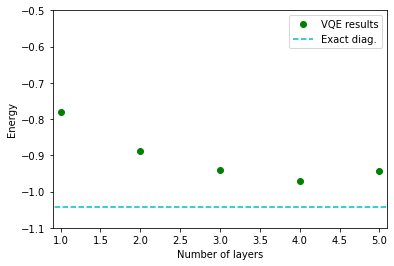

In [36]:
plt.plot(np.array([1,2,3,4,5]),Energy,'o', color = "green",label="VQE results")
plt.plot(np.array([0,1,2,3,4,5,6]),eigenvalues[0]*np.ones(7), ls = "--", color ="c", label = "Exact diag.")
plt.xlabel("Number of layers")
plt.ylabel("Energy")
plt.ylim(-1.1,-0.5)
plt.xlim(0.9,5.1)
plt.legend()

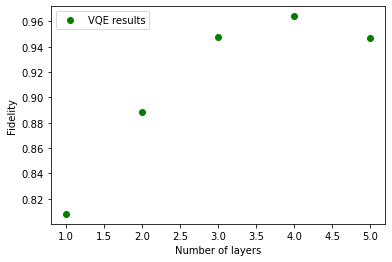

In [37]:
plt.plot(np.array([1,2,3,4,5]),Fidelity,'o', color = "green",label="VQE results")
plt.xlabel("Number of layers")
plt.ylabel("Fidelity")
plt.legend()